Note: up-to-date functionality is in 
* Section I Camera Calibration, 
* Section IIB Streamlined Image Pipeline and 
* the separate file `helperfunctions.py`. 

The functions in Section IIA are not up to date.

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

## I. Camera Calibration

### I.1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [10]:
# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

def cal_undistort(img, objpoints, imgpoints):
    """Returns undistorted image."""
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

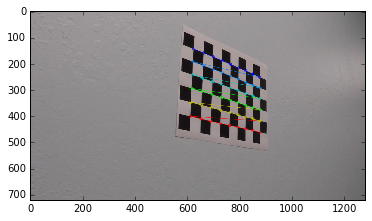

In [11]:
for fname in images:

    # Read in image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

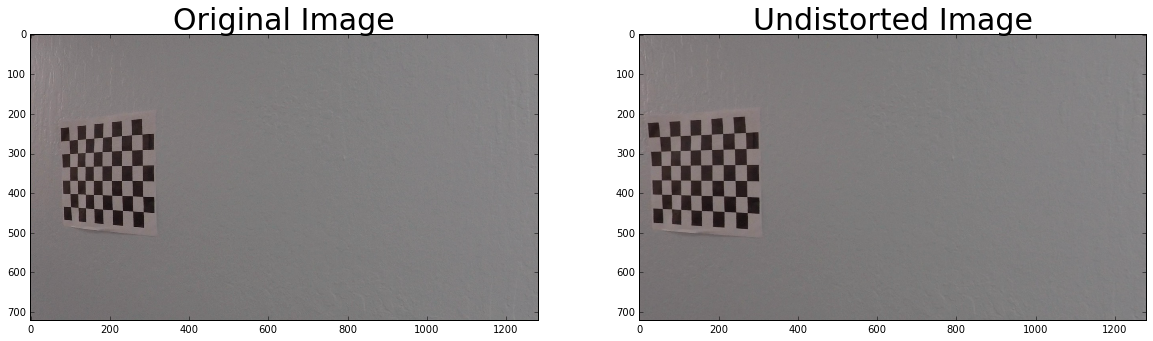

In [12]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [13]:
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

## II. Pipeline (Images)

## IIA. Initial runthrough of image pipeline

### II.2. Apply the distortion correction to the raw image.

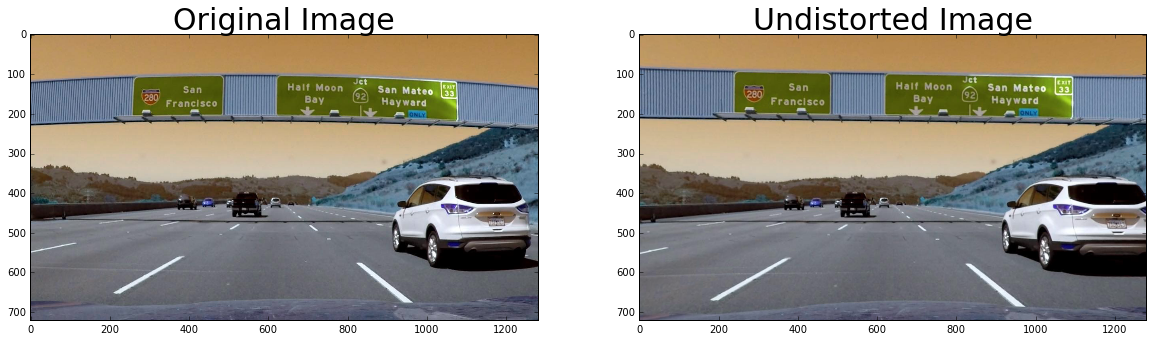

In [14]:
raw = cv2.imread("test_images/quiz.png")

corrected_raw = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(corrected_raw)
ax2.set_title('Undistorted Image', fontsize=30)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [15]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        derivative = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        derivative = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print("Error: orient must be either x or y.")
    
    # 3) Take the absolute value of the derivative or gradient
    abs_derivative = np.absolute(derivative)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_derivative/np.max(abs_derivative))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # So there are 1s where #s are within our thresholds and 0s otherwise.
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 6) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 7) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
        
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return dir_binary

In [16]:
def apply_thresholds(image, ksize=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(150, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(70, 200))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.1, 1.5))
    
    # Combine thresholds
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

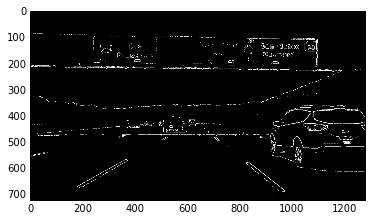

In [17]:
image = corrected_raw

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(150, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(70, 200))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.1, 1.5))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined, cmap="gray")

In [18]:
img = image

In [19]:
def apply_threshold_v2(image, xgrad_thresh=(20,100), s_thresh=(170,255)):
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= xgrad_thresh[0]) & (scaled_sobel <= xgrad_thresh[1])] = 1

    # Threshold colour channel

    # Convert to HLS colour space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Cont'd: Threshold colour channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

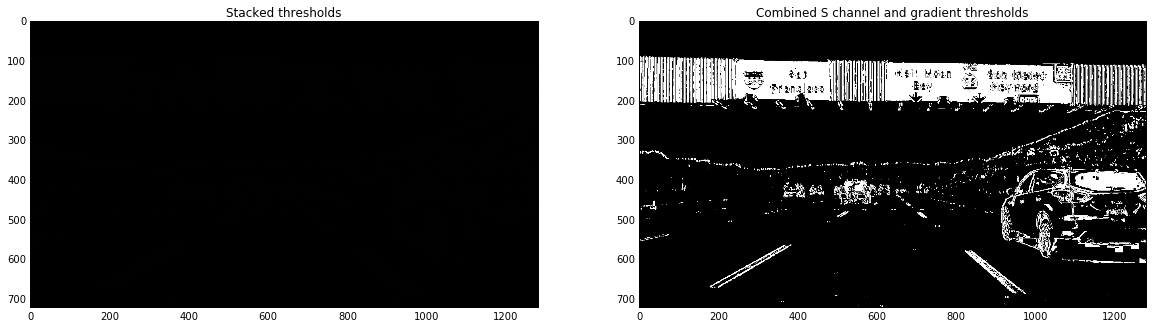

In [20]:


# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold colour channel

# Convert to HLS colour space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Cont'd: Threshold colour channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [21]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [22]:
imshape = combined_binary.shape
print(imshape)

(720, 1280)


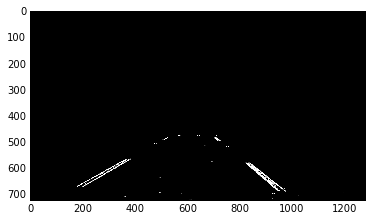

In [23]:
vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

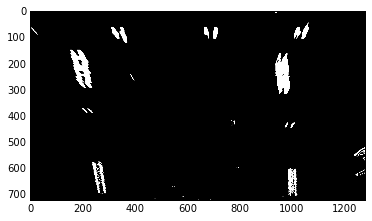

In [44]:
src = np.float32(
    [[0, 720],
     [550, 470],
     [700, 470],
     [1000, 720]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1000,0],
     [1000,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

### 5. Detect lane pixels and fit to find lane boundary.

In [45]:
from scipy import signal

In [46]:
def get_pixel_in_window(img, x_center, y_center, size):
    """
    returns selected pixels inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    """
    half_size = size // 2
    window = img[y_center - half_size:y_center + half_size, x_center - half_size:x_center + half_size]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y

# User used with x, y = get_pixel_in_window(masked_img, highest_peak, center, pixels_per_step)

In [47]:
def histogram_pixels(warped_thresholded_image, offset=50, steps=6, 
                     window_radius=200, medianfilt_kernel_size=51):
    
    # Initialise arrays
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    # Parameters
    height = warped_thresholded_image.shape[0]
    offset_height = height - offset
    half_frame = warped_thresholded_image.shape[1] // 2
    pixels_per_step = offset_height / steps
    
    for step in range(steps):
        # Printouts for debugging
        print("Step ", step)

        left_x_window_centres = []
        right_x_window_centres = []
        y_window_centres = []

        # Define the window (horizontal slice)
        window_start_y = height - (step * pixels_per_step) + offset 
        window_end_y = window_start_y - pixels_per_step + offset

        # Take a count of all the pixels at each x-value in the horizontal slice
        histogram = np.sum(warped_thresholded_image[window_end_y:window_start_y,:], axis=0)
        # plt.plot(histogram)

        # Smoothen the histogram
        histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

        # plt.plot(histogram_smooth)

        # Identify the left and right peaks
        left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1,10)))
        right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1,10)))
        if len(left_peaks) > 0:
            left_peak = max(left_peaks)
            left_x_window_centres.append(left_peak)

        if len(right_peaks) > 0:
            right_peak = max(right_peaks) + half_frame
            right_x_window_centres.append(right_peak)

        # Add coordinates to window centres

        if len(left_peaks) > 0 or len(right_peaks) > 0:
            y_window_centres.append((window_start_y + window_end_y) // 2)

        # Get pixels in the left window
        for left_x_centre, y_centre in zip(left_x_window_centres, y_window_centres):
            left_x_additional, left_y_additional = get_pixel_in_window(warped_thresholded_image, left_x_centre, y_centre, window_radius)
            # plt.scatter(left_x_additional, left_y_additional)
            # Add pixels to list
            left_x.append(left_x_additional)
            left_y.append(left_y_additional)

        # Get pixels in the right window
        for right_x_centre, y_centre in zip(right_x_window_centres, y_window_centres):
            right_x_additional, right_y_additional = get_pixel_in_window(warped_thresholded_image, right_x_centre, y_centre, window_radius)
            # plt.scatter(right_x_additional, right_y_additional)
            # Add pixels to list
            right_x.append(right_x_additional)
            right_y.append(right_y_additional)
        
    return collapse_into_single_arrays(leftx, lefty, rightx, righty)

In [48]:
def collapse_into_single_arrays(leftx, lefty, rightx, righty):
    leftx = [x 
            for array in left_x
            for x in array]
    lefty = [x 
            for array in left_y
            for x in array]
    rightx = [x 
            for array in right_x
            for x in array]
    righty = [x 
            for array in right_y
            for x in array]

    leftx = np.array(leftx)
    lefty = np.array(lefty)
    rightx = np.array(rightx)
    righty = np.array(righty)
    
    return leftx, lefty, rightx, righty

In [69]:
# Format coordinates

leftx = [x 
        for array in left_x
        for x in array]
lefty = [x 
        for array in left_y
        for x in array]
rightx = [x 
        for array in right_x
        for x in array]
righty = [x 
        for array in right_y
        for x in array]

leftx = np.array(leftx)
lefty = np.array(lefty)
rightx = np.array(rightx)
righty = np.array(righty)

NameError: name 'leftx' is not defined

In [50]:
def fit_second_order_poly(indep, dep):
    fit = np.polyfit(indep, dep, 2)
    fitdep = fit[0]*indep**2 + fit[1]*indep + fit[2]
    return fitdep

In [51]:
# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(lefty, leftx, 2)
left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

plt.plot(left_fitx, lefty, color='green', linewidth=3)
plt.plot(right_fitx, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

NameError: name 'lefty' is not defined

Section reference: 
* https://github.com/pkern90/CarND-advancedLaneLines

### 6. Determine curvature of the lane and vehicle position with respect to center.

In [68]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(lefty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print("Left lane curve radius: ", left_curverad)
print("Right lane curve radius: ", right_curverad)
# Example values: 1163.9    1213.7

NameError: name 'lefty' is not defined

### 7. Warp the detected lane boundaries back onto the original image.

Note that the xs are a function of the ys, not the other way round.

In [220]:
# create an empty canvas
blank_canvas = np.zeros_like(gray)
print("Image shape: ", blank_canvas.shape)

Image shape:  (720, 1280)


In [221]:
def left_lane_poly(yval):
    """Returns x value for poly given a y-value.
    Note here x = Ay^2 + By + C."""
    return left_fit[0]*yval**2 + left_fit[1]*yval + left_fit[2]

def right_lane_poly(yval):
    return right_fit[0]*yval**2 + right_fit[1]*yval + right_fit[2]

In [222]:
def draw_poly(img, poly, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start)), start)
        end_point = (int(poly(end)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

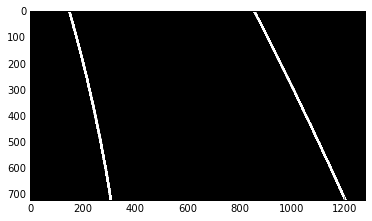

In [223]:
polyfit_left = draw_poly(blank_canvas, left_lane_poly, 30)
polyfit_drawn = draw_poly(polyfit_left, right_lane_poly, 30)
plt.imshow(polyfit_drawn, cmap="gray")

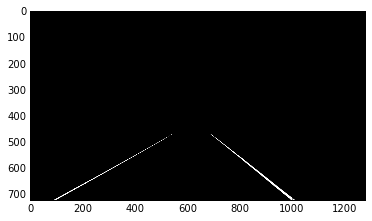

In [224]:
# warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

lane_lines = cv2.warpPerspective(polyfit_drawn, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(lane_lines, cmap="gray")

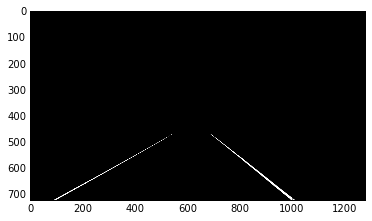

In [225]:
lane_line_colour = cv2.cvtColor(lane_lines, cv2.COLOR_GRAY2RGB)
plt.imshow(lane_line_colour)

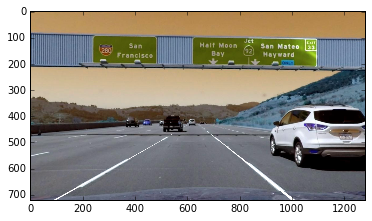

In [226]:
combined_img = cv2.add(lane_line_colour, corrected_raw)
plt.imshow(combined_img)

See `draw_poly()` in [file](https://github.com/pkern90/CarND-advancedLaneLines/blob/master/LaneDetection/ImageUtils.py).

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [67]:
def add_figures_to_image(img, curvature, vehicle_position):
        """
        Draws information about the center offset and the current lane curvature onto the given image.
        :param img:
        """
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
        left_orright = "left" if vehicle_position < 0 else "right"
        cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), left_or_right), (50, 100), font, 1,
                    (255, 255, 255), 2)

In [72]:
add_figures_to_image(combined_img, curvature=curvature, vehicle_position=centre)

TypeError: add_figures_to_image() missing 2 required positional arguments: 'curvature' and 'vehicle_position'

Further references:
* https://github.com/mohankarthik/CarND-AdvancedLaneLines-P4
* https://github.com/pkern90/CarND-advancedLaneLines

In [1]:
plt.imshow(cv2.putText(combined_img,"Hello World!!!", 
            (100,500), cv2.FONT_HERSHEY_SIMPLEX, 2, 255))

NameError: name 'plt' is not defined

## IIB: Streamlined image pipeline

Left coeffs: [  1.15351627e-04  -5.29144712e-02   3.47879153e+02]
righty[0]: , 266.0 , rightx[0]:  1036
Right coeffs:  [  3.87337277e-04  -2.70729877e-01   1.09664431e+03]
Left lane curve radius:  4415.09613638
Right lane curve radius:  1445.67972131
Left coeffs:  [  1.15351627e-04  -5.29144712e-02   3.47879153e+02]
Right fit:  [  3.87337277e-04  -2.70729877e-01   1.09664431e+03]


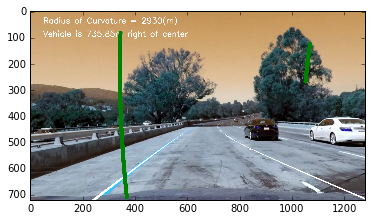

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from helperfunctions import *

with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

def image_pipeline(file, filepath=False):
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
    
    src = np.float32(
        [[0, 720],
         [550, 470],
         [700, 470],
         [1000, 720]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [900,0],
         [900,720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    height = raw.shape[0]
    offset = 50
    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = offset_height / steps
    window_radius = 200
    medianfilt_kernel_size = 51

    blank_canvas = np.zeros((720, 1280))

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Option I
    combined = apply_thresholds(image)

    ## Option II

    have_fit = False
    
    xgrad_thresh_temp = (40,100)
    s_thresh_temp=(150,255)
    
    while have_fit == False:
        combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
    #    plt.imshow(combined_binary, cmap="gray")

        # Plotting thresholded images
        """
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Option 1')
        ax1.imshow(combined, cmap="gray")

        ax2.set_title('Option 2: Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        """

        # Warp onto birds-eye-view
        # Previous region-of-interest mask's function is absorbed by the warp
        warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
        # plt.imshow(warped, cmap="gray")


        # Histogram and get pixels in window

        leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=40)

        plt.imshow(warped, cmap="gray")
        
        if len(leftx) > 1 and len(rightx) > 1:
            have_fit = True
        xgrad_thresh_temp = (xgrad_thresh_temp[0] - 2, xgrad_thresh_temp[1] + 2)
        s_thresh_temp = (s_thresh_temp[0] - 2, s_thresh_temp[1] + 2)

    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    print("Left coeffs:", left_coeffs)
    print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
    print("Right coeffs: ", right_coeffs)
    
    # Plot data
    
    plt.plot(left_fit, lefty, color='green', linewidth=3)
    plt.plot(right_fit, righty, color='green', linewidth=3)
    plt.imshow(warped, cmap="gray")

    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(lefty)
    left_curverad = ((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1]) ** 2) ** 1.5) \
                    / np.absolute(2 * left_coeffs[0])
    right_curverad = ((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     / np.absolute(2 * right_coeffs[0])
    print("Left lane curve radius: ", left_curverad)
    print("Right lane curve radius: ", right_curverad)
    curvature = (left_curverad + right_curverad) / 2
    centre = center(719, left_coeffs, right_coeffs)
    

    # TODO: Det vehicle position wrt centre
    
    # TODO: Add curvature stats to image

    ## 7. Warp the detected lane boundaries back onto the original image.

    # plt.imshow(blank_canvas, cmap="gray")
    print("Left coeffs: ", left_coeffs)
    print("Right fit: ", right_coeffs)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
#    plt.imshow(polyfit_left, cmap="gray")
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
#    plt.imshow(polyfit_drawn, cmap="gray")
#    plt.imshow(warped)
    lane_lines = cv2.warpPerspective(polyfit_drawn, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    # plt.imshow(lane_lines, cmap="gray")

    # Convert to colour
    lane_line_colour = cv2.cvtColor(lane_lines.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    combined_img = cv2.add(lane_line_colour, image)
    add_figures_to_image(combined_img, curvature=curvature, vehicle_position=centre)
    plt.imshow(combined_img)
    return combined_img

combined_img = image_pipeline("test_images/test1.jpg", filepath=True)

## III. Video Pipeline


In [64]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [65]:
from helperfunctions import *

Left coeffs: [ -1.32847251e-04   2.64937789e-01   2.74488626e+02]
righty[0]: , 478.0 , rightx[0]:  1008
Right coeffs:  [ -1.14769563e-04   1.79541442e-01   9.71542972e+02]
Left lane curve radius:  3795.49341793
Right lane curve radius:  4358.10985087
Left coeffs:  [ -1.32847251e-04   2.64937789e-01   2.74488626e+02]
Right fit:  [ -1.14769563e-04   1.79541442e-01   9.71542972e+02]
[MoviePy] >>>> Building video project_output_1000_end.mp4
[MoviePy] Writing video project_output_1000_end.mp4


  0%|          | 1/1261 [00:00<09:51,  2.13it/s]

Left coeffs: [ -1.32847251e-04   2.64937789e-01   2.74488626e+02]
righty[0]: , 478.0 , rightx[0]:  1008
Right coeffs:  [ -1.14769563e-04   1.79541442e-01   9.71542972e+02]
Left lane curve radius:  3795.49341793
Right lane curve radius:  4358.10985087
Left coeffs:  [ -1.32847251e-04   2.64937789e-01   2.74488626e+02]
Right fit:  [ -1.14769563e-04   1.79541442e-01   9.71542972e+02]


  0%|          | 2/1261 [00:00<09:48,  2.14it/s]

Left coeffs: [ -1.45377054e-04   2.78712822e-01   2.72205335e+02]
righty[0]: , 714.0 , rightx[0]:  909
Right coeffs:  [ -3.95315587e-05   1.27248081e-01   9.74741665e+02]
Left lane curve radius:  3465.24221486
Right lane curve radius:  12743.121532
Left coeffs:  [ -1.45377054e-04   2.78712822e-01   2.72205335e+02]
Right fit:  [ -3.95315587e-05   1.27248081e-01   9.74741665e+02]


  0%|          | 3/1261 [00:01<09:49,  2.13it/s]

Left coeffs: [ -1.64554987e-04   2.94956466e-01   2.70288715e+02]
righty[0]: , 714.0 , rightx[0]:  909
Right coeffs:  [ -2.80909475e-05   1.22129942e-01   9.72109145e+02]
Left lane curve radius:  3055.63418643
Right lane curve radius:  17980.2133648
Left coeffs:  [ -1.64554987e-04   2.94956466e-01   2.70288715e+02]
Right fit:  [ -2.80909475e-05   1.22129942e-01   9.72109145e+02]


  0%|          | 4/1261 [00:01<09:55,  2.11it/s]

Left coeffs: [ -1.89862215e-04   3.16315622e-01   2.67359931e+02]
righty[0]: , 581.0 , rightx[0]:  1014
Right coeffs:  [  3.09843612e-05   7.15606338e-02   9.78171841e+02]
Left lane curve radius:  2641.42544322
Right lane curve radius:  16463.2347726
Left coeffs:  [ -1.89862215e-04   3.16315622e-01   2.67359931e+02]
Right fit:  [  3.09843612e-05   7.15606338e-02   9.78171841e+02]


  0%|          | 5/1261 [00:02<09:54,  2.11it/s]

Left coeffs: [ -1.68924060e-04   3.06714068e-01   2.67494626e+02]
righty[0]: , 614.0 , rightx[0]:  1015
Right coeffs:  [  5.22933194e-06   9.08297295e-02   9.75008921e+02]
Left lane curve radius:  2978.77653987
Right lane curve radius:  97003.9364425
Left coeffs:  [ -1.68924060e-04   3.06714068e-01   2.67494626e+02]
Right fit:  [  5.22933194e-06   9.08297295e-02   9.75008921e+02]


  0%|          | 6/1261 [00:02<09:48,  2.13it/s]

Left coeffs: [ -1.54543601e-04   2.98100568e-01   2.68914040e+02]
righty[0]: , 645.0 , rightx[0]:  1018
Right coeffs:  [  7.32827395e-05   2.41789736e-02   9.87874767e+02]
Left lane curve radius:  3264.22638493
Right lane curve radius:  6993.83406387
Left coeffs:  [ -1.54543601e-04   2.98100568e-01   2.68914040e+02]
Right fit:  [  7.32827395e-05   2.41789736e-02   9.87874767e+02]


  1%|          | 7/1261 [00:03<09:44,  2.15it/s]

Left coeffs: [ -1.42566975e-04   2.94790237e-01   2.67063541e+02]
righty[0]: , 529.0 , rightx[0]:  1010
Right coeffs:  [  2.40277310e-04  -8.04216166e-02   1.00759784e+03]
Left lane curve radius:  3550.97429179
Right lane curve radius:  2300.00554247
Left coeffs:  [ -1.42566975e-04   2.94790237e-01   2.67063541e+02]
Right fit:  [  2.40277310e-04  -8.04216166e-02   1.00759784e+03]


  1%|          | 8/1261 [00:03<09:37,  2.17it/s]

Left coeffs: [ -1.44066637e-04   2.99546026e-01   2.66163499e+02]
righty[0]: , 315.0 , rightx[0]:  980
Right coeffs:  [  6.07519095e-04  -3.31365671e-01   1.04753841e+03]
Left lane curve radius:  3516.25703811
Right lane curve radius:  1204.14968152
Left coeffs:  [ -1.44066637e-04   2.99546026e-01   2.66163499e+02]
Right fit:  [  6.07519095e-04  -3.31365671e-01   1.04753841e+03]


  1%|          | 9/1261 [00:04<09:36,  2.17it/s]

Left coeffs: [ -1.29762154e-04   2.88954838e-01   2.65821601e+02]
righty[0]: , 330.0 , rightx[0]:  985
Right coeffs:  [ -1.91754800e-04   2.37446705e-01   9.50367799e+02]
Left lane curve radius:  3915.15757655
Right lane curve radius:  2612.78446444
Left coeffs:  [ -1.29762154e-04   2.88954838e-01   2.65821601e+02]
Right fit:  [ -1.91754800e-04   2.37446705e-01   9.50367799e+02]


  1%|          | 10/1261 [00:04<10:09,  2.05it/s]

Left coeffs: [ -1.30751311e-04   2.93116957e-01   2.62893880e+02]
righty[0]: , 619.0 , rightx[0]:  1019
Right coeffs:  [ -8.62147042e-05   1.76890790e-01   9.58112620e+02]
Left lane curve radius:  3888.8592048
Right lane curve radius:  5824.48869375
Left coeffs:  [ -1.30751311e-04   2.93116957e-01   2.62893880e+02]
Right fit:  [ -8.62147042e-05   1.76890790e-01   9.58112620e+02]


  1%|          | 11/1261 [00:05<10:06,  2.06it/s]

Left coeffs: [ -1.46445039e-04   3.10898821e-01   2.57961675e+02]
righty[0]: , 653.0 , rightx[0]:  1020
Right coeffs:  [  6.62075869e-05   2.42664970e-02   9.94167325e+02]
Left lane curve radius:  3467.12914449
Right lane curve radius:  7712.83329311
Left coeffs:  [ -1.46445039e-04   3.10898821e-01   2.57961675e+02]
Right fit:  [  6.62075869e-05   2.42664970e-02   9.94167325e+02]


  1%|          | 12/1261 [00:05<10:18,  2.02it/s]

Left coeffs: [ -1.42604452e-04   3.15493954e-01   2.50440723e+02]
righty[0]: , 419.0 , rightx[0]:  1001
Right coeffs:  [ -2.27029606e-04   2.96851222e-01   9.37223994e+02]
Left lane curve radius:  3572.20902104
Right lane curve radius:  2204.82698244
Left coeffs:  [ -1.42604452e-04   3.15493954e-01   2.50440723e+02]
Right fit:  [ -2.27029606e-04   2.96851222e-01   9.37223994e+02]


  1%|          | 13/1261 [00:06<10:52,  1.91it/s]

Left coeffs: [ -1.49408368e-04   3.22595001e-01   2.48556035e+02]
righty[0]: , 455.0 , rightx[0]:  1002
Right coeffs:  [ -1.97243067e-04   2.83326087e-01   9.34567004e+02]
Left lane curve radius:  3406.28490214
Right lane curve radius:  2534.94945806
Left coeffs:  [ -1.49408368e-04   3.22595001e-01   2.48556035e+02]
Right fit:  [ -1.97243067e-04   2.83326087e-01   9.34567004e+02]


  1%|          | 14/1261 [00:06<10:50,  1.92it/s]

Left coeffs: [ -1.66202470e-04   3.41510499e-01   2.43758362e+02]
righty[0]: , 529.0 , rightx[0]:  1010
Right coeffs:  [ -6.12595294e-05   1.81012033e-01   9.48263416e+02]
Left lane curve radius:  3057.16859447
Right lane curve radius:  8269.05557288
Left coeffs:  [ -1.66202470e-04   3.41510499e-01   2.43758362e+02]
Right fit:  [ -6.12595294e-05   1.81012033e-01   9.48263416e+02]


  1%|          | 15/1261 [00:07<10:41,  1.94it/s]

Left coeffs: [ -1.71426439e-04   3.43159243e-01   2.45315747e+02]
righty[0]: , 529.0 , rightx[0]:  1003
Right coeffs:  [  2.74063237e-05   1.25334968e-01   9.45460463e+02]
Left lane curve radius:  2958.83844944
Right lane curve radius:  18989.7187109
Left coeffs:  [ -1.71426439e-04   3.43159243e-01   2.45315747e+02]
Right fit:  [  2.74063237e-05   1.25334968e-01   9.45460463e+02]


  1%|▏         | 16/1261 [00:07<10:23,  2.00it/s]

Left coeffs: [ -1.55433234e-04   3.33197658e-01   2.46403881e+02]
righty[0]: , 567.0 , rightx[0]:  1003
Right coeffs:  [  1.15544942e-04   4.98171613e-02   9.50667194e+02]
Left lane curve radius:  3276.3721605
Right lane curve radius:  4630.93981429
Left coeffs:  [ -1.55433234e-04   3.33197658e-01   2.46403881e+02]
Right fit:  [  1.15544942e-04   4.98171613e-02   9.50667194e+02]


  1%|▏         | 17/1261 [00:08<10:06,  2.05it/s]

Left coeffs: [ -1.35493928e-04   3.18274301e-01   2.47826002e+02]
righty[0]: , 714.0 , rightx[0]:  909
Right coeffs:  [  7.21562336e-05   7.46142409e-02   9.48202504e+02]
Left lane curve radius:  3776.35744755
Right lane curve radius:  7260.57022559
Left coeffs:  [ -1.35493928e-04   3.18274301e-01   2.47826002e+02]
Right fit:  [  7.21562336e-05   7.46142409e-02   9.48202504e+02]


  1%|▏         | 18/1261 [00:08<10:00,  2.07it/s]

Left coeffs: [ -1.23240269e-04   3.10310363e-01   2.48215395e+02]
righty[0]: , 628.0 , rightx[0]:  1008
Right coeffs:  [  1.21438443e-04   2.70939345e-02   9.55241001e+02]
Left lane curve radius:  4167.00525327
Right lane curve radius:  4368.70068472
Left coeffs:  [ -1.23240269e-04   3.10310363e-01   2.48215395e+02]
Right fit:  [  1.21438443e-04   2.70939345e-02   9.55241001e+02]


  2%|▏         | 19/1261 [00:09<09:53,  2.09it/s]

Left coeffs: [ -9.54934743e-05   2.90868438e-01   2.48106426e+02]
righty[0]: , 255.0 , rightx[0]:  948
Right coeffs:  [  5.82041550e-04  -2.42524884e-01   1.00018410e+03]
Left lane curve radius:  5424.09025382
Right lane curve radius:  1344.25614055
Left coeffs:  [ -9.54934743e-05   2.90868438e-01   2.48106426e+02]
Right fit:  [  5.82041550e-04  -2.42524884e-01   1.00018410e+03]


  2%|▏         | 20/1261 [00:09<09:55,  2.08it/s]

Left coeffs: [ -8.92034559e-05   2.89889623e-01   2.44938217e+02]
righty[0]: , 539.0 , rightx[0]:  997
Right coeffs:  [  2.03384051e-04  -5.08526321e-02   9.82537553e+02]
Left lane curve radius:  5828.16630676
Right lane curve radius:  2673.81466238
Left coeffs:  [ -8.92034559e-05   2.89889623e-01   2.44938217e+02]
Right fit:  [  2.03384051e-04  -5.08526321e-02   9.82537553e+02]


  2%|▏         | 21/1261 [00:10<10:18,  2.01it/s]

Left coeffs: [ -6.37813362e-05   2.71515951e-01   2.44550561e+02]
righty[0]: , 307.0 , rightx[0]:  967
Right coeffs:  [  3.81517382e-04  -2.00942621e-01   1.01928097e+03]
Left lane curve radius:  8224.67131942
Right lane curve radius:  1550.83533843
Left coeffs:  [ -6.37813362e-05   2.71515951e-01   2.44550561e+02]
Right fit:  [  3.81517382e-04  -2.00942621e-01   1.01928097e+03]


  2%|▏         | 22/1261 [00:10<10:27,  1.98it/s]

Left coeffs: [ -5.34299297e-05   2.64319385e-01   2.42187577e+02]
righty[0]: , 600.0 , rightx[0]:  1008
Right coeffs:  [  1.59012582e-04  -7.01527260e-02   1.00734706e+03]
Left lane curve radius:  9861.52472276
Right lane curve radius:  3258.88419765
Left coeffs:  [ -5.34299297e-05   2.64319385e-01   2.42187577e+02]
Right fit:  [  1.59012582e-04  -7.01527260e-02   1.00734706e+03]


  2%|▏         | 23/1261 [00:11<11:03,  1.87it/s]

Left coeffs: [ -5.12553618e-05   2.63253640e-01   2.39128401e+02]
righty[0]: , 631.0 , rightx[0]:  1012
Right coeffs:  [ -1.05840680e-05   8.08494575e-02   9.78398317e+02]
Left lane curve radius:  10288.3986629
Right lane curve radius:  47547.3472926
Left coeffs:  [ -5.12553618e-05   2.63253640e-01   2.39128401e+02]
Right fit:  [ -1.05840680e-05   8.08494575e-02   9.78398317e+02]


  2%|▏         | 24/1261 [00:11<10:54,  1.89it/s]

Left coeffs: [ -4.17562953e-05   2.45004703e-01   2.45868634e+02]
righty[0]: , 415.0 , rightx[0]:  988
Right coeffs:  [ -1.07841851e-04   1.63074792e-01   9.60166681e+02]
Left lane curve radius:  12596.1833771
Right lane curve radius:  4636.96498279
Left coeffs:  [ -4.17562953e-05   2.45004703e-01   2.45868634e+02]
Right fit:  [ -1.07841851e-04   1.63074792e-01   9.60166681e+02]


  2%|▏         | 25/1261 [00:12<10:49,  1.90it/s]

Left coeffs: [ -6.38117237e-05   2.57022209e-01   2.44970750e+02]
righty[0]: , 439.0 , rightx[0]:  990
Right coeffs:  [ -4.56683412e-05   1.18411448e-01   9.66804085e+02]
Left lane curve radius:  8163.26852232
Right lane curve radius:  10995.653183
Left coeffs:  [ -6.38117237e-05   2.57022209e-01   2.44970750e+02]
Right fit:  [ -4.56683412e-05   1.18411448e-01   9.66804085e+02]


  2%|▏         | 26/1261 [00:12<10:48,  1.90it/s]

Left coeffs: [ -7.14974190e-05   2.60286007e-01   2.42853466e+02]
righty[0]: , 463.0 , rightx[0]:  999
Right coeffs:  [ -7.28731788e-05   1.24945689e-01   9.75056278e+02]
Left lane curve radius:  7259.31229649
Right lane curve radius:  6865.97775255
Left coeffs:  [ -7.14974190e-05   2.60286007e-01   2.42853466e+02]
Right fit:  [ -7.28731788e-05   1.24945689e-01   9.75056278e+02]


  2%|▏         | 27/1261 [00:13<10:45,  1.91it/s]

Left coeffs: [ -7.93509077e-05   2.62870268e-01   2.43160758e+02]
righty[0]: , 529.0 , rightx[0]:  1005
Right coeffs:  [ -2.81653122e-04   3.54197510e-01   9.14672157e+02]
Left lane curve radius:  6515.53070875
Right lane curve radius:  1780.80970184
Left coeffs:  [ -7.93509077e-05   2.62870268e-01   2.43160758e+02]
Right fit:  [ -2.81653122e-04   3.54197510e-01   9.14672157e+02]


  2%|▏         | 28/1261 [00:13<10:25,  1.97it/s]

Left coeffs: [ -6.93527405e-05   2.54443777e-01   2.41904196e+02]
righty[0]: , 532.0 , rightx[0]:  1009
Right coeffs:  [ -5.27216722e-05   1.30494773e-01   9.70829461e+02]
Left lane curve radius:  7472.27404369
Right lane curve radius:  9527.15801446
Left coeffs:  [ -6.93527405e-05   2.54443777e-01   2.41904196e+02]
Right fit:  [ -5.27216722e-05   1.30494773e-01   9.70829461e+02]


  2%|▏         | 29/1261 [00:14<10:34,  1.94it/s]

Left coeffs: [ -9.11246448e-05   2.69167661e-01   2.41475107e+02]
righty[0]: , 713.0 , rightx[0]:  911
Right coeffs:  [ -7.43402680e-05   1.49478934e-01   9.65249020e+02]
Left lane curve radius:  5646.87295769
Right lane curve radius:  6744.77248002
Left coeffs:  [ -9.11246448e-05   2.69167661e-01   2.41475107e+02]
Right fit:  [ -7.43402680e-05   1.49478934e-01   9.65249020e+02]


  2%|▏         | 30/1261 [00:14<10:00,  2.05it/s]

Left coeffs: [ -1.09567228e-04   2.75874926e-01   2.45063200e+02]
righty[0]: , 602.0 , rightx[0]:  1012
Right coeffs:  [ -1.43247408e-05   1.04898641e-01   9.66726965e+02]
Left lane curve radius:  4661.3629518
Right lane curve radius:  35278.6470789
Left coeffs:  [ -1.09567228e-04   2.75874926e-01   2.45063200e+02]
Right fit:  [ -1.43247408e-05   1.04898641e-01   9.66726965e+02]


  2%|▏         | 31/1261 [00:15<09:42,  2.11it/s]

Left coeffs: [ -1.15163181e-04   2.76257533e-01   2.48309873e+02]
righty[0]: , 636.0 , rightx[0]:  1014
Right coeffs:  [ -1.47703835e-05   1.10777284e-01   9.62002418e+02]
Left lane curve radius:  4422.9899933
Right lane curve radius:  34260.4982911
Left coeffs:  [ -1.15163181e-04   2.76257533e-01   2.48309873e+02]
Right fit:  [ -1.47703835e-05   1.10777284e-01   9.62002418e+02]


  3%|▎         | 32/1261 [00:15<09:29,  2.16it/s]

Left coeffs: [ -1.26992172e-04   2.78113548e-01   2.53215514e+02]
righty[0]: , 520.0 , rightx[0]:  1002
Right coeffs:  [  1.33608780e-04   1.93529871e-02   9.71891776e+02]
Left lane curve radius:  3992.39227225
Right lane curve radius:  3993.52692114
Left coeffs:  [ -1.26992172e-04   2.78113548e-01   2.53215514e+02]
Right fit:  [  1.33608780e-04   1.93529871e-02   9.71891776e+02]


  3%|▎         | 33/1261 [00:16<09:49,  2.08it/s]

Left coeffs: [ -1.10387348e-04   2.66225971e-01   2.53808222e+02]
righty[0]: , 546.0 , rightx[0]:  1007
Right coeffs:  [  1.83484183e-05   9.15019415e-02   9.66745726e+02]
Left lane curve radius:  4609.86097992
Right lane curve radius:  27818.555152
Left coeffs:  [ -1.10387348e-04   2.66225971e-01   2.53808222e+02]
Right fit:  [  1.83484183e-05   9.15019415e-02   9.66745726e+02]


  3%|▎         | 34/1261 [00:16<09:54,  2.06it/s]

Left coeffs: [ -1.19150932e-04   2.71983636e-01   2.54449022e+02]
righty[0]: , 324.0 , rightx[0]:  972
Right coeffs:  [  4.82508671e-04  -2.26425025e-01   1.01857094e+03]
Left lane curve radius:  4261.4985895
Right lane curve radius:  1387.61938531
Left coeffs:  [ -1.19150932e-04   2.71983636e-01   2.54449022e+02]
Right fit:  [  4.82508671e-04  -2.26425025e-01   1.01857094e+03]


  3%|▎         | 35/1261 [00:17<09:52,  2.07it/s]

Left coeffs: [ -1.36718255e-04   2.85131729e-01   2.54151554e+02]
righty[0]: , 611.0 , rightx[0]:  1014
Right coeffs:  [ -4.78894744e-05   1.50051940e-01   9.52864261e+02]
Left lane curve radius:  3701.30902597
Right lane curve radius:  10545.0841913
Left coeffs:  [ -1.36718255e-04   2.85131729e-01   2.54151554e+02]
Right fit:  [ -4.78894744e-05   1.50051940e-01   9.52864261e+02]


  3%|▎         | 36/1261 [00:17<09:57,  2.05it/s]

Left coeffs: [ -1.33081479e-04   2.80509561e-01   2.58123973e+02]
righty[0]: , 671.0 , rightx[0]:  1010
Right coeffs:  [ -1.56469124e-04   2.56038436e-01   9.25743430e+02]
Left lane curve radius:  3803.04489956
Right lane curve radius:  3200.5168586
Left coeffs:  [ -1.33081479e-04   2.80509561e-01   2.58123973e+02]
Right fit:  [ -1.56469124e-04   2.56038436e-01   9.25743430e+02]


  3%|▎         | 37/1261 [00:18<10:13,  1.99it/s]

Left coeffs: [ -1.43971167e-04   2.88814011e-01   2.57377930e+02]
righty[0]: , 429.0 , rightx[0]:  984
Right coeffs:  [ -2.18897818e-05   1.23929964e-01   9.55936083e+02]
Left lane curve radius:  3508.81056984
Right lane curve radius:  23136.305763
Left coeffs:  [ -1.43971167e-04   2.88814011e-01   2.57377930e+02]
Right fit:  [ -2.18897818e-05   1.23929964e-01   9.55936083e+02]


  3%|▎         | 38/1261 [00:18<10:03,  2.03it/s]

Left coeffs: [ -1.57204943e-04   2.96464550e-01   2.58697876e+02]
righty[0]: , 455.0 , rightx[0]:  989
Right coeffs:  [ -9.21242526e-05   1.93118900e-01   9.38362416e+02]
Left lane curve radius:  3205.09303273
Right lane curve radius:  5458.15446365
Left coeffs:  [ -1.57204943e-04   2.96464550e-01   2.58697876e+02]
Right fit:  [ -9.21242526e-05   1.93118900e-01   9.38362416e+02]


  3%|▎         | 39/1261 [00:19<09:48,  2.08it/s]

Left coeffs: [ -1.66025638e-04   3.06202185e-01   2.57522926e+02]
righty[0]: , 532.0 , rightx[0]:  995
Right coeffs:  [ -9.93366299e-05   2.35705832e-01   9.14229789e+02]
Left lane curve radius:  3032.98205345
Right lane curve radius:  5099.7579833
Left coeffs:  [ -1.66025638e-04   3.06202185e-01   2.57522926e+02]
Right fit:  [ -9.93366299e-05   2.35705832e-01   9.14229789e+02]


  3%|▎         | 40/1261 [00:19<09:33,  2.13it/s]

Left coeffs: [ -1.74141742e-04   3.18509291e-01   2.53472338e+02]
righty[0]: , 529.0 , rightx[0]:  996
Right coeffs:  [ -1.24144625e-05   1.62653440e-01   9.27640980e+02]
Left lane curve radius:  2892.04445285
Right lane curve radius:  41550.6947062
Left coeffs:  [ -1.74141742e-04   3.18509291e-01   2.53472338e+02]
Right fit:  [ -1.24144625e-05   1.62653440e-01   9.27640980e+02]


  3%|▎         | 41/1261 [00:20<10:05,  2.01it/s]

Left coeffs: [ -1.80842724e-04   3.24721363e-01   2.52669351e+02]
righty[0]: , 556.0 , rightx[0]:  1001
Right coeffs:  [  2.90827550e-06   1.42820826e-01   9.31926567e+02]
Left lane curve radius:  2782.98229797
Right lane curve radius:  177524.260615
Left coeffs:  [ -1.80842724e-04   3.24721363e-01   2.52669351e+02]
Right fit:  [  2.90827550e-06   1.42820826e-01   9.31926567e+02]


  3%|▎         | 42/1261 [00:20<10:10,  2.00it/s]

Left coeffs: [ -1.85449125e-04   3.29709401e-01   2.52387898e+02]
righty[0]: , 586.0 , rightx[0]:  1005
Right coeffs:  [  5.58512923e-06   1.29177799e-01   9.38400163e+02]
Left lane curve radius:  2713.0087178
Right lane curve radius:  92061.7453773
Left coeffs:  [ -1.85449125e-04   3.29709401e-01   2.52387898e+02]
Right fit:  [  5.58512923e-06   1.29177799e-01   9.38400163e+02]


  3%|▎         | 43/1261 [00:21<10:09,  2.00it/s]

Left coeffs: [ -1.73737751e-04   3.27446209e-01   2.50383094e+02]
righty[0]: , 617.0 , rightx[0]:  1010
Right coeffs:  [  1.88081214e-05   1.07313136e-01   9.47439570e+02]
Left lane curve radius:  2904.885023
Right lane curve radius:  27305.7383663
Left coeffs:  [ -1.73737751e-04   3.27446209e-01   2.50383094e+02]
Right fit:  [  1.88081214e-05   1.07313136e-01   9.47439570e+02]


  3%|▎         | 44/1261 [00:21<10:24,  1.95it/s]

Left coeffs: [ -1.89038308e-04   3.47681400e-01   2.42828866e+02]
righty[0]: , 651.0 , rightx[0]:  1014
Right coeffs:  [  7.22709700e-06   1.05263367e-01   9.54440965e+02]
Left lane curve radius:  2669.92155464
Right lane curve radius:  70573.7019404
Left coeffs:  [ -1.89038308e-04   3.47681400e-01   2.42828866e+02]
Right fit:  [  7.22709700e-06   1.05263367e-01   9.54440965e+02]


  4%|▎         | 45/1261 [00:22<10:31,  1.93it/s]

Left coeffs: [ -1.74864581e-04   3.40264223e-01   2.42106445e+02]
righty[0]: , 529.0 , rightx[0]:  1003
Right coeffs:  [  2.49698138e-04  -6.34978730e-02   9.87507698e+02]
Left lane curve radius:  2894.32824439
Right lane curve radius:  2266.78104652
Left coeffs:  [ -1.74864581e-04   3.40264223e-01   2.42106445e+02]
Right fit:  [  2.49698138e-04  -6.34978730e-02   9.87507698e+02]


  4%|▎         | 46/1261 [00:22<10:32,  1.92it/s]

Left coeffs: [ -1.82694710e-04   3.49806253e-01   2.38892369e+02]
righty[0]: , 307.0 , rightx[0]:  970
Right coeffs:  [  6.97710497e-04  -3.65809667e-01   1.03950971e+03]
Left lane curve radius:  2769.0605537
Right lane curve radius:  1186.23163563
Left coeffs:  [ -1.82694710e-04   3.49806253e-01   2.38892369e+02]
Right fit:  [  6.97710497e-04  -3.65809667e-01   1.03950971e+03]


  4%|▎         | 47/1261 [00:23<10:47,  1.87it/s]

Left coeffs: [ -1.83936714e-04   3.54195938e-01   2.35930893e+02]
righty[0]: , 705.0 , rightx[0]:  1009
Right coeffs:  [ -1.11224245e-05   1.00979247e-01   9.68140859e+02]
Left lane curve radius:  2752.56108087
Right lane curve radius:  45443.4078097
Left coeffs:  [ -1.83936714e-04   3.54195938e-01   2.35930893e+02]
Right fit:  [ -1.11224245e-05   1.00979247e-01   9.68140859e+02]


  4%|▍         | 48/1261 [00:23<10:29,  1.93it/s]

Left coeffs: [ -1.85930695e-04   3.58388112e-01   2.34462026e+02]
righty[0]: , 672.0 , rightx[0]:  1004
Right coeffs:  [ -1.05893602e-04   2.00473240e-01   9.41487141e+02]
Left lane curve radius:  2723.76704973
Right lane curve radius:  4738.76760224
Left coeffs:  [ -1.85930695e-04   3.58388112e-01   2.34462026e+02]
Right fit:  [ -1.05893602e-04   2.00473240e-01   9.41487141e+02]


  4%|▍         | 49/1261 [00:24<10:28,  1.93it/s]

Left coeffs: [ -1.73775208e-04   3.53892372e-01   2.31421949e+02]
righty[0]: , 424.0 , rightx[0]:  990
Right coeffs:  [ -9.24641994e-05   1.86913273e-01   9.47975855e+02]
Left lane curve radius:  2927.28059371
Right lane curve radius:  5432.77257166
Left coeffs:  [ -1.73775208e-04   3.53892372e-01   2.31421949e+02]
Right fit:  [ -9.24641994e-05   1.86913273e-01   9.47975855e+02]


  4%|▍         | 50/1261 [00:25<13:40,  1.48it/s]

Left coeffs: [ -1.84630450e-04   3.67975163e-01   2.26761808e+02]
righty[0]: , 429.0 , rightx[0]:  991
Right coeffs:  [  1.57707294e-04  -6.97091953e-02   1.01261700e+03]
Left lane curve radius:  2752.12794786
Right lane curve radius:  3286.58329411
Left coeffs:  [ -1.84630450e-04   3.67975163e-01   2.26761808e+02]
Right fit:  [  1.57707294e-04  -6.97091953e-02   1.01261700e+03]


  4%|▍         | 51/1261 [00:26<13:07,  1.54it/s]

Left coeffs: [ -1.92172244e-04   3.79524303e-01   2.22370140e+02]
righty[0]: , 467.0 , rightx[0]:  996
Right coeffs:  [ -6.49762532e-05   1.61217719e-01   9.52959028e+02]
Left lane curve radius:  2645.06311271
Right lane curve radius:  7749.23529293
Left coeffs:  [ -1.92172244e-04   3.79524303e-01   2.22370140e+02]
Right fit:  [ -6.49762532e-05   1.61217719e-01   9.52959028e+02]


  4%|▍         | 52/1261 [00:26<12:12,  1.65it/s]

Left coeffs: [ -1.87198131e-04   3.77927567e-01   2.22384855e+02]
righty[0]: , 532.0 , rightx[0]:  1000
Right coeffs:  [ -9.47086221e-05   2.24400020e-01   9.23812448e+02]
Left lane curve radius:  2721.47700315
Right lane curve radius:  5343.50085969
Left coeffs:  [ -1.87198131e-04   3.77927567e-01   2.22384855e+02]
Right fit:  [ -9.47086221e-05   2.24400020e-01   9.23812448e+02]


  4%|▍         | 53/1261 [00:27<11:45,  1.71it/s]

Left coeffs: [ -1.82993205e-04   3.73990894e-01   2.23440930e+02]
righty[0]: , 536.0 , rightx[0]:  1000
Right coeffs:  [ -3.10176344e-05   1.75410082e-01   9.28108224e+02]
Left lane curve radius:  2784.20187739
Right lane curve radius:  16536.937672
Left coeffs:  [ -1.82993205e-04   3.73990894e-01   2.23440930e+02]
Right fit:  [ -3.10176344e-05   1.75410082e-01   9.28108224e+02]


  4%|▍         | 54/1261 [00:27<11:11,  1.80it/s]

Left coeffs: [ -1.73063886e-04   3.68845605e-01   2.22372083e+02]
righty[0]: , 682.0 , rightx[0]:  992
Right coeffs:  [ -5.62831783e-05   1.90578226e-01   9.25274497e+02]
Left lane curve radius:  2953.17268247
Right lane curve radius:  9045.64922015
Left coeffs:  [ -1.73063886e-04   3.68845605e-01   2.22372083e+02]
Right fit:  [ -5.62831783e-05   1.90578226e-01   9.25274497e+02]


  4%|▍         | 55/1261 [00:28<10:48,  1.86it/s]

Left coeffs: [ -1.52025985e-04   3.56934163e-01   2.21440861e+02]
righty[0]: , 602.0 , rightx[0]:  1008
Right coeffs:  [ -2.84461815e-05   1.59952338e-01   9.32765678e+02]
Left lane curve radius:  3387.55805711
Right lane curve radius:  17955.2725844
Left coeffs:  [ -1.52025985e-04   3.56934163e-01   2.21440861e+02]
Right fit:  [ -2.84461815e-05   1.59952338e-01   9.32765678e+02]


  4%|▍         | 56/1261 [00:28<10:33,  1.90it/s]

Left coeffs: [ -1.21392586e-04   3.33601155e-01   2.23344288e+02]
righty[0]: , 644.0 , rightx[0]:  991
Right coeffs:  [ -5.70911739e-05   1.78464653e-01   9.32866092e+02]
Left lane curve radius:  4278.05971595
Right lane curve radius:  8881.3668389
Left coeffs:  [ -1.21392586e-04   3.33601155e-01   2.23344288e+02]
Right fit:  [ -5.70911739e-05   1.78464653e-01   9.32866092e+02]


  5%|▍         | 57/1261 [00:29<10:16,  1.95it/s]

Left coeffs: [ -9.54105208e-05   3.13227296e-01   2.25729387e+02]
righty[0]: , 512.0 , rightx[0]:  996
Right coeffs:  [  1.51606787e-04   2.49088308e-02   9.59491495e+02]
Left lane curve radius:  5488.10873996
Right lane curve radius:  3591.20072045
Left coeffs:  [ -9.54105208e-05   3.13227296e-01   2.25729387e+02]
Right fit:  [  1.51606787e-04   2.49088308e-02   9.59491495e+02]


  5%|▍         | 58/1261 [00:29<10:01,  2.00it/s]

Left coeffs: [ -8.46568137e-05   3.02356759e-01   2.27263888e+02]
righty[0]: , 547.0 , rightx[0]:  1000
Right coeffs:  [  5.55651998e-05   9.40218582e-02   9.48937163e+02]
Left lane curve radius:  6202.54386706
Right lane curve radius:  9405.05895568
Left coeffs:  [ -8.46568137e-05   3.02356759e-01   2.27263888e+02]
Right fit:  [  5.55651998e-05   9.40218582e-02   9.48937163e+02]


  5%|▍         | 59/1261 [00:29<09:46,  2.05it/s]

Left coeffs: [ -5.87361171e-05   2.72114888e-01   2.36594753e+02]
righty[0]: , 329.0 , rightx[0]:  957
Right coeffs:  [ -1.18421273e-04   2.30545485e-01   9.16576891e+02]
Left lane curve radius:  8968.51846183
Right lane curve radius:  4245.9600122
Left coeffs:  [ -5.87361171e-05   2.72114888e-01   2.36594753e+02]
Right fit:  [ -1.18421273e-04   2.30545485e-01   9.16576891e+02]


  5%|▍         | 60/1261 [00:30<09:33,  2.09it/s]

Left coeffs: [ -4.56465798e-05   2.52540103e-01   2.43331451e+02]
righty[0]: , 620.0 , rightx[0]:  1001
Right coeffs:  [ -7.26924654e-05   2.04939693e-01   9.14213681e+02]
Left lane curve radius:  11537.800748
Right lane curve radius:  6985.31411954
Left coeffs:  [ -4.56465798e-05   2.52540103e-01   2.43331451e+02]
Right fit:  [ -7.26924654e-05   2.04939693e-01   9.14213681e+02]


  5%|▍         | 61/1261 [00:30<09:24,  2.13it/s]

Left coeffs: [ -4.48129247e-05   2.45117843e-01   2.46101780e+02]
righty[0]: , 651.0 , rightx[0]:  1003
Right coeffs:  [ -6.73114658e-05   2.02602701e-01   9.12864922e+02]
Left lane curve radius:  11710.4756255
Right lane curve radius:  7554.52647413
Left coeffs:  [ -4.48129247e-05   2.45117843e-01   2.46101780e+02]
Right fit:  [ -6.73114658e-05   2.02602701e-01   9.12864922e+02]


  5%|▍         | 62/1261 [00:31<09:22,  2.13it/s]

Left coeffs: [ -4.44449125e-05   2.34759448e-01   2.51381081e+02]
righty[0]: , 437.0 , rightx[0]:  966
Right coeffs:  [ -5.42915391e-05   1.98356117e-01   9.09560841e+02]
Left lane curve radius:  11748.0985474
Right lane curve radius:  9411.587499
Left coeffs:  [ -4.44449125e-05   2.34759448e-01   2.51381081e+02]
Right fit:  [ -5.42915391e-05   1.98356117e-01   9.09560841e+02]


  5%|▍         | 63/1261 [00:31<09:19,  2.14it/s]

Left coeffs: [ -5.28492197e-05   2.38659206e-01   2.50073838e+02]
righty[0]: , 463.0 , rightx[0]:  974
Right coeffs:  [ -1.32193029e-04   2.88606196e-01   8.84978046e+02]
Left lane curve radius:  9840.81788516
Right lane curve radius:  3838.73542602
Left coeffs:  [ -5.28492197e-05   2.38659206e-01   2.50073838e+02]
Right fit:  [ -1.32193029e-04   2.88606196e-01   8.84978046e+02]


  5%|▌         | 64/1261 [00:32<09:12,  2.17it/s]

Left coeffs: [ -6.71163328e-05   2.41962017e-01   2.52586807e+02]
righty[0]: , 529.0 , rightx[0]:  982
Right coeffs:  [ -1.08116266e-05   1.99806652e-01   8.93979685e+02]
Left lane curve radius:  7689.16744439
Right lane curve radius:  48623.8509029
Left coeffs:  [ -6.71163328e-05   2.41962017e-01   2.52586807e+02]
Right fit:  [ -1.08116266e-05   1.99806652e-01   8.93979685e+02]


  5%|▌         | 65/1261 [00:32<09:12,  2.16it/s]

Left coeffs: [ -8.82055644e-05   2.58534239e-01   2.48597142e+02]
righty[0]: , 529.0 , rightx[0]:  984
Right coeffs:  [  6.22146668e-05   1.27858273e-01   9.10154403e+02]
Left lane curve radius:  5818.28175745
Right lane curve radius:  8610.04561787
Left coeffs:  [ -8.82055644e-05   2.58534239e-01   2.48597142e+02]
Right fit:  [  6.22146668e-05   1.27858273e-01   9.10154403e+02]


  5%|▌         | 66/1261 [00:33<09:16,  2.15it/s]

Left coeffs: [ -1.04882799e-04   2.66910783e-01   2.49317253e+02]
righty[0]: , 565.0 , rightx[0]:  987
Right coeffs:  [  4.88510389e-06   1.63160533e-01   9.05763850e+02]
Left lane curve radius:  4865.32739708
Right lane curve radius:  106828.576945
Left coeffs:  [ -1.04882799e-04   2.66910783e-01   2.49317253e+02]
Right fit:  [  4.88510389e-06   1.63160533e-01   9.05763850e+02]


  5%|▌         | 67/1261 [00:33<09:18,  2.14it/s]

Left coeffs: [ -1.14515024e-04   2.73050673e-01   2.47994316e+02]
righty[0]: , 593.0 , rightx[0]:  991
Right coeffs:  [ -1.41661530e-05   1.70911747e-01   9.05468375e+02]
Left lane curve radius:  4444.70601846
Right lane curve radius:  36503.8222669
Left coeffs:  [ -1.14515024e-04   2.73050673e-01   2.47994316e+02]
Right fit:  [ -1.41661530e-05   1.70911747e-01   9.05468375e+02]


  5%|▌         | 68/1261 [00:34<09:13,  2.15it/s]

Left coeffs: [ -1.34599900e-04   2.90828441e-01   2.43039396e+02]
righty[0]: , 625.0 , rightx[0]:  995
Right coeffs:  [  8.16805462e-05   6.99518036e-02   9.28864656e+02]
Left lane curve radius:  3768.74086214
Right lane curve radius:  6444.43341333
Left coeffs:  [ -1.34599900e-04   2.90828441e-01   2.43039396e+02]
Right fit:  [  8.16805462e-05   6.99518036e-02   9.28864656e+02]


  5%|▌         | 69/1261 [00:34<09:06,  2.18it/s]

Left coeffs: [ -1.52533466e-04   3.02700360e-01   2.42901001e+02]
righty[0]: , 506.0 , rightx[0]:  978
Right coeffs:  [  3.49389687e-04  -1.08795717e-01   9.56581877e+02]
Left lane curve radius:  3314.23066999
Right lane curve radius:  1766.16296016
Left coeffs:  [ -1.52533466e-04   3.02700360e-01   2.42901001e+02]
Right fit:  [  3.49389687e-04  -1.08795717e-01   9.56581877e+02]


  6%|▌         | 70/1261 [00:34<09:03,  2.19it/s]

Left coeffs: [ -1.67767367e-04   3.20027059e-01   2.36419694e+02]
righty[0]: , 537.0 , rightx[0]:  984
Right coeffs:  [  2.29630485e-04  -4.70134079e-02   9.55335559e+02]
Left lane curve radius:  3010.27848664
Right lane curve radius:  2436.65129296
Left coeffs:  [ -1.67767367e-04   3.20027059e-01   2.36419694e+02]
Right fit:  [  2.29630485e-04  -4.70134079e-02   9.55335559e+02]


  6%|▌         | 71/1261 [00:35<09:06,  2.18it/s]

Left coeffs: [ -1.69931798e-04   3.22827434e-01   2.35916861e+02]
righty[0]: , 314.0 , rightx[0]:  942
Right coeffs:  [  2.41671206e-04  -5.95221351e-02   9.58237955e+02]
Left lane curve radius:  2971.49400411
Right lane curve radius:  2324.46119159
Left coeffs:  [ -1.69931798e-04   3.22827434e-01   2.35916861e+02]
Right fit:  [  2.41671206e-04  -5.95221351e-02   9.58237955e+02]


  6%|▌         | 72/1261 [00:35<09:01,  2.19it/s]

Left coeffs: [ -1.71265372e-04   3.30025776e-01   2.31279565e+02]
righty[0]: , 601.0 , rightx[0]:  991
Right coeffs:  [  1.35463322e-05   1.10457896e-01   9.29430605e+02]
Left lane curve radius:  2952.52383952
Right lane curve radius:  37845.5387571
Left coeffs:  [ -1.71265372e-04   3.30025776e-01   2.31279565e+02]
Right fit:  [  1.35463322e-05   1.10457896e-01   9.29430605e+02]


  6%|▌         | 73/1261 [00:36<09:04,  2.18it/s]

Left coeffs: [ -1.66672311e-04   3.31002684e-01   2.28328099e+02]
righty[0]: , 633.0 , rightx[0]:  995
Right coeffs:  [  6.66415463e-07   1.21990698e-01   9.28128776e+02]
Left lane curve radius:  3040.02596107
Right lane curve radius:  767355.921872
Left coeffs:  [ -1.66672311e-04   3.31002684e-01   2.28328099e+02]
Right fit:  [  6.66415463e-07   1.21990698e-01   9.28128776e+02]


  6%|▌         | 74/1261 [00:36<09:39,  2.05it/s]

Left coeffs: [ -1.53447134e-04   3.23649161e-01   2.27845990e+02]
righty[0]: , 415.0 , rightx[0]:  960
Right coeffs:  [ -4.79054026e-06   9.37405454e-02   9.41290521e+02]
Left lane curve radius:  3312.94876637
Right lane curve radius:  105557.635609
Left coeffs:  [ -1.53447134e-04   3.23649161e-01   2.27845990e+02]
Right fit:  [ -4.79054026e-06   9.37405454e-02   9.41290521e+02]


  6%|▌         | 75/1261 [00:37<10:06,  1.95it/s]

Left coeffs: [ -1.43192386e-04   3.21534574e-01   2.23718067e+02]
righty[0]: , 442.0 , rightx[0]:  967
Right coeffs:  [ -4.65894419e-05   1.30390798e-01   9.36509965e+02]
Left lane curve radius:  3565.23979416
Right lane curve radius:  10798.5340516
Left coeffs:  [ -1.43192386e-04   3.21534574e-01   2.23718067e+02]
Right fit:  [ -4.65894419e-05   1.30390798e-01   9.36509965e+02]


  6%|▌         | 76/1261 [00:37<10:01,  1.97it/s]

Left coeffs: [ -1.16612342e-04   2.99802705e-01   2.27677972e+02]
righty[0]: , 475.0 , rightx[0]:  970
Right coeffs:  [ -2.49754191e-05   1.06817957e-01   9.42657365e+02]
Left lane curve radius:  4403.67805142
Right lane curve radius:  20172.5512007
Left coeffs:  [ -1.16612342e-04   2.99802705e-01   2.27677972e+02]
Right fit:  [ -2.49754191e-05   1.06817957e-01   9.42657365e+02]


  6%|▌         | 77/1261 [00:38<10:06,  1.95it/s]

Left coeffs: [ -9.94761016e-05   2.93477532e-01   2.21981240e+02]
righty[0]: , 532.0 , rightx[0]:  981
Right coeffs:  [ -6.87206487e-05   1.70796773e-01   9.24655477e+02]
Left lane curve radius:  5202.04158323
Right lane curve radius:  7334.4118432
Left coeffs:  [ -9.94761016e-05   2.93477532e-01   2.21981240e+02]
Right fit:  [ -6.87206487e-05   1.70796773e-01   9.24655477e+02]


  6%|▌         | 78/1261 [00:38<09:50,  2.00it/s]

Left coeffs: [ -7.35355275e-05   2.74957822e-01   2.22420718e+02]
righty[0]: , 534.0 , rightx[0]:  984
Right coeffs:  [ -5.50880157e-05   1.51519973e-01   9.32206214e+02]
Left lane curve radius:  7097.68389809
Right lane curve radius:  9149.40174255
Left coeffs:  [ -7.35355275e-05   2.74957822e-01   2.22420718e+02]
Right fit:  [ -5.50880157e-05   1.51519973e-01   9.32206214e+02]


  6%|▋         | 79/1261 [00:39<09:54,  1.99it/s]

Left coeffs: [ -6.36089944e-05   2.65294432e-01   2.21939954e+02]
righty[0]: , 569.0 , rightx[0]:  987
Right coeffs:  [ -3.03519748e-05   1.21478064e-01   9.40863929e+02]
Left lane curve radius:  8224.23994549
Right lane curve radius:  16625.4234223
Left coeffs:  [ -6.36089944e-05   2.65294432e-01   2.21939954e+02]
Right fit:  [ -3.03519748e-05   1.21478064e-01   9.40863929e+02]


  6%|▋         | 80/1261 [00:39<09:52,  1.99it/s]

Left coeffs: [ -6.73492014e-05   2.62732252e-01   2.22538322e+02]
righty[0]: , 602.0 , rightx[0]:  989
Right coeffs:  [  1.80730075e-05   7.37399285e-02   9.49489014e+02]
Left lane curve radius:  7735.05401998
Right lane curve radius:  28077.8262871
Left coeffs:  [ -6.73492014e-05   2.62732252e-01   2.22538322e+02]
Right fit:  [  1.80730075e-05   7.37399285e-02   9.49489014e+02]


  6%|▋         | 81/1261 [00:40<10:43,  1.83it/s]

Left coeffs: [ -3.53775219e-05   2.33401217e-01   2.28729391e+02]
righty[0]: , 635.0 , rightx[0]:  990
Right coeffs:  [ -2.71930088e-05   1.15100170e-01   9.39584831e+02]
Left lane curve radius:  14849.8874869
Right lane curve radius:  18548.4347005
Left coeffs:  [ -3.53775219e-05   2.33401217e-01   2.28729391e+02]
Right fit:  [ -2.71930088e-05   1.15100170e-01   9.39584831e+02]


  7%|▋         | 82/1261 [00:41<11:03,  1.78it/s]

Left coeffs: [ -2.24999647e-05   2.21395206e-01   2.28897511e+02]
righty[0]: , 511.0 , rightx[0]:  982
Right coeffs:  [  1.76947951e-04  -1.83982428e-02   9.63890385e+02]
Left lane curve radius:  23428.6678877
Right lane curve radius:  3059.34077026
Left coeffs:  [ -2.24999647e-05   2.21395206e-01   2.28897511e+02]
Right fit:  [  1.76947951e-04  -1.83982428e-02   9.63890385e+02]


  7%|▋         | 83/1261 [00:41<11:52,  1.65it/s]

Left coeffs: [ -3.49143835e-05   2.25722780e-01   2.28653946e+02]
righty[0]: , 541.0 , rightx[0]:  986
Right coeffs:  [  6.53065243e-05   3.48638333e-02   9.59754813e+02]
Left lane curve radius:  14991.8434609
Right lane curve radius:  7844.33007326
Left coeffs:  [ -3.49143835e-05   2.25722780e-01   2.28653946e+02]
Right fit:  [  6.53065243e-05   3.48638333e-02   9.59754813e+02]


  7%|▋         | 84/1261 [00:42<11:56,  1.64it/s]

Left coeffs: [ -2.61149392e-05   2.23215906e-01   2.23276825e+02]
righty[0]: , 307.0 , rightx[0]:  964
Right coeffs:  [  4.24921791e-04  -2.16931591e-01   1.01181970e+03]
Left lane curve radius:  20149.1174792
Right lane curve radius:  1451.14780617
Left coeffs:  [ -2.61149392e-05   2.23215906e-01   2.23276825e+02]
Right fit:  [  4.24921791e-04  -2.16931591e-01   1.01181970e+03]


  7%|▋         | 85/1261 [00:43<11:36,  1.69it/s]

Left coeffs: [ -2.61784233e-05   2.16493306e-01   2.26294660e+02]
righty[0]: , 608.0 , rightx[0]:  995
Right coeffs:  [  1.76379837e-05   5.35531511e-02   9.68872617e+02]
Left lane curve radius:  20027.7635694
Right lane curve radius:  28611.2455705
Left coeffs:  [ -2.61784233e-05   2.16493306e-01   2.26294660e+02]
Right fit:  [  1.76379837e-05   5.35531511e-02   9.68872617e+02]


  7%|▋         | 86/1261 [00:43<11:14,  1.74it/s]

Left coeffs: [ -4.20778503e-05   2.22599612e-01   2.27856686e+02]
righty[0]: , 650.0 , rightx[0]:  996
Right coeffs:  [ -6.38562206e-05   1.20928373e-01   9.55624648e+02]
Left lane curve radius:  12358.0536972
Right lane curve radius:  7840.75190841
Left coeffs:  [ -4.20778503e-05   2.22599612e-01   2.27856686e+02]
Right fit:  [ -6.38562206e-05   1.20928373e-01   9.55624648e+02]


  7%|▋         | 87/1261 [00:44<10:51,  1.80it/s]

Left coeffs: [ -4.26123040e-05   2.07137365e-01   2.39673968e+02]
righty[0]: , 415.0 , rightx[0]:  972
Right coeffs:  [ -2.59000894e-04   3.13687076e-01   9.04159996e+02]
Left lane curve radius:  12113.6896779
Right lane curve radius:  1939.13823194
Left coeffs:  [ -4.26123040e-05   2.07137365e-01   2.39673968e+02]
Right fit:  [ -2.59000894e-04   3.13687076e-01   9.04159996e+02]


  7%|▋         | 88/1261 [00:44<10:24,  1.88it/s]

Left coeffs: [ -6.55968091e-05   2.15175173e-01   2.44683480e+02]
righty[0]: , 446.0 , rightx[0]:  970
Right coeffs:  [ -6.02025871e-05   1.36702646e-01   9.39612010e+02]
Left lane curve radius:  7792.83887759
Right lane curve radius:  8337.835513
Left coeffs:  [ -6.55968091e-05   2.15175173e-01   2.44683480e+02]
Right fit:  [ -6.02025871e-05   1.36702646e-01   9.39612010e+02]


  7%|▋         | 89/1261 [00:45<10:00,  1.95it/s]

Left coeffs: [ -8.37320321e-05   2.21451753e-01   2.48621549e+02]
righty[0]: , 482.0 , rightx[0]:  972
Right coeffs:  [ -1.55314432e-04   2.61506618e-01   8.99247052e+02]
Left lane curve radius:  6065.57062037
Right lane curve radius:  3227.25835319
Left coeffs:  [ -8.37320321e-05   2.21451753e-01   2.48621549e+02]
Right fit:  [ -1.55314432e-04   2.61506618e-01   8.99247052e+02]


  7%|▋         | 90/1261 [00:45<09:57,  1.96it/s]

Left coeffs: [ -8.77442924e-05   2.17174574e-01   2.56422992e+02]
righty[0]: , 529.0 , rightx[0]:  975
Right coeffs:  [  3.62754659e-05   1.22779422e-01   9.11755295e+02]
Left lane curve radius:  5771.23429064
Right lane curve radius:  14417.2809448
Left coeffs:  [ -8.77442924e-05   2.17174574e-01   2.56422992e+02]
Right fit:  [  3.62754659e-05   1.22779422e-01   9.11755295e+02]


  7%|▋         | 91/1261 [00:46<09:52,  1.98it/s]

Left coeffs: [ -1.00947725e-04   2.29688656e-01   2.52896340e+02]
righty[0]: , 554.0 , rightx[0]:  979
Right coeffs:  [  2.98857570e-05   1.09558170e-01   9.22243959e+02]
Left lane curve radius:  5007.25770015
Right lane curve radius:  17315.7989428
Left coeffs:  [ -1.00947725e-04   2.29688656e-01   2.52896340e+02]
Right fit:  [  2.98857570e-05   1.09558170e-01   9.22243959e+02]


  7%|▋         | 92/1261 [00:46<09:45,  2.00it/s]

Left coeffs: [ -1.09839781e-04   2.39311366e-01   2.51168045e+02]
righty[0]: , 583.0 , rightx[0]:  983
Right coeffs:  [  7.14947102e-05   6.09016839e-02   9.32982495e+02]
Left lane curve radius:  4599.34036472
Right lane curve radius:  7272.5862819
Left coeffs:  [ -1.09839781e-04   2.39311366e-01   2.51168045e+02]
Right fit:  [  7.14947102e-05   6.09016839e-02   9.32982495e+02]


  7%|▋         | 93/1261 [00:47<10:19,  1.89it/s]

Left coeffs: [ -1.32902316e-04   2.51445661e-01   2.53034387e+02]
righty[0]: , 615.0 , rightx[0]:  985
Right coeffs:  [  1.29734181e-04   2.21770335e-03   9.43368389e+02]
Left lane curve radius:  3806.18868909
Right lane curve radius:  4005.85538713
Left coeffs:  [ -1.32902316e-04   2.51445661e-01   2.53034387e+02]
Right fit:  [  1.29734181e-04   2.21770335e-03   9.43368389e+02]


  7%|▋         | 94/1261 [00:47<10:04,  1.93it/s]

Left coeffs: [ -1.44165543e-04   2.64451843e-01   2.52078200e+02]
righty[0]: , 651.0 , rightx[0]:  987
Right coeffs:  [  4.06379635e-05   7.57236437e-02   9.32414079e+02]
Left lane curve radius:  3486.45884822
Right lane curve radius:  12634.6066054
Left coeffs:  [ -1.44165543e-04   2.64451843e-01   2.52078200e+02]
Right fit:  [  4.06379635e-05   7.57236437e-02   9.32414079e+02]


  8%|▊         | 95/1261 [00:48<09:49,  1.98it/s]

Left coeffs: [ -1.40285241e-04   2.64531734e-01   2.50230733e+02]
righty[0]: , 525.0 , rightx[0]:  977
Right coeffs:  [  3.45623250e-04  -1.54061676e-01   9.77851615e+02]
Left lane curve radius:  3586.6155764
Right lane curve radius:  1701.68567817
Left coeffs:  [ -1.40285241e-04   2.64531734e-01   2.50230733e+02]
Right fit:  [  3.45623250e-04  -1.54061676e-01   9.77851615e+02]


  8%|▊         | 96/1261 [00:48<09:38,  2.01it/s]

Left coeffs: [ -1.47138736e-04   2.72513459e-01   2.48401748e+02]
righty[0]: , 314.0 , rightx[0]:  945
Right coeffs:  [  7.03557376e-04  -4.33503617e-01   1.03371250e+03]
Left lane curve radius:  3418.3966175
Right lane curve radius:  1081.50295623
Left coeffs:  [ -1.47138736e-04   2.72513459e-01   2.48401748e+02]
Right fit:  [  7.03557376e-04  -4.33503617e-01   1.03371250e+03]


  8%|▊         | 97/1261 [00:49<09:33,  2.03it/s]

Left coeffs: [ -1.43278191e-04   2.71392136e-01   2.48805160e+02]
righty[0]: , 336.0 , rightx[0]:  950
Right coeffs:  [ -1.53145693e-04   1.85985828e-01   9.24578929e+02]
Left lane curve radius:  3513.49556207
Right lane curve radius:  3269.91042792
Left coeffs:  [ -1.43278191e-04   2.71392136e-01   2.48805160e+02]
Right fit:  [ -1.53145693e-04   1.85985828e-01   9.24578929e+02]


  8%|▊         | 98/1261 [00:49<09:29,  2.04it/s]

Left coeffs: [ -1.33599942e-04   2.68925083e-01   2.46565345e+02]
righty[0]: , 625.0 , rightx[0]:  986
Right coeffs:  [ -2.21354458e-05   9.75058002e-02   9.43727633e+02]
Left lane curve radius:  3777.55869938
Right lane curve radius:  22736.0884388
Left coeffs:  [ -1.33599942e-04   2.68925083e-01   2.46565345e+02]
Right fit:  [ -2.21354458e-05   9.75058002e-02   9.43727633e+02]


  8%|▊         | 99/1261 [00:50<09:30,  2.04it/s]

Left coeffs: [ -1.32957048e-04   2.68428037e-01   2.48338265e+02]
righty[0]: , 419.0 , rightx[0]:  961
Right coeffs:  [  3.85404811e-04  -2.89359426e-01   1.03356109e+03]
Left lane curve radius:  3795.95977952
Right lane curve radius:  1430.51887236
Left coeffs:  [ -1.32957048e-04   2.68428037e-01   2.48338265e+02]
Right fit:  [  3.85404811e-04  -2.89359426e-01   1.03356109e+03]


  8%|▊         | 100/1261 [00:50<09:29,  2.04it/s]

Left coeffs: [ -1.29802252e-04   2.68173882e-01   2.47045440e+02]
righty[0]: , 442.0 , rightx[0]:  967
Right coeffs:  [  4.36413588e-04  -3.81580771e-01   1.06912635e+03]
Left lane curve radius:  3892.4613412
Right lane curve radius:  1245.25587564
Left coeffs:  [ -1.29802252e-04   2.68173882e-01   2.47045440e+02]
Right fit:  [  4.36413588e-04  -3.81580771e-01   1.06912635e+03]


  8%|▊         | 101/1261 [00:51<09:26,  2.05it/s]

Left coeffs: [ -1.22150673e-04   2.61912133e-01   2.49519517e+02]
righty[0]: , 475.0 , rightx[0]:  970
Right coeffs:  [ -1.37133437e-04   1.86028720e-01   9.30823623e+02]
Left lane curve radius:  4141.17740172
Right lane curve radius:  3646.52433556
Left coeffs:  [ -1.22150673e-04   2.61912133e-01   2.49519517e+02]
Right fit:  [ -1.37133437e-04   1.86028720e-01   9.30823623e+02]


  8%|▊         | 102/1261 [00:51<09:24,  2.05it/s]

Left coeffs: [ -1.26006068e-04   2.64137632e-01   2.50672759e+02]
righty[0]: , 532.0 , rightx[0]:  974
Right coeffs:  [ -1.45475386e-04   2.20789004e-01   9.13666833e+02]
Left lane curve radius:  4010.08364742
Right lane curve radius:  3437.8468853
Left coeffs:  [ -1.26006068e-04   2.64137632e-01   2.50672759e+02]
Right fit:  [ -1.45475386e-04   2.20789004e-01   9.13666833e+02]


  8%|▊         | 103/1261 [00:52<09:19,  2.07it/s]

Left coeffs: [ -1.16866267e-04   2.57237551e-01   2.52211277e+02]
righty[0]: , 544.0 , rightx[0]:  978
Right coeffs:  [ -8.17550580e-05   1.69067725e-01   9.24309873e+02]
Left lane curve radius:  4331.71151289
Right lane curve radius:  6141.43397939
Left coeffs:  [ -1.16866267e-04   2.57237551e-01   2.52211277e+02]
Right fit:  [ -8.17550580e-05   1.69067725e-01   9.24309873e+02]


  8%|▊         | 104/1261 [00:52<09:14,  2.09it/s]

Left coeffs: [ -1.17961476e-04   2.57738191e-01   2.53347825e+02]
righty[0]: , 565.0 , rightx[0]:  982
Right coeffs:  [ -7.66207580e-05   1.62281936e-01   9.26520175e+02]
Left lane curve radius:  4290.27247704
Right lane curve radius:  6553.50290221
Left coeffs:  [ -1.17961476e-04   2.57738191e-01   2.53347825e+02]
Right fit:  [ -7.66207580e-05   1.62281936e-01   9.26520175e+02]


  8%|▊         | 105/1261 [00:52<09:15,  2.08it/s]

Left coeffs: [ -1.11267935e-04   2.54898668e-01   2.51226847e+02]
righty[0]: , 603.0 , rightx[0]:  987
Right coeffs:  [ -4.73718455e-05   1.24669463e-01   9.41513924e+02]
Left lane curve radius:  4556.22098198
Right lane curve radius:  10606.4851721
Left coeffs:  [ -1.11267935e-04   2.54898668e-01   2.51226847e+02]
Right fit:  [ -4.73718455e-05   1.24669463e-01   9.41513924e+02]


  8%|▊         | 106/1261 [00:53<09:13,  2.09it/s]

Left coeffs: [ -1.04309267e-04   2.52452530e-01   2.50647921e+02]
righty[0]: , 634.0 , rightx[0]:  992
Right coeffs:  [ -5.90791136e-05   1.26924170e-01   9.47099822e+02]
Left lane curve radius:  4871.91868941
Right lane curve radius:  8486.74626664
Left coeffs:  [ -1.04309267e-04   2.52452530e-01   2.50647921e+02]
Right fit:  [ -5.90791136e-05   1.26924170e-01   9.47099822e+02]


  8%|▊         | 107/1261 [00:53<09:20,  2.06it/s]

Left coeffs: [ -1.08355409e-04   2.58129383e-01   2.48444913e+02]
righty[0]: , 496.0 , rightx[0]:  989
Right coeffs:  [  1.40731888e-04   7.80203633e-03   9.71223363e+02]
Left lane curve radius:  4689.89476458
Right lane curve radius:  3785.08575189
Left coeffs:  [ -1.08355409e-04   2.58129383e-01   2.48444913e+02]
Right fit:  [  1.40731888e-04   7.80203633e-03   9.71223363e+02]


  9%|▊         | 108/1261 [00:54<09:20,  2.06it/s]

Left coeffs: [ -1.17211003e-04   2.60795511e-01   2.52621054e+02]
righty[0]: , 307.0 , rightx[0]:  964
Right coeffs:  [  7.80941298e-04  -3.97550189e-01   1.03232194e+03]
Left lane curve radius:  4322.62174731
Right lane curve radius:  1185.99045647
Left coeffs:  [ -1.17211003e-04   2.60795511e-01   2.52621054e+02]
Right fit:  [  7.80941298e-04  -3.97550189e-01   1.03232194e+03]


  9%|▊         | 109/1261 [00:54<09:12,  2.09it/s]

Left coeffs: [ -1.16110107e-04   2.59207949e-01   2.53638852e+02]
righty[0]: , 307.0 , rightx[0]:  964
Right coeffs:  [  5.77770641e-04  -3.03733724e-01   1.02432477e+03]
Left lane curve radius:  4363.57962809
Right lane curve radius:  1235.89990764
Left coeffs:  [ -1.16110107e-04   2.59207949e-01   2.53638852e+02]
Right fit:  [  5.77770641e-04  -3.03733724e-01   1.02432477e+03]


  9%|▊         | 110/1261 [00:55<09:16,  2.07it/s]

Left coeffs: [ -1.04913894e-04   2.49564627e-01   2.55751970e+02]
righty[0]: , 600.0 , rightx[0]:  994
Right coeffs:  [ -5.06818138e-05   1.24130303e-01   9.54713415e+02]
Left lane curve radius:  4838.0214567
Right lane curve radius:  9905.6067883
Left coeffs:  [ -1.04913894e-04   2.49564627e-01   2.55751970e+02]
Right fit:  [ -5.06818138e-05   1.24130303e-01   9.54713415e+02]


  9%|▉         | 111/1261 [00:55<09:23,  2.04it/s]

Left coeffs: [ -1.19850964e-04   2.58495219e-01   2.56598403e+02]
righty[0]: , 633.0 , rightx[0]:  996
Right coeffs:  [ -4.14088704e-05   1.09594512e-01   9.58790229e+02]
Left lane curve radius:  4220.47610027
Right lane curve radius:  12121.3147339
Left coeffs:  [ -1.19850964e-04   2.58495219e-01   2.56598403e+02]
Right fit:  [ -4.14088704e-05   1.09594512e-01   9.58790229e+02]


  9%|▉         | 112/1261 [00:56<10:04,  1.90it/s]

Left coeffs: [ -1.15093847e-04   2.59069048e-01   2.52861031e+02]
righty[0]: , 418.0 , rightx[0]:  985
Right coeffs:  [  2.01979015e-05   5.23390876e-02   9.78604096e+02]
Left lane curve radius:  4404.01748794
Right lane curve radius:  24999.1943164
Left coeffs:  [ -1.15093847e-04   2.59069048e-01   2.52861031e+02]
Right fit:  [  2.01979015e-05   5.23390876e-02   9.78604096e+02]


  9%|▉         | 113/1261 [00:57<10:00,  1.91it/s]

Left coeffs: [ -1.39698838e-04   2.76151682e-01   2.53554858e+02]
righty[0]: , 437.0 , rightx[0]:  984
Right coeffs:  [  3.78565468e-05   4.14199012e-02   9.76721998e+02]
Left lane curve radius:  3611.65548388
Right lane curve radius:  13387.624779
Left coeffs:  [ -1.39698838e-04   2.76151682e-01   2.53554858e+02]
Right fit:  [  3.78565468e-05   4.14199012e-02   9.76721998e+02]


  9%|▉         | 114/1261 [00:57<09:35,  1.99it/s]

Left coeffs: [ -1.34007563e-04   2.70061084e-01   2.56466001e+02]
righty[0]: , 471.0 , rightx[0]:  988
Right coeffs:  [  6.92243321e-05   3.77848127e-04   9.89524583e+02]
Left lane curve radius:  3766.80281699
Right lane curve radius:  7328.64452284
Left coeffs:  [ -1.34007563e-04   2.70061084e-01   2.56466001e+02]
Right fit:  [  6.92243321e-05   3.77848127e-04   9.89524583e+02]


  9%|▉         | 115/1261 [00:57<09:32,  2.00it/s]

Left coeffs: [ -1.48435972e-04   2.79902155e-01   2.58132596e+02]
righty[0]: , 529.0 , rightx[0]:  991
Right coeffs:  [ -4.69128246e-05   1.50492985e-01   9.39675799e+02]
Left lane curve radius:  3391.59814941
Right lane curve radius:  10769.4792468
Left coeffs:  [ -1.48435972e-04   2.79902155e-01   2.58132596e+02]
Right fit:  [ -4.69128246e-05   1.50492985e-01   9.39675799e+02]


  9%|▉         | 116/1261 [00:58<09:38,  1.98it/s]

Left coeffs: [ -1.56447422e-04   2.85659098e-01   2.58578422e+02]
righty[0]: , 541.0 , rightx[0]:  991
Right coeffs:  [ -4.17986108e-05   1.38678124e-01   9.42643212e+02]
Left lane curve radius:  3214.37136215
Right lane curve radius:  12074.0111357
Left coeffs:  [ -1.56447422e-04   2.85659098e-01   2.58578422e+02]
Right fit:  [ -4.17986108e-05   1.38678124e-01   9.42643212e+02]


  9%|▉         | 117/1261 [00:58<09:33,  1.99it/s]

Left coeffs: [ -1.56421136e-04   2.87100139e-01   2.57844486e+02]
righty[0]: , 574.0 , rightx[0]:  995
Right coeffs:  [ -5.88140336e-05   1.46592342e-01   9.43812481e+02]
Left lane curve radius:  3216.76700011
Right lane curve radius:  8552.15856668
Left coeffs:  [ -1.56421136e-04   2.87100139e-01   2.57844486e+02]
Right fit:  [ -5.88140336e-05   1.46592342e-01   9.43812481e+02]


  9%|▉         | 118/1261 [00:59<09:33,  1.99it/s]

Left coeffs: [ -1.45959633e-04   2.81201003e-01   2.59149371e+02]
righty[0]: , 605.0 , rightx[0]:  998
Right coeffs:  [ -5.05872694e-05   1.34995984e-01   9.46970512e+02]
Left lane curve radius:  3453.73405434
Right lane curve radius:  9943.11559168
Left coeffs:  [ -1.45959633e-04   2.81201003e-01   2.59149371e+02]
Right fit:  [ -5.05872694e-05   1.34995984e-01   9.46970512e+02]


  9%|▉         | 119/1261 [00:59<09:22,  2.03it/s]

Left coeffs: [ -1.43421731e-04   2.80475124e-01   2.59547549e+02]
righty[0]: , 640.0 , rightx[0]:  1000
Right coeffs:  [  2.07604160e-05   6.60919486e-02   9.61133736e+02]
Left lane curve radius:  3517.12444435
Right lane curve radius:  24415.0255762
Left coeffs:  [ -1.43421731e-04   2.80475124e-01   2.59547549e+02]
Right fit:  [  2.07604160e-05   6.60919486e-02   9.61133736e+02]


 10%|▉         | 120/1261 [01:00<09:15,  2.05it/s]

Left coeffs: [ -1.43097591e-04   2.78523628e-01   2.62837482e+02]
righty[0]: , 520.0 , rightx[0]:  991
Right coeffs:  [  7.55981913e-05   4.38307858e-02   9.61597647e+02]
Left lane curve radius:  3523.67261199
Right lane curve radius:  6842.41056352
Left coeffs:  [ -1.43097591e-04   2.78523628e-01   2.62837482e+02]
Right fit:  [  7.55981913e-05   4.38307858e-02   9.61597647e+02]


 10%|▉         | 121/1261 [01:00<09:11,  2.07it/s]

Left coeffs: [ -1.51139764e-04   2.88496118e-01   2.60173896e+02]
righty[0]: , 307.0 , rightx[0]:  967
Right coeffs:  [  2.21520216e-04  -5.84393324e-02   9.84278242e+02]
Left lane curve radius:  3334.21714379
Right lane curve radius:  2486.8095438
Left coeffs:  [ -1.51139764e-04   2.88496118e-01   2.60173896e+02]
Right fit:  [  2.21520216e-04  -5.84393324e-02   9.84278242e+02]


 10%|▉         | 122/1261 [01:01<09:31,  1.99it/s]

Left coeffs: [ -1.55197228e-04   2.92807488e-01   2.60453123e+02]
righty[0]: , 322.0 , rightx[0]:  967
Right coeffs:  [ -1.42983117e-04   1.91563244e-01   9.42414043e+02]
Left lane curve radius:  3247.09056902
Right lane curve radius:  3497.60679086
Left coeffs:  [ -1.55197228e-04   2.92807488e-01   2.60453123e+02]
Right fit:  [ -1.42983117e-04   1.91563244e-01   9.42414043e+02]


 10%|▉         | 123/1261 [01:01<09:34,  1.98it/s]

Left coeffs: [ -1.46242927e-04   2.83321601e-01   2.64524006e+02]
righty[0]: , 620.0 , rightx[0]:  1001
Right coeffs:  [ -1.27636631e-04   2.10942692e-01   9.30327306e+02]
Left lane curve radius:  3448.36564185
Right lane curve radius:  3922.55460288
Left coeffs:  [ -1.46242927e-04   2.83321601e-01   2.64524006e+02]
Right fit:  [ -1.27636631e-04   2.10942692e-01   9.30327306e+02]


 10%|▉         | 124/1261 [01:02<09:35,  1.97it/s]

Left coeffs: [ -1.65810202e-04   3.01770998e-01   2.61484416e+02]
righty[0]: , 651.0 , rightx[0]:  1004
Right coeffs:  [  1.29756993e-05   6.87540311e-02   9.65923131e+02]
Left lane curve radius:  3035.4129283
Right lane curve radius:  38973.7005215
Left coeffs:  [ -1.65810202e-04   3.01770998e-01   2.61484416e+02]
Right fit:  [  1.29756993e-05   6.87540311e-02   9.65923131e+02]


 10%|▉         | 125/1261 [01:02<09:23,  2.02it/s]

Left coeffs: [ -1.65104768e-04   3.01250575e-01   2.62224468e+02]
righty[0]: , 423.0 , rightx[0]:  979
Right coeffs:  [ -2.20308192e-04   2.91752477e-01   9.13677305e+02]
Left lane curve radius:  3048.67386624
Right lane curve radius:  2271.06159863
Left coeffs:  [ -1.65104768e-04   3.01250575e-01   2.62224468e+02]
Right fit:  [ -2.20308192e-04   2.91752477e-01   9.13677305e+02]


 10%|▉         | 126/1261 [01:03<09:14,  2.05it/s]

Left coeffs: [ -1.64250146e-04   3.07774054e-01   2.57397888e+02]
righty[0]: , 452.0 , rightx[0]:  988
Right coeffs:  [ -1.21170142e-04   1.91981219e-01   9.43952021e+02]
Left lane curve radius:  3069.76727921
Right lane curve radius:  4128.9454633
Left coeffs:  [ -1.64250146e-04   3.07774054e-01   2.57397888e+02]
Right fit:  [ -1.21170142e-04   1.91981219e-01   9.43952021e+02]


 10%|█         | 127/1261 [01:03<09:04,  2.08it/s]

Left coeffs: [ -1.69452723e-04   3.11457474e-01   2.57918371e+02]
righty[0]: , 529.0 , rightx[0]:  996
Right coeffs:  [ -1.43615062e-04   2.48870287e-01   9.20135433e+02]
Left lane curve radius:  2972.91104531
Right lane curve radius:  3492.07980433
Left coeffs:  [ -1.69452723e-04   3.11457474e-01   2.57918371e+02]
Right fit:  [ -1.43615062e-04   2.48870287e-01   9.20135433e+02]


 10%|█         | 128/1261 [01:04<08:55,  2.12it/s]

Left coeffs: [ -1.62897122e-04   3.11023629e-01   2.56210824e+02]
righty[0]: , 534.0 , rightx[0]:  999
Right coeffs:  [ -1.23711220e-04   2.27222513e-01   9.27536482e+02]
Left lane curve radius:  3098.9617312
Right lane curve radius:  4057.94866704
Left coeffs:  [ -1.62897122e-04   3.11023629e-01   2.56210824e+02]
Right fit:  [ -1.23711220e-04   2.27222513e-01   9.27536482e+02]


 10%|█         | 129/1261 [01:04<08:50,  2.13it/s]

Left coeffs: [ -1.82651447e-04   3.25557745e-01   2.56888032e+02]
righty[0]: , 551.0 , rightx[0]:  998
Right coeffs:  [ -5.94608671e-05   1.88754595e-01   9.24221494e+02]
Left lane curve radius:  2755.46517105
Right lane curve radius:  8546.53174972
Left coeffs:  [ -1.82651447e-04   3.25557745e-01   2.56888032e+02]
Right fit:  [ -5.94608671e-05   1.88754595e-01   9.24221494e+02]


 10%|█         | 130/1261 [01:05<08:51,  2.13it/s]

Left coeffs: [ -1.72123212e-04   3.21133375e-01   2.55259796e+02]
righty[0]: , 586.0 , rightx[0]:  1002
Right coeffs:  [ -1.17940366e-04   2.29567519e-01   9.20563552e+02]
Left lane curve radius:  2929.66461879
Right lane curve radius:  4263.23070382
Left coeffs:  [ -1.72123212e-04   3.21133375e-01   2.55259796e+02]
Right fit:  [ -1.17940366e-04   2.29567519e-01   9.20563552e+02]


 10%|█         | 131/1261 [01:05<08:48,  2.14it/s]

Left coeffs: [ -1.63935927e-04   3.17701188e-01   2.55622774e+02]
righty[0]: , 621.0 , rightx[0]:  1004
Right coeffs:  [ -9.72530221e-05   2.14196324e-01   9.21907321e+02]
Left lane curve radius:  3083.27341928
Right lane curve radius:  5186.17965754
Left coeffs:  [ -1.63935927e-04   3.17701188e-01   2.55622774e+02]
Right fit:  [ -9.72530221e-05   2.14196324e-01   9.21907321e+02]


 10%|█         | 132/1261 [01:06<08:47,  2.14it/s]

Left coeffs: [ -1.53731260e-04   3.10733935e-01   2.58157124e+02]
righty[0]: , 653.0 , rightx[0]:  1007
Right coeffs:  [ -8.83164268e-05   2.08117345e-01   9.21374593e+02]
Left lane curve radius:  3294.20260109
Right lane curve radius:  5719.65198948
Left coeffs:  [ -1.53731260e-04   3.10733935e-01   2.58157124e+02]
Right fit:  [ -8.83164268e-05   2.08117345e-01   9.21374593e+02]


 11%|█         | 133/1261 [01:06<09:18,  2.02it/s]

Left coeffs: [ -1.47240986e-04   3.06659199e-01   2.58458013e+02]
righty[0]: , 534.0 , rightx[0]:  996
Right coeffs:  [ -1.87023436e-05   1.42732999e-01   9.39343701e+02]
Left lane curve radius:  3444.70184531
Right lane curve radius:  27278.0376023
Left coeffs:  [ -1.47240986e-04   3.06659199e-01   2.58458013e+02]
Right fit:  [ -1.87023436e-05   1.42732999e-01   9.39343701e+02]


 11%|█         | 134/1261 [01:07<09:13,  2.04it/s]

Left coeffs: [ -1.32826424e-04   2.94654127e-01   2.61510271e+02]
righty[0]: , 322.0 , rightx[0]:  961
Right coeffs:  [  5.11314919e-04  -2.26602760e-01   1.00316415e+03]
Left lane curve radius:  3826.39229257
Right lane curve radius:  1374.16442242
Left coeffs:  [ -1.32826424e-04   2.94654127e-01   2.61510271e+02]
Right fit:  [  5.11314919e-04  -2.26602760e-01   1.00316415e+03]


 11%|█         | 135/1261 [01:07<09:03,  2.07it/s]

Left coeffs: [ -1.24166562e-04   2.87777038e-01   2.62650194e+02]
righty[0]: , 685.0 , rightx[0]:  1002
Right coeffs:  [ -1.12394408e-04   2.16619608e-01   9.28056151e+02]
Left lane curve radius:  4100.44987693
Right lane curve radius:  4469.48452338
Left coeffs:  [ -1.24166562e-04   2.87777038e-01   2.62650194e+02]
Right fit:  [ -1.12394408e-04   2.16619608e-01   9.28056151e+02]


 11%|█         | 136/1261 [01:08<08:56,  2.10it/s]

Left coeffs: [ -1.36828903e-04   2.97937708e-01   2.61320238e+02]
righty[0]: , 647.0 , rightx[0]:  997
Right coeffs:  [ -1.42581024e-04   2.40360845e-01   9.26816140e+02]
Left lane curve radius:  3711.68076543
Right lane curve radius:  3513.77667903
Left coeffs:  [ -1.36828903e-04   2.97937708e-01   2.61320238e+02]
Right fit:  [ -1.42581024e-04   2.40360845e-01   9.26816140e+02]


 11%|█         | 137/1261 [01:08<08:50,  2.12it/s]

Left coeffs: [ -1.15613925e-04   2.84468972e-01   2.60382843e+02]
righty[0]: , 418.0 , rightx[0]:  985
Right coeffs:  [ -6.19049377e-05   1.68909217e-01   9.45521326e+02]
Left lane curve radius:  4417.14642553
Right lane curve radius:  8155.31311551
Left coeffs:  [ -1.15613925e-04   2.84468972e-01   2.60382843e+02]
Right fit:  [ -6.19049377e-05   1.68909217e-01   9.45521326e+02]


 11%|█         | 138/1261 [01:09<08:44,  2.14it/s]

Left coeffs: [ -1.22980385e-04   2.91365089e-01   2.57085472e+02]
righty[0]: , 433.0 , rightx[0]:  992
Right coeffs:  [ -1.47051544e-04   2.38966154e-01   9.35213370e+02]
Left lane curve radius:  4147.32014682
Right lane curve radius:  3404.36507442
Left coeffs:  [ -1.22980385e-04   2.91365089e-01   2.57085472e+02]
Right fit:  [ -1.47051544e-04   2.38966154e-01   9.35213370e+02]


 11%|█         | 139/1261 [01:09<08:41,  2.15it/s]

Left coeffs: [ -1.32194360e-04   2.96224582e-01   2.56439684e+02]
righty[0]: , 470.0 , rightx[0]:  997
Right coeffs:  [  9.21861272e-06   7.75424668e-02   9.77257865e+02]
Left lane curve radius:  3847.67879199
Right lane curve radius:  54909.1258817
Left coeffs:  [ -1.32194360e-04   2.96224582e-01   2.56439684e+02]
Right fit:  [  9.21861272e-06   7.75424668e-02   9.77257865e+02]


 11%|█         | 140/1261 [01:10<08:41,  2.15it/s]

Left coeffs: [ -1.08298215e-04   2.81616049e-01   2.54743395e+02]
righty[0]: , 534.0 , rightx[0]:  1006
Right coeffs:  [ -5.13054254e-05   1.66728478e-01   9.48761807e+02]
Left lane curve radius:  4728.58540714
Right lane curve radius:  9873.25470217
Left coeffs:  [ -1.08298215e-04   2.81616049e-01   2.54743395e+02]
Right fit:  [ -5.13054254e-05   1.66728478e-01   9.48761807e+02]


 11%|█         | 141/1261 [01:10<08:35,  2.17it/s]

Left coeffs: [ -1.09038374e-04   2.77521230e-01   2.56791561e+02]
righty[0]: , 668.0 , rightx[0]:  1004
Right coeffs:  [ -2.02991993e-05   1.43864158e-01   9.49655897e+02]
Left lane curve radius:  4687.61707065
Right lane curve radius:  25120.3538802
Left coeffs:  [ -1.09038374e-04   2.77521230e-01   2.56791561e+02]
Right fit:  [ -2.02991993e-05   1.43864158e-01   9.49655897e+02]


 11%|█▏        | 142/1261 [01:10<08:48,  2.12it/s]

Left coeffs: [ -1.09515071e-04   2.76248715e-01   2.56850980e+02]
righty[0]: , 702.0 , rightx[0]:  1006
Right coeffs:  [  1.62166165e-06   1.17342519e-01   9.54724366e+02]
Left lane curve radius:  4663.96092975
Right lane curve radius:  314971.688224
Left coeffs:  [ -1.09515071e-04   2.76248715e-01   2.56850980e+02]
Right fit:  [  1.62166165e-06   1.17342519e-01   9.54724366e+02]


 11%|█▏        | 143/1261 [01:11<08:58,  2.08it/s]

Left coeffs: [ -1.11930222e-04   2.72932290e-01   2.60792554e+02]
righty[0]: , 601.0 , rightx[0]:  1010
Right coeffs:  [ -5.80151425e-05   1.71033784e-01   9.41345181e+02]
Left lane curve radius:  4552.70646482
Right lane curve radius:  8718.90975593
Left coeffs:  [ -1.11930222e-04   2.72932290e-01   2.60792554e+02]
Right fit:  [ -5.80151425e-05   1.71033784e-01   9.41345181e+02]


 11%|█▏        | 144/1261 [01:11<08:52,  2.10it/s]

Left coeffs: [ -1.28956686e-04   2.85488062e-01   2.58442717e+02]
righty[0]: , 694.0 , rightx[0]:  1005
Right coeffs:  [ -3.18029878e-05   1.43384592e-01   9.45900688e+02]
Left lane curve radius:  3936.84446477
Right lane curve radius:  15948.3895017
Left coeffs:  [ -1.28956686e-04   2.85488062e-01   2.58442717e+02]
Right fit:  [ -3.18029878e-05   1.43384592e-01   9.45900688e+02]


 11%|█▏        | 145/1261 [01:12<08:49,  2.11it/s]

Left coeffs: [ -1.23140940e-04   2.81078569e-01   2.58419711e+02]
righty[0]: , 517.0 , rightx[0]:  1003
Right coeffs:  [  1.94250540e-04  -1.09965257e-02   9.73436388e+02]
Left lane curve radius:  4127.70477634
Right lane curve radius:  2853.62494326
Left coeffs:  [ -1.23140940e-04   2.81078569e-01   2.58419711e+02]
Right fit:  [  1.94250540e-04  -1.09965257e-02   9.73436388e+02]


 12%|█▏        | 146/1261 [01:12<08:52,  2.09it/s]

Left coeffs: [ -1.45774165e-04   2.97609679e-01   2.57494936e+02]
righty[0]: , 316.0 , rightx[0]:  965
Right coeffs:  [  3.45277645e-04  -9.01621268e-02   9.82121749e+02]
Left lane curve radius:  3472.29086894
Right lane curve radius:  1809.45545547
Left coeffs:  [ -1.45774165e-04   2.97609679e-01   2.57494936e+02]
Right fit:  [  3.45277645e-04  -9.01621268e-02   9.82121749e+02]


 12%|█▏        | 147/1261 [01:13<08:45,  2.12it/s]

Left coeffs: [ -1.44481929e-04   2.97562739e-01   2.56969533e+02]
righty[0]: , 324.0 , rightx[0]:  969
Right coeffs:  [  6.50723631e-04  -3.61644937e-01   1.04198633e+03]
Left lane curve radius:  3505.05249359
Right lane curve radius:  1160.3606279
Left coeffs:  [ -1.44481929e-04   2.97562739e-01   2.56969533e+02]
Right fit:  [  6.50723631e-04  -3.61644937e-01   1.04198633e+03]


 12%|█▏        | 148/1261 [01:13<08:42,  2.13it/s]

Left coeffs: [ -1.33798683e-04   2.83928152e-01   2.64785398e+02]
righty[0]: , 614.0 , rightx[0]:  1010
Right coeffs:  [ -2.81779624e-05   1.55190715e-01   9.37622204e+02]
Left lane curve radius:  3786.52664264
Right lane curve radius:  18098.6260512
Left coeffs:  [ -1.33798683e-04   2.83928152e-01   2.64785398e+02]
Right fit:  [ -2.81779624e-05   1.55190715e-01   9.37622204e+02]


 12%|█▏        | 149/1261 [01:14<08:42,  2.13it/s]

Left coeffs: [ -1.30276615e-04   2.81536806e-01   2.65032292e+02]
righty[0]: , 415.0 , rightx[0]:  979
Right coeffs:  [ -5.67426081e-04   6.50721469e-01   8.25101524e+02]
Left lane curve radius:  3891.77153471
Right lane curve radius:  913.12702743
Left coeffs:  [ -1.30276615e-04   2.81536806e-01   2.65032292e+02]
Right fit:  [ -5.67426081e-04   6.50721469e-01   8.25101524e+02]


 12%|█▏        | 150/1261 [01:14<08:34,  2.16it/s]

Left coeffs: [ -1.13544489e-04   2.68994559e-01   2.65563517e+02]
righty[0]: , 424.0 , rightx[0]:  983
Right coeffs:  [ -2.76879650e-04   3.80303439e-01   8.90071522e+02]
Left lane curve radius:  4480.48712009
Right lane curve radius:  1806.28713156
Left coeffs:  [ -1.13544489e-04   2.68994559e-01   2.65563517e+02]
Right fit:  [ -2.76879650e-04   3.80303439e-01   8.90071522e+02]


 12%|█▏        | 151/1261 [01:15<08:34,  2.16it/s]

Left coeffs: [ -9.81546944e-05   2.57707294e-01   2.65825919e+02]
righty[0]: , 455.0 , rightx[0]:  987
Right coeffs:  [ -9.68903621e-05   1.97446918e-01   9.37109829e+02]
Left lane curve radius:  5199.57860397
Right lane curve radius:  5187.34365963
Left coeffs:  [ -9.81546944e-05   2.57707294e-01   2.65825919e+02]
Right fit:  [ -9.68903621e-05   1.97446918e-01   9.37109829e+02]


 12%|█▏        | 152/1261 [01:15<08:34,  2.15it/s]

Left coeffs: [ -9.25404844e-05   2.56061141e-01   2.63071100e+02]
righty[0]: , 531.0 , rightx[0]:  999
Right coeffs:  [ -2.90563584e-05   1.44536625e-01   9.46241180e+02]
Left lane curve radius:  5527.58442202
Right lane curve radius:  17482.4263922
Left coeffs:  [ -9.25404844e-05   2.56061141e-01   2.63071100e+02]
Right fit:  [ -2.90563584e-05   1.44536625e-01   9.46241180e+02]


 12%|█▏        | 153/1261 [01:16<08:36,  2.14it/s]

Left coeffs: [ -8.37861215e-05   2.45871405e-01   2.66650689e+02]
righty[0]: , 532.0 , rightx[0]:  995
Right coeffs:  [ -3.69080198e-07   1.25432169e-01   9.44230816e+02]
Left lane curve radius:  6112.29227847
Right lane curve radius:  1386547.00992
Left coeffs:  [ -8.37861215e-05   2.45871405e-01   2.66650689e+02]
Right fit:  [ -3.69080198e-07   1.25432169e-01   9.44230816e+02]


 12%|█▏        | 154/1261 [01:16<08:36,  2.14it/s]

Left coeffs: [ -8.94655338e-05   2.54034730e-01   2.61403036e+02]
righty[0]: , 551.0 , rightx[0]:  1000
Right coeffs:  [ -1.40314806e-05   1.19588245e-01   9.54337089e+02]
Left lane curve radius:  5722.57250659
Right lane curve radius:  36164.8948407
Left coeffs:  [ -8.94655338e-05   2.54034730e-01   2.61403036e+02]
Right fit:  [ -1.40314806e-05   1.19588245e-01   9.54337089e+02]


 12%|█▏        | 155/1261 [01:17<08:37,  2.14it/s]

Left coeffs: [ -5.75835088e-05   2.29925510e-01   2.62856634e+02]
righty[0]: , 583.0 , rightx[0]:  1005
Right coeffs:  [ -4.61715720e-05   1.38631774e-01   9.54814379e+02]
Left lane curve radius:  8968.25792805
Right lane curve radius:  10914.9191621
Left coeffs:  [ -5.75835088e-05   2.29925510e-01   2.62856634e+02]
Right fit:  [ -4.61715720e-05   1.38631774e-01   9.54814379e+02]


 12%|█▏        | 156/1261 [01:17<08:32,  2.16it/s]

Left coeffs: [ -7.46366601e-05   2.43780347e-01   2.59522582e+02]
righty[0]: , 615.0 , rightx[0]:  1007
Right coeffs:  [ -7.78352444e-05   1.64342066e-01   9.50087739e+02]
Left lane curve radius:  6888.7454601
Right lane curve radius:  6450.9494657
Left coeffs:  [ -7.46366601e-05   2.43780347e-01   2.59522582e+02]
Right fit:  [ -7.78352444e-05   1.64342066e-01   9.50087739e+02]


 12%|█▏        | 157/1261 [01:18<09:13,  1.99it/s]

Left coeffs: [ -7.36987470e-05   2.42667127e-01   2.58654804e+02]
righty[0]: , 651.0 , rightx[0]:  1009
Right coeffs:  [ -1.08112226e-04   1.92789938e-01   9.43646523e+02]
Left lane curve radius:  6977.05622809
Right lane curve radius:  4634.94502096
Left coeffs:  [ -7.36987470e-05   2.42667127e-01   2.58654804e+02]
Right fit:  [ -1.08112226e-04   1.92789938e-01   9.43646523e+02]


 13%|█▎        | 158/1261 [01:18<09:14,  1.99it/s]

Left coeffs: [ -8.08065186e-05   2.41536209e-01   2.61897849e+02]
righty[0]: , 531.0 , rightx[0]:  997
Right coeffs:  [ -1.81532625e-04   2.65959852e-01   9.20677733e+02]
Left lane curve radius:  6337.42544336
Right lane curve radius:  2754.60252801
Left coeffs:  [ -8.08065186e-05   2.41536209e-01   2.61897849e+02]
Right fit:  [ -1.81532625e-04   2.65959852e-01   9.20677733e+02]


 13%|█▎        | 159/1261 [01:19<09:20,  1.97it/s]

Left coeffs: [ -8.51034926e-05   2.46686099e-01   2.58052308e+02]
righty[0]: , 307.0 , rightx[0]:  964
Right coeffs:  [ -9.50937307e-05   1.84420838e-01   9.40344432e+02]
Left lane curve radius:  6015.30554955
Right lane curve radius:  5277.21936118
Left coeffs:  [ -8.51034926e-05   2.46686099e-01   2.58052308e+02]
Right fit:  [ -9.50937307e-05   1.84420838e-01   9.40344432e+02]


 13%|█▎        | 160/1261 [01:19<09:09,  2.00it/s]

Left coeffs: [ -1.05319358e-04   2.61726944e-01   2.55745116e+02]
righty[0]: , 598.0 , rightx[0]:  1001
Right coeffs:  [ -1.91285277e-04   2.72168576e-01   9.17491395e+02]
Left lane curve radius:  4837.35180941
Right lane curve radius:  2613.89810039
Left coeffs:  [ -1.05319358e-04   2.61726944e-01   2.55745116e+02]
Right fit:  [ -1.91285277e-04   2.72168576e-01   9.17491395e+02]


 13%|█▎        | 161/1261 [01:20<09:02,  2.03it/s]

Left coeffs: [ -1.17632854e-04   2.78013225e-01   2.48433771e+02]
righty[0]: , 629.0 , rightx[0]:  1006
Right coeffs:  [ -1.59844670e-04   2.45022148e-01   9.27821475e+02]
Left lane curve radius:  4329.27432502
Right lane curve radius:  3129.56430373
Left coeffs:  [ -1.17632854e-04   2.78013225e-01   2.48433771e+02]
Right fit:  [ -1.59844670e-04   2.45022148e-01   9.27821475e+02]


 13%|█▎        | 162/1261 [01:20<09:13,  1.99it/s]

Left coeffs: [ -1.18010493e-04   2.81515821e-01   2.45342971e+02]
righty[0]: , 424.0 , rightx[0]:  983
Right coeffs:  [ -7.06733240e-05   1.75507096e-01   9.41289793e+02]
Left lane curve radius:  4319.68737362
Right lane curve radius:  7134.82397846
Left coeffs:  [ -1.18010493e-04   2.81515821e-01   2.45342971e+02]
Right fit:  [ -7.06733240e-05   1.75507096e-01   9.41289793e+02]


 13%|█▎        | 163/1261 [01:21<08:59,  2.03it/s]

Left coeffs: [ -1.26306773e-04   2.91118064e-01   2.40799347e+02]
righty[0]: , 433.0 , rightx[0]:  985
Right coeffs:  [ -1.01392487e-04   1.96624221e-01   9.40532989e+02]
Left lane curve radius:  4033.01672585
Right lane curve radius:  4951.84825728
Left coeffs:  [ -1.26306773e-04   2.91118064e-01   2.40799347e+02]
Right fit:  [ -1.01392487e-04   1.96624221e-01   9.40532989e+02]


 13%|█▎        | 164/1261 [01:21<09:03,  2.02it/s]

Left coeffs: [ -1.35069647e-04   2.96291928e-01   2.41598714e+02]
righty[0]: , 471.0 , rightx[0]:  988
Right coeffs:  [ -8.80497818e-05   2.19639640e-01   9.21533142e+02]
Left lane curve radius:  3762.58783022
Right lane curve radius:  5755.01869028
Left coeffs:  [ -1.35069647e-04   2.96291928e-01   2.41598714e+02]
Right fit:  [ -8.80497818e-05   2.19639640e-01   9.21533142e+02]


 13%|█▎        | 165/1261 [01:22<09:08,  2.00it/s]

Left coeffs: [ -1.40894491e-04   3.00622501e-01   2.42315011e+02]
righty[0]: , 531.0 , rightx[0]:  992
Right coeffs:  [  1.28721664e-05   1.48908353e-01   9.23385568e+02]
Left lane curve radius:  3602.71157289
Right lane curve radius:  40483.4255842
Left coeffs:  [ -1.40894491e-04   3.00622501e-01   2.42315011e+02]
Right fit:  [  1.28721664e-05   1.48908353e-01   9.23385568e+02]


 13%|█▎        | 166/1261 [01:22<09:11,  1.98it/s]

Left coeffs: [ -1.41934398e-04   3.04573086e-01   2.39376189e+02]
righty[0]: , 541.0 , rightx[0]:  991
Right coeffs:  [  6.59310901e-05   9.70722222e-02   9.33429052e+02]
Left lane curve radius:  3577.75476392
Right lane curve radius:  8003.40974659
Left coeffs:  [ -1.41934398e-04   3.04573086e-01   2.39376189e+02]
Right fit:  [  6.59310901e-05   9.70722222e-02   9.33429052e+02]


 13%|█▎        | 167/1261 [01:23<09:16,  1.97it/s]

Left coeffs: [ -1.54758299e-04   3.10948833e-01   2.40484609e+02]
righty[0]: , 577.0 , rightx[0]:  992
Right coeffs:  [  5.51236223e-05   1.04289611e-01   9.27608082e+02]
Left lane curve radius:  3270.13834611
Right lane curve radius:  9529.99036065
Left coeffs:  [ -1.54758299e-04   3.10948833e-01   2.40484609e+02]
Right fit:  [  5.51236223e-05   1.04289611e-01   9.27608082e+02]


 13%|█▎        | 168/1261 [01:23<09:27,  1.93it/s]

Left coeffs: [ -1.34597805e-04   3.05853783e-01   2.35241223e+02]
righty[0]: , 606.0 , rightx[0]:  999
Right coeffs:  [  5.25363562e-05   8.26984744e-02   9.42795896e+02]
Left lane curve radius:  3788.35125612
Right lane curve radius:  9872.62636109
Left coeffs:  [ -1.34597805e-04   3.05853783e-01   2.35241223e+02]
Right fit:  [  5.25363562e-05   8.26984744e-02   9.42795896e+02]


 13%|█▎        | 169/1261 [01:24<09:32,  1.91it/s]

Left coeffs: [ -1.32188756e-04   3.09048190e-01   2.31054907e+02]
righty[0]: , 639.0 , rightx[0]:  1002
Right coeffs:  [  1.15995001e-04   1.08601745e-02   9.61545659e+02]
Left lane curve radius:  3864.48981157
Right lane curve radius:  4514.05578072
Left coeffs:  [ -1.32188756e-04   3.09048190e-01   2.31054907e+02]
Right fit:  [  1.15995001e-04   1.08601745e-02   9.61545659e+02]


 13%|█▎        | 170/1261 [01:24<09:45,  1.86it/s]

Left coeffs: [ -1.30324796e-04   3.12081764e-01   2.26056795e+02]
righty[0]: , 257.0 , rightx[0]:  954
Right coeffs:  [  8.20284961e-04  -4.21998218e-01   1.03393831e+03]
Left lane curve radius:  3929.79202369
Right lane curve radius:  1178.2641575
Left coeffs:  [ -1.30324796e-04   3.12081764e-01   2.26056795e+02]
Right fit:  [  8.20284961e-04  -4.21998218e-01   1.03393831e+03]


 14%|█▎        | 171/1261 [01:25<09:29,  1.91it/s]

Left coeffs: [ -1.37734557e-04   3.21202031e-01   2.22201081e+02]
righty[0]: , 307.0 , rightx[0]:  964
Right coeffs:  [  4.84860598e-04  -2.39447162e-01   1.01217446e+03]
Left lane curve radius:  3716.43596381
Right lane curve radius:  1358.37680072
Left coeffs:  [ -1.37734557e-04   3.21202031e-01   2.22201081e+02]
Right fit:  [  4.84860598e-04  -2.39447162e-01   1.01217446e+03]


 14%|█▎        | 172/1261 [01:25<09:12,  1.97it/s]

Left coeffs: [ -1.28282847e-04   3.12720904e-01   2.22771700e+02]
righty[0]: , 322.0 , rightx[0]:  964
Right coeffs:  [  1.87738978e-04  -5.00638477e-02   9.82417006e+02]
Left lane curve radius:  3995.75261069
Right lane curve radius:  2856.08323991
Left coeffs:  [ -1.28282847e-04   3.12720904e-01   2.22771700e+02]
Right fit:  [  1.87738978e-04  -5.00638477e-02   9.82417006e+02]


 14%|█▎        | 173/1261 [01:26<09:00,  2.01it/s]

Left coeffs: [ -1.24011304e-04   3.07699672e-01   2.23341014e+02]
righty[0]: , 643.0 , rightx[0]:  984
Right coeffs:  [ -7.78249844e-05   1.50477480e-01   9.42988807e+02]
Left lane curve radius:  4137.08830491
Right lane curve radius:  6440.07118429
Left coeffs:  [ -1.24011304e-04   3.07699672e-01   2.23341014e+02]
Right fit:  [ -7.78249844e-05   1.50477480e-01   9.42988807e+02]


 14%|█▍        | 174/1261 [01:26<08:47,  2.06it/s]

Left coeffs: [ -1.28733024e-04   3.10265828e-01   2.24638104e+02]
righty[0]: , 643.0 , rightx[0]:  982
Right coeffs:  [ -2.61645542e-05   1.12847304e-01   9.45315895e+02]
Left lane curve radius:  3979.04772106
Right lane curve radius:  19274.2934057
Left coeffs:  [ -1.28733024e-04   3.10265828e-01   2.24638104e+02]
Right fit:  [ -2.61645542e-05   1.12847304e-01   9.45315895e+02]


 14%|█▍        | 175/1261 [01:27<08:41,  2.08it/s]

Left coeffs: [ -1.21175193e-04   3.00543449e-01   2.27517185e+02]
righty[0]: , 434.0 , rightx[0]:  971
Right coeffs:  [ -5.17855616e-05   1.42955332e-01   9.36393216e+02]
Left lane curve radius:  4228.8379101
Right lane curve radius:  9725.07916486
Left coeffs:  [ -1.21175193e-04   3.00543449e-01   2.27517185e+02]
Right fit:  [ -5.17855616e-05   1.42955332e-01   9.36393216e+02]


 14%|█▍        | 176/1261 [01:27<09:12,  1.97it/s]

Left coeffs: [ -1.02581559e-04   2.84018088e-01   2.29977564e+02]
righty[0]: , 467.0 , rightx[0]:  975
Right coeffs:  [ -1.80038850e-04   2.78958335e-01   9.00909707e+02]
Left lane curve radius:  5014.7853009
Right lane curve radius:  2779.4408455
Left coeffs:  [ -1.02581559e-04   2.84018088e-01   2.29977564e+02]
Right fit:  [ -1.80038850e-04   2.78958335e-01   9.00909707e+02]


 14%|█▍        | 177/1261 [01:28<08:56,  2.02it/s]

Left coeffs: [ -8.15581374e-05   2.71439804e-01   2.27471672e+02]
righty[0]: , 666.0 , rightx[0]:  980
Right coeffs:  [ -1.39407899e-04   2.35899770e-01   9.15297815e+02]
Left lane curve radius:  6354.66238936
Right lane curve radius:  3594.34441156
Left coeffs:  [ -8.15581374e-05   2.71439804e-01   2.27471672e+02]
Right fit:  [ -1.39407899e-04   2.35899770e-01   9.15297815e+02]


 14%|█▍        | 178/1261 [01:28<09:00,  2.00it/s]

Left coeffs: [ -5.67352472e-05   2.50981466e-01   2.30334087e+02]
righty[0]: , 700.0 , rightx[0]:  982
Right coeffs:  [ -1.38424743e-04   2.25561988e-01   9.23455202e+02]
Left lane curve radius:  9199.03537254
Right lane curve radius:  3616.54160471
Left coeffs:  [ -5.67352472e-05   2.50981466e-01   2.30334087e+02]
Right fit:  [ -1.38424743e-04   2.25561988e-01   9.23455202e+02]


 14%|█▍        | 179/1261 [01:29<09:04,  1.99it/s]

Left coeffs: [ -4.29896896e-05   2.34778492e-01   2.34433057e+02]
righty[0]: , 700.0 , rightx[0]:  982
Right coeffs:  [ -8.28603846e-05   1.79309087e-01   9.33180975e+02]
Left lane curve radius:  12160.6979934
Right lane curve radius:  6068.4930709
Left coeffs:  [ -4.29896896e-05   2.34778492e-01   2.34433057e+02]
Right fit:  [ -8.28603846e-05   1.79309087e-01   9.33180975e+02]


 14%|█▍        | 180/1261 [01:29<09:07,  1.98it/s]

Left coeffs: [ -3.47208467e-05   2.24972233e-01   2.36390482e+02]
righty[0]: , 597.0 , rightx[0]:  1000
Right coeffs:  [ -9.19352863e-05   1.74309293e-01   9.42395367e+02]
Left lane curve radius:  15071.742927
Right lane curve radius:  5454.10726605
Left coeffs:  [ -3.47208467e-05   2.24972233e-01   2.36390482e+02]
Right fit:  [ -9.19352863e-05   1.74309293e-01   9.42395367e+02]


 14%|█▍        | 181/1261 [01:30<09:06,  1.97it/s]

Left coeffs: [ -5.18554371e-05   2.28993962e-01   2.40576843e+02]
righty[0]: , 628.0 , rightx[0]:  1003
Right coeffs:  [ -1.39037495e-04   2.24346213e-01   9.29730852e+02]
Left lane curve radius:  9992.91000937
Right lane curve radius:  3599.97967368
Left coeffs:  [ -5.18554371e-05   2.28993962e-01   2.40576843e+02]
Right fit:  [ -1.39037495e-04   2.24346213e-01   9.29730852e+02]


 14%|█▍        | 182/1261 [01:30<09:15,  1.94it/s]

Left coeffs: [ -4.55110481e-05   2.19391415e-01   2.41840459e+02]
righty[0]: , 503.0 , rightx[0]:  996
Right coeffs:  [ -5.93749714e-05   1.71736520e-01   9.43422696e+02]
Left lane curve radius:  11382.952385
Right lane curve radius:  8517.520603
Left coeffs:  [ -4.55110481e-05   2.19391415e-01   2.41840459e+02]
Right fit:  [ -5.93749714e-05   1.71736520e-01   9.43422696e+02]


 15%|█▍        | 183/1261 [01:31<09:08,  1.97it/s]

Left coeffs: [ -8.28077707e-05   2.39679241e-01   2.43803936e+02]
righty[0]: , 539.0 , rightx[0]:  999
Right coeffs:  [ -9.84467005e-05   1.99131342e-01   9.35140970e+02]
Left lane curve radius:  6172.85562119
Right lane curve radius:  5105.38178104
Left coeffs:  [ -8.28077707e-05   2.39679241e-01   2.43803936e+02]
Right fit:  [ -9.84467005e-05   1.99131342e-01   9.35140970e+02]


 15%|█▍        | 184/1261 [01:31<08:59,  2.00it/s]

Left coeffs: [ -1.05657885e-04   2.51504293e-01   2.45687174e+02]
righty[0]: , 322.0 , rightx[0]:  964
Right coeffs:  [ -2.34817144e-04   3.27098383e-01   9.03166020e+02]
Left lane curve radius:  4804.91783123
Right lane curve radius:  2129.48574917
Left coeffs:  [ -1.05657885e-04   2.51504293e-01   2.45687174e+02]
Right fit:  [ -2.34817144e-04   3.27098383e-01   9.03166020e+02]


 15%|█▍        | 185/1261 [01:32<08:49,  2.03it/s]

Left coeffs: [ -1.29431320e-04   2.64232394e-01   2.47517275e+02]
righty[0]: , 608.0 , rightx[0]:  1003
Right coeffs:  [ -2.60064891e-04   3.62172270e-01   8.90688901e+02]
Left lane curve radius:  3900.36579343
Right lane curve radius:  1922.76541096
Left coeffs:  [ -1.29431320e-04   2.64232394e-01   2.47517275e+02]
Right fit:  [ -2.60064891e-04   3.62172270e-01   8.90688901e+02]


 15%|█▍        | 186/1261 [01:32<08:46,  2.04it/s]

Left coeffs: [ -1.87373886e-04   3.05572761e-01   2.47656250e+02]
righty[0]: , 415.0 , rightx[0]:  969
Right coeffs:  [  2.21913626e-05   1.41533990e-01   9.25528227e+02]
Left lane curve radius:  2674.59167611
Right lane curve radius:  23551.3978673
Left coeffs:  [ -1.87373886e-04   3.05572761e-01   2.47656250e+02]
Right fit:  [  2.21913626e-05   1.41533990e-01   9.25528227e+02]


 15%|█▍        | 187/1261 [01:33<08:41,  2.06it/s]

Left coeffs: [ -2.06863352e-04   3.19747147e-01   2.46553795e+02]
righty[0]: , 434.0 , rightx[0]:  971
Right coeffs:  [ -2.31881568e-04   3.82442657e-01   8.68628250e+02]
Left lane curve radius:  2419.42864643
Right lane curve radius:  2165.26469724
Left coeffs:  [ -2.06863352e-04   3.19747147e-01   2.46553795e+02]
Right fit:  [ -2.31881568e-04   3.82442657e-01   8.68628250e+02]


 15%|█▍        | 188/1261 [01:33<08:41,  2.06it/s]

Left coeffs: [ -2.20488681e-04   3.32744296e-01   2.46638784e+02]
righty[0]: , 466.0 , rightx[0]:  973
Right coeffs:  [ -1.32186264e-04   3.22698061e-01   8.70136756e+02]
Left lane curve radius:  2268.94539053
Right lane curve radius:  3885.99802282
Left coeffs:  [ -2.20488681e-04   3.32744296e-01   2.46638784e+02]
Right fit:  [ -1.32186264e-04   3.22698061e-01   8.70136756e+02]


 15%|█▍        | 189/1261 [01:34<08:55,  2.00it/s]

Left coeffs: [ -2.21251645e-04   3.37897084e-01   2.46040341e+02]
righty[0]: , 528.0 , rightx[0]:  986
Right coeffs:  [ -1.58500927e-05   2.25246669e-01   8.86267053e+02]
Left lane curve radius:  2261.43838159
Right lane curve radius:  33507.2468861
Left coeffs:  [ -2.21251645e-04   3.37897084e-01   2.46040341e+02]
Right fit:  [ -1.58500927e-05   2.25246669e-01   8.86267053e+02]


 15%|█▌        | 190/1261 [01:34<08:58,  1.99it/s]

Left coeffs: [ -2.32948074e-04   3.53077535e-01   2.43460476e+02]
righty[0]: , 531.0 , rightx[0]:  985
Right coeffs:  [ -7.24177809e-05   2.63068155e-01   8.81669278e+02]
Left lane curve radius:  2147.93492031
Right lane curve radius:  7171.50197119
Left coeffs:  [ -2.32948074e-04   3.53077535e-01   2.43460476e+02]
Right fit:  [ -7.24177809e-05   2.63068155e-01   8.81669278e+02]


 15%|█▌        | 191/1261 [01:35<08:46,  2.03it/s]

Left coeffs: [ -2.13994094e-04   3.38510968e-01   2.48443334e+02]
righty[0]: , 693.0 , rightx[0]:  984
Right coeffs:  [ -1.00589861e-04   2.83006823e-01   8.76159890e+02]
Left lane curve radius:  2340.21583828
Right lane curve radius:  5115.77323802
Left coeffs:  [ -2.13994094e-04   3.38510968e-01   2.48443334e+02]
Right fit:  [ -1.00589861e-04   2.83006823e-01   8.76159890e+02]


 15%|█▌        | 192/1261 [01:35<08:33,  2.08it/s]

Left coeffs: [ -1.86111886e-04   3.24630564e-01   2.48294430e+02]
righty[0]: , 592.0 , rightx[0]:  996
Right coeffs:  [ -6.13850756e-05   2.35268597e-01   8.90320875e+02]
Left lane curve radius:  2701.24729732
Right lane curve radius:  8414.75684524
Left coeffs:  [ -1.86111886e-04   3.24630564e-01   2.48294430e+02]
Right fit:  [ -6.13850756e-05   2.35268597e-01   8.90320875e+02]


 15%|█▌        | 193/1261 [01:36<08:26,  2.11it/s]

Left coeffs: [ -1.83143988e-04   3.24837784e-01   2.50136100e+02]
righty[0]: , 628.0 , rightx[0]:  998
Right coeffs:  [ -2.40664531e-05   2.02293556e-01   8.94772333e+02]
Left lane curve radius:  2747.29185135
Right lane curve radius:  21662.8155464
Left coeffs:  [ -1.83143988e-04   3.24837784e-01   2.50136100e+02]
Right fit:  [ -2.40664531e-05   2.02293556e-01   8.94772333e+02]


 15%|█▌        | 194/1261 [01:36<08:19,  2.14it/s]

Left coeffs: [ -1.73538838e-04   3.21045743e-01   2.50060555e+02]
righty[0]: , 308.0 , rightx[0]:  934
Right coeffs:  [  9.97668389e-04  -4.51487356e-01   1.00130799e+03]
Left lane curve radius:  2905.29768034
Right lane curve radius:  1345.44036798
Left coeffs:  [ -1.73538838e-04   3.21045743e-01   2.50060555e+02]
Right fit:  [  9.97668389e-04  -4.51487356e-01   1.00130799e+03]


 15%|█▌        | 195/1261 [01:37<08:47,  2.02it/s]

Left coeffs: [ -1.69556533e-04   3.19437512e-01   2.49603906e+02]
righty[0]: , 415.0 , rightx[0]:  962
Right coeffs:  [ -1.31710920e-05   1.93538604e-01   9.01126231e+02]
Left lane curve radius:  2976.28503921
Right lane curve radius:  39715.7608692
Left coeffs:  [ -1.69556533e-04   3.19437512e-01   2.49603906e+02]
Right fit:  [ -1.31710920e-05   1.93538604e-01   9.01126231e+02]


 16%|█▌        | 196/1261 [01:37<08:31,  2.08it/s]

Left coeffs: [ -1.53316649e-04   3.16474174e-01   2.41681620e+02]
righty[0]: , 317.0 , rightx[0]:  953
Right coeffs:  [  6.23413334e-04  -2.98615922e-01   1.00678069e+03]
Left lane curve radius:  3307.58068839
Right lane curve radius:  1260.12239326
Left coeffs:  [ -1.53316649e-04   3.16474174e-01   2.41681620e+02]
Right fit:  [  6.23413334e-04  -2.98615922e-01   1.00678069e+03]


 16%|█▌        | 197/1261 [01:37<08:26,  2.10it/s]

Left coeffs: [ -1.41778331e-04   3.15537815e-01   2.33912899e+02]
righty[0]: , 600.0 , rightx[0]:  1005
Right coeffs:  [ -7.75635828e-05   1.93071129e-01   9.31857376e+02]
Left lane curve radius:  3594.14786076
Right lane curve radius:  6511.6981725
Left coeffs:  [ -1.41778331e-04   3.15537815e-01   2.33912899e+02]
Right fit:  [ -7.75635828e-05   1.93071129e-01   9.31857376e+02]


 16%|█▌        | 198/1261 [01:38<08:21,  2.12it/s]

Left coeffs: [ -1.38800506e-04   3.22765132e-01   2.24305191e+02]
righty[0]: , 671.0 , rightx[0]:  1001
Right coeffs:  [ -8.80952470e-05   1.73091797e-01   9.50322083e+02]
Left lane curve radius:  3687.96243256
Right lane curve radius:  5695.29870098
Left coeffs:  [ -1.38800506e-04   3.22765132e-01   2.24305191e+02]
Right fit:  [ -8.80952470e-05   1.73091797e-01   9.50322083e+02]


 16%|█▌        | 199/1261 [01:38<08:21,  2.12it/s]

Left coeffs: [ -1.34403923e-04   3.26300635e-01   2.16205473e+02]
righty[0]: , 415.0 , rightx[0]:  993
Right coeffs:  [ -2.51504686e-05   1.16120941e-01   9.69947458e+02]
Left lane curve radius:  3822.97134715
Right lane curve radius:  20073.4560844
Left coeffs:  [ -1.34403923e-04   3.26300635e-01   2.16205473e+02]
Right fit:  [ -2.51504686e-05   1.16120941e-01   9.69947458e+02]


 16%|█▌        | 200/1261 [01:39<08:22,  2.11it/s]

Left coeffs: [ -1.39341241e-04   3.30685251e-01   2.14982225e+02]
righty[0]: , 429.0 , rightx[0]:  993
Right coeffs:  [  1.93697137e-04  -1.00994912e-01   1.02133084e+03]
Left lane curve radius:  3681.68552939
Right lane curve radius:  2702.20227754
Left coeffs:  [ -1.39341241e-04   3.30685251e-01   2.14982225e+02]
Right fit:  [  1.93697137e-04  -1.00994912e-01   1.02133084e+03]


 16%|█▌        | 201/1261 [01:39<08:43,  2.03it/s]

Left coeffs: [ -1.42007327e-04   3.35775300e-01   2.10699839e+02]
righty[0]: , 463.0 , rightx[0]:  997
Right coeffs:  [ -4.13269972e-05   1.24029755e-01   9.68072541e+02]
Left lane curve radius:  3615.97556907
Right lane curve radius:  12176.0073165
Left coeffs:  [ -1.42007327e-04   3.35775300e-01   2.10699839e+02]
Right fit:  [ -4.13269972e-05   1.24029755e-01   9.68072541e+02]


 16%|█▌        | 202/1261 [01:40<08:42,  2.03it/s]

Left coeffs: [ -1.44706895e-04   3.33304632e-01   2.12966896e+02]
righty[0]: , 534.0 , rightx[0]:  1001
Right coeffs:  [ -8.45076890e-05   1.85712903e-01   9.42911917e+02]
Left lane curve radius:  3538.36244142
Right lane curve radius:  5954.00383077
Left coeffs:  [ -1.44706895e-04   3.33304632e-01   2.12966896e+02]
Right fit:  [ -8.45076890e-05   1.85712903e-01   9.42911917e+02]


 16%|█▌        | 203/1261 [01:40<08:33,  2.06it/s]

Left coeffs: [ -1.44707315e-04   3.26518812e-01   2.16720217e+02]
righty[0]: , 547.0 , rightx[0]:  1000
Right coeffs:  [ -7.56210895e-05   1.85261743e-01   9.36797978e+02]
Left lane curve radius:  3531.08809757
Right lane curve radius:  6671.92362665
Left coeffs:  [ -1.44707315e-04   3.26518812e-01   2.16720217e+02]
Right fit:  [ -7.56210895e-05   1.85261743e-01   9.36797978e+02]


 16%|█▌        | 204/1261 [01:41<08:43,  2.02it/s]

Left coeffs: [ -1.50202688e-04   3.32294853e-01   2.14297834e+02]
righty[0]: , 573.0 , rightx[0]:  1003
Right coeffs:  [ -6.20842421e-05   1.71626405e-01   9.38406920e+02]
Left lane curve radius:  3398.72836667
Right lane curve radius:  8137.12796202
Left coeffs:  [ -1.50202688e-04   3.32294853e-01   2.14297834e+02]
Right fit:  [ -6.20842421e-05   1.71626405e-01   9.38406920e+02]


 16%|█▋        | 205/1261 [01:41<08:40,  2.03it/s]

Left coeffs: [ -1.12650891e-04   2.97840283e-01   2.23558803e+02]
righty[0]: , 609.0 , rightx[0]:  1004
Right coeffs:  [ -4.13991538e-05   1.59806322e-01   9.33914627e+02]
Left lane curve radius:  4564.81943327
Right lane curve radius:  12262.2796628
Left coeffs:  [ -1.12650891e-04   2.97840283e-01   2.23558803e+02]
Right fit:  [ -4.13991538e-05   1.59806322e-01   9.33914627e+02]


 16%|█▋        | 206/1261 [01:42<08:40,  2.03it/s]

Left coeffs: [ -1.09941114e-04   2.91724189e-01   2.26842038e+02]
righty[0]: , 705.0 , rightx[0]:  993
Right coeffs:  [ -5.68725529e-05   1.72375884e-01   9.30992864e+02]
Left lane curve radius:  4671.86981342
Right lane curve radius:  8901.13355195
Left coeffs:  [ -1.09941114e-04   2.91724189e-01   2.26842038e+02]
Right fit:  [ -5.68725529e-05   1.72375884e-01   9.30992864e+02]


 16%|█▋        | 207/1261 [01:42<08:54,  1.97it/s]

Left coeffs: [ -9.97113204e-05   2.74026262e-01   2.37109000e+02]
righty[0]: , 265.0 , rightx[0]:  940
Right coeffs:  [  2.44383370e-04   3.02577651e-03   9.46745653e+02]
Left lane curve radius:  5146.5780138
Right lane curve radius:  2434.42807312
Left coeffs:  [ -9.97113204e-05   2.74026262e-01   2.37109000e+02]
Right fit:  [  2.44383370e-04   3.02577651e-03   9.46745653e+02]


 16%|█▋        | 208/1261 [01:43<09:04,  1.94it/s]

Left coeffs: [ -1.10167173e-04   2.78536065e-01   2.39408246e+02]
righty[0]: , 307.0 , rightx[0]:  943
Right coeffs:  [  1.57926740e-04   4.90601685e-02   9.38088604e+02]
Left lane curve radius:  4640.05750449
Right lane curve radius:  3528.18179727
Left coeffs:  [ -1.10167173e-04   2.78536065e-01   2.39408246e+02]
Right fit:  [  1.57926740e-04   4.90601685e-02   9.38088604e+02]


 17%|█▋        | 209/1261 [01:43<08:54,  1.97it/s]

Left coeffs: [ -9.29515372e-05   2.66098753e-01   2.39718273e+02]
righty[0]: , 329.0 , rightx[0]:  954
Right coeffs:  [ -4.95960890e-05   2.02493273e-01   9.14440810e+02]
Left lane curve radius:  5524.50672741
Right lane curve radius:  10345.9427449
Left coeffs:  [ -9.29515372e-05   2.66098753e-01   2.39718273e+02]
Right fit:  [ -4.95960890e-05   2.02493273e-01   9.14440810e+02]


 17%|█▋        | 210/1261 [01:44<09:01,  1.94it/s]

Left coeffs: [ -1.12351535e-04   2.85944417e-01   2.33737039e+02]
righty[0]: , 663.0 , rightx[0]:  978
Right coeffs:  [ -6.78330319e-05   1.84670254e-01   9.27520838e+02]
Left lane curve radius:  4557.0232024
Right lane curve radius:  7457.2416954
Left coeffs:  [ -1.12351535e-04   2.85944417e-01   2.33737039e+02]
Right fit:  [ -6.78330319e-05   1.84670254e-01   9.27520838e+02]


 17%|█▋        | 211/1261 [01:45<08:58,  1.95it/s]

Left coeffs: [ -1.13763856e-04   2.91706213e-01   2.28631129e+02]
righty[0]: , 658.0 , rightx[0]:  981
Right coeffs:  [ -1.10428766e-04   2.15205402e-01   9.29102861e+02]
Left lane curve radius:  4506.83938629
Right lane curve radius:  4550.8110976
Left coeffs:  [ -1.13763856e-04   2.91706213e-01   2.28631129e+02]
Right fit:  [ -1.10428766e-04   2.15205402e-01   9.29102861e+02]


 17%|█▋        | 212/1261 [01:45<08:48,  1.98it/s]

Left coeffs: [ -1.29187951e-04   3.02232283e-01   2.27883879e+02]
righty[0]: , 423.0 , rightx[0]:  979
Right coeffs:  [  2.14723053e-04  -8.36848144e-02   9.95746037e+02]
Left lane curve radius:  3952.17516664
Right lane curve radius:  2502.27405526
Left coeffs:  [ -1.29187951e-04   3.02232283e-01   2.27883879e+02]
Right fit:  [  2.14723053e-04  -8.36848144e-02   9.95746037e+02]


 17%|█▋        | 213/1261 [01:45<08:42,  2.01it/s]

Left coeffs: [ -1.43345171e-04   3.12573018e-01   2.25973151e+02]
righty[0]: , 460.0 , rightx[0]:  981
Right coeffs:  [ -3.80451033e-05   1.57467269e-01   9.37899088e+02]
Left lane curve radius:  3548.82333161
Right lane curve radius:  13352.2457355
Left coeffs:  [ -1.43345171e-04   3.12573018e-01   2.25973151e+02]
Right fit:  [ -3.80451033e-05   1.57467269e-01   9.37899088e+02]


 17%|█▋        | 214/1261 [01:46<08:34,  2.04it/s]

Left coeffs: [ -1.55623633e-04   3.22151005e-01   2.24845207e+02]
righty[0]: , 697.0 , rightx[0]:  988
Right coeffs:  [ -1.15209991e-04   2.47820739e-01   9.08886174e+02]
Left lane curve radius:  3262.02411175
Right lane curve radius:  4385.90721995
Left coeffs:  [ -1.55623633e-04   3.22151005e-01   2.24845207e+02]
Right fit:  [ -1.15209991e-04   2.47820739e-01   9.08886174e+02]


 17%|█▋        | 215/1261 [01:46<08:31,  2.04it/s]

Left coeffs: [ -1.71413098e-04   3.36007446e-01   2.21802447e+02]
righty[0]: , 531.0 , rightx[0]:  987
Right coeffs:  [ -6.33455448e-05   2.08187483e-01   9.10642186e+02]
Left lane curve radius:  2953.14698571
Right lane curve radius:  8057.53107227
Left coeffs:  [ -1.71413098e-04   3.36007446e-01   2.21802447e+02]
Right fit:  [ -6.33455448e-05   2.08187483e-01   9.10642186e+02]


 17%|█▋        | 216/1261 [01:47<09:04,  1.92it/s]

Left coeffs: [ -1.92328277e-04   3.54824619e-01   2.17279512e+02]
righty[0]: , 567.0 , rightx[0]:  989
Right coeffs:  [ -4.85602896e-05   1.92259030e-01   9.11708624e+02]
Left lane curve radius:  2624.83163761
Right lane curve radius:  10530.6981483
Left coeffs:  [ -1.92328277e-04   3.54824619e-01   2.17279512e+02]
Right fit:  [ -4.85602896e-05   1.92259030e-01   9.11708624e+02]


 17%|█▋        | 217/1261 [01:48<09:10,  1.90it/s]

Left coeffs: [ -1.89271830e-04   3.55452714e-01   2.16247451e+02]
righty[0]: , 602.0 , rightx[0]:  992
Right coeffs:  [ -1.08329054e-04   2.44333640e-01   8.99742528e+02]
Left lane curve radius:  2671.27557036
Right lane curve radius:  4672.12258803
Left coeffs:  [ -1.89271830e-04   3.55452714e-01   2.16247451e+02]
Right fit:  [ -1.08329054e-04   2.44333640e-01   8.99742528e+02]


 17%|█▋        | 218/1261 [01:48<09:03,  1.92it/s]

Left coeffs: [ -1.80587198e-04   3.55789683e-01   2.11409279e+02]
righty[0]: , 633.0 , rightx[0]:  996
Right coeffs:  [ -1.02246601e-04   2.27554624e-01   9.07559189e+02]
Left lane curve radius:  2809.5454455
Right lane curve radius:  4939.73610047
Left coeffs:  [ -1.80587198e-04   3.55789683e-01   2.11409279e+02]
Right fit:  [ -1.02246601e-04   2.27554624e-01   9.07559189e+02]


 17%|█▋        | 219/1261 [01:49<09:13,  1.88it/s]

Left coeffs: [ -1.77299525e-04   3.52990700e-01   2.13406818e+02]
righty[0]: , 511.0 , rightx[0]:  978
Right coeffs:  [ -2.76950435e-05   1.81494533e-01   9.07450537e+02]
Left lane curve radius:  2863.23702681
Right lane curve radius:  18603.4416053
Left coeffs:  [ -1.77299525e-04   3.52990700e-01   2.13406818e+02]
Right fit:  [ -2.76950435e-05   1.81494533e-01   9.07450537e+02]


 17%|█▋        | 220/1261 [01:49<09:29,  1.83it/s]

Left coeffs: [ -1.55957347e-04   3.40655363e-01   2.10741745e+02]
righty[0]: , 584.0 , rightx[0]:  973
Right coeffs:  [ -1.11756533e-04   2.32227924e-01   9.04602495e+02]
Left lane curve radius:  3274.21204054
Right lane curve radius:  4510.12730258
Left coeffs:  [ -1.55957347e-04   3.40655363e-01   2.10741745e+02]
Right fit:  [ -1.11756533e-04   2.32227924e-01   9.04602495e+02]


 18%|█▊        | 221/1261 [01:50<09:23,  1.84it/s]

Left coeffs: [ -1.59963015e-04   3.49428410e-01   2.07192657e+02]
righty[0]: , 314.0 , rightx[0]:  942
Right coeffs:  [ -1.73578950e-04   3.07185153e-01   8.84815483e+02]
Left lane curve radius:  3195.72150906
Right lane curve radius:  2896.28788783
Left coeffs:  [ -1.59963015e-04   3.49428410e-01   2.07192657e+02]
Right fit:  [ -1.73578950e-04   3.07185153e-01   8.84815483e+02]


 18%|█▊        | 222/1261 [01:50<09:50,  1.76it/s]

Left coeffs: [ -1.49002038e-04   3.42687337e-01   2.07047581e+02]
righty[0]: , 654.0 , rightx[0]:  976
Right coeffs:  [ -6.57903319e-05   1.96227969e-01   9.10718712e+02]
Left lane curve radius:  3442.15076668
Right lane curve radius:  7720.39397613
Left coeffs:  [ -1.49002038e-04   3.42687337e-01   2.07047581e+02]
Right fit:  [ -6.57903319e-05   1.96227969e-01   9.10718712e+02]


 18%|█▊        | 223/1261 [01:51<10:17,  1.68it/s]

Left coeffs: [ -1.38638321e-04   3.35677280e-01   2.06847663e+02]
righty[0]: , 688.0 , rightx[0]:  979
Right coeffs:  [ -7.82597919e-05   2.05342011e-01   9.10085771e+02]
Left lane curve radius:  3709.5698486
Right lane curve radius:  6473.09747544
Left coeffs:  [ -1.38638321e-04   3.35677280e-01   2.06847663e+02]
Right fit:  [ -7.82597919e-05   2.05342011e-01   9.10085771e+02]


 18%|█▊        | 224/1261 [01:52<10:15,  1.68it/s]

Left coeffs: [ -1.49606951e-04   3.39315964e-01   2.10317594e+02]
righty[0]: , 424.0 , rightx[0]:  955
Right coeffs:  [ -1.67969348e-04   3.35148062e-01   8.63056370e+02]
Left lane curve radius:  3421.20432607
Right lane curve radius:  3017.08092894
Left coeffs:  [ -1.49606951e-04   3.39315964e-01   2.10317594e+02]
Right fit:  [ -1.67969348e-04   3.35148062e-01   8.63056370e+02]


 18%|█▊        | 225/1261 [01:52<09:44,  1.77it/s]

Left coeffs: [ -1.48015491e-04   3.40552529e-01   2.07368727e+02]
righty[0]: , 456.0 , rightx[0]:  963
Right coeffs:  [  6.19428489e-05   9.02329645e-02   9.27527499e+02]
Left lane curve radius:  3464.11752634
Right lane curve radius:  8459.99090502
Left coeffs:  [ -1.48015491e-04   3.40552529e-01   2.07368727e+02]
Right fit:  [  6.19428489e-05   9.02329645e-02   9.27527499e+02]


 18%|█▊        | 226/1261 [01:53<09:24,  1.84it/s]

Left coeffs: [ -1.48097649e-04   3.36686567e-01   2.10441278e+02]
righty[0]: , 531.0 , rightx[0]:  971
Right coeffs:  [ -3.52300373e-06   1.83360757e-01   8.91205587e+02]
Left lane curve radius:  3455.46894053
Right lane curve radius:  148747.46822
Left coeffs:  [ -1.48097649e-04   3.36686567e-01   2.10441278e+02]
Right fit:  [ -3.52300373e-06   1.83360757e-01   8.91205587e+02]


 18%|█▊        | 227/1261 [01:53<09:13,  1.87it/s]

Left coeffs: [ -1.50582346e-04   3.42443059e-01   2.06438592e+02]
righty[0]: , 529.0 , rightx[0]:  970
Right coeffs:  [  4.77865099e-05   1.26928088e-01   9.04267168e+02]
Left lane curve radius:  3402.78427206
Right lane curve radius:  11064.8918342
Left coeffs:  [ -1.50582346e-04   3.42443059e-01   2.06438592e+02]
Right fit:  [  4.77865099e-05   1.26928088e-01   9.04267168e+02]


 18%|█▊        | 228/1261 [01:54<09:15,  1.86it/s]

Left coeffs: [ -1.43211271e-04   3.37703309e-01   2.04538261e+02]
righty[0]: , 560.0 , rightx[0]:  975
Right coeffs:  [  2.35554216e-05   1.32243021e-01   9.07396035e+02]
Left lane curve radius:  3585.88263835
Right lane curve radius:  22107.1338747
Left coeffs:  [ -1.43211271e-04   3.37703309e-01   2.04538261e+02]
Right fit:  [  2.35554216e-05   1.32243021e-01   9.07396035e+02]


 18%|█▊        | 229/1261 [01:54<09:04,  1.90it/s]

Left coeffs: [ -1.29168626e-04   3.28513300e-01   2.04454678e+02]
righty[0]: , 595.0 , rightx[0]:  978
Right coeffs:  [  1.31237149e-05   1.29207512e-01   9.09722751e+02]
Left lane curve radius:  3993.34755153
Right lane curve radius:  39355.3463714
Left coeffs:  [ -1.29168626e-04   3.28513300e-01   2.04454678e+02]
Right fit:  [  1.31237149e-05   1.29207512e-01   9.09722751e+02]


 18%|█▊        | 230/1261 [01:55<08:56,  1.92it/s]

Left coeffs: [ -1.10779917e-04   3.18122598e-01   2.01178253e+02]
righty[0]: , 628.0 , rightx[0]:  982
Right coeffs:  [  1.72603582e-06   1.23829314e-01   9.16987160e+02]
Left lane curve radius:  4689.17934917
Right lane curve radius:  296638.250307
Left coeffs:  [ -1.10779917e-04   3.18122598e-01   2.01178253e+02]
Right fit:  [  1.72603582e-06   1.23829314e-01   9.16987160e+02]


 18%|█▊        | 231/1261 [01:55<08:43,  1.97it/s]

Left coeffs: [ -1.23108570e-04   3.27322096e-01   1.99736278e+02]
righty[0]: , 505.0 , rightx[0]:  967
Right coeffs:  [  5.70872272e-05   8.74562120e-02   9.21127301e+02]
Left lane curve radius:  4203.04841165
Right lane curve radius:  9135.28953724
Left coeffs:  [ -1.23108570e-04   3.27322096e-01   1.99736278e+02]
Right fit:  [  5.70872272e-05   8.74562120e-02   9.21127301e+02]


 18%|█▊        | 232/1261 [01:56<08:45,  1.96it/s]

Left coeffs: [ -1.06976129e-04   3.18653830e-01   1.95995737e+02]
righty[0]: , 308.0 , rightx[0]:  937
Right coeffs:  [ -1.86341654e-05   1.10791135e-01   9.26093185e+02]
Left lane curve radius:  4869.71891627
Right lane curve radius:  27118.9221543
Left coeffs:  [ -1.06976129e-04   3.18653830e-01   1.95995737e+02]
Right fit:  [ -1.86341654e-05   1.10791135e-01   9.26093185e+02]


 18%|█▊        | 233/1261 [01:56<08:37,  1.99it/s]

Left coeffs: [ -1.04271621e-04   3.14681681e-01   1.95624285e+02]
righty[0]: , 315.0 , rightx[0]:  936
Right coeffs:  [  7.47142230e-05   5.69599467e-02   9.33042606e+02]
Left lane curve radius:  4995.21302894
Right lane curve radius:  6961.80796551
Left coeffs:  [ -1.04271621e-04   3.14681681e-01   1.95624285e+02]
Right fit:  [  7.47142230e-05   5.69599467e-02   9.33042606e+02]


 19%|█▊        | 234/1261 [01:57<08:41,  1.97it/s]

Left coeffs: [ -9.74429096e-05   3.08422676e-01   1.95283375e+02]
righty[0]: , 608.0 , rightx[0]:  977
Right coeffs:  [ -1.63725166e-05   1.24902679e-01   9.19540475e+02]
Left lane curve radius:  5354.35599684
Right lane curve radius:  31012.9512069
Left coeffs:  [ -9.74429096e-05   3.08422676e-01   1.95283375e+02]
Right fit:  [ -1.63725166e-05   1.24902679e-01   9.19540475e+02]


 19%|█▊        | 235/1261 [01:57<08:33,  2.00it/s]

Left coeffs: [ -9.34743675e-05   3.02889563e-01   1.95148832e+02]
righty[0]: , 642.0 , rightx[0]:  979
Right coeffs:  [ -6.61454701e-05   1.68451855e-01   9.10425666e+02]
Left lane curve radius:  5582.52336935
Right lane curve radius:  7621.93503919
Left coeffs:  [ -9.34743675e-05   3.02889563e-01   1.95148832e+02]
Right fit:  [ -6.61454701e-05   1.68451855e-01   9.10425666e+02]


 19%|█▊        | 236/1261 [01:58<08:25,  2.03it/s]

Left coeffs: [ -1.07609468e-04   3.06387985e-01   1.98810882e+02]
righty[0]: , 418.0 , rightx[0]:  945
Right coeffs:  [ -1.03280039e-04   2.18279377e-01   8.90948293e+02]
Left lane curve radius:  4810.86323131
Right lane curve radius:  4878.0753752
Left coeffs:  [ -1.07609468e-04   3.06387985e-01   1.98810882e+02]
Right fit:  [ -1.03280039e-04   2.18279377e-01   8.90948293e+02]


 19%|█▉        | 237/1261 [01:58<08:20,  2.05it/s]

Left coeffs: [ -1.00780808e-04   2.98074574e-01   1.99595343e+02]
righty[0]: , 452.0 , rightx[0]:  951
Right coeffs:  [ -9.43051091e-05   2.07794134e-01   8.94552410e+02]
Left lane curve radius:  5140.10375007
Right lane curve radius:  5344.96554954
Left coeffs:  [ -1.00780808e-04   2.98074574e-01   1.99595343e+02]
Right fit:  [ -9.43051091e-05   2.07794134e-01   8.94552410e+02]


 19%|█▉        | 238/1261 [01:59<08:23,  2.03it/s]

Left coeffs: [ -9.83880433e-05   2.93617813e-01   2.01595998e+02]
righty[0]: , 529.0 , rightx[0]:  961
Right coeffs:  [ -1.82735542e-04   2.95428128e-01   8.72126438e+02]
Left lane curve radius:  5262.61571083
Right lane curve radius:  2741.2852155
Left coeffs:  [ -9.83880433e-05   2.93617813e-01   2.01595998e+02]
Right fit:  [ -1.82735542e-04   2.95428128e-01   8.72126438e+02]


 19%|█▉        | 239/1261 [01:59<08:18,  2.05it/s]

Left coeffs: [ -9.71462200e-05   2.87869117e-01   2.04118376e+02]
righty[0]: , 528.0 , rightx[0]:  960
Right coeffs:  [ -5.89301280e-05   2.09596284e-01   8.79298791e+02]
Left lane curve radius:  5320.46913185
Right lane curve radius:  8686.44326962
Left coeffs:  [ -9.71462200e-05   2.87869117e-01   2.04118376e+02]
Right fit:  [ -5.89301280e-05   2.09596284e-01   8.79298791e+02]


 19%|█▉        | 240/1261 [02:00<08:47,  1.94it/s]

Left coeffs: [ -9.75188404e-05   2.86301653e-01   2.03904849e+02]
righty[0]: , 551.0 , rightx[0]:  964
Right coeffs:  [ -1.11550443e-04   2.40175356e-01   8.79845843e+02]
Left lane curve radius:  5295.29518317
Right lane curve radius:  4526.82038675
Left coeffs:  [ -9.75188404e-05   2.86301653e-01   2.03904849e+02]
Right fit:  [ -1.11550443e-04   2.40175356e-01   8.79845843e+02]


 19%|█▉        | 241/1261 [02:00<08:28,  2.01it/s]

Left coeffs: [ -9.76027821e-05   2.85409715e-01   2.04120045e+02]
righty[0]: , 590.0 , rightx[0]:  967
Right coeffs:  [ -9.40325281e-05   2.20761345e-01   8.83326831e+02]
Left lane curve radius:  5287.98890289
Right lane curve radius:  5377.33557301
Left coeffs:  [ -9.76027821e-05   2.85409715e-01   2.04120045e+02]
Right fit:  [ -9.40325281e-05   2.20761345e-01   8.83326831e+02]


 19%|█▉        | 242/1261 [02:01<08:20,  2.04it/s]

Left coeffs: [ -9.34502634e-05   2.85302527e-01   1.99877177e+02]
righty[0]: , 617.0 , rightx[0]:  974
Right coeffs:  [ -7.92756180e-05   1.96195720e-01   8.95011467e+02]
Left lane curve radius:  5537.49790677
Right lane curve radius:  6372.88116225
Left coeffs:  [ -9.34502634e-05   2.85302527e-01   1.99877177e+02]
Right fit:  [ -7.92756180e-05   1.96195720e-01   8.95011467e+02]


 19%|█▉        | 243/1261 [02:01<08:07,  2.09it/s]

Left coeffs: [ -1.05510814e-04   2.88026288e-01   2.03845723e+02]
righty[0]: , 653.0 , rightx[0]:  975
Right coeffs:  [ -1.14161760e-04   2.36587460e-01   8.82008007e+02]
Left lane curve radius:  4874.00877251
Right lane curve radius:  4415.57300535
Left coeffs:  [ -1.05510814e-04   2.88026288e-01   2.03845723e+02]
Right fit:  [ -1.14161760e-04   2.36587460e-01   8.82008007e+02]


 19%|█▉        | 244/1261 [02:02<08:04,  2.10it/s]

Left coeffs: [ -1.14054790e-04   2.95278215e-01   2.01481771e+02]
righty[0]: , 308.0 , rightx[0]:  925
Right coeffs:  [  4.70375951e-04  -1.46302972e-01   9.46413154e+02]
Left lane curve radius:  4500.0486753
Right lane curve radius:  1530.43988502
Left coeffs:  [ -1.14054790e-04   2.95278215e-01   2.01481771e+02]
Right fit:  [  4.70375951e-04  -1.46302972e-01   9.46413154e+02]


 19%|█▉        | 245/1261 [02:02<08:03,  2.10it/s]

Left coeffs: [ -1.20467543e-04   2.95760719e-01   2.03742675e+02]
righty[0]: , 316.0 , rightx[0]:  921
Right coeffs:  [ -5.52840400e-05   2.00391725e-01   8.84698971e+02]
Left lane curve radius:  4246.5491586
Right lane curve radius:  9245.39626457
Left coeffs:  [ -1.20467543e-04   2.95760719e-01   2.03742675e+02]
Right fit:  [ -5.52840400e-05   2.00391725e-01   8.84698971e+02]


 20%|█▉        | 246/1261 [02:02<08:00,  2.11it/s]

Left coeffs: [ -1.18402425e-04   2.90498737e-01   2.05712557e+02]
righty[0]: , 605.0 , rightx[0]:  968
Right coeffs:  [ -1.63725215e-04   2.78092867e-01   8.69216520e+02]
Left lane curve radius:  4316.98309334
Right lane curve radius:  3063.02239066
Left coeffs:  [ -1.18402425e-04   2.90498737e-01   2.05712557e+02]
Right fit:  [ -1.63725215e-04   2.78092867e-01   8.69216520e+02]


 20%|█▉        | 247/1261 [02:03<07:51,  2.15it/s]

Left coeffs: [ -1.17908475e-04   2.89849592e-01   2.04786909e+02]
righty[0]: , 640.0 , rightx[0]:  971
Right coeffs:  [ -1.04766414e-04   2.18572690e-01   8.85343733e+02]
Left lane curve radius:  4335.52240774
Right lane curve radius:  4807.02796271
Left coeffs:  [ -1.17908475e-04   2.89849592e-01   2.04786909e+02]
Right fit:  [ -1.04766414e-04   2.18572690e-01   8.85343733e+02]


 20%|█▉        | 248/1261 [02:03<08:02,  2.10it/s]

Left coeffs: [ -1.25879326e-04   2.90428937e-01   2.09037749e+02]
righty[0]: , 419.0 , rightx[0]:  935
Right coeffs:  [ -2.40442974e-05   1.75086636e-01   8.84772194e+02]
Left lane curve radius:  4045.59363353
Right lane curve radius:  21416.3802178
Left coeffs:  [ -1.25879326e-04   2.90428937e-01   2.09037749e+02]
Right fit:  [ -2.40442974e-05   1.75086636e-01   8.84772194e+02]


 20%|█▉        | 249/1261 [02:04<07:56,  2.13it/s]

Left coeffs: [ -1.25570644e-04   2.93840004e-01   2.05432518e+02]
righty[0]: , 446.0 , rightx[0]:  944
Right coeffs:  [ -8.28504251e-05   2.08429878e-01   8.85557780e+02]
Left lane curve radius:  4060.76328794
Right lane curve radius:  6108.91253889
Left coeffs:  [ -1.25570644e-04   2.93840004e-01   2.05432518e+02]
Right fit:  [ -8.28504251e-05   2.08429878e-01   8.85557780e+02]


 20%|█▉        | 250/1261 [02:04<08:11,  2.06it/s]

Left coeffs: [ -1.25156681e-04   2.91648421e-01   2.07105525e+02]
righty[0]: , 482.0 , rightx[0]:  948
Right coeffs:  [ -1.46805404e-04   2.84288940e-01   8.62757316e+02]
Left lane curve radius:  4071.99299742
Right lane curve radius:  3434.6038863
Left coeffs:  [ -1.25156681e-04   2.91648421e-01   2.07105525e+02]
Right fit:  [ -1.46805404e-04   2.84288940e-01   8.62757316e+02]


 20%|█▉        | 251/1261 [02:05<08:11,  2.06it/s]

Left coeffs: [ -1.27673518e-04   2.96011130e-01   2.04101355e+02]
righty[0]: , 659.0 , rightx[0]:  948
Right coeffs:  [ -7.26441488e-05   2.21633538e-01   8.75290014e+02]
Left lane curve radius:  3992.76042612
Right lane curve radius:  7027.22708214
Left coeffs:  [ -1.27673518e-04   2.96011130e-01   2.04101355e+02]
Right fit:  [ -7.26441488e-05   2.21633538e-01   8.75290014e+02]


 20%|█▉        | 252/1261 [02:05<08:10,  2.06it/s]

Left coeffs: [ -1.28961258e-04   2.99339755e-01   2.02393226e+02]
righty[0]: , 665.0 , rightx[0]:  950
Right coeffs:  [ -1.05773958e-04   2.36691026e-01   8.77667630e+02]
Left lane curve radius:  3954.89468303
Right lane curve radius:  4779.42585546
Left coeffs:  [ -1.28961258e-04   2.99339755e-01   2.02393226e+02]
Right fit:  [ -1.05773958e-04   2.36691026e-01   8.77667630e+02]


 20%|██        | 253/1261 [02:06<08:01,  2.09it/s]

Left coeffs: [ -1.27703792e-04   2.96301145e-01   2.04048682e+02]
righty[0]: , 703.0 , rightx[0]:  952
Right coeffs:  [ -8.23410364e-05   2.14336757e-01   8.80729246e+02]
Left lane curve radius:  3992.14679063
Right lane curve radius:  6158.06440407
Left coeffs:  [ -1.27703792e-04   2.96301145e-01   2.04048682e+02]
Right fit:  [ -8.23410364e-05   2.14336757e-01   8.80729246e+02]


 20%|██        | 254/1261 [02:06<07:55,  2.12it/s]

Left coeffs: [ -1.23634762e-04   2.96010812e-01   2.01882564e+02]
righty[0]: , 691.0 , rightx[0]:  954
Right coeffs:  [ -4.00841139e-05   1.63664786e-01   8.96638223e+02]
Left lane curve radius:  4131.40965656
Right lane curve radius:  12686.6105191
Left coeffs:  [ -1.23634762e-04   2.96010812e-01   2.01882564e+02]
Right fit:  [ -4.00841139e-05   1.63664786e-01   8.96638223e+02]


 20%|██        | 255/1261 [02:07<07:45,  2.16it/s]

Left coeffs: [ -1.28041875e-04   2.93060869e-01   2.07062097e+02]
righty[0]: , 621.0 , rightx[0]:  947
Right coeffs:  [ -1.16268400e-04   2.34578789e-01   8.81938739e+02]
Left lane curve radius:  3976.67646695
Right lane curve radius:  4330.94644958
Left coeffs:  [ -1.28041875e-04   2.93060869e-01   2.07062097e+02]
Right fit:  [ -1.16268400e-04   2.34578789e-01   8.81938739e+02]


 20%|██        | 256/1261 [02:07<07:42,  2.17it/s]

Left coeffs: [ -1.27826774e-04   2.92044854e-01   2.07274354e+02]
righty[0]: , 308.0 , rightx[0]:  925
Right coeffs:  [  9.21603215e-05   6.96639064e-02   9.14215644e+02]
Left lane curve radius:  3982.44613525
Right lane curve radius:  5757.69220596
Left coeffs:  [ -1.27826774e-04   2.92044854e-01   2.07274354e+02]
Right fit:  [  9.21603215e-05   6.96639064e-02   9.14215644e+02]


 20%|██        | 257/1261 [02:08<07:38,  2.19it/s]

Left coeffs: [ -1.28720012e-04   2.87450932e-01   2.11560433e+02]
righty[0]: , 308.0 , rightx[0]:  922
Right coeffs:  [  1.37338629e-04   4.97500718e-02   9.15950867e+02]
Left lane curve radius:  3947.46405708
Right lane curve radius:  3974.942136
Left coeffs:  [ -1.28720012e-04   2.87450932e-01   2.11560433e+02]
Right fit:  [  1.37338629e-04   4.97500718e-02   9.15950867e+02]


 20%|██        | 258/1261 [02:08<07:44,  2.16it/s]

Left coeffs: [ -1.22067646e-04   2.76815104e-01   2.16534431e+02]
righty[0]: , 684.0 , rightx[0]:  948
Right coeffs:  [ -1.21111511e-04   2.28846083e-01   8.84850195e+02]
Left lane curve radius:  4161.12320613
Right lane curve radius:  4147.96018373
Left coeffs:  [ -1.22067646e-04   2.76815104e-01   2.16534431e+02]
Right fit:  [ -1.21111511e-04   2.28846083e-01   8.84850195e+02]


 21%|██        | 259/1261 [02:09<08:11,  2.04it/s]

Left coeffs: [ -1.16973279e-04   2.72354747e-01   2.17192828e+02]
righty[0]: , 636.0 , rightx[0]:  938
Right coeffs:  [ -1.06628156e-04   2.06957126e-01   8.94653673e+02]
Left lane curve radius:  4346.4307245
Right lane curve radius:  4710.57829116
Left coeffs:  [ -1.16973279e-04   2.72354747e-01   2.17192828e+02]
Right fit:  [ -1.06628156e-04   2.06957126e-01   8.94653673e+02]


 21%|██        | 260/1261 [02:09<07:59,  2.09it/s]

Left coeffs: [ -1.12445551e-04   2.62991716e-01   2.23415447e+02]
righty[0]: , 415.0 , rightx[0]:  943
Right coeffs:  [ -2.77185921e-04   3.69037066e-01   8.56322895e+02]
Left lane curve radius:  4517.05442834
Right lane curve radius:  1805.70535242
Left coeffs:  [ -1.12445551e-04   2.62991716e-01   2.23415447e+02]
Right fit:  [ -2.77185921e-04   3.69037066e-01   8.56322895e+02]


 21%|██        | 261/1261 [02:10<07:51,  2.12it/s]

Left coeffs: [ -9.70568915e-05   2.54038970e-01   2.22395927e+02]
righty[0]: , 420.0 , rightx[0]:  949
Right coeffs:  [ -6.05296092e-06   1.11680799e-01   9.22437361e+02]
Left lane curve radius:  5255.29077813
Right lane curve radius:  83923.46787
Left coeffs:  [ -9.70568915e-05   2.54038970e-01   2.22395927e+02]
Right fit:  [ -6.05296092e-06   1.11680799e-01   9.22437361e+02]


 21%|██        | 262/1261 [02:10<07:50,  2.12it/s]

Left coeffs: [ -1.01958749e-04   2.55529818e-01   2.24494616e+02]
righty[0]: , 454.0 , rightx[0]:  955
Right coeffs:  [ -1.19605584e-04   2.18849182e-01   8.98432057e+02]
Left lane curve radius:  4993.44191335
Right lane curve radius:  4195.03892766
Left coeffs:  [ -1.01958749e-04   2.55529818e-01   2.24494616e+02]
Right fit:  [ -1.19605584e-04   2.18849182e-01   8.98432057e+02]


 21%|██        | 263/1261 [02:11<07:46,  2.14it/s]

Left coeffs: [ -9.63267087e-05   2.47794148e-01   2.27379807e+02]
righty[0]: , 683.0 , rightx[0]:  951
Right coeffs:  [ -1.11432227e-04   2.04494295e-01   9.04621652e+02]
Left lane curve radius:  5285.90979271
Right lane curve radius:  4501.02983345
Left coeffs:  [ -9.63267087e-05   2.47794148e-01   2.27379807e+02]
Right fit:  [ -1.11432227e-04   2.04494295e-01   9.04621652e+02]


 21%|██        | 264/1261 [02:11<07:45,  2.14it/s]

Left coeffs: [ -9.91646016e-05   2.47244776e-01   2.27890168e+02]
righty[0]: , 528.0 , rightx[0]:  967
Right coeffs:  [ -8.56060602e-05   1.78608734e-01   9.12468495e+02]
Left lane curve radius:  5127.39543726
Right lane curve radius:  5868.90214211
Left coeffs:  [ -9.91646016e-05   2.47244776e-01   2.27890168e+02]
Right fit:  [ -8.56060602e-05   1.78608734e-01   9.12468495e+02]


 21%|██        | 265/1261 [02:11<07:47,  2.13it/s]

Left coeffs: [ -1.02960438e-04   2.49712476e-01   2.27740990e+02]
righty[0]: , 554.0 , rightx[0]:  971
Right coeffs:  [ -7.66725416e-05   1.65490260e-01   9.17057811e+02]
Left lane curve radius:  4933.55397716
Right lane curve radius:  6552.10991133
Left coeffs:  [ -1.02960438e-04   2.49712476e-01   2.27740990e+02]
Right fit:  [ -7.66725416e-05   1.65490260e-01   9.17057811e+02]


 21%|██        | 266/1261 [02:12<07:46,  2.13it/s]

Left coeffs: [ -9.92111244e-05   2.49137133e-01   2.25069017e+02]
righty[0]: , 584.0 , rightx[0]:  977
Right coeffs:  [ -1.27942942e-04   1.97314579e-01   9.19869969e+02]
Left lane curve radius:  5127.96065993
Right lane curve radius:  3909.33293375
Left coeffs:  [ -9.92111244e-05   2.49137133e-01   2.25069017e+02]
Right fit:  [ -1.27942942e-04   1.97314579e-01   9.19869969e+02]


 21%|██        | 267/1261 [02:12<07:42,  2.15it/s]

Left coeffs: [ -1.07137511e-04   2.49748469e-01   2.28991461e+02]
righty[0]: , 621.0 , rightx[0]:  979
Right coeffs:  [ -9.20217479e-05   1.68510368e-01   9.23512528e+02]
Left lane curve radius:  4732.88009384
Right lane curve radius:  5444.83378949
Left coeffs:  [ -1.07137511e-04   2.49748469e-01   2.28991461e+02]
Right fit:  [ -9.20217479e-05   1.68510368e-01   9.23512528e+02]


 21%|██▏       | 268/1261 [02:13<07:53,  2.10it/s]

Left coeffs: [ -1.12722078e-04   2.55270165e-01   2.27166285e+02]
righty[0]: , 678.0 , rightx[0]:  953
Right coeffs:  [ -7.57371439e-05   1.42806051e-01   9.33609289e+02]
Left lane curve radius:  4495.27440384
Right lane curve radius:  6613.7800328
Left coeffs:  [ -1.12722078e-04   2.55270165e-01   2.27166285e+02]
Right fit:  [ -7.57371439e-05   1.42806051e-01   9.33609289e+02]


 21%|██▏       | 269/1261 [02:13<07:51,  2.10it/s]

Left coeffs: [ -1.06521098e-04   2.51027366e-01   2.25956123e+02]
righty[0]: , 317.0 , rightx[0]:  953
Right coeffs:  [  2.33084710e-04  -4.15376975e-02   9.65717887e+02]
Left lane curve radius:  4763.26191716
Right lane curve radius:  2423.00180852
Left coeffs:  [ -1.06521098e-04   2.51027366e-01   2.25956123e+02]
Right fit:  [  2.33084710e-04  -4.15376975e-02   9.65717887e+02]


 21%|██▏       | 270/1261 [02:14<07:54,  2.09it/s]

Left coeffs: [ -9.65693694e-05   2.38567277e-01   2.29610183e+02]
righty[0]: , 329.0 , rightx[0]:  954
Right coeffs:  [ -5.67441424e-05   1.45797291e-01   9.34488346e+02]
Left lane curve radius:  5256.83071834
Right lane curve radius:  8867.17771622
Left coeffs:  [ -9.65693694e-05   2.38567277e-01   2.29610183e+02]
Right fit:  [ -5.67441424e-05   1.45797291e-01   9.34488346e+02]


 21%|██▏       | 271/1261 [02:14<07:54,  2.09it/s]

Left coeffs: [ -1.09118725e-04   2.45824779e-01   2.31409796e+02]
righty[0]: , 704.0 , rightx[0]:  954
Right coeffs:  [ -1.11212884e-04   1.71110192e-01   9.31463019e+02]
Left lane curve radius:  4638.22630475
Right lane curve radius:  4496.93923157
Left coeffs:  [ -1.09118725e-04   2.45824779e-01   2.31409796e+02]
Right fit:  [ -1.11212884e-04   1.71110192e-01   9.31463019e+02]


 22%|██▏       | 272/1261 [02:15<07:53,  2.09it/s]

Left coeffs: [ -1.17901309e-04   2.44583776e-01   2.38541866e+02]
righty[0]: , 418.0 , rightx[0]:  959
Right coeffs:  [ -1.83786361e-04   2.98026970e-01   8.85519132e+02]
Left lane curve radius:  4278.07464672
Right lane curve radius:  2725.82515963
Left coeffs:  [ -1.17901309e-04   2.44583776e-01   2.38541866e+02]
Right fit:  [ -1.83786361e-04   2.98026970e-01   8.85519132e+02]


 22%|██▏       | 273/1261 [02:15<07:54,  2.08it/s]

Left coeffs: [ -1.15337738e-04   2.42931533e-01   2.39989717e+02]
righty[0]: , 443.0 , rightx[0]:  962
Right coeffs:  [ -6.95733750e-05   1.66744215e-01   9.21311055e+02]
Left lane curve radius:  4375.18608869
Right lane curve radius:  7235.87700509
Left coeffs:  [ -1.15337738e-04   2.42931533e-01   2.39989717e+02]
Right fit:  [ -6.95733750e-05   1.66744215e-01   9.21311055e+02]


 22%|██▏       | 274/1261 [02:16<07:51,  2.09it/s]

Left coeffs: [ -1.16405391e-04   2.37347017e-01   2.46487026e+02]
righty[0]: , 479.0 , rightx[0]:  963
Right coeffs:  [ -4.28846472e-05   1.76675625e-01   9.05820877e+02]
Left lane curve radius:  4328.17830945
Right lane curve radius:  11893.3551529
Left coeffs:  [ -1.16405391e-04   2.37347017e-01   2.46487026e+02]
Right fit:  [ -4.28846472e-05   1.76675625e-01   9.05820877e+02]


 22%|██▏       | 275/1261 [02:16<07:42,  2.13it/s]

Left coeffs: [ -1.11934425e-04   2.36737259e-01   2.45685208e+02]
righty[0]: , 528.0 , rightx[0]:  974
Right coeffs:  [ -1.27969389e-05   1.36220797e-01   9.19210396e+02]
Left lane curve radius:  4506.80925711
Right lane curve radius:  39890.3476698
Left coeffs:  [ -1.11934425e-04   2.36737259e-01   2.45685208e+02]
Right fit:  [ -1.27969389e-05   1.36220797e-01   9.19210396e+02]


 22%|██▏       | 276/1261 [02:17<07:38,  2.15it/s]

Left coeffs: [ -1.06996532e-04   2.35097847e-01   2.44385097e+02]
righty[0]: , 546.0 , rightx[0]:  976
Right coeffs:  [ -4.54081868e-05   1.46688373e-01   9.26483703e+02]
Left lane curve radius:  4721.11150824
Right lane curve radius:  11122.5496924
Left coeffs:  [ -1.06996532e-04   2.35097847e-01   2.44385097e+02]
Right fit:  [ -4.54081868e-05   1.46688373e-01   9.26483703e+02]


 22%|██▏       | 277/1261 [02:17<07:36,  2.16it/s]

Left coeffs: [ -9.07938871e-05   2.23408876e-01   2.45973446e+02]
righty[0]: , 579.0 , rightx[0]:  979
Right coeffs:  [ -1.60971688e-05   1.10919255e-01   9.36127236e+02]
Left lane curve radius:  5580.31393386
Right lane curve radius:  31422.8434937
Left coeffs:  [ -9.07938871e-05   2.23408876e-01   2.45973446e+02]
Right fit:  [ -1.60971688e-05   1.10919255e-01   9.36127236e+02]


 22%|██▏       | 278/1261 [02:18<08:19,  1.97it/s]

Left coeffs: [ -9.35062348e-05   2.27165647e-01   2.44479383e+02]
righty[0]: , 630.0 , rightx[0]:  967
Right coeffs:  [ -1.83937896e-05   1.00270141e-01   9.44390867e+02]
Left lane curve radius:  5418.28496615
Right lane curve radius:  27407.1437782
Left coeffs:  [ -9.35062348e-05   2.27165647e-01   2.44479383e+02]
Right fit:  [ -1.83937896e-05   1.00270141e-01   9.44390867e+02]


 22%|██▏       | 279/1261 [02:18<08:25,  1.94it/s]

Left coeffs: [ -9.47203175e-05   2.23170189e-01   2.49655053e+02]
righty[0]: , 670.0 , rightx[0]:  965
Right coeffs:  [ -5.71116022e-05   1.35419366e-01   9.36405684e+02]
Left lane curve radius:  5340.53864601
Right lane curve radius:  8793.24129236
Left coeffs:  [ -9.47203175e-05   2.23170189e-01   2.49655053e+02]
Right fit:  [ -5.71116022e-05   1.35419366e-01   9.36405684e+02]


 22%|██▏       | 280/1261 [02:19<08:19,  1.96it/s]

Left coeffs: [ -9.87301534e-05   2.25347066e-01   2.50749642e+02]
righty[0]: , 531.0 , rightx[0]:  976
Right coeffs:  [ -5.22156346e-05   1.30333001e-01   9.38278743e+02]
Left lane curve radius:  5118.97577175
Right lane curve radius:  9620.71974949
Left coeffs:  [ -9.87301534e-05   2.25347066e-01   2.50749642e+02]
Right fit:  [ -5.22156346e-05   1.30333001e-01   9.38278743e+02]


 22%|██▏       | 281/1261 [02:19<08:15,  1.98it/s]

Left coeffs: [ -9.75996094e-05   2.23821977e-01   2.52547601e+02]
righty[0]: , 307.0 , rightx[0]:  952
Right coeffs:  [  7.01953596e-05   5.30166384e-02   9.52315319e+02]
Left lane curve radius:  5178.38228741
Right lane curve radius:  7374.4654771
Left coeffs:  [ -9.75996094e-05   2.23821977e-01   2.52547601e+02]
Right fit:  [  7.01953596e-05   5.30166384e-02   9.52315319e+02]


 22%|██▏       | 282/1261 [02:20<08:07,  2.01it/s]

Left coeffs: [ -9.48154407e-05   2.17259905e-01   2.57252800e+02]
righty[0]: , 698.0 , rightx[0]:  968
Right coeffs:  [ -1.35348229e-04   1.88871953e-01   9.29357898e+02]
Left lane curve radius:  5326.99593077
Right lane curve radius:  3694.25741357
Left coeffs:  [ -9.48154407e-05   2.17259905e-01   2.57252800e+02]
Right fit:  [ -1.35348229e-04   1.88871953e-01   9.29357898e+02]


 22%|██▏       | 283/1261 [02:20<08:05,  2.01it/s]

Left coeffs: [ -9.49511535e-05   2.20452902e-01   2.55854154e+02]
righty[0]: , 631.0 , rightx[0]:  987
Right coeffs:  [ -1.03028747e-04   1.61260136e-01   9.40494180e+02]
Left lane curve radius:  5323.6213983
Right lane curve radius:  4854.59901361
Left coeffs:  [ -9.49511535e-05   2.20452902e-01   2.55854154e+02]
Right fit:  [ -1.03028747e-04   1.61260136e-01   9.40494180e+02]


 23%|██▎       | 284/1261 [02:21<07:58,  2.04it/s]

Left coeffs: [ -9.89054368e-05   2.20215161e-01   2.58934202e+02]
righty[0]: , 415.0 , rightx[0]:  972
Right coeffs:  [ -3.79611092e-05   1.15360474e-01   9.49415585e+02]
Left lane curve radius:  5103.18343548
Right lane curve radius:  13245.6948395
Left coeffs:  [ -9.89054368e-05   2.20215161e-01   2.58934202e+02]
Right fit:  [ -3.79611092e-05   1.15360474e-01   9.49415585e+02]


 23%|██▎       | 285/1261 [02:21<08:07,  2.00it/s]

Left coeffs: [ -9.94467683e-05   2.21006743e-01   2.58606587e+02]
righty[0]: , 441.0 , rightx[0]:  976
Right coeffs:  [ -5.08915861e-05   1.13069786e-01   9.56531527e+02]
Left lane curve radius:  5075.4295131
Right lane curve radius:  9849.10922275
Left coeffs:  [ -9.94467683e-05   2.21006743e-01   2.58606587e+02]
Right fit:  [ -5.08915861e-05   1.13069786e-01   9.56531527e+02]


 23%|██▎       | 286/1261 [02:22<07:56,  2.05it/s]

Left coeffs: [ -1.00758023e-04   2.26173389e-01   2.56019170e+02]
righty[0]: , 471.0 , rightx[0]:  984
Right coeffs:  [ -1.04480516e-04   1.60293845e-01   9.50910221e+02]
Left lane curve radius:  5013.62149216
Right lane curve radius:  4786.56773619
Left coeffs:  [ -1.00758023e-04   2.26173389e-01   2.56019170e+02]
Right fit:  [ -1.04480516e-04   1.60293845e-01   9.50910221e+02]


 23%|██▎       | 287/1261 [02:22<07:49,  2.07it/s]

Left coeffs: [ -9.39521580e-05   2.17195564e-01   2.59987679e+02]
righty[0]: , 703.0 , rightx[0]:  980
Right coeffs:  [ -2.42060798e-05   9.80542665e-02   9.60483600e+02]
Left lane curve radius:  5377.74037928
Right lane curve radius:  20781.5543387
Left coeffs:  [ -9.39521580e-05   2.17195564e-01   2.59987679e+02]
Right fit:  [ -2.42060798e-05   9.80542665e-02   9.60483600e+02]


 23%|██▎       | 288/1261 [02:23<07:40,  2.12it/s]

Left coeffs: [ -8.91761625e-05   2.14150820e-01   2.59925850e+02]
righty[0]: , 539.0 , rightx[0]:  992
Right coeffs:  [  2.33948917e-05   4.92214495e-02   9.74939919e+02]
Left lane curve radius:  5671.161378
Right lane curve radius:  21590.696055
Left coeffs:  [ -8.91761625e-05   2.14150820e-01   2.59925850e+02]
Right fit:  [  2.33948917e-05   4.92214495e-02   9.74939919e+02]


 23%|██▎       | 289/1261 [02:23<07:32,  2.15it/s]

Left coeffs: [ -8.85704269e-05   2.05862710e-01   2.68171994e+02]
righty[0]: , 719.0 , rightx[0]:  928
Right coeffs:  [  1.32834907e-05   5.51781334e-02   9.70913032e+02]
Left lane curve radius:  5699.15096781
Right lane curve radius:  37951.0986535
Left coeffs:  [ -8.85704269e-05   2.05862710e-01   2.68171994e+02]
Right fit:  [  1.32834907e-05   5.51781334e-02   9.70913032e+02]


 23%|██▎       | 290/1261 [02:24<07:28,  2.16it/s]

Left coeffs: [ -9.29272936e-05   2.10073583e-01   2.67262961e+02]
righty[0]: , 696.0 , rightx[0]:  986
Right coeffs:  [ -3.11863641e-06   6.06422844e-02   9.75022314e+02]
Left lane curve radius:  5429.64092059
Right lane curve radius:  161086.857518
Left coeffs:  [ -9.29272936e-05   2.10073583e-01   2.67262961e+02]
Right fit:  [ -3.11863641e-06   6.06422844e-02   9.75022314e+02]


 23%|██▎       | 291/1261 [02:24<07:20,  2.20it/s]

Left coeffs: [ -8.17122631e-05   1.93064164e-01   2.76162192e+02]
righty[0]: , 645.0 , rightx[0]:  997
Right coeffs:  [ -2.73826969e-05   8.78113690e-02   9.66424741e+02]
Left lane curve radius:  6173.34768288
Right lane curve radius:  18325.16756
Left coeffs:  [ -8.17122631e-05   1.93064164e-01   2.76162192e+02]
Right fit:  [ -2.73826969e-05   8.78113690e-02   9.66424741e+02]


 23%|██▎       | 292/1261 [02:24<07:19,  2.20it/s]

Left coeffs: [ -7.93605800e-05   1.88683100e-01   2.79595440e+02]
righty[0]: , 525.0 , rightx[0]:  991
Right coeffs:  [  1.57914608e-05   5.26283386e-02   9.72902421e+02]
Left lane curve radius:  6354.78097581
Right lane curve radius:  31930.8101768
Left coeffs:  [ -7.93605800e-05   1.88683100e-01   2.79595440e+02]
Right fit:  [  1.57914608e-05   5.26283386e-02   9.72902421e+02]


 23%|██▎       | 293/1261 [02:25<07:19,  2.20it/s]

Left coeffs: [ -6.57203793e-05   1.78833993e-01   2.80652459e+02]
righty[0]: , 307.0 , rightx[0]:  970
Right coeffs:  [  1.65060084e-05   5.88268221e-02   9.73648342e+02]
Left lane curve radius:  7691.33130313
Right lane curve radius:  30600.2726275
Left coeffs:  [ -6.57203793e-05   1.78833993e-01   2.80652459e+02]
Right fit:  [  1.65060084e-05   5.88268221e-02   9.73648342e+02]


 23%|██▎       | 294/1261 [02:25<07:18,  2.21it/s]

Left coeffs: [ -6.52911314e-05   1.75751583e-01   2.84142136e+02]
righty[0]: , 598.0 , rightx[0]:  994
Right coeffs:  [ -9.09746683e-05   1.41214727e-01   9.56466515e+02]
Left lane curve radius:  7737.10134364
Right lane curve radius:  5497.19287397
Left coeffs:  [ -6.52911314e-05   1.75751583e-01   2.84142136e+02]
Right fit:  [ -9.09746683e-05   1.41214727e-01   9.56466515e+02]


 23%|██▎       | 295/1261 [02:26<07:14,  2.22it/s]

Left coeffs: [ -5.81691522e-05   1.71656836e-01   2.83836307e+02]
righty[0]: , 628.0 , rightx[0]:  998
Right coeffs:  [ -5.00981829e-05   1.09584624e-01   9.65001588e+02]
Left lane curve radius:  8697.8145753
Right lane curve radius:  10002.4218695
Left coeffs:  [ -5.81691522e-05   1.71656836e-01   2.83836307e+02]
Right fit:  [ -5.00981829e-05   1.09584624e-01   9.65001588e+02]


 23%|██▎       | 296/1261 [02:26<07:11,  2.24it/s]

Left coeffs: [ -5.15932091e-05   1.63979330e-01   2.86975815e+02]
righty[0]: , 415.0 , rightx[0]:  981
Right coeffs:  [ -6.04085970e-05   1.28917578e-01   9.57281920e+02]
Left lane curve radius:  9810.80217237
Right lane curve radius:  8299.95206517
Left coeffs:  [ -5.15932091e-05   1.63979330e-01   2.86975815e+02]
Right fit:  [ -6.04085970e-05   1.28917578e-01   9.57281920e+02]


 24%|██▎       | 297/1261 [02:27<07:08,  2.25it/s]

Left coeffs: [ -5.42348592e-05   1.67436424e-01   2.84730723e+02]
righty[0]: , 441.0 , rightx[0]:  985
Right coeffs:  [  1.84655160e-05   3.39139051e-02   9.85542216e+02]
Left lane curve radius:  9332.18949372
Right lane curve radius:  27224.689955
Left coeffs:  [ -5.42348592e-05   1.67436424e-01   2.84730723e+02]
Right fit:  [  1.84655160e-05   3.39139051e-02   9.85542216e+02]


 24%|██▎       | 298/1261 [02:27<07:10,  2.24it/s]

Left coeffs: [ -5.20103759e-05   1.67485129e-01   2.83222852e+02]
righty[0]: , 478.0 , rightx[0]:  990
Right coeffs:  [ -9.20312668e-05   1.49089763e-01   9.56621724e+02]
Left lane curve radius:  9739.87792774
Right lane curve radius:  5435.64214391
Left coeffs:  [ -5.20103759e-05   1.67485129e-01   2.83222852e+02]
Right fit:  [ -9.20312668e-05   1.49089763e-01   9.56621724e+02]


 24%|██▎       | 299/1261 [02:28<07:34,  2.12it/s]

Left coeffs: [ -5.28287654e-05   1.70462269e-01   2.81388822e+02]
righty[0]: , 662.0 , rightx[0]:  992
Right coeffs:  [ -1.23866341e-05   9.04769234e-02   9.63843245e+02]
Left lane curve radius:  9593.87783876
Right lane curve radius:  40687.9748009
Left coeffs:  [ -5.28287654e-05   1.70462269e-01   2.81388822e+02]
Right fit:  [ -1.23866341e-05   9.04769234e-02   9.63843245e+02]


 24%|██▍       | 300/1261 [02:28<07:24,  2.16it/s]

Left coeffs: [ -5.11089252e-05   1.72183971e-01   2.78355683e+02]
righty[0]: , 697.0 , rightx[0]:  993
Right coeffs:  [ -4.01970259e-05   1.00375363e-01   9.69168090e+02]
Left lane curve radius:  9928.98863172
Right lane curve radius:  12473.7223414
Left coeffs:  [ -5.11089252e-05   1.72183971e-01   2.78355683e+02]
Right fit:  [ -4.01970259e-05   1.00375363e-01   9.69168090e+02]


 24%|██▍       | 301/1261 [02:29<07:23,  2.17it/s]

Left coeffs: [ -5.66544312e-05   1.75335659e-01   2.78439730e+02]
righty[0]: , 581.0 , rightx[0]:  996
Right coeffs:  [ -1.75525116e-06   6.85537177e-02   9.72177122e+02]
Left lane curve radius:  8943.75056634
Right lane curve radius:  286725.485335
Left coeffs:  [ -5.66544312e-05   1.75335659e-01   2.78439730e+02]
Right fit:  [ -1.75525116e-06   6.85537177e-02   9.72177122e+02]


 24%|██▍       | 302/1261 [02:29<07:16,  2.20it/s]

Left coeffs: [ -4.49971262e-05   1.74100172e-01   2.73067995e+02]
righty[0]: , 611.0 , rightx[0]:  1001
Right coeffs:  [ -3.35011177e-05   8.27049929e-02   9.77477515e+02]
Left lane curve radius:  11314.5308738
Right lane curve radius:  14952.4122709
Left coeffs:  [ -4.49971262e-05   1.74100172e-01   2.73067995e+02]
Right fit:  [ -3.35011177e-05   8.27049929e-02   9.77477515e+02]


 24%|██▍       | 303/1261 [02:29<07:14,  2.20it/s]

Left coeffs: [ -5.63850404e-05   1.82499552e-01   2.71860563e+02]
righty[0]: , 645.0 , rightx[0]:  1003
Right coeffs:  [  8.60893279e-06   4.72321344e-02   9.81978538e+02]
Left lane curve radius:  9007.22164541
Right lane curve radius:  58387.6338504
Left coeffs:  [ -5.63850404e-05   1.82499552e-01   2.71860563e+02]
Right fit:  [  8.60893279e-06   4.72321344e-02   9.81978538e+02]


 24%|██▍       | 304/1261 [02:30<07:16,  2.19it/s]

Left coeffs: [ -5.50974855e-05   1.80546472e-01   2.72439149e+02]
righty[0]: , 523.0 , rightx[0]:  997
Right coeffs:  [  5.75337624e-05   1.99925800e-02   9.86070697e+02]
Left lane curve radius:  9217.36651394
Right lane curve radius:  8826.00701255
Left coeffs:  [ -5.50974855e-05   1.80546472e-01   2.72439149e+02]
Right fit:  [  5.75337624e-05   1.99925800e-02   9.86070697e+02]


 24%|██▍       | 305/1261 [02:30<07:16,  2.19it/s]

Left coeffs: [ -5.52626468e-05   1.84420721e-01   2.69073237e+02]
righty[0]: , 307.0 , rightx[0]:  979
Right coeffs:  [  5.61496856e-04  -3.19320718e-01   1.04626879e+03]
Left lane curve radius:  9200.14969442
Right lane curve radius:  1214.08501154
Left coeffs:  [ -5.52626468e-05   1.84420721e-01   2.69073237e+02]
Right fit:  [  5.61496856e-04  -3.19320718e-01   1.04626879e+03]


 24%|██▍       | 306/1261 [02:31<07:14,  2.20it/s]

Left coeffs: [ -5.41674269e-05   1.75219319e-01   2.76802476e+02]
righty[0]: , 337.0 , rightx[0]:  975
Right coeffs:  [  1.50064227e-06   8.24056570e-02   9.68549247e+02]
Left lane curve radius:  9364.46249708
Right lane curve radius:  336768.981272
Left coeffs:  [ -5.41674269e-05   1.75219319e-01   2.76802476e+02]
Right fit:  [  1.50064227e-06   8.24056570e-02   9.68549247e+02]


 24%|██▍       | 307/1261 [02:31<07:12,  2.21it/s]

Left coeffs: [ -5.19061122e-05   1.78284836e-01   2.73288682e+02]
righty[0]: , 625.0 , rightx[0]:  1005
Right coeffs:  [ -7.85849538e-06   6.25286367e-02   9.82840051e+02]
Left lane curve radius:  9790.91752107
Right lane curve radius:  63877.2682832
Left coeffs:  [ -5.19061122e-05   1.78284836e-01   2.73288682e+02]
Right fit:  [ -7.85849538e-06   6.25286367e-02   9.82840051e+02]


 24%|██▍       | 308/1261 [02:32<07:07,  2.23it/s]

Left coeffs: [ -5.70830205e-05   1.68023064e-01   2.84763936e+02]
righty[0]: , 420.0 , rightx[0]:  982
Right coeffs:  [  6.33431134e-05   2.94084819e-02   9.78985713e+02]
Left lane curve radius:  8858.2043274
Right lane curve radius:  8063.51323065
Left coeffs:  [ -5.70830205e-05   1.68023064e-01   2.84763936e+02]
Right fit:  [  6.33431134e-05   2.94084819e-02   9.78985713e+02]


 25%|██▍       | 309/1261 [02:32<07:05,  2.24it/s]

Left coeffs: [ -4.41636975e-05   1.56688324e-01   2.87405565e+02]
righty[0]: , 438.0 , rightx[0]:  988
Right coeffs:  [ -1.91106395e-05   8.79482483e-02   9.71397066e+02]
Left lane curve radius:  11471.5417796
Right lane curve radius:  26308.5160981
Left coeffs:  [ -4.41636975e-05   1.56688324e-01   2.87405565e+02]
Right fit:  [ -1.91106395e-05   8.79482483e-02   9.71397066e+02]


 25%|██▍       | 310/1261 [02:33<07:05,  2.24it/s]

Left coeffs: [ -3.09063458e-05   1.42110378e-01   2.93148153e+02]
righty[0]: , 478.0 , rightx[0]:  990
Right coeffs:  [ -3.51617057e-05   1.17944742e-01   9.58618633e+02]
Left lane curve radius:  16412.297716
Right lane curve radius:  14318.5990109
Left coeffs:  [ -3.09063458e-05   1.42110378e-01   2.93148153e+02]
Right fit:  [ -3.51617057e-05   1.17944742e-01   9.58618633e+02]


 25%|██▍       | 311/1261 [02:33<07:03,  2.24it/s]

Left coeffs: [ -2.82607655e-05   1.31481174e-01   3.00659176e+02]
righty[0]: , 531.0 , rightx[0]:  992
Right coeffs:  [  8.94234525e-05   2.60833002e-02   9.67063303e+02]
Left lane curve radius:  17912.9242429
Right lane curve radius:  5791.34904945
Left coeffs:  [ -2.82607655e-05   1.31481174e-01   3.00659176e+02]
Right fit:  [  8.94234525e-05   2.60833002e-02   9.67063303e+02]


 25%|██▍       | 312/1261 [02:33<07:04,  2.23it/s]

Left coeffs: [ -3.70026440e-05   1.36704110e-01   3.00908695e+02]
righty[0]: , 544.0 , rightx[0]:  993
Right coeffs:  [  6.03881512e-05   3.68657407e-02   9.69589441e+02]
Left lane curve radius:  13655.3534762
Right lane curve radius:  8468.68382889
Left coeffs:  [ -3.70026440e-05   1.36704110e-01   3.00908695e+02]
Right fit:  [  6.03881512e-05   3.68657407e-02   9.69589441e+02]


 25%|██▍       | 313/1261 [02:34<07:03,  2.24it/s]

Left coeffs: [ -3.59498778e-05   1.23502535e-01   3.11768390e+02]
righty[0]: , 581.0 , rightx[0]:  993
Right coeffs:  [  6.98910579e-05   3.01046499e-02   9.64375795e+02]
Left lane curve radius:  14017.0446498
Right lane curve radius:  7335.85304519
Left coeffs:  [ -3.59498778e-05   1.23502535e-01   3.11768390e+02]
Right fit:  [  6.98910579e-05   3.01046499e-02   9.64375795e+02]


 25%|██▍       | 314/1261 [02:34<07:03,  2.24it/s]

Left coeffs: [ -3.94363283e-05   1.29151407e-01   3.09831533e+02]
righty[0]: , 611.0 , rightx[0]:  997
Right coeffs:  [  1.32682926e-04  -4.45266212e-02   9.85097618e+02]
Left lane curve radius:  12780.5700385
Right lane curve radius:  3886.00756122
Left coeffs:  [ -3.94363283e-05   1.29151407e-01   3.09831533e+02]
Right fit:  [  1.32682926e-04  -4.45266212e-02   9.85097618e+02]


 25%|██▍       | 315/1261 [02:35<06:59,  2.26it/s]

Left coeffs: [ -3.57930340e-05   1.25187471e-01   3.11163079e+02]
righty[0]: , 643.0 , rightx[0]:  977
Right coeffs:  [  1.02308481e-04  -2.90324631e-02   9.87477365e+02]
Left lane curve radius:  14084.1091856
Right lane curve radius:  4988.33849545
Left coeffs:  [ -3.57930340e-05   1.25187471e-01   3.11163079e+02]
Right fit:  [  1.02308481e-04  -2.90324631e-02   9.87477365e+02]


 25%|██▌       | 316/1261 [02:35<06:59,  2.25it/s]

Left coeffs: [ -3.53801423e-05   1.25863447e-01   3.09926575e+02]
righty[0]: , 526.0 , rightx[0]:  992
Right coeffs:  [  2.16343340e-04  -1.20866717e-01   1.01017807e+03]
Left lane curve radius:  14252.4914374
Right lane curve radius:  2435.41472456
Left coeffs:  [ -3.53801423e-05   1.25863447e-01   3.09926575e+02]
Right fit:  [  2.16343340e-04  -1.20866717e-01   1.01017807e+03]


 25%|██▌       | 317/1261 [02:36<07:06,  2.22it/s]

Left coeffs: [ -3.57624430e-05   1.27475460e-01   3.08818491e+02]
righty[0]: , 323.0 , rightx[0]:  978
Right coeffs:  [  2.49609344e-04  -1.46328238e-01   1.01990003e+03]
Left lane curve radius:  14104.68011
Right lane curve radius:  2134.67078319
Left coeffs:  [ -3.57624430e-05   1.27475460e-01   3.08818491e+02]
Right fit:  [  2.49609344e-04  -1.46328238e-01   1.01990003e+03]


 25%|██▌       | 318/1261 [02:36<07:03,  2.23it/s]

Left coeffs: [ -3.54809491e-05   1.18545277e-01   3.16976340e+02]
righty[0]: , 357.0 , rightx[0]:  976
Right coeffs:  [  5.02972716e-05   1.18147370e-03   9.88646565e+02]
Left lane curve radius:  14189.3711473
Right lane curve radius:  10020.6982128
Left coeffs:  [ -3.54809491e-05   1.18545277e-01   3.16976340e+02]
Right fit:  [  5.02972716e-05   1.18147370e-03   9.88646565e+02]


 25%|██▌       | 319/1261 [02:37<07:09,  2.19it/s]

Left coeffs: [ -4.11013262e-05   1.26008088e-01   3.14275841e+02]
righty[0]: , 685.0 , rightx[0]:  982
Right coeffs:  [ -7.46098026e-05   9.20544503e-02   9.75887782e+02]
Left lane curve radius:  12247.6353415
Right lane curve radius:  6703.6861759
Left coeffs:  [ -4.11013262e-05   1.26008088e-01   3.14275841e+02]
Right fit:  [ -7.46098026e-05   9.20544503e-02   9.75887782e+02]


 25%|██▌       | 320/1261 [02:37<07:14,  2.17it/s]

Left coeffs: [ -3.57038895e-05   1.14470930e-01   3.20882721e+02]
righty[0]: , 415.0 , rightx[0]:  981
Right coeffs:  [ -2.07985849e-05   5.82407394e-02   9.78617723e+02]
Left lane curve radius:  14088.6349751
Right lane curve radius:  24069.3903698
Left coeffs:  [ -3.57038895e-05   1.14470930e-01   3.20882721e+02]
Right fit:  [ -2.07985849e-05   5.82407394e-02   9.78617723e+02]


 25%|██▌       | 321/1261 [02:38<07:16,  2.15it/s]

Left coeffs: [ -2.13048510e-05   1.05367650e-01   3.21033886e+02]
righty[0]: , 447.0 , rightx[0]:  985
Right coeffs:  [  9.74387177e-05  -6.01249829e-02   1.01113332e+03]
Left lane curve radius:  23667.7380551
Right lane curve radius:  5178.61809274
Left coeffs:  [ -2.13048510e-05   1.05367650e-01   3.21033886e+02]
Right fit:  [  9.74387177e-05  -6.01249829e-02   1.01113332e+03]


 26%|██▌       | 322/1261 [02:38<07:13,  2.17it/s]

Left coeffs: [ -1.06951682e-05   9.70311712e-02   3.22379597e+02]
righty[0]: , 481.0 , rightx[0]:  989
Right coeffs:  [ -3.55708363e-05   6.97560033e-02   9.80858825e+02]
Left lane curve radius:  47220.597837
Right lane curve radius:  14064.2691431
Left coeffs:  [ -1.06951682e-05   9.70311712e-02   3.22379597e+02]
Right fit:  [ -3.55708363e-05   6.97560033e-02   9.80858825e+02]


 26%|██▌       | 323/1261 [02:39<07:41,  2.03it/s]

Left coeffs: [ -5.33639321e-06   9.31614047e-02   3.23605528e+02]
righty[0]: , 661.0 , rightx[0]:  982
Right coeffs:  [  4.26118199e-05   8.62607747e-03   9.89920399e+02]
Left lane curve radius:  94727.5543252
Right lane curve radius:  11818.0590021
Left coeffs:  [ -5.33639321e-06   9.31614047e-02   3.23605528e+02]
Right fit:  [  4.26118199e-05   8.62607747e-03   9.89920399e+02]


 26%|██▌       | 324/1261 [02:39<07:32,  2.07it/s]

Left coeffs: [  5.00064648e-07   9.39490909e-02   3.18780315e+02]
righty[0]: , 694.0 , rightx[0]:  984
Right coeffs:  [  8.06406414e-06   1.64135715e-02   1.00027616e+03]
Left lane curve radius:  1013340.72478
Right lane curve radius:  62076.0362621
Left coeffs:  [  5.00064648e-07   9.39490909e-02   3.18780315e+02]
Right fit:  [  8.06406414e-06   1.64135715e-02   1.00027616e+03]


 26%|██▌       | 325/1261 [02:39<07:24,  2.11it/s]

Left coeffs: [  4.01065659e-06   8.55268320e-02   3.23059445e+02]
righty[0]: , 577.0 , rightx[0]:  997
Right coeffs:  [  3.09095714e-05  -2.47988915e-03   1.00164516e+03]
Left lane curve radius:  126228.599122
Right lane curve radius:  16218.4725804
Left coeffs:  [  4.01065659e-06   8.55268320e-02   3.23059445e+02]
Right fit:  [  3.09095714e-05  -2.47988915e-03   1.00164516e+03]


 26%|██▌       | 326/1261 [02:40<07:35,  2.05it/s]

Left coeffs: [  1.17517693e-05   7.95127180e-02   3.24013508e+02]
righty[0]: , 612.0 , rightx[0]:  998
Right coeffs:  [  4.54406528e-05  -2.03294869e-02   1.00658660e+03]
Left lane curve radius:  43111.2676536
Right lane curve radius:  11024.1368424
Left coeffs:  [  1.17517693e-05   7.95127180e-02   3.24013508e+02]
Right fit:  [  4.54406528e-05  -2.03294869e-02   1.00658660e+03]


 26%|██▌       | 327/1261 [02:41<07:55,  1.97it/s]

Left coeffs: [  8.35093500e-06   8.37028842e-02   3.20641956e+02]
righty[0]: , 651.0 , rightx[0]:  1001
Right coeffs:  [  2.89322610e-05  -1.61484904e-02   1.01251325e+03]
Left lane curve radius:  60695.5474345
Right lane curve radius:  17297.8669371
Left coeffs:  [  8.35093500e-06   8.37028842e-02   3.20641956e+02]
Right fit:  [  2.89322610e-05  -1.61484904e-02   1.01251325e+03]


 26%|██▌       | 328/1261 [02:41<07:50,  1.98it/s]

Left coeffs: [  1.35763451e-05   7.79987416e-02   3.21545056e+02]
righty[0]: , 528.0 , rightx[0]:  1000
Right coeffs:  [ -1.02947082e-04   9.66618620e-02   9.91590554e+02]
Left lane curve radius:  37352.7553768
Right lane curve radius:  4874.74258586
Left coeffs:  [  1.35763451e-05   7.79987416e-02   3.21545056e+02]
Right fit:  [ -1.02947082e-04   9.66618620e-02   9.91590554e+02]


 26%|██▌       | 329/1261 [02:42<07:48,  1.99it/s]

Left coeffs: [  1.46329187e-05   8.38000351e-02   3.14487206e+02]
righty[0]: , 317.0 , rightx[0]:  997
Right coeffs:  [  1.09941770e-03  -7.44457295e-01   1.14489346e+03]
Left lane curve radius:  34731.6169879
Right lane curve radius:  978.859491007
Left coeffs:  [  1.46329187e-05   8.38000351e-02   3.14487206e+02]
Right fit:  [  1.09941770e-03  -7.44457295e-01   1.14489346e+03]


 26%|██▌       | 330/1261 [02:42<07:37,  2.03it/s]

Left coeffs: [  2.60361229e-05   6.67451216e-02   3.22215417e+02]
righty[0]: , 346.0 , rightx[0]:  995
Right coeffs:  [  6.48841589e-05  -3.66333075e-02   1.02120508e+03]
Left lane curve radius:  19515.1032053
Right lane curve radius:  7741.8431646
Left coeffs:  [  2.60361229e-05   6.67451216e-02   3.22215417e+02]
Right fit:  [  6.48841589e-05  -3.66333075e-02   1.02120508e+03]


 26%|██▌       | 331/1261 [02:42<07:34,  2.05it/s]

Left coeffs: [  1.86862882e-05   6.62445700e-02   3.25328952e+02]
righty[0]: , 625.0 , rightx[0]:  1004
Right coeffs:  [  1.04376915e-05   2.06426939e-03   1.01269021e+03]
Left lane curve radius:  27103.822785
Right lane curve radius:  47923.8020704
Left coeffs:  [  1.86862882e-05   6.62445700e-02   3.25328952e+02]
Right fit:  [  1.04376915e-05   2.06426939e-03   1.01269021e+03]


 26%|██▋       | 332/1261 [02:43<07:25,  2.08it/s]

Left coeffs: [  1.71268450e-05   5.58607004e-02   3.35006414e+02]
righty[0]: , 424.0 , rightx[0]:  990
Right coeffs:  [ -2.05472231e-04   2.23251526e-01   9.51248260e+02]
Left lane curve radius:  29475.917106
Right lane curve radius:  2450.57578278
Left coeffs:  [  1.71268450e-05   5.58607004e-02   3.35006414e+02]
Right fit:  [ -2.05472231e-04   2.23251526e-01   9.51248260e+02]


 26%|██▋       | 333/1261 [02:43<07:23,  2.09it/s]

Left coeffs: [  1.99171161e-05   4.71329556e-02   3.39703772e+02]
righty[0]: , 446.0 , rightx[0]:  990
Right coeffs:  [ -9.03622647e-05   1.18498112e-01   9.72900529e+02]
Left lane curve radius:  25318.5076469
Right lane curve radius:  5534.08298644
Left coeffs:  [  1.99171161e-05   4.71329556e-02   3.39703772e+02]
Right fit:  [ -9.03622647e-05   1.18498112e-01   9.72900529e+02]


 26%|██▋       | 334/1261 [02:44<07:17,  2.12it/s]

Left coeffs: [  1.41436523e-05   5.25976105e-02   3.38162357e+02]
righty[0]: , 478.0 , rightx[0]:  992
Right coeffs:  [ -1.82407491e-04   1.92831404e-01   9.60216344e+02]
Left lane curve radius:  35632.0403457
Right lane curve radius:  2759.1474212
Left coeffs:  [  1.41436523e-05   5.25976105e-02   3.38162357e+02]
Right fit:  [ -1.82407491e-04   1.92831404e-01   9.60216344e+02]


 27%|██▋       | 335/1261 [02:44<07:15,  2.12it/s]

Left coeffs: [  1.23993811e-05   5.38017623e-02   3.38666123e+02]
righty[0]: , 668.0 , rightx[0]:  946
Right coeffs:  [  5.57956684e-05   6.63299448e-03   9.91000062e+02]
Left lane curve radius:  40634.4974794
Right lane curve radius:  9061.84791864
Left coeffs:  [  1.23993811e-05   5.38017623e-02   3.38666123e+02]
Right fit:  [  5.57956684e-05   6.63299448e-03   9.91000062e+02]


 27%|██▋       | 336/1261 [02:45<07:13,  2.13it/s]

Left coeffs: [  7.56536013e-06   6.94263231e-02   3.28674110e+02]
righty[0]: , 701.0 , rightx[0]:  948
Right coeffs:  [ -2.58581923e-05   4.73661267e-02   9.99352253e+02]
Left lane curve radius:  66728.8861268
Right lane curve radius:  19339.5201158
Left coeffs:  [  7.56536013e-06   6.94263231e-02   3.28674110e+02]
Right fit:  [ -2.58581923e-05   4.73661267e-02   9.99352253e+02]


 27%|██▋       | 337/1261 [02:45<07:07,  2.16it/s]

Left coeffs: [ -1.63443926e-05   8.70167892e-02   3.26277816e+02]
righty[0]: , 650.0 , rightx[0]:  990
Right coeffs:  [  6.89331851e-05  -3.13426244e-02   1.01199803e+03]
Left lane curve radius:  30777.5904991
Right lane curve radius:  7302.63539697
Left coeffs:  [ -1.63443926e-05   8.70167892e-02   3.26277816e+02]
Right fit:  [  6.89331851e-05  -3.13426244e-02   1.01199803e+03]


 27%|██▋       | 338/1261 [02:46<07:09,  2.15it/s]

Left coeffs: [ -3.61008043e-06   7.96430576e-02   3.26838353e+02]
righty[0]: , 685.0 , rightx[0]:  990
Right coeffs:  [  5.64522577e-05  -2.99594797e-02   1.01534314e+03]
Left lane curve radius:  139655.140254
Right lane curve radius:  8891.30480592
Left coeffs:  [ -3.61008043e-06   7.96430576e-02   3.26838353e+02]
Right fit:  [  5.64522577e-05  -2.99594797e-02   1.01534314e+03]


 27%|██▋       | 339/1261 [02:46<07:11,  2.14it/s]

Left coeffs: [ -2.33845896e-05   9.34035318e-02   3.25889389e+02]
righty[0]: , 639.0 , rightx[0]:  1006
Right coeffs:  [  5.45943317e-05  -3.07449960e-02   1.01612886e+03]
Left lane curve radius:  21497.9294144
Right lane curve radius:  9188.53817187
Left coeffs:  [ -2.33845896e-05   9.34035318e-02   3.25889389e+02]
Right fit:  [  5.45943317e-05  -3.07449960e-02   1.01612886e+03]


 27%|██▋       | 340/1261 [02:47<07:06,  2.16it/s]

Left coeffs: [ -3.16309934e-05   9.47655678e-02   3.30223411e+02]
righty[0]: , 528.0 , rightx[0]:  1002
Right coeffs:  [  1.79733777e-04  -1.19948469e-01   1.02793023e+03]
Left lane curve radius:  15866.0890483
Right lane curve radius:  2859.00900009
Left coeffs:  [ -3.16309934e-05   9.47655678e-02   3.30223411e+02]
Right fit:  [  1.79733777e-04  -1.19948469e-01   1.02793023e+03]


 27%|██▋       | 341/1261 [02:47<07:05,  2.16it/s]

Left coeffs: [ -3.90072879e-05   1.02401171e-01   3.29037754e+02]
righty[0]: , 310.0 , rightx[0]:  987
Right coeffs:  [  5.47402011e-04  -3.53317010e-01   1.06569335e+03]
Left lane curve radius:  12859.930372
Right lane curve radius:  1177.42884326
Left coeffs:  [ -3.90072879e-05   1.02401171e-01   3.29037754e+02]
Right fit:  [  5.47402011e-04  -3.53317010e-01   1.06569335e+03]


 27%|██▋       | 342/1261 [02:48<07:27,  2.06it/s]

Left coeffs: [ -3.38456122e-05   9.30358278e-02   3.35723156e+02]
righty[0]: , 352.0 , rightx[0]:  985
Right coeffs:  [  8.60518231e-05  -5.08285341e-02   1.01243361e+03]
Left lane curve radius:  14817.6745494
Right lane curve radius:  5855.1122121
Left coeffs:  [ -3.38456122e-05   9.30358278e-02   3.35723156e+02]
Right fit:  [  8.60518231e-05  -5.08285341e-02   1.01243361e+03]


 27%|██▋       | 343/1261 [02:48<07:20,  2.08it/s]

Left coeffs: [ -3.58464587e-05   1.02235091e-01   3.30144251e+02]
righty[0]: , 630.0 , rightx[0]:  1004
Right coeffs:  [  4.48713386e-05  -1.12002849e-02   1.00641387e+03]
Left lane curve radius:  14003.5483524
Right lane curve radius:  11189.1012974
Left coeffs:  [ -3.58464587e-05   1.02235091e-01   3.30144251e+02]
Right fit:  [  4.48713386e-05  -1.12002849e-02   1.00641387e+03]


 27%|██▋       | 344/1261 [02:49<07:15,  2.11it/s]

Left coeffs: [ -2.88335479e-05   1.03696571e-01   3.25887460e+02]
righty[0]: , 415.0 , rightx[0]:  993
Right coeffs:  [  4.48275106e-04  -3.80219220e-01   1.09242032e+03]
Left lane curve radius:  17442.690024
Right lane curve radius:  1230.30304235
Left coeffs:  [ -2.88335479e-05   1.03696571e-01   3.25887460e+02]
Right fit:  [  4.48275106e-04  -3.80219220e-01   1.09242032e+03]


 27%|██▋       | 345/1261 [02:49<07:10,  2.13it/s]

Left coeffs: [ -1.10331254e-05   9.11103253e-02   3.26587701e+02]
righty[0]: , 438.0 , rightx[0]:  995
Right coeffs:  [  1.31653601e-04  -1.21472023e-01   1.04201055e+03]
Left lane curve radius:  45705.5290574
Right lane curve radius:  3822.2940929
Left coeffs:  [ -1.10331254e-05   9.11103253e-02   3.26587701e+02]
Right fit:  [  1.31653601e-04  -1.21472023e-01   1.04201055e+03]


 27%|██▋       | 346/1261 [02:50<07:10,  2.13it/s]

Left coeffs: [ -2.66591547e-06   8.99567898e-02   3.23080740e+02]
righty[0]: , 470.0 , rightx[0]:  999
Right coeffs:  [ -4.25790981e-05   4.68505537e-02   1.00444727e+03]
Left lane curve radius:  189645.709884
Right lane curve radius:  11746.1146187
Left coeffs:  [ -2.66591547e-06   8.99567898e-02   3.23080740e+02]
Right fit:  [ -4.25790981e-05   4.68505537e-02   1.00444727e+03]


 28%|██▊       | 347/1261 [02:50<07:12,  2.11it/s]

Left coeffs: [  2.16798770e-05   6.64812581e-02   3.30266945e+02]
righty[0]: , 671.0 , rightx[0]:  997
Right coeffs:  [  8.89306060e-05  -4.11267143e-02   1.01103414e+03]
Left lane curve radius:  23390.9243587
Right lane curve radius:  5683.62645896
Left coeffs:  [  2.16798770e-05   6.64812581e-02   3.30266945e+02]
Right fit:  [  8.89306060e-05  -4.11267143e-02   1.01103414e+03]


 28%|██▊       | 348/1261 [02:50<07:17,  2.09it/s]

Left coeffs: [  2.95888312e-05   6.52920493e-02   3.26619284e+02]
righty[0]: , 705.0 , rightx[0]:  996
Right coeffs:  [  5.98296834e-05  -3.46995868e-02   1.01889518e+03]
Left lane curve radius:  17190.9832022
Right lane curve radius:  8388.73966923
Left coeffs:  [  2.95888312e-05   6.52920493e-02   3.26619284e+02]
Right fit:  [  5.98296834e-05  -3.46995868e-02   1.01889518e+03]


 28%|██▊       | 349/1261 [02:51<07:09,  2.12it/s]

Left coeffs: [  2.96909058e-05   5.74664128e-02   3.31527987e+02]
righty[0]: , 575.0 , rightx[0]:  1002
Right coeffs:  [  1.19987957e-04  -8.53597088e-02   1.02452159e+03]
Left lane curve radius:  17092.7215314
Right lane curve radius:  4213.38163319
Left coeffs:  [  2.96909058e-05   5.74664128e-02   3.31527987e+02]
Right fit:  [  1.19987957e-04  -8.53597088e-02   1.02452159e+03]


 28%|██▊       | 350/1261 [02:51<07:22,  2.06it/s]

Left coeffs: [  6.04446607e-05   3.62425276e-02   3.32019669e+02]
righty[0]: , 606.0 , rightx[0]:  1005
Right coeffs:  [  9.57051555e-05  -7.95494282e-02   1.03077658e+03]
Left lane curve radius:  8457.62166743
Right lane curve radius:  5249.28399976
Left coeffs:  [  6.04446607e-05   3.62425276e-02   3.32019669e+02]
Right fit:  [  9.57051555e-05  -7.95494282e-02   1.03077658e+03]


 28%|██▊       | 351/1261 [02:52<07:16,  2.09it/s]

Left coeffs: [  5.92423269e-05   3.24694358e-02   3.34453804e+02]
righty[0]: , 640.0 , rightx[0]:  1007
Right coeffs:  [  1.36807407e-04  -1.20774842e-01   1.03913692e+03]
Left lane curve radius:  8612.59403634
Right lane curve radius:  3684.42210733
Left coeffs:  [  5.92423269e-05   3.24694358e-02   3.34453804e+02]
Right fit:  [  1.36807407e-04  -1.20774842e-01   1.03913692e+03]


 28%|██▊       | 352/1261 [02:52<07:08,  2.12it/s]

Left coeffs: [  4.71187591e-05   3.88384280e-02   3.34315172e+02]
righty[0]: , 519.0 , rightx[0]:  1006
Right coeffs:  [  2.72612655e-04  -1.95149667e-01   1.05076887e+03]
Left lane curve radius:  10789.9750408
Right lane curve radius:  1936.40907442
Left coeffs:  [  4.71187591e-05   3.88384280e-02   3.34315172e+02]
Right fit:  [  2.72612655e-04  -1.95149667e-01   1.05076887e+03]


 28%|██▊       | 353/1261 [02:53<07:05,  2.13it/s]

Left coeffs: [  4.71983559e-05   4.05182024e-02   3.30825780e+02]
righty[0]: , 316.0 , rightx[0]:  1000
Right coeffs:  [ -1.10721868e-04   3.76500104e-02   1.02246393e+03]
Left lane curve radius:  10777.8891226
Right lane curve radius:  4613.01721634
Left coeffs:  [  4.71983559e-05   4.05182024e-02   3.30825780e+02]
Right fit:  [ -1.10721868e-04   3.76500104e-02   1.02246393e+03]


 28%|██▊       | 354/1261 [02:53<07:04,  2.14it/s]

Left coeffs: [  3.34371203e-05   4.67358398e-02   3.32260299e+02]
righty[0]: , 345.0 , rightx[0]:  998
Right coeffs:  [ -7.51327076e-05   2.59202363e-02   1.02127142e+03]
Left lane curve radius:  15152.9891722
Right lane curve radius:  6720.117167
Left coeffs:  [  3.34371203e-05   4.67358398e-02   3.32260299e+02]
Right fit:  [ -7.51327076e-05   2.59202363e-02   1.02127142e+03]


 28%|██▊       | 355/1261 [02:54<07:01,  2.15it/s]

Left coeffs: [  1.24175655e-05   6.22829405e-02   3.29428960e+02]
righty[0]: , 694.0 , rightx[0]:  1005
Right coeffs:  [  5.59995659e-05  -5.92558167e-02   1.03644991e+03]
Left lane curve radius:  40651.8936143
Right lane curve radius:  8934.14051352
Left coeffs:  [  1.24175655e-05   6.22829405e-02   3.29428960e+02]
Right fit:  [  5.59995659e-05  -5.92558167e-02   1.03644991e+03]


 28%|██▊       | 356/1261 [02:54<06:58,  2.16it/s]

Left coeffs: [ -5.03301599e-06   7.36903732e-02   3.29285610e+02]
righty[0]: , 695.0 , rightx[0]:  1006
Right coeffs:  [  5.30143218e-05  -6.48814236e-02   1.04022201e+03]
Left lane curve radius:  100004.589974
Right lane curve radius:  9432.94355361
Left coeffs:  [ -5.03301599e-06   7.36903732e-02   3.29285610e+02]
Right fit:  [  5.30143218e-05  -6.48814236e-02   1.04022201e+03]


 28%|██▊       | 357/1261 [02:55<06:54,  2.18it/s]

Left coeffs: [ -4.08356488e-05   9.88010956e-02   3.29130949e+02]
righty[0]: , 433.0 , rightx[0]:  999
Right coeffs:  [ -3.69394042e-05   1.74548645e-02   1.01853908e+03]
Left lane curve radius:  12274.2017077
Right lane curve radius:  13561.0874506
Left coeffs:  [ -4.08356488e-05   9.88010956e-02   3.29130949e+02]
Right fit:  [ -3.69394042e-05   1.74548645e-02   1.01853908e+03]


 28%|██▊       | 358/1261 [02:55<06:50,  2.20it/s]

Left coeffs: [ -6.13952541e-05   1.19744118e-01   3.23860916e+02]
righty[0]: , 475.0 , rightx[0]:  1001
Right coeffs:  [ -3.75550253e-05   3.27141450e-02   1.01278795e+03]
Left lane curve radius:  8156.52041616
Right lane curve radius:  13322.5338466
Left coeffs:  [ -6.13952541e-05   1.19744118e-01   3.23860916e+02]
Right fit:  [ -3.75550253e-05   3.27141450e-02   1.01278795e+03]


 28%|██▊       | 359/1261 [02:56<06:49,  2.20it/s]

Left coeffs: [ -7.11436233e-05   1.27467809e-01   3.25817482e+02]
righty[0]: , 528.0 , rightx[0]:  1000
Right coeffs:  [  4.59923048e-05  -2.16907395e-02   1.01529244e+03]
Left lane curve radius:  7035.01842224
Right lane curve radius:  10903.0821491
Left coeffs:  [ -7.11436233e-05   1.27467809e-01   3.25817482e+02]
Right fit:  [  4.59923048e-05  -2.16907395e-02   1.01529244e+03]


 29%|██▊       | 360/1261 [02:56<06:56,  2.16it/s]

Left coeffs: [ -7.65339313e-05   1.38823101e-01   3.20988307e+02]
righty[0]: , 537.0 , rightx[0]:  1003
Right coeffs:  [  7.93806591e-05  -5.56432402e-02   1.02444596e+03]
Left lane curve radius:  6541.95705284
Right lane curve radius:  6329.56891377
Left coeffs:  [ -7.65339313e-05   1.38823101e-01   3.20988307e+02]
Right fit:  [  7.93806591e-05  -5.56432402e-02   1.02444596e+03]


 29%|██▊       | 361/1261 [02:57<07:44,  1.94it/s]

Left coeffs: [ -7.78245128e-05   1.43413662e-01   3.19358348e+02]
righty[0]: , 581.0 , rightx[0]:  1003
Right coeffs:  [  5.10260881e-05  -4.07058094e-02   1.02430172e+03]
Left lane curve radius:  6434.85266488
Right lane curve radius:  9814.01816733
Left coeffs:  [ -7.78245128e-05   1.43413662e-01   3.19358348e+02]
Right fit:  [  5.10260881e-05  -4.07058094e-02   1.02430172e+03]


 29%|██▊       | 362/1261 [02:57<07:34,  1.98it/s]

Left coeffs: [ -7.34296477e-05   1.42839885e-01   3.20585342e+02]
righty[0]: , 620.0 , rightx[0]:  1002
Right coeffs:  [  6.79900714e-05  -5.75994291e-02   1.02531758e+03]
Left lane curve radius:  6823.86532868
Right lane curve radius:  7371.34318007
Left coeffs:  [ -7.34296477e-05   1.42839885e-01   3.20585342e+02]
Right fit:  [  6.79900714e-05  -5.75994291e-02   1.02531758e+03]


 29%|██▉       | 363/1261 [02:58<07:35,  1.97it/s]

Left coeffs: [ -6.88669538e-05   1.45833796e-01   3.18189556e+02]
righty[0]: , 640.0 , rightx[0]:  1004
Right coeffs:  [  9.10737923e-05  -8.55967256e-02   1.03411376e+03]
Left lane curve radius:  7284.81106171
Right lane curve radius:  5506.47116043
Left coeffs:  [ -6.88669538e-05   1.45833796e-01   3.18189556e+02]
Right fit:  [  9.10737923e-05  -8.55967256e-02   1.03411376e+03]


 29%|██▉       | 364/1261 [02:58<07:22,  2.03it/s]

Left coeffs: [ -4.70244097e-05   1.23621032e-01   3.26746472e+02]
righty[0]: , 310.0 , rightx[0]:  987
Right coeffs:  [ -6.37088414e-04   4.04012949e-01   9.48183118e+02]
Left lane curve radius:  10684.3571772
Right lane curve radius:  1097.67950088
Left coeffs:  [ -4.70244097e-05   1.23621032e-01   3.26746472e+02]
Right fit:  [ -6.37088414e-04   4.04012949e-01   9.48183118e+02]


 29%|██▉       | 365/1261 [02:59<07:13,  2.07it/s]

Left coeffs: [ -1.95618294e-05   1.06905093e-01   3.26691228e+02]
righty[0]: , 310.0 , rightx[0]:  990
Right coeffs:  [  2.76973045e-04  -1.98160895e-01   1.04983873e+03]
Left lane curve radius:  25799.2193358
Right lane curve radius:  1912.32417608
Left coeffs:  [ -1.95618294e-05   1.06905093e-01   3.26691228e+02]
Right fit:  [  2.76973045e-04  -1.98160895e-01   1.04983873e+03]


 29%|██▉       | 366/1261 [02:59<07:01,  2.13it/s]

Left coeffs: [  3.94725328e-06   8.82511414e-02   3.29485608e+02]
righty[0]: , 376.0 , rightx[0]:  992
Right coeffs:  [  3.64614866e-06  -3.53436965e-03   1.01590961e+03]
Left lane curve radius:  128349.214137
Right lane curve radius:  137131.577115
Left coeffs:  [  3.94725328e-06   8.82511414e-02   3.29485608e+02]
Right fit:  [  3.64614866e-06  -3.53436965e-03   1.01590961e+03]


 29%|██▉       | 367/1261 [03:00<07:05,  2.10it/s]

Left coeffs: [  2.92598326e-05   7.11457166e-02   3.29627350e+02]
righty[0]: , 624.0 , rightx[0]:  1002
Right coeffs:  [  2.15178935e-05  -2.41503646e-02   1.02395750e+03]
Left lane curve radius:  17414.8380855
Right lane curve radius:  23237.9051532
Left coeffs:  [  2.92598326e-05   7.11457166e-02   3.29627350e+02]
Right fit:  [  2.15178935e-05  -2.41503646e-02   1.02395750e+03]


 29%|██▉       | 368/1261 [03:00<07:04,  2.10it/s]

Left coeffs: [  4.86116429e-05   5.83922947e-02   3.28295749e+02]
righty[0]: , 439.0 , rightx[0]:  999
Right coeffs:  [ -9.49628800e-05   9.10518537e-02   9.98654134e+02]
Left lane curve radius:  10537.1123895
Right lane curve radius:  5280.37081352
Left coeffs:  [  4.86116429e-05   5.83922947e-02   3.28295749e+02]
Right fit:  [ -9.49628800e-05   9.10518537e-02   9.98654134e+02]


 29%|██▉       | 369/1261 [03:00<06:54,  2.15it/s]

Left coeffs: [  7.84465796e-05   2.37825939e-02   3.38801914e+02]
righty[0]: , 293.0 , rightx[0]:  994
Right coeffs:  [  1.44773389e-01  -8.28117222e+01   1.28462641e+04]
Left lane curve radius:  6549.25914061
Right lane curve radius:  6390929.21506
Left coeffs:  [  7.84465796e-05   2.37825939e-02   3.38801914e+02]
Right fit:  [  1.44773389e-01  -8.28117222e+01   1.28462641e+04]


 29%|██▉       | 370/1261 [03:01<06:46,  2.19it/s]

Left coeffs: [  9.09641532e-05   1.33759338e-02   3.38043707e+02]
righty[0]: , 512.0 , rightx[0]:  998
Right coeffs:  [  2.27535249e-05   2.26010004e-04   1.01208087e+03]
Left lane curve radius:  5667.21671534
Right lane curve radius:  22010.0096991
Left coeffs:  [  9.09641532e-05   1.33759338e-02   3.38043707e+02]
Right fit:  [  2.27535249e-05   2.26010004e-04   1.01208087e+03]


 29%|██▉       | 371/1261 [03:01<06:40,  2.22it/s]

Left coeffs: [  1.12687002e-04  -8.65453200e-03   3.42107140e+02]
righty[0]: , 544.0 , rightx[0]:  1000
Right coeffs:  [  2.55093681e-05   8.82249368e-04   1.01026282e+03]
Left lane curve radius:  4590.41991092
Right lane curve radius:  19641.1361794
Left coeffs:  [  1.12687002e-04  -8.65453200e-03   3.42107140e+02]
Right fit:  [  2.55093681e-05   8.82249368e-04   1.01026282e+03]


 30%|██▉       | 372/1261 [03:02<06:33,  2.26it/s]

Left coeffs: [  1.14335184e-04  -9.73725997e-03   3.39122993e+02]
righty[0]: , 536.0 , rightx[0]:  1002
Right coeffs:  [  4.10625136e-05  -2.23328048e-02   1.01850360e+03]
Left lane curve radius:  4526.78403832
Right lane curve radius:  12200.2033756
Left coeffs:  [  1.14335184e-04  -9.73725997e-03   3.39122993e+02]
Right fit:  [  4.10625136e-05  -2.23328048e-02   1.01850360e+03]


 30%|██▉       | 373/1261 [03:02<06:42,  2.20it/s]

Left coeffs: [  1.10329550e-04  -1.04819334e-02   3.38456943e+02]
righty[0]: , 718.0 , rightx[0]:  926
Right coeffs:  [  6.09834760e-05  -4.59464754e-02   1.02430280e+03]
Left lane curve radius:  4678.81037892
Right lane curve radius:  8219.5177494
Left coeffs:  [  1.10329550e-04  -1.04819334e-02   3.38456943e+02]
Right fit:  [  6.09834760e-05  -4.59464754e-02   1.02430280e+03]


 30%|██▉       | 374/1261 [03:03<06:42,  2.20it/s]

Left coeffs: [  1.09108469e-04  -2.01262114e-02   3.43925715e+02]
righty[0]: , 716.0 , rightx[0]:  891
Right coeffs:  [  7.05287760e-05  -5.03570111e-02   1.01979114e+03]
Left lane curve radius:  4710.13061635
Right lane curve radius:  7116.44054072
Left coeffs:  [  1.09108469e-04  -2.01262114e-02   3.43925715e+02]
Right fit:  [  7.05287760e-05  -5.03570111e-02   1.01979114e+03]


 30%|██▉       | 375/1261 [03:03<06:36,  2.23it/s]

Left coeffs: [  9.45951241e-05  -1.72842991e-02   3.46463908e+02]
righty[0]: , 641.0 , rightx[0]:  1000
Right coeffs:  [  1.56409799e-04  -1.34596446e-01   1.03615285e+03]
Left lane curve radius:  5394.66507607
Right lane curve radius:  3233.51789607
Left coeffs:  [  9.45951241e-05  -1.72842991e-02   3.46463908e+02]
Right fit:  [  1.56409799e-04  -1.34596446e-01   1.03615285e+03]


 30%|██▉       | 376/1261 [03:04<06:33,  2.25it/s]

Left coeffs: [  7.59461985e-05  -1.85243323e-02   3.55050332e+02]
righty[0]: , 529.0 , rightx[0]:  996
Right coeffs:  [  1.34791301e-04  -8.90333892e-02   1.01853373e+03]
Left lane curve radius:  6663.90117535
Right lane curve radius:  3769.45508556
Left coeffs:  [  7.59461985e-05  -1.85243323e-02   3.55050332e+02]
Right fit:  [  1.34791301e-04  -8.90333892e-02   1.01853373e+03]


 30%|██▉       | 377/1261 [03:04<06:30,  2.26it/s]

Left coeffs: [  6.64850825e-05  -1.31299859e-02   3.54444636e+02]
righty[0]: , 323.0 , rightx[0]:  984
Right coeffs:  [  3.03099291e-05  -1.70492638e-02   1.00793973e+03]
Left lane curve radius:  7595.13023366
Right lane curve radius:  16512.9626943
Left coeffs:  [  6.64850825e-05  -1.31299859e-02   3.54444636e+02]
Right fit:  [  3.03099291e-05  -1.70492638e-02   1.00793973e+03]


 30%|██▉       | 378/1261 [03:04<06:35,  2.23it/s]

Left coeffs: [  4.84778582e-05  -3.31575778e-03   3.55475472e+02]
righty[0]: , 352.0 , rightx[0]:  985
Right coeffs:  [  5.88668077e-05  -3.83311004e-02   1.01167145e+03]
Left lane curve radius:  10380.6759869
Right lane curve radius:  8519.9988313
Left coeffs:  [  4.84778582e-05  -3.31575778e-03   3.55475472e+02]
Right fit:  [  5.88668077e-05  -3.83311004e-02   1.01167145e+03]


 30%|███       | 379/1261 [03:05<06:30,  2.26it/s]

Left coeffs: [  3.26327667e-05   1.31246918e-02   3.50466351e+02]
righty[0]: , 631.0 , rightx[0]:  1000
Right coeffs:  [ -4.26094070e-01   5.34563336e+02  -1.66645908e+05]
Left lane curve radius:  15403.5386629
Right lane curve radius:  426222.357062
Left coeffs:  [  3.26327667e-05   1.31246918e-02   3.50466351e+02]
Right fit:  [ -4.26094070e-01   5.34563336e+02  -1.66645908e+05]


 30%|███       | 380/1261 [03:05<06:37,  2.22it/s]

Left coeffs: [  2.07476566e-05   2.46646156e-02   3.47350589e+02]
righty[0]: , 415.0 , rightx[0]:  993
Right coeffs:  [  3.94239014e-04  -3.44471146e-01   1.08791948e+03]
Left lane curve radius:  24205.2505207
Right lane curve radius:  1358.16686329
Left coeffs:  [  2.07476566e-05   2.46646156e-02   3.47350589e+02]
Right fit:  [  3.94239014e-04  -3.44471146e-01   1.08791948e+03]


 30%|███       | 381/1261 [03:06<06:51,  2.14it/s]

Left coeffs: [  5.41117807e-06   3.97340307e-02   3.43439915e+02]
righty[0]: , 539.0 , rightx[0]:  958
Right coeffs:  [  2.21168472e-05  -2.69003154e-02   1.02359041e+03]
Left lane curve radius:  92713.2788412
Right lane curve radius:  22607.9025037
Left coeffs:  [  5.41117807e-06   3.97340307e-02   3.43439915e+02]
Right fit:  [  2.21168472e-05  -2.69003154e-02   1.02359041e+03]


 30%|███       | 382/1261 [03:06<07:18,  2.00it/s]

Left coeffs: [ -1.99974665e-05   6.23599580e-02   3.39013823e+02]
righty[0]: , 575.0 , rightx[0]:  957
Right coeffs:  [ -2.21824482e-05   2.09297210e-02   1.01062832e+03]
Left lane curve radius:  25046.3404445
Right lane curve radius:  22544.1522785
Left coeffs:  [ -1.99974665e-05   6.23599580e-02   3.39013823e+02]
Right fit:  [ -2.21824482e-05   2.09297210e-02   1.01062832e+03]


 30%|███       | 383/1261 [03:07<07:08,  2.05it/s]

Left coeffs: [ -3.29552534e-05   7.17853595e-02   3.39772540e+02]
righty[0]: , 609.0 , rightx[0]:  957
Right coeffs:  [  4.90691597e-05  -2.70821170e-02   1.01400661e+03]
Left lane curve radius:  15186.2263862
Right lane curve radius:  10217.5729845
Left coeffs:  [ -3.29552534e-05   7.17853595e-02   3.39772540e+02]
Right fit:  [  4.90691597e-05  -2.70821170e-02   1.01400661e+03]


 30%|███       | 384/1261 [03:07<07:19,  1.99it/s]

Left coeffs: [ -4.23832287e-05   8.05144785e-02   3.38591143e+02]
righty[0]: , 701.0 , rightx[0]:  950
Right coeffs:  [  7.18714586e-05  -4.78758467e-02   1.01796137e+03]
Left lane curve radius:  11804.3730534
Right lane curve radius:  6987.68434648
Left coeffs:  [ -4.23832287e-05   8.05144785e-02   3.38591143e+02]
Right fit:  [  7.18714586e-05  -4.78758467e-02   1.01796137e+03]


 31%|███       | 385/1261 [03:08<08:00,  1.82it/s]

Left coeffs: [ -4.91992427e-05   9.13975766e-02   3.35276519e+02]
righty[0]: , 676.0 , rightx[0]:  959
Right coeffs:  [  9.78827536e-05  -7.19306391e-02   1.02220776e+03]
Left lane curve radius:  10169.5088164
Right lane curve radius:  5143.66680095
Left coeffs:  [ -4.91992427e-05   9.13975766e-02   3.35276519e+02]
Right fit:  [  9.78827536e-05  -7.19306391e-02   1.02220776e+03]


 31%|███       | 386/1261 [03:09<08:05,  1.80it/s]

Left coeffs: [ -6.10892101e-05   1.08460956e-01   3.28922273e+02]
righty[0]: , 602.0 , rightx[0]:  1001
Right coeffs:  [  1.46671979e-04  -1.23310268e-01   1.03408341e+03]
Left lane curve radius:  8190.21970307
Right lane curve radius:  3447.23748135
Left coeffs:  [ -6.10892101e-05   1.08460956e-01   3.28922273e+02]
Right fit:  [  1.46671979e-04  -1.23310268e-01   1.03408341e+03]


 31%|███       | 387/1261 [03:09<07:45,  1.88it/s]

Left coeffs: [ -4.77024194e-05   1.07918047e-01   3.23601896e+02]
righty[0]: , 718.0 , rightx[0]:  911
Right coeffs:  [  1.20879977e-04  -1.16363329e-01   1.04157882e+03]
Left lane curve radius:  10506.9220508
Right lane curve radius:  4155.47977808
Left coeffs:  [ -4.77024194e-05   1.07918047e-01   3.23601896e+02]
Right fit:  [  1.20879977e-04  -1.16363329e-01   1.04157882e+03]


 31%|███       | 388/1261 [03:10<07:55,  1.84it/s]

Left coeffs: [ -5.86238863e-05   1.18548219e-01   3.22582680e+02]
righty[0]: , 520.0 , rightx[0]:  1002
Right coeffs:  [  1.12358076e-04  -9.66771993e-02   1.03426903e+03]
Left lane curve radius:  8544.37001327
Right lane curve radius:  4477.42314413
Left coeffs:  [ -5.86238863e-05   1.18548219e-01   3.22582680e+02]
Right fit:  [  1.12358076e-04  -9.66771993e-02   1.03426903e+03]


 31%|███       | 389/1261 [03:10<08:20,  1.74it/s]

Left coeffs: [ -3.83409798e-05   1.09889534e-01   3.19721770e+02]
righty[0]: , 324.0 , rightx[0]:  995
Right coeffs:  [  9.02207326e-04  -6.42603203e-01   1.13166187e+03]
Left lane curve radius:  13100.8917835
Right lane curve radius:  927.910407011
Left coeffs:  [ -3.83409798e-05   1.09889534e-01   3.19721770e+02]
Right fit:  [  9.02207326e-04  -6.42603203e-01   1.13166187e+03]


 31%|███       | 390/1261 [03:11<08:17,  1.75it/s]

Left coeffs: [ -2.72019132e-05   1.07216237e-01   3.16598840e+02]
righty[0]: , 324.0 , rightx[0]:  995
Right coeffs:  [  5.74326504e-04  -4.42738844e-01   1.10342245e+03]
Left lane curve radius:  18510.9236385
Right lane curve radius:  1058.24748495
Left coeffs:  [ -2.72019132e-05   1.07216237e-01   3.16598840e+02]
Right fit:  [  5.74326504e-04  -4.42738844e-01   1.10342245e+03]


 31%|███       | 391/1261 [03:11<07:58,  1.82it/s]

Left coeffs: [ -1.43309937e-05   1.00313246e-01   3.15842906e+02]
righty[0]: , 719.0 , rightx[0]:  897
Right coeffs:  [  1.72128480e-05  -4.13065121e-02   1.03146064e+03]
Left lane curve radius:  35224.5809109
Right lane curve radius:  29060.4621612
Left coeffs:  [ -1.43309937e-05   1.00313246e-01   3.15842906e+02]
Right fit:  [  1.72128480e-05  -4.13065121e-02   1.03146064e+03]


 31%|███       | 392/1261 [03:12<07:49,  1.85it/s]

Left coeffs: [ -6.44512478e-06   1.00686471e-01   3.11897239e+02]
righty[0]: , 415.0 , rightx[0]:  998
Right coeffs:  [  4.87955849e-05  -6.14801288e-02   1.03510123e+03]
Left lane curve radius:  78555.0428635
Right lane curve radius:  10247.7661407
Left coeffs:  [ -6.44512478e-06   1.00686471e-01   3.11897239e+02]
Right fit:  [  4.87955849e-05  -6.14801288e-02   1.03510123e+03]


 31%|███       | 393/1261 [03:13<08:08,  1.78it/s]

Left coeffs: [  6.99781141e-06   8.45936400e-02   3.17819985e+02]
righty[0]: , 434.0 , rightx[0]:  994
Right coeffs:  [  4.45497797e-05  -5.45703396e-02   1.02968846e+03]
Left lane curve radius:  72411.062543
Right lane curve radius:  11224.6977119
Left coeffs:  [  6.99781141e-06   8.45936400e-02   3.17819985e+02]
Right fit:  [  4.45497797e-05  -5.45703396e-02   1.02968846e+03]


 31%|███       | 394/1261 [03:13<07:54,  1.83it/s]

Left coeffs: [  1.05916993e-05   8.68033303e-02   3.13259308e+02]
righty[0]: , 478.0 , rightx[0]:  996
Right coeffs:  [  8.36589532e-05  -1.04789948e-01   1.04620827e+03]
Left lane curve radius:  47943.1299635
Right lane curve radius:  5978.40528946
Left coeffs:  [  1.05916993e-05   8.68033303e-02   3.13259308e+02]
Right fit:  [  8.36589532e-05  -1.04789948e-01   1.04620827e+03]


 31%|███▏      | 395/1261 [03:14<07:32,  1.91it/s]

Left coeffs: [  2.37418616e-05   7.54288401e-02   3.15203240e+02]
righty[0]: , 529.0 , rightx[0]:  996
Right coeffs:  [  2.52539405e-05  -5.89790375e-03   1.00808294e+03]
Left lane curve radius:  21437.2650962
Right lane curve radius:  19825.5584368
Left coeffs:  [  2.37418616e-05   7.54288401e-02   3.15203240e+02]
Right fit:  [  2.52539405e-05  -5.89790375e-03   1.00808294e+03]


 31%|███▏      | 396/1261 [03:14<07:13,  2.00it/s]

Left coeffs: [  1.60087970e-05   8.13573827e-02   3.13187712e+02]
righty[0]: , 554.0 , rightx[0]:  995
Right coeffs:  [  9.29805385e-05  -6.06045844e-02   1.01580883e+03]
Left lane curve radius:  31741.7978272
Right lane curve radius:  5418.67503275
Left coeffs:  [  1.60087970e-05   8.13573827e-02   3.13187712e+02]
Right fit:  [  9.29805385e-05  -6.06045844e-02   1.01580883e+03]


 31%|███▏      | 397/1261 [03:14<06:58,  2.07it/s]

Left coeffs: [  1.59357492e-05   8.50910276e-02   3.09316347e+02]
righty[0]: , 581.0 , rightx[0]:  997
Right coeffs:  [  7.70174567e-05  -6.00453807e-02   1.02096632e+03]
Left lane curve radius:  31924.0116814
Right lane curve radius:  6515.88432356
Left coeffs:  [  1.59357492e-05   8.50910276e-02   3.09316347e+02]
Right fit:  [  7.70174567e-05  -6.00453807e-02   1.02096632e+03]


 32%|███▏      | 398/1261 [03:15<06:50,  2.10it/s]

Left coeffs: [  1.59028622e-05   8.35941181e-02   3.09500109e+02]
righty[0]: , 605.0 , rightx[0]:  998
Right coeffs:  [  8.25123212e-05  -6.77477863e-02   1.02194512e+03]
Left lane curve radius:  31974.3646139
Right lane curve radius:  6082.06277458
Left coeffs:  [  1.59028622e-05   8.35941181e-02   3.09500109e+02]
Right fit:  [  8.25123212e-05  -6.77477863e-02   1.02194512e+03]


 32%|███▏      | 399/1261 [03:15<06:44,  2.13it/s]

Left coeffs: [  8.89858275e-07   9.65922576e-02   3.05619471e+02]
righty[0]: , 672.0 , rightx[0]:  998
Right coeffs:  [  1.11478818e-04  -1.00697349e-01   1.03076327e+03]
Left lane curve radius:  569977.567031
Right lane curve radius:  4507.67191652
Left coeffs:  [  8.89858275e-07   9.65922576e-02   3.05619471e+02]
Right fit:  [  1.11478818e-04  -1.00697349e-01   1.03076327e+03]


 32%|███▏      | 400/1261 [03:16<06:42,  2.14it/s]

Left coeffs: [ -2.19303201e-05   1.13921072e-01   3.03331635e+02]
righty[0]: , 249.0 , rightx[0]:  985
Right coeffs:  [  3.31833605e-04  -2.32691603e-01   1.05081819e+03]
Left lane curve radius:  23033.987955
Right lane curve radius:  1637.90415815
Left coeffs:  [ -2.19303201e-05   1.13921072e-01   3.03331635e+02]
Right fit:  [  3.31833605e-04  -2.32691603e-01   1.05081819e+03]


 32%|███▏      | 401/1261 [03:16<06:42,  2.13it/s]

Left coeffs: [ -3.49720885e-05   1.27214203e-01   2.99002274e+02]
righty[0]: , 314.0 , rightx[0]:  989
Right coeffs:  [  8.30286146e-05  -7.89206569e-02   1.02988559e+03]
Left lane curve radius:  14426.0634104
Right lane curve radius:  6035.86789716
Left coeffs:  [ -3.49720885e-05   1.27214203e-01   2.99002274e+02]
Right fit:  [  8.30286146e-05  -7.89206569e-02   1.02988559e+03]


 32%|███▏      | 402/1261 [03:17<06:40,  2.15it/s]

Left coeffs: [ -4.62667434e-05   1.38035050e-01   2.95859333e+02]
righty[0]: , 314.0 , rightx[0]:  989
Right coeffs:  [ -3.55099178e-04   2.28658115e-01   9.76993896e+02]
Left lane curve radius:  10891.6131566
Right lane curve radius:  1572.3282276
Left coeffs:  [ -4.62667434e-05   1.38035050e-01   2.95859333e+02]
Right fit:  [ -3.55099178e-04   2.28658115e-01   9.76993896e+02]


 32%|███▏      | 403/1261 [03:17<06:37,  2.16it/s]

Left coeffs: [ -5.79898645e-05   1.48595283e-01   2.94731873e+02]
righty[0]: , 620.0 , rightx[0]:  995
Right coeffs:  [  2.59798858e-05  -3.05166555e-02   1.01686075e+03]
Left lane curve radius:  8678.82409069
Right lane curve radius:  19246.8505112
Left coeffs:  [ -5.79898645e-05   1.48595283e-01   2.94731873e+02]
Right fit:  [  2.59798858e-05  -3.05166555e-02   1.01686075e+03]


 32%|███▏      | 404/1261 [03:18<06:35,  2.16it/s]

Left coeffs: [ -6.70144651e-05   1.60688402e-01   2.89018393e+02]
righty[0]: , 716.0 , rightx[0]:  892
Right coeffs:  [  1.80857118e-05  -2.68222213e-02   1.01895210e+03]
Left lane curve radius:  7508.9861726
Right lane curve radius:  27646.1839766
Left coeffs:  [ -6.70144651e-05   1.60688402e-01   2.89018393e+02]
Right fit:  [  1.80857118e-05  -2.68222213e-02   1.01895210e+03]


 32%|███▏      | 405/1261 [03:18<06:33,  2.17it/s]

Left coeffs: [ -6.37233786e-05   1.57192652e-01   2.90739840e+02]
righty[0]: , 468.0 , rightx[0]:  987
Right coeffs:  [ -4.00657164e-04   3.77172700e-01   9.19910621e+02]
Left lane curve radius:  7898.6419984
Right lane curve radius:  1318.00029127
Left coeffs:  [ -6.37233786e-05   1.57192652e-01   2.90739840e+02]
Right fit:  [ -4.00657164e-04   3.77172700e-01   9.19910621e+02]


 32%|███▏      | 406/1261 [03:19<06:55,  2.06it/s]

Left coeffs: [ -5.46592975e-05   1.57334901e-01   2.86328276e+02]
righty[0]: , 468.0 , rightx[0]:  989
Right coeffs:  [  1.61969193e-05  -2.17772059e-02   1.01584190e+03]
Left lane curve radius:  9234.67344195
Right lane curve radius:  30870.1408304
Left coeffs:  [ -5.46592975e-05   1.57334901e-01   2.86328276e+02]
Right fit:  [  1.61969193e-05  -2.17772059e-02   1.01584190e+03]


 32%|███▏      | 407/1261 [03:19<06:40,  2.13it/s]

Left coeffs: [ -4.28061404e-05   1.48962564e-01   2.85736299e+02]
righty[0]: , 571.0 , rightx[0]:  990
Right coeffs:  [  6.97726736e-05  -4.98471055e-02   1.01438899e+03]
Left lane curve radius:  11816.7967003
Right lane curve radius:  7192.34491352
Left coeffs:  [ -4.28061404e-05   1.48962564e-01   2.85736299e+02]
Right fit:  [  6.97726736e-05  -4.98471055e-02   1.01438899e+03]


 32%|███▏      | 408/1261 [03:20<06:30,  2.19it/s]

Left coeffs: [ -3.18357238e-05   1.41053113e-01   2.86205283e+02]
righty[0]: , 717.0 , rightx[0]:  892
Right coeffs:  [  4.47157488e-05  -4.06849777e-02   1.01533610e+03]
Left lane curve radius:  15922.2547026
Right lane curve radius:  11190.5402503
Left coeffs:  [ -3.18357238e-05   1.41053113e-01   2.86205283e+02]
Right fit:  [  4.47157488e-05  -4.06849777e-02   1.01533610e+03]


 32%|███▏      | 409/1261 [03:20<06:23,  2.22it/s]

Left coeffs: [ -3.23794898e-06   1.19921401e-01   2.87948618e+02]
righty[0]: , 567.0 , rightx[0]:  989
Right coeffs:  [  9.66223822e-05  -8.53916446e-02   1.02200816e+03]
Left lane curve radius:  157509.152037
Right lane curve radius:  5195.7918984
Left coeffs:  [ -3.23794898e-06   1.19921401e-01   2.87948618e+02]
Right fit:  [  9.66223822e-05  -8.53916446e-02   1.02200816e+03]


 33%|███▎      | 410/1261 [03:20<06:17,  2.25it/s]

Left coeffs: [  1.92399596e-05   9.76092495e-02   2.93700000e+02]
righty[0]: , 602.0 , rightx[0]:  989
Right coeffs:  [  1.05595721e-04  -9.27532168e-02   1.02014400e+03]
Left lane curve radius:  26599.1057636
Right lane curve radius:  4758.6368573
Left coeffs:  [  1.92399596e-05   9.76092495e-02   2.93700000e+02]
Right fit:  [  1.05595721e-04  -9.27532168e-02   1.02014400e+03]


 33%|███▎      | 411/1261 [03:21<06:18,  2.25it/s]

Left coeffs: [  2.53462168e-05   9.27043011e-02   2.92701330e+02]
righty[0]: , 639.0 , rightx[0]:  989
Right coeffs:  [  1.15844456e-04  -1.09174009e-01   1.02551050e+03]
Left lane curve radius:  20219.3151359
Right lane curve radius:  4336.13072692
Left coeffs:  [  2.53462168e-05   9.27043011e-02   2.92701330e+02]
Right fit:  [  1.15844456e-04  -1.09174009e-01   1.02551050e+03]


 33%|███▎      | 412/1261 [03:21<06:14,  2.27it/s]

Left coeffs: [  2.21686606e-05   9.16014804e-02   2.93640490e+02]
righty[0]: , 517.0 , rightx[0]:  985
Right coeffs:  [  1.16138888e-04  -1.16982177e-01   1.02863958e+03]
Left lane curve radius:  23069.554193
Right lane curve radius:  4320.32653759
Left coeffs:  [  2.21686606e-05   9.16014804e-02   2.93640490e+02]
Right fit:  [  1.16138888e-04  -1.16982177e-01   1.02863958e+03]


 33%|███▎      | 413/1261 [03:22<06:12,  2.28it/s]

Left coeffs: [  2.08569933e-05   8.97240460e-02   2.93878455e+02]
righty[0]: , 331.0 , rightx[0]:  982
Right coeffs:  [  9.67055040e-05  -1.06505309e-01   1.02796035e+03]
Left lane curve radius:  24487.094564
Right lane curve radius:  5177.79613135
Left coeffs:  [  2.08569933e-05   8.97240460e-02   2.93878455e+02]
Right fit:  [  9.67055040e-05  -1.06505309e-01   1.02796035e+03]


 33%|███▎      | 414/1261 [03:22<06:09,  2.29it/s]

Left coeffs: [  1.48680059e-05   9.20528440e-02   2.94172421e+02]
righty[0]: , 323.0 , rightx[0]:  981
Right coeffs:  [  3.77428558e-04  -3.09891806e-01   1.06571898e+03]
Left lane curve radius:  34277.668261
Right lane curve radius:  1428.28264657
Left coeffs:  [  1.48680059e-05   9.20528440e-02   2.94172421e+02]
Right fit:  [  3.77428558e-04  -3.09891806e-01   1.06571898e+03]


 33%|███▎      | 415/1261 [03:23<06:09,  2.29it/s]

Left coeffs: [  1.61919569e-05   7.98209669e-02   3.01385737e+02]
righty[0]: , 719.0 , rightx[0]:  885
Right coeffs:  [ -1.45849961e-05  -2.52750412e-03   1.00176956e+03]
Left lane curve radius:  31371.0646402
Right lane curve radius:  34309.7178997
Left coeffs:  [  1.61919569e-05   7.98209669e-02   3.01385737e+02]
Right fit:  [ -1.45849961e-05  -2.52750412e-03   1.00176956e+03]


 33%|███▎      | 416/1261 [03:23<06:05,  2.31it/s]

Left coeffs: [  9.20450336e-06   9.18010781e-02   2.93962379e+02]
righty[0]: , 394.0 , rightx[0]:  982
Right coeffs:  [  4.16238617e-05  -4.88745774e-02   1.01543630e+03]
Left lane curve radius:  55220.4678731
Right lane curve radius:  12014.2886145
Left coeffs:  [  9.20450336e-06   9.18010781e-02   2.93962379e+02]
Right fit:  [  4.16238617e-05  -4.88745774e-02   1.01543630e+03]


 33%|███▎      | 417/1261 [03:23<06:03,  2.32it/s]

Left coeffs: [ -1.32730871e-05   1.04556684e-01   2.94285538e+02]
righty[0]: , 438.0 , rightx[0]:  979
Right coeffs:  [  1.62522943e-04  -1.65564129e-01   1.04158630e+03]
Left lane curve radius:  38085.5460855
Right lane curve radius:  3096.53219782
Left coeffs:  [ -1.32730871e-05   1.04556684e-01   2.94285538e+02]
Right fit:  [  1.62522943e-04  -1.65564129e-01   1.04158630e+03]


 33%|███▎      | 418/1261 [03:24<06:02,  2.33it/s]

Left coeffs: [ -1.47874316e-05   1.06155479e-01   2.92666728e+02]
righty[0]: , 460.0 , rightx[0]:  981
Right coeffs:  [  4.85465808e-05  -5.07819400e-02   1.01328934e+03]
Left lane curve radius:  34180.4520936
Right lane curve radius:  10304.5880997
Left coeffs:  [ -1.47874316e-05   1.06155479e-01   2.92666728e+02]
Right fit:  [  4.85465808e-05  -5.07819400e-02   1.01328934e+03]


 33%|███▎      | 419/1261 [03:24<06:09,  2.28it/s]

Left coeffs: [ -2.16742698e-05   1.17151309e-01   2.88492034e+02]
righty[0]: , 531.0 , rightx[0]:  983
Right coeffs:  [  4.15519187e-05  -2.39861580e-02   1.00097111e+03]
Left lane curve radius:  23326.9443344
Right lane curve radius:  12055.4892807
Left coeffs:  [ -2.16742698e-05   1.17151309e-01   2.88492034e+02]
Right fit:  [  4.15519187e-05  -2.39861580e-02   1.00097111e+03]


 33%|███▎      | 420/1261 [03:25<06:14,  2.25it/s]

Left coeffs: [ -2.44391091e-05   1.13521587e-01   2.93049414e+02]
righty[0]: , 534.0 , rightx[0]:  982
Right coeffs:  [  4.82395906e-05  -2.54126581e-02   9.96933390e+02]
Left lane curve radius:  20649.4784756
Right lane curve radius:  10394.0674801
Left coeffs:  [ -2.44391091e-05   1.13521587e-01   2.93049414e+02]
Right fit:  [  4.82395906e-05  -2.54126581e-02   9.96933390e+02]


 33%|███▎      | 421/1261 [03:25<06:20,  2.21it/s]

Left coeffs: [ -2.30115245e-05   1.11926786e-01   2.92990423e+02]
righty[0]: , 569.0 , rightx[0]:  982
Right coeffs:  [  1.12127635e-04  -8.50885335e-02   1.00762605e+03]
Left lane curve radius:  21932.7880779
Right lane curve radius:  4496.4612235
Left coeffs:  [ -2.30115245e-05   1.11926786e-01   2.92990423e+02]
Right fit:  [  1.12127635e-04  -8.50885335e-02   1.00762605e+03]


 33%|███▎      | 422/1261 [03:26<06:22,  2.20it/s]

Left coeffs: [ -3.80971474e-05   1.19508573e-01   2.95447209e+02]
righty[0]: , 717.0 , rightx[0]:  882
Right coeffs:  [  1.21042392e-04  -9.10799418e-02   1.00384012e+03]
Left lane curve radius:  13208.2691354
Right lane curve radius:  4171.79084837
Left coeffs:  [ -3.80971474e-05   1.19508573e-01   2.95447209e+02]
Right fit:  [  1.21042392e-04  -9.10799418e-02   1.00384012e+03]


 34%|███▎      | 423/1261 [03:26<06:25,  2.18it/s]

Left coeffs: [ -3.42288087e-05   1.21183263e-01   2.91142353e+02]
righty[0]: , 637.0 , rightx[0]:  983
Right coeffs:  [  1.31867157e-04  -1.09849933e-01   1.01100614e+03]
Left lane curve radius:  14722.7145625
Right lane curve radius:  3826.28704111
Left coeffs:  [ -3.42288087e-05   1.21183263e-01   2.91142353e+02]
Right fit:  [  1.31867157e-04  -1.09849933e-01   1.01100614e+03]


 34%|███▎      | 424/1261 [03:27<06:22,  2.19it/s]

Left coeffs: [ -4.31237068e-05   1.31674645e-01   2.87000814e+02]
righty[0]: , 285.0 , rightx[0]:  968
Right coeffs:  [  1.77050307e-04  -1.54207393e-01   1.02285143e+03]
Left lane curve radius:  11680.5265263
Right lane curve radius:  2864.76380032
Left coeffs:  [ -4.31237068e-05   1.31674645e-01   2.87000814e+02]
Right fit:  [  1.77050307e-04  -1.54207393e-01   1.02285143e+03]


 34%|███▎      | 425/1261 [03:27<06:48,  2.05it/s]

Left coeffs: [ -3.49140557e-05   1.27405410e-01   2.86203855e+02]
righty[0]: , 316.0 , rightx[0]:  968
Right coeffs:  [  3.80706824e-04  -2.70448040e-01   1.03918922e+03]
Left lane curve radius:  14450.7235958
Right lane curve radius:  1461.40308924
Left coeffs:  [ -3.49140557e-05   1.27405410e-01   2.86203855e+02]
Right fit:  [  3.80706824e-04  -2.70448040e-01   1.03918922e+03]


 34%|███▍      | 426/1261 [03:28<06:42,  2.07it/s]

Left coeffs: [ -4.43751528e-05   1.45319721e-01   2.76247525e+02]
righty[0]: , 357.0 , rightx[0]:  973
Right coeffs:  [  2.87928608e-04  -2.45470218e-01   1.04691374e+03]
Left lane curve radius:  11381.7627952
Right lane curve radius:  1807.53802239
Left coeffs:  [ -4.43751528e-05   1.45319721e-01   2.76247525e+02]
Right fit:  [  2.87928608e-04  -2.45470218e-01   1.04691374e+03]


 34%|███▍      | 427/1261 [03:28<06:36,  2.11it/s]

Left coeffs: [ -3.88314181e-05   1.39440717e-01   2.78223355e+02]
righty[0]: , 621.0 , rightx[0]:  980
Right coeffs:  [  2.86062346e-05  -3.57905934e-02   1.00302794e+03]
Left lane curve radius:  13013.1648835
Right lane curve radius:  17479.3482518
Left coeffs:  [ -3.88314181e-05   1.39440717e-01   2.78223355e+02]
Right fit:  [  2.86062346e-05  -3.57905934e-02   1.00302794e+03]


 34%|███▍      | 428/1261 [03:29<06:29,  2.14it/s]

Left coeffs: [ -3.80885409e-05   1.39917509e-01   2.76831101e+02]
righty[0]: , 655.0 , rightx[0]:  980
Right coeffs:  [  2.85150217e-05  -3.81690483e-02   1.00347020e+03]
Left lane curve radius:  13272.1234085
Right lane curve radius:  17534.7736876
Left coeffs:  [ -3.80885409e-05   1.39917509e-01   2.76831101e+02]
Right fit:  [  2.85150217e-05  -3.81690483e-02   1.00347020e+03]


 34%|███▍      | 429/1261 [03:29<06:27,  2.15it/s]

Left coeffs: [ -3.73615730e-05   1.37570573e-01   2.77903213e+02]
righty[0]: , 429.0 , rightx[0]:  970
Right coeffs:  [  1.02691576e-04  -1.06761005e-01   1.01731788e+03]
Left lane curve radius:  13525.8737513
Right lane curve radius:  4880.33189462
Left coeffs:  [ -3.73615730e-05   1.37570573e-01   2.77903213e+02]
Right fit:  [  1.02691576e-04  -1.06761005e-01   1.01731788e+03]


 34%|███▍      | 430/1261 [03:29<06:23,  2.17it/s]

Left coeffs: [ -2.88640447e-05   1.31922830e-01   2.77377591e+02]
righty[0]: , 301.0 , rightx[0]:  968
Right coeffs:  [ -9.34020779e-03   4.71147736e+00   4.09438548e+02]
Left lane curve radius:  17537.355138
Right lane curve radius:  34610.6175944
Left coeffs:  [ -2.88640447e-05   1.31922830e-01   2.77377591e+02]
Right fit:  [ -9.34020779e-03   4.71147736e+00   4.09438548e+02]


 34%|███▍      | 431/1261 [03:30<06:21,  2.18it/s]

Left coeffs: [ -2.98523301e-05   1.41802462e-01   2.69540165e+02]
righty[0]: , 532.0 , rightx[0]:  974
Right coeffs:  [  1.30475568e-05  -1.28611777e-02   9.94151135e+02]
Left lane curve radius:  16997.4163107
Right lane curve radius:  38323.2303633
Left coeffs:  [ -2.98523301e-05   1.41802462e-01   2.69540165e+02]
Right fit:  [  1.30475568e-05  -1.28611777e-02   9.94151135e+02]


 34%|███▍      | 432/1261 [03:30<06:17,  2.20it/s]

Left coeffs: [ -3.10217744e-05   1.41930096e-01   2.69469406e+02]
righty[0]: , 537.0 , rightx[0]:  974
Right coeffs:  [  3.59429063e-05  -2.99098675e-02   9.95502650e+02]
Left lane curve radius:  16349.0003579
Right lane curve radius:  13920.4585165
Left coeffs:  [ -3.10217744e-05   1.41930096e-01   2.69469406e+02]
Right fit:  [  3.59429063e-05  -2.99098675e-02   9.95502650e+02]


 34%|███▍      | 433/1261 [03:31<06:17,  2.19it/s]

Left coeffs: [ -2.46101631e-05   1.44943228e-01   2.62348149e+02]
righty[0]: , 716.0 , rightx[0]:  878
Right coeffs:  [  7.39080026e-05  -7.31899036e-02   1.00874337e+03]
Left lane curve radius:  20685.6561259
Right lane curve radius:  6775.69348652
Left coeffs:  [ -2.46101631e-05   1.44943228e-01   2.62348149e+02]
Right fit:  [  7.39080026e-05  -7.31899036e-02   1.00874337e+03]


 34%|███▍      | 434/1261 [03:31<06:17,  2.19it/s]

Left coeffs: [ -1.07492016e-05   1.29457549e-01   2.66998225e+02]
righty[0]: , 617.0 , rightx[0]:  976
Right coeffs:  [  1.10502715e-04  -1.07267820e-01   1.01375068e+03]
Left lane curve radius:  47426.8569469
Right lane curve radius:  4541.96489226
Left coeffs:  [ -1.07492016e-05   1.29457549e-01   2.66998225e+02]
Right fit:  [  1.10502715e-04  -1.07267820e-01   1.01375068e+03]


 34%|███▍      | 435/1261 [03:32<06:14,  2.21it/s]

Left coeffs: [ -1.14635059e-05   1.30695450e-01   2.65888694e+02]
righty[0]: , 680.0 , rightx[0]:  975
Right coeffs:  [  9.94122032e-05  -9.97645049e-02   1.01292287e+03]
Left lane curve radius:  44474.9341241
Right lane curve radius:  5042.87599247
Left coeffs:  [ -1.14635059e-05   1.30695450e-01   2.65888694e+02]
Right fit:  [  9.94122032e-05  -9.97645049e-02   1.01292287e+03]


 35%|███▍      | 436/1261 [03:32<06:15,  2.20it/s]

Left coeffs: [ -4.51036123e-06   1.18689425e-01   2.70633719e+02]
righty[0]: , 517.0 , rightx[0]:  974
Right coeffs:  [  1.13915208e-04  -1.07903076e-01   1.01387992e+03]
Left lane curve radius:  112957.925607
Right lane curve radius:  4408.82851928
Left coeffs:  [ -4.51036123e-06   1.18689425e-01   2.70633719e+02]
Right fit:  [  1.13915208e-04  -1.07903076e-01   1.01387992e+03]


 35%|███▍      | 437/1261 [03:33<06:15,  2.20it/s]

Left coeffs: [ -8.20424788e-06   1.14368584e-01   2.76420328e+02]
righty[0]: , 316.0 , rightx[0]:  965
Right coeffs:  [ -2.27166736e-04   1.32893377e-01   9.68021316e+02]
Left lane curve radius:  61910.189424
Right lane curve radius:  2322.62139942
Left coeffs:  [ -8.20424788e-06   1.14368584e-01   2.76420328e+02]
Right fit:  [ -2.27166736e-04   1.32893377e-01   9.68021316e+02]


 35%|███▍      | 438/1261 [03:33<06:13,  2.20it/s]

Left coeffs: [ -1.23286808e-05   1.22030090e-01   2.71028027e+02]
righty[0]: , 358.0 , rightx[0]:  970
Right coeffs:  [  4.93530021e-04  -3.95253020e-01   1.06829836e+03]
Left lane curve radius:  41221.3230316
Right lane curve radius:  1161.14833883
Left coeffs:  [ -1.23286808e-05   1.22030090e-01   2.71028027e+02]
Right fit:  [  4.93530021e-04  -3.95253020e-01   1.06829836e+03]


 35%|███▍      | 439/1261 [03:34<06:16,  2.18it/s]

Left coeffs: [ -1.28154771e-05   1.14566611e-01   2.77658455e+02]
righty[0]: , 689.0 , rightx[0]:  954
Right coeffs:  [  5.04232445e-05  -5.25197915e-02   9.98259475e+02]
Left lane curve radius:  39559.2114232
Right lane curve radius:  9921.65080023
Left coeffs:  [ -1.28154771e-05   1.14566611e-01   2.77658455e+02]
Right fit:  [  5.04232445e-05  -5.25197915e-02   9.98259475e+02]


 35%|███▍      | 440/1261 [03:34<06:19,  2.17it/s]

Left coeffs: [ -1.01255357e-05   1.04152312e-01   2.84382797e+02]
righty[0]: , 415.0 , rightx[0]:  962
Right coeffs:  [ -3.58378147e-04   3.42464981e-01   9.01226729e+02]
Left lane curve radius:  49977.4529946
Right lane curve radius:  1455.07118586
Left coeffs:  [ -1.01255357e-05   1.04152312e-01   2.84382797e+02]
Right fit:  [ -3.58378147e-04   3.42464981e-01   9.01226729e+02]


 35%|███▍      | 441/1261 [03:35<06:26,  2.12it/s]

Left coeffs: [  4.30791750e-06   9.72019299e-02   2.82116535e+02]
righty[0]: , 437.0 , rightx[0]:  968
Right coeffs:  [  1.04683876e-04  -9.34549816e-02   1.00555515e+03]
Left lane curve radius:  117929.717699
Right lane curve radius:  4798.6289324
Left coeffs:  [  4.30791750e-06   9.72019299e-02   2.82116535e+02]
Right fit:  [  1.04683876e-04  -9.34549816e-02   1.00555515e+03]


 35%|███▌      | 442/1261 [03:35<06:24,  2.13it/s]

Left coeffs: [  2.11235236e-05   8.14544474e-02   2.84598856e+02]
righty[0]: , 482.0 , rightx[0]:  968
Right coeffs:  [ -6.78021270e-05   6.04176904e-02   9.72423151e+02]
Left lane curve radius:  24113.6853133
Right lane curve radius:  7388.95488662
Left coeffs:  [  2.11235236e-05   8.14544474e-02   2.84598856e+02]
Right fit:  [ -6.78021270e-05   6.04176904e-02   9.72423151e+02]


 35%|███▌      | 443/1261 [03:35<06:28,  2.11it/s]

Left coeffs: [  1.65218724e-05   9.97123366e-02   2.70758767e+02]
righty[0]: , 539.0 , rightx[0]:  973
Right coeffs:  [  1.96412435e-05  -1.99237850e-02   9.94286968e+02]
Left lane curve radius:  30955.3459075
Right lane curve radius:  25459.1325116
Left coeffs:  [  1.65218724e-05   9.97123366e-02   2.70758767e+02]
Right fit:  [  1.96412435e-05  -1.99237850e-02   9.94286968e+02]


 35%|███▌      | 444/1261 [03:36<06:53,  1.98it/s]

Left coeffs: [  3.33548341e-05   8.13368846e-02   2.74773120e+02]
righty[0]: , 716.0 , rightx[0]:  874
Right coeffs:  [  3.34039821e-05  -2.70909987e-02   9.93049740e+02]
Left lane curve radius:  15365.4848394
Right lane curve radius:  14977.751604
Left coeffs:  [  3.33548341e-05   8.13368846e-02   2.74773120e+02]
Right fit:  [  3.34039821e-05  -2.70909987e-02   9.93049740e+02]


 35%|███▌      | 445/1261 [03:37<06:45,  2.01it/s]

Left coeffs: [  3.84436799e-05   7.88318893e-02   2.71972994e+02]
righty[0]: , 679.0 , rightx[0]:  972
Right coeffs:  [  7.09456996e-05  -6.45641417e-02   1.00101680e+03]
Left lane curve radius:  13356.0812064
Right lane curve radius:  7061.81280454
Left coeffs:  [  3.84436799e-05   7.88318893e-02   2.71972994e+02]
Right fit:  [  7.09456996e-05  -6.45641417e-02   1.00101680e+03]


 35%|███▌      | 446/1261 [03:37<06:40,  2.03it/s]

Left coeffs: [  4.86059563e-05   6.41463273e-02   2.77050032e+02]
righty[0]: , 608.0 , rightx[0]:  974
Right coeffs:  [  9.86239440e-05  -9.19091991e-02   1.00530343e+03]
Left lane curve radius:  10562.8550157
Right lane curve radius:  5087.8304963
Left coeffs:  [  4.86059563e-05   6.41463273e-02   2.77050032e+02]
Right fit:  [  9.86239440e-05  -9.19091991e-02   1.00530343e+03]


 35%|███▌      | 447/1261 [03:37<06:29,  2.09it/s]

Left coeffs: [  4.70612956e-05   5.43710384e-02   2.84595265e+02]
righty[0]: , 705.0 , rightx[0]:  971
Right coeffs:  [  5.61581228e-05  -5.01119990e-02   9.94244883e+02]
Left lane curve radius:  10860.4927176
Right lane curve radius:  8915.42940073
Left coeffs:  [  4.70612956e-05   5.43710384e-02   2.84595265e+02]
Right fit:  [  5.61581228e-05  -5.01119990e-02   9.94244883e+02]


 36%|███▌      | 448/1261 [03:38<06:26,  2.11it/s]

Left coeffs: [  4.91747217e-05   5.05375894e-02   2.84501861e+02]
righty[0]: , 523.0 , rightx[0]:  972
Right coeffs:  [  2.76351024e-04  -2.23539621e-01   1.02842031e+03]
Left lane curve radius:  10390.6822688
Right lane curve radius:  1888.79330778
Left coeffs:  [  4.91747217e-05   5.05375894e-02   2.84501861e+02]
Right fit:  [  2.76351024e-04  -2.23539621e-01   1.02842031e+03]


 36%|███▌      | 449/1261 [03:38<06:29,  2.09it/s]

Left coeffs: [  4.24194239e-05   4.58653476e-02   2.89968417e+02]
righty[0]: , 316.0 , rightx[0]:  962
Right coeffs:  [  4.30777365e-04  -2.94588779e-01   1.03363518e+03]
Left lane curve radius:  11987.611087
Right lane curve radius:  1343.11260127
Left coeffs:  [  4.24194239e-05   4.58653476e-02   2.89968417e+02]
Right fit:  [  4.30777365e-04  -2.94588779e-01   1.03363518e+03]


 36%|███▌      | 450/1261 [03:39<06:33,  2.06it/s]

Left coeffs: [  3.93791322e-05   4.67732302e-02   2.89648384e+02]
righty[0]: , 336.0 , rightx[0]:  964
Right coeffs:  [  4.19210811e-04  -3.15475262e-01   1.04375085e+03]
Left lane curve radius:  12899.385764
Right lane curve radius:  1338.11896879
Left coeffs:  [  3.93791322e-05   4.67732302e-02   2.89648384e+02]
Right fit:  [  4.19210811e-04  -3.15475262e-01   1.04375085e+03]


 36%|███▌      | 451/1261 [03:39<06:27,  2.09it/s]

Left coeffs: [  2.68325166e-05   5.22757051e-02   2.90344091e+02]
righty[0]: , 684.0 , rightx[0]:  955
Right coeffs:  [ -7.78878830e-05   5.83304568e-02   9.74647181e+02]
Left lane curve radius:  18863.7001626
Right lane curve radius:  6446.28376463
Left coeffs:  [  2.68325166e-05   5.22757051e-02   2.90344091e+02]
Right fit:  [ -7.78878830e-05   5.83304568e-02   9.74647181e+02]


 36%|███▌      | 452/1261 [03:40<06:20,  2.13it/s]

Left coeffs: [  1.45798954e-05   6.18029907e-02   2.88826648e+02]
righty[0]: , 415.0 , rightx[0]:  967
Right coeffs:  [  3.45238698e-04  -3.09865496e-01   1.05565811e+03]
Left lane curve radius:  34645.3124443
Right lane curve radius:  1521.18291289
Left coeffs:  [  1.45798954e-05   6.18029907e-02   2.88826648e+02]
Right fit:  [  3.45238698e-04  -3.09865496e-01   1.05565811e+03]


 36%|███▌      | 453/1261 [03:40<06:16,  2.14it/s]

Left coeffs: [ -6.07992585e-06   8.18456914e-02   2.83331978e+02]
righty[0]: , 438.0 , rightx[0]:  970
Right coeffs:  [ -2.43312209e-05   1.05821559e-02   9.89444083e+02]
Left lane curve radius:  82899.2652375
Right lane curve radius:  20567.6560332
Left coeffs:  [ -6.07992585e-06   8.18456914e-02   2.83331978e+02]
Right fit:  [ -2.43312209e-05   1.05821559e-02   9.89444083e+02]


 36%|███▌      | 454/1261 [03:41<06:16,  2.14it/s]

Left coeffs: [  9.53730677e-06   5.92703988e-02   2.94422106e+02]
righty[0]: , 479.0 , rightx[0]:  969
Right coeffs:  [ -9.82991141e-06   2.36097086e-02   9.77053007e+02]
Left lane curve radius:  52843.8360823
Right lane curve radius:  50872.1787506
Left coeffs:  [  9.53730677e-06   5.92703988e-02   2.94422106e+02]
Right fit:  [ -9.82991141e-06   2.36097086e-02   9.77053007e+02]


 36%|███▌      | 455/1261 [03:41<06:22,  2.11it/s]

Left coeffs: [  1.19295353e-05   5.29498416e-02   2.97661033e+02]
righty[0]: , 541.0 , rightx[0]:  971
Right coeffs:  [  1.48494842e-05   8.29234662e-04   9.82110309e+02]
Left lane curve radius:  42220.8759715
Right lane curve radius:  33695.6616971
Left coeffs:  [  1.19295353e-05   5.29498416e-02   2.97661033e+02]
Right fit:  [  1.48494842e-05   8.29234662e-04   9.82110309e+02]


 36%|███▌      | 456/1261 [03:42<06:20,  2.12it/s]

Left coeffs: [  1.88043393e-05   4.52973631e-02   3.00474681e+02]
righty[0]: , 542.0 , rightx[0]:  972
Right coeffs:  [  3.61458636e-05  -2.03929404e-02   9.87728833e+02]
Left lane curve radius:  26797.2833982
Right lane curve radius:  13852.9811905
Left coeffs:  [  1.88043393e-05   4.52973631e-02   3.00474681e+02]
Right fit:  [  3.61458636e-05  -2.03929404e-02   9.87728833e+02]


 36%|███▌      | 457/1261 [03:42<06:23,  2.10it/s]

Left coeffs: [  2.22380932e-05   4.10305737e-02   3.03549844e+02]
righty[0]: , 577.0 , rightx[0]:  973
Right coeffs:  [  7.01402425e-05  -5.32259026e-02   9.93198101e+02]
Left lane curve radius:  22662.6356452
Right lane curve radius:  7152.00212481
Left coeffs:  [  2.22380932e-05   4.10305737e-02   3.03549844e+02]
Right fit:  [  7.01402425e-05  -5.32259026e-02   9.93198101e+02]


 36%|███▋      | 458/1261 [03:43<06:24,  2.09it/s]

Left coeffs: [  1.64419359e-05   4.41878668e-02   3.04487257e+02]
righty[0]: , 614.0 , rightx[0]:  974
Right coeffs:  [  4.78387579e-05  -4.01769679e-02   9.94489973e+02]
Left lane curve radius:  30618.9428694
Right lane curve radius:  10464.1061952
Left coeffs:  [  1.64419359e-05   4.41878668e-02   3.04487257e+02]
Right fit:  [  4.78387579e-05  -4.01769679e-02   9.94489973e+02]


 36%|███▋      | 459/1261 [03:43<06:21,  2.10it/s]

Left coeffs: [  1.33394164e-05   3.68626023e-02   3.12822440e+02]
righty[0]: , 641.0 , rightx[0]:  956
Right coeffs:  [  6.91267797e-05  -5.88811428e-02   9.95764284e+02]
Left lane curve radius:  37658.6298932
Right lane curve radius:  7250.18808454
Left coeffs:  [  1.33394164e-05   3.68626023e-02   3.12822440e+02]
Right fit:  [  6.91267797e-05  -5.88811428e-02   9.95764284e+02]


 36%|███▋      | 460/1261 [03:44<06:19,  2.11it/s]

Left coeffs: [  7.60352319e-06   4.43916450e-02   3.09764347e+02]
righty[0]: , 526.0 , rightx[0]:  973
Right coeffs:  [  1.45095524e-04  -1.22789432e-01   1.01100038e+03]
Left lane curve radius:  66060.1473543
Right lane curve radius:  3482.64430115
Left coeffs:  [  7.60352319e-06   4.43916450e-02   3.09764347e+02]
Right fit:  [  1.45095524e-04  -1.22789432e-01   1.01100038e+03]


 37%|███▋      | 461/1261 [03:44<06:21,  2.10it/s]

Left coeffs: [  1.20932883e-05   4.06519126e-02   3.10974572e+02]
righty[0]: , 307.0 , rightx[0]:  967
Right coeffs:  [  1.28647894e-03  -8.85615390e-01   1.13878474e+03]
Left lane curve radius:  41553.3091252
Right lane curve radius:  1018.21860422
Left coeffs:  [  1.20932883e-05   4.06519126e-02   3.10974572e+02]
Right fit:  [  1.28647894e-03  -8.85615390e-01   1.13878474e+03]


 37%|███▋      | 462/1261 [03:45<06:20,  2.10it/s]

Left coeffs: [  1.30125161e-05   4.40063251e-02   3.07101381e+02]
righty[0]: , 338.0 , rightx[0]:  969
Right coeffs:  [ -1.03889195e-04   5.55528252e-02   9.85470071e+02]
Left lane curve radius:  38650.3568614
Right lane curve radius:  4874.84655694
Left coeffs:  [  1.30125161e-05   4.40063251e-02   3.07101381e+02]
Right fit:  [ -1.03889195e-04   5.55528252e-02   9.85470071e+02]


 37%|███▋      | 463/1261 [03:45<06:17,  2.11it/s]

Left coeffs: [ -7.20019397e-07   6.13122169e-02   3.00194994e+02]
righty[0]: , 716.0 , rightx[0]:  871
Right coeffs:  [ -5.82767389e-05   1.67957660e-02   9.98465603e+02]
Left lane curve radius:  698214.840621
Right lane curve radius:  8636.39731842
Left coeffs:  [ -7.20019397e-07   6.13122169e-02   3.00194994e+02]
Right fit:  [ -5.82767389e-05   1.67957660e-02   9.98465603e+02]


 37%|███▋      | 464/1261 [03:45<06:14,  2.13it/s]

Left coeffs: [ -1.54370105e-05   6.66604873e-02   3.05546916e+02]
righty[0]: , 415.0 , rightx[0]:  972
Right coeffs:  [ -5.19355804e-05   4.70738399e-02   9.79981724e+02]
Left lane curve radius:  32486.5868527
Right lane curve radius:  9637.83000433
Left coeffs:  [ -1.54370105e-05   6.66604873e-02   3.05546916e+02]
Right fit:  [ -5.19355804e-05   4.70738399e-02   9.79981724e+02]


 37%|███▋      | 465/1261 [03:46<06:31,  2.03it/s]

Left coeffs: [ -1.74615276e-05   6.82806691e-02   3.05106255e+02]
righty[0]: , 443.0 , rightx[0]:  973
Right coeffs:  [ -1.15921213e-05  -5.87982420e-04   9.94053700e+02]
Left lane curve radius:  28715.2463031
Right lane curve radius:  43151.7045524
Left coeffs:  [ -1.74615276e-05   6.82806691e-02   3.05106255e+02]
Right fit:  [ -1.15921213e-05  -5.87982420e-04   9.94053700e+02]


 37%|███▋      | 466/1261 [03:47<06:31,  2.03it/s]

Left coeffs: [ -2.16218431e-05   6.28732774e-02   3.11234277e+02]
righty[0]: , 479.0 , rightx[0]:  971
Right coeffs:  [  6.09434903e-06   6.14660125e-03   9.84041060e+02]
Left lane curve radius:  23160.381904
Right lane curve radius:  82070.3100904
Left coeffs:  [ -2.16218431e-05   6.28732774e-02   3.11234277e+02]
Right fit:  [  6.09434903e-06   6.14660125e-03   9.84041060e+02]


 37%|███▋      | 467/1261 [03:47<06:29,  2.04it/s]

Left coeffs: [ -2.85584184e-05   7.36879611e-02   3.07744505e+02]
righty[0]: , 715.0 , rightx[0]:  872
Right coeffs:  [  4.25053771e-05  -2.42878633e-02   9.88890829e+02]
Left lane curve radius:  17536.5164271
Right lane curve radius:  11786.5074684
Left coeffs:  [ -2.85584184e-05   7.36879611e-02   3.07744505e+02]
Right fit:  [  4.25053771e-05  -2.42878633e-02   9.88890829e+02]


 37%|███▋      | 468/1261 [03:47<06:19,  2.09it/s]

Left coeffs: [ -3.20107962e-05   7.90309852e-02   3.06683792e+02]
righty[0]: , 717.0 , rightx[0]:  870
Right coeffs:  [  9.18712959e-05  -6.77494809e-02   9.96657743e+02]
Left lane curve radius:  15645.8488972
Right lane curve radius:  5475.09720267
Left coeffs:  [ -3.20107962e-05   7.90309852e-02   3.06683792e+02]
Right fit:  [  9.18712959e-05  -6.77494809e-02   9.96657743e+02]


 37%|███▋      | 469/1261 [03:48<06:20,  2.08it/s]

Left coeffs: [ -3.73948827e-05   8.64274097e-02   3.05571924e+02]
righty[0]: , 586.0 , rightx[0]:  973
Right coeffs:  [  1.34063770e-04  -1.12212693e-01   1.00487446e+03]
Left lane curve radius:  13392.7963081
Right lane curve radius:  3764.50369522
Left coeffs:  [ -3.73948827e-05   8.64274097e-02   3.05571924e+02]
Right fit:  [  1.34063770e-04  -1.12212693e-01   1.00487446e+03]


 37%|███▋      | 470/1261 [03:48<06:19,  2.09it/s]

Left coeffs: [ -4.45827448e-05   1.03534884e-01   2.95978794e+02]
righty[0]: , 614.0 , rightx[0]:  976
Right coeffs:  [  8.05814126e-05  -8.09087657e-02   1.00761137e+03]
Left lane curve radius:  11241.9743366
Right lane curve radius:  6215.66749608
Left coeffs:  [ -4.45827448e-05   1.03534884e-01   2.95978794e+02]
Right fit:  [  8.05814126e-05  -8.09087657e-02   1.00761137e+03]


 37%|███▋      | 471/1261 [03:49<06:23,  2.06it/s]

Left coeffs: [ -5.10513795e-05   1.05727004e-01   2.99024965e+02]
righty[0]: , 656.0 , rightx[0]:  975
Right coeffs:  [  1.23330659e-04  -1.15293130e-01   1.00964940e+03]
Left lane curve radius:  9809.98754544
Right lane curve radius:  4076.47742229
Left coeffs:  [ -5.10513795e-05   1.05727004e-01   2.99024965e+02]
Right fit:  [  1.23330659e-04  -1.15293130e-01   1.00964940e+03]


 37%|███▋      | 472/1261 [03:49<06:17,  2.09it/s]

Left coeffs: [ -5.79927706e-05   1.16737458e-01   2.94803234e+02]
righty[0]: , 322.0 , rightx[0]:  967
Right coeffs:  [ -6.96423296e-05   2.97246421e-04   9.94375900e+02]
Left lane curve radius:  8636.85613129
Right lane curve radius:  7285.07876731
Left coeffs:  [ -5.79927706e-05   1.16737458e-01   2.94803234e+02]
Right fit:  [ -6.96423296e-05   2.97246421e-04   9.94375900e+02]


 38%|███▊      | 473/1261 [03:50<06:09,  2.13it/s]

Left coeffs: [ -6.34536540e-05   1.27018455e-01   2.91804906e+02]
righty[0]: , 316.0 , rightx[0]:  968
Right coeffs:  [  2.88109885e-04  -2.50534610e-01   1.04053808e+03]
Left lane curve radius:  7895.54780583
Right lane curve radius:  1802.77675121
Left coeffs:  [ -6.34536540e-05   1.27018455e-01   2.91804906e+02]
Right fit:  [  2.88109885e-04  -2.50534610e-01   1.04053808e+03]


 38%|███▊      | 474/1261 [03:50<06:21,  2.06it/s]

Left coeffs: [ -5.94833934e-05   1.24027814e-01   2.93566094e+02]
righty[0]: , 352.0 , rightx[0]:  966
Right coeffs:  [  2.37042449e-05  -4.05520828e-02   9.98474481e+02]
Left lane curve radius:  8425.09410394
Right lane curve radius:  21094.7099634
Left coeffs:  [ -5.94833934e-05   1.24027814e-01   2.93566094e+02]
Right fit:  [  2.37042449e-05  -4.05520828e-02   9.98474481e+02]


 38%|███▊      | 475/1261 [03:51<06:24,  2.05it/s]

Left coeffs: [ -6.04961904e-05   1.36608999e-01   2.84266748e+02]
righty[0]: , 716.0 , rightx[0]:  865
Right coeffs:  [  1.95728027e-05  -5.99983927e-02   1.01267078e+03]
Left lane curve radius:  8296.57296064
Right lane curve radius:  25585.2113708
Left coeffs:  [ -6.04961904e-05   1.36608999e-01   2.84266748e+02]
Right fit:  [  1.95728027e-05  -5.99983927e-02   1.01267078e+03]


 38%|███▊      | 476/1261 [03:51<06:30,  2.01it/s]

Left coeffs: [ -5.89929802e-05   1.36592693e-01   2.85001129e+02]
righty[0]: , 434.0 , rightx[0]:  971
Right coeffs:  [  4.18017061e-04  -4.12383927e-01   1.09024431e+03]
Left lane curve radius:  8510.60824466
Right lane curve radius:  1257.18303038
Left coeffs:  [ -5.89929802e-05   1.36592693e-01   2.85001129e+02]
Right fit:  [  4.18017061e-04  -4.12383927e-01   1.09024431e+03]


 38%|███▊      | 477/1261 [03:52<06:33,  1.99it/s]

Left coeffs: [ -5.55833659e-05   1.43568985e-01   2.78410964e+02]
righty[0]: , 452.0 , rightx[0]:  975
Right coeffs:  [ -6.13761154e-05   3.21038330e-02   9.91380493e+02]
Left lane curve radius:  9051.54812664
Right lane curve radius:  8183.88332446
Left coeffs:  [ -5.55833659e-05   1.43568985e-01   2.78410964e+02]
Right fit:  [ -6.13761154e-05   3.21038330e-02   9.91380493e+02]


 38%|███▊      | 478/1261 [03:52<06:38,  1.97it/s]

Left coeffs: [ -3.21595535e-05   1.27914141e-01   2.78980722e+02]
righty[0]: , 592.0 , rightx[0]:  976
Right coeffs:  [  7.30705461e-05  -1.15891225e-01   1.03397378e+03]
Left lane curve radius:  15704.7644043
Right lane curve radius:  6844.10571129
Left coeffs:  [ -3.21595535e-05   1.27914141e-01   2.78980722e+02]
Right fit:  [  7.30705461e-05  -1.15891225e-01   1.03397378e+03]


 38%|███▊      | 479/1261 [03:53<06:36,  1.97it/s]

Left coeffs: [ -1.28203173e-05   1.13358011e-01   2.80306415e+02]
righty[0]: , 716.0 , rightx[0]:  863
Right coeffs:  [  7.85908027e-05  -9.80895226e-02   1.02326358e+03]
Left lane curve radius:  39530.6062907
Right lane curve radius:  6363.93306456
Left coeffs:  [ -1.28203173e-05   1.13358011e-01   2.80306415e+02]
Right fit:  [  7.85908027e-05  -9.80895226e-02   1.02326358e+03]


 38%|███▊      | 480/1261 [03:53<06:28,  2.01it/s]

Left coeffs: [ -2.69959043e-06   1.10085536e-01   2.76624224e+02]
righty[0]: , 663.0 , rightx[0]:  978
Right coeffs:  [  5.84674406e-05  -9.24652708e-02   1.02909998e+03]
Left lane curve radius:  188357.926953
Right lane curve radius:  8552.85577228
Left coeffs:  [ -2.69959043e-06   1.10085536e-01   2.76624224e+02]
Right fit:  [  5.84674406e-05  -9.24652708e-02   1.02909998e+03]


 38%|███▊      | 481/1261 [03:54<06:30,  2.00it/s]

Left coeffs: [  9.57092523e-06   9.06791642e-02   2.84493670e+02]
righty[0]: , 693.0 , rightx[0]:  978
Right coeffs:  [  4.13745078e-05  -8.19591513e-02   1.02787123e+03]
Left lane curve radius:  53096.7800285
Right lane curve radius:  12094.2923328
Left coeffs:  [  9.57092523e-06   9.06791642e-02   2.84493670e+02]
Right fit:  [  4.13745078e-05  -8.19591513e-02   1.02787123e+03]


 38%|███▊      | 482/1261 [03:54<06:41,  1.94it/s]

Left coeffs: [  2.67964033e-05   8.40102762e-02   2.80220262e+02]
righty[0]: , 628.0 , rightx[0]:  980
Right coeffs:  [  9.15419423e-05  -1.34884284e-01   1.04216870e+03]
Left lane curve radius:  19078.5116833
Right lane curve radius:  5462.14520164
Left coeffs:  [  2.67964033e-05   8.40102762e-02   2.80220262e+02]
Right fit:  [  9.15419423e-05  -1.34884284e-01   1.04216870e+03]


 38%|███▊      | 483/1261 [03:55<06:41,  1.94it/s]

Left coeffs: [  2.61499076e-05   8.59301654e-02   2.77815646e+02]
righty[0]: , 702.0 , rightx[0]:  980
Right coeffs:  [  7.69455875e-05  -1.27606387e-01   1.04445535e+03]
Left lane curve radius:  19557.2676226
Right lane curve radius:  6501.26934942
Left coeffs:  [  2.61499076e-05   8.59301654e-02   2.77815646e+02]
Right fit:  [  7.69455875e-05  -1.27606387e-01   1.04445535e+03]


 38%|███▊      | 484/1261 [03:55<06:31,  1.99it/s]

Left coeffs: [  1.73759845e-05   8.46433324e-02   2.82516537e+02]
righty[0]: , 314.0 , rightx[0]:  989
Right coeffs:  [  4.62613280e-04  -3.33151694e-01   1.06994003e+03]
Left lane curve radius:  29293.3551092
Right lane curve radius:  1257.1796278
Left coeffs:  [  1.73759845e-05   8.46433324e-02   2.82516537e+02]
Right fit:  [  4.62613280e-04  -3.33151694e-01   1.06994003e+03]


 38%|███▊      | 485/1261 [03:56<06:22,  2.03it/s]

Left coeffs: [  1.85813535e-05   8.15104755e-02   2.83094414e+02]
righty[0]: , 394.0 , rightx[0]:  987
Right coeffs:  [  7.40695934e-05  -1.14687559e-01   1.04177889e+03]
Left lane curve radius:  27380.6009437
Right lane curve radius:  6751.26769451
Left coeffs:  [  1.85813535e-05   8.15104755e-02   2.83094414e+02]
Right fit:  [  7.40695934e-05  -1.14687559e-01   1.04177889e+03]


 39%|███▊      | 486/1261 [03:56<06:20,  2.04it/s]

Left coeffs: [  1.39293484e-05   7.60842983e-02   2.89924595e+02]
righty[0]: , 651.0 , rightx[0]:  979
Right coeffs:  [  6.83754855e-05  -1.14238732e-01   1.03813870e+03]
Left lane curve radius:  36392.2491106
Right lane curve radius:  7315.63459942
Left coeffs:  [  1.39293484e-05   7.60842983e-02   2.89924595e+02]
Right fit:  [  6.83754855e-05  -1.14238732e-01   1.03813870e+03]


 39%|███▊      | 487/1261 [03:57<06:19,  2.04it/s]

Left coeffs: [  1.06851694e-05   7.50997376e-02   2.92010536e+02]
righty[0]: , 687.0 , rightx[0]:  978
Right coeffs:  [ -1.13489207e-05  -3.80753641e-02   1.02177890e+03]
Left lane curve radius:  47367.8052446
Right lane curve radius:  44251.753878
Left coeffs:  [  1.06851694e-05   7.50997376e-02   2.92010536e+02]
Right fit:  [ -1.13489207e-05  -3.80753641e-02   1.02177890e+03]


 39%|███▊      | 488/1261 [03:57<06:12,  2.08it/s]

Left coeffs: [  6.66782290e-06   6.88171747e-02   2.98990576e+02]
righty[0]: , 518.0 , rightx[0]:  979
Right coeffs:  [  9.61708038e-05  -1.16837274e-01   1.03305257e+03]
Left lane curve radius:  75677.8708167
Right lane curve radius:  5202.23725567
Left coeffs:  [  6.66782290e-06   6.88171747e-02   2.98990576e+02]
Right fit:  [  9.61708038e-05  -1.16837274e-01   1.03305257e+03]


 39%|███▉      | 489/1261 [03:58<06:37,  1.94it/s]

Left coeffs: [ -1.50351749e-06   7.07696457e-02   3.03157303e+02]
righty[0]: , 482.0 , rightx[0]:  978
Right coeffs:  [ -9.88520420e-06  -4.98703218e-03   1.00256529e+03]
Left lane curve radius:  334905.490625
Right lane curve radius:  50608.2772843
Left coeffs:  [ -1.50351749e-06   7.07696457e-02   3.03157303e+02]
Right fit:  [ -9.88520420e-06  -4.98703218e-03   1.00256529e+03]


 39%|███▉      | 490/1261 [03:58<06:24,  2.01it/s]

Left coeffs: [ -8.99739064e-07   6.96612789e-02   3.02975934e+02]
righty[0]: , 482.0 , rightx[0]:  978
Right coeffs:  [  3.02560807e-06  -1.80010944e-02   1.00553047e+03]
Left lane curve radius:  559618.676754
Right lane curve radius:  165302.473943
Left coeffs:  [ -8.99739064e-07   6.96612789e-02   3.02975934e+02]
Right fit:  [  3.02560807e-06  -1.80010944e-02   1.00553047e+03]


 39%|███▉      | 491/1261 [03:59<06:14,  2.06it/s]

Left coeffs: [ -4.07584142e-06   7.10287827e-02   3.04582693e+02]
righty[0]: , 553.0 , rightx[0]:  978
Right coeffs:  [  5.88875931e-05  -5.99171201e-02   1.01021657e+03]
Left lane curve radius:  123457.525464
Right lane curve radius:  8498.12457808
Left coeffs:  [ -4.07584142e-06   7.10287827e-02   3.04582693e+02]
Right fit:  [  5.88875931e-05  -5.99171201e-02   1.01021657e+03]


 39%|███▉      | 492/1261 [03:59<06:23,  2.01it/s]

Left coeffs: [ -9.94809189e-06   8.09296284e-02   2.99573002e+02]
righty[0]: , 551.0 , rightx[0]:  979
Right coeffs:  [  7.31072894e-05  -8.37039431e-02   1.02045456e+03]
Left lane curve radius:  50597.1154675
Right lane curve radius:  6843.59484802
Left coeffs:  [ -9.94809189e-06   8.09296284e-02   2.99573002e+02]
Right fit:  [  7.31072894e-05  -8.37039431e-02   1.02045456e+03]


 39%|███▉      | 493/1261 [04:00<06:14,  2.05it/s]

Left coeffs: [ -1.79575570e-05   8.76162046e-02   2.98595244e+02]
righty[0]: , 587.0 , rightx[0]:  980
Right coeffs:  [  6.59285230e-05  -8.02691681e-02   1.02042662e+03]
Left lane curve radius:  28004.1756734
Right lane curve radius:  7586.12017311
Left coeffs:  [ -1.79575570e-05   8.76162046e-02   2.98595244e+02]
Right fit:  [  6.59285230e-05  -8.02691681e-02   1.02042662e+03]


 39%|███▉      | 494/1261 [04:00<06:10,  2.07it/s]

Left coeffs: [ -9.81444766e-06   9.11569911e-02   2.92396103e+02]
righty[0]: , 621.0 , rightx[0]:  980
Right coeffs:  [  3.16542016e-05  -6.06216223e-02   1.02295922e+03]
Left lane curve radius:  51400.9642178
Right lane curve radius:  15801.3714335
Left coeffs:  [ -9.81444766e-06   9.11569911e-02   2.92396103e+02]
Right fit:  [  3.16542016e-05  -6.06216223e-02   1.02295922e+03]


 39%|███▉      | 495/1261 [04:01<06:10,  2.07it/s]

Left coeffs: [  4.56094996e-07   8.64784188e-02   2.90377254e+02]
righty[0]: , 657.0 , rightx[0]:  980
Right coeffs:  [  8.32832537e-05  -1.12286718e-01   1.03448429e+03]
Left lane curve radius:  1108769.55273
Right lane curve radius:  6003.96630922
Left coeffs:  [  4.56094996e-07   8.64784188e-02   2.90377254e+02]
Right fit:  [  8.32832537e-05  -1.12286718e-01   1.03448429e+03]


 39%|███▉      | 496/1261 [04:01<06:12,  2.06it/s]

Left coeffs: [  7.35501930e-07   8.42234118e-02   2.91980324e+02]
righty[0]: , 542.0 , rightx[0]:  982
Right coeffs:  [ -1.11137577e-05  -4.59328282e-02   1.02347123e+03]
Left lane curve radius:  687236.017821
Right lane curve radius:  45247.1086068
Left coeffs:  [  7.35501930e-07   8.42234118e-02   2.91980324e+02]
Right fit:  [ -1.11137577e-05  -4.59328282e-02   1.02347123e+03]


 39%|███▉      | 497/1261 [04:02<06:08,  2.08it/s]

Left coeffs: [ -1.02767943e-05   9.45885690e-02   2.89813760e+02]
righty[0]: , 337.0 , rightx[0]:  986
Right coeffs:  [  3.36179829e-04  -2.74435883e-01   1.06158605e+03]
Left lane curve radius:  49120.3480359
Right lane curve radius:  1581.99251581
Left coeffs:  [ -1.02767943e-05   9.45885690e-02   2.89813760e+02]
Right fit:  [  3.36179829e-04  -2.74435883e-01   1.06158605e+03]


 39%|███▉      | 498/1261 [04:02<06:03,  2.10it/s]

Left coeffs: [ -1.44817679e-05   9.47842654e-02   2.92432009e+02]
righty[0]: , 605.0 , rightx[0]:  982
Right coeffs:  [  1.27119722e-05  -4.77215516e-02   1.01916291e+03]
Left lane curve radius:  34811.1823577
Right lane curve radius:  39384.6839959
Left coeffs:  [ -1.44817679e-05   9.47842654e-02   2.92432009e+02]
Right fit:  [  1.27119722e-05  -4.77215516e-02   1.01916291e+03]


 40%|███▉      | 499/1261 [04:03<06:07,  2.07it/s]

Left coeffs: [ -2.54245351e-06   8.86928557e-02   2.89482583e+02]
righty[0]: , 641.0 , rightx[0]:  982
Right coeffs:  [  2.35747149e-05  -6.78097507e-02   1.02877355e+03]
Left lane curve radius:  198799.227516
Right lane curve radius:  21246.4714606
Left coeffs:  [ -2.54245351e-06   8.86928557e-02   2.89482583e+02]
Right fit:  [  2.35747149e-05  -6.78097507e-02   1.02877355e+03]


 40%|███▉      | 500/1261 [04:03<06:06,  2.08it/s]

Left coeffs: [ -4.79640019e-06   9.81222307e-02   2.82543287e+02]
righty[0]: , 521.0 , rightx[0]:  987
Right coeffs:  [  8.86872003e-05  -1.10628135e-01   1.03921533e+03]
Left lane curve radius:  105550.762975
Right lane curve radius:  5639.86678239
Left coeffs:  [ -4.79640019e-06   9.81222307e-02   2.82543287e+02]
Right fit:  [  8.86872003e-05  -1.10628135e-01   1.03921533e+03]


 40%|███▉      | 501/1261 [04:04<06:07,  2.07it/s]

Left coeffs: [ -5.76581205e-06   1.05063592e-01   2.77533855e+02]
righty[0]: , 439.0 , rightx[0]:  990
Right coeffs:  [  3.53269137e-04  -3.97380084e-01   1.11894626e+03]
Left lane curve radius:  87941.1014003
Right lane curve radius:  1439.12591671
Left coeffs:  [ -5.76581205e-06   1.05063592e-01   2.77533855e+02]
Right fit:  [  3.53269137e-04  -3.97380084e-01   1.11894626e+03]


 40%|███▉      | 502/1261 [04:04<06:05,  2.08it/s]

Left coeffs: [ -7.45776432e-06   1.16397578e-01   2.70318051e+02]
righty[0]: , 584.0 , rightx[0]:  993
Right coeffs:  [  1.73919222e-04  -2.42472464e-01   1.09188915e+03]
Left lane curve radius:  68172.592071
Right lane curve radius:  2875.01395306
Left coeffs:  [ -7.45776432e-06   1.16397578e-01   2.70318051e+02]
Right fit:  [  1.73919222e-04  -2.42472464e-01   1.09188915e+03]


 40%|███▉      | 503/1261 [04:05<06:01,  2.10it/s]

Left coeffs: [ -1.93695367e-06   1.02770900e-01   2.79302412e+02]
righty[0]: , 702.0 , rightx[0]:  983
Right coeffs:  [ -1.77052966e-05  -9.50133005e-03   1.01994134e+03]
Left lane curve radius:  262019.714253
Right lane curve radius:  28291.3022836
Left coeffs:  [ -1.93695367e-06   1.02770900e-01   2.79302412e+02]
Right fit:  [ -1.77052966e-05  -9.50133005e-03   1.01994134e+03]


 40%|███▉      | 504/1261 [04:05<06:04,  2.07it/s]

Left coeffs: [  8.27791053e-06   9.18797774e-02   2.81533356e+02]
righty[0]: , 701.0 , rightx[0]:  982
Right coeffs:  [  3.46266577e-05  -5.62926767e-02   1.02936794e+03]
Left lane curve radius:  61378.029121
Right lane curve radius:  14440.7985001
Left coeffs:  [  8.27791053e-06   9.18797774e-02   2.81533356e+02]
Right fit:  [  3.46266577e-05  -5.62926767e-02   1.02936794e+03]


 40%|████      | 505/1261 [04:06<06:11,  2.04it/s]

Left coeffs: [ -5.43006702e-06   1.01729143e-01   2.80442772e+02]
righty[0]: , 691.0 , rightx[0]:  990
Right coeffs:  [  4.13402572e-05  -6.55813995e-02   1.03189599e+03]
Left lane curve radius:  93302.6451369
Right lane curve radius:  12095.5457067
Left coeffs:  [ -5.43006702e-06   1.01729143e-01   2.80442772e+02]
Right fit:  [  4.13402572e-05  -6.55813995e-02   1.03189599e+03]


 40%|████      | 506/1261 [04:06<06:17,  2.00it/s]

Left coeffs: [ -4.41797731e-06   1.01297221e-01   2.81198813e+02]
righty[0]: , 630.0 , rightx[0]:  988
Right coeffs:  [  7.39488832e-05  -9.59783454e-02   1.03678168e+03]
Left lane curve radius:  114709.415726
Right lane curve radius:  6762.33743466
Left coeffs:  [ -4.41797731e-06   1.01297221e-01   2.81198813e+02]
Right fit:  [  7.39488832e-05  -9.59783454e-02   1.03678168e+03]


 40%|████      | 507/1261 [04:07<06:17,  1.99it/s]

Left coeffs: [ -1.35755228e-05   1.13282903e-01   2.76008220e+02]
righty[0]: , 666.0 , rightx[0]:  990
Right coeffs:  [  8.93157539e-05  -1.13924789e-01   1.04202400e+03]
Left lane curve radius:  37319.7216711
Right lane curve radius:  5599.59325583
Left coeffs:  [ -1.35755228e-05   1.13282903e-01   2.76008220e+02]
Right fit:  [  8.93157539e-05  -1.13924789e-01   1.04202400e+03]


 40%|████      | 508/1261 [04:07<06:40,  1.88it/s]

Left coeffs: [ -9.00268233e-06   1.07674413e-01   2.78250851e+02]
righty[0]: , 293.0 , rightx[0]:  991
Right coeffs:  [  3.54617798e-04  -2.70576048e-01   1.06390435e+03]
Left lane curve radius:  56289.9599841
Right lane curve radius:  1528.47625661
Left coeffs:  [ -9.00268233e-06   1.07674413e-01   2.78250851e+02]
Right fit:  [  3.54617798e-04  -2.70576048e-01   1.06390435e+03]


 40%|████      | 509/1261 [04:08<06:31,  1.92it/s]

Left coeffs: [ -1.12845415e-05   1.13142652e-01   2.73935995e+02]
righty[0]: , 317.0 , rightx[0]:  991
Right coeffs:  [  2.25262180e-04  -2.05561119e-01   1.05803041e+03]
Left lane curve radius:  44935.8766404
Right lane curve radius:  2264.32544228
Left coeffs:  [ -1.12845415e-05   1.13142652e-01   2.73935995e+02]
Right fit:  [  2.25262180e-04  -2.05561119e-01   1.05803041e+03]


 40%|████      | 510/1261 [04:08<06:23,  1.96it/s]

Left coeffs: [ -1.94605669e-05   1.19633486e-01   2.73516588e+02]
righty[0]: , 669.0 , rightx[0]:  988
Right coeffs:  [  5.13459458e-05  -7.39287025e-02   1.03120709e+03]
Left lane curve radius:  26019.0349492
Right lane curve radius:  9737.87452703
Left coeffs:  [ -1.94605669e-05   1.19633486e-01   2.73516588e+02]
Right fit:  [  5.13459458e-05  -7.39287025e-02   1.03120709e+03]


 41%|████      | 511/1261 [04:09<06:22,  1.96it/s]

Left coeffs: [ -2.53410507e-05   1.24785445e-01   2.72244327e+02]
righty[0]: , 705.0 , rightx[0]:  985
Right coeffs:  [  6.98085223e-05  -8.57436726e-02   1.03161376e+03]
Left lane curve radius:  19964.1418481
Right lane curve radius:  7164.45516293
Left coeffs:  [ -2.53410507e-05   1.24785445e-01   2.72244327e+02]
Right fit:  [  6.98085223e-05  -8.57436726e-02   1.03161376e+03]


 41%|████      | 512/1261 [04:09<06:15,  1.99it/s]

Left coeffs: [ -2.70532238e-05   1.25818839e-01   2.73111674e+02]
righty[0]: , 419.0 , rightx[0]:  987
Right coeffs:  [  7.78923327e-05  -8.53994542e-02   1.02757410e+03]
Left lane curve radius:  18693.749658
Right lane curve radius:  6425.38855399
Left coeffs:  [ -2.70532238e-05   1.25818839e-01   2.73111674e+02]
Right fit:  [  7.78923327e-05  -8.53994542e-02   1.02757410e+03]


 41%|████      | 513/1261 [04:10<06:13,  2.00it/s]

Left coeffs: [ -3.68566003e-05   1.28244997e-01   2.77629365e+02]
righty[0]: , 439.0 , rightx[0]:  981
Right coeffs:  [  1.56492488e-04  -1.72234480e-01   1.04688699e+03]
Left lane curve radius:  13682.8299341
Right lane curve radius:  3207.47783054
Left coeffs:  [ -3.68566003e-05   1.28244997e-01   2.77629365e+02]
Right fit:  [  1.56492488e-04  -1.72234480e-01   1.04688699e+03]


 41%|████      | 514/1261 [04:10<06:10,  2.02it/s]

Left coeffs: [ -3.17162966e-05   1.30060821e-01   2.73890083e+02]
righty[0]: , 471.0 , rightx[0]:  982
Right coeffs:  [  1.20498849e-04  -1.42457094e-01   1.04132697e+03]
Left lane curve radius:  15935.253517
Right lane curve radius:  4154.78886428
Left coeffs:  [ -3.17162966e-05   1.30060821e-01   2.73890083e+02]
Right fit:  [  1.20498849e-04  -1.42457094e-01   1.04132697e+03]


 41%|████      | 515/1261 [04:11<06:05,  2.04it/s]

Left coeffs: [ -1.88502086e-05   1.20213546e-01   2.76130620e+02]
righty[0]: , 694.0 , rightx[0]:  979
Right coeffs:  [  3.07409365e-05  -3.56463026e-02   1.00892004e+03]
Left lane curve radius:  26872.2498061
Right lane curve radius:  16266.5932963
Left coeffs:  [ -1.88502086e-05   1.20213546e-01   2.76130620e+02]
Right fit:  [  3.07409365e-05  -3.56463026e-02   1.00892004e+03]


 41%|████      | 516/1261 [04:11<06:08,  2.02it/s]

Left coeffs: [ -1.71789950e-05   1.23821207e-01   2.72010809e+02]
righty[0]: , 687.0 , rightx[0]:  979
Right coeffs:  [  8.52602124e-06  -2.50520627e-02   1.01114382e+03]
Left lane curve radius:  29537.0686037
Right lane curve radius:  58658.6265382
Left coeffs:  [ -1.71789950e-05   1.23821207e-01   2.72010809e+02]
Right fit:  [  8.52602124e-06  -2.50520627e-02   1.01114382e+03]


 41%|████      | 517/1261 [04:12<06:08,  2.02it/s]

Left coeffs: [ -4.67908102e-06   1.18021033e-01   2.70064672e+02]
righty[0]: , 585.0 , rightx[0]:  985
Right coeffs:  [  2.58517664e-05  -4.62813063e-02   1.01816852e+03]
Left lane curve radius:  108852.406807
Right lane curve radius:  19343.6391037
Left coeffs:  [ -4.67908102e-06   1.18021033e-01   2.70064672e+02]
Right fit:  [  2.58517664e-05  -4.62813063e-02   1.01816852e+03]


 41%|████      | 518/1261 [04:12<06:13,  1.99it/s]

Left coeffs: [ -7.21616654e-06   1.16620541e-01   2.72489314e+02]
righty[0]: , 614.0 , rightx[0]:  984
Right coeffs:  [  5.45040848e-05  -7.53847816e-02   1.02343140e+03]
Left lane curve radius:  70467.2651085
Right lane curve radius:  9173.69958309
Left coeffs:  [ -7.21616654e-06   1.16620541e-01   2.72489314e+02]
Right fit:  [  5.45040848e-05  -7.53847816e-02   1.02343140e+03]


 41%|████      | 519/1261 [04:13<06:18,  1.96it/s]

Left coeffs: [  2.43850663e-06   1.12466977e-01   2.70801141e+02]
righty[0]: , 700.0 , rightx[0]:  978
Right coeffs:  [  2.04258659e-05  -5.47088547e-02   1.02617763e+03]
Left lane curve radius:  209191.665813
Right lane curve radius:  24502.8761773
Left coeffs:  [  2.43850663e-06   1.12466977e-01   2.70801141e+02]
Right fit:  [  2.04258659e-05  -5.47088547e-02   1.02617763e+03]


 41%|████      | 520/1261 [04:13<06:17,  1.96it/s]

Left coeffs: [  3.99149833e-06   1.03338353e-01   2.77556087e+02]
righty[0]: , 523.0 , rightx[0]:  988
Right coeffs:  [  1.43813473e-04  -1.30700189e-01   1.03530105e+03]
Left lane curve radius:  127506.538954
Right lane curve radius:  3505.61576745
Left coeffs:  [  3.99149833e-06   1.03338353e-01   2.77556087e+02]
Right fit:  [  1.43813473e-04  -1.30700189e-01   1.03530105e+03]


 41%|████▏     | 521/1261 [04:14<06:17,  1.96it/s]

Left coeffs: [ -3.84929181e-06   1.08058362e-01   2.78191438e+02]
righty[0]: , 310.0 , rightx[0]:  987
Right coeffs:  [  1.07436818e-04  -1.07241308e-01   1.03267342e+03]
Left lane curve radius:  131949.221549
Right lane curve radius:  4668.65396202
Left coeffs:  [ -3.84929181e-06   1.08058362e-01   2.78191438e+02]
Right fit:  [  1.07436818e-04  -1.07241308e-01   1.03267342e+03]


 41%|████▏     | 522/1261 [04:14<06:07,  2.01it/s]

Left coeffs: [ -1.27287143e-05   1.13905355e-01   2.78564467e+02]
righty[0]: , 314.0 , rightx[0]:  989
Right coeffs:  [  3.01796318e-04  -2.56947846e-01   1.06287487e+03]
Left lane curve radius:  39823.0373101
Right lane curve radius:  1731.51182769
Left coeffs:  [ -1.27287143e-05   1.13905355e-01   2.78564467e+02]
Right fit:  [  3.01796318e-04  -2.56947846e-01   1.06287487e+03]


 41%|████▏     | 523/1261 [04:15<06:06,  2.01it/s]

Left coeffs: [ -1.09048369e-05   1.09072800e-01   2.81748814e+02]
righty[0]: , 631.0 , rightx[0]:  988
Right coeffs:  [  6.59037230e-05  -9.16489406e-02   1.03479306e+03]
Left lane curve radius:  46454.079952
Right lane curve radius:  7586.88656645
Left coeffs:  [ -1.09048369e-05   1.09072800e-01   2.81748814e+02]
Right fit:  [  6.59037230e-05  -9.16489406e-02   1.03479306e+03]


 42%|████▏     | 524/1261 [04:15<06:18,  1.95it/s]

Left coeffs: [  1.49242353e-06   9.12860781e-02   2.88541611e+02]
righty[0]: , 430.0 , rightx[0]:  986
Right coeffs:  [  1.40313088e-04  -1.45622260e-01   1.04294319e+03]
Left lane curve radius:  339420.074072
Right lane curve radius:  3579.16368183
Left coeffs:  [  1.49242353e-06   9.12860781e-02   2.88541611e+02]
Right fit:  [  1.40313088e-04  -1.45622260e-01   1.04294319e+03]


 42%|████▏     | 525/1261 [04:16<06:46,  1.81it/s]

Left coeffs: [ -1.04096816e-05   9.49776908e-02   2.91481424e+02]
righty[0]: , 486.0 , rightx[0]:  983
Right coeffs:  [  5.41340785e-04  -5.51162814e-01   1.14254754e+03]
Left lane curve radius:  48495.6000685
Right lane curve radius:  991.986767986
Left coeffs:  [ -1.04096816e-05   9.49776908e-02   2.91481424e+02]
Right fit:  [  5.41340785e-04  -5.51162814e-01   1.14254754e+03]


 42%|████▏     | 526/1261 [04:16<06:43,  1.82it/s]

Left coeffs: [ -1.73080232e-05   1.08698479e-01   2.82828538e+02]
righty[0]: , 590.0 , rightx[0]:  987
Right coeffs:  [  1.16841884e-04  -1.58001349e-01   1.05618982e+03]
Left lane curve radius:  29194.7554499
Right lane curve radius:  4279.76382395
Left coeffs:  [ -1.73080232e-05   1.08698479e-01   2.82828538e+02]
Right fit:  [  1.16841884e-04  -1.58001349e-01   1.05618982e+03]


 42%|████▏     | 527/1261 [04:17<06:47,  1.80it/s]

Left coeffs: [  8.74746718e-06   8.95195994e-02   2.83425839e+02]
righty[0]: , 625.0 , rightx[0]:  988
Right coeffs:  [ -5.88166681e-05   7.82362643e-03   1.01960525e+03]
Left lane curve radius:  58053.6341135
Right lane curve radius:  8574.84557832
Left coeffs:  [  8.74746718e-06   8.95195994e-02   2.83425839e+02]
Right fit:  [ -5.88166681e-05   7.82362643e-03   1.01960525e+03]


 42%|████▏     | 528/1261 [04:18<06:37,  1.84it/s]

Left coeffs: [  1.31598884e-05   9.36978469e-02   2.77095875e+02]
righty[0]: , 699.0 , rightx[0]:  984
Right coeffs:  [  2.83482386e-05  -6.57596855e-02   1.03543296e+03]
Left lane curve radius:  38717.0115399
Right lane curve radius:  17654.8406521
Left coeffs:  [  1.31598884e-05   9.36978469e-02   2.77095875e+02]
Right fit:  [  2.83482386e-05  -6.57596855e-02   1.03543296e+03]


 42%|████▏     | 529/1261 [04:18<06:28,  1.89it/s]

Left coeffs: [  4.60445385e-06   9.55764663e-02   2.80028812e+02]
righty[0]: , 696.0 , rightx[0]:  987
Right coeffs:  [  3.37251957e-05  -6.80628749e-02   1.03278419e+03]
Left lane curve radius:  110294.027648
Right lane curve radius:  14834.6411869
Left coeffs:  [  4.60445385e-06   9.55764663e-02   2.80028812e+02]
Right fit:  [  3.37251957e-05  -6.80628749e-02   1.03278419e+03]


 42%|████▏     | 530/1261 [04:19<06:30,  1.87it/s]

Left coeffs: [  1.46096984e-05   7.50494046e-02   2.92405375e+02]
righty[0]: , 614.0 , rightx[0]:  985
Right coeffs:  [  3.74823906e-05  -6.28476580e-02   1.02405525e+03]
Left lane curve radius:  34696.8807756
Right lane curve radius:  13341.3646397
Left coeffs:  [  1.46096984e-05   7.50494046e-02   2.92405375e+02]
Right fit:  [  3.74823906e-05  -6.28476580e-02   1.02405525e+03]


 42%|████▏     | 531/1261 [04:19<06:25,  1.89it/s]

Left coeffs: [  1.10758273e-05   7.05481318e-02   2.98310220e+02]
righty[0]: , 652.0 , rightx[0]:  983
Right coeffs:  [  7.32837341e-05  -9.32583327e-02   1.02671223e+03]
Left lane curve radius:  45648.848905
Right lane curve radius:  6824.05690678
Left coeffs:  [  1.10758273e-05   7.05481318e-02   2.98310220e+02]
Right fit:  [  7.32837341e-05  -9.32583327e-02   1.02671223e+03]


 42%|████▏     | 532/1261 [04:20<06:17,  1.93it/s]

Left coeffs: [  5.81563696e-06   6.14036469e-02   3.09410668e+02]
righty[0]: , 534.0 , rightx[0]:  982
Right coeffs:  [  1.03983377e-04  -9.11246737e-02   1.01479829e+03]
Left lane curve radius:  86602.3191494
Right lane curve radius:  4832.04226293
Left coeffs:  [  5.81563696e-06   6.14036469e-02   3.09410668e+02]
Right fit:  [  1.03983377e-04  -9.11246737e-02   1.01479829e+03]


 42%|████▏     | 533/1261 [04:20<06:14,  1.94it/s]

Left coeffs: [ -1.43119972e-06   6.55602979e-02   3.10125915e+02]
righty[0]: , 307.0 , rightx[0]:  973
Right coeffs:  [  1.03693741e-04  -8.59211539e-02   1.01446425e+03]
Left lane curve radius:  351473.908151
Right lane curve radius:  4849.48724365
Left coeffs:  [ -1.43119972e-06   6.55602979e-02   3.10125915e+02]
Right fit:  [  1.03693741e-04  -8.59211539e-02   1.01446425e+03]


 42%|████▏     | 534/1261 [04:21<06:12,  1.95it/s]

Left coeffs: [  1.72441039e-05   5.22817839e-02   3.11712054e+02]
righty[0]: , 602.0 , rightx[0]:  984
Right coeffs:  [  1.25558560e-04  -1.23805220e-01   1.02693351e+03]
Left lane curve radius:  29252.5793625
Right lane curve radius:  4000.28205627
Left coeffs:  [  1.72441039e-05   5.22817839e-02   3.11712054e+02]
Right fit:  [  1.25558560e-04  -1.23805220e-01   1.02693351e+03]


 42%|████▏     | 535/1261 [04:21<06:13,  1.95it/s]

Left coeffs: [  1.11053676e-05   6.44078613e-02   3.05864302e+02]
righty[0]: , 376.0 , rightx[0]:  979
Right coeffs:  [  1.82405365e-04  -1.73803115e-01   1.04252563e+03]
Left lane curve radius:  45458.5964476
Right lane curve radius:  2771.57282766
Left coeffs:  [  1.11053676e-05   6.44078613e-02   3.05864302e+02]
Right fit:  [  1.82405365e-04  -1.73803115e-01   1.04252563e+03]


 43%|████▎     | 536/1261 [04:22<06:09,  1.96it/s]

Left coeffs: [  2.39988902e-05   5.85984649e-02   3.03683862e+02]
righty[0]: , 415.0 , rightx[0]:  986
Right coeffs:  [ -8.42323600e-05   3.68066560e-02   1.00777001e+03]
Left lane curve radius:  21103.8499059
Right lane curve radius:  5997.61387534
Left coeffs:  [  2.39988902e-05   5.85984649e-02   3.03683862e+02]
Right fit:  [ -8.42323600e-05   3.68066560e-02   1.00777001e+03]


 43%|████▎     | 537/1261 [04:22<06:08,  1.97it/s]

Left coeffs: [ -2.55887081e-05   9.31735760e-02   2.99582232e+02]
righty[0]: , 438.0 , rightx[0]:  986
Right coeffs:  [  1.02462645e-05  -2.43519695e-02   1.01541902e+03]
Left lane curve radius:  19634.2897657
Right lane curve radius:  48805.2463265
Left coeffs:  [ -2.55887081e-05   9.31735760e-02   2.99582232e+02]
Right fit:  [  1.02462645e-05  -2.43519695e-02   1.01541902e+03]


 43%|████▎     | 538/1261 [04:23<06:02,  2.00it/s]

Left coeffs: [ -8.51149724e-07   8.27661102e-02   2.96734578e+02]
righty[0]: , 475.0 , rightx[0]:  958
Right coeffs:  [  3.54195257e-05  -6.06955016e-02   1.03027193e+03]
Left lane curve radius:  593311.107359
Right lane curve radius:  14118.7357612
Left coeffs:  [ -8.51149724e-07   8.27661102e-02   2.96734578e+02]
Right fit:  [  3.54195257e-05  -6.06955016e-02   1.03027193e+03]


 43%|████▎     | 539/1261 [04:23<05:59,  2.01it/s]

Left coeffs: [ -6.20589478e-06   9.15985556e-02   2.96625141e+02]
righty[0]: , 532.0 , rightx[0]:  988
Right coeffs:  [  6.25966678e-05  -7.64156545e-02   1.02856764e+03]
Left lane curve radius:  81397.7495602
Right lane curve radius:  7989.58489786
Left coeffs:  [ -6.20589478e-06   9.15985556e-02   2.96625141e+02]
Right fit:  [  6.25966678e-05  -7.64156545e-02   1.02856764e+03]


 43%|████▎     | 540/1261 [04:24<05:56,  2.02it/s]

Left coeffs: [ -3.07516583e-05   1.09669225e-01   2.92523937e+02]
righty[0]: , 551.0 , rightx[0]:  954
Right coeffs:  [ -1.93529051e-04   1.26556925e-01   9.96812707e+02]
Left lane curve radius:  16365.249063
Right lane curve radius:  2670.1379049
Left coeffs:  [ -3.07516583e-05   1.09669225e-01   2.92523937e+02]
Right fit:  [ -1.93529051e-04   1.26556925e-01   9.96812707e+02]


 43%|████▎     | 541/1261 [04:24<05:53,  2.04it/s]

Left coeffs: [ -2.13943726e-06   8.54351036e-02   2.98254942e+02]
righty[0]: , 588.0 , rightx[0]:  952
Right coeffs:  [ -5.28446380e-04   4.43399928e-01   9.30764151e+02]
Left lane curve radius:  236089.90263
Right lane curve radius:  1084.96553673
Left coeffs:  [ -2.13943726e-06   8.54351036e-02   2.98254942e+02]
Right fit:  [ -5.28446380e-04   4.43399928e-01   9.30764151e+02]


 43%|████▎     | 542/1261 [04:25<06:00,  1.99it/s]

Left coeffs: [ -3.69125983e-05   1.11141577e-01   2.96229771e+02]
righty[0]: , 625.0 , rightx[0]:  949
Right coeffs:  [ -2.97389206e-04   2.67992609e-01   9.52219093e+02]
Left lane curve radius:  13615.2904106
Right lane curve radius:  1742.63865898
Left coeffs:  [ -3.69125983e-05   1.11141577e-01   2.96229771e+02]
Right fit:  [ -2.97389206e-04   2.67992609e-01   9.52219093e+02]


 43%|████▎     | 543/1261 [04:25<06:08,  1.95it/s]

Left coeffs: [ -5.50905129e-05   1.25092611e-01   2.93321706e+02]
righty[0]: , 659.0 , rightx[0]:  950
Right coeffs:  [ -6.02406324e-04   5.87244102e-01   8.76118863e+02]
Left lane curve radius:  9105.7482358
Right lane curve radius:  921.967289101
Left coeffs:  [ -5.50905129e-05   1.25092611e-01   2.93321706e+02]
Right fit:  [ -6.02406324e-04   5.87244102e-01   8.76118863e+02]


 43%|████▎     | 544/1261 [04:26<06:12,  1.92it/s]

Left coeffs: [ -1.00241306e-05   8.74063484e-02   3.02219221e+02]
righty[0]: , 694.0 , rightx[0]:  947
Right coeffs:  [ -3.50952473e-04   3.46646271e-01   9.23732037e+02]
Left lane curve radius:  50280.327881
Right lane curve radius:  1475.08480267
Left coeffs:  [ -1.00241306e-05   8.74063484e-02   3.02219221e+02]
Right fit:  [ -3.50952473e-04   3.46646271e-01   9.23732037e+02]


 43%|████▎     | 545/1261 [04:26<06:24,  1.86it/s]

Left coeffs: [ -2.32582129e-05   1.01963808e-01   2.97087726e+02]
righty[0]: , 515.0 , rightx[0]:  982
Right coeffs:  [ -1.53356799e-03   1.27679655e+00   7.42241356e+02]
Left lane curve radius:  21650.7968592
Right lane curve radius:  802.276923583
Left coeffs:  [ -2.32582129e-05   1.01963808e-01   2.97087726e+02]
Right fit:  [ -1.53356799e-03   1.27679655e+00   7.42241356e+02]


 43%|████▎     | 546/1261 [04:27<06:47,  1.76it/s]

Left coeffs: [ -4.16140726e-05   1.17983326e-01   2.94296913e+02]
righty[0]: , 554.0 , rightx[0]:  982
Right coeffs:  [ -3.07660284e-03   2.84750121e+00   3.47491191e+02]
Left lane curve radius:  12077.3732529
Right lane curve radius:  997.30866242
Left coeffs:  [ -4.16140726e-05   1.17983326e-01   2.94296913e+02]
Right fit:  [ -3.07660284e-03   2.84750121e+00   3.47491191e+02]


 43%|████▎     | 547/1261 [04:27<06:37,  1.80it/s]

Left coeffs: [ -3.80333093e-05   1.21695349e-01   2.90562455e+02]
righty[0]: , 583.0 , rightx[0]:  983
Right coeffs:  [  4.60727853e-04  -3.13578425e-01   1.04531431e+03]
Left lane curve radius:  13236.4165124
Right lane curve radius:  1281.69029238
Left coeffs:  [ -3.80333093e-05   1.21695349e-01   2.90562455e+02]
Right fit:  [  4.60727853e-04  -3.13578425e-01   1.04531431e+03]


 43%|████▎     | 548/1261 [04:28<07:00,  1.69it/s]

Left coeffs: [ -4.69300251e-05   1.31551851e-01   2.86897512e+02]
righty[0]: , 616.0 , rightx[0]:  983
Right coeffs:  [  1.86201867e-05  -4.83421648e-02   1.02368290e+03]
Left lane curve radius:  10721.1776464
Right lane curve radius:  26871.7690345
Left coeffs:  [ -4.69300251e-05   1.31551851e-01   2.86897512e+02]
Right fit:  [  1.86201867e-05  -4.83421648e-02   1.02368290e+03]


 44%|████▎     | 549/1261 [04:29<06:55,  1.71it/s]

Left coeffs: [ -1.71000634e-04   2.17064879e-01   2.72616362e+02]
righty[0]: , 652.0 , rightx[0]:  983
Right coeffs:  [  3.44807290e-04  -2.95225817e-01   1.05798318e+03]
Left lane curve radius:  2927.03240343
Right lane curve radius:  1534.25126463
Left coeffs:  [ -1.71000634e-04   2.17064879e-01   2.72616362e+02]
Right fit:  [  3.44807290e-04  -2.95225817e-01   1.05798318e+03]


 44%|████▎     | 550/1261 [04:29<06:46,  1.75it/s]

Left coeffs: [ -2.14495251e-04   2.68148064e-01   2.53217217e+02]
righty[0]: , 682.0 , rightx[0]:  987
Right coeffs:  [  2.48062545e-04  -2.56719771e-01   1.07064659e+03]
Left lane curve radius:  2335.91860514
Right lane curve radius:  2043.85357205
Left coeffs:  [ -2.14495251e-04   2.68148064e-01   2.53217217e+02]
Right fit:  [  2.48062545e-04  -2.56719771e-01   1.07064659e+03]


 44%|████▎     | 551/1261 [04:30<06:35,  1.80it/s]

Left coeffs: [ -3.05946589e-04   3.28088540e-01   2.46277854e+02]
righty[0]: , 549.0 , rightx[0]:  902
Right coeffs:  [  6.21862160e-05  -1.13106281e-01   1.05198020e+03]
Left lane curve radius:  1662.72506617
Right lane curve radius:  8047.63888166
Left coeffs:  [ -3.05946589e-04   3.28088540e-01   2.46277854e+02]
Right fit:  [  6.21862160e-05  -1.13106281e-01   1.05198020e+03]


 44%|████▍     | 552/1261 [04:30<06:24,  1.84it/s]

Left coeffs: [ -1.60803012e-05   1.30493934e-01   2.71124184e+02]
righty[0]: , 551.0 , rightx[0]:  902
Right coeffs:  [  4.55775406e-04  -4.84964651e-01   1.12523397e+03]
Left lane curve radius:  31635.4576867
Right lane curve radius:  1141.61903007
Left coeffs:  [ -1.60803012e-05   1.30493934e-01   2.71124184e+02]
Right fit:  [  4.55775406e-04  -4.84964651e-01   1.12523397e+03]


 44%|████▍     | 553/1261 [04:31<06:19,  1.87it/s]

Left coeffs: [  1.51183694e-05   1.01810075e-01   2.77525463e+02]
righty[0]: , 692.0 , rightx[0]:  892
Right coeffs:  [  2.72367729e-04  -3.39996226e-01   1.10810196e+03]
Left lane curve radius:  33829.8782919
Right lane curve radius:  1842.0632701
Left coeffs:  [  1.51183694e-05   1.01810075e-01   2.77525463e+02]
Right fit:  [  2.72367729e-04  -3.39996226e-01   1.10810196e+03]


 44%|████▍     | 554/1261 [04:31<06:09,  1.91it/s]

Left coeffs: [  2.53149569e-05   9.47737274e-02   2.76994077e+02]
righty[0]: , 610.0 , rightx[0]:  903
Right coeffs:  [  2.70080984e-04  -3.66933719e-01   1.12241480e+03]
Left lane curve radius:  20260.3783694
Right lane curve radius:  1852.16286014
Left coeffs:  [  2.53149569e-05   9.47737274e-02   2.76994077e+02]
Right fit:  [  2.70080984e-04  -3.66933719e-01   1.12241480e+03]


 44%|████▍     | 555/1261 [04:32<05:55,  1.98it/s]

Left coeffs: [  3.75981900e-05   8.03289154e-02   2.82244272e+02]
righty[0]: , 638.0 , rightx[0]:  902
Right coeffs:  [ -3.60219195e-06  -1.28223060e-01   1.07401162e+03]
Left lane curve radius:  13657.5901006
Right lane curve radius:  142523.305095
Left coeffs:  [  3.75981900e-05   8.03289154e-02   2.82244272e+02]
Right fit:  [ -3.60219195e-06  -1.28223060e-01   1.07401162e+03]


 44%|████▍     | 556/1261 [04:32<05:49,  2.02it/s]

Left coeffs: [  3.71002362e-05   6.90653713e-02   2.91111926e+02]
righty[0]: , 532.0 , rightx[0]:  908
Right coeffs:  [ -1.31232043e-03   1.11621249e+00   7.79866043e+02]
Left lane curve radius:  13778.4915396
Right lane curve radius:  746.868680708
Left coeffs:  [  3.71002362e-05   6.90653713e-02   2.91111926e+02]
Right fit:  [ -1.31232043e-03   1.11621249e+00   7.79866043e+02]


 44%|████▍     | 557/1261 [04:33<05:48,  2.02it/s]

Left coeffs: [  1.14629822e-05   8.41287374e-02   2.91645780e+02]
righty[0]: , 566.0 , rightx[0]:  908
Right coeffs:  [  4.42660504e-04  -5.03891864e-01   1.15173921e+03]
Left lane curve radius:  44280.2347352
Right lane curve radius:  1156.35485856
Left coeffs:  [  1.14629822e-05   8.41287374e-02   2.91645780e+02]
Right fit:  [  4.42660504e-04  -5.03891864e-01   1.15173921e+03]


 44%|████▍     | 558/1261 [04:33<05:45,  2.03it/s]

Left coeffs: [ -4.59313577e-06   1.00736963e-01   2.84093316e+02]
righty[0]: , 586.0 , rightx[0]:  886
Right coeffs:  [  5.28954676e-04  -6.21057363e-01   1.19220133e+03]
Left lane curve radius:  110310.708424
Right lane curve radius:  969.345554855
Left coeffs:  [ -4.59313577e-06   1.00736963e-01   2.84093316e+02]
Right fit:  [  5.28954676e-04  -6.21057363e-01   1.19220133e+03]


 44%|████▍     | 559/1261 [04:34<05:45,  2.03it/s]

Left coeffs: [  1.45670057e-05   1.06913749e-01   2.66784941e+02]
righty[0]: , 611.0 , rightx[0]:  892
Right coeffs:  [  1.32410720e-04  -2.50285723e-01   1.11974807e+03]
Left lane curve radius:  35166.5905653
Right lane curve radius:  3797.73578724
Left coeffs:  [  1.45670057e-05   1.06913749e-01   2.66784941e+02]
Right fit:  [  1.32410720e-04  -2.50285723e-01   1.11974807e+03]


 44%|████▍     | 560/1261 [04:34<05:56,  1.97it/s]

Left coeffs: [  5.65507136e-06   1.59392018e-01   2.28032757e+02]
righty[0]: , 640.0 , rightx[0]:  905
Right coeffs:  [ -2.62566219e-04   1.54992517e-01   1.03572460e+03]
Left lane curve radius:  92160.6489541
Right lane curve radius:  2042.78235108
Left coeffs:  [  5.65507136e-06   1.59392018e-01   2.28032757e+02]
Right fit:  [ -2.62566219e-04   1.54992517e-01   1.03572460e+03]


 44%|████▍     | 561/1261 [04:35<06:00,  1.94it/s]

Left coeffs: [  6.84797941e-06   1.65629194e-01   2.18127127e+02]
righty[0]: , 690.0 , rightx[0]:  923
Right coeffs:  [  2.63360317e-05  -1.98037748e-01   1.14568022e+03]
Left lane curve radius:  76409.2463785
Right lane curve radius:  19723.5421537
Left coeffs:  [  6.84797941e-06   1.65629194e-01   2.18127127e+02]
Right fit:  [  2.63360317e-05  -1.98037748e-01   1.14568022e+03]


 45%|████▍     | 562/1261 [04:35<06:04,  1.92it/s]

Left coeffs: [ -1.40186864e-05   1.94255248e-01   2.04107954e+02]
righty[0]: , 689.0 , rightx[0]:  910
Right coeffs:  [ -6.97716326e-05  -1.12472999e-01   1.13722067e+03]
Left lane curve radius:  37304.7112093
Right lane curve radius:  7653.29223233
Left coeffs:  [ -1.40186864e-05   1.94255248e-01   2.04107954e+02]
Right fit:  [ -6.97716326e-05  -1.12472999e-01   1.13722067e+03]


 45%|████▍     | 563/1261 [04:36<06:04,  1.92it/s]

Left coeffs: [ -4.09783699e-05   1.77016827e-01   2.30820353e+02]
righty[0]: , 625.0 , rightx[0]:  924
Right coeffs:  [  6.02374788e-05  -1.71089461e-01   1.11106502e+03]
Left lane curve radius:  12460.180439
Right lane curve radius:  8391.26141624
Left coeffs:  [ -4.09783699e-05   1.77016827e-01   2.30820353e+02]
Right fit:  [  6.02374788e-05  -1.71089461e-01   1.11106502e+03]


 45%|████▍     | 564/1261 [04:36<05:56,  1.96it/s]

Left coeffs: [ -2.96362206e-05   1.31894325e-01   2.61341762e+02]
righty[0]: , 608.0 , rightx[0]:  924
Right coeffs:  [  2.43458969e-04  -2.50715916e-01   1.09542844e+03]
Left lane curve radius:  17074.9725103
Right lane curve radius:  2082.46223196
Left coeffs:  [ -2.96362206e-05   1.31894325e-01   2.61341762e+02]
Right fit:  [  2.43458969e-04  -2.50715916e-01   1.09542844e+03]


 45%|████▍     | 565/1261 [04:37<05:56,  1.95it/s]

Left coeffs: [ -5.41129586e-05   1.48722657e-01   2.65767707e+02]
righty[0]: , 398.0 , rightx[0]:  1008
Right coeffs:  [  1.04573553e-03  -7.82577649e-01   1.17122392e+03]
Left lane curve radius:  9310.99111789
Right lane curve radius:  880.29411287
Left coeffs:  [ -5.41129586e-05   1.48722657e-01   2.65767707e+02]
Right fit:  [  1.04573553e-03  -7.82577649e-01   1.17122392e+03]


 45%|████▍     | 566/1261 [04:37<05:54,  1.96it/s]

Left coeffs: [ -7.76052356e-05   1.54106620e-01   2.76719375e+02]
righty[0]: , 697.0 , rightx[0]:  903
Right coeffs:  [ -1.30849642e-04   5.27810613e-02   1.01418704e+03]
Left lane curve radius:  6461.11103457
Right lane curve radius:  3924.26658912
Left coeffs:  [ -7.76052356e-05   1.54106620e-01   2.76719375e+02]
Right fit:  [ -1.30849642e-04   5.27810613e-02   1.01418704e+03]


 45%|████▍     | 567/1261 [04:38<05:50,  1.98it/s]

Left coeffs: [ -5.12522688e-06   7.48062528e-02   3.00667814e+02]
righty[0]: , 667.0 , rightx[0]:  929
Right coeffs:  [  1.92389410e-04  -2.15572519e-01   1.06458612e+03]
Left lane curve radius:  98224.3115809
Right lane curve radius:  2612.19795473
Left coeffs:  [ -5.12522688e-06   7.48062528e-02   3.00667814e+02]
Right fit:  [  1.92389410e-04  -2.15572519e-01   1.06458612e+03]


 45%|████▌     | 568/1261 [04:38<05:47,  1.99it/s]

Left coeffs: [  4.74223555e-06   7.08075806e-02   3.01633290e+02]
righty[0]: , 529.0 , rightx[0]:  989
Right coeffs:  [  1.27067175e-03  -1.24693180e+00   1.31000765e+03]
Left lane curve radius:  106388.326697
Right lane curve radius:  594.325260038
Left coeffs:  [  4.74223555e-06   7.08075806e-02   3.01633290e+02]
Right fit:  [  1.27067175e-03  -1.24693180e+00   1.31000765e+03]


 45%|████▌     | 569/1261 [04:39<05:52,  1.96it/s]

Left coeffs: [  2.03177535e-05   6.65779706e-02   2.95975027e+02]
righty[0]: , 565.0 , rightx[0]:  954
Right coeffs:  [  1.40180488e-03  -1.45632053e+00   1.38734451e+03]
Left lane curve radius:  24946.2332496
Right lane curve radius:  521.636317817
Left coeffs:  [  2.03177535e-05   6.65779706e-02   2.95975027e+02]
Right fit:  [  1.40180488e-03  -1.45632053e+00   1.38734451e+03]


 45%|████▌     | 570/1261 [04:39<05:52,  1.96it/s]

Left coeffs: [  7.10001325e-06   8.60215204e-02   2.88521969e+02]
righty[0]: , 598.0 , rightx[0]:  957
Right coeffs:  [  1.30981572e-03  -1.44441830e+00   1.41060911e+03]
Left lane curve radius:  71400.8527797
Right lane curve radius:  487.467583596
Left coeffs:  [  7.10001325e-06   8.60215204e-02   2.88521969e+02]
Right fit:  [  1.30981572e-03  -1.44441830e+00   1.41060911e+03]


 45%|████▌     | 571/1261 [04:40<05:55,  1.94it/s]

Left coeffs: [  1.06490606e-06   1.00351737e-01   2.78961132e+02]
righty[0]: , 631.0 , rightx[0]:  958
Right coeffs:  [  1.48277430e-03  -1.75891291e+00   1.53639527e+03]
Left lane curve radius:  476852.082047
Right lane curve radius:  400.874900499
Left coeffs:  [  1.06490606e-06   1.00351737e-01   2.78961132e+02]
Right fit:  [  1.48277430e-03  -1.75891291e+00   1.53639527e+03]


 45%|████▌     | 572/1261 [04:40<06:11,  1.85it/s]

Left coeffs: [ -4.24381772e-05   1.40885951e-01   2.71790653e+02]
righty[0]: , 667.0 , rightx[0]:  954
Right coeffs:  [ -5.62795910e-05  -1.94827424e-02   1.04773511e+03]
Left lane curve radius:  11896.4223683
Right lane curve radius:  9016.80819843
Left coeffs:  [ -4.24381772e-05   1.40885951e-01   2.71790653e+02]
Right fit:  [ -5.62795910e-05  -1.94827424e-02   1.04773511e+03]


 45%|████▌     | 573/1261 [04:41<06:05,  1.88it/s]

Left coeffs: [ -8.96415761e-06   1.14205973e-01   2.73504221e+02]
righty[0]: , 702.0 , rightx[0]:  954
Right coeffs:  [ -8.83804015e-05   1.82223931e-03   1.04983895e+03]
Left lane curve radius:  56640.8525717
Right lane curve radius:  5788.41126641
Left coeffs:  [ -8.96415761e-06   1.14205973e-01   2.73504221e+02]
Right fit:  [ -8.83804015e-05   1.82223931e-03   1.04983895e+03]


 46%|████▌     | 574/1261 [04:41<05:56,  1.93it/s]

Left coeffs: [ -5.12732983e-05   1.57748282e-01   2.65177833e+02]
righty[0]: , 688.0 , rightx[0]:  992
Right coeffs:  [ -1.09630241e-04   3.05656954e-02   1.04318195e+03]
Left lane curve radius:  9856.62376378
Right lane curve radius:  4669.42144735
Left coeffs:  [ -5.12732983e-05   1.57748282e-01   2.65177833e+02]
Right fit:  [ -1.09630241e-04   3.05656954e-02   1.04318195e+03]


 46%|████▌     | 575/1261 [04:42<05:53,  1.94it/s]

Left coeffs: [ -6.57385799e-05   1.69876505e-01   2.64095478e+02]
righty[0]: , 542.0 , rightx[0]:  992
Right coeffs:  [  5.07576256e-06  -6.55432579e-02   1.05703270e+03]
Left lane curve radius:  7672.33752114
Right lane curve radius:  99010.2812739
Left coeffs:  [ -6.57385799e-05   1.69876505e-01   2.64095478e+02]
Right fit:  [  5.07576256e-06  -6.55432579e-02   1.05703270e+03]


 46%|████▌     | 576/1261 [04:42<05:45,  1.98it/s]

Left coeffs: [ -3.27784725e-05   1.33265738e-01   2.75634056e+02]
righty[0]: , 365.0 , rightx[0]:  1019
Right coeffs:  [  1.50975442e-03  -9.53081875e-01   1.18198451e+03]
Left lane curve radius:  15425.7888035
Right lane curve radius:  1256.32760514
Left coeffs:  [ -3.27784725e-05   1.33265738e-01   2.75634056e+02]
Right fit:  [  1.50975442e-03  -9.53081875e-01   1.18198451e+03]


 46%|████▌     | 577/1261 [04:43<05:46,  1.98it/s]

Left coeffs: [  1.44250440e-06   9.11261028e-02   2.89295254e+02]
righty[0]: , 409.0 , rightx[0]:  1014
Right coeffs:  [  1.87902864e-03  -1.33073601e+00   1.26165144e+03]
Left lane curve radius:  351143.210963
Right lane curve radius:  1246.02034212
Left coeffs:  [  1.44250440e-06   9.11261028e-02   2.89295254e+02]
Right fit:  [  1.87902864e-03  -1.33073601e+00   1.26165144e+03]


 46%|████▌     | 578/1261 [04:43<05:41,  2.00it/s]

Left coeffs: [  7.60533185e-05   8.77476004e-03   3.13575282e+02]
righty[0]: , 674.0 , rightx[0]:  969
Right coeffs:  [ -8.71532587e-05   1.36034586e-02   1.03265681e+03]
Left lane curve radius:  6709.61031564
Right lane curve radius:  5842.08797621
Left coeffs:  [  7.60533185e-05   8.77476004e-03   3.13575282e+02]
Right fit:  [ -8.71532587e-05   1.36034586e-02   1.03265681e+03]


 46%|████▌     | 579/1261 [04:44<05:39,  2.01it/s]

Left coeffs: [  3.63086691e-05   3.73048698e-02   3.10848636e+02]
righty[0]: , 456.0 , rightx[0]:  1006
Right coeffs:  [  1.27111630e-03  -1.14933640e+00   1.27581626e+03]
Left lane curve radius:  13934.5205953
Right lane curve radius:  674.919385004
Left coeffs:  [  3.63086691e-05   3.73048698e-02   3.10848636e+02]
Right fit:  [  1.27111630e-03  -1.14933640e+00   1.27581626e+03]


 46%|████▌     | 580/1261 [04:44<05:35,  2.03it/s]

Left coeffs: [  1.14468005e-04  -4.02739045e-02   3.29805227e+02]
righty[0]: , 495.0 , rightx[0]:  1007
Right coeffs:  [  1.01674684e-03  -9.82149293e-01   1.25467815e+03]
Left lane curve radius:  4434.10301525
Right lane curve radius:  545.039061308
Left coeffs:  [  1.14468005e-04  -4.02739045e-02   3.29805227e+02]
Right fit:  [  1.01674684e-03  -9.82149293e-01   1.25467815e+03]


 46%|████▌     | 581/1261 [04:45<05:38,  2.01it/s]

Left coeffs: [  3.65716665e-05   3.53604089e-02   3.11961354e+02]
righty[0]: , 518.0 , rightx[0]:  1008
Right coeffs:  [  7.61987625e-04  -7.95628680e-01   1.22550142e+03]
Left lane curve radius:  13828.8765126
Right lane curve radius:  740.340791206
Left coeffs:  [  3.65716665e-05   3.53604089e-02   3.11961354e+02]
Right fit:  [  7.61987625e-04  -7.95628680e-01   1.22550142e+03]


 46%|████▌     | 582/1261 [04:45<05:22,  2.10it/s]

Left coeffs: [  2.30007022e-05   5.85213870e-02   3.02220412e+02]
righty[0]: , 579.0 , rightx[0]:  1007
Right coeffs:  [  1.32809824e-03  -1.49290018e+00   1.43533169e+03]
Left lane curve radius:  22010.4120163
Right lane curve radius:  468.255236043
Left coeffs:  [  2.30007022e-05   5.85213870e-02   3.02220412e+02]
Right fit:  [  1.32809824e-03  -1.49290018e+00   1.43533169e+03]
Init no peaks for left or right
left_x:  []
right_x:  [array([1000, 1004, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1005, 1005,
       1005, 1005, 1005, 1005, 1005, 1006, 1006, 1006, 1006, 1006, 1006,
       1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006,
       1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006,
       1006, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007,
       1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007,
       1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007,
       1007, 1007, 1007, 1007, 1007, 1007, 1007, 10

 46%|████▌     | 583/1261 [04:48<11:10,  1.01it/s]

Left coeffs: [  8.43672876e-05   1.57584710e-02   3.09533698e+02]
righty[0]: , 702.0 , rightx[0]:  887
Right coeffs:  [ -5.12724285e-05   3.91461903e-02   1.00919333e+03]
Left lane curve radius:  6016.71932688
Right lane curve radius:  9754.09143644
Left coeffs:  [  8.43672876e-05   1.57584710e-02   3.09533698e+02]
Right fit:  [ -5.12724285e-05   3.91461903e-02   1.00919333e+03]
Init no peaks for left or right
left_x:  []
right_x:  [array([ 995,  996,  996,  997,  998,  999, 1000, 1001, 1001, 1001, 1001,
       1001, 1001, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002,
       1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002,
       1002, 1002, 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003,
       1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003,
       1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003,
       1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003,
       1003, 1003, 1003, 1003, 1003, 1003, 1003, 100

 46%|████▋     | 584/1261 [04:49<11:10,  1.01it/s]

Left coeffs: [ -1.08904855e-04   2.03679145e-01   2.64490667e+02]
righty[0]: , 653.0 , rightx[0]:  995
Right coeffs:  [  4.64392575e-05  -2.27085939e-02   1.00670297e+03]
Left lane curve radius:  4607.43844143
Right lane curve radius:  10797.2160782
Left coeffs:  [ -1.08904855e-04   2.03679145e-01   2.64490667e+02]
Right fit:  [  4.64392575e-05  -2.27085939e-02   1.00670297e+03]


 46%|████▋     | 585/1261 [04:49<09:15,  1.22it/s]

Left coeffs: [ -1.14194130e-04   2.32354784e-01   2.44923675e+02]
righty[0]: , 706.0 , rightx[0]:  989
Right coeffs:  [ -7.75193680e-05   6.85410608e-02   9.98843450e+02]
Left lane curve radius:  4410.91399481
Right lane curve radius:  6466.70023074
Left coeffs:  [ -1.14194130e-04   2.32354784e-01   2.44923675e+02]
Right fit:  [ -7.75193680e-05   6.85410608e-02   9.98843450e+02]
Init no peaks for left or right
left_x:  []
right_x:  [array([ 987,  987,  988, ..., 1024, 1024, 1024])]
Init no peaks for left or right
left_x:  []
right_x:  [array([ 985,  985,  986, ..., 1024, 1024, 1024])]
Init no peaks for left or right
left_x:  []
right_x:  [array([ 985,  985,  986, ..., 1026, 1026, 1027])]


 46%|████▋     | 586/1261 [04:50<10:54,  1.03it/s]

Left coeffs: [  7.46279110e-03  -9.12724276e+00   2.85367262e+03]
righty[0]: , 692.0 , rightx[0]:  998
Right coeffs:  [  4.65673804e-05  -2.59537827e-02   1.00843483e+03]
Left lane curve radius:  331.803231564
Right lane curve radius:  10762.4125477
Left coeffs:  [  7.46279110e-03  -9.12724276e+00   2.85367262e+03]
Right fit:  [  4.65673804e-05  -2.59537827e-02   1.00843483e+03]
Init no peaks for left or right
left_x:  []
right_x:  [array([ 991,  991,  991, ..., 1029, 1029, 1029])]
Init no peaks for left or right
left_x:  []
right_x:  [array([ 989,  989,  989, ..., 1029, 1029, 1029])]


 47%|████▋     | 587/1261 [04:51<11:04,  1.01it/s]

Left coeffs: [ -8.55131616e-04   8.72012149e-01   1.12652640e+02]
righty[0]: , 275.0 , rightx[0]:  989
Right coeffs:  [  5.96943292e-04  -3.71690929e-01   1.06301056e+03]
Left lane curve radius:  584.826401658
Right lane curve radius:  904.245857763
Left coeffs:  [ -8.55131616e-04   8.72012149e-01   1.12652640e+02]
Right fit:  [  5.96943292e-04  -3.71690929e-01   1.06301056e+03]


 47%|████▋     | 588/1261 [04:52<09:11,  1.22it/s]

Left coeffs: [  3.42262128e-05   4.77279721e-02   3.05228162e+02]
righty[0]: , 310.0 , rightx[0]:  987
Right coeffs:  [  1.06130408e-03  -7.32169216e-01   1.12883775e+03]
Left lane curve radius:  14812.7854114
Right lane curve radius:  956.819274373
Left coeffs:  [  3.42262128e-05   4.77279721e-02   3.05228162e+02]
Right fit:  [  1.06130408e-03  -7.32169216e-01   1.12883775e+03]


 47%|████▋     | 589/1261 [04:52<07:49,  1.43it/s]

Left coeffs: [  1.23228836e-04  -4.49352502e-02   3.27771124e+02]
righty[0]: , 322.0 , rightx[0]:  990
Right coeffs:  [  6.80148194e-04  -4.81636429e-01   1.09051197e+03]
Left lane curve radius:  4126.57524271
Right lane curve radius:  877.219765398
Left coeffs:  [  1.23228836e-04  -4.49352502e-02   3.27771124e+02]
Right fit:  [  6.80148194e-04  -4.81636429e-01   1.09051197e+03]


 47%|████▋     | 590/1261 [04:53<06:52,  1.63it/s]

Left coeffs: [  1.54068737e-04  -7.26970869e-02   3.29587979e+02]
righty[0]: , 618.0 , rightx[0]:  1001
Right coeffs:  [  2.16580448e-04  -1.90533604e-01   1.05421938e+03]
Left lane curve radius:  3311.59676225
Right lane curve radius:  2328.34040705
Left coeffs:  [  1.54068737e-04  -7.26970869e-02   3.29587979e+02]
Right fit:  [  2.16580448e-04  -1.90533604e-01   1.05421938e+03]


 47%|████▋     | 591/1261 [04:53<06:10,  1.81it/s]

Left coeffs: [ -2.42629304e-05   1.29321530e-01   2.69335266e+02]
righty[0]: , 652.0 , rightx[0]:  1000
Right coeffs:  [  1.68912879e-04  -1.68138553e-01   1.05503800e+03]
Left lane curve radius:  20885.8233037
Right lane curve radius:  2983.40630083
Left coeffs:  [ -2.42629304e-05   1.29321530e-01   2.69335266e+02]
Right fit:  [  1.68912879e-04  -1.68138553e-01   1.05503800e+03]


 47%|████▋     | 592/1261 [04:53<05:42,  1.95it/s]

Left coeffs: [ -8.14205858e-05   1.84211119e-01   2.56769876e+02]
righty[0]: , 592.0 , rightx[0]:  917
Right coeffs:  [ -3.01718261e-03   2.75790157e+00   3.83766519e+02]
Left lane curve radius:  6183.93340725
Right lane curve radius:  1023.92752303
Left coeffs:  [ -8.14205858e-05   1.84211119e-01   2.56769876e+02]
Right fit:  [ -3.01718261e-03   2.75790157e+00   3.83766519e+02]


 47%|████▋     | 593/1261 [04:54<05:40,  1.96it/s]

Left coeffs: [ -1.15863506e-04   2.33137107e-01   2.38015616e+02]
righty[0]: , 460.0 , rightx[0]:  994
Right coeffs:  [ -2.85917755e-04   2.58621246e-01   9.52067154e+02]
Left lane curve radius:  4345.51930197
Right lane curve radius:  1806.93854088
Left coeffs:  [ -1.15863506e-04   2.33137107e-01   2.38015616e+02]
Right fit:  [ -2.85917755e-04   2.58621246e-01   9.52067154e+02]


 47%|████▋     | 594/1261 [04:54<05:21,  2.08it/s]

Left coeffs: [  2.57366340e-04  -7.80150123e-02   2.99046250e+02]
righty[0]: , 554.0 , rightx[0]:  995
Right coeffs:  [ -5.52022429e-05   2.23067964e-02   1.01260635e+03]
Left lane curve radius:  2038.89167602
Right lane curve radius:  9072.60665504
Left coeffs:  [  2.57366340e-04  -7.80150123e-02   2.99046250e+02]
Right fit:  [ -5.52022429e-05   2.23067964e-02   1.01260635e+03]


 47%|████▋     | 595/1261 [04:55<05:06,  2.17it/s]

Left coeffs: [ -8.21656088e-05   2.01513950e-01   2.42904015e+02]
righty[0]: , 686.0 , rightx[0]:  900
Right coeffs:  [ -3.32327948e-03   3.81052454e+00  -8.38574106e+01]
Left lane curve radius:  6150.57845329
Right lane curve radius:  378.509660906
Left coeffs:  [ -8.21656088e-05   2.01513950e-01   2.42904015e+02]
Right fit:  [ -3.32327948e-03   3.81052454e+00  -8.38574106e+01]


 47%|████▋     | 596/1261 [04:55<04:56,  2.24it/s]

Left coeffs: [ -7.50049403e-06   1.32177385e-01   2.55062879e+02]
righty[0]: , 664.0 , rightx[0]:  994
Right coeffs:  [  7.70492304e-05  -1.12932849e-01   1.04712207e+03]
Left lane curve radius:  68143.7565207
Right lane curve radius:  6489.45808634
Left coeffs:  [ -7.50049403e-06   1.32177385e-01   2.55062879e+02]
Right fit:  [  7.70492304e-05  -1.12932849e-01   1.04712207e+03]


 47%|████▋     | 597/1261 [04:56<04:59,  2.22it/s]

Left coeffs: [ -2.00654041e-05   1.53933651e-01   2.45103259e+02]
righty[0]: , 697.0 , rightx[0]:  956
Right coeffs:  [  4.46090553e-05  -8.62638519e-02   1.04369947e+03]
Left lane curve radius:  25508.2144685
Right lane curve radius:  11217.1821764
Left coeffs:  [ -2.00654041e-05   1.53933651e-01   2.45103259e+02]
Right fit:  [  4.46090553e-05  -8.62638519e-02   1.04369947e+03]


 47%|████▋     | 598/1261 [04:56<05:00,  2.21it/s]

Left coeffs: [  9.56633990e-06   1.22540673e-01   2.50793987e+02]
righty[0]: , 662.0 , rightx[0]:  978
Right coeffs:  [ -1.00258351e-04   3.32173027e-02   1.02887145e+03]
Left lane curve radius:  53726.8757941
Right lane curve radius:  5077.16261423
Left coeffs:  [  9.56633990e-06   1.22540673e-01   2.50793987e+02]
Right fit:  [ -1.00258351e-04   3.32173027e-02   1.02887145e+03]


 48%|████▊     | 599/1261 [04:57<05:00,  2.20it/s]

Left coeffs: [ -9.16897236e-07   1.39070868e-01   2.42869290e+02]
righty[0]: , 239.0 , rightx[0]:  1014
Right coeffs:  [  9.69288757e-04  -4.47789005e-01   1.08275639e+03]
Left lane curve radius:  560915.38591
Right lane curve radius:  1318.59206202
Left coeffs:  [ -9.16897236e-07   1.39070868e-01   2.42869290e+02]
Right fit:  [  9.69288757e-04  -4.47789005e-01   1.08275639e+03]
Init no peaks for left or right
left_x:  [array([255, 306, 306, ..., 359, 360, 373]), array([255, 291, 291, ..., 358, 359, 373]), array([280, 280, 281, ..., 321, 321, 322])]
right_x:  []
Init no peaks for left or right
left_x:  [array([255, 306, 306, ..., 373, 376, 377]), array([255, 291, 291, ..., 373, 376, 377]), array([279, 279, 280, ..., 321, 321, 322])]
right_x:  []


 48%|████▊     | 600/1261 [04:58<07:18,  1.51it/s]

Left coeffs: [ -6.59458583e-07   1.39824515e-01   2.41724575e+02]
righty[0]: , 363.0 , rightx[0]:  1009
Right coeffs:  [ -4.54975326e-04   2.18818332e-01   1.00220123e+03]
Left lane curve radius:  780240.684776
Right lane curve radius:  1416.001391
Left coeffs:  [ -6.59458583e-07   1.39824515e-01   2.41724575e+02]
Right fit:  [ -4.54975326e-04   2.18818332e-01   1.00220123e+03]
Init no peaks for left or right
left_x:  [array([300, 300, 301, ..., 378, 379, 379]), array([283, 283, 283, ..., 331, 332, 332]), array([268, 268, 268, ..., 315, 316, 316])]
right_x:  []
Init no peaks for left or right
left_x:  [array([254, 300, 300, ..., 378, 379, 379]), array([283, 283, 283, ..., 331, 332, 332]), array([268, 268, 268, ..., 316, 317, 317])]
right_x:  []


 48%|████▊     | 601/1261 [04:59<08:56,  1.23it/s]

Left coeffs: [ -6.18788834e-06   1.58999932e-01   2.28095907e+02]
righty[0]: , 322.0 , rightx[0]:  1016
Right coeffs:  [  2.02254102e-04  -1.46362575e-01   1.05782636e+03]
Left lane curve radius:  83552.324657
Right lane curve radius:  2546.91096602
Left coeffs:  [ -6.18788834e-06   1.58999932e-01   2.28095907e+02]
Right fit:  [  2.02254102e-04  -1.46362575e-01   1.05782636e+03]


 48%|████▊     | 602/1261 [04:59<07:48,  1.41it/s]

Left coeffs: [  1.31462754e-05   1.42381010e-01   2.28676018e+02]
righty[0]: , 678.0 , rightx[0]:  972
Right coeffs:  [ -3.86370171e-04   3.06453127e-01   9.70555663e+02]
Left lane curve radius:  39524.3064784
Right lane curve radius:  1411.86565797
Left coeffs:  [  1.31462754e-05   1.42381010e-01   2.28676018e+02]
Right fit:  [ -3.86370171e-04   3.06453127e-01   9.70555663e+02]


 48%|████▊     | 603/1261 [05:00<06:54,  1.59it/s]

Left coeffs: [ -3.50582164e-05   1.85659875e-01   2.18602029e+02]
righty[0]: , 478.0 , rightx[0]:  1012
Right coeffs:  [ -1.20344280e-03   9.28370434e-01   8.53751065e+02]
Left lane curve radius:  14657.5467572
Right lane curve radius:  857.099538644
Left coeffs:  [ -3.50582164e-05   1.85659875e-01   2.18602029e+02]
Right fit:  [ -1.20344280e-03   9.28370434e-01   8.53751065e+02]
Init no peaks for left or right
left_x:  [array([294, 294, 295, ..., 341, 341, 342]), array([283, 283, 283, ..., 326, 326, 327])]
right_x:  []


 48%|████▊     | 604/1261 [05:01<07:28,  1.47it/s]

Left coeffs: [  2.86467123e-05   1.14438514e-01   2.37425193e+02]
righty[0]: , 197.0 , rightx[0]:  1039
Right coeffs:  [  2.06482059e-02  -8.33166141e+00   1.89433177e+03]
Left lane curve radius:  18089.1452732
Right lane curve radius:  228653.375975
Left coeffs:  [  2.86467123e-05   1.14438514e-01   2.37425193e+02]
Right fit:  [  2.06482059e-02  -8.33166141e+00   1.89433177e+03]
Init no peaks for left or right
left_x:  [array([300, 300, 301, ..., 342, 342, 343]), array([292, 292, 292, ..., 329, 329, 329])]
right_x:  []
Init no peaks for left or right
left_x:  [array([300, 300, 301, ..., 342, 342, 343]), array([290, 290, 291, ..., 329, 329, 329])]
right_x:  []
Init no peaks for left or right
left_x:  [array([300, 300, 300, ..., 342, 342, 343]), array([290, 290, 290, ..., 329, 329, 329])]
right_x:  []
Init no peaks for left or right
left_x:  [array([299, 300, 300, ..., 342, 342, 343]), array([290, 290, 290, ..., 329, 329, 330])]
right_x:  []
Init no peaks for left or right
left_x:  [arr

 48%|████▊     | 605/1261 [05:03<14:17,  1.31s/it]

Left coeffs: [  8.55966869e-05   3.00855550e-02   2.69279743e+02]
righty[0]: , 268.0 , rightx[0]:  1016
Right coeffs:  [  3.22557295e-02  -1.66023236e+01   3.17203102e+03]
Left lane curve radius:  6045.80681008
Right lane curve radius:  396973.110043
Left coeffs:  [  8.55966869e-05   3.00855550e-02   2.69279743e+02]
Right fit:  [  3.22557295e-02  -1.66023236e+01   3.17203102e+03]
Init no peaks for left or right
left_x:  [array([249, 250, 251, ..., 341, 341, 342]), array([249, 250, 251, ..., 332, 332, 332]), array([150, 150, 150, 151, 151, 151, 151, 152, 152, 152, 152, 152, 153,
       153, 153, 153, 153, 153, 154, 154, 154, 154, 154, 154, 155, 155,
       155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 157, 157, 157,
       157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 159, 159, 159,
       159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 161, 161, 161,
       161, 161, 161, 161, 162, 162, 162, 162, 162, 162, 163, 163, 163,
       163, 163, 163, 164, 164, 164, 164, 164, 164, 165

 48%|████▊     | 606/1261 [05:04<13:34,  1.24s/it]

Left coeffs: [ -3.08909618e-04   4.76327695e-01   1.47529923e+02]
righty[0]: , 602.0 , rightx[0]:  992
Right coeffs:  [ -4.11791980e-04   4.37235233e-01   8.89018025e+02]
Left lane curve radius:  1621.7130288
Right lane curve radius:  1255.40339269
Left coeffs:  [ -3.08909618e-04   4.76327695e-01   1.47529923e+02]
Right fit:  [ -4.11791980e-04   4.37235233e-01   8.89018025e+02]


 48%|████▊     | 607/1261 [05:05<11:04,  1.02s/it]

Left coeffs: [  2.54653469e-04  -1.01811060e-01   2.86329870e+02]
righty[0]: , 208.0 , rightx[0]:  990
Right coeffs:  [  5.11415626e-03  -2.58959314e+00   1.32242460e+03]
Left lane curve radius:  2167.97637514
Right lane curve radius:  10868.7256335
Left coeffs:  [  2.54653469e-04  -1.01811060e-01   2.86329870e+02]
Right fit:  [  5.11415626e-03  -2.58959314e+00   1.32242460e+03]


 48%|████▊     | 608/1261 [05:05<09:17,  1.17it/s]

Left coeffs: [  3.70161366e-04  -1.79854434e-01   2.84332311e+02]
righty[0]: , 404.0 , rightx[0]:  994
Right coeffs:  [  3.80791401e-02  -3.05146810e+01   7.12395205e+03]
Left lane curve radius:  1603.41528268
Right lane curve radius:  177176.843229
Left coeffs:  [  3.70161366e-04  -1.79854434e-01   2.84332311e+02]
Right fit:  [  3.80791401e-02  -3.05146810e+01   7.12395205e+03]
Init no peaks for left or right
left_x:  [array([188, 189, 190, ..., 335, 335, 335]), array([151, 151, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 154,
       154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 156,
       156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 158, 158,
       158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 160,
       160, 160, 160, 160, 160, 160, 161, 161, 161, 161, 161, 162, 162,
       162, 162, 162, 163, 163, 163, 163, 163, 164, 164, 164, 164, 165,
       165, 165, 165, 166, 166, 166, 166, 167, 167, 167, 167, 168, 168,
       168, 169, 169, 169, 1

 48%|████▊     | 609/1261 [05:07<11:16,  1.04s/it]

Left coeffs: [  2.56153980e-04  -8.07401533e-02   2.66387201e+02]
righty[0]: , 275.0 , rightx[0]:  989
Right coeffs:  [  3.22643683e-03  -2.34233483e+00   1.40124064e+03]
Left lane curve radius:  2193.73203119
Right lane curve radius:  2335.3947866
Left coeffs:  [  2.56153980e-04  -8.07401533e-02   2.66387201e+02]
Right fit:  [  3.22643683e-03  -2.34233483e+00   1.40124064e+03]


 48%|████▊     | 610/1261 [05:07<09:24,  1.15it/s]

Left coeffs: [  1.21944042e-04   1.18158541e-02   2.59598207e+02]
righty[0]: , 310.0 , rightx[0]:  987
Right coeffs:  [  4.35654140e-02  -2.65705921e+01   5.05615279e+03]
Left lane curve radius:  4314.73727839
Right lane curve radius:  520216.143698
Left coeffs:  [  1.21944042e-04   1.18158541e-02   2.59598207e+02]
Right fit:  [  4.35654140e-02  -2.65705921e+01   5.05615279e+03]


 48%|████▊     | 611/1261 [05:08<08:04,  1.34it/s]

Left coeffs: [  4.23912137e-04  -2.19038708e-01   2.95792404e+02]
righty[0]: , 171.0 , rightx[0]:  994
Right coeffs:  [  4.25725061e-07  -2.94333916e-01   1.06159132e+03]
Left lane curve radius:  1343.94672851
Right lane curve radius:  1329781.95485
Left coeffs:  [  4.23912137e-04  -2.19038708e-01   2.95792404e+02]
Right fit:  [  4.25725061e-07  -2.94333916e-01   1.06159132e+03]


 49%|████▊     | 612/1261 [05:08<07:09,  1.51it/s]

Left coeffs: [  9.35036250e-04  -6.69221976e-01   3.87697394e+02]
righty[0]: , 387.0 , rightx[0]:  979
Right coeffs:  [  4.63481341e-04  -3.29763245e-01   1.05550569e+03]
Left lane curve radius:  728.961149734
Right lane curve radius:  1172.84415089
Left coeffs:  [  9.35036250e-04  -6.69221976e-01   3.87697394e+02]
Right fit:  [  4.63481341e-04  -3.29763245e-01   1.05550569e+03]


 49%|████▊     | 613/1261 [05:09<06:28,  1.67it/s]

Left coeffs: [  2.62971388e-04  -1.34939126e-01   2.93725494e+02]
righty[0]: , 424.0 , rightx[0]:  974
Right coeffs:  [  3.13386618e-04  -2.98980689e-01   1.05949537e+03]
Left lane curve radius:  2068.79056716
Right lane curve radius:  1648.56436162
Left coeffs:  [  2.62971388e-04  -1.34939126e-01   2.93725494e+02]
Right fit:  [  3.13386618e-04  -2.98980689e-01   1.05949537e+03]


 49%|████▊     | 614/1261 [05:09<06:20,  1.70it/s]

Left coeffs: [  3.34193787e-04  -2.11204432e-01   3.12897037e+02]
righty[0]: , 292.0 , rightx[0]:  976
Right coeffs:  [ -9.34355767e-05  -9.90411903e-02   1.03648823e+03]
Left lane curve radius:  1657.73563066
Right lane curve radius:  5790.87230179
Left coeffs:  [  3.34193787e-04  -2.11204432e-01   3.12897037e+02]
Right fit:  [ -9.34355767e-05  -9.90411903e-02   1.03648823e+03]


 49%|████▉     | 615/1261 [05:10<06:05,  1.77it/s]

Left coeffs: [  2.79813428e-04  -1.69354279e-01   3.07005901e+02]
righty[0]: , 499.0 , rightx[0]:  969
Right coeffs:  [  1.80945508e-04  -2.47283172e-01   1.06008234e+03]
Left lane curve radius:  1930.12459236
Right lane curve radius:  2763.74142151
Left coeffs:  [  2.79813428e-04  -1.69354279e-01   3.07005901e+02]
Right fit:  [  1.80945508e-04  -2.47283172e-01   1.06008234e+03]


 49%|████▉     | 616/1261 [05:10<05:46,  1.86it/s]

Left coeffs: [  1.63881532e-04  -1.21458652e-01   3.12518311e+02]
righty[0]: , 532.0 , rightx[0]:  967
Right coeffs:  [  1.23037840e-04  -2.04055771e-01   1.05042977e+03]
Left lane curve radius:  3080.1650655
Right lane curve radius:  4080.90281177
Left coeffs:  [  1.63881532e-04  -1.21458652e-01   3.12518311e+02]
Right fit:  [  1.23037840e-04  -2.04055771e-01   1.05042977e+03]


 49%|████▉     | 617/1261 [05:11<05:31,  1.94it/s]

Left coeffs: [  2.34723649e-04  -1.90257951e-01   3.31903139e+02]
righty[0]: , 423.0 , rightx[0]:  965
Right coeffs:  [ -5.99794385e-04   2.66043429e-01   9.74022713e+02]
Left lane curve radius:  2197.62857431
Right lane curve radius:  1305.61401238
Left coeffs:  [  2.34723649e-04  -1.90257951e-01   3.31903139e+02]
Right fit:  [ -5.99794385e-04   2.66043429e-01   9.74022713e+02]


 49%|████▉     | 618/1261 [05:11<05:21,  2.00it/s]

Left coeffs: [  3.07961811e-04  -2.67612813e-01   3.55775318e+02]
righty[0]: , 452.0 , rightx[0]:  964
Right coeffs:  [  1.70848925e-06  -1.44329770e-01   1.04663404e+03]
Left lane curve radius:  1695.76621721
Right lane curve radius:  301538.959269
Left coeffs:  [  3.07961811e-04  -2.67612813e-01   3.55775318e+02]
Right fit:  [  1.70848925e-06  -1.44329770e-01   1.04663404e+03]


 49%|████▉     | 619/1261 [05:12<05:12,  2.05it/s]

Left coeffs: [  2.90055447e-04  -2.80670502e-01   3.73463690e+02]
righty[0]: , 496.0 , rightx[0]:  958
Right coeffs:  [  1.00766130e-04  -1.97228107e-01   1.04796413e+03]
Left lane curve radius:  1770.11625543
Right lane curve radius:  4983.17149821
Left coeffs:  [  2.90055447e-04  -2.80670502e-01   3.73463690e+02]
Right fit:  [  1.00766130e-04  -1.97228107e-01   1.04796413e+03]


 49%|████▉     | 620/1261 [05:12<05:07,  2.09it/s]

Left coeffs: [  1.97748976e-06  -2.26816542e-02   3.19946822e+02]
righty[0]: , 521.0 , rightx[0]:  960
Right coeffs:  [ -8.18760534e-04   6.29870795e-01   8.68626733e+02]
Left lane curve radius:  252995.441597
Right lane curve radius:  893.80719136
Left coeffs:  [  1.97748976e-06  -2.26816542e-02   3.19946822e+02]
Right fit:  [ -8.18760534e-04   6.29870795e-01   8.68626733e+02]


 49%|████▉     | 621/1261 [05:13<05:05,  2.09it/s]

Left coeffs: [  7.17767533e-05  -9.61135091e-02   3.41774898e+02]
righty[0]: , 563.0 , rightx[0]:  958
Right coeffs:  [ -3.67806358e-05  -9.87653116e-02   1.04032363e+03]
Left lane curve radius:  6966.46951615
Right lane curve radius:  14063.4847669
Left coeffs:  [  7.17767533e-05  -9.61135091e-02   3.41774898e+02]
Right fit:  [ -3.67806358e-05  -9.87653116e-02   1.04032363e+03]


 49%|████▉     | 622/1261 [05:13<04:59,  2.14it/s]

Left coeffs: [  8.72964574e-05  -9.76776075e-02   3.38589874e+02]
righty[0]: , 591.0 , rightx[0]:  961
Right coeffs:  [ -2.11376881e-05  -1.18753477e-01   1.05338867e+03]
Left lane curve radius:  5733.78438224
Right lane curve radius:  24445.402526
Left coeffs:  [  8.72964574e-05  -9.76776075e-02   3.38589874e+02]
Right fit:  [ -2.11376881e-05  -1.18753477e-01   1.05338867e+03]


 49%|████▉     | 623/1261 [05:13<04:58,  2.14it/s]

Left coeffs: [  1.56444733e-04  -1.54788138e-01   3.52641242e+02]
righty[0]: , 717.0 , rightx[0]:  844
Right coeffs:  [ -4.37265217e-05  -1.12738865e-01   1.06188591e+03]
Left lane curve radius:  3218.61370315
Right lane curve radius:  11965.0907478
Left coeffs:  [  1.56444733e-04  -1.54788138e-01   3.52641242e+02]
Right fit:  [ -4.37265217e-05  -1.12738865e-01   1.06188591e+03]


 49%|████▉     | 624/1261 [05:14<05:00,  2.12it/s]

Left coeffs: [  1.66783068e-04  -1.73424443e-01   3.61848306e+02]
righty[0]: , 719.0 , rightx[0]:  851
Right coeffs:  [  1.04404028e-04  -2.26695546e-01   1.08229213e+03]
Left lane curve radius:  3016.58041686
Right lane curve radius:  4832.65162333
Left coeffs:  [  1.66783068e-04  -1.73424443e-01   3.61848306e+02]
Right fit:  [  1.04404028e-04  -2.26695546e-01   1.08229213e+03]


 50%|████▉     | 625/1261 [05:14<05:02,  2.10it/s]

Left coeffs: [  2.33560865e-04  -2.71285553e-01   4.08067633e+02]
righty[0]: , 301.0 , rightx[0]:  992
Right coeffs:  [  1.74239522e-04  -2.66924577e-01   1.07676110e+03]
Left lane curve radius:  2153.22080928
Right lane curve radius:  2871.02493648
Left coeffs:  [  2.33560865e-04  -2.71285553e-01   4.08067633e+02]
Right fit:  [  1.74239522e-04  -2.66924577e-01   1.07676110e+03]


 50%|████▉     | 626/1261 [05:15<05:01,  2.11it/s]

Left coeffs: [  2.69884309e-04  -3.15382822e-01   4.25075057e+02]
righty[0]: , 332.0 , rightx[0]:  993
Right coeffs:  [  4.58615568e-04  -4.45330001e-01   1.10782893e+03]
Left lane curve radius:  1866.28396375
Right lane curve radius:  1162.84698738
Left coeffs:  [  2.69884309e-04  -3.15382822e-01   4.25075057e+02]
Right fit:  [  4.58615568e-04  -4.45330001e-01   1.10782893e+03]


 50%|████▉     | 627/1261 [05:15<04:54,  2.15it/s]

Left coeffs: [ -1.48205194e-04  -1.81647054e-02   3.84554611e+02]
righty[0]: , 719.0 , rightx[0]:  851
Right coeffs:  [  1.18916459e-04  -2.36311068e-01   1.08240027e+03]
Left lane curve radius:  3643.73356788
Right lane curve radius:  4232.7530701
Left coeffs:  [ -1.48205194e-04  -1.81647054e-02   3.84554611e+02]
Right fit:  [  1.18916459e-04  -2.36311068e-01   1.08240027e+03]


 50%|████▉     | 628/1261 [05:16<04:53,  2.16it/s]

Left coeffs: [  2.29113672e-04  -3.09555182e-01   4.43775947e+02]
righty[0]: , 537.0 , rightx[0]:  979
Right coeffs:  [  5.06150707e-04  -5.33209702e-01   1.13514638e+03]
Left lane curve radius:  2183.28694152
Right lane curve radius:  1040.99853429
Left coeffs:  [  2.29113672e-04  -3.09555182e-01   4.43775947e+02]
Right fit:  [  5.06150707e-04  -5.33209702e-01   1.13514638e+03]


 50%|████▉     | 629/1261 [05:16<04:50,  2.18it/s]

Left coeffs: [  1.85829281e-04  -2.68750335e-01   4.33745979e+02]
righty[0]: , 424.0 , rightx[0]:  990
Right coeffs:  [ -4.79243129e-05  -1.17141935e-01   1.06608324e+03]
Left lane curve radius:  2690.69862896
Right lane curve radius:  10976.127127
Left coeffs:  [  1.85829281e-04  -2.68750335e-01   4.33745979e+02]
Right fit:  [ -4.79243129e-05  -1.17141935e-01   1.06608324e+03]


 50%|████▉     | 630/1261 [05:17<04:57,  2.12it/s]

Left coeffs: [  1.64081069e-04  -2.17060692e-01   4.03845517e+02]
righty[0]: , 437.0 , rightx[0]:  1002
Right coeffs:  [ -4.44753754e-05  -1.45519236e-01   1.09259271e+03]
Left lane curve radius:  3048.58266547
Right lane curve radius:  11986.3426472
Left coeffs:  [  1.64081069e-04  -2.17060692e-01   4.03845517e+02]
Right fit:  [ -4.44753754e-05  -1.45519236e-01   1.09259271e+03]


 50%|█████     | 631/1261 [05:17<04:58,  2.11it/s]

Left coeffs: [  1.25254231e-04  -1.61093752e-01   3.77626496e+02]
righty[0]: , 463.0 , rightx[0]:  1008
Right coeffs:  [ -3.74968056e-05  -1.64092006e-01   1.10925692e+03]
Left lane curve radius:  3993.71896618
Right lane curve radius:  14292.334635
Left coeffs:  [  1.25254231e-04  -1.61093752e-01   3.77626496e+02]
Right fit:  [ -3.74968056e-05  -1.64092006e-01   1.10925692e+03]


 50%|█████     | 632/1261 [05:18<05:04,  2.07it/s]

Left coeffs: [  1.09103814e-04  -1.30265657e-01   3.61209759e+02]
righty[0]: , 499.0 , rightx[0]:  1007
Right coeffs:  [ -5.15727151e-05  -1.64001500e-01   1.11847658e+03]
Left lane curve radius:  4587.27400802
Right lane curve radius:  10527.8483342
Left coeffs:  [  1.09103814e-04  -1.30265657e-01   3.61209759e+02]
Right fit:  [ -5.15727151e-05  -1.64001500e-01   1.11847658e+03]


 50%|█████     | 633/1261 [05:18<05:22,  1.94it/s]

Left coeffs: [  1.20468624e-04  -1.39640503e-01   3.61798593e+02]
righty[0]: , 534.0 , rightx[0]:  1001
Right coeffs:  [  1.76200420e-04  -3.63984862e-01   1.16302623e+03]
Left lane curve radius:  4156.99093357
Right lane curve radius:  2891.59474073
Left coeffs:  [  1.20468624e-04  -1.39640503e-01   3.61798593e+02]
Right fit:  [  1.76200420e-04  -3.63984862e-01   1.16302623e+03]


 50%|█████     | 634/1261 [05:19<05:16,  1.98it/s]

Left coeffs: [  1.10745966e-04  -1.48599557e-01   3.74232914e+02]
righty[0]: , 573.0 , rightx[0]:  993
Right coeffs:  [  7.94228904e-05  -2.25616249e-01   1.11275248e+03]
Left lane curve radius:  4515.45424245
Right lane curve radius:  6414.66636838
Left coeffs:  [  1.10745966e-04  -1.48599557e-01   3.74232914e+02]
Right fit:  [  7.94228904e-05  -2.25616249e-01   1.11275248e+03]


 50%|█████     | 635/1261 [05:19<05:08,  2.03it/s]

Left coeffs: [  1.07777081e-04  -1.73029150e-01   3.97318310e+02]
righty[0]: , 614.0 , rightx[0]:  983
Right coeffs:  [  1.64195107e-04  -2.52649308e-01   1.09331237e+03]
Left lane curve radius:  4641.75034903
Right lane curve radius:  3046.66733157
Left coeffs:  [  1.07777081e-04  -1.73029150e-01   3.97318310e+02]
Right fit:  [  1.64195107e-04  -2.52649308e-01   1.09331237e+03]


 50%|█████     | 636/1261 [05:20<05:04,  2.05it/s]

Left coeffs: [  1.22381782e-04  -2.13063023e-01   4.24599431e+02]
righty[0]: , 648.0 , rightx[0]:  977
Right coeffs:  [  2.06749098e-04  -2.72726833e-01   1.08496158e+03]
Left lane curve radius:  4094.56922547
Right lane curve radius:  2420.22871439
Left coeffs:  [  1.22381782e-04  -2.13063023e-01   4.24599431e+02]
Right fit:  [  2.06749098e-04  -2.72726833e-01   1.08496158e+03]


 51%|█████     | 637/1261 [05:20<05:01,  2.07it/s]

Left coeffs: [  1.37384374e-04  -2.55192981e-01   4.54662747e+02]
righty[0]: , 718.0 , rightx[0]:  847
Right coeffs:  [  1.38739787e-04  -2.07618377e-01   1.06281834e+03]
Left lane curve radius:  3658.6268521
Right lane curve radius:  3604.38545963
Left coeffs:  [  1.37384374e-04  -2.55192981e-01   4.54662747e+02]
Right fit:  [  1.38739787e-04  -2.07618377e-01   1.06281834e+03]


 51%|█████     | 638/1261 [05:21<05:00,  2.07it/s]

Left coeffs: [  1.35564962e-04  -2.55058897e-01   4.58653681e+02]
righty[0]: , 679.0 , rightx[0]:  974
Right coeffs:  [  2.89571760e-04  -3.44262349e-01   1.08988091e+03]
Left lane curve radius:  3709.01001378
Right lane curve radius:  1739.33096567
Left coeffs:  [  1.35564962e-04  -2.55058897e-01   4.58653681e+02]
Right fit:  [  2.89571760e-04  -3.44262349e-01   1.08988091e+03]


 51%|█████     | 639/1261 [05:21<05:05,  2.04it/s]

Left coeffs: [  1.25876020e-04  -2.29561060e-01   4.46291725e+02]
righty[0]: , 702.0 , rightx[0]:  977
Right coeffs:  [  2.13880745e-04  -2.91111278e-01   1.09108375e+03]
Left lane curve radius:  3987.25503944
Right lane curve radius:  2338.38619383
Left coeffs:  [  1.25876020e-04  -2.29561060e-01   4.46291725e+02]
Right fit:  [  2.13880745e-04  -2.91111278e-01   1.09108375e+03]


 51%|█████     | 640/1261 [05:22<05:09,  2.01it/s]

Left coeffs: [  1.18495864e-04  -1.91140001e-01   4.22537031e+02]
righty[0]: , 515.0 , rightx[0]:  993
Right coeffs:  [  3.37313037e-04  -3.95216961e-01   1.12397098e+03]
Left lane curve radius:  4222.73328688
Right lane curve radius:  1498.44039945
Left coeffs:  [  1.18495864e-04  -1.91140001e-01   4.22537031e+02]
Right fit:  [  3.37313037e-04  -3.95216961e-01   1.12397098e+03]


 51%|█████     | 641/1261 [05:22<05:06,  2.02it/s]

Left coeffs: [  1.18138593e-04  -1.61325418e-01   4.00622949e+02]
righty[0]: , 542.0 , rightx[0]:  1001
Right coeffs:  [  3.15374137e-04  -4.19082437e-01   1.14980139e+03]
Left lane curve radius:  4232.61982408
Right lane curve radius:  1587.5607982
Left coeffs:  [  1.18138593e-04  -1.61325418e-01   4.00622949e+02]
Right fit:  [  3.15374137e-04  -4.19082437e-01   1.14980139e+03]


 51%|█████     | 642/1261 [05:23<05:07,  2.01it/s]

Left coeffs: [  1.02944388e-04  -1.40346549e-01   3.93887587e+02]
righty[0]: , 414.0 , rightx[0]:  1017
Right coeffs:  [  7.17865583e-04  -7.06188884e-01   1.20453014e+03]
Left lane curve radius:  4857.29460998
Right lane curve radius:  804.430412652
Left coeffs:  [  1.02944388e-04  -1.40346549e-01   3.93887587e+02]
Right fit:  [  7.17865583e-04  -7.06188884e-01   1.20453014e+03]


 51%|█████     | 643/1261 [05:23<05:07,  2.01it/s]

Left coeffs: [  9.65437509e-05  -1.42268845e-01   4.00976452e+02]
righty[0]: , 455.0 , rightx[0]:  1011
Right coeffs:  [  5.74858476e-05  -2.22642212e-01   1.11606411e+03]
Left lane curve radius:  5179.16330838
Right lane curve radius:  8957.22479434
Left coeffs:  [  9.65437509e-05  -1.42268845e-01   4.00976452e+02]
Right fit:  [  5.74858476e-05  -2.22642212e-01   1.11606411e+03]


 51%|█████     | 644/1261 [05:24<05:04,  2.03it/s]

Left coeffs: [  8.41292354e-05  -1.43386639e-01   4.10932000e+02]
righty[0]: , 493.0 , rightx[0]:  1004
Right coeffs:  [  1.31861171e-04  -2.61261800e-01   1.11734539e+03]
Left lane curve radius:  5948.12692979
Right lane curve radius:  3822.4074151
Left coeffs:  [  8.41292354e-05  -1.43386639e-01   4.10932000e+02]
Right fit:  [  1.31861171e-04  -2.61261800e-01   1.11734539e+03]


 51%|█████     | 645/1261 [05:24<05:01,  2.04it/s]

Left coeffs: [  8.12904304e-05  -1.44807683e-01   4.15800598e+02]
righty[0]: , 529.0 , rightx[0]:  998
Right coeffs:  [  1.40549967e-04  -2.83782940e-01   1.12528604e+03]
Left lane curve radius:  6158.57318731
Right lane curve radius:  3594.84876851
Left coeffs:  [  8.12904304e-05  -1.44807683e-01   4.15800598e+02]
Right fit:  [  1.40549967e-04  -2.83782940e-01   1.12528604e+03]


 51%|█████     | 646/1261 [05:25<05:03,  2.02it/s]

Left coeffs: [  6.29152527e-05  -1.37037843e-01   4.21987088e+02]
righty[0]: , 565.0 , rightx[0]:  993
Right coeffs:  [  8.41883240e-05  -2.05460293e-01   1.09775285e+03]
Left lane curve radius:  7974.04933898
Right lane curve radius:  6004.42524302
Left coeffs:  [  6.29152527e-05  -1.37037843e-01   4.21987088e+02]
Right fit:  [  8.41883240e-05  -2.05460293e-01   1.09775285e+03]


 51%|█████▏    | 647/1261 [05:25<05:07,  2.00it/s]

Left coeffs: [  6.38515427e-05  -1.32777386e-01   4.19624499e+02]
righty[0]: , 597.0 , rightx[0]:  992
Right coeffs:  [  7.83372212e-05  -1.90737967e-01   1.09269490e+03]
Left lane curve radius:  7851.24832077
Right lane curve radius:  6442.78856904
Left coeffs:  [  6.38515427e-05  -1.32777386e-01   4.19624499e+02]
Right fit:  [  7.83372212e-05  -1.90737967e-01   1.09269490e+03]


 51%|█████▏    | 648/1261 [05:26<05:07,  1.99it/s]

Left coeffs: [  5.65573730e-05  -1.19089178e-01   4.15403473e+02]
righty[0]: , 621.0 , rightx[0]:  990
Right coeffs:  [  1.84054158e-04  -2.70701130e-01   1.10434790e+03]
Left lane curve radius:  8860.29618193
Right lane curve radius:  2716.89365021
Left coeffs:  [  5.65573730e-05  -1.19089178e-01   4.15403473e+02]
Right fit:  [  1.84054158e-04  -2.70701130e-01   1.10434790e+03]


 51%|█████▏    | 649/1261 [05:26<05:04,  2.01it/s]

Left coeffs: [  5.02142749e-05  -1.11907203e-01   4.14257982e+02]
righty[0]: , 654.0 , rightx[0]:  988
Right coeffs:  [  1.77569401e-04  -2.72526370e-01   1.10631432e+03]
Left lane curve radius:  9981.71826896
Right lane curve radius:  2817.43438936
Left coeffs:  [  5.02142749e-05  -1.11907203e-01   4.14257982e+02]
Right fit:  [  1.77569401e-04  -2.72526370e-01   1.10631432e+03]


 52%|█████▏    | 650/1261 [05:27<05:04,  2.01it/s]

Left coeffs: [  5.17994846e-05  -1.02522337e-01   4.07110869e+02]
righty[0]: , 687.0 , rightx[0]:  987
Right coeffs:  [  1.58184449e-04  -2.61252319e-01   1.10760536e+03]
Left lane curve radius:  9664.32655762
Right lane curve radius:  3166.69297035
Left coeffs:  [  5.17994846e-05  -1.02522337e-01   4.07110869e+02]
Right fit:  [  1.58184449e-04  -2.61252319e-01   1.10760536e+03]


 52%|█████▏    | 651/1261 [05:27<05:03,  2.01it/s]

Left coeffs: [  5.59808318e-05  -1.03221841e-01   4.07511239e+02]
righty[0]: , 685.0 , rightx[0]:  987
Right coeffs:  [  2.31594854e-04  -3.26483072e-01   1.11815213e+03]
Left lane curve radius:  8939.03163033
Right lane curve radius:  2158.97805644
Left coeffs:  [  5.59808318e-05  -1.03221841e-01   4.07511239e+02]
Right fit:  [  2.31594854e-04  -3.26483072e-01   1.11815213e+03]


 52%|█████▏    | 652/1261 [05:28<05:15,  1.93it/s]

Left coeffs: [  5.55902644e-05  -9.60068232e-02   4.04338953e+02]
righty[0]: , 684.0 , rightx[0]:  988
Right coeffs:  [  2.14489169e-04  -3.13649181e-01   1.11683958e+03]
Left lane curve radius:  8998.2605285
Right lane curve radius:  2331.38140765
Left coeffs:  [  5.55902644e-05  -9.60068232e-02   4.04338953e+02]
Right fit:  [  2.14489169e-04  -3.13649181e-01   1.11683958e+03]


 52%|█████▏    | 653/1261 [05:28<05:07,  1.98it/s]

Left coeffs: [  4.33474842e-05  -8.71778810e-02   4.05333393e+02]
righty[0]: , 529.0 , rightx[0]:  998
Right coeffs:  [  3.13628564e-04  -3.85768364e-01   1.12791422e+03]
Left lane curve radius:  11545.827861
Right lane curve radius:  1603.28580048
Left coeffs:  [  4.33474842e-05  -8.71778810e-02   4.05333393e+02]
Right fit:  [  3.13628564e-04  -3.85768364e-01   1.12791422e+03]


 52%|█████▏    | 654/1261 [05:29<05:01,  2.02it/s]

Left coeffs: [  4.60019604e-05  -8.35979875e-02   4.04304242e+02]
righty[0]: , 414.0 , rightx[0]:  1005
Right coeffs:  [ -3.78699466e-04   1.06234284e-01   1.04390127e+03]
Left lane curve radius:  10874.4929089
Right lane curve radius:  1707.16742433
Left coeffs:  [  4.60019604e-05  -8.35979875e-02   4.04304242e+02]
Right fit:  [ -3.78699466e-04   1.06234284e-01   1.04390127e+03]


 52%|█████▏    | 655/1261 [05:29<04:58,  2.03it/s]

Left coeffs: [  4.63095371e-05  -8.02883469e-02   4.04453417e+02]
righty[0]: , 447.0 , rightx[0]:  1003
Right coeffs:  [  2.41175467e-04  -3.09647553e-01   1.11288988e+03]
Left lane curve radius:  10800.2874144
Right lane curve radius:  2076.629528
Left coeffs:  [  4.63095371e-05  -8.02883469e-02   4.04453417e+02]
Right fit:  [  2.41175467e-04  -3.09647553e-01   1.11288988e+03]


 52%|█████▏    | 656/1261 [05:30<04:55,  2.05it/s]

Left coeffs: [  6.75606327e-05  -9.31380753e-02   4.05398726e+02]
righty[0]: , 481.0 , rightx[0]:  1001
Right coeffs:  [  2.06553571e-04  -2.86779324e-01   1.11052312e+03]
Left lane curve radius:  7400.89352736
Right lane curve radius:  2420.94760092
Left coeffs:  [  6.75606327e-05  -9.31380753e-02   4.05398726e+02]
Right fit:  [  2.06553571e-04  -2.86779324e-01   1.11052312e+03]


 52%|█████▏    | 657/1261 [05:30<04:54,  2.05it/s]

Left coeffs: [  7.56817330e-05  -9.64537140e-02   4.05630504e+02]
righty[0]: , 512.0 , rightx[0]:  998
Right coeffs:  [ -1.19295760e-04  -1.64521623e-02   1.05473881e+03]
Left lane curve radius:  6607.98721459
Right lane curve radius:  4413.12904325
Left coeffs:  [  7.56817330e-05  -9.64537140e-02   4.05630504e+02]
Right fit:  [ -1.19295760e-04  -1.64521623e-02   1.05473881e+03]


 52%|█████▏    | 658/1261 [05:31<04:56,  2.03it/s]

Left coeffs: [  9.20265045e-05  -1.14279118e-01   4.11978514e+02]
righty[0]: , 549.0 , rightx[0]:  994
Right coeffs:  [  1.91855637e-04  -3.02012452e-01   1.11926413e+03]
Left lane curve radius:  5435.66198428
Right lane curve radius:  2609.11735175
Left coeffs:  [  9.20265045e-05  -1.14279118e-01   4.11978514e+02]
Right fit:  [  1.91855637e-04  -3.02012452e-01   1.11926413e+03]


 52%|█████▏    | 659/1261 [05:31<05:00,  2.00it/s]

Left coeffs: [  1.24095679e-04  -1.34163611e-01   4.11341525e+02]
righty[0]: , 581.0 , rightx[0]:  993
Right coeffs:  [  5.64595680e-05  -1.73029642e-01   1.09042538e+03]
Left lane curve radius:  4040.35259216
Right lane curve radius:  8969.5641451
Left coeffs:  [  1.24095679e-04  -1.34163611e-01   4.11341525e+02]
Right fit:  [  5.64595680e-05  -1.73029642e-01   1.09042538e+03]


 52%|█████▏    | 660/1261 [05:32<04:56,  2.02it/s]

Left coeffs: [  1.29422197e-04  -1.41348046e-01   4.13974172e+02]
righty[0]: , 614.0 , rightx[0]:  991
Right coeffs:  [  1.82844604e-04  -2.66391956e-01   1.10187369e+03]
Left lane curve radius:  3874.40986486
Right lane curve radius:  2734.66197355
Left coeffs:  [  1.29422197e-04  -1.41348046e-01   4.13974172e+02]
Right fit:  [  1.82844604e-04  -2.66391956e-01   1.10187369e+03]


 52%|█████▏    | 661/1261 [05:32<04:53,  2.05it/s]

Left coeffs: [  1.41877275e-04  -1.45361157e-01   4.10381186e+02]
righty[0]: , 639.0 , rightx[0]:  991
Right coeffs:  [  1.66829726e-04  -2.65628253e-01   1.10810130e+03]
Left lane curve radius:  3541.50649711
Right lane curve radius:  3000.44241123
Left coeffs:  [  1.41877275e-04  -1.45361157e-01   4.10381186e+02]
Right fit:  [  1.66829726e-04  -2.65628253e-01   1.10810130e+03]


 52%|█████▏    | 662/1261 [05:33<04:52,  2.05it/s]

Left coeffs: [  1.44227651e-04  -1.42861633e-01   4.06473576e+02]
righty[0]: , 671.0 , rightx[0]:  991
Right coeffs:  [  1.53034800e-04  -2.58916095e-01   1.11002847e+03]
Left lane curve radius:  3487.46404344
Right lane curve radius:  3275.22598115
Left coeffs:  [  1.44227651e-04  -1.42861633e-01   4.06473576e+02]
Right fit:  [  1.53034800e-04  -2.58916095e-01   1.11002847e+03]


 53%|█████▎    | 663/1261 [05:33<04:49,  2.07it/s]

Left coeffs: [  1.51057757e-04  -1.50258252e-01   4.07753620e+02]
righty[0]: , 707.0 , rightx[0]:  990
Right coeffs:  [  2.06806645e-04  -3.06524638e-01   1.11801097e+03]
Left lane curve radius:  3330.69874093
Right lane curve radius:  2418.27904131
Left coeffs:  [  1.51057757e-04  -1.50258252e-01   4.07753620e+02]
Right fit:  [  2.06806645e-04  -3.06524638e-01   1.11801097e+03]


 53%|█████▎    | 664/1261 [05:34<04:50,  2.05it/s]

Left coeffs: [  1.45602694e-04  -1.45682068e-01   4.06324723e+02]
righty[0]: , 693.0 , rightx[0]:  992
Right coeffs:  [  1.77178453e-04  -2.81335303e-01   1.11476166e+03]
Left lane curve radius:  3453.41756973
Right lane curve radius:  2825.67011552
Left coeffs:  [  1.45602694e-04  -1.45682068e-01   4.06324723e+02]
Right fit:  [  1.77178453e-04  -2.81335303e-01   1.11476166e+03]


 53%|█████▎    | 665/1261 [05:34<04:47,  2.07it/s]

Left coeffs: [  1.50349835e-04  -1.55469609e-01   4.11242202e+02]
righty[0]: , 515.0 , rightx[0]:  1006
Right coeffs:  [  2.52228100e-04  -3.31883570e-01   1.12275921e+03]
Left lane curve radius:  3342.56285882
Right lane curve radius:  1984.46630106
Left coeffs:  [  1.50349835e-04  -1.55469609e-01   4.11242202e+02]
Right fit:  [  2.52228100e-04  -3.31883570e-01   1.12275921e+03]


 53%|█████▎    | 666/1261 [05:35<04:49,  2.05it/s]

Left coeffs: [  1.49736431e-04  -1.64782763e-01   4.17449512e+02]
righty[0]: , 399.0 , rightx[0]:  1010
Right coeffs:  [  5.33269746e-04  -5.30942069e-01   1.15566663e+03]
Left lane curve radius:  3350.81633666
Right lane curve radius:  1011.24964577
Left coeffs:  [  1.49736431e-04  -1.64782763e-01   4.17449512e+02]
Right fit:  [  5.33269746e-04  -5.30942069e-01   1.15566663e+03]


 53%|█████▎    | 667/1261 [05:35<04:50,  2.05it/s]

Left coeffs: [  1.36560352e-04  -1.58434234e-01   4.19041224e+02]
righty[0]: , 433.0 , rightx[0]:  1008
Right coeffs:  [ -5.37496310e-05  -1.09496836e-01   1.08227050e+03]
Left lane curve radius:  3668.40808311
Right lane curve radius:  9788.90329697
Left coeffs:  [  1.36560352e-04  -1.58434234e-01   4.19041224e+02]
Right fit:  [ -5.37496310e-05  -1.09496836e-01   1.08227050e+03]


 53%|█████▎    | 668/1261 [05:36<04:50,  2.04it/s]

Left coeffs: [  1.37931001e-04  -1.54597932e-01   4.15301692e+02]
righty[0]: , 639.0 , rightx[0]:  991
Right coeffs:  [  1.08502248e-04  -2.10535603e-01   1.10087062e+03]
Left lane curve radius:  3634.38769573
Right lane curve radius:  4630.08412961
Left coeffs:  [  1.37931001e-04  -1.54597932e-01   4.15301692e+02]
Right fit:  [  1.08502248e-04  -2.10535603e-01   1.10087062e+03]


 53%|█████▎    | 669/1261 [05:36<04:51,  2.03it/s]

Left coeffs: [  1.17343611e-04  -1.36674390e-01   4.11310765e+02]
righty[0]: , 643.0 , rightx[0]:  1001
Right coeffs:  [  8.69478053e-05  -1.89306599e-01   1.09825539e+03]
Left lane curve radius:  4266.81648341
Right lane curve radius:  5787.8123617
Left coeffs:  [  1.17343611e-04  -1.36674390e-01   4.11310765e+02]
Right fit:  [  8.69478053e-05  -1.89306599e-01   1.09825539e+03]


 53%|█████▎    | 670/1261 [05:37<04:48,  2.05it/s]

Left coeffs: [  1.16664067e-04  -1.36803905e-01   4.11505622e+02]
righty[0]: , 529.0 , rightx[0]:  1005
Right coeffs:  [ -6.12104781e-04   4.54471650e-01   9.51424346e+02]
Left lane curve radius:  4291.25198532
Right lane curve radius:  1037.75599813
Left coeffs:  [  1.16664067e-04  -1.36803905e-01   4.11505622e+02]
Right fit:  [ -6.12104781e-04   4.54471650e-01   9.51424346e+02]


 53%|█████▎    | 671/1261 [05:37<04:48,  2.04it/s]

Left coeffs: [  1.11640352e-04  -1.31096180e-01   4.09774054e+02]
righty[0]: , 560.0 , rightx[0]:  1005
Right coeffs:  [  5.95045956e-05  -1.77482505e-01   1.10143307e+03]
Left lane curve radius:  4483.80677155
Right lane curve radius:  8511.64732277
Left coeffs:  [  1.11640352e-04  -1.31096180e-01   4.09774054e+02]
Right fit:  [  5.95045956e-05  -1.77482505e-01   1.10143307e+03]


 53%|█████▎    | 672/1261 [05:37<04:46,  2.06it/s]

Left coeffs: [  1.22784307e-04  -1.48282069e-01   4.17803233e+02]
righty[0]: , 595.0 , rightx[0]:  1001
Right coeffs:  [  3.64698956e-05  -1.46456968e-01   1.09013921e+03]
Left lane curve radius:  4076.41292719
Right lane curve radius:  13894.3749664
Left coeffs:  [  1.22784307e-04  -1.48282069e-01   4.17803233e+02]
Right fit:  [  3.64698956e-05  -1.46456968e-01   1.09013921e+03]


 53%|█████▎    | 673/1261 [05:38<05:03,  1.94it/s]

Left coeffs: [  1.03307578e-04  -1.30206256e-01   4.13648771e+02]
righty[0]: , 629.0 , rightx[0]:  999
Right coeffs:  [  6.34104980e-05  -1.68247856e-01   1.09478487e+03]
Left lane curve radius:  4841.94014547
Right lane curve radius:  7957.34337689
Left coeffs:  [  1.03307578e-04  -1.30206256e-01   4.13648771e+02]
Right fit:  [  6.34104980e-05  -1.68247856e-01   1.09478487e+03]


 53%|█████▎    | 674/1261 [05:39<04:54,  1.99it/s]

Left coeffs: [  1.06501654e-04  -1.36022370e-01   4.16791034e+02]
righty[0]: , 655.0 , rightx[0]:  999
Right coeffs:  [  1.11888685e-04  -2.01905956e-01   1.09773440e+03]
Left lane curve radius:  4696.62817981
Right lane curve radius:  4480.50316652
Left coeffs:  [  1.06501654e-04  -1.36022370e-01   4.16791034e+02]
Right fit:  [  1.11888685e-04  -2.01905956e-01   1.09773440e+03]


 54%|█████▎    | 675/1261 [05:39<04:51,  2.01it/s]

Left coeffs: [  1.00730582e-04  -1.34011911e-01   4.18314421e+02]
righty[0]: , 693.0 , rightx[0]:  997
Right coeffs:  [  1.19920359e-04  -2.08394090e-01   1.09795636e+03]
Left lane curve radius:  4964.4853085
Right lane curve radius:  4177.95610569
Left coeffs:  [  1.00730582e-04  -1.34011911e-01   4.18314421e+02]
Right fit:  [  1.19920359e-04  -2.08394090e-01   1.09795636e+03]


 54%|█████▎    | 676/1261 [05:39<04:47,  2.04it/s]

Left coeffs: [  9.99318799e-05  -1.36118784e-01   4.21203730e+02]
righty[0]: , 699.0 , rightx[0]:  998
Right coeffs:  [  1.61979552e-04  -2.42016561e-01   1.10129683e+03]
Left lane curve radius:  5003.75371805
Right lane curve radius:  3087.30882459
Left coeffs:  [  9.99318799e-05  -1.36118784e-01   4.21203730e+02]
Right fit:  [  1.61979552e-04  -2.42016561e-01   1.10129683e+03]


 54%|█████▎    | 677/1261 [05:40<04:47,  2.03it/s]

Left coeffs: [  8.28253242e-05  -1.21993277e-01   4.19828995e+02]
righty[0]: , 654.0 , rightx[0]:  999
Right coeffs:  [  1.25970433e-04  -2.09245865e-01   1.09556923e+03]
Left lane curve radius:  6036.91531655
Right lane curve radius:  3974.23096856
Left coeffs:  [  8.28253242e-05  -1.21993277e-01   4.19828995e+02]
Right fit:  [  1.25970433e-04  -2.09245865e-01   1.09556923e+03]


 54%|█████▍    | 678/1261 [05:40<04:45,  2.04it/s]

Left coeffs: [  6.82101747e-05  -1.04092605e-01   4.14455345e+02]
righty[0]: , 534.0 , rightx[0]:  1006
Right coeffs:  [  6.76608471e-05  -1.73051444e-01   1.09239376e+03]
Left lane curve radius:  7330.75673232
Right lane curve radius:  7454.41756119
Left coeffs:  [  6.82101747e-05  -1.04092605e-01   4.14455345e+02]
Right fit:  [  6.76608471e-05  -1.73051444e-01   1.09239376e+03]


 54%|█████▍    | 679/1261 [05:41<04:41,  2.06it/s]

Left coeffs: [  6.40201146e-05  -1.00185760e-01   4.14996160e+02]
righty[0]: , 415.0 , rightx[0]:  1012
Right coeffs:  [  1.22471788e-05  -1.04255189e-01   1.07252092e+03]
Left lane curve radius:  7811.02602552
Right lane curve radius:  41288.4065865
Left coeffs:  [  6.40201146e-05  -1.00185760e-01   4.14996160e+02]
Right fit:  [  1.22471788e-05  -1.04255189e-01   1.07252092e+03]


 54%|█████▍    | 680/1261 [05:41<04:42,  2.05it/s]

Left coeffs: [  6.19168053e-05  -9.48797926e-02   4.13077486e+02]
righty[0]: , 451.0 , rightx[0]:  1008
Right coeffs:  [  1.78377285e-04  -2.37958335e-01   1.09973705e+03]
Left lane curve radius:  8075.83874039
Right lane curve radius:  2804.28007733
Left coeffs:  [  6.19168053e-05  -9.48797926e-02   4.13077486e+02]
Right fit:  [  1.78377285e-04  -2.37958335e-01   1.09973705e+03]


 54%|█████▍    | 681/1261 [05:42<04:39,  2.08it/s]

Left coeffs: [  6.38212370e-05  -9.59500212e-02   4.13567165e+02]
righty[0]: , 633.0 , rightx[0]:  999
Right coeffs:  [  1.76144798e-03  -1.58038517e+00   1.30672502e+03]
Left lane curve radius:  7834.64079238
Right lane curve radius:  732.147342683
Left coeffs:  [  6.38212370e-05  -9.59500212e-02   4.13567165e+02]
Right fit:  [  1.76144798e-03  -1.58038517e+00   1.30672502e+03]


 54%|█████▍    | 682/1261 [05:42<04:42,  2.05it/s]

Left coeffs: [  6.46922965e-05  -9.39357073e-02   4.12264258e+02]
righty[0]: , 515.0 , rightx[0]:  1004
Right coeffs:  [  3.18959409e-04  -3.91987319e-01   1.13941932e+03]
Left lane curve radius:  7728.91908072
Right lane curve radius:  1577.27638854
Left coeffs:  [  6.46922965e-05  -9.39357073e-02   4.12264258e+02]
Right fit:  [  3.18959409e-04  -3.91987319e-01   1.13941932e+03]


 54%|█████▍    | 683/1261 [05:43<04:43,  2.04it/s]

Left coeffs: [  7.00801951e-05  -9.39517802e-02   4.10832284e+02]
righty[0]: , 548.0 , rightx[0]:  1003
Right coeffs:  [  1.09961005e-04  -2.00913743e-01   1.09598684e+03]
Left lane curve radius:  7135.03132133
Right lane curve radius:  4560.60958405
Left coeffs:  [  7.00801951e-05  -9.39517802e-02   4.10832284e+02]
Right fit:  [  1.09961005e-04  -2.00913743e-01   1.09598684e+03]


 54%|█████▍    | 684/1261 [05:43<04:43,  2.03it/s]

Left coeffs: [  6.96071976e-05  -8.85102251e-02   4.07095252e+02]
righty[0]: , 579.0 , rightx[0]:  1001
Right coeffs:  [  1.35842658e-04  -2.02249174e-01   1.09122955e+03]
Left lane curve radius:  7184.34664963
Right lane curve radius:  3681.18420668
Left coeffs:  [  6.96071976e-05  -8.85102251e-02   4.07095252e+02]
Right fit:  [  1.35842658e-04  -2.02249174e-01   1.09122955e+03]


 54%|█████▍    | 685/1261 [05:44<04:41,  2.05it/s]

Left coeffs: [  7.59312930e-05  -9.29506524e-02   4.08108517e+02]
righty[0]: , 611.0 , rightx[0]:  1000
Right coeffs:  [  1.45801243e-04  -2.13071060e-01   1.09281702e+03]
Left lane curve radius:  6587.1299213
Right lane curve radius:  3429.49562695
Left coeffs:  [  7.59312930e-05  -9.29506524e-02   4.08108517e+02]
Right fit:  [  1.45801243e-04  -2.13071060e-01   1.09281702e+03]


 54%|█████▍    | 686/1261 [05:44<04:37,  2.07it/s]

Left coeffs: [  8.77668876e-05  -1.06509753e-01   4.13193245e+02]
righty[0]: , 617.0 , rightx[0]:  998
Right coeffs:  [  1.77159324e-04  -2.38625996e-01   1.09494739e+03]
Left lane curve radius:  5699.76967625
Right lane curve radius:  2823.06656895
Left coeffs:  [  8.77668876e-05  -1.06509753e-01   4.13193245e+02]
Right fit:  [  1.77159324e-04  -2.38625996e-01   1.09494739e+03]


 54%|█████▍    | 687/1261 [05:45<04:39,  2.05it/s]

Left coeffs: [  8.30457780e-05  -1.00277194e-01   4.11237170e+02]
righty[0]: , 677.0 , rightx[0]:  997
Right coeffs:  [  2.04752391e-04  -2.64735438e-01   1.09892465e+03]
Left lane curve radius:  6023.6418092
Right lane curve radius:  2444.53165601
Left coeffs:  [  8.30457780e-05  -1.00277194e-01   4.11237170e+02]
Right fit:  [  2.04752391e-04  -2.64735438e-01   1.09892465e+03]


 55%|█████▍    | 688/1261 [05:45<04:37,  2.07it/s]

Left coeffs: [  8.67951132e-05  -9.92616852e-02   4.08467680e+02]
righty[0]: , 643.0 , rightx[0]:  998
Right coeffs:  [  1.35417825e-04  -2.12453304e-01   1.09373334e+03]
Left lane curve radius:  5766.03213788
Right lane curve radius:  3694.23500022
Left coeffs:  [  8.67951132e-05  -9.92616852e-02   4.08467680e+02]
Right fit:  [  1.35417825e-04  -2.12453304e-01   1.09373334e+03]


 55%|█████▍    | 689/1261 [05:46<04:36,  2.07it/s]

Left coeffs: [  7.63882321e-05  -7.86845205e-02   3.98191588e+02]
righty[0]: , 641.0 , rightx[0]:  1000
Right coeffs:  [  1.83172597e-04  -2.65882675e-01   1.10963751e+03]
Left lane curve radius:  6554.2240259
Right lane curve radius:  2729.80262542
Left coeffs:  [  7.63882321e-05  -7.86845205e-02   3.98191588e+02]
Right fit:  [  1.83172597e-04  -2.65882675e-01   1.10963751e+03]


 55%|█████▍    | 690/1261 [05:46<04:28,  2.12it/s]

Left coeffs: [  7.26428385e-05  -7.65899560e-02   3.98426840e+02]
righty[0]: , 521.0 , rightx[0]:  1005
Right coeffs:  [  2.50758331e-04  -3.24108471e-01   1.12177500e+03]
Left lane curve radius:  6890.43735482
Right lane curve radius:  1997.20405937
Left coeffs:  [  7.26428385e-05  -7.65899560e-02   3.98426840e+02]
Right fit:  [  2.50758331e-04  -3.24108471e-01   1.12177500e+03]


 55%|█████▍    | 691/1261 [05:47<04:27,  2.13it/s]

Left coeffs: [  6.23744190e-05  -6.64444093e-02   3.96270545e+02]
righty[0]: , 398.0 , rightx[0]:  1013
Right coeffs:  [  2.62718684e-04  -3.25416238e-01   1.11947163e+03]
Left lane curve radius:  8021.99466659
Right lane curve radius:  1909.66033505
Left coeffs:  [  6.23744190e-05  -6.64444093e-02   3.96270545e+02]
Right fit:  [  2.62718684e-04  -3.25416238e-01   1.11947163e+03]


 55%|█████▍    | 692/1261 [05:47<04:23,  2.16it/s]

Left coeffs: [  6.63806322e-05  -7.29403564e-02   3.99855887e+02]
righty[0]: , 671.0 , rightx[0]:  1189
Right coeffs:  [  1.78384497e-03  -1.11787058e+00   1.20211987e+03]
Left lane curve radius:  7537.45382151
Right lane curve radius:  1458.45818097
Left coeffs:  [  6.63806322e-05  -7.29403564e-02   3.99855887e+02]
Right fit:  [  1.78384497e-03  -1.11787058e+00   1.20211987e+03]


 55%|█████▍    | 693/1261 [05:48<04:21,  2.17it/s]

Left coeffs: [  6.97975839e-05  -7.23703965e-02   3.98136184e+02]
righty[0]: , 663.0 , rightx[0]:  1186
Right coeffs:  [  2.16850344e-03  -1.47645749e+00   1.26576493e+03]
Left lane curve radius:  7171.66411329
Right lane curve radius:  1600.60595829
Left coeffs:  [  6.97975839e-05  -7.23703965e-02   3.98136184e+02]
Right fit:  [  2.16850344e-03  -1.47645749e+00   1.26576493e+03]


 55%|█████▌    | 694/1261 [05:48<04:19,  2.18it/s]

Left coeffs: [  7.65990271e-05  -7.58697939e-02   3.97116875e+02]
righty[0]: , 660.0 , rightx[0]:  1186
Right coeffs:  [  5.00813341e-03  -4.51629760e+00   2.03924619e+03]
Left lane curve radius:  6538.59912471
Right lane curve radius:  2258.12986658
Left coeffs:  [  7.65990271e-05  -7.58697939e-02   3.97116875e+02]
Right fit:  [  5.00813341e-03  -4.51629760e+00   2.03924619e+03]


 55%|█████▌    | 695/1261 [05:49<04:20,  2.17it/s]

Left coeffs: [  8.97557922e-05  -8.55159969e-02   3.98265283e+02]
righty[0]: , 659.0 , rightx[0]:  1184
Right coeffs:  [  3.34571293e-03  -2.64051634e+00   1.52023342e+03]
Left lane curve radius:  5586.00991378
Right lane curve radius:  1978.38253815
Left coeffs:  [  8.97557922e-05  -8.55159969e-02   3.98265283e+02]
Right fit:  [  3.34571293e-03  -2.64051634e+00   1.52023342e+03]


 55%|█████▌    | 696/1261 [05:49<04:18,  2.19it/s]

Left coeffs: [  9.43660687e-05  -8.76762398e-02   3.97225778e+02]
righty[0]: , 655.0 , rightx[0]:  1184
Right coeffs:  [  2.32625065e-03  -1.54507657e+00   1.21850106e+03]
Left lane curve radius:  5315.57873827
Right lane curve radius:  1778.68853532
Left coeffs:  [  9.43660687e-05  -8.76762398e-02   3.97225778e+02]
Right fit:  [  2.32625065e-03  -1.54507657e+00   1.21850106e+03]


 55%|█████▌    | 697/1261 [05:50<04:37,  2.03it/s]

Left coeffs: [  1.15735039e-04  -1.09579430e-01   4.03216678e+02]
righty[0]: , 653.0 , rightx[0]:  1183
Right coeffs:  [  2.86062940e-03  -2.01184623e+00   1.28286478e+03]
Left lane curve radius:  4339.66271974
Right lane curve radius:  2074.69188854
Left coeffs:  [  1.15735039e-04  -1.09579430e-01   4.03216678e+02]
Right fit:  [  2.86062940e-03  -2.01184623e+00   1.28286478e+03]


 55%|█████▌    | 698/1261 [05:50<04:31,  2.08it/s]

Left coeffs: [  1.43068962e-04  -1.37435082e-01   4.10286666e+02]
righty[0]: , 651.0 , rightx[0]:  1180
Right coeffs:  [  2.15439980e-03  -1.48440477e+00   1.23057330e+03]
Left lane curve radius:  3518.48508226
Right lane curve radius:  1551.32208166
Left coeffs:  [  1.43068962e-04  -1.37435082e-01   4.10286666e+02]
Right fit:  [  2.15439980e-03  -1.48440477e+00   1.23057330e+03]


 55%|█████▌    | 699/1261 [05:50<04:25,  2.12it/s]

Left coeffs: [  1.58077950e-04  -1.52920354e-01   4.14780068e+02]
righty[0]: , 647.0 , rightx[0]:  1183
Right coeffs:  [  1.29135820e-03  -6.77395136e-01   1.13033293e+03]
Left lane curve radius:  3187.31674708
Right lane curve radius:  1383.379144
Left coeffs:  [  1.58077950e-04  -1.52920354e-01   4.14780068e+02]
Right fit:  [  1.29135820e-03  -6.77395136e-01   1.13033293e+03]


 56%|█████▌    | 700/1261 [05:51<04:22,  2.13it/s]

Left coeffs: [  1.80369971e-04  -1.81866388e-01   4.24606755e+02]
righty[0]: , 646.0 , rightx[0]:  1179
Right coeffs:  [  1.23888136e-03  -6.15946675e-01   1.11590938e+03]
Left lane curve radius:  2795.26509042
Right lane curve radius:  1419.47126092
Left coeffs:  [  1.80369971e-04  -1.81866388e-01   4.24606755e+02]
Right fit:  [  1.23888136e-03  -6.15946675e-01   1.11590938e+03]


 56%|█████▌    | 701/1261 [05:51<04:19,  2.16it/s]

Left coeffs: [  1.85904608e-04  -1.91339739e-01   4.28235913e+02]
righty[0]: , 642.0 , rightx[0]:  1180
Right coeffs:  [  1.31610216e-03  -6.78910170e-01   1.12046948e+03]
Left lane curve radius:  2711.08876539
Right lane curve radius:  1432.22948544
Left coeffs:  [  1.85904608e-04  -1.91339739e-01   4.28235913e+02]
Right fit:  [  1.31610216e-03  -6.78910170e-01   1.12046948e+03]


 56%|█████▌    | 702/1261 [05:52<04:15,  2.18it/s]

Left coeffs: [  1.69478663e-04  -1.77753430e-01   4.24022658e+02]
righty[0]: , 639.0 , rightx[0]:  1181
Right coeffs:  [  1.96519631e-03  -1.32296330e+00   1.25165347e+03]
Left lane curve radius:  2968.71138457
Right lane curve radius:  1464.60378027
Left coeffs:  [  1.69478663e-04  -1.77753430e-01   4.24022658e+02]
Right fit:  [  1.96519631e-03  -1.32296330e+00   1.25165347e+03]


 56%|█████▌    | 703/1261 [05:52<04:14,  2.19it/s]

Left coeffs: [  1.53867333e-04  -1.68593061e-01   4.23618763e+02]
righty[0]: , 637.0 , rightx[0]:  1179
Right coeffs:  [  1.78653934e-03  -1.09958789e+00   1.19583090e+03]
Left lane curve radius:  3262.45761698
Right lane curve radius:  1540.51949732
Left coeffs:  [  1.53867333e-04  -1.68593061e-01   4.23618763e+02]
Right fit:  [  1.78653934e-03  -1.09958789e+00   1.19583090e+03]


 56%|█████▌    | 704/1261 [05:53<04:18,  2.15it/s]

Left coeffs: [  1.42093086e-04  -1.61478552e-01   4.23204461e+02]
righty[0]: , 637.0 , rightx[0]:  1183
Right coeffs:  [  1.78555783e-03  -1.07745451e+00   1.18115611e+03]
Left lane curve radius:  3527.51455591
Right lane curve radius:  1555.32980559
Left coeffs:  [  1.42093086e-04  -1.61478552e-01   4.23204461e+02]
Right fit:  [  1.78555783e-03  -1.07745451e+00   1.18115611e+03]


 56%|█████▌    | 705/1261 [05:53<04:20,  2.14it/s]

Left coeffs: [  1.26993796e-04  -1.54046488e-01   4.23855413e+02]
righty[0]: , 632.0 , rightx[0]:  1177
Right coeffs:  [  2.22589379e-03  -1.45376218e+00   1.24466246e+03]
Left lane curve radius:  3941.3604054
Right lane curve radius:  1749.45882938
Left coeffs:  [  1.26993796e-04  -1.54046488e-01   4.23855413e+02]
Right fit:  [  2.22589379e-03  -1.45376218e+00   1.24466246e+03]


 56%|█████▌    | 706/1261 [05:54<04:15,  2.17it/s]

Left coeffs: [  1.06619392e-04  -1.35505495e-01   4.18997565e+02]
righty[0]: , 629.0 , rightx[0]:  1179
Right coeffs:  [  3.61044307e-03  -2.89628281e+00   1.59138360e+03]
Left lane curve radius:  4691.60199574
Right lane curve radius:  2105.80717053
Left coeffs:  [  1.06619392e-04  -1.35505495e-01   4.18997565e+02]
Right fit:  [  3.61044307e-03  -2.89628281e+00   1.59138360e+03]


 56%|█████▌    | 707/1261 [05:54<04:10,  2.21it/s]

Left coeffs: [  1.04362240e-04  -1.32819407e-01   4.17235655e+02]
righty[0]: , 626.0 , rightx[0]:  1179
Right coeffs:  [  3.38715439e-03  -2.60074951e+00   1.49426662e+03]
Left lane curve radius:  4792.9422625
Right lane curve radius:  2186.0835846
Left coeffs:  [  1.04362240e-04  -1.32819407e-01   4.17235655e+02]
Right fit:  [  3.38715439e-03  -2.60074951e+00   1.49426662e+03]


 56%|█████▌    | 708/1261 [05:55<04:07,  2.23it/s]

Left coeffs: [  1.01743401e-04  -1.30636431e-01   4.16457776e+02]
righty[0]: , 624.0 , rightx[0]:  1179
Right coeffs:  [  2.43523227e-03  -1.58172311e+00   1.20951670e+03]
Left lane curve radius:  4915.95076365
Right lane curve radius:  2033.92464968
Left coeffs:  [  1.01743401e-04  -1.30636431e-01   4.16457776e+02]
Right fit:  [  2.43523227e-03  -1.58172311e+00   1.20951670e+03]


 56%|█████▌    | 709/1261 [05:55<04:04,  2.26it/s]

Left coeffs: [  9.11479863e-05  -1.23434212e-01   4.16536186e+02]
righty[0]: , 622.0 , rightx[0]:  1177
Right coeffs:  [  2.84996269e-03  -1.96111645e+00   1.26316519e+03]
Left lane curve radius:  5485.89879247
Right lane curve radius:  2185.93834461
Left coeffs:  [  9.11479863e-05  -1.23434212e-01   4.16536186e+02]
Right fit:  [  2.84996269e-03  -1.96111645e+00   1.26316519e+03]


 56%|█████▋    | 710/1261 [05:55<04:05,  2.24it/s]

Left coeffs: [  1.04041101e-04  -1.35585282e-01   4.19504491e+02]
righty[0]: , 694.0 , rightx[0]:  1173
Right coeffs:  [  2.33657754e-03  -1.61100924e+00   1.24195310e+03]
Left lane curve radius:  4806.89457175
Right lane curve radius:  1666.90322793
Left coeffs:  [  1.04041101e-04  -1.35585282e-01   4.19504491e+02]
Right fit:  [  2.33657754e-03  -1.61100924e+00   1.24195310e+03]


 56%|█████▋    | 711/1261 [05:56<04:10,  2.20it/s]

Left coeffs: [  1.13215003e-04  -1.41653530e-01   4.20150277e+02]
righty[0]: , 691.0 , rightx[0]:  1175
Right coeffs:  [  1.01086563e-03  -4.29214114e-01   1.08786914e+03]
Left lane curve radius:  4419.09094773
Right lane curve radius:  1433.68936072
Left coeffs:  [  1.13215003e-04  -1.41653530e-01   4.20150277e+02]
Right fit:  [  1.01086563e-03  -4.29214114e-01   1.08786914e+03]


 56%|█████▋    | 712/1261 [05:56<04:12,  2.18it/s]

Left coeffs: [  1.19543433e-04  -1.41533107e-01   4.16904249e+02]
righty[0]: , 688.0 , rightx[0]:  1176
Right coeffs:  [  6.64287737e-04  -1.16436336e-01   1.03389113e+03]
Left lane curve radius:  4188.0094611
Right lane curve radius:  1660.57480559
Left coeffs:  [  1.19543433e-04  -1.41533107e-01   4.16904249e+02]
Right fit:  [  6.64287737e-04  -1.16436336e-01   1.03389113e+03]


 57%|█████▋    | 713/1261 [05:57<04:06,  2.22it/s]

Left coeffs: [  1.24417990e-04  -1.43729149e-01   4.16204055e+02]
righty[0]: , 691.0 , rightx[0]:  1174
Right coeffs:  [  7.31330592e-04  -1.63467342e-01   1.03570205e+03]
Left lane curve radius:  4025.7594711
Right lane curve radius:  1621.59666619
Left coeffs:  [  1.24417990e-04  -1.43729149e-01   4.16204055e+02]
Right fit:  [  7.31330592e-04  -1.63467342e-01   1.03570205e+03]


 57%|█████▋    | 714/1261 [05:57<04:01,  2.26it/s]

Left coeffs: [  1.14490891e-04  -1.41374074e-01   4.19729710e+02]
righty[0]: , 683.0 , rightx[0]:  1174
Right coeffs:  [  9.29552043e-04  -2.90506546e-01   1.03576755e+03]
Left lane curve radius:  4370.16896361
Right lane curve radius:  1594.55270651
Left coeffs:  [  1.14490891e-04  -1.41374074e-01   4.19729710e+02]
Right fit:  [  9.29552043e-04  -2.90506546e-01   1.03576755e+03]


 57%|█████▋    | 715/1261 [05:58<04:14,  2.14it/s]

Left coeffs: [  1.16163738e-04  -1.48862995e-01   4.25036011e+02]
righty[0]: , 681.0 , rightx[0]:  1173
Right coeffs:  [  1.05044122e-03  -3.45982208e-01   1.02296836e+03]
Left lane curve radius:  4305.98931192
Right lane curve radius:  1679.10169758
Left coeffs:  [  1.16163738e-04  -1.48862995e-01   4.25036011e+02]
Right fit:  [  1.05044122e-03  -3.45982208e-01   1.02296836e+03]


 57%|█████▋    | 716/1261 [05:58<04:29,  2.02it/s]

Left coeffs: [  1.15590923e-04  -1.47987322e-01   4.25416946e+02]
righty[0]: , 678.0 , rightx[0]:  1175
Right coeffs:  [  1.72003382e-03  -9.81010370e-01   1.15828175e+03]
Left lane curve radius:  4327.34078122
Right lane curve radius:  1621.97255387
Left coeffs:  [  1.15590923e-04  -1.47987322e-01   4.25416946e+02]
Right fit:  [  1.72003382e-03  -9.81010370e-01   1.15828175e+03]


 57%|█████▋    | 717/1261 [05:59<04:27,  2.04it/s]

Left coeffs: [  1.13797339e-04  -1.41740674e-01   4.21656361e+02]
righty[0]: , 679.0 , rightx[0]:  1178
Right coeffs:  [  2.03058259e-03  -1.25068300e+00   1.20642653e+03]
Left lane curve radius:  4396.43327484
Right lane curve radius:  1737.67042284
Left coeffs:  [  1.13797339e-04  -1.41740674e-01   4.21656361e+02]
Right fit:  [  2.03058259e-03  -1.25068300e+00   1.20642653e+03]


 57%|█████▋    | 718/1261 [05:59<04:27,  2.03it/s]

Left coeffs: [  8.88718937e-05  -1.18670066e-01   4.16032880e+02]
righty[0]: , 676.0 , rightx[0]:  1180
Right coeffs:  [  2.42202551e-03  -1.59671196e+00   1.26353562e+03]
Left lane curve radius:  5626.5767961
Right lane curve radius:  1913.7270776
Left coeffs:  [  8.88718937e-05  -1.18670066e-01   4.16032880e+02]
Right fit:  [  2.42202551e-03  -1.59671196e+00   1.26353562e+03]


 57%|█████▋    | 719/1261 [06:00<04:25,  2.04it/s]

Left coeffs: [  9.17435657e-05  -1.23221938e-01   4.18682250e+02]
righty[0]: , 669.0 , rightx[0]:  1180
Right coeffs:  [  2.64463023e-03  -1.74827590e+00   1.27259183e+03]
Left lane curve radius:  5450.40169309
Right lane curve radius:  2145.38019128
Left coeffs:  [  9.17435657e-05  -1.23221938e-01   4.18682250e+02]
Right fit:  [  2.64463023e-03  -1.74827590e+00   1.27259183e+03]


 57%|█████▋    | 720/1261 [06:00<04:22,  2.06it/s]

Left coeffs: [  7.82922137e-05  -1.08824893e-01   4.14754668e+02]
righty[0]: , 670.0 , rightx[0]:  1181
Right coeffs:  [  3.85256074e-03  -3.00875819e+00   1.58307368e+03]
Left lane curve radius:  6386.38401172
Right lane curve radius:  2435.03607925
Left coeffs:  [  7.82922137e-05  -1.08824893e-01   4.14754668e+02]
Right fit:  [  3.85256074e-03  -3.00875819e+00   1.58307368e+03]


 57%|█████▋    | 721/1261 [06:01<04:22,  2.06it/s]

Left coeffs: [  8.64129554e-05  -1.15533200e-01   4.16307790e+02]
righty[0]: , 667.0 , rightx[0]:  1183
Right coeffs:  [  2.38865144e-03  -1.58346538e+00   1.23017501e+03]
Left lane curve radius:  5786.61601115
Right lane curve radius:  1847.21424245
Left coeffs:  [  8.64129554e-05  -1.15533200e-01   4.16307790e+02]
Right fit:  [  2.38865144e-03  -1.58346538e+00   1.23017501e+03]


 57%|█████▋    | 722/1261 [06:01<04:20,  2.07it/s]

Left coeffs: [  8.98265764e-05  -1.17986558e-01   4.16756403e+02]
righty[0]: , 664.0 , rightx[0]:  1183
Right coeffs:  [  2.17070613e-03  -1.46533656e+00   1.23154034e+03]
Left lane curve radius:  5567.04563281
Right lane curve radius:  1583.12034002
Left coeffs:  [  8.98265764e-05  -1.17986558e-01   4.16756403e+02]
Right fit:  [  2.17070613e-03  -1.46533656e+00   1.23154034e+03]


 57%|█████▋    | 723/1261 [06:02<04:19,  2.07it/s]

Left coeffs: [  8.17354303e-05  -1.11148584e-01   4.16254719e+02]
righty[0]: , 657.0 , rightx[0]:  1188
Right coeffs:  [  1.57552301e-03  -1.03037356e+00   1.19491211e+03]
Left lane curve radius:  6117.59979511
Right lane curve radius:  1250.55138806
Left coeffs:  [  8.17354303e-05  -1.11148584e-01   4.16254719e+02]
Right fit:  [  1.57552301e-03  -1.03037356e+00   1.19491211e+03]


 57%|█████▋    | 724/1261 [06:02<04:17,  2.09it/s]

Left coeffs: [  8.49065670e-05  -1.11835157e-01   4.16180138e+02]
righty[0]: , 659.0 , rightx[0]:  1188
Right coeffs:  [  1.17032776e-03  -5.46921887e-01   1.12856885e+03]
Left lane curve radius:  5889.63691564
Right lane curve radius:  1460.52786966
Left coeffs:  [  8.49065670e-05  -1.11835157e-01   4.16180138e+02]
Right fit:  [  1.17032776e-03  -5.46921887e-01   1.12856885e+03]


 57%|█████▋    | 725/1261 [06:03<04:21,  2.05it/s]

Left coeffs: [  7.80695822e-05  -1.00844267e-01   4.11357972e+02]
righty[0]: , 656.0 , rightx[0]:  1190
Right coeffs:  [  1.04987689e-03  -4.61492144e-01   1.12072033e+03]
Left lane curve radius:  6405.50655042
Right lane curve radius:  1407.61117395
Left coeffs:  [  7.80695822e-05  -1.00844267e-01   4.11357972e+02]
Right fit:  [  1.04987689e-03  -4.61492144e-01   1.12072033e+03]


 58%|█████▊    | 726/1261 [06:03<04:18,  2.07it/s]

Left coeffs: [  8.62182017e-05  -1.10137677e-01   4.15849134e+02]
righty[0]: , 654.0 , rightx[0]:  1190
Right coeffs:  [  1.48692674e-03  -8.31687073e-01   1.17866948e+03]
Left lane curve radius:  5800.55391744
Right lane curve radius:  1440.56436001
Left coeffs:  [  8.62182017e-05  -1.10137677e-01   4.15849134e+02]
Right fit:  [  1.48692674e-03  -8.31687073e-01   1.17866948e+03]


 58%|█████▊    | 727/1261 [06:04<04:19,  2.06it/s]

Left coeffs: [  8.10753145e-05  -1.10966822e-01   4.18727744e+02]
righty[0]: , 651.0 , rightx[0]:  1192
Right coeffs:  [  1.52264158e-03  -8.38406401e-01   1.16860603e+03]
Left lane curve radius:  6167.29130781
Right lane curve radius:  1512.62090253
Left coeffs:  [  8.10753145e-05  -1.10966822e-01   4.18727744e+02]
Right fit:  [  1.52264158e-03  -8.38406401e-01   1.16860603e+03]


 58%|█████▊    | 728/1261 [06:04<04:16,  2.08it/s]

Left coeffs: [  8.60351399e-05  -1.15016333e-01   4.21595077e+02]
righty[0]: , 644.0 , rightx[0]:  1193
Right coeffs:  [  1.81989858e-03  -1.10476922e+00   1.21641690e+03]
Left lane curve radius:  5812.02496118
Right lane curve radius:  1564.51705611
Left coeffs:  [  8.60351399e-05  -1.15016333e-01   4.21595077e+02]
Right fit:  [  1.81989858e-03  -1.10476922e+00   1.21641690e+03]


 58%|█████▊    | 729/1261 [06:05<04:21,  2.04it/s]

Left coeffs: [  9.08124937e-05  -1.22110154e-01   4.25035470e+02]
righty[0]: , 642.0 , rightx[0]:  1193
Right coeffs:  [  1.99188078e-03  -1.24918154e+00   1.23756005e+03]
Left lane curve radius:  5506.2371504
Right lane curve radius:  1639.53156772
Left coeffs:  [  9.08124937e-05  -1.22110154e-01   4.25035470e+02]
Right fit:  [  1.99188078e-03  -1.24918154e+00   1.23756005e+03]


 58%|█████▊    | 730/1261 [06:05<04:19,  2.05it/s]

Left coeffs: [  9.12226974e-05  -1.22842500e-01   4.26777320e+02]
righty[0]: , 639.0 , rightx[0]:  1196
Right coeffs:  [  2.73753213e-03  -1.89827756e+00   1.35333229e+03]
Left lane curve radius:  5481.46041646
Right lane curve radius:  2015.26925303
Left coeffs:  [  9.12226974e-05  -1.22842500e-01   4.26777320e+02]
Right fit:  [  2.73753213e-03  -1.89827756e+00   1.35333229e+03]


 58%|█████▊    | 731/1261 [06:06<04:16,  2.06it/s]

Left coeffs: [  1.14028735e-04  -1.45718682e-01   4.34023516e+02]
righty[0]: , 637.0 , rightx[0]:  1195
Right coeffs:  [  4.91609662e-03  -4.14324154e+00   1.90641821e+03]
Left lane curve radius:  4386.63531558
Right lane curve radius:  2795.63978813
Left coeffs:  [  1.14028735e-04  -1.45718682e-01   4.34023516e+02]
Right fit:  [  4.91609662e-03  -4.14324154e+00   1.90641821e+03]


 58%|█████▊    | 732/1261 [06:06<04:12,  2.10it/s]

Left coeffs: [  1.21088949e-04  -1.58310284e-01   4.40895268e+02]
righty[0]: , 635.0 , rightx[0]:  1195
Right coeffs:  [  4.33169607e-03  -3.46759287e+00   1.69833647e+03]
Left lane curve radius:  4130.34771406
Right lane curve radius:  2710.75285947
Left coeffs:  [  1.21088949e-04  -1.58310284e-01   4.40895268e+02]
Right fit:  [  4.33169607e-03  -3.46759287e+00   1.69833647e+03]


 58%|█████▊    | 733/1261 [06:07<04:11,  2.10it/s]

Left coeffs: [  1.30290656e-04  -1.73506345e-01   4.48941631e+02]
righty[0]: , 634.0 , rightx[0]:  1193
Right coeffs:  [  2.16768875e-03  -1.45883387e+00   1.23407020e+03]
Left lane curve radius:  3838.33588108
Right lane curve radius:  1590.04841686
Left coeffs:  [  1.30290656e-04  -1.73506345e-01   4.48941631e+02]
Right fit:  [  2.16768875e-03  -1.45883387e+00   1.23407020e+03]


 58%|█████▊    | 734/1261 [06:07<04:11,  2.10it/s]

Left coeffs: [  1.38428736e-04  -1.81816959e-01   4.50778019e+02]
righty[0]: , 631.0 , rightx[0]:  1194
Right coeffs:  [  1.99914506e-03  -1.38940449e+00   1.24047154e+03]
Left lane curve radius:  3613.14590815
Right lane curve radius:  1365.57869326
Left coeffs:  [  1.38428736e-04  -1.81816959e-01   4.50778019e+02]
Right fit:  [  1.99914506e-03  -1.38940449e+00   1.24047154e+03]


 58%|█████▊    | 735/1261 [06:08<04:25,  1.98it/s]

Left coeffs: [  1.33862170e-04  -1.76566722e-01   4.49825471e+02]
righty[0]: , 628.0 , rightx[0]:  1196
Right coeffs:  [  1.04200125e-03  -4.38978159e-01   1.12403253e+03]
Left lane curve radius:  3736.42185566
Right lane curve radius:  1465.24697276
Left coeffs:  [  1.33862170e-04  -1.76566722e-01   4.49825471e+02]
Right fit:  [  1.04200125e-03  -4.38978159e-01   1.12403253e+03]


 58%|█████▊    | 736/1261 [06:08<04:25,  1.98it/s]

Left coeffs: [  1.43079993e-04  -1.85243069e-01   4.52962172e+02]
righty[0]: , 626.0 , rightx[0]:  1197
Right coeffs:  [  1.54454054e-03  -8.32531977e-01   1.17827191e+03]
Left lane curve radius:  3496.23407107
Right lane curve radius:  1558.80386239
Left coeffs:  [  1.43079993e-04  -1.85243069e-01   4.52962172e+02]
Right fit:  [  1.54454054e-03  -8.32531977e-01   1.17827191e+03]


 58%|█████▊    | 737/1261 [06:09<04:19,  2.02it/s]

Left coeffs: [  1.51425987e-04  -1.94440501e-01   4.55280798e+02]
righty[0]: , 622.0 , rightx[0]:  1201
Right coeffs:  [  1.53897225e-03  -8.12849313e-01   1.17600991e+03]
Left lane curve radius:  3304.04201302
Right lane curve radius:  1591.00533059
Left coeffs:  [  1.51425987e-04  -1.94440501e-01   4.55280798e+02]
Right fit:  [  1.53897225e-03  -8.12849313e-01   1.17600991e+03]


 59%|█████▊    | 738/1261 [06:09<04:20,  2.00it/s]

Left coeffs: [  1.53098448e-04  -2.01133971e-01   4.59938249e+02]
righty[0]: , 620.0 , rightx[0]:  1202
Right coeffs:  [  2.34624170e-03  -1.50880903e+00   1.29854990e+03]
Left lane curve radius:  3267.42413258
Right lane curve radius:  1972.8334031
Left coeffs:  [  1.53098448e-04  -2.01133971e-01   4.59938249e+02]
Right fit:  [  2.34624170e-03  -1.50880903e+00   1.29854990e+03]


 59%|█████▊    | 739/1261 [06:10<04:19,  2.01it/s]

Left coeffs: [  1.33915689e-04  -1.81772054e-01   4.55095756e+02]
righty[0]: , 620.0 , rightx[0]:  1207
Right coeffs:  [  2.83024764e-03  -1.93746768e+00   1.38587124e+03]
Left lane curve radius:  3734.16565644
Right lane curve radius:  2219.04038372
Left coeffs:  [  1.33915689e-04  -1.81772054e-01   4.55095756e+02]
Right fit:  [  2.83024764e-03  -1.93746768e+00   1.38587124e+03]


 59%|█████▊    | 740/1261 [06:10<04:20,  2.00it/s]

Left coeffs: [  1.22580357e-04  -1.78209012e-01   4.59168517e+02]
righty[0]: , 617.0 , rightx[0]:  1207
Right coeffs:  [  2.25346832e-03  -1.32297891e+00   1.23737245e+03]
Left lane curve radius:  4079.06206897
Right lane curve radius:  2134.26266419
Left coeffs:  [  1.22580357e-04  -1.78209012e-01   4.59168517e+02]
Right fit:  [  2.25346832e-03  -1.32297891e+00   1.23737245e+03]


 59%|█████▉    | 741/1261 [06:11<04:20,  2.00it/s]

Left coeffs: [  1.20233167e-04  -1.77934742e-01   4.60328230e+02]
righty[0]: , 614.0 , rightx[0]:  1204
Right coeffs:  [  2.81950091e-03  -1.79530842e+00   1.31805946e+03]
Left lane curve radius:  4158.81095569
Right lane curve radius:  2607.78756997
Left coeffs:  [  1.20233167e-04  -1.77934742e-01   4.60328230e+02]
Right fit:  [  2.81950091e-03  -1.79530842e+00   1.31805946e+03]


 59%|█████▉    | 742/1261 [06:11<04:21,  1.99it/s]

Left coeffs: [  1.28925447e-04  -1.89598631e-01   4.65954124e+02]
righty[0]: , 614.0 , rightx[0]:  1208
Right coeffs:  [  2.75156336e-03  -1.72781582e+00   1.27519624e+03]
Left lane curve radius:  3878.36976187
Right lane curve radius:  2584.65491759
Left coeffs:  [  1.28925447e-04  -1.89598631e-01   4.65954124e+02]
Right fit:  [  2.75156336e-03  -1.72781582e+00   1.27519624e+03]


 59%|█████▉    | 743/1261 [06:12<04:16,  2.02it/s]

Left coeffs: [  1.30439655e-04  -1.91237025e-01   4.67606726e+02]
righty[0]: , 614.0 , rightx[0]:  1208
Right coeffs:  [  9.56472483e-03  -8.50469907e+00   2.92275253e+03]
Left lane curve radius:  3833.31762123
Right lane curve radius:  7645.22792673
Left coeffs:  [  1.30439655e-04  -1.91237025e-01   4.67606726e+02]
Right fit:  [  9.56472483e-03  -8.50469907e+00   2.92275253e+03]


 59%|█████▉    | 744/1261 [06:12<04:10,  2.06it/s]

Left coeffs: [  1.32866509e-04  -1.96245335e-01   4.70794811e+02]
righty[0]: , 611.0 , rightx[0]:  1211
Right coeffs:  [  2.42238877e-03  -1.55982244e+00   1.24006742e+03]
Left lane curve radius:  3763.49945648
Right lane curve radius:  1992.91826429
Left coeffs:  [  1.32866509e-04  -1.96245335e-01   4.70794811e+02]
Right fit:  [  2.42238877e-03  -1.55982244e+00   1.24006742e+03]


 59%|█████▉    | 745/1261 [06:12<04:07,  2.08it/s]

Left coeffs: [  1.30231972e-04  -1.91107175e-01   4.69285905e+02]
righty[0]: , 608.0 , rightx[0]:  1211
Right coeffs:  [  1.37243220e-03  -9.40076200e-01   1.18630714e+03]
Left lane curve radius:  3839.5227921
Right lane curve radius:  1044.09993484
Left coeffs:  [  1.30231972e-04  -1.91107175e-01   4.69285905e+02]
Right fit:  [  1.37243220e-03  -9.40076200e-01   1.18630714e+03]


 59%|█████▉    | 746/1261 [06:13<04:04,  2.10it/s]

Left coeffs: [  1.21776638e-04  -1.81411375e-01   4.66957037e+02]
righty[0]: , 716.0 , rightx[0]:  948
Right coeffs:  [  1.95179400e-04  -2.82628484e-01   1.12757804e+03]
Left lane curve radius:  4106.20343794
Right lane curve radius:  2561.79342591
Left coeffs:  [  1.21776638e-04  -1.81411375e-01   4.66957037e+02]
Right fit:  [  1.95179400e-04  -2.82628484e-01   1.12757804e+03]


 59%|█████▉    | 747/1261 [06:13<04:07,  2.08it/s]

Left coeffs: [  1.23295982e-04  -1.81010472e-01   4.67364027e+02]
righty[0]: , 715.0 , rightx[0]:  958
Right coeffs:  [  2.28608517e-04  -3.17172423e-01   1.13723614e+03]
Left lane curve radius:  4055.4961128
Right lane curve radius:  2187.32727969
Left coeffs:  [  1.23295982e-04  -1.81010472e-01   4.67364027e+02]
Right fit:  [  2.28608517e-04  -3.17172423e-01   1.13723614e+03]


 59%|█████▉    | 748/1261 [06:14<04:06,  2.08it/s]

Left coeffs: [  1.22710562e-04  -1.76327050e-01   4.65572367e+02]
righty[0]: , 685.0 , rightx[0]:  1012
Right coeffs:  [  2.17947379e-04  -3.17943855e-01   1.14284940e+03]
Left lane curve radius:  4074.66186463
Right lane curve radius:  2294.40398436
Left coeffs:  [  1.22710562e-04  -1.76327050e-01   4.65572367e+02]
Right fit:  [  2.17947379e-04  -3.17943855e-01   1.14284940e+03]


 59%|█████▉    | 749/1261 [06:14<04:01,  2.12it/s]

Left coeffs: [  1.16693714e-04  -1.69655489e-01   4.64418870e+02]
righty[0]: , 687.0 , rightx[0]:  1013
Right coeffs:  [  2.58177122e-04  -3.67153281e-01   1.15751807e+03]
Left lane curve radius:  4284.83345727
Right lane curve radius:  1936.65819943
Left coeffs:  [  1.16693714e-04  -1.69655489e-01   4.64418870e+02]
Right fit:  [  2.58177122e-04  -3.67153281e-01   1.15751807e+03]


 59%|█████▉    | 750/1261 [06:15<04:02,  2.11it/s]

Left coeffs: [  1.08772045e-04  -1.65224763e-01   4.66221978e+02]
righty[0]: , 682.0 , rightx[0]:  1015
Right coeffs:  [  2.57073596e-04  -3.72862933e-01   1.16258835e+03]
Left lane curve radius:  4597.60152763
Right lane curve radius:  1945.1708864
Left coeffs:  [  1.08772045e-04  -1.65224763e-01   4.66221978e+02]
Right fit:  [  2.57073596e-04  -3.72862933e-01   1.16258835e+03]


 60%|█████▉    | 751/1261 [06:15<04:06,  2.07it/s]

Left coeffs: [  9.44398842e-05  -1.55477946e-01   4.66481640e+02]
righty[0]: , 532.0 , rightx[0]:  1026
Right coeffs:  [  3.81973295e-04  -4.66863041e-01   1.18378450e+03]
Left lane curve radius:  5297.68796366
Right lane curve radius:  1321.37716592
Left coeffs:  [  9.44398842e-05  -1.55477946e-01   4.66481640e+02]
Right fit:  [  3.81973295e-04  -4.66863041e-01   1.18378450e+03]


 60%|█████▉    | 752/1261 [06:16<04:04,  2.08it/s]

Left coeffs: [  9.10747227e-05  -1.49766934e-01   4.65329425e+02]
righty[0]: , 425.0 , rightx[0]:  1041
Right coeffs:  [  4.84151332e-04  -5.47162365e-01   1.20350679e+03]
Left lane curve radius:  5493.50027616
Right lane curve radius:  1062.96783516
Left coeffs:  [  9.10747227e-05  -1.49766934e-01   4.65329425e+02]
Right fit:  [  4.84151332e-04  -5.47162365e-01   1.20350679e+03]


 60%|█████▉    | 753/1261 [06:16<04:02,  2.09it/s]

Left coeffs: [  8.41805153e-05  -1.47844659e-01   4.68720522e+02]
righty[0]: , 598.0 , rightx[0]:  1024
Right coeffs:  [  1.30305882e-04  -2.72204024e-01   1.15325818e+03]
Left lane curve radius:  5946.33938914
Right lane curve radius:  3879.64057191
Left coeffs:  [  8.41805153e-05  -1.47844659e-01   4.68720522e+02]
Right fit:  [  1.30305882e-04  -2.72204024e-01   1.15325818e+03]


 60%|█████▉    | 754/1261 [06:17<04:05,  2.07it/s]

Left coeffs: [  8.74380189e-05  -1.57792404e-01   4.77077740e+02]
righty[0]: , 633.0 , rightx[0]:  1020
Right coeffs:  [  1.44597722e-04  -2.80624337e-01   1.15320653e+03]
Left lane curve radius:  5728.1414811
Right lane curve radius:  3487.54392967
Left coeffs:  [  8.74380189e-05  -1.57792404e-01   4.77077740e+02]
Right fit:  [  1.44597722e-04  -2.80624337e-01   1.15320653e+03]


 60%|█████▉    | 755/1261 [06:17<04:05,  2.06it/s]

Left coeffs: [  9.05740718e-05  -1.61044121e-01   4.80429117e+02]
righty[0]: , 529.0 , rightx[0]:  1031
Right coeffs:  [  3.28113134e-04  -4.66839990e-01   1.20231014e+03]
Left lane curve radius:  5529.1516156
Right lane curve radius:  1523.87030595
Left coeffs:  [  9.05740718e-05  -1.61044121e-01   4.80429117e+02]
Right fit:  [  3.28113134e-04  -4.66839990e-01   1.20231014e+03]


 60%|█████▉    | 756/1261 [06:18<04:23,  1.92it/s]

Left coeffs: [  8.72746657e-05  -1.51414629e-01   4.76599095e+02]
righty[0]: , 560.0 , rightx[0]:  1032
Right coeffs:  [  1.18812724e-04  -2.75768674e-01   1.16294946e+03]
Left lane curve radius:  5735.6982696
Right lane curve radius:  4281.50289378
Left coeffs:  [  8.72746657e-05  -1.51414629e-01   4.76599095e+02]
Right fit:  [  1.18812724e-04  -2.75768674e-01   1.16294946e+03]


 60%|██████    | 757/1261 [06:18<04:21,  1.93it/s]

Left coeffs: [  9.41736644e-05  -1.53394803e-01   4.76470753e+02]
righty[0]: , 595.0 , rightx[0]:  1030
Right coeffs:  [  1.06610280e-04  -2.55870688e-01   1.15901273e+03]
Left lane curve radius:  5312.13303285
Right lane curve radius:  4765.42104926
Left coeffs:  [  9.41736644e-05  -1.53394803e-01   4.76470753e+02]
Right fit:  [  1.06610280e-04  -2.55870688e-01   1.15901273e+03]


 60%|██████    | 758/1261 [06:19<04:13,  1.98it/s]

Left coeffs: [  1.06658226e-04  -1.60493571e-01   4.76648769e+02]
righty[0]: , 629.0 , rightx[0]:  1028
Right coeffs:  [  1.66732265e-04  -3.02384645e-01   1.16728154e+03]
Left lane curve radius:  4688.50098625
Right lane curve radius:  3018.60930461
Left coeffs:  [  1.06658226e-04  -1.60493571e-01   4.76648769e+02]
Right fit:  [  1.66732265e-04  -3.02384645e-01   1.16728154e+03]


 60%|██████    | 759/1261 [06:19<04:11,  1.99it/s]

Left coeffs: [  9.37227187e-05  -1.44400750e-01   4.72686640e+02]
righty[0]: , 663.0 , rightx[0]:  1027
Right coeffs:  [  1.89082876e-04  -3.24111260e-01   1.17368423e+03]
Left lane curve radius:  5335.97927862
Right lane curve radius:  2656.95697402
Left coeffs:  [  9.37227187e-05  -1.44400750e-01   4.72686640e+02]
Right fit:  [  1.89082876e-04  -3.24111260e-01   1.17368423e+03]


 60%|██████    | 760/1261 [06:20<04:09,  2.01it/s]

Left coeffs: [  8.92361171e-05  -1.38051210e-01   4.71426613e+02]
righty[0]: , 696.0 , rightx[0]:  1025
Right coeffs:  [  2.03673257e-04  -3.40817421e-01   1.17823510e+03]
Left lane curve radius:  5604.02916801
Right lane curve radius:  2463.9642481
Left coeffs:  [  8.92361171e-05  -1.38051210e-01   4.71426613e+02]
Right fit:  [  2.03673257e-04  -3.40817421e-01   1.17823510e+03]


 60%|██████    | 761/1261 [06:20<04:07,  2.02it/s]

Left coeffs: [  8.50005609e-05  -1.33028367e-01   4.70027984e+02]
righty[0]: , 696.0 , rightx[0]:  1026
Right coeffs:  [  2.55202608e-04  -3.88931818e-01   1.18699756e+03]
Left lane curve radius:  5883.4765153
Right lane curve radius:  1960.91952533
Left coeffs:  [  8.50005609e-05  -1.33028367e-01   4.70027984e+02]
Right fit:  [  2.55202608e-04  -3.88931818e-01   1.18699756e+03]


 60%|██████    | 762/1261 [06:21<04:01,  2.06it/s]

Left coeffs: [  8.03772902e-05  -1.21879157e-01   4.64440378e+02]
righty[0]: , 702.0 , rightx[0]:  1027
Right coeffs:  [  2.78103367e-04  -4.18321731e-01   1.19785518e+03]
Left lane curve radius:  6221.26948499
Right lane curve radius:  1799.51529354
Left coeffs:  [  8.03772902e-05  -1.21879157e-01   4.64440378e+02]
Right fit:  [  2.78103367e-04  -4.18321731e-01   1.19785518e+03]


 61%|██████    | 763/1261 [06:21<03:59,  2.08it/s]

Left coeffs: [  6.17885225e-05  -1.04770588e-01   4.60488195e+02]
righty[0]: , 370.0 , rightx[0]:  1065
Right coeffs:  [  8.09159029e-04  -7.67390870e-01   1.25739022e+03]
Left lane curve radius:  8095.38784155
Right lane curve radius:  763.909644461
Left coeffs:  [  6.17885225e-05  -1.04770588e-01   4.60488195e+02]
Right fit:  [  8.09159029e-04  -7.67390870e-01   1.25739022e+03]


 61%|██████    | 764/1261 [06:22<04:01,  2.06it/s]

Left coeffs: [  7.36639328e-05  -1.08370883e-01   4.59054291e+02]
righty[0]: , 409.0 , rightx[0]:  1060
Right coeffs:  [  5.50590013e-04  -6.10835501e-01   1.23819305e+03]
Left lane curve radius:  6787.67577873
Right lane curve radius:  950.884347038
Left coeffs:  [  7.36639328e-05  -1.08370883e-01   4.59054291e+02]
Right fit:  [  5.50590013e-04  -6.10835501e-01   1.23819305e+03]


 61%|██████    | 765/1261 [06:22<04:00,  2.06it/s]

Left coeffs: [  7.55054500e-05  -1.04962629e-01   4.56643344e+02]
righty[0]: , 597.0 , rightx[0]:  1043
Right coeffs:  [  1.07787626e-04  -2.74016030e-01   1.17631907e+03]
Left lane curve radius:  6622.1285426
Right lane curve radius:  4739.10606471
Left coeffs:  [  7.55054500e-05  -1.04962629e-01   4.56643344e+02]
Right fit:  [  1.07787626e-04  -2.74016030e-01   1.17631907e+03]


 61%|██████    | 766/1261 [06:23<03:59,  2.07it/s]

Left coeffs: [  9.46562077e-05  -1.21886507e-01   4.61018341e+02]
righty[0]: , 633.0 , rightx[0]:  1038
Right coeffs:  [  1.37056736e-04  -2.95970881e-01   1.17919455e+03]
Left lane curve radius:  5283.44281312
Right lane curve radius:  3705.09090056
Left coeffs:  [  9.46562077e-05  -1.21886507e-01   4.61018341e+02]
Right fit:  [  1.37056736e-04  -2.95970881e-01   1.17919455e+03]


 61%|██████    | 767/1261 [06:23<03:59,  2.06it/s]

Left coeffs: [  9.78590393e-05  -1.19322030e-01   4.58162320e+02]
righty[0]: , 517.0 , rightx[0]:  1047
Right coeffs:  [  2.44578475e-04  -4.49380143e-01   1.22907011e+03]
Left lane curve radius:  5112.22924464
Right lane curve radius:  2076.98848507
Left coeffs:  [  9.78590393e-05  -1.19322030e-01   4.58162320e+02]
Right fit:  [  2.44578475e-04  -4.49380143e-01   1.22907011e+03]


 61%|██████    | 768/1261 [06:24<03:53,  2.11it/s]

Left coeffs: [  1.27103832e-04  -1.45193560e-01   4.63972727e+02]
righty[0]: , 556.0 , rightx[0]:  1041
Right coeffs:  [  1.40986325e-05  -1.98146050e-01   1.16256242e+03]
Left lane curve radius:  3940.93385941
Right lane curve radius:  37166.7061824
Left coeffs:  [  1.27103832e-04  -1.45193560e-01   4.63972727e+02]
Right fit:  [  1.40986325e-05  -1.98146050e-01   1.16256242e+03]


 61%|██████    | 769/1261 [06:24<03:51,  2.13it/s]

Left coeffs: [  1.38626854e-04  -1.59419642e-01   4.69944984e+02]
righty[0]: , 583.0 , rightx[0]:  1040
Right coeffs:  [  2.68747816e-05  -1.78773369e-01   1.15019368e+03]
Left lane curve radius:  3614.95963706
Right lane curve radius:  19157.1602745
Left coeffs:  [  1.38626854e-04  -1.59419642e-01   4.69944984e+02]
Right fit:  [  2.68747816e-05  -1.78773369e-01   1.15019368e+03]


 61%|██████    | 770/1261 [06:25<03:51,  2.12it/s]

Left coeffs: [  1.47110246e-04  -1.69335535e-01   4.73359913e+02]
righty[0]: , 620.0 , rightx[0]:  1037
Right coeffs:  [  1.01305276e-04  -2.26823256e-01   1.15439220e+03]
Left lane curve radius:  3406.67540052
Right lane curve radius:  4986.8794096
Left coeffs:  [  1.47110246e-04  -1.69335535e-01   4.73359913e+02]
Right fit:  [  1.01305276e-04  -2.26823256e-01   1.15439220e+03]


 61%|██████    | 771/1261 [06:25<03:52,  2.11it/s]

Left coeffs: [  1.52391762e-04  -1.73813286e-01   4.73635373e+02]
righty[0]: , 655.0 , rightx[0]:  1036
Right coeffs:  [  1.24768776e-04  -2.45434281e-01   1.16039157e+03]
Left lane curve radius:  3289.81816362
Right lane curve radius:  4035.66165157
Left coeffs:  [  1.52391762e-04  -1.73813286e-01   4.73635373e+02]
Right fit:  [  1.24768776e-04  -2.45434281e-01   1.16039157e+03]


 61%|██████    | 772/1261 [06:26<03:50,  2.13it/s]

Left coeffs: [  1.56689380e-04  -1.74001978e-01   4.70465338e+02]
righty[0]: , 689.0 , rightx[0]:  1036
Right coeffs:  [  1.56043131e-04  -2.79670847e-01   1.17134446e+03]
Left lane curve radius:  3202.00162631
Right lane curve radius:  3220.82557033
Left coeffs:  [  1.56689380e-04  -1.74001978e-01   4.70465338e+02]
Right fit:  [  1.56043131e-04  -2.79670847e-01   1.17134446e+03]


 61%|██████▏   | 773/1261 [06:26<03:49,  2.13it/s]

Left coeffs: [  1.55458104e-04  -1.73026106e-01   4.69105946e+02]
righty[0]: , 702.0 , rightx[0]:  1036
Right coeffs:  [  1.32332990e-04  -2.62626883e-01   1.17036605e+03]
Left lane curve radius:  3227.87599015
Right lane curve radius:  3809.13595515
Left coeffs:  [  1.55458104e-04  -1.73026106e-01   4.69105946e+02]
Right fit:  [  1.32332990e-04  -2.62626883e-01   1.17036605e+03]


 61%|██████▏   | 774/1261 [06:26<03:51,  2.11it/s]

Left coeffs: [  1.52837763e-04  -1.74119498e-01   4.70394386e+02]
righty[0]: , 702.0 , rightx[0]:  1039
Right coeffs:  [  2.02738256e-04  -3.25247624e-01   1.18192718e+03]
Left lane curve radius:  3280.22656043
Right lane curve radius:  2471.62590354
Left coeffs:  [  1.52837763e-04  -1.74119498e-01   4.70394386e+02]
Right fit:  [  2.02738256e-04  -3.25247624e-01   1.18192718e+03]


 61%|██████▏   | 775/1261 [06:27<03:48,  2.13it/s]

Left coeffs: [  1.37544745e-04  -1.62091962e-01   4.67824519e+02]
righty[0]: , 537.0 , rightx[0]:  1056
Right coeffs:  [  1.96372702e-04  -3.07086464e-01   1.17798268e+03]
Left lane curve radius:  3641.10110913
Right lane curve radius:  2549.30994995
Left coeffs:  [  1.37544745e-04  -1.62091962e-01   4.67824519e+02]
Right fit:  [  1.96372702e-04  -3.07086464e-01   1.17798268e+03]


 62%|██████▏   | 776/1261 [06:27<03:48,  2.12it/s]

Left coeffs: [  1.39795572e-04  -1.69382929e-01   4.72456554e+02]
righty[0]: , 419.0 , rightx[0]:  1065
Right coeffs:  [  8.35505684e-04  -7.50588972e-01   1.25274436e+03]
Left lane curve radius:  3581.6512273
Right lane curve radius:  784.01583132
Left coeffs:  [  1.39795572e-04  -1.69382929e-01   4.72456554e+02]
Right fit:  [  8.35505684e-04  -7.50588972e-01   1.25274436e+03]


 62%|██████▏   | 777/1261 [06:28<03:53,  2.08it/s]

Left coeffs: [  1.46152771e-04  -1.78394524e-01   4.76083143e+02]
righty[0]: , 605.0 , rightx[0]:  1049
Right coeffs:  [  1.20818385e-04  -2.37752036e-01   1.16056715e+03]
Left lane curve radius:  3425.26373897
Right lane curve radius:  4166.06869498
Left coeffs:  [  1.46152771e-04  -1.78394524e-01   4.76083143e+02]
Right fit:  [  1.20818385e-04  -2.37752036e-01   1.16056715e+03]


 62%|██████▏   | 778/1261 [06:28<03:56,  2.04it/s]

Left coeffs: [  1.31445944e-04  -1.73419655e-01   4.79096484e+02]
righty[0]: , 639.0 , rightx[0]:  1045
Right coeffs:  [  1.81024314e-04  -2.96172996e-01   1.17196157e+03]
Left lane curve radius:  3804.76648284
Right lane curve radius:  2768.63938581
Left coeffs:  [  1.31445944e-04  -1.73419655e-01   4.79096484e+02]
Right fit:  [  1.81024314e-04  -2.96172996e-01   1.17196157e+03]


 62%|██████▏   | 779/1261 [06:29<03:56,  2.04it/s]

Left coeffs: [  1.30644646e-04  -1.74055015e-01   4.79753308e+02]
righty[0]: , 526.0 , rightx[0]:  1051
Right coeffs:  [  5.71170378e-04  -6.56944423e-01   1.25504382e+03]
Left lane curve radius:  3827.86242109
Right lane curve radius:  905.840348583
Left coeffs:  [  1.30644646e-04  -1.74055015e-01   4.79753308e+02]
Right fit:  [  5.71170378e-04  -6.56944423e-01   1.25504382e+03]


 62%|██████▏   | 780/1261 [06:30<04:16,  1.87it/s]

Left coeffs: [  1.05774852e-04  -1.49002412e-01   4.73814343e+02]
righty[0]: , 556.0 , rightx[0]:  1049
Right coeffs:  [  1.44358401e-04  -2.59546320e-01   1.16405428e+03]
Left lane curve radius:  4727.02575014
Right lane curve radius:  3479.40690335
Left coeffs:  [  1.05774852e-04  -1.49002412e-01   4.73814343e+02]
Right fit:  [  1.44358401e-04  -2.59546320e-01   1.16405428e+03]


 62%|██████▏   | 781/1261 [06:30<04:12,  1.90it/s]

Left coeffs: [  1.08188868e-04  -1.47057534e-01   4.70856339e+02]
righty[0]: , 590.0 , rightx[0]:  1049
Right coeffs:  [  7.36183256e-05  -1.69201587e-01   1.13820255e+03]
Left lane curve radius:  4621.80873587
Right lane curve radius:  6834.81989349
Left coeffs:  [  1.08188868e-04  -1.47057534e-01   4.70856339e+02]
Right fit:  [  7.36183256e-05  -1.69201587e-01   1.13820255e+03]


 62%|██████▏   | 782/1261 [06:31<04:04,  1.96it/s]

Left coeffs: [  9.85477707e-05  -1.29773905e-01   4.61770458e+02]
righty[0]: , 624.0 , rightx[0]:  1048
Right coeffs:  [  9.27017785e-05  -1.89992960e-01   1.14569565e+03]
Left lane curve radius:  5074.40791302
Right lane curve radius:  5421.56691914
Left coeffs:  [  9.85477707e-05  -1.29773905e-01   4.61770458e+02]
Right fit:  [  9.27017785e-05  -1.89992960e-01   1.14569565e+03]


 62%|██████▏   | 783/1261 [06:31<03:58,  2.00it/s]

Left coeffs: [  8.73066102e-05  -1.19333364e-01   4.59556397e+02]
righty[0]: , 656.0 , rightx[0]:  1045
Right coeffs:  [  1.60527971e-04  -2.40350702e-01   1.14979974e+03]
Left lane curve radius:  5727.20451815
Right lane curve radius:  3115.26651286
Left coeffs:  [  8.73066102e-05  -1.19333364e-01   4.59556397e+02]
Right fit:  [  1.60527971e-04  -2.40350702e-01   1.14979974e+03]


 62%|██████▏   | 784/1261 [06:31<03:52,  2.05it/s]

Left coeffs: [  8.55337237e-05  -1.11930183e-01   4.55556705e+02]
righty[0]: , 691.0 , rightx[0]:  1044
Right coeffs:  [  1.51952852e-04  -2.34564201e-01   1.14852105e+03]
Left lane curve radius:  5846.5928544
Right lane curve radius:  3291.96682047
Left coeffs:  [  8.55337237e-05  -1.11930183e-01   4.55556705e+02]
Right fit:  [  1.51952852e-04  -2.34564201e-01   1.14852105e+03]


 62%|██████▏   | 785/1261 [06:32<03:49,  2.08it/s]

Left coeffs: [  8.85332173e-05  -1.07026053e-01   4.50832128e+02]
righty[0]: , 685.0 , rightx[0]:  1045
Right coeffs:  [  2.11241883e-04  -2.92357969e-01   1.16081102e+03]
Left lane curve radius:  5650.44646872
Right lane curve radius:  2367.1171293
Left coeffs:  [  8.85332173e-05  -1.07026053e-01   4.50832128e+02]
Right fit:  [  2.11241883e-04  -2.92357969e-01   1.16081102e+03]


 62%|██████▏   | 786/1261 [06:32<03:50,  2.06it/s]

Left coeffs: [  9.59922102e-05  -1.17700344e-01   4.55490618e+02]
righty[0]: , 693.0 , rightx[0]:  1045
Right coeffs:  [  1.95324510e-04  -2.77292462e-01   1.15713170e+03]
Left lane curve radius:  5211.35123671
Right lane curve radius:  2559.84454495
Left coeffs:  [  9.59922102e-05  -1.17700344e-01   4.55490618e+02]
Right fit:  [  1.95324510e-04  -2.77292462e-01   1.15713170e+03]


 62%|██████▏   | 787/1261 [06:33<03:49,  2.06it/s]

Left coeffs: [  7.99607317e-05  -1.03097271e-01   4.52208143e+02]
righty[0]: , 531.0 , rightx[0]:  1053
Right coeffs:  [  3.82414229e-04  -4.20396858e-01   1.18376877e+03]
Left lane curve radius:  6254.25576194
Right lane curve radius:  1338.96969052
Left coeffs:  [  7.99607317e-05  -1.03097271e-01   4.52208143e+02]
Right fit:  [  3.82414229e-04  -4.20396858e-01   1.18376877e+03]


 62%|██████▏   | 788/1261 [06:33<03:46,  2.09it/s]

Left coeffs: [  9.43083482e-05  -1.16484714e-01   4.56331218e+02]
righty[0]: , 420.0 , rightx[0]:  1055
Right coeffs:  [  7.44830961e-04  -6.64838565e-01   1.22366650e+03]
Left lane curve radius:  5304.07120173
Right lane curve radius:  829.999646736
Left coeffs:  [  9.43083482e-05  -1.16484714e-01   4.56331218e+02]
Right fit:  [  7.44830961e-04  -6.64838565e-01   1.22366650e+03]


 63%|██████▎   | 789/1261 [06:34<03:41,  2.13it/s]

Left coeffs: [  7.58247446e-05  -1.03194966e-01   4.56443727e+02]
righty[0]: , 603.0 , rightx[0]:  1045
Right coeffs:  [  1.23128171e-04  -2.10356646e-01   1.13892372e+03]
Left lane curve radius:  6594.3256708
Right lane curve radius:  4068.70903098
Left coeffs:  [  7.58247446e-05  -1.03194966e-01   4.56443727e+02]
Right fit:  [  1.23128171e-04  -2.10356646e-01   1.13892372e+03]


 63%|██████▎   | 790/1261 [06:34<03:38,  2.16it/s]

Left coeffs: [  7.87539451e-05  -1.05633471e-01   4.57633189e+02]
righty[0]: , 639.0 , rightx[0]:  1043
Right coeffs:  [  1.81985418e-04  -2.59935264e-01   1.14721814e+03]
Left lane curve radius:  6349.21779655
Right lane curve radius:  2747.49362502
Left coeffs:  [  7.87539451e-05  -1.05633471e-01   4.57633189e+02]
Right fit:  [  1.81985418e-04  -2.59935264e-01   1.14721814e+03]


 63%|██████▎   | 791/1261 [06:35<03:38,  2.15it/s]

Left coeffs: [  7.37323594e-05  -9.66999888e-02   4.54655095e+02]
righty[0]: , 520.0 , rightx[0]:  1047
Right coeffs:  [  3.58712885e-04  -4.38648947e-01   1.19362036e+03]
Left lane curve radius:  6781.88695181
Right lane curve radius:  1403.92222054
Left coeffs:  [  7.37323594e-05  -9.66999888e-02   4.54655095e+02]
Right fit:  [  3.58712885e-04  -4.38648947e-01   1.19362036e+03]


 63%|██████▎   | 792/1261 [06:35<03:42,  2.10it/s]

Left coeffs: [  8.64435982e-05  -1.02724357e-01   4.53086167e+02]
righty[0]: , 554.0 , rightx[0]:  1045
Right coeffs:  [  1.43517033e-04  -2.39466376e-01   1.14897144e+03]
Left lane curve radius:  5787.90494459
Right lane curve radius:  3490.0344333
Left coeffs:  [  8.64435982e-05  -1.02724357e-01   4.53086167e+02]
Right fit:  [  1.43517033e-04  -2.39466376e-01   1.14897144e+03]


 63%|██████▎   | 793/1261 [06:36<03:41,  2.11it/s]

Left coeffs: [  9.99882791e-05  -1.17991604e-01   4.57853720e+02]
righty[0]: , 597.0 , rightx[0]:  1040
Right coeffs:  [  8.49359615e-05  -1.66864652e-01   1.12491852e+03]
Left lane curve radius:  5005.27175937
Right lane curve radius:  5905.00280559
Left coeffs:  [  9.99882791e-05  -1.17991604e-01   4.57853720e+02]
Right fit:  [  8.49359615e-05  -1.66864652e-01   1.12491852e+03]


 63%|██████▎   | 794/1261 [06:36<03:44,  2.08it/s]

Left coeffs: [  9.95451749e-05  -1.16847108e-01   4.57243867e+02]
righty[0]: , 625.0 , rightx[0]:  1039
Right coeffs:  [  1.90773505e-04  -2.41531889e-01   1.13190787e+03]
Left lane curve radius:  5027.22499324
Right lane curve radius:  2624.12614238
Left coeffs:  [  9.95451749e-05  -1.16847108e-01   4.57243867e+02]
Right fit:  [  1.90773505e-04  -2.41531889e-01   1.13190787e+03]


 63%|██████▎   | 795/1261 [06:37<03:37,  2.14it/s]

Left coeffs: [  1.12726128e-04  -1.31840262e-01   4.62045098e+02]
righty[0]: , 666.0 , rightx[0]:  1035
Right coeffs:  [  2.25581619e-04  -2.73513920e-01   1.13438899e+03]
Left lane curve radius:  4440.66442
Right lane curve radius:  2223.50387486
Left coeffs:  [  1.12726128e-04  -1.31840262e-01   4.62045098e+02]
Right fit:  [  2.25581619e-04  -2.73513920e-01   1.13438899e+03]


 63%|██████▎   | 796/1261 [06:37<03:37,  2.14it/s]

Left coeffs: [  1.08251101e-04  -1.28991854e-01   4.63093285e+02]
righty[0]: , 667.0 , rightx[0]:  1035
Right coeffs:  [  2.16355281e-04  -2.65499093e-01   1.12967599e+03]
Left lane curve radius:  4622.97959079
Right lane curve radius:  2316.80352017
Left coeffs:  [  1.08251101e-04  -1.28991854e-01   4.63093285e+02]
Right fit:  [  2.16355281e-04  -2.65499093e-01   1.12967599e+03]


 63%|██████▎   | 797/1261 [06:38<03:31,  2.19it/s]

Left coeffs: [  1.05216019e-04  -1.22406585e-01   4.59852349e+02]
righty[0]: , 693.0 , rightx[0]:  1034
Right coeffs:  [  2.16601071e-04  -2.71435655e-01   1.13259450e+03]
Left lane curve radius:  4757.16475555
Right lane curve radius:  2312.70022706
Left coeffs:  [  1.05216019e-04  -1.22406585e-01   4.59852349e+02]
Right fit:  [  2.16601071e-04  -2.71435655e-01   1.13259450e+03]


 63%|██████▎   | 798/1261 [06:38<03:27,  2.23it/s]

Left coeffs: [  9.64842056e-05  -1.13055386e-01   4.57092242e+02]
righty[0]: , 693.0 , rightx[0]:  1034
Right coeffs:  [  2.33214319e-04  -2.96364816e-01   1.14078495e+03]
Left lane curve radius:  5186.51297411
Right lane curve radius:  2147.64025602
Left coeffs:  [  9.64842056e-05  -1.13055386e-01   4.57092242e+02]
Right fit:  [  2.33214319e-04  -2.96364816e-01   1.14078495e+03]


 63%|██████▎   | 799/1261 [06:39<03:42,  2.08it/s]

Left coeffs: [  7.81732193e-05  -8.87259613e-02   4.47127155e+02]
righty[0]: , 542.0 , rightx[0]:  1041
Right coeffs:  [  2.38519692e-04  -2.97875476e-01   1.14521689e+03]
Left lane curve radius:  6401.15554383
Right lane curve radius:  2102.13599739
Left coeffs:  [  7.81732193e-05  -8.87259613e-02   4.47127155e+02]
Right fit:  [  2.38519692e-04  -2.97875476e-01   1.14521689e+03]


 63%|██████▎   | 800/1261 [06:39<03:39,  2.10it/s]

Left coeffs: [  5.94658128e-05  -6.75065165e-02   4.39839274e+02]
righty[0]: , 429.0 , rightx[0]:  1046
Right coeffs:  [  8.68090870e-04  -7.49947780e-01   1.22847271e+03]
Left lane curve radius:  8411.70893021
Right lane curve radius:  785.421655458
Left coeffs:  [  5.94658128e-05  -6.75065165e-02   4.39839274e+02]
Right fit:  [  8.68090870e-04  -7.49947780e-01   1.22847271e+03]


 64%|██████▎   | 801/1261 [06:40<03:39,  2.09it/s]

Left coeffs: [  3.43111055e-05  -3.94037970e-02   4.30742291e+02]
righty[0]: , 614.0 , rightx[0]:  1039
Right coeffs:  [  1.62626686e-04  -2.41602790e-01   1.13896077e+03]
Left lane curve radius:  14574.3836785
Right lane curve radius:  3075.11748816
Left coeffs:  [  3.43111055e-05  -3.94037970e-02   4.30742291e+02]
Right fit:  [  1.62626686e-04  -2.41602790e-01   1.13896077e+03]


 64%|██████▎   | 802/1261 [06:40<03:42,  2.07it/s]

Left coeffs: [  1.93621585e-05  -2.07630110e-02   4.23752227e+02]
righty[0]: , 719.0 , rightx[0]:  907
Right coeffs:  [  8.98861438e-05  -1.90540393e-01   1.13218872e+03]
Left lane curve radius:  25825.4247164
Right lane curve radius:  5594.70065898
Left coeffs:  [  1.93621585e-05  -2.07630110e-02   4.23752227e+02]
Right fit:  [  8.98861438e-05  -1.90540393e-01   1.13218872e+03]


 64%|██████▎   | 803/1261 [06:40<03:41,  2.06it/s]

Left coeffs: [  6.16530280e-06  -6.98605788e-03   4.19770299e+02]
righty[0]: , 532.0 , rightx[0]:  1040
Right coeffs:  [  6.91450251e-04  -7.33699286e-01   1.25378297e+03]
Left lane curve radius:  81099.3875309
Right lane curve radius:  789.408937741
Left coeffs:  [  6.16530280e-06  -6.98605788e-03   4.19770299e+02]
Right fit:  [  6.91450251e-04  -7.33699286e-01   1.25378297e+03]


 64%|██████▍   | 804/1261 [06:41<03:43,  2.05it/s]

Left coeffs: [  1.30257664e-05  -1.47806298e-02   4.23946085e+02]
righty[0]: , 539.0 , rightx[0]:  1036
Right coeffs:  [  2.39737709e-04  -2.99432561e-01   1.14489949e+03]
Left lane curve radius:  38386.2413634
Right lane curve radius:  2090.7500852
Left coeffs:  [  1.30257664e-05  -1.47806298e-02   4.23946085e+02]
Right fit:  [  2.39737709e-04  -2.99432561e-01   1.14489949e+03]


 64%|██████▍   | 805/1261 [06:41<03:38,  2.09it/s]

Left coeffs: [  2.93396874e-05  -3.03773072e-02   4.29154746e+02]
righty[0]: , 554.0 , rightx[0]:  1032
Right coeffs:  [  1.47155098e-04  -1.78227740e-01   1.10222948e+03]
Left lane curve radius:  17044.9848233
Right lane curve radius:  3402.49865178
Left coeffs:  [  2.93396874e-05  -3.03773072e-02   4.29154746e+02]
Right fit:  [  1.47155098e-04  -1.78227740e-01   1.10222948e+03]


 64%|██████▍   | 806/1261 [06:42<03:35,  2.11it/s]

Left coeffs: [  4.33561889e-05  -3.65211761e-02   4.27672312e+02]
righty[0]: , 688.0 , rightx[0]:  965
Right coeffs:  [  1.66394837e-04  -1.96961065e-01   1.10461213e+03]
Left lane curve radius:  11543.1558528
Right lane curve radius:  3011.75457021
Left coeffs:  [  4.33561889e-05  -3.65211761e-02   4.27672312e+02]
Right fit:  [  1.66394837e-04  -1.96961065e-01   1.10461213e+03]


 64%|██████▍   | 807/1261 [06:42<03:35,  2.11it/s]

Left coeffs: [  5.31338565e-05  -3.97954520e-02   4.25031256e+02]
righty[0]: , 605.0 , rightx[0]:  1030
Right coeffs:  [  1.48633287e-04  -1.87552975e-01   1.10426051e+03]
Left lane curve radius:  9428.68487778
Right lane curve radius:  3367.1363786
Left coeffs:  [  5.31338565e-05  -3.97954520e-02   4.25031256e+02]
Right fit:  [  1.48633287e-04  -1.87552975e-01   1.10426051e+03]


 64%|██████▍   | 808/1261 [06:43<03:36,  2.10it/s]

Left coeffs: [  7.31040573e-05  -5.33072499e-02   4.26793785e+02]
righty[0]: , 617.0 , rightx[0]:  1029
Right coeffs:  [  1.46721159e-04  -1.85742128e-01   1.10185702e+03]
Left lane curve radius:  6865.44426004
Right lane curve radius:  3410.30252591
Left coeffs:  [  7.31040573e-05  -5.33072499e-02   4.26793785e+02]
Right fit:  [  1.46721159e-04  -1.85742128e-01   1.10185702e+03]


 64%|██████▍   | 809/1261 [06:43<03:38,  2.07it/s]

Left coeffs: [  8.15483674e-05  -4.80028620e-02   4.18847621e+02]
righty[0]: , 639.0 , rightx[0]:  1030
Right coeffs:  [  1.17956233e-04  -1.68933445e-01   1.10422708e+03]
Left lane curve radius:  6173.24431081
Right lane curve radius:  4238.88347981
Left coeffs:  [  8.15483674e-05  -4.80028620e-02   4.18847621e+02]
Right fit:  [  1.17956233e-04  -1.68933445e-01   1.10422708e+03]


 64%|██████▍   | 810/1261 [06:44<03:35,  2.09it/s]

Left coeffs: [  7.52322495e-05  -3.61155978e-02   4.11115678e+02]
righty[0]: , 511.0 , rightx[0]:  1039
Right coeffs:  [  2.26821060e-04  -2.48072305e-01   1.12129580e+03]
Left lane curve radius:  6695.57443166
Right lane curve radius:  2222.07651765
Left coeffs:  [  7.52322495e-05  -3.61155978e-02   4.11115678e+02]
Right fit:  [  2.26821060e-04  -2.48072305e-01   1.12129580e+03]


 64%|██████▍   | 811/1261 [06:44<03:33,  2.11it/s]

Left coeffs: [  7.75252819e-05  -3.15607950e-02   4.06013605e+02]
righty[0]: , 544.0 , rightx[0]:  1038
Right coeffs:  [  1.92117666e-04  -2.30693895e-01   1.12043018e+03]
Left lane curve radius:  6508.7825299
Right lane curve radius:  2609.24774184
Left coeffs:  [  7.75252819e-05  -3.15607950e-02   4.06013605e+02]
Right fit:  [  1.92117666e-04  -2.30693895e-01   1.12043018e+03]


 64%|██████▍   | 812/1261 [06:45<03:33,  2.11it/s]

Left coeffs: [  7.68631303e-05  -2.19061938e-02   3.96750470e+02]
righty[0]: , 415.0 , rightx[0]:  1043
Right coeffs:  [  3.20431140e-04  -3.33003669e-01   1.14571043e+03]
Left lane curve radius:  6578.9484752
Right lane curve radius:  1594.63577493
Left coeffs:  [  7.68631303e-05  -2.19061938e-02   3.96750470e+02]
Right fit:  [  3.20431140e-04  -3.33003669e-01   1.14571043e+03]


 64%|██████▍   | 813/1261 [06:45<03:31,  2.12it/s]

Left coeffs: [  7.32073970e-05  -1.59674979e-02   3.92009375e+02]
righty[0]: , 617.0 , rightx[0]:  1038
Right coeffs:  [  3.25375095e-05  -1.01621047e-01   1.10063374e+03]
Left lane curve radius:  6908.84796948
Right lane curve radius:  15438.0581693
Left coeffs:  [  7.32073970e-05  -1.59674979e-02   3.92009375e+02]
Right fit:  [  3.25375095e-05  -1.01621047e-01   1.10063374e+03]


 65%|██████▍   | 814/1261 [06:46<03:31,  2.12it/s]

Left coeffs: [  7.95269172e-05  -1.83634705e-02   3.88445657e+02]
righty[0]: , 653.0 , rightx[0]:  1036
Right coeffs:  [  2.27007988e-05  -9.13840329e-02   1.09738462e+03]
Left lane curve radius:  6371.41758034
Right lane curve radius:  22141.5237127
Left coeffs:  [  7.95269172e-05  -1.83634705e-02   3.88445657e+02]
Right fit:  [  2.27007988e-05  -9.13840329e-02   1.09738462e+03]


 65%|██████▍   | 815/1261 [06:46<03:28,  2.14it/s]

Left coeffs: [  8.34500358e-05  -2.38745345e-02   3.87950223e+02]
righty[0]: , 539.0 , rightx[0]:  1036
Right coeffs:  [  1.51484614e-04  -2.16759581e-01   1.12500504e+03]
Left lane curve radius:  6071.69126358
Right lane curve radius:  3300.69047987
Left coeffs:  [  8.34500358e-05  -2.38745345e-02   3.87950223e+02]
Right fit:  [  1.51484614e-04  -2.16759581e-01   1.12500504e+03]


 65%|██████▍   | 816/1261 [06:47<03:26,  2.15it/s]

Left coeffs: [  1.09530048e-04  -5.56074157e-02   3.97805471e+02]
righty[0]: , 499.0 , rightx[0]:  1030
Right coeffs:  [ -3.79306720e-05  -9.95414530e-03   1.06400769e+03]
Left lane curve radius:  4633.1988564
Right lane curve radius:  13262.3584511
Left coeffs:  [  1.09530048e-04  -5.56074157e-02   3.97805471e+02]
Right fit:  [ -3.79306720e-05  -9.95414530e-03   1.06400769e+03]


 65%|██████▍   | 817/1261 [06:47<03:25,  2.16it/s]

Left coeffs: [  1.38496991e-04  -9.23399518e-02   4.09859699e+02]
righty[0]: , 617.0 , rightx[0]:  1024
Right coeffs:  [  1.54396208e-04  -1.42076095e-01   1.07200504e+03]
Left lane curve radius:  3668.97174658
Right lane curve radius:  3267.15841017
Left coeffs:  [  1.38496991e-04  -9.23399518e-02   4.09859699e+02]
Right fit:  [  1.54396208e-04  -1.42076095e-01   1.07200504e+03]


 65%|██████▍   | 818/1261 [06:48<03:39,  2.02it/s]

Left coeffs: [  1.45234060e-04  -1.01442692e-01   4.11797051e+02]
righty[0]: , 534.0 , rightx[0]:  1022
Right coeffs:  [  2.19231115e-04  -1.93300903e-01   1.07732131e+03]
Left lane curve radius:  3499.26443513
Right lane curve radius:  2328.14836083
Left coeffs:  [  1.45234060e-04  -1.01442692e-01   4.11797051e+02]
Right fit:  [  2.19231115e-04  -1.93300903e-01   1.07732131e+03]


 65%|██████▍   | 819/1261 [06:48<03:34,  2.06it/s]

Left coeffs: [  1.53942618e-04  -1.04878895e-01   4.09075000e+02]
righty[0]: , 567.0 , rightx[0]:  1023
Right coeffs:  [  2.16667044e-04  -2.04352554e-01   1.08267321e+03]
Left lane curve radius:  3310.82858137
Right lane curve radius:  2344.42388496
Left coeffs:  [  1.53942618e-04  -1.04878895e-01   4.09075000e+02]
Right fit:  [  2.16667044e-04  -2.04352554e-01   1.08267321e+03]


 65%|██████▌   | 820/1261 [06:49<03:33,  2.07it/s]

Left coeffs: [  1.55131294e-04  -1.10157597e-01   4.09244023e+02]
righty[0]: , 600.0 , rightx[0]:  1023
Right coeffs:  [  2.26794661e-04  -2.24560863e-01   1.08815443e+03]
Left lane curve radius:  3281.55779125
Right lane curve radius:  2235.84755848
Left coeffs:  [  1.55131294e-04  -1.10157597e-01   4.09244023e+02]
Right fit:  [  2.26794661e-04  -2.24560863e-01   1.08815443e+03]


 65%|██████▌   | 821/1261 [06:49<03:30,  2.09it/s]

Left coeffs: [  1.45109806e-04  -9.95102940e-02   4.03824944e+02]
righty[0]: , 633.0 , rightx[0]:  1022
Right coeffs:  [  3.01168144e-04  -3.04754429e-01   1.10713402e+03]
Left lane curve radius:  3504.18437479
Right lane curve radius:  1697.59050382
Left coeffs:  [  1.45109806e-04  -9.95102940e-02   4.03824944e+02]
Right fit:  [  3.01168144e-04  -3.04754429e-01   1.10713402e+03]


 65%|██████▌   | 822/1261 [06:49<03:25,  2.14it/s]

Left coeffs: [  1.40888608e-04  -9.15858416e-02   3.96617577e+02]
righty[0]: , 517.0 , rightx[0]:  1023
Right coeffs:  [  3.43621304e-04  -3.34395487e-01   1.11853150e+03]
Left lane curve radius:  3611.40009046
Right lane curve radius:  1506.38651849
Left coeffs:  [  1.40888608e-04  -9.15858416e-02   3.96617577e+02]
Right fit:  [  3.43621304e-04  -3.34395487e-01   1.11853150e+03]


 65%|██████▌   | 823/1261 [06:50<03:24,  2.14it/s]

Left coeffs: [  1.30462832e-04  -8.55066756e-02   3.94848088e+02]
righty[0]: , 548.0 , rightx[0]:  1021
Right coeffs:  [  2.51998093e-04  -2.76501314e-01   1.11078312e+03]
Left lane curve radius:  3889.55206261
Right lane curve radius:  2003.61973597
Left coeffs:  [  1.30462832e-04  -8.55066756e-02   3.94848088e+02]
Right fit:  [  2.51998093e-04  -2.76501314e-01   1.11078312e+03]


 65%|██████▌   | 824/1261 [06:50<03:21,  2.16it/s]

Left coeffs: [  1.21100891e-04  -8.15621379e-02   3.94190569e+02]
righty[0]: , 442.0 , rightx[0]:  1018
Right coeffs:  [  6.29489816e-04  -5.54774494e-01   1.16008163e+03]
Left lane curve radius:  4179.50499544
Right lane curve radius:  935.163339351
Left coeffs:  [  1.21100891e-04  -8.15621379e-02   3.94190569e+02]
Right fit:  [  6.29489816e-04  -5.54774494e-01   1.16008163e+03]


 65%|██████▌   | 825/1261 [06:51<03:21,  2.17it/s]

Left coeffs: [  1.04129173e-04  -7.42421568e-02   3.94382043e+02]
righty[0]: , 620.0 , rightx[0]:  1016
Right coeffs:  [  1.90807185e-04  -2.32544182e-01   1.09966652e+03]
Left lane curve radius:  4840.59873254
Right lane curve radius:  2626.13043833
Left coeffs:  [  1.04129173e-04  -7.42421568e-02   3.94382043e+02]
Right fit:  [  1.90807185e-04  -2.32544182e-01   1.09966652e+03]


 66%|██████▌   | 826/1261 [06:51<03:20,  2.17it/s]

Left coeffs: [  8.28109110e-05  -6.18775177e-02   3.94653650e+02]
righty[0]: , 656.0 , rightx[0]:  1013
Right coeffs:  [  1.95504976e-04  -2.45240889e-01   1.10153071e+03]
Left lane curve radius:  6066.82941836
Right lane curve radius:  2562.0024896
Left coeffs:  [  8.28109110e-05  -6.18775177e-02   3.94653650e+02]
Right fit:  [  1.95504976e-04  -2.45240889e-01   1.10153071e+03]


 66%|██████▌   | 827/1261 [06:52<03:18,  2.18it/s]

Left coeffs: [  6.28955362e-05  -4.70901257e-02   3.92328714e+02]
righty[0]: , 512.0 , rightx[0]:  1007
Right coeffs:  [  1.73512141e-04  -2.33854724e-01   1.09950193e+03]
Left lane curve radius:  7971.59521947
Right lane curve radius:  2882.52268682
Left coeffs:  [  6.28955362e-05  -4.70901257e-02   3.92328714e+02]
Right fit:  [  1.73512141e-04  -2.33854724e-01   1.09950193e+03]


 66%|██████▌   | 828/1261 [06:52<03:17,  2.20it/s]

Left coeffs: [  6.68858902e-05  -5.10425853e-02   3.92856621e+02]
righty[0]: , 515.0 , rightx[0]:  1006
Right coeffs:  [  6.64861835e-05  -1.30500007e-01   1.07383552e+03]
Left lane curve radius:  7497.07352424
Right lane curve radius:  7535.05671607
Left coeffs:  [  6.68858902e-05  -5.10425853e-02   3.92856621e+02]
Right fit:  [  6.64861835e-05  -1.30500007e-01   1.07383552e+03]


 66%|██████▌   | 829/1261 [06:53<03:14,  2.22it/s]

Left coeffs: [  5.66527706e-05  -4.04626164e-02   3.90323647e+02]
righty[0]: , 556.0 , rightx[0]:  1004
Right coeffs:  [  1.81187988e-04  -2.10464111e-01   1.08134192e+03]
Left lane curve radius:  8846.86720821
Right lane curve radius:  2768.64481886
Left coeffs:  [  5.66527706e-05  -4.04626164e-02   3.90323647e+02]
Right fit:  [  1.81187988e-04  -2.10464111e-01   1.08134192e+03]


 66%|██████▌   | 830/1261 [06:53<03:16,  2.20it/s]

Left coeffs: [  5.58733326e-05  -3.60772604e-02   3.86894853e+02]
righty[0]: , 567.0 , rightx[0]:  1003
Right coeffs:  [  1.97707015e-04  -2.33659568e-01   1.08750023e+03]
Left lane curve radius:  8973.94857916
Right lane curve radius:  2537.4093331
Left coeffs:  [  5.58733326e-05  -3.60772604e-02   3.86894853e+02]
Right fit:  [  1.97707015e-04  -2.33659568e-01   1.08750023e+03]


 66%|██████▌   | 831/1261 [06:54<03:14,  2.21it/s]

Left coeffs: [  6.53297809e-05  -4.05170425e-02   3.85732290e+02]
righty[0]: , 581.0 , rightx[0]:  1003
Right coeffs:  [  2.00591048e-04  -2.43273593e-01   1.09063968e+03]
Left lane curve radius:  7684.84195576
Right lane curve radius:  2499.0962728
Left coeffs:  [  6.53297809e-05  -4.05170425e-02   3.85732290e+02]
Right fit:  [  2.00591048e-04  -2.43273593e-01   1.09063968e+03]


 66%|██████▌   | 832/1261 [06:54<03:14,  2.20it/s]

Left coeffs: [  6.92965057e-05  -3.73441689e-02   3.81294942e+02]
righty[0]: , 614.0 , rightx[0]:  1002
Right coeffs:  [  2.06274216e-04  -2.57694581e-01   1.09575864e+03]
Left lane curve radius:  7255.75633383
Right lane curve radius:  2428.46808044
Left coeffs:  [  6.92965057e-05  -3.73441689e-02   3.81294942e+02]
Right fit:  [  2.06274216e-04  -2.57694581e-01   1.09575864e+03]


 66%|██████▌   | 833/1261 [06:54<03:13,  2.21it/s]

Left coeffs: [  7.50259880e-05  -4.08934522e-02   3.80562218e+02]
righty[0]: , 672.0 , rightx[0]:  1000
Right coeffs:  [  2.06163296e-04  -2.62670371e-01   1.09733370e+03]
Left lane curve radius:  6707.47949684
Right lane curve radius:  2428.55463027
Left coeffs:  [  7.50259880e-05  -4.08934522e-02   3.80562218e+02]
Right fit:  [  2.06163296e-04  -2.62670371e-01   1.09733370e+03]


 66%|██████▌   | 834/1261 [06:55<03:15,  2.18it/s]

Left coeffs: [  7.09546438e-05  -2.97931929e-02   3.72354471e+02]
righty[0]: , 523.0 , rightx[0]:  1006
Right coeffs:  [  2.11969108e-04  -2.71202396e-01   1.10333782e+03]
Left lane curve radius:  7100.04970344
Right lane curve radius:  2361.97576836
Left coeffs:  [  7.09546438e-05  -2.97931929e-02   3.72354471e+02]
Right fit:  [  2.11969108e-04  -2.71202396e-01   1.10333782e+03]


 66%|██████▌   | 835/1261 [06:55<03:13,  2.20it/s]

Left coeffs: [  8.05958084e-05  -3.44257098e-02   3.69730669e+02]
righty[0]: , 410.0 , rightx[0]:  1009
Right coeffs:  [  1.00564605e-03  -7.99218963e-01   1.19068929e+03]
Left lane curve radius:  6263.47859403
Right lane curve radius:  819.534194493
Left coeffs:  [  8.05958084e-05  -3.44257098e-02   3.69730669e+02]
Right fit:  [  1.00564605e-03  -7.99218963e-01   1.19068929e+03]


 66%|██████▋   | 836/1261 [06:56<03:13,  2.19it/s]

Left coeffs: [  8.15812614e-05  -2.48468549e-02   3.60933615e+02]
righty[0]: , 433.0 , rightx[0]:  1010
Right coeffs:  [  6.74697449e-04  -6.25441836e-01   1.17437249e+03]
Left lane curve radius:  6205.1429572
Right lane curve radius:  867.405010996
Left coeffs:  [  8.15812614e-05  -2.48468549e-02   3.60933615e+02]
Right fit:  [  6.74697449e-04  -6.25441836e-01   1.17437249e+03]


 66%|██████▋   | 837/1261 [06:56<03:13,  2.19it/s]

Left coeffs: [  8.38939408e-05  -1.92946514e-02   3.53438374e+02]
righty[0]: , 629.0 , rightx[0]:  1001
Right coeffs:  [  1.54922409e-04  -2.48658218e-01   1.10904756e+03]
Left lane curve radius:  6049.23100074
Right lane curve radius:  3231.40168117
Left coeffs:  [  8.38939408e-05  -1.92946514e-02   3.53438374e+02]
Right fit:  [  1.54922409e-04  -2.48658218e-01   1.10904756e+03]


 66%|██████▋   | 838/1261 [06:57<03:13,  2.19it/s]

Left coeffs: [  8.00203798e-05  -1.95584861e-02   3.53361890e+02]
righty[0]: , 509.0 , rightx[0]:  1003
Right coeffs:  [  2.23766036e-04  -2.94932995e-01   1.11335976e+03]
Left lane curve radius:  6331.53204915
Right lane curve radius:  2236.22157377
Left coeffs:  [  8.00203798e-05  -1.95584861e-02   3.53361890e+02]
Right fit:  [  2.23766036e-04  -2.94932995e-01   1.11335976e+03]


 67%|██████▋   | 839/1261 [06:57<03:22,  2.08it/s]

Left coeffs: [  8.72957718e-05  -2.66804497e-02   3.53933567e+02]
righty[0]: , 546.0 , rightx[0]:  999
Right coeffs:  [  1.12485050e-04  -2.04228895e-01   1.09344274e+03]
Left lane curve radius:  5809.15017042
Right lane curve radius:  4458.24515751
Left coeffs:  [  8.72957718e-05  -2.66804497e-02   3.53933567e+02]
Right fit:  [  1.12485050e-04  -2.04228895e-01   1.09344274e+03]


 67%|██████▋   | 840/1261 [06:58<03:21,  2.09it/s]

Left coeffs: [  8.89193115e-05  -3.13218259e-02   3.54395756e+02]
righty[0]: , 585.0 , rightx[0]:  994
Right coeffs:  [  2.32034782e-04  -3.11208352e-01   1.11388352e+03]
Left lane curve radius:  5699.27858602
Right lane curve radius:  2155.92966211
Left coeffs:  [  8.89193115e-05  -3.13218259e-02   3.54395756e+02]
Right fit:  [  2.32034782e-04  -3.11208352e-01   1.11388352e+03]


 67%|██████▋   | 841/1261 [06:58<03:21,  2.09it/s]

Left coeffs: [  9.84978385e-05  -3.50587099e-02   3.50789925e+02]
righty[0]: , 585.0 , rightx[0]:  994
Right coeffs:  [  1.57307861e-04  -2.29531674e-01   1.09151526e+03]
Left lane curve radius:  5160.44141368
Right lane curve radius:  3178.64329634
Left coeffs:  [  9.84978385e-05  -3.50587099e-02   3.50789925e+02]
Right fit:  [  1.57307861e-04  -2.29531674e-01   1.09151526e+03]


 67%|██████▋   | 842/1261 [06:59<03:36,  1.93it/s]

Left coeffs: [  1.03347871e-04  -2.85236572e-02   3.41098058e+02]
righty[0]: , 653.0 , rightx[0]:  993
Right coeffs:  [  1.62682243e-04  -2.41983054e-01   1.09789745e+03]
Left lane curve radius:  4940.18210024
Right lane curve radius:  3073.99899911
Left coeffs:  [  1.03347871e-04  -2.85236572e-02   3.41098058e+02]
Right fit:  [  1.62682243e-04  -2.41983054e-01   1.09789745e+03]


 67%|██████▋   | 843/1261 [06:59<03:39,  1.90it/s]

Left coeffs: [  1.03677265e-04  -2.69199735e-02   3.37869097e+02]
righty[0]: , 654.0 , rightx[0]:  991
Right coeffs:  [  1.58400124e-04  -2.45854424e-01   1.09963930e+03]
Left lane curve radius:  4928.09374342
Right lane curve radius:  3158.57453098
Left coeffs:  [  1.03677265e-04  -2.69199735e-02   3.37869097e+02]
Right fit:  [  1.58400124e-04  -2.45854424e-01   1.09963930e+03]


 67%|██████▋   | 844/1261 [07:00<03:42,  1.88it/s]

Left coeffs: [  1.06645843e-04  -2.59481967e-02   3.32496173e+02]
righty[0]: , 654.0 , rightx[0]:  991
Right coeffs:  [  1.80948276e-04  -2.70957787e-01   1.10601847e+03]
Left lane curve radius:  4799.97587928
Right lane curve radius:  2763.9928133
Left coeffs:  [  1.06645843e-04  -2.59481967e-02   3.32496173e+02]
Right fit:  [  1.80948276e-04  -2.70957787e-01   1.10601847e+03]


 67%|██████▋   | 845/1261 [07:00<03:35,  1.93it/s]

Left coeffs: [  1.20176897e-04  -4.41340039e-02   3.36232864e+02]
righty[0]: , 687.0 , rightx[0]:  989
Right coeffs:  [  1.60246257e-04  -2.55874610e-01   1.10351232e+03]
Left lane curve radius:  4261.20906141
Right lane curve radius:  3123.868915
Left coeffs:  [  1.20176897e-04  -4.41340039e-02   3.36232864e+02]
Right fit:  [  1.60246257e-04  -2.55874610e-01   1.10351232e+03]


 67%|██████▋   | 846/1261 [07:01<03:34,  1.93it/s]

Left coeffs: [  1.31290979e-04  -6.81991161e-02   3.46238992e+02]
righty[0]: , 532.0 , rightx[0]:  995
Right coeffs:  [  2.76752035e-04  -3.45892516e-01   1.11848908e+03]
Left lane curve radius:  3889.54508997
Right lane curve radius:  1813.11732987
Left coeffs:  [  1.31290979e-04  -6.81991161e-02   3.46238992e+02]
Right fit:  [  2.76752035e-04  -3.45892516e-01   1.11848908e+03]


 67%|██████▋   | 847/1261 [07:01<03:28,  1.99it/s]

Left coeffs: [  1.43266848e-04  -8.09279242e-02   3.47652605e+02]
righty[0]: , 414.0 , rightx[0]:  1005
Right coeffs:  [  5.73510031e-04  -5.53003633e-01   1.15589884e+03]
Left lane curve radius:  3569.22735926
Right lane curve radius:  963.490089722
Left coeffs:  [  1.43266848e-04  -8.09279242e-02   3.47652605e+02]
Right fit:  [  5.73510031e-04  -5.53003633e-01   1.15589884e+03]


 67%|██████▋   | 848/1261 [07:02<03:21,  2.05it/s]

Left coeffs: [  1.31058554e-04  -6.87765787e-02   3.41571301e+02]
righty[0]: , 611.0 , rightx[0]:  992
Right coeffs:  [  2.00792040e-04  -3.13596872e-01   1.12335261e+03]
Left lane curve radius:  3894.4889591
Right lane curve radius:  2493.08231419
Left coeffs:  [  1.31058554e-04  -6.87765787e-02   3.41571301e+02]
Right fit:  [  2.00792040e-04  -3.13596872e-01   1.12335261e+03]


 67%|██████▋   | 849/1261 [07:02<03:18,  2.08it/s]

Left coeffs: [  1.34331824e-04  -7.64487806e-02   3.43704032e+02]
righty[0]: , 639.0 , rightx[0]:  991
Right coeffs:  [  1.17309471e-04  -2.38360390e-01   1.10904465e+03]
Left lane curve radius:  3795.65408635
Right lane curve radius:  4294.99903801
Left coeffs:  [  1.34331824e-04  -7.64487806e-02   3.43704032e+02]
Right fit:  [  1.17309471e-04  -2.38360390e-01   1.10904465e+03]


 67%|██████▋   | 850/1261 [07:03<03:13,  2.13it/s]

Left coeffs: [  1.43242348e-04  -9.10432076e-02   3.48621182e+02]
righty[0]: , 523.0 , rightx[0]:  999
Right coeffs:  [  1.13911675e-04  -2.42773670e-01   1.11210580e+03]
Left lane curve radius:  3557.23859327
Right lane curve radius:  4432.41136153
Left coeffs:  [  1.43242348e-04  -9.10432076e-02   3.48621182e+02]
Right fit:  [  1.13911675e-04  -2.42773670e-01   1.11210580e+03]


 67%|██████▋   | 851/1261 [07:03<03:11,  2.15it/s]

Left coeffs: [  1.41526122e-04  -9.83707773e-02   3.54119479e+02]
righty[0]: , 558.0 , rightx[0]:  997
Right coeffs:  [  2.03787888e-04  -3.39111657e-01   1.13882597e+03]
Left lane curve radius:  3589.46500187
Right lane curve radius:  2462.34349096
Left coeffs:  [  1.41526122e-04  -9.83707773e-02   3.54119479e+02]
Right fit:  [  2.03787888e-04  -3.39111657e-01   1.13882597e+03]


 68%|██████▊   | 852/1261 [07:04<03:09,  2.16it/s]

Left coeffs: [  1.44182882e-04  -1.04594565e-01   3.55621659e+02]
righty[0]: , 595.0 , rightx[0]:  996
Right coeffs:  [  9.83605520e-05  -2.37917174e-01   1.11752991e+03]
Left lane curve radius:  3520.72262883
Right lane curve radius:  5156.52236305
Left coeffs:  [  1.44182882e-04  -1.04594565e-01   3.55621659e+02]
Right fit:  [  9.83605520e-05  -2.37917174e-01   1.11752991e+03]


 68%|██████▊   | 853/1261 [07:04<03:06,  2.19it/s]

Left coeffs: [  1.41936011e-04  -1.12074825e-01   3.61788130e+02]
righty[0]: , 633.0 , rightx[0]:  992
Right coeffs:  [  8.01430400e-05  -2.05776192e-01   1.10481095e+03]
Left lane curve radius:  3565.64190202
Right lane curve radius:  6317.62094381
Left coeffs:  [  1.41936011e-04  -1.12074825e-01   3.61788130e+02]
Right fit:  [  8.01430400e-05  -2.05776192e-01   1.10481095e+03]


 68%|██████▊   | 854/1261 [07:05<03:06,  2.18it/s]

Left coeffs: [  1.27400989e-04  -9.91629840e-02   3.58185884e+02]
righty[0]: , 670.0 , rightx[0]:  991
Right coeffs:  [  9.07097534e-05  -2.19047002e-01   1.11147483e+03]
Left lane curve radius:  3964.51486956
Right lane curve radius:  5579.00901344
Left coeffs:  [  1.27400989e-04  -9.91629840e-02   3.58185884e+02]
Right fit:  [  9.07097534e-05  -2.19047002e-01   1.11147483e+03]


 68%|██████▊   | 855/1261 [07:05<03:07,  2.17it/s]

Left coeffs: [  1.14532130e-04  -8.68407411e-02   3.55046195e+02]
righty[0]: , 706.0 , rightx[0]:  989
Right coeffs:  [  1.27141560e-04  -2.54210310e-01   1.12008421e+03]
Left lane curve radius:  4404.17842444
Right lane curve radius:  3963.80201702
Left coeffs:  [  1.14532130e-04  -8.68407411e-02   3.55046195e+02]
Right fit:  [  1.27141560e-04  -2.54210310e-01   1.12008421e+03]


 68%|██████▊   | 856/1261 [07:06<03:08,  2.15it/s]

Left coeffs: [  1.04150314e-04  -8.28849330e-02   3.57076392e+02]
righty[0]: , 702.0 , rightx[0]:  991
Right coeffs:  [  1.18554982e-04  -2.45604640e-01   1.11780467e+03]
Left lane curve radius:  4831.80766159
Right lane curve radius:  4254.57285542
Left coeffs:  [  1.04150314e-04  -8.28849330e-02   3.57076392e+02]
Right fit:  [  1.18554982e-04  -2.45604640e-01   1.11780467e+03]


 68%|██████▊   | 857/1261 [07:06<03:07,  2.15it/s]

Left coeffs: [  9.29386720e-05  -7.34863872e-02   3.55693415e+02]
righty[0]: , 502.0 , rightx[0]:  1012
Right coeffs:  [  1.85398598e-04  -2.85533202e-01   1.12379324e+03]
Left lane curve radius:  5407.87232248
Right lane curve radius:  2698.76664747
Left coeffs:  [  9.29386720e-05  -7.34863872e-02   3.55693415e+02]
Right fit:  [  1.85398598e-04  -2.85533202e-01   1.12379324e+03]


 68%|██████▊   | 858/1261 [07:07<03:09,  2.13it/s]

Left coeffs: [  5.30467021e-05  -4.46927621e-02   3.52557639e+02]
righty[0]: , 377.0 , rightx[0]:  1020
Right coeffs:  [  2.77478663e-04  -3.33835451e-01   1.12714996e+03]
Left lane curve radius:  9439.11204665
Right lane curve radius:  1812.10464993
Left coeffs:  [  5.30467021e-05  -4.46927621e-02   3.52557639e+02]
Right fit:  [  2.77478663e-04  -3.33835451e-01   1.12714996e+03]


 68%|██████▊   | 859/1261 [07:07<03:06,  2.16it/s]

Left coeffs: [  3.71430621e-05  -3.13923727e-02   3.52029409e+02]
righty[0]: , 414.0 , rightx[0]:  1015
Right coeffs:  [  5.18278831e-04  -5.17790715e-01   1.15964711e+03]
Left lane curve radius:  13470.7985247
Right lane curve radius:  1035.76742204
Left coeffs:  [  3.71430621e-05  -3.13923727e-02   3.52029409e+02]
Right fit:  [  5.18278831e-04  -5.17790715e-01   1.15964711e+03]


 68%|██████▊   | 860/1261 [07:07<03:07,  2.14it/s]

Left coeffs: [  3.38735665e-05  -2.50952763e-02   3.49291251e+02]
righty[0]: , 620.0 , rightx[0]:  997
Right coeffs:  [  8.04429019e-05  -2.03226319e-01   1.10279595e+03]
Left lane curve radius:  14772.6302
Right lane curve radius:  6289.04591449
Left coeffs:  [  3.38735665e-05  -2.50952763e-02   3.49291251e+02]
Right fit:  [  8.04429019e-05  -2.03226319e-01   1.10279595e+03]


 68%|██████▊   | 861/1261 [07:08<03:06,  2.15it/s]

Left coeffs: [  4.56516412e-05  -3.66945691e-02   3.53407288e+02]
righty[0]: , 652.0 , rightx[0]:  994
Right coeffs:  [  9.13015157e-05  -2.02400844e-01   1.09923543e+03]
Left lane curve radius:  10965.6814716
Right lane curve radius:  5519.46044701
Left coeffs:  [  4.56516412e-05  -3.66945691e-02   3.53407288e+02]
Right fit:  [  9.13015157e-05  -2.02400844e-01   1.09923543e+03]


 68%|██████▊   | 862/1261 [07:08<03:04,  2.16it/s]

Left coeffs: [  4.52119892e-05  -2.68101554e-02   3.47652002e+02]
righty[0]: , 534.0 , rightx[0]:  1001
Right coeffs:  [  4.55241778e-05  -1.59435704e-01   1.08965834e+03]
Left lane curve radius:  11082.4387059
Right lane curve radius:  11130.9684378
Left coeffs:  [  4.52119892e-05  -2.68101554e-02   3.47652002e+02]
Right fit:  [  4.55241778e-05  -1.59435704e-01   1.08965834e+03]


 68%|██████▊   | 863/1261 [07:09<03:20,  1.98it/s]

Left coeffs: [  6.85113418e-05  -4.32188985e-02   3.49016001e+02]
righty[0]: , 571.0 , rightx[0]:  998
Right coeffs:  [  6.34100074e-05  -1.84890791e-01   1.09803839e+03]
Left lane curve radius:  7330.41201144
Right lane curve radius:  7991.26452456
Left coeffs:  [  6.85113418e-05  -4.32188985e-02   3.49016001e+02]
Right fit:  [  6.34100074e-05  -1.84890791e-01   1.09803839e+03]


 69%|██████▊   | 864/1261 [07:09<03:15,  2.03it/s]

Left coeffs: [  8.82670229e-05  -4.76822923e-02   3.44308730e+02]
righty[0]: , 682.0 , rightx[0]:  991
Right coeffs:  [  1.36205022e-04  -2.58895746e-01   1.11895287e+03]
Left lane curve radius:  5716.41689651
Right lane curve radius:  3694.18255307
Left coeffs:  [  8.82670229e-05  -4.76822923e-02   3.44308730e+02]
Right fit:  [  1.36205022e-04  -2.58895746e-01   1.11895287e+03]


 69%|██████▊   | 865/1261 [07:10<03:09,  2.09it/s]

Left coeffs: [  1.08646325e-04  -5.88897070e-02   3.42174293e+02]
righty[0]: , 686.0 , rightx[0]:  994
Right coeffs:  [  1.10251473e-04  -2.29143035e-01   1.11210303e+03]
Left lane curve radius:  4665.61818498
Right lane curve radius:  4570.53977711
Left coeffs:  [  1.08646325e-04  -5.88897070e-02   3.42174293e+02]
Right fit:  [  1.10251473e-04  -2.29143035e-01   1.11210303e+03]


 69%|██████▊   | 866/1261 [07:10<03:06,  2.11it/s]

Left coeffs: [  1.35863838e-04  -8.57571808e-02   3.50152292e+02]
righty[0]: , 695.0 , rightx[0]:  987
Right coeffs:  [  1.03838903e-04  -2.22352622e-01   1.10878149e+03]
Left lane curve radius:  3744.38667705
Right lane curve radius:  4855.27947693
Left coeffs:  [  1.35863838e-04  -8.57571808e-02   3.50152292e+02]
Right fit:  [  1.03838903e-04  -2.22352622e-01   1.10878149e+03]


 69%|██████▉   | 867/1261 [07:11<03:05,  2.13it/s]

Left coeffs: [  1.29984110e-04  -7.20032206e-02   3.41997324e+02]
righty[0]: , 705.0 , rightx[0]:  993
Right coeffs:  [  1.46524534e-04  -2.69383123e-01   1.12260502e+03]
Left lane curve radius:  3920.65863424
Right lane curve radius:  3431.29463979
Left coeffs:  [  1.29984110e-04  -7.20032206e-02   3.41997324e+02]
Right fit:  [  1.46524534e-04  -2.69383123e-01   1.12260502e+03]


 69%|██████▉   | 868/1261 [07:11<03:04,  2.13it/s]

Left coeffs: [  1.23144812e-04  -7.54180594e-02   3.46323759e+02]
righty[0]: , 707.0 , rightx[0]:  992
Right coeffs:  [  1.59920808e-04  -2.83012064e-01   1.12457149e+03]
Left lane curve radius:  4120.94211102
Right lane curve radius:  3141.05905226
Left coeffs:  [  1.23144812e-04  -7.54180594e-02   3.46323759e+02]
Right fit:  [  1.59920808e-04  -2.83012064e-01   1.12457149e+03]


 69%|██████▉   | 869/1261 [07:12<03:04,  2.13it/s]

Left coeffs: [  1.01006648e-04  -6.50074914e-02   3.49113130e+02]
righty[0]: , 511.0 , rightx[0]:  1006
Right coeffs:  [  2.08116050e-04  -3.14179894e-01   1.12824114e+03]
Left lane curve radius:  4996.37790597
Right lane curve radius:  2403.65052557
Left coeffs:  [  1.01006648e-04  -6.50074914e-02   3.49113130e+02]
Right fit:  [  2.08116050e-04  -3.14179894e-01   1.12824114e+03]


 69%|██████▉   | 870/1261 [07:12<03:03,  2.14it/s]

Left coeffs: [  8.24494272e-05  -4.92914628e-02   3.45401959e+02]
righty[0]: , 382.0 , rightx[0]:  1021
Right coeffs:  [  3.97269131e-05  -2.15222575e-01   1.11677969e+03]
Left lane curve radius:  6106.37428235
Right lane curve radius:  13064.5730418
Left coeffs:  [  8.24494272e-05  -4.92914628e-02   3.45401959e+02]
Right fit:  [  3.97269131e-05  -2.15222575e-01   1.11677969e+03]


 69%|██████▉   | 871/1261 [07:13<03:01,  2.15it/s]

Left coeffs: [  5.17990639e-05  -2.67613965e-02   3.44028751e+02]
righty[0]: , 424.0 , rightx[0]:  1016
Right coeffs:  [  2.44432595e-04  -3.51511776e-01   1.13932607e+03]
Left lane curve radius:  9684.68655307
Right lane curve radius:  2045.59000544
Left coeffs:  [  5.17990639e-05  -2.67613965e-02   3.44028751e+02]
Right fit:  [  2.44432595e-04  -3.51511776e-01   1.13932607e+03]


 69%|██████▉   | 872/1261 [07:13<03:00,  2.15it/s]

Left coeffs: [  3.05713199e-05   6.89714042e-04   3.33402576e+02]
righty[0]: , 621.0 , rightx[0]:  998
Right coeffs:  [  2.47904134e-04  -3.80673780e-01   1.15461129e+03]
Left lane curve radius:  16403.2005405
Right lane curve radius:  2019.22347268
Left coeffs:  [  3.05713199e-05   6.89714042e-04   3.33402576e+02]
Right fit:  [  2.47904134e-04  -3.80673780e-01   1.15461129e+03]


 69%|██████▉   | 873/1261 [07:14<03:00,  2.15it/s]

Left coeffs: [  2.46719528e-05   6.24430327e-03   3.32337730e+02]
righty[0]: , 499.0 , rightx[0]:  1009
Right coeffs:  [  1.18794171e-04  -2.72015198e-01   1.13281917e+03]
Left lane curve radius:  20317.9944897
Right lane curve radius:  4275.92439166
Left coeffs:  [  2.46719528e-05   6.24430327e-03   3.32337730e+02]
Right fit:  [  1.18794171e-04  -2.72015198e-01   1.13281917e+03]


 69%|██████▉   | 874/1261 [07:14<02:57,  2.18it/s]

Left coeffs: [  3.41283861e-05   6.96147452e-03   3.27607931e+02]
righty[0]: , 534.0 , rightx[0]:  1008
Right coeffs:  [  1.27396529e-04  -2.86818270e-01   1.14088190e+03]
Left lane curve radius:  14718.4515037
Right lane curve radius:  3990.34309777
Left coeffs:  [  3.41283861e-05   6.96147452e-03   3.27607931e+02]
Right fit:  [  1.27396529e-04  -2.86818270e-01   1.14088190e+03]


 69%|██████▉   | 875/1261 [07:14<02:57,  2.18it/s]

Left coeffs: [  6.80804249e-05  -2.15095511e-02   3.33385409e+02]
righty[0]: , 573.0 , rightx[0]:  1003
Right coeffs:  [  3.49305884e-04  -5.16918904e-01   1.20031550e+03]
Left lane curve radius:  7407.03542317
Right lane curve radius:  1432.22731707
Left coeffs:  [  6.80804249e-05  -2.15095511e-02   3.33385409e+02]
Right fit:  [  3.49305884e-04  -5.16918904e-01   1.20031550e+03]


 69%|██████▉   | 876/1261 [07:15<02:56,  2.18it/s]

Left coeffs: [  9.48647296e-05  -5.06913004e-02   3.43182335e+02]
righty[0]: , 612.0 , rightx[0]:  998
Right coeffs:  [  1.61231056e-04  -3.17843163e-01   1.14701695e+03]
Left lane curve radius:  5327.07494645
Right lane curve radius:  3137.4378925
Left coeffs:  [  9.48647296e-05  -5.06913004e-02   3.43182335e+02]
Right fit:  [  1.61231056e-04  -3.17843163e-01   1.14701695e+03]


 70%|██████▉   | 877/1261 [07:15<02:58,  2.16it/s]

Left coeffs: [  1.02204711e-04  -4.78611170e-02   3.38763602e+02]
righty[0]: , 642.0 , rightx[0]:  997
Right coeffs:  [  9.31278778e-05  -2.45633138e-01   1.13028739e+03]
Left lane curve radius:  4962.3235248
Right lane curve radius:  5472.158464
Left coeffs:  [  1.02204711e-04  -4.78611170e-02   3.38763602e+02]
Right fit:  [  9.31278778e-05  -2.45633138e-01   1.13028739e+03]


 70%|██████▉   | 878/1261 [07:16<02:55,  2.18it/s]

Left coeffs: [  1.16241359e-04  -5.83937987e-02   3.39391989e+02]
righty[0]: , 684.0 , rightx[0]:  993
Right coeffs:  [  9.70912508e-05  -2.54093173e-01   1.13508493e+03]
Left lane curve radius:  4375.66210406
Right lane curve radius:  5253.78989804
Left coeffs:  [  1.16241359e-04  -5.83937987e-02   3.39391989e+02]
Right fit:  [  9.70912508e-05  -2.54093173e-01   1.13508493e+03]


 70%|██████▉   | 879/1261 [07:16<02:55,  2.18it/s]

Left coeffs: [  1.12564230e-04  -6.21528884e-02   3.43593193e+02]
righty[0]: , 679.0 , rightx[0]:  994
Right coeffs:  [  1.26326369e-04  -2.76177230e-01   1.13729399e+03]
Left lane curve radius:  4506.23391328
Right lane curve radius:  4013.17398602
Left coeffs:  [  1.12564230e-04  -6.21528884e-02   3.43593193e+02]
Right fit:  [  1.26326369e-04  -2.76177230e-01   1.13729399e+03]


 70%|██████▉   | 880/1261 [07:17<02:54,  2.19it/s]

Left coeffs: [  1.33933923e-04  -8.20613168e-02   3.47629402e+02]
righty[0]: , 703.0 , rightx[0]:  994
Right coeffs:  [  1.50120441e-04  -2.95799367e-01   1.14019982e+03]
Left lane curve radius:  3799.49618676
Right lane curve radius:  3364.33135806
Left coeffs:  [  1.33933923e-04  -8.20613168e-02   3.47629402e+02]
Right fit:  [  1.50120441e-04  -2.95799367e-01   1.14019982e+03]


 70%|██████▉   | 881/1261 [07:17<02:54,  2.18it/s]

Left coeffs: [  1.10776612e-04  -6.80844298e-02   3.47199062e+02]
righty[0]: , 523.0 , rightx[0]:  1013
Right coeffs:  [  1.71273686e-04  -3.11409290e-01   1.14417133e+03]
Left lane curve radius:  4568.12567947
Right lane curve radius:  2939.28779857
Left coeffs:  [  1.10776612e-04  -6.80844298e-02   3.47199062e+02]
Right fit:  [  1.71273686e-04  -3.11409290e-01   1.14417133e+03]


 70%|██████▉   | 882/1261 [07:18<03:03,  2.07it/s]

Left coeffs: [  8.65989480e-05  -4.39378828e-02   3.38288778e+02]
righty[0]: , 382.0 , rightx[0]:  1034
Right coeffs:  [  2.55313609e-04  -3.75249877e-01   1.16019164e+03]
Left lane curve radius:  5828.39884087
Right lane curve radius:  1958.7768124
Left coeffs:  [  8.65989480e-05  -4.39378828e-02   3.38288778e+02]
Right fit:  [  2.55313609e-04  -3.75249877e-01   1.16019164e+03]


 70%|███████   | 883/1261 [07:18<03:00,  2.09it/s]

Left coeffs: [  7.96207785e-05  -4.19999482e-02   3.40124873e+02]
righty[0]: , 308.0 , rightx[0]:  940
Right coeffs:  [  9.71783518e-05  -2.59239871e-01   1.13774095e+03]
Left lane curve radius:  6327.82303479
Right lane curve radius:  5258.32009709
Left coeffs:  [  7.96207785e-05  -4.19999482e-02   3.40124873e+02]
Right fit:  [  9.71783518e-05  -2.59239871e-01   1.13774095e+03]


 70%|███████   | 884/1261 [07:19<02:58,  2.11it/s]

Left coeffs: [  8.35794122e-05  -5.34080052e-02   3.46697485e+02]
righty[0]: , 700.0 , rightx[0]:  992
Right coeffs:  [  1.40174987e-04  -2.90195220e-01   1.14075327e+03]
Left lane curve radius:  6021.20042113
Right lane curve radius:  3610.69262474
Left coeffs:  [  8.35794122e-05  -5.34080052e-02   3.46697485e+02]
Right fit:  [  1.40174987e-04  -2.90195220e-01   1.14075327e+03]


 70%|███████   | 885/1261 [07:19<02:57,  2.12it/s]

Left coeffs: [  1.11570258e-04  -8.33612994e-02   3.55145459e+02]
righty[0]: , 512.0 , rightx[0]:  1011
Right coeffs:  [  2.94044706e-04  -3.85653695e-01   1.15150330e+03]
Left lane curve radius:  4519.86897548
Right lane curve radius:  1703.21121951
Left coeffs:  [  1.11570258e-04  -8.33612994e-02   3.55145459e+02]
Right fit:  [  2.94044706e-04  -3.85653695e-01   1.15150330e+03]


 70%|███████   | 886/1261 [07:20<02:55,  2.14it/s]

Left coeffs: [  1.41981715e-04  -1.23726598e-01   3.71781127e+02]
righty[0]: , 446.0 , rightx[0]:  915
Right coeffs:  [  3.81881945e-04  -4.74301593e-01   1.16785999e+03]
Left lane curve radius:  3554.38100886
Right lane curve radius:  1319.01269537
Left coeffs:  [  1.41981715e-04  -1.23726598e-01   3.71781127e+02]
Right fit:  [  3.81881945e-04  -4.74301593e-01   1.16785999e+03]


 70%|███████   | 887/1261 [07:20<02:53,  2.15it/s]

Left coeffs: [  1.44155044e-04  -1.26319797e-01   3.71967871e+02]
righty[0]: , 481.0 , rightx[0]:  912
Right coeffs:  [  5.31237213e-04  -5.99036473e-01   1.19008774e+03]
Left lane curve radius:  3500.97311502
Right lane curve radius:  976.412240392
Left coeffs:  [  1.44155044e-04  -1.26319797e-01   3.71967871e+02]
Right fit:  [  5.31237213e-04  -5.99036473e-01   1.19008774e+03]


 70%|███████   | 888/1261 [07:21<02:53,  2.15it/s]

Left coeffs: [  1.31817755e-04  -1.25183026e-01   3.76599025e+02]
righty[0]: , 626.0 , rightx[0]:  996
Right coeffs:  [ -2.70337507e-03   1.68798434e+00   9.35832403e+02]
Left lane curve radius:  3815.38084291
Right lane curve radius:  2498.83703335
Left coeffs:  [  1.31817755e-04  -1.25183026e-01   3.76599025e+02]
Right fit:  [ -2.70337507e-03   1.68798434e+00   9.35832403e+02]


 70%|███████   | 889/1261 [07:21<02:52,  2.16it/s]

Left coeffs: [  1.09888924e-04  -1.06845425e-01   3.75114851e+02]
righty[0]: , 562.0 , rightx[0]:  902
Right coeffs:  [  2.26477307e-04  -3.04227085e-01   1.11392080e+03]
Left lane curve radius:  4567.02430738
Right lane curve radius:  2208.88850698
Left coeffs:  [  1.09888924e-04  -1.06845425e-01   3.75114851e+02]
Right fit:  [  2.26477307e-04  -3.04227085e-01   1.11392080e+03]


 71%|███████   | 890/1261 [07:21<02:51,  2.16it/s]

Left coeffs: [  8.71670509e-05  -8.19769219e-02   3.66729207e+02]
righty[0]: , 597.0 , rightx[0]:  901
Right coeffs:  [ -1.74377284e-03   1.20370825e+00   9.56562486e+02]
Left lane curve radius:  5751.4047712
Right lane curve radius:  1227.79857684
Left coeffs:  [  8.71670509e-05  -8.19769219e-02   3.66729207e+02]
Right fit:  [ -1.74377284e-03   1.20370825e+00   9.56562486e+02]


 71%|███████   | 891/1261 [07:22<02:49,  2.18it/s]

Left coeffs: [  8.62404962e-05  -7.98597565e-02   3.66064509e+02]
righty[0]: , 631.0 , rightx[0]:  900
Right coeffs:  [  1.88369625e-04  -2.97800143e-01   1.12471684e+03]
Left lane curve radius:  5813.91710781
Right lane curve radius:  2657.747826
Left coeffs:  [  8.62404962e-05  -7.98597565e-02   3.66064509e+02]
Right fit:  [  1.88369625e-04  -2.97800143e-01   1.12471684e+03]


 71%|███████   | 892/1261 [07:22<02:49,  2.18it/s]

Left coeffs: [  5.35098629e-05  -4.51069383e-02   3.57273198e+02]
righty[0]: , 667.0 , rightx[0]:  899
Right coeffs:  [  2.30276824e-04  -3.44300755e-01   1.13739345e+03]
Left lane curve radius:  9357.71729949
Right lane curve radius:  2172.12584232
Left coeffs:  [  5.35098629e-05  -4.51069383e-02   3.57273198e+02]
Right fit:  [  2.30276824e-04  -3.44300755e-01   1.13739345e+03]


 71%|███████   | 893/1261 [07:23<02:48,  2.18it/s]

Left coeffs: [  4.94803522e-05  -4.42434320e-02   3.59409828e+02]
righty[0]: , 363.0 , rightx[0]:  1025
Right coeffs:  [  5.49520558e-04  -5.37942569e-01   1.16791632e+03]
Left lane curve radius:  10115.4407535
Right lane curve radius:  992.732524745
Left coeffs:  [  4.94803522e-05  -4.42434320e-02   3.59409828e+02]
Right fit:  [  5.49520558e-04  -5.37942569e-01   1.16791632e+03]


 71%|███████   | 894/1261 [07:23<02:49,  2.17it/s]

Left coeffs: [  2.97628389e-05  -2.87624717e-02   3.59025353e+02]
righty[0]: , 404.0 , rightx[0]:  1021
Right coeffs:  [  3.58091189e-04  -4.45423403e-01   1.16065306e+03]
Left lane curve radius:  16804.14735
Right lane curve radius:  1405.01440906
Left coeffs:  [  2.97628389e-05  -2.87624717e-02   3.59025353e+02]
Right fit:  [  3.58091189e-04  -4.45423403e-01   1.16065306e+03]


 71%|███████   | 895/1261 [07:24<02:48,  2.17it/s]

Left coeffs: [  3.64243189e-05  -3.99483608e-02   3.65782918e+02]
righty[0]: , 602.0 , rightx[0]:  1005
Right coeffs:  [  3.61020522e-04  -4.61937221e-01   1.16708877e+03]
Left lane curve radius:  13730.01835
Right lane curve radius:  1390.61782509
Left coeffs:  [  3.64243189e-05  -3.99483608e-02   3.65782918e+02]
Right fit:  [  3.61020522e-04  -4.61937221e-01   1.16708877e+03]


 71%|███████   | 896/1261 [07:24<02:48,  2.17it/s]

Left coeffs: [  2.22686384e-05  -3.00226370e-02   3.67863140e+02]
righty[0]: , 639.0 , rightx[0]:  1003
Right coeffs:  [  1.58413221e-04  -2.79728666e-01   1.12877195e+03]
Left lane curve radius:  22453.1974866
Right lane curve radius:  3170.19395916
Left coeffs:  [  2.22686384e-05  -3.00226370e-02   3.67863140e+02]
Right fit:  [  1.58413221e-04  -2.79728666e-01   1.12877195e+03]


 71%|███████   | 897/1261 [07:25<02:46,  2.19it/s]

Left coeffs: [  3.38537128e-05  -3.21772544e-02   3.65757469e+02]
righty[0]: , 518.0 , rightx[0]:  1010
Right coeffs:  [  4.38487565e-05  -2.17583780e-01   1.12724649e+03]
Left lane curve radius:  14775.1221758
Right lane curve radius:  11816.9882644
Left coeffs:  [  3.38537128e-05  -3.21772544e-02   3.65757469e+02]
Right fit:  [  4.38487565e-05  -2.17583780e-01   1.12724649e+03]


 71%|███████   | 898/1261 [07:25<02:45,  2.19it/s]

Left coeffs: [  4.04615752e-05  -3.36087478e-02   3.66249634e+02]
righty[0]: , 556.0 , rightx[0]:  1007
Right coeffs:  [  7.90279719e-04  -9.46945765e-01   1.30627138e+03]
Left lane curve radius:  12368.0172349
Right lane curve radius:  662.593944261
Left coeffs:  [  4.04615752e-05  -3.36087478e-02   3.66249634e+02]
Right fit:  [  7.90279719e-04  -9.46945765e-01   1.30627138e+03]


 71%|███████▏  | 899/1261 [07:26<02:44,  2.21it/s]

Left coeffs: [  4.43269743e-05  -3.23374078e-02   3.64297951e+02]
righty[0]: , 592.0 , rightx[0]:  1004
Right coeffs:  [  4.77674983e-05  -2.11159178e-01   1.12715327e+03]
Left lane curve radius:  11295.7592361
Right lane curve radius:  10791.136433
Left coeffs:  [  4.43269743e-05  -3.23374078e-02   3.64297951e+02]
Right fit:  [  4.77674983e-05  -2.11159178e-01   1.12715327e+03]


 71%|███████▏  | 900/1261 [07:26<02:43,  2.20it/s]

Left coeffs: [  3.81907418e-05  -3.05586421e-02   3.67124730e+02]
righty[0]: , 718.0 , rightx[0]:  902
Right coeffs:  [  1.28010072e-05  -1.51786233e-01   1.10461808e+03]
Left lane curve radius:  13103.2557242
Right lane curve radius:  40109.5689311
Left coeffs:  [  3.81907418e-05  -3.05586421e-02   3.67124730e+02]
Right fit:  [  1.28010072e-05  -1.51786233e-01   1.10461808e+03]


 71%|███████▏  | 901/1261 [07:27<02:55,  2.05it/s]

Left coeffs: [  6.03916342e-05  -5.24826037e-02   3.74654829e+02]
righty[0]: , 718.0 , rightx[0]:  903
Right coeffs:  [  1.75002812e-05  -1.48465232e-01   1.10081754e+03]
Left lane curve radius:  8293.14563466
Right lane curve radius:  29227.9647452
Left coeffs:  [  6.03916342e-05  -5.24826037e-02   3.74654829e+02]
Right fit:  [  1.75002812e-05  -1.48465232e-01   1.10081754e+03]


 72%|███████▏  | 902/1261 [07:27<02:53,  2.07it/s]

Left coeffs: [  4.58053880e-05  -3.23169042e-02   3.66726487e+02]
righty[0]: , 702.0 , rightx[0]:  995
Right coeffs:  [  7.27390774e-05  -1.93247889e-01   1.10961415e+03]
Left lane curve radius:  10933.3862817
Right lane curve radius:  6957.22261766
Left coeffs:  [  4.58053880e-05  -3.23169042e-02   3.66726487e+02]
Right fit:  [  7.27390774e-05  -1.93247889e-01   1.10961415e+03]


 72%|███████▏  | 903/1261 [07:28<02:51,  2.09it/s]

Left coeffs: [  5.68504727e-05  -3.77821583e-02   3.65896001e+02]
righty[0]: , 702.0 , rightx[0]:  996
Right coeffs:  [  1.42494376e-04  -2.53715423e-01   1.11907612e+03]
Left lane curve radius:  8819.47312071
Right lane curve radius:  3522.65691123
Left coeffs:  [  5.68504727e-05  -3.77821583e-02   3.65896001e+02]
Right fit:  [  1.42494376e-04  -2.53715423e-01   1.11907612e+03]


 72%|███████▏  | 904/1261 [07:28<02:48,  2.12it/s]

Left coeffs: [  6.95367730e-05  -3.93329395e-02   3.61759012e+02]
righty[0]: , 707.0 , rightx[0]:  999
Right coeffs:  [  1.64884839e-04  -2.76094717e-01   1.12595624e+03]
Left lane curve radius:  7228.71998687
Right lane curve radius:  3040.30536616
Left coeffs:  [  6.95367730e-05  -3.93329395e-02   3.61759012e+02]
Right fit:  [  1.64884839e-04  -2.76094717e-01   1.12595624e+03]


 72%|███████▏  | 905/1261 [07:28<02:46,  2.14it/s]

Left coeffs: [  6.90118799e-05  -3.51493085e-02   3.57847206e+02]
righty[0]: , 537.0 , rightx[0]:  1015
Right coeffs:  [  2.70491518e-04  -3.43060887e-01   1.13928717e+03]
Left lane curve radius:  7288.66576926
Right lane curve radius:  1853.53512275
Left coeffs:  [  6.90118799e-05  -3.51493085e-02   3.57847206e+02]
Right fit:  [  2.70491518e-04  -3.43060887e-01   1.13928717e+03]


 72%|███████▏  | 906/1261 [07:29<02:45,  2.15it/s]

Left coeffs: [  5.63196383e-05  -2.27375381e-02   3.55746170e+02]
righty[0]: , 405.0 , rightx[0]:  1025
Right coeffs:  [  5.79115287e-04  -5.47601078e-01   1.17206624e+03]
Left lane curve radius:  8921.73178294
Right lane curve radius:  963.821938272
Left coeffs:  [  5.63196383e-05  -2.27375381e-02   3.55746170e+02]
Right fit:  [  5.79115287e-04  -5.47601078e-01   1.17206624e+03]


 72%|███████▏  | 907/1261 [07:29<02:45,  2.14it/s]

Left coeffs: [  5.21958081e-05  -1.19171071e-02   3.49309210e+02]
righty[0]: , 611.0 , rightx[0]:  1008
Right coeffs:  [  1.90647196e-04  -2.93109566e-01   1.13215261e+03]
Left lane curve radius:  9635.14710706
Right lane curve radius:  2624.5513222
Left coeffs:  [  5.21958081e-05  -1.19171071e-02   3.49309210e+02]
Right fit:  [  1.90647196e-04  -2.93109566e-01   1.13215261e+03]


 72%|███████▏  | 908/1261 [07:30<02:42,  2.17it/s]

Left coeffs: [  3.52769044e-05  -2.45512831e-03   3.50537440e+02]
righty[0]: , 640.0 , rightx[0]:  1004
Right coeffs:  [  1.41875575e-04  -2.50416553e-01   1.11906614e+03]
Left lane curve radius:  14221.9977824
Right lane curve radius:  3536.74401698
Left coeffs:  [  3.52769044e-05  -2.45512831e-03   3.50537440e+02]
Right fit:  [  1.41875575e-04  -2.50416553e-01   1.11906614e+03]


 72%|███████▏  | 909/1261 [07:30<02:41,  2.18it/s]

Left coeffs: [  4.00910677e-05  -4.56375573e-03   3.49888319e+02]
righty[0]: , 520.0 , rightx[0]:  1009
Right coeffs:  [  1.30806017e-04  -2.41552042e-01   1.11576007e+03]
Left lane curve radius:  12523.0971185
Right lane curve radius:  3840.15816315
Left coeffs:  [  4.00910677e-05  -4.56375573e-03   3.49888319e+02]
Right fit:  [  1.30806017e-04  -2.41552042e-01   1.11576007e+03]


 72%|███████▏  | 910/1261 [07:31<02:40,  2.19it/s]

Left coeffs: [  3.89981250e-05  -8.03426363e-03   3.52894450e+02]
righty[0]: , 556.0 , rightx[0]:  1004
Right coeffs:  [  4.74312808e-05  -1.57048071e-01   1.09190961e+03]
Left lane curve radius:  12864.4009409
Right lane curve radius:  10668.7672414
Left coeffs:  [  3.89981250e-05  -8.03426363e-03   3.52894450e+02]
Right fit:  [  4.74312808e-05  -1.57048071e-01   1.09190961e+03]


 72%|███████▏  | 911/1261 [07:31<02:40,  2.18it/s]

Left coeffs: [  3.81794921e-05  -1.76799122e-03   3.49967326e+02]
righty[0]: , 598.0 , rightx[0]:  1001
Right coeffs:  [  7.73686479e-05  -1.84919314e-01   1.09784691e+03]
Left lane curve radius:  13150.2651647
Right lane curve radius:  6517.02647029
Left coeffs:  [  3.81794921e-05  -1.76799122e-03   3.49967326e+02]
Right fit:  [  7.73686479e-05  -1.84919314e-01   1.09784691e+03]


 72%|███████▏  | 912/1261 [07:32<02:39,  2.19it/s]

Left coeffs: [  4.30013080e-05   9.14603992e-04   3.44439022e+02]
righty[0]: , 629.0 , rightx[0]:  1000
Right coeffs:  [  9.64555357e-05  -2.06047525e-01   1.10560594e+03]
Left lane curve radius:  11694.7975677
Right lane curve radius:  5220.67870461
Left coeffs:  [  4.30013080e-05   9.14603992e-04   3.44439022e+02]
Right fit:  [  9.64555357e-05  -2.06047525e-01   1.10560594e+03]


 72%|███████▏  | 913/1261 [07:32<02:38,  2.20it/s]

Left coeffs: [  5.67062826e-05  -1.37986748e-02   3.49412092e+02]
righty[0]: , 718.0 , rightx[0]:  911
Right coeffs:  [  1.36981527e-04  -2.37074307e-01   1.10639092e+03]
Left lane curve radius:  8876.51544884
Right lane curve radius:  3659.9220843
Left coeffs:  [  5.67062826e-05  -1.37986748e-02   3.49412092e+02]
Right fit:  [  1.36981527e-04  -2.37074307e-01   1.10639092e+03]


 72%|███████▏  | 914/1261 [07:33<02:38,  2.19it/s]

Left coeffs: [  8.79825134e-05  -3.69864710e-02   3.51946273e+02]
righty[0]: , 718.0 , rightx[0]:  913
Right coeffs:  [  2.11223117e-04  -3.04954738e-01   1.11811826e+03]
Left lane curve radius:  5750.07468915
Right lane curve radius:  2367.20447528
Left coeffs:  [  8.79825134e-05  -3.69864710e-02   3.51946273e+02]
Right fit:  [  2.11223117e-04  -3.04954738e-01   1.11811826e+03]


 73%|███████▎  | 915/1261 [07:33<02:37,  2.20it/s]

Left coeffs: [  1.21086832e-04  -6.05994649e-02   3.52498192e+02]
righty[0]: , 718.0 , rightx[0]:  914
Right coeffs:  [  1.71723619e-04  -2.77069110e-01   1.11714193e+03]
Left lane curve radius:  4207.64456793
Right lane curve radius:  2916.08637293
Left coeffs:  [  1.21086832e-04  -6.05994649e-02   3.52498192e+02]
Right fit:  [  1.71723619e-04  -2.77069110e-01   1.11714193e+03]


 73%|███████▎  | 916/1261 [07:33<02:36,  2.20it/s]

Left coeffs: [  1.43640106e-04  -8.51960628e-02   3.59214662e+02]
righty[0]: , 509.0 , rightx[0]:  1003
Right coeffs:  [ -5.45707183e-03   3.68029845e+00   5.67186903e+02]
Left lane curve radius:  3555.19844685
Right lane curve radius:  6790.33798213
Left coeffs:  [  1.43640106e-04  -8.51960628e-02   3.59214662e+02]
Right fit:  [ -5.45707183e-03   3.68029845e+00   5.67186903e+02]


 73%|███████▎  | 917/1261 [07:34<02:35,  2.21it/s]

Left coeffs: [  1.54008550e-04  -9.25292140e-02   3.57310475e+02]
righty[0]: , 539.0 , rightx[0]:  1002
Right coeffs:  [  3.80553328e-03  -3.72827940e+00   1.90768603e+03]
Left lane curve radius:  3325.54332764
Right lane curve radius:  1005.94436139
Left coeffs:  [  1.54008550e-04  -9.25292140e-02   3.57310475e+02]
Right fit:  [  3.80553328e-03  -3.72827940e+00   1.90768603e+03]


 73%|███████▎  | 918/1261 [07:34<02:37,  2.18it/s]

Left coeffs: [  1.40282717e-04  -8.73545719e-02   3.58389530e+02]
righty[0]: , 419.0 , rightx[0]:  1013
Right coeffs:  [  2.21928710e-03  -2.74950928e+00   1.76356049e+03]
Left lane curve radius:  3631.65905921
Right lane curve radius:  283.333337053
Left coeffs:  [  1.40282717e-04  -8.73545719e-02   3.58389530e+02]
Right fit:  [  2.21928710e-03  -2.74950928e+00   1.76356049e+03]


 73%|███████▎  | 919/1261 [07:35<02:37,  2.17it/s]

Left coeffs: [  1.22787142e-04  -7.24163041e-02   3.53742429e+02]
righty[0]: , 613.0 , rightx[0]:  996
Right coeffs:  [  3.03603352e-03  -3.16561212e+00   1.81935583e+03]
Left lane curve radius:  4136.03608161
Right lane curve radius:  584.314819133
Left coeffs:  [  1.22787142e-04  -7.24163041e-02   3.53742429e+02]
Right fit:  [  3.03603352e-03  -3.16561212e+00   1.81935583e+03]


 73%|███████▎  | 920/1261 [07:35<02:37,  2.16it/s]

Left coeffs: [  1.11463225e-04  -7.18738575e-02   3.56798241e+02]
righty[0]: , 651.0 , rightx[0]:  991
Right coeffs:  [ -5.92593211e-05  -5.70381579e-01   1.30749479e+03]
Left lane curve radius:  4536.37247295
Right lane curve radius:  14406.6526768
Left coeffs:  [  1.11463225e-04  -7.18738575e-02   3.56798241e+02]
Right fit:  [ -5.92593211e-05  -5.70381579e-01   1.30749479e+03]


 73%|███████▎  | 921/1261 [07:36<02:37,  2.16it/s]

Left coeffs: [  1.05025901e-04  -7.20808862e-02   3.59230817e+02]
righty[0]: , 531.0 , rightx[0]:  999
Right coeffs:  [  2.06306046e-03  -2.50566127e+00   1.74792858e+03]
Left lane curve radius:  4803.42650503
Right lane curve radius:  311.918781881
Left coeffs:  [  1.05025901e-04  -7.20808862e-02   3.59230817e+02]
Right fit:  [  2.06306046e-03  -2.50566127e+00   1.74792858e+03]


 73%|███████▎  | 922/1261 [07:36<02:46,  2.04it/s]

Left coeffs: [  1.17034630e-04  -8.33736325e-02   3.59953243e+02]
righty[0]: , 565.0 , rightx[0]:  996
Right coeffs:  [  1.18661963e-03  -1.74412651e+00   1.60241775e+03]
Left lane curve radius:  4316.51587249
Right lane curve radius:  423.402446119
Left coeffs:  [  1.17034630e-04  -8.33736325e-02   3.59953243e+02]
Right fit:  [  1.18661963e-03  -1.74412651e+00   1.60241775e+03]


 73%|███████▎  | 923/1261 [07:37<02:43,  2.06it/s]

Left coeffs: [  1.30120059e-04  -9.74244086e-02   3.63124862e+02]
righty[0]: , 600.0 , rightx[0]:  994
Right coeffs:  [  8.44092912e-04  -1.43292900e+00   1.55072491e+03]
Left lane curve radius:  3886.92707128
Right lane curve radius:  641.080369691
Left coeffs:  [  1.30120059e-04  -9.74244086e-02   3.63124862e+02]
Right fit:  [  8.44092912e-04  -1.43292900e+00   1.55072491e+03]


 73%|███████▎  | 924/1261 [07:37<02:41,  2.09it/s]

Left coeffs: [  1.46412911e-04  -1.14549210e-01   3.67097471e+02]
righty[0]: , 639.0 , rightx[0]:  991
Right coeffs:  [ -2.23206417e-03   1.40185413e+00   9.54348294e+02]
Left lane curve radius:  3460.02366585
Right lane curve radius:  1887.29598983
Left coeffs:  [  1.46412911e-04  -1.14549210e-01   3.67097471e+02]
Right fit:  [ -2.23206417e-03   1.40185413e+00   9.54348294e+02]


 73%|███████▎  | 925/1261 [07:38<02:37,  2.14it/s]

Left coeffs: [  1.53697135e-04  -1.33502363e-01   3.76873048e+02]
righty[0]: , 717.0 , rightx[0]:  892
Right coeffs:  [ -1.66974905e-03   1.12005712e+00   9.59280306e+02]
Left lane curve radius:  3288.77303472
Right lane curve radius:  1242.17607907
Left coeffs:  [  1.53697135e-04  -1.33502363e-01   3.76873048e+02]
Right fit:  [ -1.66974905e-03   1.12005712e+00   9.59280306e+02]


 73%|███████▎  | 926/1261 [07:38<02:37,  2.13it/s]

Left coeffs: [  1.54723409e-04  -1.41179834e-01   3.81130729e+02]
righty[0]: , 717.0 , rightx[0]:  892
Right coeffs:  [ -1.90997458e-03   1.42656899e+00   8.90470003e+02]
Left lane curve radius:  3262.70385358
Right lane curve radius:  1162.85465818
Left coeffs:  [  1.54723409e-04  -1.41179834e-01   3.81130729e+02]
Right fit:  [ -1.90997458e-03   1.42656899e+00   8.90470003e+02]


 74%|███████▎  | 927/1261 [07:39<02:35,  2.14it/s]

Left coeffs: [  1.40250024e-04  -1.27739564e-01   3.76349145e+02]
righty[0]: , 717.0 , rightx[0]:  893
Right coeffs:  [ -1.88533944e-03   1.45459006e+00   8.76169805e+02]
Left lane curve radius:  3592.80144455
Right lane curve radius:  1056.64298318
Left coeffs:  [  1.40250024e-04  -1.27739564e-01   3.76349145e+02]
Right fit:  [ -1.88533944e-03   1.45459006e+00   8.76169805e+02]


 74%|███████▎  | 928/1261 [07:39<02:35,  2.14it/s]

Left coeffs: [  1.29623492e-04  -1.21569653e-01   3.76199451e+02]
righty[0]: , 515.0 , rightx[0]:  1004
Right coeffs:  [ -3.88175288e-03   2.13034249e+00   9.45469977e+02]
Left lane curve radius:  3880.32321417
Right lane curve radius:  5720.90427331
Left coeffs:  [  1.29623492e-04  -1.21569653e-01   3.76199451e+02]
Right fit:  [ -3.88175288e-03   2.13034249e+00   9.45469977e+02]


 74%|███████▎  | 929/1261 [07:40<02:34,  2.15it/s]

Left coeffs: [  1.06627703e-04  -1.00142195e-01   3.70508381e+02]
righty[0]: , 394.0 , rightx[0]:  1017
Right coeffs:  [ -6.35008661e-04  -1.05662633e+00   1.51229702e+03]
Left lane curve radius:  4708.02293099
Right lane curve radius:  8397.25020393
Left coeffs:  [  1.06627703e-04  -1.00142195e-01   3.70508381e+02]
Right fit:  [ -6.35008661e-04  -1.05662633e+00   1.51229702e+03]


 74%|███████▍  | 930/1261 [07:40<02:32,  2.17it/s]

Left coeffs: [  8.63366476e-05  -8.64390899e-02   3.70279976e+02]
righty[0]: , 434.0 , rightx[0]:  1012
Right coeffs:  [  3.90658772e-03  -3.69546612e+00   1.88478335e+03]
Left lane curve radius:  5802.86320625
Right lane curve radius:  1216.73303588
Left coeffs:  [  8.63366476e-05  -8.64390899e-02   3.70279976e+02]
Right fit:  [  3.90658772e-03  -3.69546612e+00   1.88478335e+03]


 74%|███████▍  | 931/1261 [07:41<02:34,  2.14it/s]

Left coeffs: [  6.81546014e-05  -7.56174053e-02   3.71525773e+02]
righty[0]: , 621.0 , rightx[0]:  995
Right coeffs:  [ -2.66470436e-04  -3.77972731e-01   1.25536052e+03]
Left lane curve radius:  7341.31834444
Right lane curve radius:  3704.26341031
Left coeffs:  [  6.81546014e-05  -7.56174053e-02   3.71525773e+02]
Right fit:  [ -2.66470436e-04  -3.77972731e-01   1.25536052e+03]


 74%|███████▍  | 932/1261 [07:41<02:32,  2.16it/s]

Left coeffs: [  6.11098031e-05  -7.05240296e-02   3.71706045e+02]
righty[0]: , 656.0 , rightx[0]:  994
Right coeffs:  [  6.23408067e-04  -1.05610222e+00   1.38571263e+03]
Left lane curve radius:  8185.33337423
Right lane curve radius:  836.388113278
Left coeffs:  [  6.11098031e-05  -7.05240296e-02   3.71706045e+02]
Right fit:  [  6.23408067e-04  -1.05610222e+00   1.38571263e+03]


 74%|███████▍  | 933/1261 [07:41<02:30,  2.18it/s]

Left coeffs: [  5.24020191e-05  -6.72010239e-02   3.75093828e+02]
righty[0]: , 544.0 , rightx[0]:  1003
Right coeffs:  [  1.63729220e-03  -2.09196462e+00   1.65252171e+03]
Left lane curve radius:  9542.40495788
Right lane curve radius:  332.039636618
Left coeffs:  [  5.24020191e-05  -6.72010239e-02   3.75093828e+02]
Right fit:  [  1.63729220e-03  -2.09196462e+00   1.65252171e+03]


 74%|███████▍  | 934/1261 [07:42<02:29,  2.18it/s]

Left coeffs: [  5.36072374e-05  -6.35840798e-02   3.72958809e+02]
righty[0]: , 583.0 , rightx[0]:  1001
Right coeffs:  [  7.27203267e-04  -1.32838314e+00   1.52002263e+03]
Left lane curve radius:  9329.37419507
Right lane curve radius:  777.88267038
Left coeffs:  [  5.36072374e-05  -6.35840798e-02   3.72958809e+02]
Right fit:  [  7.27203267e-04  -1.32838314e+00   1.52002263e+03]


 74%|███████▍  | 935/1261 [07:42<02:29,  2.18it/s]

Left coeffs: [  6.25279246e-05  -7.87267014e-02   3.80686830e+02]
righty[0]: , 606.0 , rightx[0]:  999
Right coeffs:  [ -2.48628409e-03   1.52636261e+00   9.53319001e+02]
Left lane curve radius:  7997.70302565
Right lane curve radius:  2286.70467113
Left coeffs:  [  6.25279246e-05  -7.87267014e-02   3.80686830e+02]
Right fit:  [ -2.48628409e-03   1.52636261e+00   9.53319001e+02]


 74%|███████▍  | 936/1261 [07:43<02:30,  2.17it/s]

Left coeffs: [  6.23519456e-05  -7.71710234e-02   3.82688706e+02]
righty[0]: , 642.0 , rightx[0]:  997
Right coeffs:  [ -1.65854666e-03   1.04744322e+00   9.75990219e+02]
Left lane curve radius:  8020.61963441
Right lane curve radius:  1357.93490446
Left coeffs:  [  6.23519456e-05  -7.71710234e-02   3.82688706e+02]
Right fit:  [ -1.65854666e-03   1.04744322e+00   9.75990219e+02]


 74%|███████▍  | 937/1261 [07:43<02:30,  2.15it/s]

Left coeffs: [  5.53203559e-05  -6.44843126e-02   3.78371415e+02]
righty[0]: , 689.0 , rightx[0]:  995
Right coeffs:  [ -1.54113815e-03   1.03160360e+00   9.78639926e+02]
Left lane curve radius:  9041.03368084
Right lane curve radius:  1170.65050517
Left coeffs:  [  5.53203559e-05  -6.44843126e-02   3.78371415e+02]
Right fit:  [ -1.54113815e-03   1.03160360e+00   9.78639926e+02]


 74%|███████▍  | 938/1261 [07:44<02:28,  2.18it/s]

Left coeffs: [  6.41448573e-05  -7.45544545e-02   3.82739066e+02]
righty[0]: , 676.0 , rightx[0]:  996
Right coeffs:  [ -1.36253265e-03   9.80061714e-01   9.58152762e+02]
Left lane curve radius:  7798.15263145
Right lane curve radius:  977.772554019
Left coeffs:  [  6.41448573e-05  -7.45544545e-02   3.82739066e+02]
Right fit:  [ -1.36253265e-03   9.80061714e-01   9.58152762e+02]


 74%|███████▍  | 939/1261 [07:44<02:28,  2.17it/s]

Left coeffs: [  4.83799423e-05  -5.60094432e-02   3.77532684e+02]
righty[0]: , 682.0 , rightx[0]:  996
Right coeffs:  [ -2.20592726e-03   1.76640050e+00   8.23088155e+02]
Left lane curve radius:  10337.4347331
Right lane curve radius:  1113.69748139
Left coeffs:  [  4.83799423e-05  -5.60094432e-02   3.77532684e+02]
Right fit:  [ -2.20592726e-03   1.76640050e+00   8.23088155e+02]


 75%|███████▍  | 940/1261 [07:45<02:26,  2.19it/s]

Left coeffs: [  4.84611496e-05  -5.53139646e-02   3.77431360e+02]
righty[0]: , 331.0 , rightx[0]:  1181
Right coeffs:  [ -2.83857930e-03   1.27766847e+00   1.09923677e+03]
Left lane curve radius:  10320.4047985
Right lane curve radius:  4450.86080774
Left coeffs:  [  4.84611496e-05  -5.53139646e-02   3.77431360e+02]
Right fit:  [ -2.83857930e-03   1.27766847e+00   1.09923677e+03]


 75%|███████▍  | 941/1261 [07:45<02:28,  2.16it/s]

Left coeffs: [  5.78800533e-05  -6.03279781e-02   3.77938085e+02]
righty[0]: , 409.0 , rightx[0]:  1014
Right coeffs:  [  1.54512519e-03  -2.24794278e+00   1.66608931e+03]
Left lane curve radius:  8644.81409377
Right lane curve radius:  324.85057343
Left coeffs:  [  5.78800533e-05  -6.03279781e-02   3.77938085e+02]
Right fit:  [  1.54512519e-03  -2.24794278e+00   1.66608931e+03]


 75%|███████▍  | 942/1261 [07:46<02:26,  2.17it/s]

Left coeffs: [  4.13154823e-05  -4.25257674e-02   3.72078833e+02]
righty[0]: , 446.0 , rightx[0]:  1012
Right coeffs:  [  4.19023360e-03  -3.86501997e+00   1.90501140e+03]
Left lane curve radius:  12106.779816
Right lane curve radius:  1490.16101036
Left coeffs:  [  4.13154823e-05  -4.25257674e-02   3.72078833e+02]
Right fit:  [  4.19023360e-03  -3.86501997e+00   1.90501140e+03]


 75%|███████▍  | 943/1261 [07:46<02:26,  2.18it/s]

Left coeffs: [  5.77876165e-05  -5.78786830e-02   3.76744884e+02]
righty[0]: , 635.0 , rightx[0]:  997
Right coeffs:  [ -4.67245883e-04  -2.68800277e-01   1.25026275e+03]
Left lane curve radius:  8660.03466068
Right lane curve radius:  2738.43717866
Left coeffs:  [  5.77876165e-05  -5.78786830e-02   3.76744884e+02]
Right fit:  [ -4.67245883e-04  -2.68800277e-01   1.25026275e+03]


 75%|███████▍  | 944/1261 [07:46<02:25,  2.17it/s]

Left coeffs: [  6.34246213e-05  -4.86018310e-02   3.66370681e+02]
righty[0]: , 512.0 , rightx[0]:  1007
Right coeffs:  [ -9.78011154e-04   7.26869539e-02   1.20651414e+03]
Left lane curve radius:  7903.8348282
Right lane curve radius:  2315.24032906
Left coeffs:  [  6.34246213e-05  -4.86018310e-02   3.66370681e+02]
Right fit:  [ -9.78011154e-04   7.26869539e-02   1.20651414e+03]


 75%|███████▍  | 945/1261 [07:47<02:25,  2.18it/s]

Left coeffs: [  1.16685321e-04  -1.00295902e-01   3.79606837e+02]
righty[0]: , 556.0 , rightx[0]:  1001
Right coeffs:  [  1.37494830e-03  -1.81304222e+00   1.58098037e+03]
Left lane curve radius:  4312.74480609
Right lane curve radius:  374.725274583
Left coeffs:  [  1.16685321e-04  -1.00295902e-01   3.79606837e+02]
Right fit:  [  1.37494830e-03  -1.81304222e+00   1.58098037e+03]


 75%|███████▌  | 946/1261 [07:48<02:35,  2.02it/s]

Left coeffs: [  1.33355024e-04  -1.15278063e-01   3.82917937e+02]
righty[0]: , 592.0 , rightx[0]:  999
Right coeffs:  [  9.36874803e-04  -1.48127244e+00   1.54242650e+03]
Left lane curve radius:  3780.52482368
Right lane curve radius:  551.568967266
Left coeffs:  [  1.33355024e-04  -1.15278063e-01   3.82917937e+02]
Right fit:  [  9.36874803e-04  -1.48127244e+00   1.54242650e+03]


 75%|███████▌  | 947/1261 [07:48<02:33,  2.05it/s]

Left coeffs: [  1.47609787e-04  -1.24739939e-01   3.81683019e+02]
righty[0]: , 624.0 , rightx[0]:  998
Right coeffs:  [ -1.99363391e-03   1.17714563e+00   9.96761472e+02]
Left lane curve radius:  3424.22530889
Right lane curve radius:  1820.0247321
Left coeffs:  [  1.47609787e-04  -1.24739939e-01   3.81683019e+02]
Right fit:  [ -1.99363391e-03   1.17714563e+00   9.96761472e+02]


 75%|███████▌  | 948/1261 [07:48<02:31,  2.06it/s]

Left coeffs: [  1.56713065e-04  -1.41047202e-01   3.89619979e+02]
righty[0]: , 662.0 , rightx[0]:  994
Right coeffs:  [ -1.31265060e-03   7.62491512e-01   1.02646842e+03]
Left lane curve radius:  3222.620056
Right lane curve radius:  1259.11702305
Left coeffs:  [  1.56713065e-04  -1.41047202e-01   3.89619979e+02]
Right fit:  [ -1.31265060e-03   7.62491512e-01   1.02646842e+03]


 75%|███████▌  | 949/1261 [07:49<02:29,  2.08it/s]

Left coeffs: [  1.49372056e-04  -1.32580633e-01   3.85678647e+02]
righty[0]: , 636.0 , rightx[0]:  992
Right coeffs:  [ -1.02311343e-03   6.07442984e-01   1.04199369e+03]
Left lane curve radius:  3379.3924625
Right lane curve radius:  1100.59993195
Left coeffs:  [  1.49372056e-04  -1.32580633e-01   3.85678647e+02]
Right fit:  [ -1.02311343e-03   6.07442984e-01   1.04199369e+03]


 75%|███████▌  | 950/1261 [07:49<02:30,  2.06it/s]

Left coeffs: [  1.45720105e-04  -1.36974474e-01   3.88943085e+02]
righty[0]: , 699.0 , rightx[0]:  993
Right coeffs:  [ -8.67906521e-04   5.45920820e-01   1.02830328e+03]
Left lane curve radius:  3457.51127082
Right lane curve radius:  1040.71791762
Left coeffs:  [  1.45720105e-04  -1.36974474e-01   3.88943085e+02]
Right fit:  [ -8.67906521e-04   5.45920820e-01   1.02830328e+03]


 75%|███████▌  | 951/1261 [07:50<02:28,  2.09it/s]

Left coeffs: [  1.33547586e-04  -1.28230137e-01   3.86355791e+02]
righty[0]: , 699.0 , rightx[0]:  993
Right coeffs:  [  2.22173186e-04  -3.60137938e-01   1.14970285e+03]
Left lane curve radius:  3765.3658769
Right lane curve radius:  2257.0971052
Left coeffs:  [  1.33547586e-04  -1.28230137e-01   3.86355791e+02]
Right fit:  [  2.22173186e-04  -3.60137938e-01   1.14970285e+03]


 75%|███████▌  | 952/1261 [07:50<02:25,  2.12it/s]

Left coeffs: [  1.16327993e-04  -1.06268354e-01   3.76475136e+02]
righty[0]: , 525.0 , rightx[0]:  1014
Right coeffs:  [ -2.10578818e-03   1.32910970e+00   9.22548165e+02]
Left lane curve radius:  4320.76860235
Right lane curve radius:  1740.34898017
Left coeffs:  [  1.16327993e-04  -1.06268354e-01   3.76475136e+02]
Right fit:  [ -2.10578818e-03   1.32910970e+00   9.22548165e+02]


 76%|███████▌  | 953/1261 [07:51<02:25,  2.12it/s]

Left coeffs: [  8.17169570e-05  -9.05892943e-02   3.81781514e+02]
righty[0]: , 404.0 , rightx[0]:  1028
Right coeffs:  [  3.07482599e-03  -3.19696021e+00   1.81621046e+03]
Left lane curve radius:  6124.77984094
Right lane curve radius:  603.146884104
Left coeffs:  [  8.17169570e-05  -9.05892943e-02   3.81781514e+02]
Right fit:  [  3.07482599e-03  -3.19696021e+00   1.81621046e+03]


 76%|███████▌  | 954/1261 [07:51<02:24,  2.13it/s]

Left coeffs: [  6.96248635e-05  -7.38842238e-02   3.74921988e+02]
righty[0]: , 606.0 , rightx[0]:  1007
Right coeffs:  [  2.97376188e-03  -2.92497829e+00   1.73365517e+03]
Left lane curve radius:  7188.1422596
Right lane curve radius:  745.80975426
Left coeffs:  [  6.96248635e-05  -7.38842238e-02   3.74921988e+02]
Right fit:  [  2.97376188e-03  -2.92497829e+00   1.73365517e+03]


 76%|███████▌  | 955/1261 [07:52<02:23,  2.13it/s]

Left coeffs: [  5.09139405e-05  -6.60953993e-02   3.77621889e+02]
righty[0]: , 635.0 , rightx[0]:  1004
Right coeffs:  [ -4.85721486e-05  -4.54476642e-01   1.26171033e+03]
Left lane curve radius:  9821.07852831
Right lane curve radius:  14804.3144467
Left coeffs:  [  5.09139405e-05  -6.60953993e-02   3.77621889e+02]
Right fit:  [ -4.85721486e-05  -4.54476642e-01   1.26171033e+03]


 76%|███████▌  | 956/1261 [07:52<02:23,  2.13it/s]

Left coeffs: [  6.08279524e-05  -7.86273521e-02   3.84483483e+02]
righty[0]: , 521.0 , rightx[0]:  1014
Right coeffs:  [  7.07104812e-05  -6.91813250e-01   1.34883995e+03]
Left lane curve radius:  8220.69263482
Right lane curve radius:  11084.3230216
Left coeffs:  [  6.08279524e-05  -7.86273521e-02   3.84483483e+02]
Right fit:  [  7.07104812e-05  -6.91813250e-01   1.34883995e+03]


 76%|███████▌  | 957/1261 [07:53<02:21,  2.15it/s]

Left coeffs: [  7.14107192e-05  -8.26778579e-02   3.83342877e+02]
righty[0]: , 565.0 , rightx[0]:  1012
Right coeffs:  [  1.29373352e-03  -1.57881741e+00   1.50239624e+03]
Left lane curve radius:  7005.48931563
Right lane curve radius:  426.594253336
Left coeffs:  [  7.14107192e-05  -8.26778579e-02   3.83342877e+02]
Right fit:  [  1.29373352e-03  -1.57881741e+00   1.50239624e+03]


 76%|███████▌  | 958/1261 [07:53<02:19,  2.18it/s]

Left coeffs: [  6.71096289e-05  -8.70139641e-02   3.90684036e+02]
righty[0]: , 600.0 , rightx[0]:  1009
Right coeffs:  [  9.91032595e-04  -1.48444123e+00   1.54674045e+03]
Left lane curve radius:  7451.28724743
Right lane curve radius:  508.809162868
Left coeffs:  [  6.71096289e-05  -8.70139641e-02   3.90684036e+02]
Right fit:  [  9.91032595e-04  -1.48444123e+00   1.54674045e+03]


 76%|███████▌  | 959/1261 [07:54<02:18,  2.17it/s]

Left coeffs: [  8.71730049e-05  -9.74979860e-02   3.90142224e+02]
righty[0]: , 718.0 , rightx[0]:  915
Right coeffs:  [ -2.08576498e-03   1.25098161e+00   1.00479234e+03]
Left lane curve radius:  5741.74621458
Right lane curve radius:  1875.59030477
Left coeffs:  [  8.71730049e-05  -9.74979860e-02   3.90142224e+02]
Right fit:  [ -2.08576498e-03   1.25098161e+00   1.00479234e+03]


 76%|███████▌  | 960/1261 [07:54<02:18,  2.18it/s]

Left coeffs: [  8.94156362e-05  -1.09425141e-01   4.00158552e+02]
righty[0]: , 672.0 , rightx[0]:  1004
Right coeffs:  [ -1.11208376e-03   6.52086895e-01   1.04591412e+03]
Left lane curve radius:  5594.4982569
Right lane curve radius:  1143.82233049
Left coeffs:  [  8.94156362e-05  -1.09425141e-01   4.00158552e+02]
Right fit:  [ -1.11208376e-03   6.52086895e-01   1.04591412e+03]


 76%|███████▌  | 961/1261 [07:55<02:19,  2.15it/s]

Left coeffs: [  1.04373135e-04  -1.22886620e-01   4.04887442e+02]
righty[0]: , 702.0 , rightx[0]:  1004
Right coeffs:  [ -6.72238724e-04   3.63045221e-01   1.07132108e+03]
Left lane curve radius:  4795.18977838
Right lane curve radius:  1168.61855165
Left coeffs:  [  1.04373135e-04  -1.22886620e-01   4.04887442e+02]
Right fit:  [ -6.72238724e-04   3.63045221e-01   1.07132108e+03]


 76%|███████▋  | 962/1261 [07:55<02:18,  2.16it/s]

Left coeffs: [  1.12490941e-04  -1.29746858e-01   4.07052640e+02]
righty[0]: , 699.0 , rightx[0]:  1006
Right coeffs:  [ -7.87773370e-04   4.79094999e-01   1.05466688e+03]
Left lane curve radius:  4451.16575798
Right lane curve radius:  1070.72248806
Left coeffs:  [  1.12490941e-04  -1.29746858e-01   4.07052640e+02]
Right fit:  [ -7.87773370e-04   4.79094999e-01   1.05466688e+03]


 76%|███████▋  | 963/1261 [07:55<02:17,  2.17it/s]

Left coeffs: [  1.04588380e-04  -1.29176801e-01   4.12301906e+02]
righty[0]: , 509.0 , rightx[0]:  1029
Right coeffs:  [ -4.02186820e-04   4.10392475e-02   1.14109830e+03]
Left lane curve radius:  4783.3862137
Right lane curve radius:  1804.19909017
Left coeffs:  [  1.04588380e-04  -1.29176801e-01   4.12301906e+02]
Right fit:  [ -4.02186820e-04   4.10392475e-02   1.14109830e+03]


 76%|███████▋  | 964/1261 [07:56<02:17,  2.16it/s]

Left coeffs: [  9.69466157e-05  -1.20344811e-01   4.10443409e+02]
righty[0]: , 539.0 , rightx[0]:  1028
Right coeffs:  [  2.94735781e-03  -2.78541279e+00   1.69028949e+03]
Left lane curve radius:  5159.85060876
Right lane curve radius:  870.970322824
Left coeffs:  [  9.69466157e-05  -1.20344811e-01   4.10443409e+02]
Right fit:  [  2.94735781e-03  -2.78541279e+00   1.69028949e+03]


 77%|███████▋  | 965/1261 [07:56<02:25,  2.04it/s]

Left coeffs: [  8.35415766e-05  -1.16121756e-01   4.14769675e+02]
righty[0]: , 415.0 , rightx[0]:  1043
Right coeffs:  [  4.77555430e-03  -4.09408808e+00   1.93054477e+03]
Left lane curve radius:  5985.10806928
Right lane curve radius:  2491.1411165
Left coeffs:  [  8.35415766e-05  -1.16121756e-01   4.14769675e+02]
Right fit:  [  4.77555430e-03  -4.09408808e+00   1.93054477e+03]


 77%|███████▋  | 966/1261 [07:57<02:22,  2.07it/s]

Left coeffs: [  9.00668125e-05  -1.23470227e-01   4.19529151e+02]
righty[0]: , 619.0 , rightx[0]:  1019
Right coeffs:  [ -1.63542264e-04  -4.06210163e-01   1.26679660e+03]
Left lane curve radius:  5551.67053945
Right lane curve radius:  5117.15482063
Left coeffs:  [  9.00668125e-05  -1.23470227e-01   4.19529151e+02]
Right fit:  [ -1.63542264e-04  -4.06210163e-01   1.26679660e+03]


 77%|███████▋  | 967/1261 [07:57<02:20,  2.09it/s]

Left coeffs: [  8.37863674e-05  -1.16648934e-01   4.18376447e+02]
righty[0]: , 655.0 , rightx[0]:  1016
Right coeffs:  [  2.16381450e-04  -6.38255047e-01   1.30611294e+03]
Left lane curve radius:  5967.64761699
Right lane curve radius:  2695.47552058
Left coeffs:  [  8.37863674e-05  -1.16648934e-01   4.18376447e+02]
Right fit:  [  2.16381450e-04  -6.38255047e-01   1.30611294e+03]


 77%|███████▋  | 968/1261 [07:58<02:18,  2.11it/s]

Left coeffs: [  8.79413782e-05  -1.27467089e-01   4.25669162e+02]
righty[0]: , 529.0 , rightx[0]:  1028
Right coeffs:  [  1.70004557e-03  -1.95363380e+00   1.59672352e+03]
Left lane curve radius:  5685.63065384
Right lane curve radius:  400.198573987
Left coeffs:  [  8.79413782e-05  -1.27467089e-01   4.25669162e+02]
Right fit:  [  1.70004557e-03  -1.95363380e+00   1.59672352e+03]


 77%|███████▋  | 969/1261 [07:58<02:17,  2.13it/s]

Left coeffs: [  1.07291685e-04  -1.37783601e-01   4.25490813e+02]
righty[0]: , 565.0 , rightx[0]:  1026
Right coeffs:  [  1.42084078e-03  -1.75809825e+00   1.57652837e+03]
Left lane curve radius:  4661.90415244
Right lane curve radius:  392.179708022
Left coeffs:  [  1.07291685e-04  -1.37783601e-01   4.25490813e+02]
Right fit:  [  1.42084078e-03  -1.75809825e+00   1.57652837e+03]


 77%|███████▋  | 970/1261 [07:59<02:15,  2.15it/s]

Left coeffs: [  9.64291589e-05  -1.18009837e-01   4.16715848e+02]
righty[0]: , 597.0 , rightx[0]:  1025
Right coeffs:  [ -1.71650076e-03   9.83649156e-01   1.03477910e+03]
Left lane curve radius:  5188.22896657
Right lane curve radius:  1639.1391899
Left coeffs:  [  9.64291589e-05  -1.18009837e-01   4.16715848e+02]
Right fit:  [ -1.71650076e-03   9.83649156e-01   1.03477910e+03]


 77%|███████▋  | 971/1261 [07:59<02:14,  2.16it/s]

Left coeffs: [  1.29810306e-04  -1.48220642e-01   4.24110687e+02]
righty[0]: , 634.0 , rightx[0]:  1023
Right coeffs:  [ -1.30076154e-03   7.63057684e-01   1.04203298e+03]
Left lane curve radius:  3859.86217581
Right lane curve radius:  1257.28955771
Left coeffs:  [  1.29810306e-04  -1.48220642e-01   4.24110687e+02]
Right fit:  [ -1.30076154e-03   7.63057684e-01   1.04203298e+03]


 77%|███████▋  | 972/1261 [08:00<02:12,  2.18it/s]

Left coeffs: [  1.01725603e-04  -1.22525493e-01   4.18505665e+02]
righty[0]: , 667.0 , rightx[0]:  1021
Right coeffs:  [ -8.10901905e-04   4.63583883e-01   1.06804845e+03]
Left lane curve radius:  4918.72795245
Right lane curve radius:  1102.54201902
Left coeffs:  [  1.01725603e-04  -1.22525493e-01   4.18505665e+02]
Right fit:  [ -8.10901905e-04   4.63583883e-01   1.06804845e+03]


 77%|███████▋  | 973/1261 [08:00<02:12,  2.17it/s]

Left coeffs: [  5.73253828e-05  -8.93280035e-02   4.16426963e+02]
righty[0]: , 703.0 , rightx[0]:  1018
Right coeffs:  [ -7.04410115e-04   4.22312601e-01   1.06295274e+03]
Left lane curve radius:  8722.96166395
Right lane curve radius:  1093.68139992
Left coeffs:  [  5.73253828e-05  -8.93280035e-02   4.16426963e+02]
Right fit:  [ -7.04410115e-04   4.22312601e-01   1.06295274e+03]


 77%|███████▋  | 974/1261 [08:01<02:13,  2.15it/s]

Left coeffs: [  3.14484885e-05  -6.11092662e-02   4.08528330e+02]
righty[0]: , 705.0 , rightx[0]:  1019
Right coeffs:  [  1.65402475e-04  -2.74057343e-01   1.14496147e+03]
Left lane curve radius:  15905.4711152
Right lane curve radius:  3029.89474061
Left coeffs:  [  3.14484885e-05  -6.11092662e-02   4.08528330e+02]
Right fit:  [  1.65402475e-04  -2.74057343e-01   1.14496147e+03]


 77%|███████▋  | 975/1261 [08:01<02:13,  2.15it/s]

Left coeffs: [  1.04932915e-05  -3.96171090e-02   4.03792556e+02]
righty[0]: , 520.0 , rightx[0]:  1038
Right coeffs:  [ -1.47905700e-03   8.58564638e-01   1.00930646e+03]
Left lane curve radius:  47692.8658728
Right lane curve radius:  1393.87208953
Left coeffs:  [  1.04932915e-05  -3.96171090e-02   4.03792556e+02]
Right fit:  [ -1.47905700e-03   8.58564638e-01   1.00930646e+03]


 77%|███████▋  | 976/1261 [08:02<02:12,  2.15it/s]

Left coeffs: [ -5.62984732e-06  -2.40645829e-02   4.02925949e+02]
righty[0]: , 404.0 , rightx[0]:  1038
Right coeffs:  [  1.15496271e-03  -1.76331691e+00   1.55545749e+03]
Left lane curve radius:  88949.7908569
Right lane curve radius:  441.044723886
Left coeffs:  [ -5.62984732e-06  -2.40645829e-02   4.02925949e+02]
Right fit:  [  1.15496271e-03  -1.76331691e+00   1.55545749e+03]


 77%|███████▋  | 977/1261 [08:02<02:11,  2.16it/s]

Left coeffs: [ -3.80171016e-06  -2.02381489e-02   4.00695622e+02]
righty[0]: , 442.0 , rightx[0]:  1036
Right coeffs:  [  4.73632506e-03  -4.09861387e+00   1.93535189e+03]
Left lane curve radius:  131649.746205
Right lane curve radius:  2434.30076112
Left coeffs:  [ -3.80171016e-06  -2.02381489e-02   4.00695622e+02]
Right fit:  [  4.73632506e-03  -4.09861387e+00   1.93535189e+03]


 78%|███████▊  | 978/1261 [08:02<02:10,  2.16it/s]

Left coeffs: [ -5.24082558e-05   2.52723428e-02   3.94031991e+02]
righty[0]: , 629.0 , rightx[0]:  1022
Right coeffs:  [ -1.10612640e-03   2.81037423e-01   1.14704912e+03]
Left lane curve radius:  9575.06951008
Right lane curve radius:  1964.61669672
Left coeffs:  [ -5.24082558e-05   2.52723428e-02   3.94031991e+02]
Right fit:  [ -1.10612640e-03   2.81037423e-01   1.14704912e+03]


 78%|███████▊  | 979/1261 [08:03<02:10,  2.17it/s]

Left coeffs: [ -4.34031599e-05   2.70038506e-02   3.91536327e+02]
righty[0]: , 515.0 , rightx[0]:  1026
Right coeffs:  [ -1.09377702e-03   2.31823893e-01   1.17643830e+03]
Left lane curve radius:  11540.6257806
Right lane curve radius:  2080.06690365
Left coeffs:  [ -4.34031599e-05   2.70038506e-02   3.91536327e+02]
Right fit:  [ -1.09377702e-03   2.31823893e-01   1.17643830e+03]


 78%|███████▊  | 980/1261 [08:03<02:10,  2.15it/s]

Left coeffs: [ -1.89783755e-05   1.67077612e-02   3.89113307e+02]
righty[0]: , 551.0 , rightx[0]:  1023
Right coeffs:  [  1.33484517e-03  -1.67911103e+00   1.54611082e+03]
Left lane curve radius:  26350.0434638
Right lane curve radius:  403.909862157
Left coeffs:  [ -1.89783755e-05   1.67077612e-02   3.89113307e+02]
Right fit:  [  1.33484517e-03  -1.67911103e+00   1.54611082e+03]


 78%|███████▊  | 981/1261 [08:04<02:09,  2.17it/s]

Left coeffs: [ -2.70393245e-05   2.13614535e-02   3.88521049e+02]
righty[0]: , 588.0 , rightx[0]:  1020
Right coeffs:  [  1.64870225e-03  -1.98429490e+00   1.62673734e+03]
Left lane curve radius:  18499.7378879
Right lane curve radius:  365.30496361
Left coeffs:  [ -2.70393245e-05   2.13614535e-02   3.88521049e+02]
Right fit:  [  1.64870225e-03  -1.98429490e+00   1.62673734e+03]


 78%|███████▊  | 982/1261 [08:04<02:09,  2.16it/s]

Left coeffs: [  5.96020844e-05  -3.22820257e-02   3.92116461e+02]
righty[0]: , 621.0 , rightx[0]:  1020
Right coeffs:  [  1.40093194e-03  -1.73871537e+00   1.57456265e+03]
Left lane curve radius:  8423.3239873
Right lane curve radius:  390.280114856
Left coeffs:  [  5.96020844e-05  -3.22820257e-02   3.92116461e+02]
Right fit:  [  1.40093194e-03  -1.73871537e+00   1.57456265e+03]


 78%|███████▊  | 983/1261 [08:05<02:12,  2.11it/s]

Left coeffs: [  1.01125047e-04  -6.28029497e-02   3.95472441e+02]
righty[0]: , 657.0 , rightx[0]:  1018
Right coeffs:  [  3.81981933e-06  -1.02183066e-01   1.09861331e+03]
Left lane curve radius:  4993.35355432
Right lane curve radius:  132738.188391
Left coeffs:  [  1.01125047e-04  -6.28029497e-02   3.95472441e+02]
Right fit:  [  3.81981933e-06  -1.02183066e-01   1.09861331e+03]


 78%|███████▊  | 984/1261 [08:05<02:21,  1.96it/s]

Left coeffs: [  8.53818472e-05  -4.08234974e-02   3.84699587e+02]
righty[0]: , 687.0 , rightx[0]:  1019
Right coeffs:  [ -1.81767661e-05  -8.86750265e-02   1.10114982e+03]
Left lane curve radius:  5912.70376077
Right lane curve radius:  28049.8822567
Left coeffs:  [  8.53818472e-05  -4.08234974e-02   3.84699587e+02]
Right fit:  [ -1.81767661e-05  -8.86750265e-02   1.10114982e+03]


 78%|███████▊  | 985/1261 [08:06<02:19,  1.98it/s]

Left coeffs: [  7.27462010e-04  -4.36544013e-01   4.35297511e+02]
righty[0]: , 702.0 , rightx[0]:  1019
Right coeffs:  [  2.57864204e-05  -1.14459374e-01   1.10022994e+03]
Left lane curve radius:  1078.78288533
Right lane curve radius:  19567.261261
Left coeffs:  [  7.27462010e-04  -4.36544013e-01   4.35297511e+02]
Right fit:  [  2.57864204e-05  -1.14459374e-01   1.10022994e+03]


 78%|███████▊  | 986/1261 [08:06<02:17,  2.00it/s]

Left coeffs: [  4.45042118e-06   1.08848396e-02   3.75914672e+02]
righty[0]: , 702.0 , rightx[0]:  1021
Right coeffs:  [  1.13308888e-05  -9.32162978e-02   1.09296611e+03]
Left lane curve radius:  112398.905792
Right lane curve radius:  44521.0209734
Left coeffs:  [  4.45042118e-06   1.08848396e-02   3.75914672e+02]
Right fit:  [  1.13308888e-05  -9.32162978e-02   1.09296611e+03]


 78%|███████▊  | 987/1261 [08:07<02:17,  2.00it/s]

Left coeffs: [  9.10090526e-05  -3.85295776e-02   3.79262858e+02]
righty[0]: , 703.0 , rightx[0]:  1021
Right coeffs:  [ -1.86166857e-04   9.74140349e-02   1.05517043e+03]
Left lane curve radius:  5564.37854639
Right lane curve radius:  2803.43640865
Left coeffs:  [  9.10090526e-05  -3.85295776e-02   3.79262858e+02]
Right fit:  [ -1.86166857e-04   9.74140349e-02   1.05517043e+03]


 78%|███████▊  | 988/1261 [08:07<02:20,  1.95it/s]

Left coeffs: [  1.67880365e-05   1.42525963e-02   3.71834476e+02]
righty[0]: , 529.0 , rightx[0]:  1024
Right coeffs:  [ -2.90045432e-04   1.63218715e-01   1.03422496e+03]
Left lane curve radius:  29848.5318594
Right lane curve radius:  1890.04740002
Left coeffs:  [  1.67880365e-05   1.42525963e-02   3.71834476e+02]
Right fit:  [ -2.90045432e-04   1.63218715e-01   1.03422496e+03]


 78%|███████▊  | 989/1261 [08:08<02:21,  1.93it/s]

Left coeffs: [ -1.36420055e-04   1.28998991e-01   3.46810396e+02]
righty[0]: , 308.0 , rightx[0]:  1032
Right coeffs:  [ -2.89449850e-03   1.97018689e+00   7.22869826e+02]
Left lane curve radius:  3688.20077558
Right lane curve radius:  2276.67877946
Left coeffs:  [ -1.36420055e-04   1.28998991e-01   3.46810396e+02]
Right fit:  [ -2.89449850e-03   1.97018689e+00   7.22869826e+02]


 79%|███████▊  | 990/1261 [08:08<02:18,  1.95it/s]

Left coeffs: [ -1.93080994e-04   1.85620278e-01   3.30429667e+02]
righty[0]: , 337.0 , rightx[0]:  1031
Right coeffs:  [ -1.29710156e-03   9.55966305e-01   8.78894872e+02]
Left lane curve radius:  2622.55537345
Right lane curve radius:  951.743135694
Left coeffs:  [ -1.93080994e-04   1.85620278e-01   3.30429667e+02]
Right fit:  [ -1.29710156e-03   9.55966305e-01   8.78894872e+02]


 79%|███████▊  | 991/1261 [08:09<02:15,  1.99it/s]

Left coeffs: [ -1.19523047e-05   7.21609507e-02   3.42458996e+02]
righty[0]: , 702.0 , rightx[0]:  914
Right coeffs:  [ -1.13255385e-03   9.68364734e-01   8.43238206e+02]
Left lane curve radius:  42023.7060152
Right lane curve radius:  745.592361243
Left coeffs:  [ -1.19523047e-05   7.21609507e-02   3.42458996e+02]
Right fit:  [ -1.13255385e-03   9.68364734e-01   8.43238206e+02]


 79%|███████▊  | 992/1261 [08:09<02:14,  2.00it/s]

Left coeffs: [ -9.47034163e-06   7.12081679e-02   3.35470169e+02]
righty[0]: , 415.0 , rightx[0]:  1024
Right coeffs:  [ -9.17383423e-04   8.20736330e-01   8.63895402e+02]
Left lane curve radius:  53060.6655763
Right lane curve radius:  747.164247132
Left coeffs:  [ -9.47034163e-06   7.12081679e-02   3.35470169e+02]
Right fit:  [ -9.17383423e-04   8.20736330e-01   8.63895402e+02]


 79%|███████▊  | 993/1261 [08:10<02:19,  1.93it/s]

Left coeffs: [ -9.09665792e-06   6.68674437e-02   3.37659743e+02]
righty[0]: , 418.0 , rightx[0]:  945
Right coeffs:  [ -1.57800399e-03   1.57126221e+00   6.47336563e+02]
Left lane curve radius:  55204.9047001
Right lane curve radius:  559.549150655
Left coeffs:  [ -9.09665792e-06   6.68674437e-02   3.37659743e+02]
Right fit:  [ -1.57800399e-03   1.57126221e+00   6.47336563e+02]


 79%|███████▉  | 994/1261 [08:11<02:21,  1.89it/s]

Left coeffs: [  6.33565486e-05   1.48141169e-02   3.44303678e+02]
righty[0]: , 463.0 , rightx[0]:  938
Right coeffs:  [ -2.56331458e-03   2.76477849e+00   2.88671077e+02]
Left lane curve radius:  8022.16617298
Right lane curve radius:  457.71863104
Left coeffs:  [  6.33565486e-05   1.48141169e-02   3.44303678e+02]
Right fit:  [ -2.56331458e-03   2.76477849e+00   2.88671077e+02]


 79%|███████▉  | 995/1261 [08:11<02:19,  1.91it/s]

Left coeffs: [  1.18519206e-04  -3.69123798e-02   3.54339636e+02]
righty[0]: , 537.0 , rightx[0]:  1003
Right coeffs:  [ -2.33009468e-03   2.71800684e+00   2.35283596e+02]
Left lane curve radius:  4328.82888216
Right lane curve radius:  338.266132125
Left coeffs:  [  1.18519206e-04  -3.69123798e-02   3.54339636e+02]
Right fit:  [ -2.33009468e-03   2.71800684e+00   2.35283596e+02]


 79%|███████▉  | 996/1261 [08:12<02:19,  1.89it/s]

Left coeffs: [  1.51490638e-04  -6.39920015e-02   3.57358207e+02]
righty[0]: , 537.0 , rightx[0]:  931
Right coeffs:  [ -2.43101566e-03   3.01642483e+00   8.88978548e+01]
Left lane curve radius:  3415.16580988
Right lane curve radius:  269.802745117
Left coeffs:  [  1.51490638e-04  -6.39920015e-02   3.57358207e+02]
Right fit:  [ -2.43101566e-03   3.01642483e+00   8.88978548e+01]


 79%|███████▉  | 997/1261 [08:12<02:16,  1.93it/s]

Left coeffs: [  2.06421674e-04  -1.06029080e-01   3.58166389e+02]
righty[0]: , 600.0 , rightx[0]:  903
Right coeffs:  [ -2.98833377e-03   3.90038993e+00  -2.46987939e+02]
Left lane curve radius:  2550.5088883
Right lane curve radius:  197.704547615
Left coeffs:  [  2.06421674e-04  -1.06029080e-01   3.58166389e+02]
Right fit:  [ -2.98833377e-03   3.90038993e+00  -2.46987939e+02]


 79%|███████▉  | 998/1261 [08:13<02:13,  1.97it/s]

Left coeffs: [  1.89610286e-04  -9.76142333e-02   3.55422969e+02]
righty[0]: , 600.0 , rightx[0]:  929
Right coeffs:  [  7.90820036e-05  -1.54482640e-01   1.08560422e+03]
Left lane curve radius:  2754.36094933
Right lane curve radius:  6339.43662397
Left coeffs:  [  1.89610286e-04  -9.76142333e-02   3.55422969e+02]
Right fit:  [  7.90820036e-05  -1.54482640e-01   1.08560422e+03]


 79%|███████▉  | 999/1261 [08:13<02:15,  1.94it/s]

Left coeffs: [  1.64788481e-04  -7.06905958e-02   3.42135477e+02]
righty[0]: , 682.0 , rightx[0]:  891
Right coeffs:  [  1.00305991e-04  -1.91629793e-01   1.09685388e+03]
Left lane curve radius:  3156.3805848
Right lane curve radius:  5002.85400387
Left coeffs:  [  1.64788481e-04  -7.06905958e-02   3.42135477e+02]
Right fit:  [  1.00305991e-04  -1.91629793e-01   1.09685388e+03]


 79%|███████▉  | 1000/1261 [08:14<02:25,  1.80it/s]

Left coeffs: [  1.28461204e-04  -4.97077557e-02   3.38646699e+02]
righty[0]: , 257.0 , rightx[0]:  1042
Right coeffs:  [  5.58191905e-04  -3.48842346e-01   1.10836144e+03]
Left lane curve radius:  3995.49714717
Right lane curve radius:  1173.00624295
Left coeffs:  [  1.28461204e-04  -4.97077557e-02   3.38646699e+02]
Right fit:  [  5.58191905e-04  -3.48842346e-01   1.10836144e+03]


 79%|███████▉  | 1001/1261 [08:14<02:24,  1.80it/s]

Left coeffs: [  1.04944495e-04  -3.01150386e-02   3.29513038e+02]
righty[0]: , 517.0 , rightx[0]:  1023
Right coeffs:  [  2.68677324e-04  -2.71048566e-01   1.10747209e+03]
Left lane curve radius:  4866.18312965
Right lane curve radius:  1895.47417947
Left coeffs:  [  1.04944495e-04  -3.01150386e-02   3.29513038e+02]
Right fit:  [  2.68677324e-04  -2.71048566e-01   1.10747209e+03]


 79%|███████▉  | 1002/1261 [08:15<02:19,  1.86it/s]

Left coeffs: [  1.11596132e-04  -1.53361863e-02   3.08395776e+02]
righty[0]: , 549.0 , rightx[0]:  1027
Right coeffs:  [  2.39452793e-04  -2.81523073e-01   1.12455901e+03]
Left lane curve radius:  4619.26033912
Right lane curve radius:  2098.99887204
Left coeffs:  [  1.11596132e-04  -1.53361863e-02   3.08395776e+02]
Right fit:  [  2.39452793e-04  -2.81523073e-01   1.12455901e+03]


 80%|███████▉  | 1003/1261 [08:15<02:13,  1.94it/s]

Left coeffs: [  7.17936138e-05   3.24254629e-02   2.85557847e+02]
righty[0]: , 352.0 , rightx[0]:  1048
Right coeffs:  [  5.98276723e-04  -4.86704672e-01   1.16233562e+03]
Left lane curve radius:  7154.69440947
Right lane curve radius:  1008.4246166
Left coeffs:  [  7.17936138e-05   3.24254629e-02   2.85557847e+02]
Right fit:  [  5.98276723e-04  -4.86704672e-01   1.16233562e+03]


 80%|███████▉  | 1004/1261 [08:16<02:09,  1.98it/s]

Left coeffs: [  7.41523471e-05   5.53170614e-02   2.63055223e+02]
righty[0]: , 700.0 , rightx[0]:  928
Right coeffs:  [  5.45542697e-05  -2.11441724e-01   1.13966043e+03]
Left lane curve radius:  7006.44287865
Right lane curve radius:  9412.24086624
Left coeffs:  [  7.41523471e-05   5.53170614e-02   2.63055223e+02]
Right fit:  [  5.45542697e-05  -2.11441724e-01   1.13966043e+03]


 80%|███████▉  | 1005/1261 [08:16<02:17,  1.87it/s]

Left coeffs: [  1.18670926e-04   1.84311245e-03   2.79230570e+02]
righty[0]: , 654.0 , rightx[0]:  1025
Right coeffs:  [  1.53446208e-04  -2.50977006e-01   1.14105842e+03]
Left lane curve radius:  4398.58840455
Right lane curve radius:  3263.72315189
Left coeffs:  [  1.18670926e-04   1.84311245e-03   2.79230570e+02]
Right fit:  [  1.53446208e-04  -2.50977006e-01   1.14105842e+03]


 80%|███████▉  | 1006/1261 [08:17<02:16,  1.87it/s]

Left coeffs: [  4.86059485e-05  -6.31040140e-03   3.25616258e+02]
righty[0]: , 488.0 , rightx[0]:  1022
Right coeffs:  [  2.06320854e-04  -2.65534554e-01   1.11602672e+03]
Left lane curve radius:  10348.3027953
Right lane curve radius:  2426.48703366
Left coeffs:  [  4.86059485e-05  -6.31040140e-03   3.25616258e+02]
Right fit:  [  2.06320854e-04  -2.65534554e-01   1.11602672e+03]


 80%|███████▉  | 1007/1261 [08:17<02:17,  1.84it/s]

Left coeffs: [  3.67638985e-05   9.61482942e-03   3.20016508e+02]
righty[0]: , 523.0 , rightx[0]:  1022
Right coeffs:  [  3.93683282e-04  -4.50617343e-01   1.16492303e+03]
Left lane curve radius:  13678.8950862
Right lane curve radius:  1293.50553471
Left coeffs:  [  3.67638985e-05   9.61482942e-03   3.20016508e+02]
Right fit:  [  3.93683282e-04  -4.50617343e-01   1.16492303e+03]


 80%|███████▉  | 1008/1261 [08:18<02:13,  1.90it/s]

Left coeffs: [  6.33199550e-05  -4.55210386e-02   3.48603246e+02]
righty[0]: , 567.0 , rightx[0]:  1009
Right coeffs:  [  6.82546523e-04  -7.38010990e-01   1.22325752e+03]
Left lane curve radius:  7920.16093103
Right lane curve radius:  794.223168163
Left coeffs:  [  6.33199550e-05  -4.55210386e-02   3.48603246e+02]
Right fit:  [  6.82546523e-04  -7.38010990e-01   1.22325752e+03]


 80%|████████  | 1009/1261 [08:19<02:13,  1.88it/s]

Left coeffs: [  6.35453381e-05  -3.51190081e-02   3.40265206e+02]
righty[0]: , 694.0 , rightx[0]:  926
Right coeffs:  [  1.56303485e-04  -2.15464007e-01   1.09237962e+03]
Left lane curve radius:  7904.77634688
Right lane curve radius:  3199.1695285
Left coeffs:  [  6.35453381e-05  -3.51190081e-02   3.40265206e+02]
Right fit:  [  1.56303485e-04  -2.15464007e-01   1.09237962e+03]


 80%|████████  | 1010/1261 [08:19<02:09,  1.93it/s]

Left coeffs: [  6.51691826e-05  -2.25794817e-02   3.25325153e+02]
righty[0]: , 634.0 , rightx[0]:  1003
Right coeffs:  [  1.44584744e-04  -2.21154392e-01   1.09848946e+03]
Left lane curve radius:  7728.94599828
Right lane curve radius:  3459.43466956
Left coeffs:  [  6.51691826e-05  -2.25794817e-02   3.25325153e+02]
Right fit:  [  1.44584744e-04  -2.21154392e-01   1.09848946e+03]


 80%|████████  | 1011/1261 [08:20<02:09,  1.93it/s]

Left coeffs: [  6.86390877e-05  -2.48876180e-02   3.25759713e+02]
righty[0]: , 238.0 , rightx[0]:  1031
Right coeffs:  [ -2.92981834e-04  -1.08192222e-01   1.08576330e+03]
Left lane curve radius:  7342.55250419
Right lane curve radius:  2459.95688073
Left coeffs:  [  6.86390877e-05  -2.48876180e-02   3.25759713e+02]
Right fit:  [ -2.92981834e-04  -1.08192222e-01   1.08576330e+03]


 80%|████████  | 1012/1261 [08:20<02:05,  1.98it/s]

Left coeffs: [ -8.72729254e-06   7.66927581e-02   2.82346271e+02]
righty[0]: , 671.0 , rightx[0]:  973
Right coeffs:  [  1.91084477e-04  -2.83142559e-01   1.11584548e+03]
Left lane curve radius:  57646.8240608
Right lane curve radius:  2617.12198608
Left coeffs:  [ -8.72729254e-06   7.66927581e-02   2.82346271e+02]
Right fit:  [  1.91084477e-04  -2.83142559e-01   1.11584548e+03]


 80%|████████  | 1013/1261 [08:20<02:02,  2.03it/s]

Left coeffs: [  1.82121331e-05   5.92247121e-02   2.79430539e+02]
righty[0]: , 292.0 , rightx[0]:  1031
Right coeffs:  [ -6.00764012e-04   3.67132515e-02   1.08324113e+03]
Left lane curve radius:  27753.4136973
Right lane curve radius:  1796.77502446
Left coeffs:  [  1.82121331e-05   5.92247121e-02   2.79430539e+02]
Right fit:  [ -6.00764012e-04   3.67132515e-02   1.08324113e+03]


 80%|████████  | 1014/1261 [08:21<02:02,  2.01it/s]

Left coeffs: [ -1.68670676e-07   7.95473816e-02   2.74972262e+02]
righty[0]: , 502.0 , rightx[0]:  1004
Right coeffs:  [  8.68450318e-05  -2.28278093e-01   1.10750456e+03]
Left lane curve radius:  2992366.92578
Right lane curve radius:  5851.51790484
Left coeffs:  [ -1.68670676e-07   7.95473816e-02   2.74972262e+02]
Right fit:  [  8.68450318e-05  -2.28278093e-01   1.10750456e+03]


 80%|████████  | 1015/1261 [08:21<02:01,  2.03it/s]

Left coeffs: [  4.77898166e-05   4.68966942e-02   2.74839559e+02]
righty[0]: , 542.0 , rightx[0]:  999
Right coeffs:  [  2.11698813e-04  -3.17811373e-01   1.12381337e+03]
Left lane curve radius:  10670.8775841
Right lane curve radius:  2362.74498568
Left coeffs:  [  4.77898166e-05   4.68966942e-02   2.74839559e+02]
Right fit:  [  2.11698813e-04  -3.17811373e-01   1.12381337e+03]


 81%|████████  | 1016/1261 [08:22<01:59,  2.05it/s]

Left coeffs: [  4.11739121e-05   5.29100414e-02   2.74275279e+02]
righty[0]: , 424.0 , rightx[0]:  1011
Right coeffs:  [ -1.33504375e-04  -8.93691104e-02   1.08801834e+03]
Left lane curve radius:  12371.6170526
Right lane curve radius:  4194.19717368
Left coeffs:  [  4.11739121e-05   5.29100414e-02   2.74275279e+02]
Right fit:  [ -1.33504375e-04  -8.93691104e-02   1.08801834e+03]


 81%|████████  | 1017/1261 [08:22<01:58,  2.05it/s]

Left coeffs: [  4.04811647e-05   5.25792836e-02   2.73605838e+02]
righty[0]: , 617.0 , rightx[0]:  991
Right coeffs:  [  2.60823587e-04  -3.81878523e-01   1.14332115e+03]
Left lane curve radius:  12577.8656025
Right lane curve radius:  1917.25983771
Left coeffs:  [  4.04811647e-05   5.25792836e-02   2.73605838e+02]
Right fit:  [  2.60823587e-04  -3.81878523e-01   1.14332115e+03]


 81%|████████  | 1018/1261 [08:23<02:00,  2.02it/s]

Left coeffs: [  1.08569107e-04  -2.35285263e-02   2.95172748e+02]
righty[0]: , 653.0 , rightx[0]:  980
Right coeffs:  [  2.77210408e-04  -4.16142978e-01   1.15355001e+03]
Left lane curve radius:  4724.94954297
Right lane curve radius:  1804.85933969
Left coeffs:  [  1.08569107e-04  -2.35285263e-02   2.95172748e+02]
Right fit:  [  2.77210408e-04  -4.16142978e-01   1.15355001e+03]


 81%|████████  | 1019/1261 [08:23<01:58,  2.03it/s]

Left coeffs: [  6.14276539e-05   1.67374687e-02   2.86940898e+02]
righty[0]: , 544.0 , rightx[0]:  998
Right coeffs:  [  4.01474039e-04  -5.41176650e-01   1.18714581e+03]
Left lane curve radius:  8273.23796947
Right lane curve radius:  1247.33935519
Left coeffs:  [  6.14276539e-05   1.67374687e-02   2.86940898e+02]
Right fit:  [  4.01474039e-04  -5.41176650e-01   1.18714581e+03]


 81%|████████  | 1020/1261 [08:24<01:58,  2.03it/s]

Left coeffs: [  5.83138707e-05   3.00124541e-02   2.79030037e+02]
righty[0]: , 579.0 , rightx[0]:  997
Right coeffs:  [  6.11384696e-04  -7.82593130e-01   1.25998527e+03]
Left lane curve radius:  8739.8738794
Right lane curve radius:  827.875435136
Left coeffs:  [  5.83138707e-05   3.00124541e-02   2.79030037e+02]
Right fit:  [  6.11384696e-04  -7.82593130e-01   1.25998527e+03]


 81%|████████  | 1021/1261 [08:24<02:02,  1.96it/s]

Left coeffs: [  6.28095541e-05   4.74570372e-03   2.96458353e+02]
righty[0]: , 621.0 , rightx[0]:  990
Right coeffs:  [  3.91429097e-04  -5.54199486e-01   1.19747482e+03]
Left lane curve radius:  8067.30385179
Right lane curve radius:  1277.41398498
Left coeffs:  [  6.28095541e-05   4.74570372e-03   2.96458353e+02]
Right fit:  [  3.91429097e-04  -5.54199486e-01   1.19747482e+03]


 81%|████████  | 1022/1261 [08:25<02:01,  1.97it/s]

Left coeffs: [  4.93218482e-05   3.22160839e-02   2.81519981e+02]
righty[0]: , 656.0 , rightx[0]:  989
Right coeffs:  [  8.55153607e-05  -2.07891370e-01   1.10233767e+03]
Left lane curve radius:  10298.1378014
Right lane curve radius:  5911.54854974
Left coeffs:  [  4.93218482e-05   3.22160839e-02   2.81519981e+02]
Right fit:  [  8.55153607e-05  -2.07891370e-01   1.10233767e+03]


 81%|████████  | 1023/1261 [08:25<01:58,  2.01it/s]

Left coeffs: [  4.55406422e-05   4.15253328e-02   2.71015091e+02]
righty[0]: , 692.0 , rightx[0]:  987
Right coeffs:  [  7.52495964e-05  -2.12093766e-01   1.11038985e+03]
Left lane curve radius:  11166.4070571
Right lane curve radius:  6754.29449438
Left coeffs:  [  4.55406422e-05   4.15253328e-02   2.71015091e+02]
Right fit:  [  7.52495964e-05  -2.12093766e-01   1.11038985e+03]


 81%|████████  | 1024/1261 [08:26<01:56,  2.03it/s]

Left coeffs: [  2.17146041e-05   7.18189001e-02   2.58448630e+02]
righty[0]: , 707.0 , rightx[0]:  988
Right coeffs:  [  4.13712619e-05  -1.82140797e-01   1.10690421e+03]
Left lane curve radius:  23392.1383446
Right lane curve radius:  12361.2667521
Left coeffs:  [  2.17146041e-05   7.18189001e-02   2.58448630e+02]
Right fit:  [  4.13712619e-05  -1.82140797e-01   1.10690421e+03]


 81%|████████▏ | 1025/1261 [08:26<01:53,  2.07it/s]

Left coeffs: [  3.97294043e-05   6.60527720e-02   2.51919825e+02]
righty[0]: , 492.0 , rightx[0]:  1018
Right coeffs:  [  1.14055232e-04  -2.28356896e-01   1.11700629e+03]
Left lane curve radius:  12870.4457001
Right lane curve radius:  4412.26802226
Left coeffs:  [  3.97294043e-05   6.60527720e-02   2.51919825e+02]
Right fit:  [  1.14055232e-04  -2.28356896e-01   1.11700629e+03]


 81%|████████▏ | 1026/1261 [08:27<01:52,  2.08it/s]

Left coeffs: [  8.76304314e-05  -4.57899025e-03   2.80594403e+02]
righty[0]: , 538.0 , rightx[0]:  1006
Right coeffs:  [  1.44575925e-04  -2.37127325e-01   1.10463806e+03]
Left lane curve radius:  5830.62349908
Right lane curve radius:  3463.27223556
Left coeffs:  [  8.76304314e-05  -4.57899025e-03   2.80594403e+02]
Right fit:  [  1.44575925e-04  -2.37127325e-01   1.10463806e+03]


 81%|████████▏ | 1027/1261 [08:27<01:53,  2.05it/s]

Left coeffs: [  1.37596636e-04  -7.58660256e-02   3.06180081e+02]
righty[0]: , 424.0 , rightx[0]:  1009
Right coeffs:  [ -1.32612048e-04  -3.21911753e-02   1.06065633e+03]
Left lane curve radius:  3713.403583
Right lane curve radius:  4051.40576829
Left coeffs:  [  1.37596636e-04  -7.58660256e-02   3.06180081e+02]
Right fit:  [ -1.32612048e-04  -3.21911753e-02   1.06065633e+03]


 82%|████████▏ | 1028/1261 [08:28<01:54,  2.04it/s]

Left coeffs: [  1.29145301e-04  -9.41030272e-02   3.22905160e+02]
righty[0]: , 618.0 , rightx[0]:  993
Right coeffs:  [  1.23555899e-04  -2.03372523e-01   1.08292463e+03]
Left lane curve radius:  3919.07604133
Right lane curve radius:  4051.15587074
Left coeffs:  [  1.29145301e-04  -9.41030272e-02   3.22905160e+02]
Right fit:  [  1.23555899e-04  -2.03372523e-01   1.08292463e+03]


 82%|████████▏ | 1029/1261 [08:28<01:59,  1.94it/s]

Left coeffs: [  9.27589861e-05  -4.42750700e-02   3.07986259e+02]
righty[0]: , 656.0 , rightx[0]:  989
Right coeffs:  [  2.61986860e-04  -3.42288647e-01   1.11514284e+03]
Left lane curve radius:  5453.57836222
Right lane curve radius:  1911.48984406
Left coeffs:  [  9.27589861e-05  -4.42750700e-02   3.07986259e+02]
Right fit:  [  2.61986860e-04  -3.42288647e-01   1.11514284e+03]


 82%|████████▏ | 1030/1261 [08:29<01:57,  1.97it/s]

Left coeffs: [  1.33748700e-04  -6.98025595e-02   3.06092772e+02]
righty[0]: , 536.0 , rightx[0]:  995
Right coeffs:  [  2.03600348e-04  -2.92315145e-01   1.10661360e+03]
Left lane curve radius:  3821.01446284
Right lane curve radius:  2455.80060665
Left coeffs:  [  1.33748700e-04  -6.98025595e-02   3.06092772e+02]
Right fit:  [  2.03600348e-04  -2.92315145e-01   1.10661360e+03]


 82%|████████▏ | 1031/1261 [08:29<01:55,  1.98it/s]

Left coeffs: [  1.90688504e-04  -1.61901426e-01   3.40705451e+02]
righty[0]: , 585.0 , rightx[0]:  988
Right coeffs:  [  8.99559186e-05  -1.63274458e-01   1.06702387e+03]
Left lane curve radius:  2670.16206353
Right lane curve radius:  5568.38807219
Left coeffs:  [  1.90688504e-04  -1.61901426e-01   3.40705451e+02]
Right fit:  [  8.99559186e-05  -1.63274458e-01   1.06702387e+03]


 82%|████████▏ | 1032/1261 [08:30<01:54,  2.00it/s]

Left coeffs: [  6.35367147e-05  -5.68514401e-02   3.22299751e+02]
righty[0]: , 620.0 , rightx[0]:  986
Right coeffs:  [  5.61434790e-05  -1.40972307e-01   1.06460128e+03]
Left lane curve radius:  7883.01832813
Right lane curve radius:  8955.18048986
Left coeffs:  [  6.35367147e-05  -5.68514401e-02   3.22299751e+02]
Right fit:  [  5.61434790e-05  -1.40972307e-01   1.06460128e+03]


 82%|████████▏ | 1033/1261 [08:30<01:52,  2.02it/s]

Left coeffs: [ -9.37791420e-05   1.13791760e-01   2.73710804e+02]
righty[0]: , 654.0 , rightx[0]:  987
Right coeffs:  [  5.82597893e-05  -1.51221308e-01   1.07376898e+03]
Left lane curve radius:  5334.91539209
Right lane curve radius:  8641.89013181
Left coeffs:  [ -9.37791420e-05   1.13791760e-01   2.73710804e+02]
Right fit:  [  5.82597893e-05  -1.51221308e-01   1.07376898e+03]


 82%|████████▏ | 1034/1261 [08:31<01:53,  2.01it/s]

Left coeffs: [  6.74755114e-04  -6.41590514e-01   4.53310234e+02]
righty[0]: , 682.0 , rightx[0]:  982
Right coeffs:  [ -1.02513658e-03   8.00992540e-01   9.05030422e+02]
Left lane curve radius:  859.163177024
Right lane curve radius:  842.322687324
Left coeffs:  [  6.74755114e-04  -6.41590514e-01   4.53310234e+02]
Right fit:  [ -1.02513658e-03   8.00992540e-01   9.05030422e+02]


 82%|████████▏ | 1035/1261 [08:31<01:52,  2.01it/s]

Left coeffs: [  8.07139163e-04  -7.26184107e-01   4.56727097e+02]
righty[0]: , 678.0 , rightx[0]:  986
Right coeffs:  [ -8.35673603e-04   6.98933289e-01   9.00897218e+02]
Left lane curve radius:  795.887901158
Right lane curve radius:  830.604348676
Left coeffs:  [  8.07139163e-04  -7.26184107e-01   4.56727097e+02]
Right fit:  [ -8.35673603e-04   6.98933289e-01   9.00897218e+02]


 82%|████████▏ | 1036/1261 [08:32<01:54,  1.97it/s]

Left coeffs: [  3.16159918e-03  -3.12730224e+00   1.05177588e+03]
righty[0]: , 534.0 , rightx[0]:  987
Right coeffs:  [  4.55818157e-04   3.35100443e-03   9.50804425e+02]
Left lane curve radius:  791.157478302
Right lane curve radius:  1871.95717829
Left coeffs:  [  3.16159918e-03  -3.12730224e+00   1.05177588e+03]
Right fit:  [  4.55818157e-04   3.35100443e-03   9.50804425e+02]


 82%|████████▏ | 1037/1261 [08:32<01:54,  1.95it/s]

Left coeffs: [  3.11651077e-03  -3.33317163e+00   1.18857770e+03]
righty[0]: , 306.0 , rightx[0]:  893
Right coeffs:  [  1.44390315e-04   1.19742182e-01   9.46259753e+02]
Left lane curve radius:  540.802788479
Right lane curve radius:  4029.03369096
Left coeffs:  [  3.11651077e-03  -3.33317163e+00   1.18857770e+03]
Right fit:  [  1.44390315e-04   1.19742182e-01   9.46259753e+02]


 82%|████████▏ | 1038/1261 [08:33<01:56,  1.92it/s]

Left coeffs: [  4.35246526e-03  -4.49449678e+00   1.43953793e+03]
righty[0]: , 304.0 , rightx[0]:  877
Right coeffs:  [  3.35970806e-03  -1.85016986e+00   1.20215851e+03]
Left lane curve radius:  905.691769263
Right lane curve radius:  4487.46000786
Left coeffs:  [  4.35246526e-03  -4.49449678e+00   1.43953793e+03]
Right fit:  [  3.35970806e-03  -1.85016986e+00   1.20215851e+03]


 82%|████████▏ | 1039/1261 [08:33<01:55,  1.93it/s]

Left coeffs: [ -3.05200184e-03   2.10936490e+00   2.32909910e+02]
righty[0]: , 400.0 , rightx[0]:  1095
Right coeffs:  [ -8.53470778e-03   8.45664363e+00  -7.95675174e+02]
Left lane curve radius:  2442.46202366
Right lane curve radius:  3376.16748238
Left coeffs:  [ -3.05200184e-03   2.10936490e+00   2.32909910e+02]
Right fit:  [ -8.53470778e-03   8.45664363e+00  -7.95675174e+02]


 82%|████████▏ | 1040/1261 [08:34<01:55,  1.92it/s]

Left coeffs: [ -2.47728484e-03   1.65597789e+00   3.02025043e+02]
righty[0]: , 691.0 , rightx[0]:  777
Right coeffs:  [ -8.48848312e-03   7.52130086e+00  -5.41811845e+02]
Left lane curve radius:  1940.67414025
Right lane curve radius:  6080.84589221
Left coeffs:  [ -2.47728484e-03   1.65597789e+00   3.02025043e+02]
Right fit:  [ -8.48848312e-03   7.52130086e+00  -5.41811845e+02]


 83%|████████▎ | 1041/1261 [08:35<01:55,  1.90it/s]

Left coeffs: [ -2.73391284e-03   1.74311945e+00   2.94130729e+02]
righty[0]: , 656.0 , rightx[0]:  784
Right coeffs:  [ -3.20253540e-03   2.75422343e+00   4.19666735e+02]
Left lane curve radius:  2453.50945921
Right lane curve radius:  1385.08615513
Left coeffs:  [ -2.73391284e-03   1.74311945e+00   2.94130729e+02]
Right fit:  [ -3.20253540e-03   2.75422343e+00   4.19666735e+02]


 83%|████████▎ | 1042/1261 [08:35<01:56,  1.89it/s]

Left coeffs: [ -5.04829818e-03   4.04545518e+00  -1.61144124e+02]
righty[0]: , 692.0 , rightx[0]:  716
Right coeffs:  [ -9.16463395e-04   8.05541114e-01   8.42384582e+02]
Left lane curve radius:  3680.59959515
Right lane curve radius:  768.769624062
Left coeffs:  [ -5.04829818e-03   4.04545518e+00  -1.61144124e+02]
Right fit:  [ -9.16463395e-04   8.05541114e-01   8.42384582e+02]


 83%|████████▎ | 1043/1261 [08:36<01:56,  1.87it/s]

Left coeffs: [ -4.91661282e-03   4.14534190e+00  -2.76097075e+02]
righty[0]: , 527.0 , rightx[0]:  826
Right coeffs:  [  3.61467977e-03  -2.21430748e+00   1.20543779e+03]
Left lane curve radius:  2869.79595125
Right lane curve radius:  4170.77953996
Left coeffs:  [ -4.91661282e-03   4.14534190e+00  -2.76097075e+02]
Right fit:  [  3.61467977e-03  -2.21430748e+00   1.20543779e+03]


 83%|████████▎ | 1044/1261 [08:36<01:55,  1.89it/s]

Left coeffs: [ -4.93508783e-03   4.25551878e+00  -3.03861018e+02]
righty[0]: , 527.0 , rightx[0]:  921
Right coeffs:  [  8.39395412e-04  -6.16520760e-01   1.12889724e+03]
Left lane curve radius:  2617.41232622
Right lane curve radius:  920.802800653
Left coeffs:  [ -4.93508783e-03   4.25551878e+00  -3.03861018e+02]
Right fit:  [  8.39395412e-04  -6.16520760e-01   1.12889724e+03]


 83%|████████▎ | 1045/1261 [08:37<01:54,  1.89it/s]

Left coeffs: [ -4.18927018e-03   4.06651666e+00  -3.42405645e+02]
righty[0]: , 527.0 , rightx[0]:  1096
Right coeffs:  [  3.19188926e-03  -2.14245867e+00   1.31813484e+03]
Left lane curve radius:  1267.87696281
Right lane curve radius:  2895.02178653
Left coeffs:  [ -4.18927018e-03   4.06651666e+00  -3.42405645e+02]
Right fit:  [  3.19188926e-03  -2.14245867e+00   1.31813484e+03]


 83%|████████▎ | 1046/1261 [08:37<01:52,  1.91it/s]

Left coeffs: [ -2.45037469e-03   2.84238243e+00  -2.29121007e+02]
righty[0]: , 530.0 , rightx[0]:  1096
Right coeffs:  [  2.00520404e-03  -1.51284186e+00   1.28291956e+03]
Left lane curve radius:  344.748620024
Right lane curve radius:  1169.84333296
Left coeffs:  [ -2.45037469e-03   2.84238243e+00  -2.29121007e+02]
Right fit:  [  2.00520404e-03  -1.51284186e+00   1.28291956e+03]


 83%|████████▎ | 1047/1261 [08:38<01:51,  1.91it/s]

Left coeffs: [ -5.58684605e-03   5.92073796e+00  -9.53142520e+02]
righty[0]: , 566.0 , rightx[0]:  1096
Right coeffs:  [  2.78639336e-03  -2.27815746e+00   1.43361068e+03]
Left lane curve radius:  1071.15891698
Right lane curve radius:  1378.20688546
Left coeffs:  [ -5.58684605e-03   5.92073796e+00  -9.53142520e+02]
Right fit:  [  2.78639336e-03  -2.27815746e+00   1.43361068e+03]


 83%|████████▎ | 1048/1261 [08:38<01:49,  1.94it/s]

Left coeffs: [ -2.74025208e-03   3.02778935e+00  -2.63745628e+02]
righty[0]: , 599.0 , rightx[0]:  1093
Right coeffs:  [  5.10241329e-03  -4.46218726e+00   1.86444106e+03]
Left lane curve radius:  424.187232818
Right lane curve radius:  2559.55803082
Left coeffs:  [ -2.74025208e-03   3.02778935e+00  -2.63745628e+02]
Right fit:  [  5.10241329e-03  -4.46218726e+00   1.86444106e+03]


 83%|████████▎ | 1049/1261 [08:39<01:48,  1.96it/s]

Left coeffs: [ -8.22340215e-04   1.35507646e+00   2.82816297e+01]
righty[0]: , 609.0 , rightx[0]:  1092
Right coeffs:  [  1.35388320e-02  -1.33744344e+01   3.92058000e+03]
Left lane curve radius:  639.18032052
Right lane curve radius:  7933.02157384
Left coeffs:  [ -8.22340215e-04   1.35507646e+00   2.82816297e+01]
Right fit:  [  1.35388320e-02  -1.33744344e+01   3.92058000e+03]


 83%|████████▎ | 1050/1261 [08:39<01:47,  1.95it/s]

Left coeffs: [  1.00071998e-03  -2.89221057e-01   2.89012038e+02]
righty[0]: , 603.0 , rightx[0]:  962
Right coeffs:  [  8.57902382e-04  -9.49792907e-01   1.27425951e+03]
Left lane curve radius:  1731.51083106
Right lane curve radius:  648.608581065
Left coeffs:  [  1.00071998e-03  -2.89221057e-01   2.89012038e+02]
Right fit:  [  8.57902382e-04  -9.49792907e-01   1.27425951e+03]


 83%|████████▎ | 1051/1261 [08:40<01:46,  1.97it/s]

Left coeffs: [  1.78832400e-03  -1.03206762e+00   4.33799784e+02]
righty[0]: , 644.0 , rightx[0]:  718
Right coeffs:  [ -6.14649347e-04   1.05495922e-01   1.08949248e+03]
Left lane curve radius:  1687.86143997
Right lane curve radius:  1640.68853085
Left coeffs:  [  1.78832400e-03  -1.03206762e+00   4.33799784e+02]
Right fit:  [ -6.14649347e-04   1.05495922e-01   1.08949248e+03]


 83%|████████▎ | 1052/1261 [08:40<01:46,  1.96it/s]

Left coeffs: [  2.39668513e-03  -1.52420789e+00   5.12863312e+02]
righty[0]: , 655.0 , rightx[0]:  716
Right coeffs:  [ -9.82426904e-04   4.93211496e-01   1.00707942e+03]
Left lane curve radius:  2122.29381326
Right lane curve radius:  1275.98567495
Left coeffs:  [  2.39668513e-03  -1.52420789e+00   5.12863312e+02]
Right fit:  [ -9.82426904e-04   4.93211496e-01   1.00707942e+03]


 84%|████████▎ | 1053/1261 [08:41<01:52,  1.85it/s]

Left coeffs: [  3.59759437e-04  -2.76623558e-01   3.49461794e+02]
righty[0]: , 686.0 , rightx[0]:  721
Right coeffs:  [ -2.72115068e-03   2.46381235e+00   4.73355371e+02]
Left lane curve radius:  1512.3430728
Right lane curve radius:  1002.99629218
Left coeffs:  [  3.59759437e-04  -2.76623558e-01   3.49461794e+02]
Right fit:  [ -2.72115068e-03   2.46381235e+00   4.73355371e+02]


 84%|████████▎ | 1054/1261 [08:41<01:51,  1.86it/s]

Left coeffs: [  3.21096796e-04  -3.01763057e-01   3.86720812e+02]
righty[0]: , 711.0 , rightx[0]:  792
Right coeffs:  [ -1.97707890e-03   1.59838978e+00   7.29945235e+02]
Left lane curve radius:  1617.31939237
Right lane curve radius:  1029.29488252
Left coeffs:  [  3.21096796e-04  -3.01763057e-01   3.86720812e+02]
Right fit:  [ -1.97707890e-03   1.59838978e+00   7.29945235e+02]


 84%|████████▎ | 1055/1261 [08:42<01:51,  1.85it/s]

Left coeffs: [  7.92807821e-05  -1.52642625e-01   3.81850993e+02]
righty[0]: , 639.0 , rightx[0]:  983
Right coeffs:  [  1.45137093e-04  -2.65876257e-01   1.10844603e+03]
Left lane curve radius:  6321.41186779
Right lane curve radius:  3462.79143644
Left coeffs:  [  7.92807821e-05  -1.52642625e-01   3.81850993e+02]
Right fit:  [  1.45137093e-04  -2.65876257e-01   1.10844603e+03]


 84%|████████▎ | 1056/1261 [08:42<01:48,  1.88it/s]

Left coeffs: [  6.10428030e-05  -1.48541173e-01   3.91099801e+02]
righty[0]: , 686.0 , rightx[0]:  979
Right coeffs:  [  1.49505353e-04  -2.68737887e-01   1.10730535e+03]
Left lane curve radius:  8237.29465471
Right lane curve radius:  3359.68364455
Left coeffs:  [  6.10428030e-05  -1.48541173e-01   3.91099801e+02]
Right fit:  [  1.49505353e-04  -2.68737887e-01   1.10730535e+03]


 84%|████████▍ | 1057/1261 [08:43<01:46,  1.91it/s]

Left coeffs: [  4.43325530e-05  -1.45367237e-01   4.01579527e+02]
righty[0]: , 681.0 , rightx[0]:  979
Right coeffs:  [  1.74708092e-04  -2.83337753e-01   1.10387548e+03]
Left lane curve radius:  11392.5069717
Right lane curve radius:  2866.83829135
Left coeffs:  [  4.43325530e-05  -1.45367237e-01   4.01579527e+02]
Right fit:  [  1.74708092e-04  -2.83337753e-01   1.10387548e+03]


 84%|████████▍ | 1058/1261 [08:43<01:44,  1.95it/s]

Left coeffs: [  2.72996538e-05  -1.30166392e-01   4.02299266e+02]
righty[0]: , 684.0 , rightx[0]:  979
Right coeffs:  [  1.82941386e-04  -2.93069031e-01   1.10681370e+03]
Left lane curve radius:  18544.1409586
Right lane curve radius:  2737.27014736
Left coeffs:  [  2.72996538e-05  -1.30166392e-01   4.02299266e+02]
Right fit:  [  1.82941386e-04  -2.93069031e-01   1.10681370e+03]


 84%|████████▍ | 1059/1261 [08:44<01:42,  1.98it/s]

Left coeffs: [  2.47086752e-05  -1.35083843e-01   4.14457590e+02]
righty[0]: , 539.0 , rightx[0]:  987
Right coeffs:  [  2.44320759e-04  -3.27918876e-01   1.10663469e+03]
Left lane curve radius:  20538.8825301
Right lane curve radius:  2047.84022819
Left coeffs:  [  2.47086752e-05  -1.35083843e-01   4.14457590e+02]
Right fit:  [  2.44320759e-04  -3.27918876e-01   1.10663469e+03]


 84%|████████▍ | 1060/1261 [08:44<01:42,  1.96it/s]

Left coeffs: [  3.83310486e-05  -1.49801043e-01   4.26557205e+02]
righty[0]: , 429.0 , rightx[0]:  991
Right coeffs:  [  1.52526901e-04  -2.18279327e-01   1.07509063e+03]
Left lane curve radius:  13221.7669913
Right lane curve radius:  3278.1132313
Left coeffs:  [  3.83310486e-05  -1.49801043e-01   4.26557205e+02]
Right fit:  [  1.52526901e-04  -2.18279327e-01   1.07509063e+03]


 84%|████████▍ | 1061/1261 [08:45<01:41,  1.98it/s]

Left coeffs: [  4.05639425e-05  -1.59338302e-01   4.39575019e+02]
righty[0]: , 467.0 , rightx[0]:  983
Right coeffs:  [  2.82962069e-03  -3.16919402e+00   1.83817087e+03]
Left lane curve radius:  12517.4734499
Right lane curve radius:  405.541767288
Left coeffs:  [  4.05639425e-05  -1.59338302e-01   4.39575019e+02]
Right fit:  [  2.82962069e-03  -3.16919402e+00   1.83817087e+03]


 84%|████████▍ | 1062/1261 [08:45<01:40,  1.98it/s]

Left coeffs: [  4.27770956e-05  -1.46614434e-01   4.35067152e+02]
righty[0]: , 640.0 , rightx[0]:  978
Right coeffs:  [  1.07412654e-04  -1.95739642e-01   1.07018101e+03]
Left lane curve radius:  11817.2449566
Right lane curve radius:  4667.60386732
Left coeffs:  [  4.27770956e-05  -1.46614434e-01   4.35067152e+02]
Right fit:  [  1.07412654e-04  -1.95739642e-01   1.07018101e+03]


 84%|████████▍ | 1063/1261 [08:46<01:41,  1.94it/s]

Left coeffs: [  7.11123236e-05  -1.32591852e-01   4.12101967e+02]
righty[0]: , 523.0 , rightx[0]:  992
Right coeffs:  [ -5.53013390e-04   4.07559568e-01   9.45149457e+02]
Left lane curve radius:  7041.48357791
Right lane curve radius:  1106.80598256
Left coeffs:  [  7.11123236e-05  -1.32591852e-01   4.12101967e+02]
Right fit:  [ -5.53013390e-04   4.07559568e-01   9.45149457e+02]


 84%|████████▍ | 1064/1261 [08:47<01:44,  1.89it/s]

Left coeffs: [  7.49805694e-05  -1.15361307e-01   3.98785341e+02]
righty[0]: , 551.0 , rightx[0]:  995
Right coeffs:  [  1.24963151e-04  -2.41659683e-01   1.10609845e+03]
Left lane curve radius:  6669.10664504
Right lane curve radius:  4025.37568182
Left coeffs:  [  7.49805694e-05  -1.15361307e-01   3.98785341e+02]
Right fit:  [  1.24963151e-04  -2.41659683e-01   1.10609845e+03]


 84%|████████▍ | 1065/1261 [08:47<01:44,  1.88it/s]

Left coeffs: [  6.86788290e-05  -8.32313047e-02   3.77694298e+02]
righty[0]: , 585.0 , rightx[0]:  997
Right coeffs:  [  1.35977767e-04  -2.76822379e-01   1.12890100e+03]
Left lane curve radius:  7282.58142631
Right lane curve radius:  3715.30889725
Left coeffs:  [  6.86788290e-05  -8.32313047e-02   3.77694298e+02]
Right fit:  [  1.35977767e-04  -2.76822379e-01   1.12890100e+03]


 85%|████████▍ | 1066/1261 [08:48<01:43,  1.88it/s]

Left coeffs: [  7.44555439e-05  -7.51093683e-02   3.67957751e+02]
righty[0]: , 620.0 , rightx[0]:  997
Right coeffs:  [  5.99846653e-05  -1.99569665e-01   1.11415309e+03]
Left lane curve radius:  6724.95385778
Right lane curve radius:  8499.26186146
Left coeffs:  [  7.44555439e-05  -7.51093683e-02   3.67957751e+02]
Right fit:  [  5.99846653e-05  -1.99569665e-01   1.11415309e+03]


 85%|████████▍ | 1067/1261 [08:48<01:41,  1.91it/s]

Left coeffs: [  7.69619946e-05  -8.18140827e-02   3.73141408e+02]
righty[0]: , 656.0 , rightx[0]:  994
Right coeffs:  [  1.10460322e-04  -2.32101550e-01   1.11510301e+03]
Left lane curve radius:  6504.23500414
Right lane curve radius:  4564.56051449
Left coeffs:  [  7.69619946e-05  -8.18140827e-02   3.73141408e+02]
Right fit:  [  1.10460322e-04  -2.32101550e-01   1.11510301e+03]


 85%|████████▍ | 1068/1261 [08:49<01:39,  1.94it/s]

Left coeffs: [  7.24039921e-05  -7.22113143e-02   3.69648849e+02]
righty[0]: , 693.0 , rightx[0]:  993
Right coeffs:  [  1.41618527e-04  -2.64794393e-01   1.12398025e+03]
Left lane curve radius:  6915.58422762
Right lane curve radius:  3551.73858936
Left coeffs:  [  7.24039921e-05  -7.22113143e-02   3.69648849e+02]
Right fit:  [  1.41618527e-04  -2.64794393e-01   1.12398025e+03]


 85%|████████▍ | 1069/1261 [08:49<01:37,  1.97it/s]

Left coeffs: [  8.21947812e-05  -9.18955340e-02   3.80759310e+02]
righty[0]: , 693.0 , rightx[0]:  993
Right coeffs:  [  2.09479922e-04  -3.18550615e-01   1.12859431e+03]
Left lane curve radius:  6088.8836663
Right lane curve radius:  2388.33206416
Left coeffs:  [  8.21947812e-05  -9.18955340e-02   3.80759310e+02]
Right fit:  [  2.09479922e-04  -3.18550615e-01   1.12859431e+03]


 85%|████████▍ | 1070/1261 [08:50<01:35,  1.99it/s]

Left coeffs: [  7.67666086e-05  -9.36666926e-02   3.84506904e+02]
righty[0]: , 694.0 , rightx[0]:  994
Right coeffs:  [  1.91015344e-04  -3.05568580e-01   1.12822685e+03]
Left lane curve radius:  6515.64121193
Right lane curve radius:  2622.01490754
Left coeffs:  [  7.67666086e-05  -9.36666926e-02   3.84506904e+02]
Right fit:  [  1.91015344e-04  -3.05568580e-01   1.12822685e+03]


 85%|████████▍ | 1071/1261 [08:50<01:39,  1.91it/s]

Left coeffs: [  6.79521222e-05  -7.71636544e-02   3.76221182e+02]
righty[0]: , 531.0 , rightx[0]:  1011
Right coeffs:  [  2.13351027e-04  -3.22966732e-01   1.13621797e+03]
Left lane curve radius:  7362.30383837
Right lane curve radius:  2344.90366455
Left coeffs:  [  6.79521222e-05  -7.71636544e-02   3.76221182e+02]
Right fit:  [  2.13351027e-04  -3.22966732e-01   1.13621797e+03]


 85%|████████▌ | 1072/1261 [08:51<01:36,  1.96it/s]

Left coeffs: [  6.00665923e-05  -7.74662020e-02   3.81870257e+02]
righty[0]: , 415.0 , rightx[0]:  1019
Right coeffs:  [  1.03763359e-03  -9.15295131e-01   1.24174018e+03]
Left lane curve radius:  8324.90755486
Right lane curve radius:  727.606923737
Left coeffs:  [  6.00665923e-05  -7.74662020e-02   3.81870257e+02]
Right fit:  [  1.03763359e-03  -9.15295131e-01   1.24174018e+03]


 85%|████████▌ | 1073/1261 [08:51<01:34,  1.98it/s]

Left coeffs: [  4.01019374e-05  -5.58037910e-02   3.76103716e+02]
righty[0]: , 614.0 , rightx[0]:  1005
Right coeffs:  [  2.74312713e-04  -3.88621928e-01   1.15452453e+03]
Left lane curve radius:  12468.257217
Right lane curve radius:  1822.74817668
Left coeffs:  [  4.01019374e-05  -5.58037910e-02   3.76103716e+02]
Right fit:  [  2.74312713e-04  -3.88621928e-01   1.15452453e+03]


 85%|████████▌ | 1074/1261 [08:52<01:34,  1.98it/s]

Left coeffs: [  2.71138914e-05  -4.72532682e-02   3.77709195e+02]
righty[0]: , 651.0 , rightx[0]:  1002
Right coeffs:  [  2.40670644e-04  -3.67241530e-01   1.15348504e+03]
Left lane curve radius:  18442.7982371
Right lane curve radius:  2079.40288204
Left coeffs:  [  2.71138914e-05  -4.72532682e-02   3.77709195e+02]
Right fit:  [  2.40670644e-04  -3.67241530e-01   1.15348504e+03]


 85%|████████▌ | 1075/1261 [08:52<01:33,  1.99it/s]

Left coeffs: [  2.18614333e-05  -4.52223179e-02   3.80935479e+02]
righty[0]: , 532.0 , rightx[0]:  1009
Right coeffs:  [  2.75850376e-04  -4.08842541e-01   1.16417493e+03]
Left lane curve radius:  22878.1403424
Right lane curve radius:  1813.27565332
Left coeffs:  [  2.18614333e-05  -4.52223179e-02   3.80935479e+02]
Right fit:  [  2.75850376e-04  -4.08842541e-01   1.16417493e+03]


 85%|████████▌ | 1076/1261 [08:53<01:31,  2.02it/s]

Left coeffs: [  1.16799462e-05  -3.12639302e-02   3.76981569e+02]
righty[0]: , 569.0 , rightx[0]:  1007
Right coeffs:  [  3.14274028e-04  -4.57710388e-01   1.18223677e+03]
Left lane curve radius:  42822.2081509
Right lane curve radius:  1591.2472704
Left coeffs:  [  1.16799462e-05  -3.12639302e-02   3.76981569e+02]
Right fit:  [  3.14274028e-04  -4.57710388e-01   1.18223677e+03]


 85%|████████▌ | 1077/1261 [08:53<01:31,  2.02it/s]

Left coeffs: [  9.90857118e-06  -4.24688248e-02   3.90749166e+02]
righty[0]: , 602.0 , rightx[0]:  1001
Right coeffs:  [  7.45771095e-05  -2.18557365e-01   1.11967572e+03]
Left lane curve radius:  50522.3337858
Right lane curve radius:  6832.17199044
Left coeffs:  [  9.90857118e-06  -4.24688248e-02   3.90749166e+02]
Right fit:  [  7.45771095e-05  -2.18557365e-01   1.11967572e+03]


 85%|████████▌ | 1078/1261 [08:54<01:27,  2.09it/s]

Left coeffs: [  1.10537064e-05  -3.94591316e-02   3.92424132e+02]
righty[0]: , 643.0 , rightx[0]:  999
Right coeffs:  [  1.12987934e-04  -2.46885059e-01   1.12383631e+03]
Left lane curve radius:  45271.9439792
Right lane curve radius:  4474.68375362
Left coeffs:  [  1.10537064e-05  -3.94591316e-02   3.92424132e+02]
Right fit:  [  1.12987934e-04  -2.46885059e-01   1.12383631e+03]


 86%|████████▌ | 1079/1261 [08:54<01:26,  2.09it/s]

Left coeffs: [  3.65659589e-05  -5.84755637e-02   3.94621559e+02]
righty[0]: , 678.0 , rightx[0]:  998
Right coeffs:  [  9.56136420e-05  -2.39397177e-01   1.12902079e+03]
Left lane curve radius:  13674.7810193
Right lane curve radius:  5313.52479787
Left coeffs:  [  3.65659589e-05  -5.84755637e-02   3.94621559e+02]
Right fit:  [  9.56136420e-05  -2.39397177e-01   1.12902079e+03]


 86%|████████▌ | 1080/1261 [08:54<01:24,  2.14it/s]

Left coeffs: [  6.16126206e-05  -7.06418301e-02   3.94789975e+02]
righty[0]: , 682.0 , rightx[0]:  1000
Right coeffs:  [  1.28285329e-04  -2.69711070e-01   1.13719480e+03]
Left lane curve radius:  8118.72681083
Right lane curve radius:  3942.19235527
Left coeffs:  [  6.16126206e-05  -7.06418301e-02   3.94789975e+02]
Right fit:  [  1.28285329e-04  -2.69711070e-01   1.13719480e+03]


 86%|████████▌ | 1081/1261 [08:55<01:23,  2.16it/s]

Left coeffs: [  6.62957235e-05  -6.20513766e-02   3.84788878e+02]
righty[0]: , 687.0 , rightx[0]:  1002
Right coeffs:  [  1.44104442e-04  -3.05150303e-01   1.15772683e+03]
Left lane curve radius:  7554.00470576
Right lane curve radius:  3521.22333147
Left coeffs:  [  6.62957235e-05  -6.20513766e-02   3.84788878e+02]
Right fit:  [  1.44104442e-04  -3.05150303e-01   1.15772683e+03]


 86%|████████▌ | 1082/1261 [08:55<01:22,  2.18it/s]

Left coeffs: [  9.18211603e-05  -8.74283821e-02   3.92195328e+02]
righty[0]: , 509.0 , rightx[0]:  1029
Right coeffs:  [  2.10176770e-04  -3.28499839e-01   1.15860006e+03]
Left lane curve radius:  5461.09973649
Right lane curve radius:  2381.73748877
Left coeffs:  [  9.18211603e-05  -8.74283821e-02   3.92195328e+02]
Right fit:  [  2.10176770e-04  -3.28499839e-01   1.15860006e+03]


 86%|████████▌ | 1083/1261 [08:56<01:20,  2.21it/s]

Left coeffs: [  8.74227814e-05  -8.25396763e-02   3.91453569e+02]
righty[0]: , 388.0 , rightx[0]:  1042
Right coeffs:  [  2.66723474e-04  -3.74177121e-01   1.16920405e+03]
Left lane curve radius:  5734.81751781
Right lane curve radius:  1874.74794704
Left coeffs:  [  8.74227814e-05  -8.25396763e-02   3.91453569e+02]
Right fit:  [  2.66723474e-04  -3.74177121e-01   1.16920405e+03]


 86%|████████▌ | 1084/1261 [08:56<01:19,  2.24it/s]

Left coeffs: [  9.65829958e-05  -8.60141403e-02   3.89137520e+02]
righty[0]: , 424.0 , rightx[0]:  1039
Right coeffs:  [  2.14588178e-04  -3.31079104e-01   1.16433931e+03]
Left lane curve radius:  5197.83074137
Right lane curve radius:  2332.16800107
Left coeffs:  [  9.65829958e-05  -8.60141403e-02   3.89137520e+02]
Right fit:  [  2.14588178e-04  -3.31079104e-01   1.16433931e+03]


 86%|████████▌ | 1085/1261 [08:57<01:19,  2.22it/s]

Left coeffs: [  9.53289806e-05  -9.04397219e-02   3.93289307e+02]
righty[0]: , 622.0 , rightx[0]:  1018
Right coeffs:  [  1.65714121e-04  -3.14746903e-01   1.16293806e+03]
Left lane curve radius:  5261.56482386
Right lane curve radius:  3044.66297363
Left coeffs:  [  9.53289806e-05  -9.04397219e-02   3.93289307e+02]
Right fit:  [  1.65714121e-04  -3.14746903e-01   1.16293806e+03]


 86%|████████▌ | 1086/1261 [08:57<01:18,  2.23it/s]

Left coeffs: [  7.61807197e-05  -6.19726153e-02   3.80095349e+02]
righty[0]: , 503.0 , rightx[0]:  1032
Right coeffs:  [  1.09691743e-04  -2.80683019e-01   1.16391782e+03]
Left lane curve radius:  6584.92761489
Right lane curve radius:  4663.83614339
Left coeffs:  [  7.61807197e-05  -6.19726153e-02   3.80095349e+02]
Right fit:  [  1.09691743e-04  -2.80683019e-01   1.16391782e+03]


 86%|████████▌ | 1087/1261 [08:58<01:17,  2.26it/s]

Left coeffs: [  8.35372516e-05  -7.61485650e-02   3.87428395e+02]
righty[0]: , 544.0 , rightx[0]:  1025
Right coeffs:  [  3.40021851e-04  -4.92834519e-01   1.21013476e+03]
Left lane curve radius:  6002.07218474
Right lane curve radius:  1470.61073678
Left coeffs:  [  8.35372516e-05  -7.61485650e-02   3.87428395e+02]
Right fit:  [  3.40021851e-04  -4.92834519e-01   1.21013476e+03]


 86%|████████▋ | 1088/1261 [08:58<01:16,  2.25it/s]

Left coeffs: [  7.53955317e-05  -7.43342123e-02   3.90849027e+02]
righty[0]: , 577.0 , rightx[0]:  1019
Right coeffs:  [  1.16050605e-04  -2.65634923e-01   1.15127466e+03]
Left lane curve radius:  6642.74682035
Right lane curve radius:  4373.14274251
Left coeffs:  [  7.53955317e-05  -7.43342123e-02   3.90849027e+02]
Right fit:  [  1.16050605e-04  -2.65634923e-01   1.15127466e+03]


 86%|████████▋ | 1089/1261 [08:58<01:15,  2.27it/s]

Left coeffs: [  6.84404398e-05  -6.86865610e-02   3.90184139e+02]
righty[0]: , 620.0 , rightx[0]:  1015
Right coeffs:  [  5.56672749e-05  -2.03991258e-01   1.13531627e+03]
Left lane curve radius:  7314.86975224
Right lane curve radius:  9191.57292129
Left coeffs:  [  6.84404398e-05  -6.86865610e-02   3.90184139e+02]
Right fit:  [  5.56672749e-05  -2.03991258e-01   1.13531627e+03]


 86%|████████▋ | 1090/1261 [08:59<01:16,  2.23it/s]

Left coeffs: [  6.22580436e-05  -7.26195156e-02   3.97243125e+02]
righty[0]: , 655.0 , rightx[0]:  1009
Right coeffs:  [  6.88906421e-05  -2.01358916e-01   1.12626276e+03]
Left lane curve radius:  8034.33480869
Right lane curve radius:  7373.33534737
Left coeffs:  [  6.22580436e-05  -7.26195156e-02   3.97243125e+02]
Right fit:  [  6.88906421e-05  -2.01358916e-01   1.12626276e+03]


 87%|████████▋ | 1091/1261 [09:00<01:26,  1.96it/s]

Left coeffs: [  6.52416148e-05  -6.27246776e-02   3.89039202e+02]
righty[0]: , 694.0 , rightx[0]:  1006
Right coeffs:  [  1.61325067e-04  -2.83181982e-01   1.14184932e+03]
Left lane curve radius:  7674.47469982
Right lane curve radius:  3112.30686594
Left coeffs:  [  6.52416148e-05  -6.27246776e-02   3.89039202e+02]
Right fit:  [  1.61325067e-04  -2.83181982e-01   1.14184932e+03]


 87%|████████▋ | 1092/1261 [09:00<01:25,  1.98it/s]

Left coeffs: [  7.84137698e-05  -7.16181440e-02   3.88989523e+02]
righty[0]: , 707.0 , rightx[0]:  1009
Right coeffs:  [  1.57755048e-04  -2.78301485e-01   1.14052129e+03]
Left lane curve radius:  6392.01504087
Right lane curve radius:  3182.8483882
Left coeffs:  [  7.84137698e-05  -7.16181440e-02   3.88989523e+02]
Right fit:  [  1.57755048e-04  -2.78301485e-01   1.14052129e+03]


 87%|████████▋ | 1093/1261 [09:01<01:21,  2.06it/s]

Left coeffs: [  7.57009212e-05  -6.33275675e-02   3.85394209e+02]
righty[0]: , 702.0 , rightx[0]:  1011
Right coeffs:  [  2.07848855e-04  -3.22338142e-01   1.14842336e+03]
Left lane curve radius:  6624.81030582
Right lane curve radius:  2407.94646236
Left coeffs:  [  7.57009212e-05  -6.33275675e-02   3.85394209e+02]
Right fit:  [  2.07848855e-04  -3.22338142e-01   1.14842336e+03]


 87%|████████▋ | 1094/1261 [09:01<01:18,  2.12it/s]

Left coeffs: [  9.25813443e-05  -6.84410157e-02   3.81541855e+02]
righty[0]: , 529.0 , rightx[0]:  1024
Right coeffs:  [  2.87204116e-04  -3.72480448e-01   1.16083866e+03]
Left lane curve radius:  5433.62809097
Right lane curve radius:  1744.62454647
Left coeffs:  [  9.25813443e-05  -6.84410157e-02   3.81541855e+02]
Right fit:  [  2.87204116e-04  -3.72480448e-01   1.16083866e+03]


 87%|████████▋ | 1095/1261 [09:01<01:17,  2.15it/s]

Left coeffs: [  1.17430378e-04  -1.04300832e-01   3.96483788e+02]
righty[0]: , 414.0 , rightx[0]:  1029
Right coeffs:  [  8.70495780e-04  -7.68170140e-01   1.22099227e+03]
Left lane curve radius:  4283.72237513
Right lane curve radius:  780.850986109
Left coeffs:  [  1.17430378e-04  -1.04300832e-01   3.96483788e+02]
Right fit:  [  8.70495780e-04  -7.68170140e-01   1.22099227e+03]


 87%|████████▋ | 1096/1261 [09:02<01:16,  2.15it/s]

Left coeffs: [  1.12851970e-04  -1.03475477e-01   3.98609855e+02]
righty[0]: , 608.0 , rightx[0]:  1012
Right coeffs:  [  2.28528432e-04  -3.37385276e-01   1.14824883e+03]
Left lane curve radius:  4452.88335731
Right lane curve radius:  2188.27960237
Left coeffs:  [  1.12851970e-04  -1.03475477e-01   3.98609855e+02]
Right fit:  [  2.28528432e-04  -3.37385276e-01   1.14824883e+03]


 87%|████████▋ | 1097/1261 [09:02<01:14,  2.19it/s]

Left coeffs: [  1.13208935e-04  -1.09279923e-01   4.02810195e+02]
righty[0]: , 652.0 , rightx[0]:  1009
Right coeffs:  [  1.72158540e-04  -2.83983674e-01   1.13535521e+03]
Left lane curve radius:  4434.17922517
Right lane curve radius:  2911.10592175
Left coeffs:  [  1.13208935e-04  -1.09279923e-01   4.02810195e+02]
Right fit:  [  1.72158540e-04  -2.83983674e-01   1.13535521e+03]


 87%|████████▋ | 1098/1261 [09:03<01:13,  2.22it/s]

Left coeffs: [  9.30620416e-05  -9.64339682e-02   4.03365349e+02]
righty[0]: , 531.0 , rightx[0]:  1013
Right coeffs:  [  7.85323542e-04  -8.60330183e-01   1.26899956e+03]
Left lane curve radius:  5383.04254559
Right lane curve radius:  699.693501142
Left coeffs:  [  9.30620416e-05  -9.64339682e-02   4.03365349e+02]
Right fit:  [  7.85323542e-04  -8.60330183e-01   1.26899956e+03]


 87%|████████▋ | 1099/1261 [09:03<01:13,  2.21it/s]

Left coeffs: [  6.99371993e-05  -7.50076798e-02   3.99136933e+02]
righty[0]: , 567.0 , rightx[0]:  1012
Right coeffs:  [  2.21220744e-04  -3.37560632e-01   1.15080456e+03]
Left lane curve radius:  7155.60606411
Right lane curve radius:  2262.04682545
Left coeffs:  [  6.99371993e-05  -7.50076798e-02   3.99136933e+02]
Right fit:  [  2.21220744e-04  -3.37560632e-01   1.15080456e+03]


 87%|████████▋ | 1100/1261 [09:04<01:15,  2.13it/s]

Left coeffs: [  4.26449508e-05  -5.37696534e-02   3.98259243e+02]
righty[0]: , 601.0 , rightx[0]:  1010
Right coeffs:  [  2.49826334e-04  -3.81645830e-01   1.16562220e+03]
Left lane curve radius:  11725.5274001
Right lane curve radius:  2003.56180108
Left coeffs:  [  4.26449508e-05  -5.37696534e-02   3.98259243e+02]
Right fit:  [  2.49826334e-04  -3.81645830e-01   1.16562220e+03]


 87%|████████▋ | 1101/1261 [09:04<01:13,  2.16it/s]

Left coeffs: [  1.76906330e-05  -3.78337425e-02   3.99142821e+02]
righty[0]: , 641.0 , rightx[0]:  1007
Right coeffs:  [  6.26426975e-05  -1.94315808e-01   1.12123667e+03]
Left lane curve radius:  28270.3971817
Right lane curve radius:  8115.05786184
Left coeffs:  [  1.76906330e-05  -3.78337425e-02   3.99142821e+02]
Right fit:  [  6.26426975e-05  -1.94315808e-01   1.12123667e+03]


 87%|████████▋ | 1102/1261 [09:05<01:14,  2.15it/s]

Left coeffs: [ -6.13657869e-06   2.63701748e-03   3.79864729e+02]
righty[0]: , 672.0 , rightx[0]:  1012
Right coeffs:  [  8.04879132e-05  -2.29066494e-01   1.14408601e+03]
Left lane curve radius:  81483.1394937
Right lane curve radius:  6335.26438304
Left coeffs:  [ -6.13657869e-06   2.63701748e-03   3.79864729e+02]
Right fit:  [  8.04879132e-05  -2.29066494e-01   1.14408601e+03]


 87%|████████▋ | 1103/1261 [09:05<01:12,  2.18it/s]

Left coeffs: [ -4.12265411e-06   2.89564910e-05   3.84477490e+02]
righty[0]: , 705.0 , rightx[0]:  1011
Right coeffs:  [  1.01611776e-04  -2.38464369e-01   1.14206165e+03]
Left lane curve radius:  121287.267149
Right lane curve radius:  4986.2972047
Left coeffs:  [ -4.12265411e-06   2.89564910e-05   3.84477490e+02]
Right fit:  [  1.01611776e-04  -2.38464369e-01   1.14206165e+03]


 88%|████████▊ | 1104/1261 [09:06<01:13,  2.12it/s]

Left coeffs: [ -1.85244458e-05   2.03873203e-02   3.78332678e+02]
righty[0]: , 703.0 , rightx[0]:  1014
Right coeffs:  [  7.92383669e-05  -2.27209858e-01   1.14678517e+03]
Left lane curve radius:  26992.8504426
Right lane curve radius:  6433.60676739
Left coeffs:  [ -1.85244458e-05   2.03873203e-02   3.78332678e+02]
Right fit:  [  7.92383669e-05  -2.27209858e-01   1.14678517e+03]


 88%|████████▊ | 1105/1261 [09:06<01:13,  2.12it/s]

Left coeffs: [ -1.31759029e-05   2.15157866e-02   3.77299165e+02]
righty[0]: , 508.0 , rightx[0]:  1037
Right coeffs:  [  1.22271888e-04  -2.47759990e-01   1.15052614e+03]
Left lane curve radius:  37948.51162
Right lane curve radius:  4123.00441559
Left coeffs:  [ -1.31759029e-05   2.15157866e-02   3.77299165e+02]
Right fit:  [  1.22271888e-04  -2.47759990e-01   1.15052614e+03]


 88%|████████▊ | 1106/1261 [09:07<01:12,  2.13it/s]

Left coeffs: [ -3.57226001e-06   7.19458534e-03   3.86335689e+02]
righty[0]: , 388.0 , rightx[0]:  1047
Right coeffs:  [  3.70890104e-04  -3.80397911e-01   1.16052034e+03]
Left lane curve radius:  139968.360745
Right lane curve radius:  1391.60043088
Left coeffs:  [ -3.57226001e-06   7.19458534e-03   3.86335689e+02]
Right fit:  [  3.70890104e-04  -3.80397911e-01   1.16052034e+03]


 88%|████████▊ | 1107/1261 [09:07<01:13,  2.10it/s]

Left coeffs: [  7.41625407e-06   1.56972265e-02   3.75429102e+02]
righty[0]: , 415.0 , rightx[0]:  1050
Right coeffs:  [  6.90288851e-04  -6.19642891e-01   1.21221666e+03]
Left lane curve radius:  67488.9834175
Right lane curve radius:  868.937945035
Left coeffs:  [  7.41625407e-06   1.56972265e-02   3.75429102e+02]
Right fit:  [  6.90288851e-04  -6.19642891e-01   1.21221666e+03]


 88%|████████▊ | 1108/1261 [09:07<01:12,  2.10it/s]

Left coeffs: [  2.93375327e-05  -7.18536336e-03   3.83553567e+02]
righty[0]: , 625.0 , rightx[0]:  1026
Right coeffs:  [  8.11675579e-05  -1.97409404e-01   1.13429524e+03]
Left lane curve radius:  17073.4058982
Right lane curve radius:  6222.5622111
Left coeffs:  [  2.93375327e-05  -7.18536336e-03   3.83553567e+02]
Right fit:  [  8.11675579e-05  -1.97409404e-01   1.13429524e+03]


 88%|████████▊ | 1109/1261 [09:08<01:12,  2.09it/s]

Left coeffs: [  4.84523772e-05  -1.28294932e-02   3.79096104e+02]
righty[0]: , 495.0 , rightx[0]:  1040
Right coeffs:  [  1.36042150e-04  -2.41831650e-01   1.14659168e+03]
Left lane curve radius:  10367.9445849
Right lane curve radius:  3688.3884826
Left coeffs:  [  4.84523772e-05  -1.28294932e-02   3.79096104e+02]
Right fit:  [  1.36042150e-04  -2.41831650e-01   1.14659168e+03]


 88%|████████▊ | 1110/1261 [09:08<01:12,  2.08it/s]

Left coeffs: [  7.38239232e-05  -3.58032031e-02   3.83080890e+02]
righty[0]: , 537.0 , rightx[0]:  1034
Right coeffs:  [  3.86304131e-04  -4.91249647e-01   1.20568029e+03]
Left lane curve radius:  6822.16971962
Right lane curve radius:  1301.40453326
Left coeffs:  [  7.38239232e-05  -3.58032031e-02   3.83080890e+02]
Right fit:  [  3.86304131e-04  -4.91249647e-01   1.20568029e+03]


 88%|████████▊ | 1111/1261 [09:09<01:12,  2.08it/s]

Left coeffs: [  9.44473759e-05  -6.24562181e-02   3.93135892e+02]
righty[0]: , 581.0 , rightx[0]:  1025
Right coeffs:  [  4.67252212e-05  -1.42191283e-01   1.10953224e+03]
Left lane curve radius:  5334.78246583
Right lane curve radius:  10793.3174182
Left coeffs:  [  9.44473759e-05  -6.24562181e-02   3.93135892e+02]
Right fit:  [  4.67252212e-05  -1.42191283e-01   1.10953224e+03]


 88%|████████▊ | 1112/1261 [09:09<01:12,  2.06it/s]

Left coeffs: [  9.60741709e-05  -5.54174789e-02   3.85522357e+02]
righty[0]: , 617.0 , rightx[0]:  1023
Right coeffs:  [  8.02411309e-05  -1.74083738e-01   1.11709992e+03]
Left lane curve radius:  5256.60445912
Right lane curve radius:  6264.33697298
Left coeffs:  [  9.60741709e-05  -5.54174789e-02   3.85522357e+02]
Right fit:  [  8.02411309e-05  -1.74083738e-01   1.11709992e+03]


 88%|████████▊ | 1113/1261 [09:10<01:12,  2.03it/s]

Left coeffs: [  1.11803414e-04  -7.64771038e-02   3.93218777e+02]
righty[0]: , 651.0 , rightx[0]:  1018
Right coeffs:  [  1.52771979e-04  -2.18092136e-01   1.11334632e+03]
Left lane curve radius:  4517.63080806
Right lane curve radius:  3272.85805817
Left coeffs:  [  1.11803414e-04  -7.64771038e-02   3.93218777e+02]
Right fit:  [  1.52771979e-04  -2.18092136e-01   1.11334632e+03]


 88%|████████▊ | 1114/1261 [09:10<01:11,  2.05it/s]

Left coeffs: [  1.15805563e-04  -8.02537855e-02   3.91869343e+02]
righty[0]: , 696.0 , rightx[0]:  1001
Right coeffs:  [  1.69085392e-04  -2.36562921e-01   1.11551516e+03]
Left lane curve radius:  4363.56750827
Right lane curve radius:  2957.14125667
Left coeffs:  [  1.15805563e-04  -8.02537855e-02   3.91869343e+02]
Right fit:  [  1.69085392e-04  -2.36562921e-01   1.11551516e+03]


 88%|████████▊ | 1115/1261 [09:11<01:16,  1.92it/s]

Left coeffs: [  1.15329803e-04  -7.42865890e-02   3.85627759e+02]
righty[0]: , 689.0 , rightx[0]:  1016
Right coeffs:  [  2.16629994e-04  -2.88481297e-01   1.12860542e+03]
Left lane curve radius:  4388.65070299
Right lane curve radius:  2309.59055425
Left coeffs:  [  1.15329803e-04  -7.42865890e-02   3.85627759e+02]
Right fit:  [  2.16629994e-04  -2.88481297e-01   1.12860542e+03]


 89%|████████▊ | 1116/1261 [09:12<01:13,  1.96it/s]

Left coeffs: [  1.05254055e-04  -8.22955461e-02   3.97376982e+02]
righty[0]: , 686.0 , rightx[0]:  1012
Right coeffs:  [  2.69462901e-04  -3.27166678e-01   1.12563265e+03]
Left lane curve radius:  4783.60955439
Right lane curve radius:  1864.96746408
Left coeffs:  [  1.05254055e-04  -8.22955461e-02   3.97376982e+02]
Right fit:  [  2.69462901e-04  -3.27166678e-01   1.12563265e+03]


 89%|████████▊ | 1117/1261 [09:12<01:12,  1.97it/s]

Left coeffs: [  7.30306080e-05  -5.94816927e-02   3.96036367e+02]
righty[0]: , 544.0 , rightx[0]:  1008
Right coeffs:  [  1.91010348e-04  -2.63563371e-01   1.11108370e+03]
Left lane curve radius:  6867.2067238
Right lane curve radius:  2618.01970887
Left coeffs:  [  7.30306080e-05  -5.94816927e-02   3.96036367e+02]
Right fit:  [  1.91010348e-04  -2.63563371e-01   1.11108370e+03]


 89%|████████▊ | 1118/1261 [09:12<01:12,  1.99it/s]

Left coeffs: [  5.39387205e-05  -4.47227206e-02   3.93217340e+02]
righty[0]: , 425.0 , rightx[0]:  1013
Right coeffs:  [  2.93430718e-04  -3.33197824e-01   1.12214406e+03]
Left lane curve radius:  9283.80990083
Right lane curve radius:  1721.57000519
Left coeffs:  [  5.39387205e-05  -4.47227206e-02   3.93217340e+02]
Right fit:  [  2.93430718e-04  -3.33197824e-01   1.12214406e+03]


 89%|████████▊ | 1119/1261 [09:13<01:10,  2.00it/s]

Left coeffs: [  3.83437862e-05  -2.65980099e-02   3.86691763e+02]
righty[0]: , 719.0 , rightx[0]:  937
Right coeffs:  [  1.95950513e-04  -2.82709134e-01   1.11955780e+03]
Left lane curve radius:  13055.5175079
Right lane curve radius:  2551.68858345
Left coeffs:  [  3.83437862e-05  -2.65980099e-02   3.86691763e+02]
Right fit:  [  1.95950513e-04  -2.82709134e-01   1.11955780e+03]


 89%|████████▉ | 1120/1261 [09:13<01:09,  2.03it/s]

Left coeffs: [  9.08436160e-06   7.26683928e-03   3.74673943e+02]
righty[0]: , 646.0 , rightx[0]:  1007
Right coeffs:  [  2.16980515e-04  -3.06500944e-01   1.13021078e+03]
Left lane curve radius:  55073.2206218
Right lane curve radius:  2304.36335183
Left coeffs:  [  9.08436160e-06   7.26683928e-03   3.74673943e+02]
Right fit:  [  2.16980515e-04  -3.06500944e-01   1.13021078e+03]


 89%|████████▉ | 1121/1261 [09:14<01:09,  2.02it/s]

Left coeffs: [  1.00574717e-05   1.26426374e-02   3.69629680e+02]
righty[0]: , 534.0 , rightx[0]:  1013
Right coeffs:  [  2.52232337e-04  -3.43273958e-01   1.14235020e+03]
Left lane curve radius:  49768.3514134
Right lane curve radius:  1982.95917588
Left coeffs:  [  1.00574717e-05   1.26426374e-02   3.69629680e+02]
Right fit:  [  2.52232337e-04  -3.43273958e-01   1.14235020e+03]


 89%|████████▉ | 1122/1261 [09:14<01:08,  2.03it/s]

Left coeffs: [  3.39675322e-06   2.95309134e-02   3.60266078e+02]
righty[0]: , 560.0 , rightx[0]:  1013
Right coeffs:  [  3.88526049e-04  -5.01187474e-01   1.18944587e+03]
Left lane curve radius:  147460.057366
Right lane curve radius:  1291.84487988
Left coeffs:  [  3.39675322e-06   2.95309134e-02   3.60266078e+02]
Right fit:  [  3.88526049e-04  -5.01187474e-01   1.18944587e+03]


 89%|████████▉ | 1123/1261 [09:15<01:07,  2.04it/s]

Left coeffs: [  8.34769780e-06   3.90640931e-02   3.50080687e+02]
righty[0]: , 595.0 , rightx[0]:  1014
Right coeffs:  [  3.14127979e-04  -4.47300681e-01   1.18584861e+03]
Left lane curve radius:  60130.4516498
Right lane curve radius:  1591.71181985
Left coeffs:  [  8.34769780e-06   3.90640931e-02   3.50080687e+02]
Right fit:  [  3.14127979e-04  -4.47300681e-01   1.18584861e+03]


 89%|████████▉ | 1124/1261 [09:15<01:06,  2.07it/s]

Left coeffs: [  7.60526589e-06   3.43395764e-02   3.56614515e+02]
righty[0]: , 635.0 , rightx[0]:  1009
Right coeffs:  [  1.79977174e-04  -2.89389306e-01   1.13612805e+03]
Left lane curve radius:  65944.956553
Right lane curve radius:  2782.8983217
Left coeffs:  [  7.60526589e-06   3.43395764e-02   3.56614515e+02]
Right fit:  [  1.79977174e-04  -2.89389306e-01   1.13612805e+03]


 89%|████████▉ | 1125/1261 [09:16<01:06,  2.05it/s]

Left coeffs: [  1.15164410e-05   4.13082786e-02   3.48461648e+02]
righty[0]: , 675.0 , rightx[0]:  1008
Right coeffs:  [  1.52222306e-04  -2.85152601e-01   1.14648316e+03]
Left lane curve radius:  43633.5937795
Right lane curve radius:  3307.33042632
Left coeffs:  [  1.15164410e-05   4.13082786e-02   3.48461648e+02]
Right fit:  [  1.52222306e-04  -2.85152601e-01   1.14648316e+03]


 89%|████████▉ | 1126/1261 [09:16<01:05,  2.06it/s]

Left coeffs: [  2.91363654e-05   2.45455854e-02   3.52536182e+02]
righty[0]: , 706.0 , rightx[0]:  1008
Right coeffs:  [  1.38435159e-04  -2.73232853e-01   1.14439989e+03]
Left lane curve radius:  17272.6604364
Right lane curve radius:  3643.6802232
Left coeffs:  [  2.91363654e-05   2.45455854e-02   3.52536182e+02]
Right fit:  [  1.38435159e-04  -2.73232853e-01   1.14439989e+03]


 89%|████████▉ | 1127/1261 [09:17<01:05,  2.05it/s]

Left coeffs: [  4.07509193e-05   1.00084830e-02   3.58091378e+02]
righty[0]: , 691.0 , rightx[0]:  1007
Right coeffs:  [  1.36216037e-04  -2.73646326e-01   1.14373626e+03]
Left lane curve radius:  12355.5722229
Right lane curve radius:  3704.93166163
Left coeffs:  [  4.07509193e-05   1.00084830e-02   3.58091378e+02]
Right fit:  [  1.36216037e-04  -2.73646326e-01   1.14373626e+03]


 89%|████████▉ | 1128/1261 [09:17<01:05,  2.04it/s]

Left coeffs: [  5.14655957e-05   7.09924887e-03   3.53982343e+02]
righty[0]: , 515.0 , rightx[0]:  1026
Right coeffs:  [  1.42914810e-04  -2.79545479e-01   1.14862244e+03]
Left lane curve radius:  9810.03351554
Right lane curve radius:  3528.51527046
Left coeffs:  [  5.14655957e-05   7.09924887e-03   3.53982343e+02]
Right fit:  [  1.42914810e-04  -2.79545479e-01   1.14862244e+03]


 90%|████████▉ | 1129/1261 [09:18<01:03,  2.07it/s]

Left coeffs: [  5.78407884e-05  -8.78891387e-03   3.63709641e+02]
righty[0]: , 399.0 , rightx[0]:  1035
Right coeffs:  [  2.89169631e-04  -4.03719713e-01   1.16869080e+03]
Left lane curve radius:  8715.37389196
Right lane curve radius:  1729.33764048
Left coeffs:  [  5.78407884e-05  -8.78891387e-03   3.63709641e+02]
Right fit:  [  2.89169631e-04  -4.03719713e-01   1.16869080e+03]


 90%|████████▉ | 1130/1261 [09:18<01:03,  2.07it/s]

Left coeffs: [  7.74593328e-05  -2.97464193e-02   3.69643597e+02]
righty[0]: , 429.0 , rightx[0]:  1030
Right coeffs:  [  6.11927200e-04  -6.20147422e-01   1.20333628e+03]
Left lane curve radius:  6518.663203
Right lane curve radius:  898.010475406
Left coeffs:  [  7.74593328e-05  -2.97464193e-02   3.69643597e+02]
Right fit:  [  6.11927200e-04  -6.20147422e-01   1.20333628e+03]


 90%|████████▉ | 1131/1261 [09:19<01:04,  2.03it/s]

Left coeffs: [  9.77177082e-05  -4.79217306e-02   3.71587974e+02]
righty[0]: , 700.0 , rightx[0]:  1009
Right coeffs:  [  1.29048915e-04  -2.54566593e-01   1.13577974e+03]
Left lane curve radius:  5181.34076953
Right lane curve radius:  3903.24498165
Left coeffs:  [  9.77177082e-05  -4.79217306e-02   3.71587974e+02]
Right fit:  [  1.29048915e-04  -2.54566593e-01   1.13577974e+03]


 90%|████████▉ | 1132/1261 [09:19<01:04,  2.01it/s]

Left coeffs: [  1.21213430e-04  -8.53618720e-02   3.87286525e+02]
righty[0]: , 515.0 , rightx[0]:  1015
Right coeffs:  [  1.91482179e-04  -2.96955825e-01   1.13588259e+03]
Left lane curve radius:  4172.93442793
Right lane curve radius:  2613.3059604
Left coeffs:  [  1.21213430e-04  -8.53618720e-02   3.87286525e+02]
Right fit:  [  1.91482179e-04  -2.96955825e-01   1.13588259e+03]


 90%|████████▉ | 1133/1261 [09:20<01:02,  2.04it/s]

Left coeffs: [  1.31076888e-04  -8.36792273e-02   3.77880136e+02]
righty[0]: , 549.0 , rightx[0]:  1016
Right coeffs:  [  4.31289573e-04  -5.63570598e-01   1.21243368e+03]
Left lane curve radius:  3876.01086054
Right lane curve radius:  1164.07573455
Left coeffs:  [  1.31076888e-04  -8.36792273e-02   3.77880136e+02]
Right fit:  [  4.31289573e-04  -5.63570598e-01   1.21243368e+03]


 90%|████████▉ | 1134/1261 [09:20<01:06,  1.91it/s]

Left coeffs: [  1.26008635e-04  -8.51118102e-02   3.79722092e+02]
righty[0]: , 585.0 , rightx[0]:  1011
Right coeffs:  [  2.07887070e-04  -3.28921165e-01   1.14826436e+03]
Left lane curve radius:  4021.62499579
Right lane curve radius:  2408.8607621
Left coeffs:  [  1.26008635e-04  -8.51118102e-02   3.79722092e+02]
Right fit:  [  2.07887070e-04  -3.28921165e-01   1.14826436e+03]


 90%|█████████ | 1135/1261 [09:21<01:03,  1.98it/s]

Left coeffs: [  1.38206038e-04  -9.90729872e-02   3.82807886e+02]
righty[0]: , 625.0 , rightx[0]:  1006
Right coeffs:  [  1.45774603e-04  -2.47138826e-01   1.12052222e+03]
Left lane curve radius:  3670.33499419
Right lane curve radius:  3437.7701959
Left coeffs:  [  1.38206038e-04  -9.90729872e-02   3.82807886e+02]
Right fit:  [  1.45774603e-04  -2.47138826e-01   1.12052222e+03]


 90%|█████████ | 1136/1261 [09:21<01:03,  1.97it/s]

Left coeffs: [  1.35994140e-04  -1.06509979e-01   3.87391861e+02]
righty[0]: , 666.0 , rightx[0]:  1004
Right coeffs:  [  1.22593583e-04  -2.32844063e-01   1.11874318e+03]
Left lane curve radius:  3719.11743635
Right lane curve radius:  4098.95859739
Left coeffs:  [  1.35994140e-04  -1.06509979e-01   3.87391861e+02]
Right fit:  [  1.22593583e-04  -2.32844063e-01   1.11874318e+03]


 90%|█████████ | 1137/1261 [09:22<01:01,  2.01it/s]

Left coeffs: [  1.15850874e-04  -1.02069329e-01   3.93719138e+02]
righty[0]: , 699.0 , rightx[0]:  1001
Right coeffs:  [  1.48459577e-04  -2.47012084e-01   1.11550076e+03]
Left lane curve radius:  4342.10394901
Right lane curve radius:  3374.01012311
Left coeffs:  [  1.15850874e-04  -1.02069329e-01   3.93719138e+02]
Right fit:  [  1.48459577e-04  -2.47012084e-01   1.11550076e+03]


 90%|█████████ | 1138/1261 [09:22<01:01,  2.01it/s]

Left coeffs: [  7.92895984e-05  -7.14825761e-02   3.87503851e+02]
righty[0]: , 699.0 , rightx[0]:  1002
Right coeffs:  [  1.71631909e-04  -2.74818605e-01   1.12413250e+03]
Left lane curve radius:  6321.98909359
Right lane curve radius:  2917.43911318
Left coeffs:  [  7.92895984e-05  -7.14825761e-02   3.87503851e+02]
Right fit:  [  1.71631909e-04  -2.74818605e-01   1.12413250e+03]


 90%|█████████ | 1139/1261 [09:23<00:59,  2.03it/s]

Left coeffs: [  6.30799360e-05  -6.14093712e-02   3.87123433e+02]
righty[0]: , 512.0 , rightx[0]:  1013
Right coeffs:  [  2.08928822e-04  -3.01877516e-01   1.12746075e+03]
Left lane curve radius:  7936.22477787
Right lane curve radius:  2393.20418089
Left coeffs:  [  6.30799360e-05  -6.14093712e-02   3.87123433e+02]
Right fit:  [  2.08928822e-04  -3.01877516e-01   1.12746075e+03]


 90%|█████████ | 1140/1261 [09:23<00:59,  2.04it/s]

Left coeffs: [  3.68969129e-05  -4.14206902e-02   3.85439682e+02]
righty[0]: , 549.0 , rightx[0]:  1009
Right coeffs:  [  1.94889074e-04  -2.87083192e-01   1.12458489e+03]
Left lane curve radius:  13553.749778
Right lane curve radius:  2565.94305824
Left coeffs:  [  3.68969129e-05  -4.14206902e-02   3.85439682e+02]
Right fit:  [  1.94889074e-04  -2.87083192e-01   1.12458489e+03]


 90%|█████████ | 1141/1261 [09:24<00:58,  2.06it/s]

Left coeffs: [  4.01986868e-05  -3.07716321e-02   3.75772296e+02]
righty[0]: , 419.0 , rightx[0]:  1025
Right coeffs:  [  2.87161941e-05  -1.81164107e-01   1.11408436e+03]
Left lane curve radius:  12451.452666
Right lane curve radius:  17927.347387
Left coeffs:  [  4.01986868e-05  -3.07716321e-02   3.75772296e+02]
Right fit:  [  2.87161941e-05  -1.81164107e-01   1.11408436e+03]


 91%|█████████ | 1142/1261 [09:24<00:57,  2.06it/s]

Left coeffs: [  3.84115839e-05  -3.00923209e-02   3.77152893e+02]
righty[0]: , 618.0 , rightx[0]:  1007
Right coeffs:  [  1.31217938e-04  -2.37720619e-01   1.11967344e+03]
Left lane curve radius:  13028.5827011
Right lane curve radius:  3825.56000292
Left coeffs:  [  3.84115839e-05  -3.00923209e-02   3.77152893e+02]
Right fit:  [  1.31217938e-04  -2.37720619e-01   1.11967344e+03]


 91%|█████████ | 1143/1261 [09:25<00:57,  2.05it/s]

Left coeffs: [  2.72851956e-05  -1.79303970e-02   3.74734660e+02]
righty[0]: , 655.0 , rightx[0]:  1005
Right coeffs:  [  1.30407118e-04  -2.39409075e-01   1.11964197e+03]
Left lane curve radius:  18336.8658152
Right lane curve radius:  3851.073289
Left coeffs:  [  2.72851956e-05  -1.79303970e-02   3.74734660e+02]
Right fit:  [  1.30407118e-04  -2.39409075e-01   1.11964197e+03]


 91%|█████████ | 1144/1261 [09:25<00:56,  2.08it/s]

Left coeffs: [  2.01824369e-05  -1.06970326e-02   3.73297591e+02]
righty[0]: , 536.0 , rightx[0]:  1012
Right coeffs:  [  5.24498364e-04  -6.14091309e-01   1.20863171e+03]
Left lane curve radius:  24786.2222308
Right lane curve radius:  979.428896045
Left coeffs:  [  2.01824369e-05  -1.06970326e-02   3.73297591e+02]
Right fit:  [  5.24498364e-04  -6.14091309e-01   1.20863171e+03]


 91%|█████████ | 1145/1261 [09:26<00:55,  2.10it/s]

Left coeffs: [  2.99812152e-05  -2.62371147e-02   3.82935809e+02]
righty[0]: , 577.0 , rightx[0]:  1005
Right coeffs:  [  2.11454447e-04  -2.93777346e-01   1.12238721e+03]
Left lane curve radius:  16684.0329499
Right lane curve radius:  2364.83796539
Left coeffs:  [  2.99812152e-05  -2.62371147e-02   3.82935809e+02]
Right fit:  [  2.11454447e-04  -2.93777346e-01   1.12238721e+03]


 91%|█████████ | 1146/1261 [09:26<00:54,  2.12it/s]

Left coeffs: [  3.97891238e-05  -2.56421259e-02   3.77247869e+02]
righty[0]: , 611.0 , rightx[0]:  1007
Right coeffs:  [  1.55150337e-04  -2.25845651e-01   1.10466627e+03]
Left lane curve radius:  12584.5739173
Right lane curve radius:  3222.76971803
Left coeffs:  [  3.97891238e-05  -2.56421259e-02   3.77247869e+02]
Right fit:  [  1.55150337e-04  -2.25845651e-01   1.10466627e+03]


 91%|█████████ | 1147/1261 [09:27<00:53,  2.13it/s]

Left coeffs: [  4.01693373e-05  -2.37266196e-02   3.76630165e+02]
righty[0]: , 651.0 , rightx[0]:  1004
Right coeffs:  [  1.90659037e-04  -2.55511291e-01   1.10814092e+03]
Left lane curve radius:  12468.0321828
Right lane curve radius:  2623.39439716
Left coeffs:  [  4.01693373e-05  -2.37266196e-02   3.76630165e+02]
Right fit:  [  1.90659037e-04  -2.55511291e-01   1.10814092e+03]


 91%|█████████ | 1148/1261 [09:27<00:53,  2.11it/s]

Left coeffs: [  3.38107935e-05  -1.75223071e-02   3.76229349e+02]
righty[0]: , 682.0 , rightx[0]:  1002
Right coeffs:  [  1.77762464e-04  -2.50905816e-01   1.10676302e+03]
Left lane curve radius:  14809.2620981
Right lane curve radius:  2812.78808544
Left coeffs:  [  3.38107935e-05  -1.75223071e-02   3.76229349e+02]
Right fit:  [  1.77762464e-04  -2.50905816e-01   1.10676302e+03]


 91%|█████████ | 1149/1261 [09:28<00:53,  2.10it/s]

Left coeffs: [  2.98225547e-05   1.63356604e-04   3.64375176e+02]
righty[0]: , 683.0 , rightx[0]:  1005
Right coeffs:  [  2.01161415e-04  -2.86653640e-01   1.12233706e+03]
Left lane curve radius:  16811.8158038
Right lane curve radius:  2485.56750072
Left coeffs:  [  2.98225547e-05   1.63356604e-04   3.64375176e+02]
Right fit:  [  2.01161415e-04  -2.86653640e-01   1.12233706e+03]


 91%|█████████ | 1150/1261 [09:28<00:53,  2.07it/s]

Left coeffs: [  4.45032715e-05  -1.52757214e-02   3.69511313e+02]
righty[0]: , 651.0 , rightx[0]:  1004
Right coeffs:  [  1.67452983e-04  -2.55926717e-01   1.11481999e+03]
Left lane curve radius:  11273.8488373
Right lane curve radius:  2987.387265
Left coeffs:  [  4.45032715e-05  -1.52757214e-02   3.69511313e+02]
Right fit:  [  1.67452983e-04  -2.55926717e-01   1.11481999e+03]


 91%|█████████▏| 1151/1261 [09:29<00:53,  2.06it/s]

Left coeffs: [  5.12333565e-05  -1.77970130e-02   3.68614854e+02]
righty[0]: , 539.0 , rightx[0]:  1009
Right coeffs:  [  2.58027976e-04  -3.19638671e-01   1.12542270e+03]
Left lane curve radius:  9803.50944839
Right lane curve radius:  1944.13354641
Left coeffs:  [  5.12333565e-05  -1.77970130e-02   3.68614854e+02]
Right fit:  [  2.58027976e-04  -3.19638671e-01   1.12542270e+03]


 91%|█████████▏| 1152/1261 [09:29<00:53,  2.04it/s]

Left coeffs: [  7.18615303e-05  -3.47012237e-02   3.70484727e+02]
righty[0]: , 409.0 , rightx[0]:  1019
Right coeffs:  [  6.10895431e-04  -5.62712231e-01   1.16733279e+03]
Left lane curve radius:  7006.02294313
Right lane curve radius:  938.962344949
Left coeffs:  [  7.18615303e-05  -3.47012237e-02   3.70484727e+02]
Right fit:  [  6.10895431e-04  -5.62712231e-01   1.16733279e+03]


 91%|█████████▏| 1153/1261 [09:30<00:55,  1.96it/s]

Left coeffs: [  8.06842143e-05  -4.39659183e-02   3.72968732e+02]
righty[0]: , 605.0 , rightx[0]:  1005
Right coeffs:  [  1.89842325e-04  -2.79281152e-01   1.11958713e+03]
Left lane curve radius:  6244.46413236
Right lane curve radius:  2634.00540045
Left coeffs:  [  8.06842143e-05  -4.39659183e-02   3.72968732e+02]
Right fit:  [  1.89842325e-04  -2.79281152e-01   1.11958713e+03]


 92%|█████████▏| 1154/1261 [09:30<00:53,  2.01it/s]

Left coeffs: [  7.93456197e-05  -2.92003745e-02   3.61202116e+02]
righty[0]: , 641.0 , rightx[0]:  1006
Right coeffs:  [  1.58323563e-04  -2.63886660e-01   1.12560567e+03]
Left lane curve radius:  6368.52585268
Right lane curve radius:  3164.86085532
Left coeffs:  [  7.93456197e-05  -2.92003745e-02   3.61202116e+02]
Right fit:  [  1.58323563e-04  -2.63886660e-01   1.12560567e+03]


 92%|█████████▏| 1155/1261 [09:31<00:52,  2.00it/s]

Left coeffs: [  8.52171803e-05  -4.14761654e-02   3.66093238e+02]
righty[0]: , 526.0 , rightx[0]:  1012
Right coeffs:  [  2.06097935e-04  -3.00774040e-01   1.13077700e+03]
Left lane curve radius:  5924.08083449
Right lane curve radius:  2426.18325434
Left coeffs:  [  8.52171803e-05  -4.14761654e-02   3.66093238e+02]
Right fit:  [  2.06097935e-04  -3.00774040e-01   1.13077700e+03]


 92%|█████████▏| 1156/1261 [09:31<00:51,  2.05it/s]

Left coeffs: [  6.76835269e-05  -2.59774889e-02   3.62036084e+02]
righty[0]: , 565.0 , rightx[0]:  1009
Right coeffs:  [  5.92075586e-04  -7.17087345e-01   1.24186341e+03]
Left lane curve radius:  7442.95207556
Right lane curve radius:  865.84568938
Left coeffs:  [  6.76835269e-05  -2.59774889e-02   3.62036084e+02]
Right fit:  [  5.92075586e-04  -7.17087345e-01   1.24186341e+03]


 92%|█████████▏| 1157/1261 [09:32<00:50,  2.06it/s]

Left coeffs: [  5.57887283e-05  -4.16538408e-03   3.49564682e+02]
righty[0]: , 600.0 , rightx[0]:  1011
Right coeffs:  [  1.82524743e-04  -3.10361176e-01   1.14680630e+03]
Left lane curve radius:  9039.12661204
Right lane curve radius:  2749.51705994
Left coeffs:  [  5.57887283e-05  -4.16538408e-03   3.49564682e+02]
Right fit:  [  1.82524743e-04  -3.10361176e-01   1.14680630e+03]


 92%|█████████▏| 1158/1261 [09:32<00:49,  2.07it/s]

Left coeffs: [  3.24693766e-05   9.66393326e-03   3.50711707e+02]
righty[0]: , 640.0 , rightx[0]:  1007
Right coeffs:  [  1.38786046e-04  -2.44223038e-01   1.12231258e+03]
Left lane curve radius:  15471.8662988
Right lane curve radius:  3613.98894968
Left coeffs:  [  3.24693766e-05   9.66393326e-03   3.50711707e+02]
Right fit:  [  1.38786046e-04  -2.44223038e-01   1.12231258e+03]


 92%|█████████▏| 1159/1261 [09:33<00:49,  2.07it/s]

Left coeffs: [  3.34946977e-05   8.17053984e-03   3.50294724e+02]
righty[0]: , 667.0 , rightx[0]:  1006
Right coeffs:  [  1.33081922e-04  -2.46250642e-01   1.12565354e+03]
Left lane curve radius:  14997.5095138
Right lane curve radius:  3775.41455255
Left coeffs:  [  3.34946977e-05   8.17053984e-03   3.50294724e+02]
Right fit:  [  1.33081922e-04  -2.46250642e-01   1.12565354e+03]


 92%|█████████▏| 1160/1261 [09:33<00:48,  2.09it/s]

Left coeffs: [  4.31435930e-05  -7.09187312e-03   3.56948197e+02]
righty[0]: , 696.0 , rightx[0]:  1004
Right coeffs:  [  1.70333424e-04  -2.76414765e-01   1.12739731e+03]
Left lane curve radius:  11640.9114993
Right lane curve radius:  2940.26757684
Left coeffs:  [  4.31435930e-05  -7.09187312e-03   3.56948197e+02]
Right fit:  [  1.70333424e-04  -2.76414765e-01   1.12739731e+03]


 92%|█████████▏| 1161/1261 [09:33<00:47,  2.09it/s]

Left coeffs: [  4.87712984e-05  -2.63993629e-02   3.67830889e+02]
righty[0]: , 699.0 , rightx[0]:  1002
Right coeffs:  [  2.16864727e-04  -3.13640213e-01   1.12884298e+03]
Left lane curve radius:  10280.8347929
Right lane curve radius:  2305.62765654
Left coeffs:  [  4.87712984e-05  -2.63993629e-02   3.67830889e+02]
Right fit:  [  2.16864727e-04  -3.13640213e-01   1.12884298e+03]


 92%|█████████▏| 1162/1261 [09:34<00:47,  2.07it/s]

Left coeffs: [  5.92299732e-05  -2.85060128e-02   3.63832447e+02]
righty[0]: , 511.0 , rightx[0]:  1015
Right coeffs:  [  2.54608016e-04  -3.45558816e-01   1.14162063e+03]
Left lane curve radius:  8480.8472726
Right lane curve radius:  1964.55575305
Left coeffs:  [  5.92299732e-05  -2.85060128e-02   3.63832447e+02]
Right fit:  [  2.54608016e-04  -3.45558816e-01   1.14162063e+03]


 92%|█████████▏| 1163/1261 [09:34<00:47,  2.07it/s]

Left coeffs: [  8.30042616e-05  -5.74844725e-02   3.74069786e+02]
righty[0]: , 404.0 , rightx[0]:  1023
Right coeffs:  [  3.61799902e-04  -4.14683028e-01   1.14943780e+03]
Left lane curve radius:  6057.49051266
Right lane curve radius:  1403.58861209
Left coeffs:  [  8.30042616e-05  -5.74844725e-02   3.74069786e+02]
Right fit:  [  3.61799902e-04  -4.14683028e-01   1.14943780e+03]


 92%|█████████▏| 1164/1261 [09:35<00:47,  2.06it/s]

Left coeffs: [  1.10749484e-04  -8.56622716e-02   3.80163280e+02]
righty[0]: , 447.0 , rightx[0]:  1016
Right coeffs:  [  9.09505438e-05  -2.27869884e-01   1.11770298e+03]
Left lane curve radius:  4549.67307418
Right lane curve radius:  5577.75646205
Left coeffs:  [  1.10749484e-04  -8.56622716e-02   3.80163280e+02]
Right fit:  [  9.09505438e-05  -2.27869884e-01   1.11770298e+03]


 92%|█████████▏| 1165/1261 [09:35<00:46,  2.07it/s]

Left coeffs: [  1.19893940e-04  -8.34846628e-02   3.72089871e+02]
righty[0]: , 626.0 , rightx[0]:  1005
Right coeffs:  [  1.24603791e-04  -2.56780659e-01   1.13007170e+03]
Left lane curve radius:  4217.5334477
Right lane curve radius:  4051.15140406
Left coeffs:  [  1.19893940e-04  -8.34846628e-02   3.72089871e+02]
Right fit:  [  1.24603791e-04  -2.56780659e-01   1.13007170e+03]


 92%|█████████▏| 1166/1261 [09:36<00:45,  2.09it/s]

Left coeffs: [  1.40420229e-04  -1.05919422e-01   3.78314370e+02]
righty[0]: , 508.0 , rightx[0]:  1013
Right coeffs:  [  1.85119044e-04  -3.03946752e-01   1.13770525e+03]
Left lane curve radius:  3607.7950632
Right lane curve radius:  2707.68111381
Left coeffs:  [  1.40420229e-04  -1.05919422e-01   3.78314370e+02]
Right fit:  [  1.85119044e-04  -3.03946752e-01   1.13770525e+03]


 93%|█████████▎| 1167/1261 [09:36<00:44,  2.12it/s]

Left coeffs: [  1.42599599e-04  -1.09912352e-01   3.78791924e+02]
righty[0]: , 544.0 , rightx[0]:  1010
Right coeffs:  [  4.72483802e-04  -6.06314747e-01   1.21737728e+03]
Left lane curve radius:  3551.77545704
Right lane curve radius:  1065.06671942
Left coeffs:  [  1.42599599e-04  -1.09912352e-01   3.78791924e+02]
Right fit:  [  4.72483802e-04  -6.06314747e-01   1.21737728e+03]


 93%|█████████▎| 1168/1261 [09:37<00:43,  2.14it/s]

Left coeffs: [  1.48688514e-04  -1.20800741e-01   3.82351446e+02]
righty[0]: , 586.0 , rightx[0]:  1006
Right coeffs:  [  2.08561573e-04  -3.42276667e-01   1.15187068e+03]
Left lane curve radius:  3404.25468174
Right lane curve radius:  2404.8885088
Left coeffs:  [  1.48688514e-04  -1.20800741e-01   3.82351446e+02]
Right fit:  [  2.08561573e-04  -3.42276667e-01   1.15187068e+03]


 93%|█████████▎| 1169/1261 [09:37<00:43,  2.13it/s]

Left coeffs: [  1.28181709e-04  -1.18456425e-01   3.89250716e+02]
righty[0]: , 622.0 , rightx[0]:  1001
Right coeffs:  [  1.77792759e-04  -2.82922646e-01   1.12497864e+03]
Left lane curve radius:  3924.56662038
Right lane curve radius:  2816.08612418
Left coeffs:  [  1.28181709e-04  -1.18456425e-01   3.89250716e+02]
Right fit:  [  1.77792759e-04  -2.82922646e-01   1.12497864e+03]


 93%|█████████▎| 1170/1261 [09:38<00:43,  2.10it/s]

Left coeffs: [  1.29356169e-04  -1.23402822e-01   3.91534360e+02]
righty[0]: , 658.0 , rightx[0]:  1000
Right coeffs:  [  1.88209889e-04  -2.97428571e-01   1.12977919e+03]
Left lane curve radius:  3886.56752876
Right lane curve radius:  2660.14670159
Left coeffs:  [  1.29356169e-04  -1.23402822e-01   3.91534360e+02]
Right fit:  [  1.88209889e-04  -2.97428571e-01   1.12977919e+03]


 93%|█████████▎| 1171/1261 [09:38<00:43,  2.08it/s]

Left coeffs: [  1.12943748e-04  -1.26666260e-01   4.00523395e+02]
righty[0]: , 695.0 , rightx[0]:  997
Right coeffs:  [  2.28635601e-04  -3.33300863e-01   1.13387251e+03]
Left lane curve radius:  4435.04689492
Right lane curve radius:  2187.01837198
Left coeffs:  [  1.12943748e-04  -1.26666260e-01   4.00523395e+02]
Right fit:  [  2.28635601e-04  -3.33300863e-01   1.13387251e+03]


 93%|█████████▎| 1172/1261 [09:39<00:43,  2.04it/s]

Left coeffs: [  9.21760540e-05  -1.12574572e-01   4.00124992e+02]
righty[0]: , 700.0 , rightx[0]:  996
Right coeffs:  [  2.40578895e-04  -3.51204441e-01   1.13922992e+03]
Left lane curve radius:  5427.18723284
Right lane curve radius:  2078.57852775
Left coeffs:  [  9.21760540e-05  -1.12574572e-01   4.00124992e+02]
Right fit:  [  2.40578895e-04  -3.51204441e-01   1.13922992e+03]


 93%|█████████▎| 1173/1261 [09:39<00:43,  2.01it/s]

Left coeffs: [  7.84519219e-05  -1.00189957e-01   3.97071531e+02]
righty[0]: , 508.0 , rightx[0]:  1013
Right coeffs:  [  3.60689184e-04  -4.26694744e-01   1.15629301e+03]
Left lane curve radius:  6374.56579718
Right lane curve radius:  1401.71614782
Left coeffs:  [  7.84519219e-05  -1.00189957e-01   3.97071531e+02]
Right fit:  [  3.60689184e-04  -4.26694744e-01   1.15629301e+03]


 93%|█████████▎| 1174/1261 [09:40<00:45,  1.89it/s]

Left coeffs: [  5.36427537e-05  -9.02386820e-02   4.03606855e+02]
righty[0]: , 398.0 , rightx[0]:  1023
Right coeffs:  [  3.80354777e-04  -4.58861026e-01   1.16303923e+03]
Left lane curve radius:  9323.6477688
Right lane curve radius:  1327.84422912
Left coeffs:  [  5.36427537e-05  -9.02386820e-02   4.03606855e+02]
Right fit:  [  3.80354777e-04  -4.58861026e-01   1.16303923e+03]


 93%|█████████▎| 1175/1261 [09:40<00:44,  1.92it/s]

Left coeffs: [  5.34069282e-05  -8.33139356e-02   4.00750363e+02]
righty[0]: , 438.0 , rightx[0]:  1022
Right coeffs:  [  3.30028500e-04  -4.33526260e-01   1.16557600e+03]
Left lane curve radius:  9362.84387723
Right lane curve radius:  1517.92998533
Left coeffs:  [  5.34069282e-05  -8.33139356e-02   4.00750363e+02]
Right fit:  [  3.30028500e-04  -4.33526260e-01   1.16557600e+03]


 93%|█████████▎| 1176/1261 [09:41<00:43,  1.96it/s]

Left coeffs: [  4.71935161e-05  -7.44603635e-02   3.98581503e+02]
righty[0]: , 628.0 , rightx[0]:  1003
Right coeffs:  [  1.60071014e-04  -3.07661334e-01   1.14635203e+03]
Left lane curve radius:  10595.5345516
Right lane curve radius:  3153.67858861
Left coeffs:  [  4.71935161e-05  -7.44603635e-02   3.98581503e+02]
Right fit:  [  1.60071014e-04  -3.07661334e-01   1.14635203e+03]


 93%|█████████▎| 1177/1261 [09:41<00:41,  2.02it/s]

Left coeffs: [  4.07246495e-05  -7.23163745e-02   4.02791162e+02]
righty[0]: , 514.0 , rightx[0]:  1014
Right coeffs:  [  1.65299439e-04  -3.20120928e-01   1.15124615e+03]
Left lane curve radius:  12281.3986593
Right lane curve radius:  3057.70465336
Left coeffs:  [  4.07246495e-05  -7.23163745e-02   4.02791162e+02]
Right fit:  [  1.65299439e-04  -3.20120928e-01   1.15124615e+03]


 93%|█████████▎| 1178/1261 [09:42<00:40,  2.05it/s]

Left coeffs: [  3.51091113e-05  -5.79000406e-02   3.96040552e+02]
righty[0]: , 549.0 , rightx[0]:  1014
Right coeffs:  [  3.55357279e-04  -5.14920522e-01   1.20656292e+03]
Left lane curve radius:  14242.6760957
Right lane curve radius:  1407.22925087
Left coeffs:  [  3.51091113e-05  -5.79000406e-02   3.96040552e+02]
Right fit:  [  3.55357279e-04  -5.14920522e-01   1.20656292e+03]


 93%|█████████▎| 1179/1261 [09:42<00:40,  2.03it/s]

Left coeffs: [  3.79483886e-05  -6.27794246e-02   4.00466015e+02]
righty[0]: , 588.0 , rightx[0]:  1011
Right coeffs:  [  2.13435757e-04  -3.72294443e-01   1.17099976e+03]
Left lane curve radius:  13177.3263955
Right lane curve radius:  2359.27253754
Left coeffs:  [  3.79483886e-05  -6.27794246e-02   4.00466015e+02]
Right fit:  [  2.13435757e-04  -3.72294443e-01   1.17099976e+03]


 94%|█████████▎| 1180/1261 [09:43<00:39,  2.03it/s]

Left coeffs: [  4.64206281e-05  -6.83091144e-02   4.02389032e+02]
righty[0]: , 626.0 , rightx[0]:  1007
Right coeffs:  [  3.37310545e-05  -1.97387588e-01   1.13109208e+03]
Left lane curve radius:  10771.1659841
Right lane curve radius:  15322.7827996
Left coeffs:  [  4.64206281e-05  -6.83091144e-02   4.02389032e+02]
Right fit:  [  3.37310545e-05  -1.97387588e-01   1.13109208e+03]


 94%|█████████▎| 1181/1261 [09:43<00:39,  2.02it/s]

Left coeffs: [  3.84099454e-05  -5.86165505e-02   3.99553463e+02]
righty[0]: , 653.0 , rightx[0]:  1008
Right coeffs:  [  1.06589000e-04  -2.54813304e-01   1.14350014e+03]
Left lane curve radius:  13017.7860244
Right lane curve radius:  4766.42937999
Left coeffs:  [  3.84099454e-05  -5.86165505e-02   3.99553463e+02]
Right fit:  [  1.06589000e-04  -2.54813304e-01   1.14350014e+03]


 94%|█████████▎| 1182/1261 [09:44<00:39,  2.02it/s]

Left coeffs: [  4.24696822e-05  -6.47910142e-02   4.04958273e+02]
righty[0]: , 689.0 , rightx[0]:  1007
Right coeffs:  [  1.46564391e-04  -2.87574641e-01   1.14940742e+03]
Left lane curve radius:  11773.4594283
Right lane curve radius:  3443.82472321
Left coeffs:  [  4.24696822e-05  -6.47910142e-02   4.04958273e+02]
Right fit:  [  1.46564391e-04  -2.87574641e-01   1.14940742e+03]


 94%|█████████▍| 1183/1261 [09:44<00:38,  2.03it/s]

Left coeffs: [  3.32724286e-05  -5.22522884e-02   4.01644932e+02]
righty[0]: , 691.0 , rightx[0]:  1008
Right coeffs:  [  1.60807744e-04  -3.08000850e-01   1.15845604e+03]
Left lane curve radius:  15028.0220552
Right lane curve radius:  3138.94144804
Left coeffs:  [  3.32724286e-05  -5.22522884e-02   4.01644932e+02]
Right fit:  [  1.60807744e-04  -3.08000850e-01   1.15845604e+03]


 94%|█████████▍| 1184/1261 [09:45<00:38,  2.02it/s]

Left coeffs: [  3.26465311e-05  -5.14917024e-02   4.03524617e+02]
righty[0]: , 699.0 , rightx[0]:  1009
Right coeffs:  [  1.56786117e-04  -3.06416962e-01   1.16073060e+03]
Left lane curve radius:  15316.1683201
Right lane curve radius:  3222.69367933
Left coeffs:  [  3.26465311e-05  -5.14917024e-02   4.03524617e+02]
Right fit:  [  1.56786117e-04  -3.06416962e-01   1.16073060e+03]


 94%|█████████▍| 1185/1261 [09:45<00:37,  2.05it/s]

Left coeffs: [  2.59472681e-05  -5.24271401e-02   4.10537831e+02]
righty[0]: , 537.0 , rightx[0]:  1029
Right coeffs:  [  2.88754228e-04  -3.98008797e-01   1.17308351e+03]
Left lane curve radius:  19276.8698534
Right lane curve radius:  1731.95179717
Left coeffs:  [  2.59472681e-05  -5.24271401e-02   4.10537831e+02]
Right fit:  [  2.88754228e-04  -3.98008797e-01   1.17308351e+03]


 94%|█████████▍| 1186/1261 [09:46<00:36,  2.06it/s]

Left coeffs: [  2.69456050e-05  -4.34071694e-02   4.04729638e+02]
righty[0]: , 414.0 , rightx[0]:  1046
Right coeffs:  [  6.55414397e-04  -6.45653311e-01   1.22086713e+03]
Left lane curve radius:  18556.6384478
Right lane curve radius:  857.709483241
Left coeffs:  [  2.69456050e-05  -4.34071694e-02   4.04729638e+02]
Right fit:  [  6.55414397e-04  -6.45653311e-01   1.22086713e+03]


 94%|█████████▍| 1187/1261 [09:46<00:35,  2.06it/s]

Left coeffs: [  3.42077896e-05  -4.64840406e-02   4.05469485e+02]
righty[0]: , 608.0 , rightx[0]:  1027
Right coeffs:  [  1.35492985e-04  -2.70239212e-01   1.15377122e+03]
Left lane curve radius:  14616.6497523
Right lane curve radius:  3723.81698059
Left coeffs:  [  3.42077896e-05  -4.64840406e-02   4.05469485e+02]
Right fit:  [  1.35492985e-04  -2.70239212e-01   1.15377122e+03]


 94%|█████████▍| 1188/1261 [09:47<00:35,  2.07it/s]

Left coeffs: [  3.18446767e-05  -4.21348464e-02   4.04661246e+02]
righty[0]: , 654.0 , rightx[0]:  1022
Right coeffs:  [  1.36931365e-04  -2.68843406e-01   1.15208840e+03]
Left lane curve radius:  15701.4354726
Right lane curve radius:  3681.82524693
Left coeffs:  [  3.18446767e-05  -4.21348464e-02   4.04661246e+02]
Right fit:  [  1.36931365e-04  -2.68843406e-01   1.15208840e+03]


 94%|█████████▍| 1189/1261 [09:47<00:34,  2.09it/s]

Left coeffs: [  5.27442066e-05  -5.03876901e-02   4.00006012e+02]
righty[0]: , 537.0 , rightx[0]:  1032
Right coeffs:  [  2.35776269e-04  -3.70055069e-01   1.18063178e+03]
Left lane curve radius:  9488.55375206
Right lane curve radius:  2124.19693145
Left coeffs:  [  5.27442066e-05  -5.03876901e-02   4.00006012e+02]
Right fit:  [  2.35776269e-04  -3.70055069e-01   1.18063178e+03]


 94%|█████████▍| 1190/1261 [09:48<00:33,  2.09it/s]

Left coeffs: [  4.33482127e-05  -4.26425111e-02   4.00913960e+02]
righty[0]: , 577.0 , rightx[0]:  1026
Right coeffs:  [  2.14779469e-04  -3.34424154e-01   1.16437161e+03]
Left lane curve radius:  11540.6896549
Right lane curve radius:  2330.9958833
Left coeffs:  [  4.33482127e-05  -4.26425111e-02   4.00913960e+02]
Right fit:  [  2.14779469e-04  -3.34424154e-01   1.16437161e+03]


 94%|█████████▍| 1191/1261 [09:48<00:33,  2.10it/s]

Left coeffs: [  5.28205486e-05  -4.60939018e-02   3.99949492e+02]
righty[0]: , 615.0 , rightx[0]:  1022
Right coeffs:  [  2.02334118e-04  -3.07679294e-01   1.15134124e+03]
Left lane curve radius:  9477.79728681
Right lane curve radius:  2472.75925885
Left coeffs:  [  5.28205486e-05  -4.60939018e-02   3.99949492e+02]
Right fit:  [  2.02334118e-04  -3.07679294e-01   1.15134124e+03]


 95%|█████████▍| 1192/1261 [09:49<00:33,  2.06it/s]

Left coeffs: [  7.34410137e-05  -6.52838565e-02   4.05378248e+02]
righty[0]: , 653.0 , rightx[0]:  1018
Right coeffs:  [  1.83479501e-04  -2.91250014e-01   1.14495612e+03]
Left lane curve radius:  6823.60869823
Right lane curve radius:  2729.04855889
Left coeffs:  [  7.34410137e-05  -6.52838565e-02   4.05378248e+02]
Right fit:  [  1.83479501e-04  -2.91250014e-01   1.14495612e+03]


 95%|█████████▍| 1193/1261 [09:49<00:33,  2.05it/s]

Left coeffs: [  8.84427940e-05  -8.34912172e-02   4.11988701e+02]
righty[0]: , 691.0 , rightx[0]:  1014
Right coeffs:  [  2.27465088e-04  -3.27342698e-01   1.14752573e+03]
Left lane curve radius:  5668.40687702
Right lane curve radius:  2198.20168995
Left coeffs:  [  8.84427940e-05  -8.34912172e-02   4.11988701e+02]
Right fit:  [  2.27465088e-04  -3.27342698e-01   1.14752573e+03]


 95%|█████████▍| 1194/1261 [09:50<00:32,  2.06it/s]

Left coeffs: [  1.07291576e-04  -8.96978882e-02   4.07578435e+02]
righty[0]: , 667.0 , rightx[0]:  1015
Right coeffs:  [  1.84882463e-04  -3.02809975e-01   1.15026359e+03]
Left lane curve radius:  4687.47947982
Right lane curve radius:  2711.12584631
Left coeffs:  [  1.07291576e-04  -8.96978882e-02   4.07578435e+02]
Right fit:  [  1.84882463e-04  -3.02809975e-01   1.15026359e+03]


 95%|█████████▍| 1195/1261 [09:50<00:31,  2.09it/s]

Left coeffs: [  1.09716180e-04  -1.05598333e-01   4.17032658e+02]
righty[0]: , 705.0 , rightx[0]:  1011
Right coeffs:  [  1.89120815e-04  -3.02282165e-01   1.14544963e+03]
Left lane curve radius:  4575.05786815
Right lane curve radius:  2647.93002607
Left coeffs:  [  1.09716180e-04  -1.05598333e-01   4.17032658e+02]
Right fit:  [  1.89120815e-04  -3.02282165e-01   1.14544963e+03]


 95%|█████████▍| 1196/1261 [09:51<00:30,  2.11it/s]

Left coeffs: [  1.15786289e-04  -1.13896037e-01   4.20880654e+02]
righty[0]: , 544.0 , rightx[0]:  1018
Right coeffs:  [  1.98717553e-04  -3.20502073e-01   1.14831910e+03]
Left lane curve radius:  4334.69224719
Right lane curve radius:  2521.79476577
Left coeffs:  [  1.15786289e-04  -1.13896037e-01   4.20880654e+02]
Right fit:  [  1.98717553e-04  -3.20502073e-01   1.14831910e+03]


 95%|█████████▍| 1197/1261 [09:51<00:30,  2.12it/s]

Left coeffs: [  1.11415745e-04  -1.04969951e-01   4.15461483e+02]
righty[0]: , 414.0 , rightx[0]:  1036
Right coeffs:  [ -1.08228775e-04  -9.86499360e-02   1.11362011e+03]
Left lane curve radius:  4506.63080624
Right lane curve radius:  5067.25190022
Left coeffs:  [  1.11415745e-04  -1.04969951e-01   4.15461483e+02]
Right fit:  [ -1.08228775e-04  -9.86499360e-02   1.11362011e+03]


 95%|█████████▌| 1198/1261 [09:52<00:31,  1.98it/s]

Left coeffs: [  9.66294041e-05  -8.72071594e-02   4.08717543e+02]
righty[0]: , 614.0 , rightx[0]:  1019
Right coeffs:  [  8.06319666e-05  -2.25990230e-01   1.14030692e+03]
Left lane curve radius:  5194.43515848
Right lane curve radius:  6315.65487771
Left coeffs:  [  9.66294041e-05  -8.72071594e-02   4.08717543e+02]
Right fit:  [  8.06319666e-05  -2.25990230e-01   1.14030692e+03]


 95%|█████████▌| 1199/1261 [09:52<00:30,  2.03it/s]

Left coeffs: [  9.13906338e-05  -6.54272107e-02   3.93106795e+02]
righty[0]: , 639.0 , rightx[0]:  1022
Right coeffs:  [  8.37507127e-05  -2.46499787e-01   1.15922185e+03]
Left lane curve radius:  5505.81344272
Right lane curve radius:  6114.89631668
Left coeffs:  [  9.13906338e-05  -6.54272107e-02   3.93106795e+02]
Right fit:  [  8.37507127e-05  -2.46499787e-01   1.15922185e+03]


 95%|█████████▌| 1200/1261 [09:53<00:29,  2.06it/s]

Left coeffs: [  8.42978809e-05  -4.92895301e-02   3.82678389e+02]
righty[0]: , 512.0 , rightx[0]:  1044
Right coeffs:  [  6.08682567e-05  -2.39094467e-01   1.16853875e+03]
Left lane curve radius:  5975.30224558
Right lane curve radius:  8503.75626598
Left coeffs:  [  8.42978809e-05  -4.92895301e-02   3.82678389e+02]
Right fit:  [  6.08682567e-05  -2.39094467e-01   1.16853875e+03]


 95%|█████████▌| 1201/1261 [09:53<00:28,  2.09it/s]

Left coeffs: [  9.23204750e-05  -6.69210741e-02   3.92775998e+02]
righty[0]: , 554.0 , rightx[0]:  1037
Right coeffs:  [  2.24047240e-04  -3.75428150e-01   1.19425993e+03]
Left lane curve radius:  5449.21503062
Right lane curve radius:  2242.83759541
Left coeffs:  [  9.23204750e-05  -6.69210741e-02   3.92775998e+02]
Right fit:  [  2.24047240e-04  -3.75428150e-01   1.19425993e+03]


 95%|█████████▌| 1202/1261 [09:53<00:28,  2.09it/s]

Left coeffs: [  8.54774633e-05  -6.23926152e-02   3.91833325e+02]
righty[0]: , 588.0 , rightx[0]:  1037
Right coeffs:  [  5.15394674e-05  -2.08645668e-01   1.15807683e+03]
Left lane curve radius:  5880.76279467
Right lane curve radius:  9967.90487706
Left coeffs:  [  8.54774633e-05  -6.23926152e-02   3.91833325e+02]
Right fit:  [  5.15394674e-05  -2.08645668e-01   1.15807683e+03]


 95%|█████████▌| 1203/1261 [09:54<00:27,  2.10it/s]

Left coeffs: [  6.97032974e-05  -5.81331995e-02   3.97205303e+02]
righty[0]: , 628.0 , rightx[0]:  1033
Right coeffs:  [  8.15488016e-05  -2.19367626e-01   1.15476491e+03]
Left lane curve radius:  7191.71448506
Right lane curve radius:  6228.96664443
Left coeffs:  [  6.97032974e-05  -5.81331995e-02   3.97205303e+02]
Right fit:  [  8.15488016e-05  -2.19367626e-01   1.15476491e+03]


 95%|█████████▌| 1204/1261 [09:54<00:27,  2.11it/s]

Left coeffs: [  6.93970931e-05  -6.94013995e-02   4.07111660e+02]
righty[0]: , 664.0 , rightx[0]:  1029
Right coeffs:  [  1.73889784e-04  -2.87746182e-01   1.16059202e+03]
Left lane curve radius:  7214.4464053
Right lane curve radius:  2882.09335624
Left coeffs:  [  6.93970931e-05  -6.94013995e-02   4.07111660e+02]
Right fit:  [  1.73889784e-04  -2.87746182e-01   1.16059202e+03]


 96%|█████████▌| 1205/1261 [09:55<00:26,  2.11it/s]

Left coeffs: [  4.80435951e-05  -5.62671997e-02   4.09349048e+02]
righty[0]: , 702.0 , rightx[0]:  1027
Right coeffs:  [  1.86802124e-04  -3.00878089e-01   1.16272624e+03]
Left lane curve radius:  10409.5913896
Right lane curve radius:  2681.30581998
Left coeffs:  [  4.80435951e-05  -5.62671997e-02   4.09349048e+02]
Right fit:  [  1.86802124e-04  -3.00878089e-01   1.16272624e+03]


 96%|█████████▌| 1206/1261 [09:55<00:26,  2.10it/s]

Left coeffs: [  5.11961113e-05  -7.22013198e-02   4.22483351e+02]
righty[0]: , 705.0 , rightx[0]:  1026
Right coeffs:  [  2.16872040e-04  -3.21513089e-01   1.16074827e+03]
Left lane curve radius:  9766.37398786
Right lane curve radius:  2306.06365733
Left coeffs:  [  5.11961113e-05  -7.22013198e-02   4.22483351e+02]
Right fit:  [  2.16872040e-04  -3.21513089e-01   1.16074827e+03]


 96%|█████████▌| 1207/1261 [09:56<00:25,  2.11it/s]

Left coeffs: [  6.72536669e-05  -9.33796762e-02   4.32719402e+02]
righty[0]: , 526.0 , rightx[0]:  1035
Right coeffs:  [  2.76229585e-04  -3.62426679e-01   1.16451014e+03]
Left lane curve radius:  7434.58284075
Right lane curve radius:  1812.41466007
Left coeffs:  [  6.72536669e-05  -9.33796762e-02   4.32719402e+02]
Right fit:  [  2.76229585e-04  -3.62426679e-01   1.16451014e+03]


 96%|█████████▌| 1208/1261 [09:56<00:25,  2.08it/s]

Left coeffs: [  8.09161856e-05  -1.00953706e-01   4.33041936e+02]
righty[0]: , 398.0 , rightx[0]:  1050
Right coeffs:  [  6.61296536e-04  -6.24796560e-01   1.21296644e+03]
Left lane curve radius:  6181.20783492
Right lane curve radius:  874.79595491
Left coeffs:  [  8.09161856e-05  -1.00953706e-01   4.33041936e+02]
Right fit:  [  6.61296536e-04  -6.24796560e-01   1.21296644e+03]


 96%|█████████▌| 1209/1261 [09:57<00:25,  2.07it/s]

Left coeffs: [  1.20172273e-04  -1.45826706e-01   4.49241309e+02]
righty[0]: , 447.0 , rightx[0]:  1038
Right coeffs:  [  2.41094700e-04  -3.35878557e-01   1.15874964e+03]
Left lane curve radius:  4164.46404921
Right lane curve radius:  2073.9856295
Left coeffs:  [  1.20172273e-04  -1.45826706e-01   4.49241309e+02]
Right fit:  [  2.41094700e-04  -3.35878557e-01   1.15874964e+03]


 96%|█████████▌| 1210/1261 [09:57<00:24,  2.07it/s]

Left coeffs: [  1.19867914e-04  -1.37958130e-01   4.45032151e+02]
righty[0]: , 640.0 , rightx[0]:  1024
Right coeffs:  [  2.18837745e-04  -3.46861837e-01   1.16979544e+03]
Left lane curve radius:  4178.16203208
Right lane curve radius:  2288.84554106
Left coeffs:  [  1.19867914e-04  -1.37958130e-01   4.45032151e+02]
Right fit:  [  2.18837745e-04  -3.46861837e-01   1.16979544e+03]


 96%|█████████▌| 1211/1261 [09:58<00:23,  2.11it/s]

Left coeffs: [  1.36809567e-04  -1.54546757e-01   4.49370320e+02]
righty[0]: , 523.0 , rightx[0]:  1033
Right coeffs:  [  7.45205773e-04  -8.44514637e-01   1.28797641e+03]
Left lane curve radius:  3663.13188754
Right lane curve radius:  716.126581162
Left coeffs:  [  1.36809567e-04  -1.54546757e-01   4.49370320e+02]
Right fit:  [  7.45205773e-04  -8.44514637e-01   1.28797641e+03]


 96%|█████████▌| 1212/1261 [09:58<00:23,  2.09it/s]

Left coeffs: [  1.44624872e-04  -1.60310372e-01   4.49819678e+02]
righty[0]: , 558.0 , rightx[0]:  1030
Right coeffs:  [  2.36706552e-04  -3.78813851e-01   1.18302500e+03]
Left lane curve radius:  3467.61837248
Right lane curve radius:  2118.22610149
Left coeffs:  [  1.44624872e-04  -1.60310372e-01   4.49819678e+02]
Right fit:  [  2.36706552e-04  -3.78813851e-01   1.18302500e+03]


 96%|█████████▌| 1213/1261 [09:59<00:22,  2.10it/s]

Left coeffs: [  1.41073016e-04  -1.45601470e-01   4.39035914e+02]
righty[0]: , 593.0 , rightx[0]:  1032
Right coeffs:  [  2.12797553e-04  -3.65718775e-01   1.18905954e+03]
Left lane curve radius:  3560.86032472
Right lane curve radius:  2363.1438944
Left coeffs:  [  1.41073016e-04  -1.45601470e-01   4.39035914e+02]
Right fit:  [  2.12797553e-04  -3.65718775e-01   1.18905954e+03]


 96%|█████████▋| 1214/1261 [09:59<00:22,  2.12it/s]

Left coeffs: [  1.28728829e-04  -1.40732214e-01   4.41802419e+02]
righty[0]: , 629.0 , rightx[0]:  1029
Right coeffs:  [  2.04358192e-04  -3.38044820e-01   1.17593204e+03]
Left lane curve radius:  3894.32062621
Right lane curve radius:  2455.23870422
Left coeffs:  [  1.28728829e-04  -1.40732214e-01   4.41802419e+02]
Right fit:  [  2.04358192e-04  -3.38044820e-01   1.17593204e+03]


 96%|█████████▋| 1215/1261 [10:00<00:21,  2.14it/s]

Left coeffs: [  1.25259966e-04  -1.43830560e-01   4.44817177e+02]
righty[0]: , 666.0 , rightx[0]:  1025
Right coeffs:  [  1.82741951e-04  -3.30591380e-01   1.17696351e+03]
Left lane curve radius:  3998.43484145
Right lane curve radius:  2757.30074597
Left coeffs:  [  1.25259966e-04  -1.43830560e-01   4.44817177e+02]
Right fit:  [  1.82741951e-04  -3.30591380e-01   1.17696351e+03]


 96%|█████████▋| 1216/1261 [10:00<00:20,  2.14it/s]

Left coeffs: [  1.05003904e-04  -1.24618317e-01   4.38432749e+02]
righty[0]: , 704.0 , rightx[0]:  1024
Right coeffs:  [  1.87982318e-04  -3.43451411e-01   1.18565797e+03]
Left lane curve radius:  4766.31020374
Right lane curve radius:  2682.30603668
Left coeffs:  [  1.05003904e-04  -1.24618317e-01   4.38432749e+02]
Right fit:  [  1.87982318e-04  -3.43451411e-01   1.18565797e+03]


 97%|█████████▋| 1217/1261 [10:01<00:21,  2.00it/s]

Left coeffs: [  8.51835551e-05  -1.15943249e-01   4.41876428e+02]
righty[0]: , 696.0 , rightx[0]:  1025
Right coeffs:  [  2.07444266e-04  -3.58505479e-01   1.18659377e+03]
Left lane curve radius:  5869.88438762
Right lane curve radius:  2425.27242718
Left coeffs:  [  8.51835551e-05  -1.15943249e-01   4.41876428e+02]
Right fit:  [  2.07444266e-04  -3.58505479e-01   1.18659377e+03]


 97%|█████████▋| 1218/1261 [10:01<00:21,  2.05it/s]

Left coeffs: [  8.05893629e-05  -1.07779550e-01   4.38833503e+02]
righty[0]: , 515.0 , rightx[0]:  1046
Right coeffs:  [  3.38851445e-04  -4.42875883e-01   1.20420963e+03]
Left lane curve radius:  6204.66624348
Right lane curve radius:  1478.59380624
Left coeffs:  [  8.05893629e-05  -1.07779550e-01   4.38833503e+02]
Right fit:  [  3.38851445e-04  -4.42875883e-01   1.20420963e+03]


 97%|█████████▋| 1219/1261 [10:02<00:20,  2.09it/s]

Left coeffs: [  7.00442462e-05  -9.67667286e-02   4.36503471e+02]
righty[0]: , 554.0 , rightx[0]:  1042
Right coeffs:  [  2.96127491e-04  -4.45886254e-01   1.21365213e+03]
Left lane curve radius:  7138.40757057
Right lane curve radius:  1690.25021815
Left coeffs:  [  7.00442462e-05  -9.67667286e-02   4.36503471e+02]
Right fit:  [  2.96127491e-04  -4.45886254e-01   1.21365213e+03]


 97%|█████████▋| 1220/1261 [10:02<00:19,  2.08it/s]

Left coeffs: [  7.60529291e-05  -1.08085984e-01   4.43541413e+02]
righty[0]: , 433.0 , rightx[0]:  1058
Right coeffs:  [  4.97605623e-04  -5.75327050e-01   1.23221029e+03]
Left lane curve radius:  6574.369323
Right lane curve radius:  1030.50096152
Left coeffs:  [  7.60529291e-05  -1.08085984e-01   4.43541413e+02]
Right fit:  [  4.97605623e-04  -5.75327050e-01   1.23221029e+03]


 97%|█████████▋| 1221/1261 [10:03<00:19,  2.07it/s]

Left coeffs: [  8.42898610e-05  -1.08851856e-01   4.41045750e+02]
righty[0]: , 628.0 , rightx[0]:  1037
Right coeffs:  [  1.91835313e-04  -3.64151209e-01   1.20276532e+03]
Left lane curve radius:  5932.92481233
Right lane curve radius:  2639.65616265
Left coeffs:  [  8.42898610e-05  -1.08851856e-01   4.41045750e+02]
Right fit:  [  1.91835313e-04  -3.64151209e-01   1.20276532e+03]


 97%|█████████▋| 1222/1261 [10:03<00:18,  2.08it/s]

Left coeffs: [  8.12269141e-05  -1.11238074e-01   4.46172633e+02]
righty[0]: , 508.0 , rightx[0]:  1050
Right coeffs:  [  1.65885418e-04  -3.40783454e-01   1.19698611e+03]
Left lane curve radius:  6155.73862686
Right lane curve radius:  3064.64606756
Left coeffs:  [  8.12269141e-05  -1.11238074e-01   4.46172633e+02]
Right fit:  [  1.65885418e-04  -3.40783454e-01   1.19698611e+03]


 97%|█████████▋| 1223/1261 [10:03<00:18,  2.10it/s]

Left coeffs: [  9.28088097e-05  -1.32367123e-01   4.57360177e+02]
righty[0]: , 556.0 , rightx[0]:  1041
Right coeffs:  [  2.70261087e-04  -4.22417253e-01   1.20770681e+03]
Left lane curve radius:  5387.42431444
Right lane curve radius:  1854.32599708
Left coeffs:  [  9.28088097e-05  -1.32367123e-01   4.57360177e+02]
Right fit:  [  2.70261087e-04  -4.22417253e-01   1.20770681e+03]


 97%|█████████▋| 1224/1261 [10:04<00:17,  2.08it/s]

Left coeffs: [  9.20718506e-05  -1.26756101e-01   4.54992281e+02]
righty[0]: , 593.0 , rightx[0]:  1039
Right coeffs:  [  2.39460756e-04  -4.01835137e-01   1.20790539e+03]
Left lane curve radius:  5430.72310908
Right lane curve radius:  2099.26709568
Left coeffs:  [  9.20718506e-05  -1.26756101e-01   4.54992281e+02]
Right fit:  [  2.39460756e-04  -4.01835137e-01   1.20790539e+03]


 97%|█████████▋| 1225/1261 [10:04<00:17,  2.09it/s]

Left coeffs: [  8.49590196e-05  -1.25805134e-01   4.59432815e+02]
righty[0]: , 620.0 , rightx[0]:  1035
Right coeffs:  [  1.54201124e-04  -2.79684433e-01   1.16431634e+03]
Left lane curve radius:  5885.45767495
Right lane curve radius:  3260.83355263
Left coeffs:  [  8.49590196e-05  -1.25805134e-01   4.59432815e+02]
Right fit:  [  1.54201124e-04  -2.79684433e-01   1.16431634e+03]


 97%|█████████▋| 1226/1261 [10:05<00:16,  2.08it/s]

Left coeffs: [  6.95253843e-05  -1.02338302e-01   4.48677718e+02]
righty[0]: , 667.0 , rightx[0]:  1033
Right coeffs:  [  1.21649825e-04  -2.67624789e-01   1.17110014e+03]
Left lane curve radius:  7191.71866994
Right lane curve radius:  4164.64809262
Left coeffs:  [  6.95253843e-05  -1.02338302e-01   4.48677718e+02]
Right fit:  [  1.21649825e-04  -2.67624789e-01   1.17110014e+03]


 97%|█████████▋| 1227/1261 [10:05<00:16,  2.09it/s]

Left coeffs: [  6.18911892e-05  -8.14034004e-02   4.36416464e+02]
righty[0]: , 703.0 , rightx[0]:  1033
Right coeffs:  [  1.11707810e-04  -2.68591704e-01   1.17914176e+03]
Left lane curve radius:  8079.28427894
Right lane curve radius:  4556.07507185
Left coeffs:  [  6.18911892e-05  -8.14034004e-02   4.36416464e+02]
Right fit:  [  1.11707810e-04  -2.68591704e-01   1.17914176e+03]


 97%|█████████▋| 1228/1261 [10:06<00:15,  2.09it/s]

Left coeffs: [  3.35321992e-06  -3.64468148e-02   4.27183867e+02]
righty[0]: , 706.0 , rightx[0]:  1034
Right coeffs:  [  1.96326345e-04  -3.42680094e-01   1.19109334e+03]
Left lane curve radius:  149344.240093
Right lane curve radius:  2586.30871908
Left coeffs:  [  3.35321992e-06  -3.64468148e-02   4.27183867e+02]
Right fit:  [  1.96326345e-04  -3.42680094e-01   1.19109334e+03]


 97%|█████████▋| 1229/1261 [10:06<00:15,  2.12it/s]

Left coeffs: [  3.17775383e-05  -3.94045455e-02   4.19345153e+02]
righty[0]: , 499.0 , rightx[0]:  1063
Right coeffs:  [  3.84257996e-04  -4.51541630e-01   1.21188272e+03]
Left lane curve radius:  15735.1224741
Right lane curve radius:  1317.96953197
Left coeffs:  [  3.17775383e-05  -3.94045455e-02   4.19345153e+02]
Right fit:  [  3.84257996e-04  -4.51541630e-01   1.21188272e+03]


 98%|█████████▊| 1230/1261 [10:07<00:14,  2.12it/s]

Left coeffs: [  2.83912022e-05  -3.16964043e-02   4.16597802e+02]
righty[0]: , 547.0 , rightx[0]:  1055
Right coeffs:  [  3.94273564e-04  -4.80978273e-01   1.21847518e+03]
Left lane curve radius:  17613.1566665
Right lane curve radius:  1280.98100384
Left coeffs:  [  2.83912022e-05  -3.16964043e-02   4.16597802e+02]
Right fit:  [  3.94273564e-04  -4.80978273e-01   1.21847518e+03]


 98%|█████████▊| 1231/1261 [10:07<00:14,  2.11it/s]

Left coeffs: [  2.52253221e-05  -2.85416187e-02   4.17667597e+02]
righty[0]: , 419.0 , rightx[0]:  1065
Right coeffs:  [  7.23473111e-04  -7.03375310e-01   1.25240872e+03]
Left lane curve radius:  19822.8841103
Right lane curve radius:  800.679733419
Left coeffs:  [  2.52253221e-05  -2.85416187e-02   4.17667597e+02]
Right fit:  [  7.23473111e-04  -7.03375310e-01   1.25240872e+03]


 98%|█████████▊| 1232/1261 [10:08<00:13,  2.08it/s]

Left coeffs: [  4.38446560e-05  -3.95588694e-02   4.18437534e+02]
righty[0]: , 620.0 , rightx[0]:  1046
Right coeffs:  [  2.97478771e-04  -4.30256401e-01   1.21186876e+03]
Left lane curve radius:  11412.9889589
Right lane curve radius:  1680.86727593
Left coeffs:  [  4.38446560e-05  -3.95588694e-02   4.18437534e+02]
Right fit:  [  2.97478771e-04  -4.30256401e-01   1.21186876e+03]


 98%|█████████▊| 1233/1261 [10:08<00:13,  2.09it/s]

Left coeffs: [  7.70586851e-05  -7.62308168e-02   4.31852289e+02]
righty[0]: , 654.0 , rightx[0]:  1041
Right coeffs:  [  2.67144109e-04  -4.00756650e-01   1.20083945e+03]
Left lane curve radius:  6499.08898265
Right lane curve radius:  1873.06799792
Left coeffs:  [  7.70586851e-05  -7.62308168e-02   4.31852289e+02]
Right fit:  [  2.67144109e-04  -4.00756650e-01   1.20083945e+03]


 98%|█████████▊| 1234/1261 [10:09<00:13,  2.06it/s]

Left coeffs: [  1.01541498e-04  -9.52206985e-02   4.34495358e+02]
righty[0]: , 549.0 , rightx[0]:  1045
Right coeffs:  [  5.44849546e-04  -6.75975610e-01   1.26937967e+03]
Left lane curve radius:  4942.41013769
Right lane curve radius:  932.062737731
Left coeffs:  [  1.01541498e-04  -9.52206985e-02   4.34495358e+02]
Right fit:  [  5.44849546e-04  -6.75975610e-01   1.26937967e+03]


 98%|█████████▊| 1235/1261 [10:09<00:12,  2.07it/s]

Left coeffs: [  9.26927101e-05  -8.20540213e-02   4.28988772e+02]
righty[0]: , 581.0 , rightx[0]:  1046
Right coeffs:  [  2.96341755e-04  -4.52974837e-01   1.22427044e+03]
Left lane curve radius:  5413.76439431
Right lane curve radius:  1690.05763039
Left coeffs:  [  9.26927101e-05  -8.20540213e-02   4.28988772e+02]
Right fit:  [  2.96341755e-04  -4.52974837e-01   1.22427044e+03]


 98%|█████████▊| 1236/1261 [10:10<00:12,  2.00it/s]

Left coeffs: [  9.24557973e-05  -8.18988995e-02   4.28939988e+02]
righty[0]: , 620.0 , rightx[0]:  1042
Right coeffs:  [  2.87149100e-04  -4.48362736e-01   1.22529030e+03]
Left lane curve radius:  5427.4930018
Right lane curve radius:  1745.81243449
Left coeffs:  [  9.24557973e-05  -8.18988995e-02   4.28939988e+02]
Right fit:  [  2.87149100e-04  -4.48362736e-01   1.22529030e+03]


 98%|█████████▊| 1237/1261 [10:10<00:11,  2.03it/s]

Left coeffs: [  8.22198075e-05  -6.80634012e-02   4.22769943e+02]
righty[0]: , 653.0 , rightx[0]:  1042
Right coeffs:  [  1.02669402e-04  -2.53557709e-01   1.17795888e+03]
Left lane curve radius:  6102.60527918
Right lane curve radius:  4955.73609934
Left coeffs:  [  8.22198075e-05  -6.80634012e-02   4.22769943e+02]
Right fit:  [  1.02669402e-04  -2.53557709e-01   1.17795888e+03]


 98%|█████████▊| 1238/1261 [10:11<00:11,  2.05it/s]

Left coeffs: [  6.27134691e-05  -5.16933492e-02   4.19596255e+02]
righty[0]: , 693.0 , rightx[0]:  1040
Right coeffs:  [  7.00262338e-05  -2.25653520e-01   1.17518154e+03]
Left lane curve radius:  7989.24325104
Right lane curve radius:  7312.24359898
Left coeffs:  [  6.27134691e-05  -5.16933492e-02   4.19596255e+02]
Right fit:  [  7.00262338e-05  -2.25653520e-01   1.17518154e+03]


 98%|█████████▊| 1239/1261 [10:11<00:10,  2.05it/s]

Left coeffs: [  1.45028986e-05  -1.75783559e-02   4.17808630e+02]
righty[0]: , 704.0 , rightx[0]:  1038
Right coeffs:  [  1.02460626e-04  -2.44469323e-01   1.17153272e+03]
Left lane curve radius:  34476.3192207
Right lane curve radius:  4952.40294138
Left coeffs:  [  1.45028986e-05  -1.75783559e-02   4.17808630e+02]
Right fit:  [  1.02460626e-04  -2.44469323e-01   1.17153272e+03]


 98%|█████████▊| 1240/1261 [10:12<00:10,  2.06it/s]

Left coeffs: [ -3.14379456e-05   2.82428190e-02   4.07036402e+02]
righty[0]: , 696.0 , rightx[0]:  1040
Right coeffs:  [  1.32083630e-04  -2.70891764e-01   1.17797360e+03]
Left lane curve radius:  15910.6652662
Right lane curve radius:  3825.48393743
Left coeffs:  [ -3.14379456e-05   2.82428190e-02   4.07036402e+02]
Right fit:  [  1.32083630e-04  -2.70891764e-01   1.17797360e+03]


 98%|█████████▊| 1241/1261 [10:12<00:09,  2.05it/s]

Left coeffs: [ -3.60972253e-05   3.43540026e-02   4.06685258e+02]
righty[0]: , 533.0 , rightx[0]:  1062
Right coeffs:  [  2.62946195e-04  -3.35596766e-01   1.18327811e+03]
Left lane curve radius:  13857.3166207
Right lane curve radius:  1905.38007041
Left coeffs:  [ -3.60972253e-05   3.43540026e-02   4.06685258e+02]
Right fit:  [  2.62946195e-04  -3.35596766e-01   1.18327811e+03]


 98%|█████████▊| 1242/1261 [10:13<00:09,  2.00it/s]

Left coeffs: [ -2.70436745e-05   3.10442991e-02   4.06303701e+02]
righty[0]: , 420.0 , rightx[0]:  1069
Right coeffs:  [  5.65854703e-04  -5.46787457e-01   1.21860868e+03]
Left lane curve radius:  18490.0693589
Right lane curve radius:  970.816958042
Left coeffs:  [ -2.70436745e-05   3.10442991e-02   4.06303701e+02]
Right fit:  [  5.65854703e-04  -5.46787457e-01   1.21860868e+03]


 99%|█████████▊| 1243/1261 [10:13<00:08,  2.01it/s]

Left coeffs: [ -9.77336407e-06   3.20970172e-02   3.98644264e+02]
righty[0]: , 608.0 , rightx[0]:  1057
Right coeffs:  [  2.22283972e-04  -3.25090888e-01   1.18874270e+03]
Left lane curve radius:  51185.0404127
Right lane curve radius:  2249.73548484
Left coeffs:  [ -9.77336407e-06   3.20970172e-02   3.98644264e+02]
Right fit:  [  2.22283972e-04  -3.25090888e-01   1.18874270e+03]


 99%|█████████▊| 1244/1261 [10:14<00:08,  2.04it/s]

Left coeffs: [  1.02643413e-05   1.76449857e-02   4.02154891e+02]
righty[0]: , 654.0 , rightx[0]:  1051
Right coeffs:  [  1.45305367e-04  -2.50919055e-01   1.16802318e+03]
Left lane curve radius:  48788.0141821
Right lane curve radius:  3451.56417557
Left coeffs:  [  1.02643413e-05   1.76449857e-02   4.02154891e+02]
Right fit:  [  1.45305367e-04  -2.50919055e-01   1.16802318e+03]


 99%|█████████▊| 1245/1261 [10:14<00:07,  2.10it/s]

Left coeffs: [  2.50194706e-05   1.44953743e-02   3.98626736e+02]
righty[0]: , 532.0 , rightx[0]:  1059
Right coeffs:  [  4.98916529e-04  -6.00305367e-01   1.25454046e+03]
Left lane curve radius:  20059.1929905
Right lane curve radius:  1019.16106154
Left coeffs:  [  2.50194706e-05   1.44953743e-02   3.98626736e+02]
Right fit:  [  4.98916529e-04  -6.00305367e-01   1.25454046e+03]


 99%|█████████▉| 1246/1261 [10:15<00:07,  2.12it/s]

Left coeffs: [  2.73220742e-05   1.82029025e-02   3.95615953e+02]
righty[0]: , 565.0 , rightx[0]:  1059
Right coeffs:  [  7.62086129e-05  -1.85896903e-01   1.15514811e+03]
Left lane curve radius:  18388.9673504
Right lane curve radius:  6621.11688855
Left coeffs:  [  2.73220742e-05   1.82029025e-02   3.95615953e+02]
Right fit:  [  7.62086129e-05  -1.85896903e-01   1.15514811e+03]


 99%|█████████▉| 1247/1261 [10:15<00:06,  2.10it/s]

Left coeffs: [  2.76890362e-05   8.69420643e-03   4.04491627e+02]
righty[0]: , 614.0 , rightx[0]:  1050
Right coeffs:  [  1.04666862e-04  -1.64790942e-01   1.12858847e+03]
Left lane curve radius:  18119.876963
Right lane curve radius:  4779.03169135
Left coeffs:  [  2.76890362e-05   8.69420643e-03   4.04491627e+02]
Right fit:  [  1.04666862e-04  -1.64790942e-01   1.12858847e+03]


 99%|█████████▉| 1248/1261 [10:16<00:06,  2.11it/s]

Left coeffs: [  2.71310773e-05   1.53974257e-02   3.99621010e+02]
righty[0]: , 639.0 , rightx[0]:  1052
Right coeffs:  [  1.05541269e-04  -1.71412631e-01   1.13410982e+03]
Left lane curve radius:  18509.16607
Right lane curve radius:  4740.91255304
Left coeffs:  [  2.71310773e-05   1.53974257e-02   3.99621010e+02]
Right fit:  [  1.05541269e-04  -1.71412631e-01   1.13410982e+03]


 99%|█████████▉| 1249/1261 [10:16<00:05,  2.13it/s]

Left coeffs: [  2.20067028e-05   1.92112490e-02   3.99508212e+02]
righty[0]: , 687.0 , rightx[0]:  1049
Right coeffs:  [  1.28633690e-04  -1.88873567e-01   1.13455394e+03]
Left lane curve radius:  22806.881652
Right lane curve radius:  3887.27054257
Left coeffs:  [  2.20067028e-05   1.92112490e-02   3.99508212e+02]
Right fit:  [  1.28633690e-04  -1.88873567e-01   1.13455394e+03]


 99%|█████████▉| 1250/1261 [10:16<00:05,  2.14it/s]

Left coeffs: [  1.06256002e-05   2.61948511e-02   3.99539443e+02]
righty[0]: , 689.0 , rightx[0]:  1048
Right coeffs:  [  1.31935897e-04  -1.89708581e-01   1.13001753e+03]
Left lane curve radius:  47176.265704
Right lane curve radius:  3789.76658747
Left coeffs:  [  1.06256002e-05   2.61948511e-02   3.99539443e+02]
Right fit:  [  1.31935897e-04  -1.89708581e-01   1.13001753e+03]


 99%|█████████▉| 1251/1261 [10:17<00:04,  2.12it/s]

Left coeffs: [  2.60338446e-07   4.47512372e-02   3.88936154e+02]
righty[0]: , 682.0 , rightx[0]:  1051
Right coeffs:  [  1.13277017e-04  -1.87411799e-01   1.13927909e+03]
Left lane curve radius:  1926445.5527
Right lane curve radius:  4418.31556079
Left coeffs:  [  2.60338446e-07   4.47512372e-02   3.88936154e+02]
Right fit:  [  1.13277017e-04  -1.87411799e-01   1.13927909e+03]


 99%|█████████▉| 1252/1261 [10:17<00:04,  2.10it/s]

Left coeffs: [  5.02142171e-06   4.55772415e-02   3.85886688e+02]
righty[0]: , 525.0 , rightx[0]:  1060
Right coeffs:  [  1.76612929e-04  -2.29295549e-01   1.14550449e+03]
Left lane curve radius:  99988.3018896
Right lane curve radius:  2832.88520081
Left coeffs:  [  5.02142171e-06   4.55772415e-02   3.85886688e+02]
Right fit:  [  1.76612929e-04  -2.29295549e-01   1.14550449e+03]


 99%|█████████▉| 1253/1261 [10:18<00:03,  2.09it/s]

Left coeffs: [  6.24754692e-06   4.94475081e-02   3.81869751e+02]
righty[0]: , 414.0 , rightx[0]:  1060
Right coeffs:  [  3.81076913e-04  -3.81003745e-01   1.17205434e+03]
Left lane curve radius:  80439.7016133
Right lane curve radius:  1361.88752111
Left coeffs:  [  6.24754692e-06   4.94475081e-02   3.81869751e+02]
Right fit:  [  3.81076913e-04  -3.81003745e-01   1.17205434e+03]


 99%|█████████▉| 1254/1261 [10:18<00:03,  2.09it/s]

Left coeffs: [  2.17543076e-05   4.58626320e-02   3.75941717e+02]
righty[0]: , 605.0 , rightx[0]:  1054
Right coeffs:  [  1.64297479e-04  -2.35672536e-01   1.15154027e+03]
Left lane curve radius:  23188.2798343
Right lane curve radius:  3043.26542202
Left coeffs:  [  2.17543076e-05   4.58626320e-02   3.75941717e+02]
Right fit:  [  1.64297479e-04  -2.35672536e-01   1.15154027e+03]


100%|█████████▉| 1255/1261 [10:19<00:02,  2.09it/s]

Left coeffs: [  2.22027269e-05   4.42841870e-02   3.76456240e+02]
righty[0]: , 641.0 , rightx[0]:  1050
Right coeffs:  [  1.29320050e-05  -8.72267427e-02   1.11186151e+03]
Left lane curve radius:  22713.7265637
Right lane curve radius:  38939.5292864
Left coeffs:  [  2.22027269e-05   4.42841870e-02   3.76456240e+02]
Right fit:  [  1.29320050e-05  -8.72267427e-02   1.11186151e+03]


100%|█████████▉| 1256/1261 [10:19<00:02,  2.06it/s]

Left coeffs: [  2.76470527e-05   4.43555492e-02   3.72026150e+02]
righty[0]: , 529.0 , rightx[0]:  1052
Right coeffs:  [  3.95304068e-04  -4.52080547e-01   1.19733064e+03]
Left lane curve radius:  18274.597714
Right lane curve radius:  1286.90751227
Left coeffs:  [  2.76470527e-05   4.43555492e-02   3.72026150e+02]
Right fit:  [  3.95304068e-04  -4.52080547e-01   1.19733064e+03]


100%|█████████▉| 1257/1261 [10:20<00:02,  1.96it/s]

Left coeffs: [  3.23796022e-05   4.29146632e-02   3.69040603e+02]
righty[0]: , 565.0 , rightx[0]:  1049
Right coeffs:  [ -6.94642083e-05   8.63778179e-05   1.08649624e+03]
Left lane curve radius:  15624.6803676
Right lane curve radius:  7302.47916805
Left coeffs:  [  3.23796022e-05   4.29146632e-02   3.69040603e+02]
Right fit:  [ -6.94642083e-05   8.63778179e-05   1.08649624e+03]


100%|█████████▉| 1258/1261 [10:20<00:01,  1.98it/s]

Left coeffs: [  1.15510041e-05   5.88855649e-02   3.66176894e+02]
righty[0]: , 606.0 , rightx[0]:  1044
Right coeffs:  [ -1.34329218e-05  -2.01379066e-02   1.07686196e+03]
Left lane curve radius:  43654.3865232
Right lane curve radius:  37307.6323582
Left coeffs:  [  1.15510041e-05   5.88855649e-02   3.66176894e+02]
Right fit:  [ -1.34329218e-05  -2.01379066e-02   1.07686196e+03]


100%|█████████▉| 1259/1261 [10:21<00:01,  1.98it/s]

Left coeffs: [ -3.21975373e-06   8.06299016e-02   3.54928689e+02]
righty[0]: , 642.0 , rightx[0]:  1045
Right coeffs:  [  4.46117685e-05  -6.43492983e-02   1.08459093e+03]
Left lane curve radius:  156641.278016
Right lane curve radius:  11207.8283223
Left coeffs:  [ -3.21975373e-06   8.06299016e-02   3.54928689e+02]
Right fit:  [  4.46117685e-05  -6.43492983e-02   1.08459093e+03]


100%|█████████▉| 1260/1261 [10:21<00:00,  1.99it/s]

Left coeffs: [ -1.20105558e-05   9.40389868e-02   3.48134668e+02]
righty[0]: , 571.0 , rightx[0]:  1045
Right coeffs:  [  8.31267147e-05  -9.16498658e-02   1.08512953e+03]
Left lane curve radius:  42000.2142691
Right lane curve radius:  6021.35750427
Left coeffs:  [ -1.20105558e-05   9.40389868e-02   3.48134668e+02]
Right fit:  [  8.31267147e-05  -9.16498658e-02   1.08512953e+03]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_1000_end.mp4 

CPU times: user 27min 40s, sys: 2min 26s, total: 30min 6s
Wall time: 10min 22s


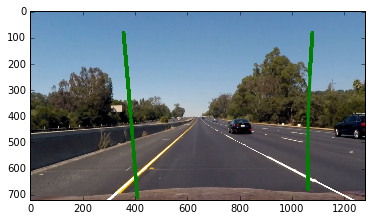

In [66]:
output = 'project_output_1000_end.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

Left coeffs: [ -9.55148393e-04   8.80937649e-01   1.99742981e+02]
righty[0]: , 483.0 , rightx[0]:  1105
Right coeffs:  [  2.80101533e-04   2.16082035e-01   1.03798375e+03]
Left lane curve radius:  720.208109878
Right lane curve radius:  2896.72622431
Left coeffs:  [ -9.55148393e-04   8.80937649e-01   1.99742981e+02]
Right fit:  [  2.80101533e-04   2.16082035e-01   1.03798375e+03]
[MoviePy] >>>> Building video project_output_22_50.mp4
[MoviePy] Writing video project_output_22_50.mp4










  0%|          | 0/701 [00:00<?, ?it/s]







  0%|          | 1/701 [00:00<05:26,  2.14it/s]

Left coeffs: [ -9.55148393e-04   8.80937649e-01   1.99742981e+02]
righty[0]: , 483.0 , rightx[0]:  1105
Right coeffs:  [  2.80101533e-04   2.16082035e-01   1.03798375e+03]
Left lane curve radius:  720.208109878
Right lane curve radius:  2896.72622431
Left coeffs:  [ -9.55148393e-04   8.80937649e-01   1.99742981e+02]
Right fit:  [  2.80101533e-04   2.16082035e-01   1.03798375e+03]










  0%|          | 2/701 [00:00<05:31,  2.11it/s]

Left coeffs: [ -5.98559748e-05   2.88966295e-01   2.75992914e+02]
righty[0]: , 516.0 , rightx[0]:  1119
Right coeffs:  [  2.49672618e-05   3.69466187e-01   1.02467829e+03]
Left lane curve radius:  8902.80213034
Right lane curve radius:  25101.0953586
Left coeffs:  [ -5.98559748e-05   2.88966295e-01   2.75992914e+02]
Right fit:  [  2.49672618e-05   3.69466187e-01   1.02467829e+03]










  0%|          | 3/701 [00:01<05:24,  2.15it/s]

Left coeffs: [ -2.61151510e-05   2.58601148e-01   2.82663813e+02]
righty[0]: , 553.0 , rightx[0]:  1131
Right coeffs:  [  4.70288101e-04   4.07669920e-02   1.07452155e+03]
Left lane curve radius:  20596.2902604
Right lane curve radius:  1868.85943457
Left coeffs:  [ -2.61151510e-05   2.58601148e-01   2.82663813e+02]
Right fit:  [  4.70288101e-04   4.07669920e-02   1.07452155e+03]










  1%|          | 4/701 [00:01<05:31,  2.10it/s]

Left coeffs: [ -1.47773029e-05   2.51225145e-01   2.81566254e+02]
righty[0]: , 463.0 , rightx[0]:  1096
Right coeffs:  [  2.22963547e-04   2.05826047e-01   1.05457659e+03]
Left lane curve radius:  36586.3868111
Right lane curve radius:  3159.90090472
Left coeffs:  [ -1.47773029e-05   2.51225145e-01   2.81566254e+02]
Right fit:  [  2.22963547e-04   2.05826047e-01   1.05457659e+03]










  1%|          | 5/701 [00:02<05:30,  2.11it/s]

Left coeffs: [  2.66297375e-05   2.16447266e-01   2.89995243e+02]
righty[0]: , 356.0 , rightx[0]:  1057
Right coeffs:  [ -4.48438197e-04   6.25117072e-01   9.91358812e+02]
Left lane curve radius:  20598.4520574
Right lane curve radius:  1115.63165928
Left coeffs:  [  2.66297375e-05   2.16447266e-01   2.89995243e+02]
Right fit:  [ -4.48438197e-04   6.25117072e-01   9.91358812e+02]










  1%|          | 6/701 [00:02<05:42,  2.03it/s]

Left coeffs: [  6.12620878e-05   1.76193398e-01   3.04390599e+02]
righty[0]: , 479.0 , rightx[0]:  1100
Right coeffs:  [ -1.31245779e-03   1.22406564e+00   8.86576450e+02]
Left lane curve radius:  8995.84147408
Right lane curve radius:  564.697746473
Left coeffs:  [  6.12620878e-05   1.76193398e-01   3.04390599e+02]
Right fit:  [ -1.31245779e-03   1.22406564e+00   8.86576450e+02]










  1%|          | 7/701 [00:03<05:37,  2.06it/s]

Left coeffs: [  3.54795480e-05   1.87199126e-01   3.06654199e+02]
righty[0]: , 495.0 , rightx[0]:  1043
Right coeffs:  [ -5.22662778e-03   4.00121396e+00   3.97709128e+02]
Left lane curve radius:  15287.8748457
Right lane curve radius:  3640.56885628
Left coeffs:  [  3.54795480e-05   1.87199126e-01   3.06654199e+02]
Right fit:  [ -5.22662778e-03   4.00121396e+00   3.97709128e+02]










  1%|          | 8/701 [00:03<05:35,  2.06it/s]

Left coeffs: [  2.71763513e-05   1.96023185e-01   2.99843214e+02]
righty[0]: , 445.0 , rightx[0]:  1065
Right coeffs:  [ -1.68866042e-03   1.64890332e+00   7.86849526e+02]
Left lane curve radius:  19914.3689002
Right lane curve radius:  493.877443009
Left coeffs:  [  2.71763513e-05   1.96023185e-01   2.99843214e+02]
Right fit:  [ -1.68866042e-03   1.64890332e+00   7.86849526e+02]










  1%|▏         | 9/701 [00:04<05:30,  2.09it/s]

Left coeffs: [  3.55497186e-05   2.12130278e-01   2.78084694e+02]
righty[0]: , 468.0 , rightx[0]:  1081
Right coeffs:  [ -3.73976269e-05   3.93135638e-01   1.03556949e+03]
Left lane curve radius:  15525.0896166
Right lane curve radius:  15780.3038797
Left coeffs:  [  3.55497186e-05   2.12130278e-01   2.78084694e+02]
Right fit:  [ -3.73976269e-05   3.93135638e-01   1.03556949e+03]










  1%|▏         | 10/701 [00:04<05:23,  2.14it/s]

Left coeffs: [  3.87718577e-05   2.60786793e-01   2.35739071e+02]
righty[0]: , 491.0 , rightx[0]:  1098
Right coeffs:  [ -1.01995261e-03   1.15837973e+00   9.06294826e+02]
Left lane curve radius:  14840.3448159
Right lane curve radius:  527.114736714
Left coeffs:  [  3.87718577e-05   2.60786793e-01   2.35739071e+02]
Right fit:  [ -1.01995261e-03   1.15837973e+00   9.06294826e+02]










  2%|▏         | 11/701 [00:05<05:29,  2.09it/s]

Left coeffs: [  3.11314980e-05   2.71616523e-01   2.23654990e+02]
righty[0]: , 488.0 , rightx[0]:  1132
Right coeffs:  [ -6.86740771e-04   8.85434460e-01   9.64071181e+02]
Left lane curve radius:  18495.1031478
Right lane curve radius:  730.950515848
Left coeffs:  [  3.11314980e-05   2.71616523e-01   2.23654990e+02]
Right fit:  [ -6.86740771e-04   8.85434460e-01   9.64071181e+02]


Init no peaks for left or right
left_x:  [array([329, 330, 330, ..., 440, 440, 449]), array([311, 312, 312, ..., 418, 419, 420]), array([275, 276, 276, ..., 379, 379, 379]), array([246, 246, 247, ..., 345, 345, 346]), array([207, 207, 208, ..., 316, 317, 317])]
right_x:  []










  2%|▏         | 12/701 [00:05<06:08,  1.87it/s]

Left coeffs: [  9.54445807e-06   3.00545641e-01   2.07839146e+02]
righty[0]: , 526.0 , rightx[0]:  1173
Right coeffs:  [ -6.27673158e-04   8.83455905e-01   9.60247767e+02]
Left lane curve radius:  60295.5396821
Right lane curve radius:  797.842274115
Left coeffs:  [  9.54445807e-06   3.00545641e-01   2.07839146e+02]
Right fit:  [ -6.27673158e-04   8.83455905e-01   9.60247767e+02]
















  2%|▏         | 13/701 [00:06<06:23,  1.79it/s]

Left coeffs: [ -3.15520669e-05   2.80641266e-01   2.40249023e+02]
righty[0]: , 322.0 , rightx[0]:  1165
Right coeffs:  [  8.04628485e-05   3.24928351e-01   1.06692681e+03]
Left lane curve radius:  17210.4875725
Right lane curve radius:  8050.29071225
Left coeffs:  [ -3.15520669e-05   2.80641266e-01   2.40249023e+02]
Right fit:  [  8.04628485e-05   3.24928351e-01   1.06692681e+03]










  2%|▏         | 14/701 [00:07<07:57,  1.44it/s]

Left coeffs: [ -3.80786592e-05   2.46541653e-01   2.71803313e+02]
righty[0]: , 125.0 , rightx[0]:  1075
Right coeffs:  [  1.79833783e-03  -2.95371524e-01   1.09858809e+03]
Left lane curve radius:  13886.0050054
Right lane curve radius:  3677.80693728
Left coeffs:  [ -3.80786592e-05   2.46541653e-01   2.71803313e+02]
Right fit:  [  1.79833783e-03  -2.95371524e-01   1.09858809e+03]










  2%|▏         | 15/701 [00:08<07:10,  1.59it/s]

Left coeffs: [ -5.88472320e-05   2.54850530e-01   2.81012065e+02]
righty[0]: , 410.0 , rightx[0]:  1172
Right coeffs:  [  1.30782134e-04   2.87934764e-01   1.03925874e+03]
Left lane curve radius:  8890.10422335
Right lane curve radius:  5129.55459204
Left coeffs:  [ -5.88472320e-05   2.54850530e-01   2.81012065e+02]
Right fit:  [  1.30782134e-04   2.87934764e-01   1.03925874e+03]










  2%|▏         | 16/701 [00:08<06:37,  1.72it/s]

Left coeffs: [ -9.37644229e-05   2.67199882e-01   2.93302190e+02]
righty[0]: , 218.0 , rightx[0]:  1085
Right coeffs:  [  1.42846346e-03  -3.75505360e-01   1.11475889e+03]
Left lane curve radius:  5485.96596258
Right lane curve radius:  2319.78448554
Left coeffs:  [ -9.37644229e-05   2.67199882e-01   2.93302190e+02]
Right fit:  [  1.42846346e-03  -3.75505360e-01   1.11475889e+03]










  2%|▏         | 17/701 [00:08<06:15,  1.82it/s]

Left coeffs: [ -2.55986836e-05   2.06830621e-01   3.09852985e+02]
righty[0]: , 519.0 , rightx[0]:  1142
Right coeffs:  [  1.76413528e-04   2.92453150e-01   1.02289318e+03]
Left lane curve radius:  20408.1849764
Right lane curve radius:  4111.88229965
Left coeffs:  [ -2.55986836e-05   2.06830621e-01   3.09852985e+02]
Right fit:  [  1.76413528e-04   2.92453150e-01   1.02289318e+03]










  3%|▎         | 18/701 [00:09<06:02,  1.89it/s]

Left coeffs: [  7.21367780e-06   1.81811653e-01   3.16643143e+02]
righty[0]: , 557.0 , rightx[0]:  1136
Right coeffs:  [ -6.38014751e-05   4.25723261e-01   1.00571837e+03]
Left lane curve radius:  73162.3315726
Right lane curve radius:  9230.81021525
Left coeffs:  [  7.21367780e-06   1.81811653e-01   3.16643143e+02]
Right fit:  [ -6.38014751e-05   4.25723261e-01   1.00571837e+03]










  3%|▎         | 19/701 [00:09<05:50,  1.95it/s]

Left coeffs: [  2.19177973e-05   1.81484478e-01   3.08850553e+02]
righty[0]: , 304.0 , rightx[0]:  1123
Right coeffs:  [  1.16975071e-03  -4.42823868e-01   1.16420562e+03]
Left lane curve radius:  24353.2356001
Right lane curve radius:  1477.3334905
Left coeffs:  [  2.19177973e-05   1.81484478e-01   3.08850553e+02]
Right fit:  [  1.16975071e-03  -4.42823868e-01   1.16420562e+03]










  3%|▎         | 20/701 [00:10<05:46,  1.97it/s]

Left coeffs: [  9.70688238e-06   2.00959108e-01   3.01180345e+02]
righty[0]: , 326.0 , rightx[0]:  1138
Right coeffs:  [  1.51186026e-03  -7.60706881e-01   1.23945454e+03]
Left lane curve radius:  55089.9565216
Right lane curve radius:  1411.7248974
Left coeffs:  [  9.70688238e-06   2.00959108e-01   3.01180345e+02]
Right fit:  [  1.51186026e-03  -7.60706881e-01   1.23945454e+03]










  3%|▎         | 21/701 [00:10<05:43,  1.98it/s]

Left coeffs: [  4.33919522e-06   2.14003117e-01   2.90956581e+02]
righty[0]: , 353.0 , rightx[0]:  1155
Right coeffs:  [  1.40597359e-03  -8.05037233e-01   1.27935823e+03]
Left lane curve radius:  123683.275451
Right lane curve radius:  1151.41859182
Left coeffs:  [  4.33919522e-06   2.14003117e-01   2.90956581e+02]
Right fit:  [  1.40597359e-03  -8.05037233e-01   1.27935823e+03]










  3%|▎         | 22/701 [00:11<05:36,  2.02it/s]

Left coeffs: [ -2.35754470e-05   2.35245512e-01   2.89768826e+02]
righty[0]: , 516.0 , rightx[0]:  1168
Right coeffs:  [  1.14837122e-03  -6.57736798e-01   1.26464225e+03]
Left lane curve radius:  22538.4158142
Right lane curve radius:  1048.55347953
Left coeffs:  [ -2.35754470e-05   2.35245512e-01   2.89768826e+02]
Right fit:  [  1.14837122e-03  -6.57736798e-01   1.26464225e+03]










  3%|▎         | 23/701 [00:11<05:34,  2.03it/s]

Left coeffs: [ -2.21820295e-05   2.41936301e-01   2.82819378e+02]
righty[0]: , 417.0 , rightx[0]:  1183
Right coeffs:  [ -8.64096507e-04   1.15621899e+00   8.61072115e+02]
Left lane curve radius:  24077.8376997
Right lane curve radius:  578.703014147
Left coeffs:  [ -2.21820295e-05   2.41936301e-01   2.82819378e+02]
Right fit:  [ -8.64096507e-04   1.15621899e+00   8.61072115e+02]










  3%|▎         | 24/701 [00:12<05:29,  2.05it/s]

Left coeffs: [ -3.25155106e-05   2.48822375e-01   2.85273710e+02]
righty[0]: , 450.0 , rightx[0]:  1197
Right coeffs:  [ -1.58927549e-04   4.90923762e-01   1.02020469e+03]
Left lane curve radius:  16356.0255836
Right lane curve radius:  3513.33854985
Left coeffs:  [ -3.25155106e-05   2.48822375e-01   2.85273710e+02]
Right fit:  [ -1.58927549e-04   4.90923762e-01   1.02020469e+03]










  4%|▎         | 25/701 [00:12<05:23,  2.09it/s]

Left coeffs: [ -6.78667060e-05   2.84201405e-01   2.78182172e+02]
righty[0]: , 485.0 , rightx[0]:  1211
Right coeffs:  [ -7.38864205e-05   4.43686893e-01   1.02398706e+03]
Left lane curve radius:  7781.01731207
Right lane curve radius:  8002.76162066
Left coeffs:  [ -6.78667060e-05   2.84201405e-01   2.78182172e+02]
Right fit:  [ -7.38864205e-05   4.43686893e-01   1.02398706e+03]










  4%|▎         | 26/701 [00:13<05:14,  2.14it/s]

Left coeffs: [ -2.71426387e-05   2.41893641e-01   2.91647144e+02]
righty[0]: , 304.0 , rightx[0]:  1154
Right coeffs:  [ -7.93453838e-06   4.00983091e-01   1.02547911e+03]
Left lane curve radius:  19597.4488381
Right lane curve radius:  77947.7101462
Left coeffs:  [ -2.71426387e-05   2.41893641e-01   2.91647144e+02]
Right fit:  [ -7.93453838e-06   4.00983091e-01   1.02547911e+03]










  4%|▍         | 27/701 [00:13<05:17,  2.12it/s]

Left coeffs: [ -1.31369825e-06   2.10865464e-01   3.01596516e+02]
righty[0]: , 183.0 , rightx[0]:  1089
Right coeffs:  [  2.85113564e-03  -8.87195178e-01   1.16522189e+03]
Left lane curve radius:  405836.155447
Right lane curve radius:  5329.74159478
Left coeffs:  [ -1.31369825e-06   2.10865464e-01   3.01596516e+02]
Right fit:  [  2.85113564e-03  -8.87195178e-01   1.16522189e+03]










  4%|▍         | 28/701 [00:14<05:15,  2.13it/s]

Left coeffs: [  9.04469742e-05   1.20048789e-01   3.25982469e+02]
righty[0]: , 228.0 , rightx[0]:  1099
Right coeffs:  [  2.22254304e-03  -7.76082174e-01   1.17392824e+03]
Left lane curve radius:  6019.89949996
Right lane curve radius:  3230.79890013
Left coeffs:  [  9.04469742e-05   1.20048789e-01   3.25982469e+02]
Right fit:  [  2.22254304e-03  -7.76082174e-01   1.17392824e+03]










  4%|▍         | 29/701 [00:14<05:22,  2.08it/s]

Left coeffs: [  4.71660923e-05   1.46887574e-01   3.24674414e+02]
righty[0]: , 508.0 , rightx[0]:  1191
Right coeffs:  [ -7.62297402e-05   4.51186807e-01   1.00830499e+03]
Left lane curve radius:  11312.3051205
Right lane curve radius:  7790.22097264
Left coeffs:  [  4.71660923e-05   1.46887574e-01   3.24674414e+02]
Right fit:  [ -7.62297402e-05   4.51186807e-01   1.00830499e+03]










  4%|▍         | 30/701 [00:15<05:49,  1.92it/s]

Left coeffs: [  6.88493517e-05   1.27078503e-01   3.29179113e+02]
righty[0]: , 437.0 , rightx[0]:  1203
Right coeffs:  [ -1.12146061e-04   4.99695459e-01   9.99467086e+02]
Left lane curve radius:  7794.57210594
Right lane curve radius:  5296.11170215
Left coeffs:  [  6.88493517e-05   1.27078503e-01   3.29179113e+02]
Right fit:  [ -1.12146061e-04   4.99695459e-01   9.99467086e+02]










  4%|▍         | 31/701 [00:15<05:38,  1.98it/s]

Left coeffs: [  6.78245164e-05   1.26319033e-01   3.29944699e+02]
righty[0]: , 502.0 , rightx[0]:  1083
Right coeffs:  [ -1.58707388e-03   1.50587144e+00   8.29742009e+02]
Left lane curve radius:  7901.76004345
Right lane curve radius:  520.373017279
Left coeffs:  [  6.78245164e-05   1.26319033e-01   3.29944699e+02]
Right fit:  [ -1.58707388e-03   1.50587144e+00   8.29742009e+02]










  5%|▍         | 32/701 [00:16<05:31,  2.02it/s]

Left coeffs: [  7.08085607e-05   1.27696413e-01   3.26736257e+02]
righty[0]: , 329.0 , rightx[0]:  1144
Right coeffs:  [  1.71624836e-03  -9.45825035e-01   1.28426342e+03]
Left lane curve radius:  7594.53767721
Right lane curve radius:  1409.95175841
Left coeffs:  [  7.08085607e-05   1.27696413e-01   3.26736257e+02]
Right fit:  [  1.71624836e-03  -9.45825035e-01   1.28426342e+03]










  5%|▍         | 33/701 [00:16<05:21,  2.08it/s]

Left coeffs: [  9.37804943e-06   1.82766860e-01   3.14611840e+02]
righty[0]: , 362.0 , rightx[0]:  1158
Right coeffs:  [  1.19136006e-03  -6.03706967e-01   1.23113037e+03]
Left lane curve radius:  56398.1268547
Right lane curve radius:  1186.81534479
Left coeffs:  [  9.37804943e-06   1.82766860e-01   3.14611840e+02]
Right fit:  [  1.19136006e-03  -6.03706967e-01   1.23113037e+03]










  5%|▍         | 34/701 [00:17<05:08,  2.16it/s]

Left coeffs: [ -3.52329910e-05   2.19865624e-01   3.10664873e+02]
righty[0]: , 416.0 , rightx[0]:  1174
Right coeffs:  [  1.14768233e-03  -6.23995904e-01   1.24521014e+03]
Left lane curve radius:  14828.9190232
Right lane curve radius:  1094.32496951
Left coeffs:  [ -3.52329910e-05   2.19865624e-01   3.10664873e+02]
Right fit:  [  1.14768233e-03  -6.23995904e-01   1.24521014e+03]










  5%|▍         | 35/701 [00:17<05:07,  2.17it/s]

Left coeffs: [ -2.63275971e-05   2.28357874e-01   2.97625968e+02]
righty[0]: , 426.0 , rightx[0]:  1182
Right coeffs:  [ -1.20180928e-04   5.35672781e-01   9.82882471e+02]
Left lane curve radius:  20061.5346634
Right lane curve radius:  5062.69865139
Left coeffs:  [ -2.63275971e-05   2.28357874e-01   2.97625968e+02]
Right fit:  [ -1.20180928e-04   5.35672781e-01   9.82882471e+02]










  5%|▌         | 36/701 [00:18<05:07,  2.16it/s]

Left coeffs: [  1.11056078e-05   1.87292361e-01   3.13894840e+02]
righty[0]: , 461.0 , rightx[0]:  1195
Right coeffs:  [ -1.65985357e-04   5.84354260e-01   9.70204485e+02]
Left lane curve radius:  47812.5547265
Right lane curve radius:  3619.737793
Left coeffs:  [  1.11056078e-05   1.87292361e-01   3.13894840e+02]
Right fit:  [ -1.65985357e-04   5.84354260e-01   9.70204485e+02]










  5%|▌         | 37/701 [00:18<04:59,  2.21it/s]

Left coeffs: [  6.64971521e-06   1.99810633e-01   3.05125252e+02]
righty[0]: , 534.0 , rightx[0]:  1201
Right coeffs:  [  3.19681405e-05   4.46627517e-01   9.90355775e+02]
Left lane curve radius:  80159.7473335
Right lane curve radius:  21590.4135602
Left coeffs:  [  6.64971521e-06   1.99810633e-01   3.05125252e+02]
Right fit:  [  3.19681405e-05   4.46627517e-01   9.90355775e+02]










  5%|▌         | 38/701 [00:18<04:54,  2.25it/s]

Left coeffs: [  2.49520615e-05   1.78057944e-01   3.14260519e+02]
righty[0]: , 189.0 , rightx[0]:  1060
Right coeffs:  [  1.86127101e-03  -4.22737688e-01   1.08839332e+03]
Left lane curve radius:  21399.7605358
Right lane curve radius:  3312.06896726
Left coeffs:  [  2.49520615e-05   1.78057944e-01   3.14260519e+02]
Right fit:  [  1.86127101e-03  -4.22737688e-01   1.08839332e+03]










  6%|▌         | 39/701 [00:19<04:58,  2.22it/s]

Left coeffs: [  6.85415452e-05   1.42931355e-01   3.19174828e+02]
righty[0]: , 211.0 , rightx[0]:  1072
Right coeffs:  [  8.07404289e-04   6.58104892e-02   1.03483096e+03]
Left lane curve radius:  7908.3953003
Right lane curve radius:  2200.26282015
Left coeffs:  [  6.85415452e-05   1.42931355e-01   3.19174828e+02]
Right fit:  [  8.07404289e-04   6.58104892e-02   1.03483096e+03]










  6%|▌         | 40/701 [00:19<05:06,  2.16it/s]

Left coeffs: [  1.41347847e-04   7.74326739e-02   3.27353505e+02]
righty[0]: , 228.0 , rightx[0]:  1089
Right coeffs:  [ -1.11364858e-03   1.04024169e+00   9.19401539e+02]
Left lane curve radius:  3925.98139964
Right lane curve radius:  600.951198961
Left coeffs:  [  1.41347847e-04   7.74326739e-02   3.27353505e+02]
Right fit:  [ -1.11364858e-03   1.04024169e+00   9.19401539e+02]










  6%|▌         | 41/701 [00:20<05:05,  2.16it/s]

Left coeffs: [  8.08351266e-06   2.08529583e-01   2.90632818e+02]
righty[0]: , 254.0 , rightx[0]:  1101
Right coeffs:  [ -3.50206883e-04   6.36760032e-01   9.73549000e+02]
Left lane curve radius:  66375.5458885
Right lane curve radius:  1485.69962066
Left coeffs:  [  8.08351266e-06   2.08529583e-01   2.90632818e+02]
Right fit:  [ -3.50206883e-04   6.36760032e-01   9.73549000e+02]










  6%|▌         | 42/701 [00:20<04:59,  2.20it/s]

Left coeffs: [ -8.01263105e-05   2.87302294e-01   2.73678227e+02]
righty[0]: , 288.0 , rightx[0]:  1113
Right coeffs:  [  4.61857547e-04   9.96147685e-02   1.05954676e+03]
Left lane curve radius:  6542.35114648
Right lane curve radius:  2037.24477834
Left coeffs:  [ -8.01263105e-05   2.87302294e-01   2.73678227e+02]
Right fit:  [  4.61857547e-04   9.96147685e-02   1.05954676e+03]










  6%|▌         | 43/701 [00:21<04:55,  2.23it/s]

Left coeffs: [ -8.64131351e-05   3.03891758e-01   2.63302883e+02]
righty[0]: , 479.0 , rightx[0]:  1112
Right coeffs:  [ -4.01227950e-03   3.29134609e+00   4.94431771e+02]
Left lane curve radius:  6093.07296418
Right lane curve radius:  1614.68194726
Left coeffs:  [ -8.64131351e-05   3.03891758e-01   2.63302883e+02]
Right fit:  [ -4.01227950e-03   3.29134609e+00   4.94431771e+02]










  6%|▋         | 44/701 [00:21<04:49,  2.27it/s]

Left coeffs: [ -1.11613260e-04   3.33025098e-01   2.52125351e+02]
righty[0]: , 346.0 , rightx[0]:  1138
Right coeffs:  [  5.88766672e-04  -5.55524276e-02   1.10023936e+03]
Left lane curve radius:  4703.92198049
Right lane curve radius:  1638.83574603
Left coeffs:  [ -1.11613260e-04   3.33025098e-01   2.52125351e+02]
Right fit:  [  5.88766672e-04  -5.55524276e-02   1.10023936e+03]










  6%|▋         | 45/701 [00:22<04:44,  2.30it/s]

Left coeffs: [ -1.13565431e-04   3.37217400e-01   2.51456270e+02]
righty[0]: , 381.0 , rightx[0]:  1149
Right coeffs:  [ -7.14765386e-05   5.03137078e-01   9.80086925e+02]
Left lane curve radius:  4627.4217205
Right lane curve radius:  8798.95687861
Left coeffs:  [ -1.13565431e-04   3.37217400e-01   2.51456270e+02]
Right fit:  [ -7.14765386e-05   5.03137078e-01   9.80086925e+02]










  7%|▋         | 46/701 [00:22<04:47,  2.28it/s]

Left coeffs: [ -2.65845291e-05   2.64962690e-01   2.61389524e+02]
righty[0]: , 417.0 , rightx[0]:  1168
Right coeffs:  [ -2.93358122e-04   7.16615375e-01   9.31046009e+02]
Left lane curve radius:  20306.8918428
Right lane curve radius:  1972.78100375
Left coeffs:  [ -2.65845291e-05   2.64962690e-01   2.61389524e+02]
Right fit:  [ -2.93358122e-04   7.16615375e-01   9.31046009e+02]










  7%|▋         | 47/701 [00:23<05:09,  2.12it/s]

Left coeffs: [ -2.75333683e-05   2.77484843e-01   2.52735554e+02]
righty[0]: , 544.0 , rightx[0]:  1134
Right coeffs:  [ -2.16286695e-03   2.55717175e+00   4.80232443e+02]
Left lane curve radius:  19754.6642199
Right lane curve radius:  279.425306865
Left coeffs:  [ -2.75333683e-05   2.77484843e-01   2.52735554e+02]
Right fit:  [ -2.16286695e-03   2.55717175e+00   4.80232443e+02]










  7%|▋         | 48/701 [00:23<05:22,  2.03it/s]

Left coeffs: [  1.14115132e-05   2.42831732e-01   2.56649900e+02]
righty[0]: , 563.0 , rightx[0]:  1066
Right coeffs:  [ -9.30335282e-03   9.83097329e+00  -1.36917027e+03]
Left lane curve radius:  48272.1183443
Right lane curve radius:  1367.14412363
Left coeffs:  [  1.14115132e-05   2.42831732e-01   2.56649900e+02]
Right fit:  [ -9.30335282e-03   9.83097329e+00  -1.36917027e+03]










  7%|▋         | 49/701 [00:24<05:21,  2.03it/s]

Left coeffs: [  1.25170305e-05   2.42388539e-01   2.53452640e+02]
righty[0]: , 526.0 , rightx[0]:  1167
Right coeffs:  [ -8.31672587e-05   4.45234844e-01   1.01394848e+03]
Left lane curve radius:  44042.4304825
Right lane curve radius:  7036.84140218
Left coeffs:  [  1.25170305e-05   2.42388539e-01   2.53452640e+02]
Right fit:  [ -8.31672587e-05   4.45234844e-01   1.01394848e+03]










  7%|▋         | 50/701 [00:24<05:20,  2.03it/s]

Left coeffs: [  1.70612372e-05   2.37554865e-01   2.53502256e+02]
righty[0]: , 151.0 , rightx[0]:  1068
Right coeffs:  [  8.61877822e-04   1.07682348e-01   1.03829087e+03]
Left lane curve radius:  32343.8332884
Right lane curve radius:  2473.15774391
Left coeffs:  [  1.70612372e-05   2.37554865e-01   2.53502256e+02]
Right fit:  [  8.61877822e-04   1.07682348e-01   1.03829087e+03]


Init no peaks for left or right
left_x:  [array([361, 362, 363, ..., 468, 469, 470]), array([333, 334, 334, ..., 446, 446, 446]), array([303, 304, 304, ..., 385, 385, 386]), array([290, 290, 290, ..., 354, 354, 355])]
right_x:  []










  7%|▋         | 51/701 [00:25<06:22,  1.70it/s]

Left coeffs: [ -1.02032824e-05   2.76916522e-01   2.34246232e+02]
righty[0]: , 417.0 , rightx[0]:  1168
Right coeffs:  [ -2.06314442e-04   5.01284233e-01   1.01252403e+03]
Left lane curve radius:  54169.3500038
Right lane curve radius:  2596.63652421
Left coeffs:  [ -1.02032824e-05   2.76916522e-01   2.34246232e+02]
Right fit:  [ -2.06314442e-04   5.01284233e-01   1.01252403e+03]










  7%|▋         | 52/701 [00:25<06:09,  1.76it/s]

Left coeffs: [  1.08811483e-05   2.63596953e-01   2.31810931e+02]
righty[0]: , 192.0 , rightx[0]:  1098
Right coeffs:  [ -1.08757900e-03   9.88228776e-01   9.47609520e+02]
Left lane curve radius:  51394.4542408
Right lane curve radius:  633.909630694
Left coeffs:  [  1.08811483e-05   2.63596953e-01   2.31810931e+02]
Right fit:  [ -1.08757900e-03   9.88228776e-01   9.47609520e+02]










  8%|▊         | 53/701 [00:26<05:59,  1.80it/s]

Left coeffs: [ -4.12092597e-05   3.03359061e-01   2.23267616e+02]
righty[0]: , 227.0 , rightx[0]:  1109
Right coeffs:  [ -1.63766499e-03   1.31954882e+00   8.99361262e+02]
Left lane curve radius:  13257.1220105
Right lane curve radius:  782.075031887
Left coeffs:  [ -4.12092597e-05   3.03359061e-01   2.23267616e+02]
Right fit:  [ -1.63766499e-03   1.31954882e+00   8.99361262e+02]










  8%|▊         | 54/701 [00:26<05:41,  1.89it/s]

Left coeffs: [  3.53209317e-05   2.24198414e-01   2.42526063e+02]
righty[0]: , 265.0 , rightx[0]:  1121
Right coeffs:  [ -1.40217017e-03   1.27168643e+00   8.88427748e+02]
Left lane curve radius:  15758.3993799
Right lane curve radius:  592.9478584
Left coeffs:  [  3.53209317e-05   2.24198414e-01   2.42526063e+02]
Right fit:  [ -1.40217017e-03   1.27168643e+00   8.88427748e+02]










  8%|▊         | 55/701 [00:27<05:30,  1.96it/s]

Left coeffs: [  4.15203595e-05   1.98359156e-01   2.57753924e+02]
righty[0]: , 304.0 , rightx[0]:  1129
Right coeffs:  [ -7.42616317e-05   4.85169507e-01   9.93078925e+02]
Left lane curve radius:  13234.8948555
Right lane curve radius:  8276.00132359
Left coeffs:  [  4.15203595e-05   1.98359156e-01   2.57753924e+02]
Right fit:  [ -7.42616317e-05   4.85169507e-01   9.93078925e+02]










  8%|▊         | 56/701 [00:27<05:14,  2.05it/s]

Left coeffs: [  1.18228404e-04   9.08735312e-02   2.95993832e+02]
righty[0]: , 340.0 , rightx[0]:  1136
Right coeffs:  [ -8.23333058e-04   1.08776923e+00   8.66607762e+02]
Left lane curve radius:  4637.17246088
Right lane curve radius:  608.218570972
Left coeffs:  [  1.18228404e-04   9.08735312e-02   2.95993832e+02]
Right fit:  [ -8.23333058e-04   1.08776923e+00   8.66607762e+02]










  8%|▊         | 57/701 [00:28<05:13,  2.06it/s]

Left coeffs: [ -7.21701377e-04   9.75972006e-01   6.90544116e+01]
righty[0]: , 373.0 , rightx[0]:  1146
Right coeffs:  [  1.24337796e-04   3.40498869e-01   1.00673193e+03]
Left lane curve radius:  692.839240896
Right lane curve radius:  5685.42018059
Left coeffs:  [ -7.21701377e-04   9.75972006e-01   6.90544116e+01]
Right fit:  [  1.24337796e-04   3.40498869e-01   1.00673193e+03]










  8%|▊         | 58/701 [00:28<05:14,  2.05it/s]

Left coeffs: [  1.54458471e-05   1.82130643e-01   2.72259025e+02]
righty[0]: , 415.0 , rightx[0]:  1161
Right coeffs:  [  1.16678328e-04   3.52850757e-01   1.00099351e+03]
Left lane curve radius:  34395.367395
Right lane curve radius:  6072.90603358
Left coeffs:  [  1.54458471e-05   1.82130643e-01   2.72259025e+02]
Right fit:  [  1.16678328e-04   3.52850757e-01   1.00099351e+03]










  8%|▊         | 59/701 [00:29<05:15,  2.04it/s]

Left coeffs: [ -1.97734412e-05   2.05823810e-01   2.65156173e+02]
righty[0]: , 525.0 , rightx[0]:  1122
Right coeffs:  [ -4.37857883e-04   8.50629374e-01   8.88107168e+02]
Left lane curve radius:  26509.9471475
Right lane curve radius:  1254.43494598
Left coeffs:  [ -1.97734412e-05   2.05823810e-01   2.65156173e+02]
Right fit:  [ -4.37857883e-04   8.50629374e-01   8.88107168e+02]










  9%|▊         | 60/701 [00:29<05:09,  2.07it/s]

Left coeffs: [  1.35048858e-05   2.03087151e-01   2.53186248e+02]
righty[0]: , 515.0 , rightx[0]:  1105
Right coeffs:  [ -9.93624186e-03   1.03699402e+01  -1.49375834e+03]
Left lane curve radius:  39781.680732
Right lane curve radius:  1869.01438434
Left coeffs:  [  1.35048858e-05   2.03087151e-01   2.53186248e+02]
Right fit:  [ -9.93624186e-03   1.03699402e+01  -1.49375834e+03]










  9%|▊         | 61/701 [00:30<05:05,  2.10it/s]

Left coeffs: [  9.69771361e-05   1.55605064e-01   2.49464953e+02]
righty[0]: , 552.0 , rightx[0]:  1107
Right coeffs:  [ -1.58440438e-02   1.68766034e+01  -3.28042995e+03]
Left lane curve radius:  5813.50104356
Right lane curve radius:  3858.26290604
Left coeffs:  [  9.69771361e-05   1.55605064e-01   2.49464953e+02]
Right fit:  [ -1.58440438e-02   1.68766034e+01  -3.28042995e+03]


Init no peaks for left or right
left_x:  [array([286, 287, 288, ..., 410, 410, 410]), array([332, 332, 332, ..., 396, 397, 398]), array([267, 267, 267, ..., 391, 392, 392]), array([267, 267, 267, ..., 335, 336, 336])]
right_x:  []
Init no peaks for left or right
left_x:  [array([286, 287, 287, ..., 411, 412, 427]), array([322, 323, 324, ..., 425, 426, 427]), array([210, 210, 210, ..., 396, 397, 397]), array([259, 260, 260, ..., 396, 397, 397]), array([204, 205, 259, ..., 336, 336, 336])]
right_x:  []










  9%|▉         | 62/701 [00:31<07:21,  1.45it/s]

Left coeffs: [ -1.01507995e-04   2.75572137e-01   2.52612258e+02]
righty[0]: , 562.0 , rightx[0]:  1119
Right coeffs:  [ -6.00899609e-03   5.93233348e+00  -2.31804916e+02]
Left lane curve radius:  5058.71788706
Right lane curve radius:  1551.9683422
Left coeffs:  [ -1.01507995e-04   2.75572137e-01   2.52612258e+02]
Right fit:  [ -6.00899609e-03   5.93233348e+00  -2.31804916e+02]










  9%|▉         | 63/701 [00:31<06:41,  1.59it/s]

Left coeffs: [  2.54579516e-04  -1.96718824e-03   2.89629120e+02]
righty[0]: , 85.0 , rightx[0]:  1021
Right coeffs:  [ -3.52253566e-03   1.09769217e+00   9.71575277e+02]
Left lane curve radius:  2325.51125939
Right lane curve radius:  8034.47989015
Left coeffs:  [  2.54579516e-04  -1.96718824e-03   2.89629120e+02]
Right fit:  [ -3.52253566e-03   1.09769217e+00   9.71575277e+02]










  9%|▉         | 64/701 [00:32<06:19,  1.68it/s]

Left coeffs: [  2.61029959e-04  -3.17808771e-02   3.04830941e+02]
righty[0]: , 111.0 , rightx[0]:  1029
Right coeffs:  [ -8.39817505e-04   5.04033434e-01   1.00219141e+03]
Left lane curve radius:  2225.40880183
Right lane curve radius:  998.397387482
Left coeffs:  [  2.61029959e-04  -3.17808771e-02   3.04830941e+02]
Right fit:  [ -8.39817505e-04   5.04033434e-01   1.00219141e+03]










  9%|▉         | 65/701 [00:32<05:57,  1.78it/s]

Left coeffs: [  2.87943865e-04  -6.08536014e-02   3.09143182e+02]
righty[0]: , 137.0 , rightx[0]:  1039
Right coeffs:  [ -8.44821146e-04   5.35107645e-01   1.00173707e+03]
Left lane curve radius:  2031.13995093
Right lane curve radius:  960.466047869
Left coeffs:  [  2.87943865e-04  -6.08536014e-02   3.09143182e+02]
Right fit:  [ -8.44821146e-04   5.35107645e-01   1.00173707e+03]










  9%|▉         | 66/701 [00:33<05:38,  1.88it/s]

Left coeffs: [  3.47689937e-04  -1.43149891e-01   3.32674025e+02]
righty[0]: , 515.0 , rightx[0]:  1071
Right coeffs:  [  1.28677239e-04   2.53313800e-01   1.01806781e+03]
Left lane curve radius:  1680.90516688
Right lane curve radius:  5005.39014036
Left coeffs:  [  3.47689937e-04  -1.43149891e-01   3.32674025e+02]
Right fit:  [  1.28677239e-04   2.53313800e-01   1.01806781e+03]










 10%|▉         | 67/701 [00:33<05:25,  1.95it/s]

Left coeffs: [  3.15654809e-04  -1.34909758e-01   3.41793755e+02]
righty[0]: , 194.0 , rightx[0]:  1056
Right coeffs:  [ -1.67047736e-04   3.39708830e-01   1.01296072e+03]
Left lane curve radius:  1804.56869029
Right lane curve radius:  3046.50836805
Left coeffs:  [  3.15654809e-04  -1.34909758e-01   3.41793755e+02]
Right fit:  [ -1.67047736e-04   3.39708830e-01   1.01296072e+03]










 10%|▉         | 68/701 [00:34<05:18,  1.99it/s]

Left coeffs: [  3.43806465e-04  -1.74514052e-01   3.54418219e+02]
righty[0]: , 225.0 , rightx[0]:  1065
Right coeffs:  [ -6.60723761e-05   3.06218055e-01   1.01819420e+03]
Left lane curve radius:  1651.16872075
Right lane curve radius:  8101.0189219
Left coeffs:  [  3.43806465e-04  -1.74514052e-01   3.54418219e+02]
Right fit:  [ -6.60723761e-05   3.06218055e-01   1.01819420e+03]










 10%|▉         | 69/701 [00:34<05:29,  1.92it/s]

Left coeffs: [  3.84646538e-04  -2.62730887e-01   3.92663951e+02]
righty[0]: , 260.0 , rightx[0]:  1073
Right coeffs:  [  3.64651237e-05   2.78924299e-01   1.01465164e+03]
Left lane curve radius:  1435.93385708
Right lane curve radius:  15992.3849692
Left coeffs:  [  3.84646538e-04  -2.62730887e-01   3.92663951e+02]
Right fit:  [  3.64651237e-05   2.78924299e-01   1.01465164e+03]










 10%|▉         | 70/701 [00:35<05:26,  1.93it/s]

Left coeffs: [  1.90110339e-04  -7.22827639e-02   3.52107723e+02]
righty[0]: , 289.0 , rightx[0]:  1085
Right coeffs:  [ -7.32233953e-04   7.58633871e-01   9.46463152e+02]
Left lane curve radius:  2769.24774875
Right lane curve radius:  742.748372289
Left coeffs:  [  1.90110339e-04  -7.22827639e-02   3.52107723e+02]
Right fit:  [ -7.32233953e-04   7.58633871e-01   9.46463152e+02]










 10%|█         | 71/701 [00:35<05:14,  2.00it/s]

Left coeffs: [  8.11622414e-05  -2.21177968e-02   3.54500764e+02]
righty[0]: , 315.0 , rightx[0]:  1095
Right coeffs:  [ -6.55164952e-04   7.81597341e-01   9.31566174e+02]
Left lane curve radius:  6237.49322311
Right lane curve radius:  783.509326087
Left coeffs:  [  8.11622414e-05  -2.21177968e-02   3.54500764e+02]
Right fit:  [ -6.55164952e-04   7.81597341e-01   9.31566174e+02]










 10%|█         | 72/701 [00:36<05:14,  2.00it/s]

Left coeffs: [  7.06928717e-05  -3.22007712e-04   3.47125417e+02]
righty[0]: , 339.0 , rightx[0]:  1109
Right coeffs:  [ -7.06734175e-04   8.29334424e-01   9.27934525e+02]
Left lane curve radius:  7176.34308135
Right lane curve radius:  734.852073307
Left coeffs:  [  7.06928717e-05  -3.22007712e-04   3.47125417e+02]
Right fit:  [ -7.06734175e-04   8.29334424e-01   9.27934525e+02]










 10%|█         | 73/701 [00:36<05:09,  2.03it/s]

Left coeffs: [  9.45829950e-05  -1.80615164e-02   3.54457229e+02]
righty[0]: , 362.0 , rightx[0]:  1124
Right coeffs:  [  7.12914314e-04  -2.73691049e-01   1.14572456e+03]
Left lane curve radius:  5388.67610291
Right lane curve radius:  1307.13398804
Left coeffs:  [  9.45829950e-05  -1.80615164e-02   3.54457229e+02]
Right fit:  [  7.12914314e-04  -2.73691049e-01   1.14572456e+03]










 11%|█         | 74/701 [00:37<05:01,  2.08it/s]

Left coeffs: [  1.43261720e-04  -5.99702614e-02   3.66679527e+02]
righty[0]: , 584.0 , rightx[0]:  1073
Right coeffs:  [ -4.34958591e-03   4.15593096e+00   1.85148873e+02]
Left lane curve radius:  3587.40892406
Right lane curve radius:  996.361465748
Left coeffs:  [  1.43261720e-04  -5.99702614e-02   3.66679527e+02]
Right fit:  [ -4.34958591e-03   4.15593096e+00   1.85148873e+02]










 11%|█         | 75/701 [00:37<04:53,  2.14it/s]

Left coeffs: [  2.58020766e-04  -1.90376101e-01   4.20048586e+02]
righty[0]: , 586.0 , rightx[0]:  1081
Right coeffs:  [ -2.43871117e-06   3.10131555e-01   1.02660714e+03]
Left lane curve radius:  2015.18140543
Right lane curve radius:  234643.812421
Left coeffs:  [  2.58020766e-04  -1.90376101e-01   4.20048586e+02]
Right fit:  [ -2.43871117e-06   3.10131555e-01   1.02660714e+03]










 11%|█         | 76/701 [00:38<04:57,  2.10it/s]

Left coeffs: [ -2.28904066e-03   1.55513484e+00   1.78927661e+02]
righty[0]: , 586.0 , rightx[0]:  1081
Right coeffs:  [  1.42584670e-04   2.17179141e-01   1.04022269e+03]
Left lane curve radius:  1716.21988735
Right lane curve radius:  4479.50769579
Left coeffs:  [ -2.28904066e-03   1.55513484e+00   1.78927661e+02]
Right fit:  [  1.42584670e-04   2.17179141e-01   1.04022269e+03]










 11%|█         | 77/701 [00:38<05:02,  2.06it/s]

Left coeffs: [ -8.22904034e-04   5.70160008e-01   3.19447938e+02]
righty[0]: , 586.0 , rightx[0]:  1081
Right coeffs:  [  1.41963390e-04   2.11023841e-01   1.04553640e+03]
Left lane curve radius:  974.271199556
Right lane curve radius:  4466.77961936
Left coeffs:  [ -8.22904034e-04   5.70160008e-01   3.19447938e+02]
Right fit:  [  1.41963390e-04   2.11023841e-01   1.04553640e+03]










 11%|█         | 78/701 [00:39<05:02,  2.06it/s]

Left coeffs: [  3.59155623e-04  -3.09211412e-01   4.70543023e+02]
righty[0]: , 586.0 , rightx[0]:  1080
Right coeffs:  [  6.56234452e-05   2.63021166e-01   1.03505437e+03]
Left lane curve radius:  1459.2337383
Right lane curve radius:  9079.48139666
Left coeffs:  [  3.59155623e-04  -3.09211412e-01   4.70543023e+02]
Right fit:  [  6.56234452e-05   2.63021166e-01   1.03505437e+03]










 11%|█▏        | 79/701 [00:39<05:04,  2.05it/s]

Left coeffs: [  2.88313648e-04  -2.54137284e-01   4.60098257e+02]
righty[0]: , 206.0 , rightx[0]:  1084
Right coeffs:  [ -2.26035981e-04   3.68851004e-01   1.03364648e+03]
Left lane curve radius:  1783.55815734
Right lane curve radius:  2224.76046695
Left coeffs:  [  2.88313648e-04  -2.54137284e-01   4.60098257e+02]
Right fit:  [ -2.26035981e-04   3.68851004e-01   1.03364648e+03]










 11%|█▏        | 80/701 [00:40<05:14,  1.97it/s]

Left coeffs: [  2.51526058e-04  -1.90859855e-01   4.27338419e+02]
righty[0]: , 206.0 , rightx[0]:  1100
Right coeffs:  [  4.37968700e-04   3.76775061e-03   1.09783314e+03]
Left lane curve radius:  2056.43615565
Right lane curve radius:  1809.22870864
Left coeffs:  [  2.51526058e-04  -1.90859855e-01   4.27338419e+02]
Right fit:  [  4.37968700e-04   3.76775061e-03   1.09783314e+03]










 12%|█▏        | 81/701 [00:40<05:07,  2.02it/s]

Left coeffs: [  1.95379570e-04  -1.26524787e-01   3.99464995e+02]
righty[0]: , 220.0 , rightx[0]:  1114
Right coeffs:  [  8.74457102e-04  -2.50086710e-01   1.14404204e+03]
Left lane curve radius:  2636.83262342
Right lane curve radius:  1503.62879652
Left coeffs:  [  1.95379570e-04  -1.26524787e-01   3.99464995e+02]
Right fit:  [  8.74457102e-04  -2.50086710e-01   1.14404204e+03]










 12%|█▏        | 82/701 [00:41<05:10,  1.99it/s]

Left coeffs: [  1.50605849e-04  -7.65378008e-02   3.79808877e+02]
righty[0]: , 243.0 , rightx[0]:  1124
Right coeffs:  [ -7.30584626e-05   2.64558116e-01   1.08128896e+03]
Left lane curve radius:  3403.38432495
Right lane curve radius:  7124.39036117
Left coeffs:  [  1.50605849e-04  -7.65378008e-02   3.79808877e+02]
Right fit:  [ -7.30584626e-05   2.64558116e-01   1.08128896e+03]










 12%|█▏        | 83/701 [00:41<05:02,  2.04it/s]

Left coeffs: [  1.52655843e-04  -7.83156395e-02   3.78366508e+02]
righty[0]: , 279.0 , rightx[0]:  1130
Right coeffs:  [ -6.88035860e-05   2.72520246e-01   1.08017917e+03]
Left lane curve radius:  3358.9947302
Right lane curve radius:  7617.26920004
Left coeffs:  [  1.52655843e-04  -7.83156395e-02   3.78366508e+02]
Right fit:  [ -6.88035860e-05   2.72520246e-01   1.08017917e+03]










 12%|█▏        | 84/701 [00:42<04:55,  2.09it/s]

Left coeffs: [  1.45187770e-04  -9.06727971e-02   3.92686809e+02]
righty[0]: , 312.0 , rightx[0]:  1136
Right coeffs:  [  1.34126502e-04   1.84876963e-01   1.08113774e+03]
Left lane curve radius:  3503.85657998
Right lane curve radius:  4510.57709215
Left coeffs:  [  1.45187770e-04  -9.06727971e-02   3.92686809e+02]
Right fit:  [  1.34126502e-04   1.84876963e-01   1.08113774e+03]










 12%|█▏        | 85/701 [00:42<04:57,  2.07it/s]

Left coeffs: [  1.42136707e-04  -1.15317381e-01   4.17818743e+02]
righty[0]: , 352.0 , rightx[0]:  1140
Right coeffs:  [  1.08134732e-03  -5.59055039e-01   1.21914092e+03]
Left lane curve radius:  3550.59025045
Right lane curve radius:  1156.74513646
Left coeffs:  [  1.42136707e-04  -1.15317381e-01   4.17818743e+02]
Right fit:  [  1.08134732e-03  -5.59055039e-01   1.21914092e+03]










 12%|█▏        | 86/701 [00:43<04:56,  2.08it/s]

Left coeffs: [  1.63606383e-04  -1.58538477e-01   4.46743782e+02]
righty[0]: , 388.0 , rightx[0]:  1146
Right coeffs:  [  8.68226268e-04  -4.36136051e-01   1.20101296e+03]
Left lane curve radius:  3075.08438885
Right lane curve radius:  1118.94785014
Left coeffs:  [  1.63606383e-04  -1.58538477e-01   4.46743782e+02]
Right fit:  [  8.68226268e-04  -4.36136051e-01   1.20101296e+03]










 12%|█▏        | 87/701 [00:43<04:59,  2.05it/s]

Left coeffs: [  1.73492948e-04  -1.93704897e-01   4.76901452e+02]
righty[0]: , 585.0 , rightx[0]:  1075
Right coeffs:  [ -2.74532428e-05   3.68271158e-01   1.01609327e+03]
Left lane curve radius:  2889.55371353
Right lane curve radius:  21286.2474601
Left coeffs:  [  1.73492948e-04  -1.93704897e-01   4.76901452e+02]
Right fit:  [ -2.74532428e-05   3.68271158e-01   1.01609327e+03]










 13%|█▎        | 88/701 [00:44<04:56,  2.07it/s]

Left coeffs: [  1.83629456e-04  -2.01066275e-01   4.82879567e+02]
righty[0]: , 583.0 , rightx[0]:  1080
Right coeffs:  [  2.42664841e-04   1.98064704e-01   1.03699903e+03]
Left lane curve radius:  2732.12156769
Right lane curve radius:  2974.56896542
Left coeffs:  [  1.83629456e-04  -2.01066275e-01   4.82879567e+02]
Right fit:  [  2.42664841e-04   1.98064704e-01   1.03699903e+03]










 13%|█▎        | 89/701 [00:44<04:47,  2.13it/s]

Left coeffs: [  1.73261993e-04  -1.71121295e-01   4.69749257e+02]
righty[0]: , 481.0 , rightx[0]:  1181
Right coeffs:  [  3.05914844e-04   1.41338082e-01   1.05360697e+03]
Left lane curve radius:  2903.26159085
Right lane curve radius:  2446.78533956
Left coeffs:  [  1.73261993e-04  -1.71121295e-01   4.69749257e+02]
Right fit:  [  3.05914844e-04   1.41338082e-01   1.05360697e+03]










 13%|█▎        | 90/701 [00:44<04:42,  2.16it/s]

Left coeffs: [  1.58499363e-04  -1.25810181e-01   4.44593063e+02]
righty[0]: , 480.0 , rightx[0]:  1177
Right coeffs:  [  3.28814526e-04   1.04372385e-01   1.07159538e+03]
Left lane curve radius:  3191.97150471
Right lane curve radius:  2259.22026693
Left coeffs:  [  1.58499363e-04  -1.25810181e-01   4.44593063e+02]
Right fit:  [  3.28814526e-04   1.04372385e-01   1.07159538e+03]


Init no peaks for left or right
left_x:  [array([394, 394, 394, ..., 451, 451, 452]), array([388, 388, 389, ..., 451, 451, 452]), array([380, 381, 381, ..., 439, 439, 440]), array([380, 380, 380, ..., 437, 437, 438]), array([379, 379, 379, ..., 447, 447, 447])]
right_x:  []










 13%|█▎        | 91/701 [00:45<05:15,  1.93it/s]

Left coeffs: [  1.39961648e-04  -8.04856332e-02   4.19378591e+02]
righty[0]: , 510.0 , rightx[0]:  1189
Right coeffs:  [ -4.40239229e-02   4.73069847e+01  -1.14782503e+04]
Left lane curve radius:  3636.61739596
Right lane curve radius:  21810.6215308
Left coeffs:  [  1.39961648e-04  -8.04856332e-02   4.19378591e+02]
Right fit:  [ -4.40239229e-02   4.73069847e+01  -1.14782503e+04]










 13%|█▎        | 92/701 [00:46<05:12,  1.95it/s]

Left coeffs: [  1.23167839e-04  -5.88470651e-02   4.13087631e+02]
righty[0]: , 193.0 , rightx[0]:  1104
Right coeffs:  [  9.86831480e-04  -2.25301634e-01   1.12916151e+03]
Left lane curve radius:  4130.95615322
Right lane curve radius:  1696.83064681
Left coeffs:  [  1.23167839e-04  -5.88470651e-02   4.13087631e+02]
Right fit:  [  9.86831480e-04  -2.25301634e-01   1.12916151e+03]










 13%|█▎        | 93/701 [00:46<05:04,  2.00it/s]

Left coeffs: [  1.25404829e-04  -6.61323584e-02   4.21631135e+02]
righty[0]: , 221.0 , rightx[0]:  1109
Right coeffs:  [  6.00034601e-04  -6.12888422e-02   1.11227379e+03]
Left lane curve radius:  4051.53105808
Right lane curve radius:  1630.22708509
Left coeffs:  [  1.25404829e-04  -6.61323584e-02   4.21631135e+02]
Right fit:  [  6.00034601e-04  -6.12888422e-02   1.11227379e+03]










 13%|█▎        | 94/701 [00:47<04:57,  2.04it/s]

Left coeffs: [  1.15941156e-04  -7.02313480e-02   4.33580013e+02]
righty[0]: , 253.0 , rightx[0]:  1115
Right coeffs:  [  1.07689671e-03  -3.54731096e-01   1.15528973e+03]
Left lane curve radius:  4361.04777529
Right lane curve radius:  1528.2136738
Left coeffs:  [  1.15941156e-04  -7.02313480e-02   4.33580013e+02]
Right fit:  [  1.07689671e-03  -3.54731096e-01   1.15528973e+03]










 14%|█▎        | 95/701 [00:47<04:55,  2.05it/s]

Left coeffs: [  1.11541473e-04  -6.89502725e-02   4.38325412e+02]
righty[0]: , 304.0 , rightx[0]:  1131
Right coeffs:  [  1.54533608e-05   2.66396241e-01   1.06548078e+03]
Left lane curve radius:  4527.51772262
Right lane curve radius:  36441.7595344
Left coeffs:  [  1.11541473e-04  -6.89502725e-02   4.38325412e+02]
Right fit:  [  1.54533608e-05   2.66396241e-01   1.06548078e+03]










 14%|█▎        | 96/701 [00:47<04:53,  2.06it/s]

Left coeffs: [  1.03059772e-04  -7.02674347e-02   4.47392230e+02]
righty[0]: , 313.0 , rightx[0]:  1130
Right coeffs:  [ -4.91779768e-05   3.62273889e-01   1.03770843e+03]
Left lane curve radius:  4885.89779703
Right lane curve radius:  11532.0452421
Left coeffs:  [  1.03059772e-04  -7.02674347e-02   4.47392230e+02]
Right fit:  [ -4.91779768e-05   3.62273889e-01   1.03770843e+03]










 14%|█▍        | 97/701 [00:48<05:01,  2.01it/s]

Left coeffs: [  1.06866617e-04  -6.64217594e-02   4.45232019e+02]
righty[0]: , 343.0 , rightx[0]:  1138
Right coeffs:  [  6.98853627e-04  -2.17924996e-01   1.15055322e+03]
Left lane curve radius:  4721.09201325
Right lane curve radius:  1346.53214706
Left coeffs:  [  1.06866617e-04  -6.64217594e-02   4.45232019e+02]
Right fit:  [  6.98853627e-04  -2.17924996e-01   1.15055322e+03]










 14%|█▍        | 98/701 [00:48<04:53,  2.06it/s]

Left coeffs: [  8.89496376e-05  -4.56717661e-02   4.40595410e+02]
righty[0]: , 368.0 , rightx[0]:  1149
Right coeffs:  [  2.78931878e-04   1.00827972e-01   1.09189588e+03]
Left lane curve radius:  5667.68491166
Right lane curve radius:  2437.43193379
Left coeffs:  [  8.89496376e-05  -4.56717661e-02   4.40595410e+02]
Right fit:  [  2.78931878e-04   1.00827972e-01   1.09189588e+03]










 14%|█▍        | 99/701 [00:49<04:58,  2.02it/s]

Left coeffs: [  8.32392349e-05  -3.59920636e-02   4.38831688e+02]
righty[0]: , 415.0 , rightx[0]:  1167
Right coeffs:  [  3.34482570e-04   4.98340560e-02   1.10314197e+03]
Left lane curve radius:  6059.19551565
Right lane curve radius:  2090.90899355
Left coeffs:  [  8.32392349e-05  -3.59920636e-02   4.38831688e+02]
Right fit:  [  3.34482570e-04   4.98340560e-02   1.10314197e+03]










 14%|█▍        | 100/701 [00:49<04:52,  2.05it/s]

Left coeffs: [  7.20265028e-05  -1.48881433e-02   4.29594365e+02]
righty[0]: , 428.0 , rightx[0]:  1172
Right coeffs:  [  1.35762539e-04   2.35981856e-01   1.06171359e+03]
Left lane curve radius:  7012.12467224
Right lane curve radius:  4692.74539222
Left coeffs:  [  7.20265028e-05  -1.48881433e-02   4.29594365e+02]
Right fit:  [  1.35762539e-04   2.35981856e-01   1.06171359e+03]










 14%|█▍        | 101/701 [00:50<04:47,  2.09it/s]

Left coeffs: [  6.45417668e-05  -5.97114735e-03   4.28778758e+02]
righty[0]: , 459.0 , rightx[0]:  1184
Right coeffs:  [  2.75979944e-04   1.48206637e-01   1.07055249e+03]
Left lane curve radius:  7823.10289211
Right lane curve radius:  2593.16565904
Left coeffs:  [  6.45417668e-05  -5.97114735e-03   4.28778758e+02]
Right fit:  [  2.75979944e-04   1.48206637e-01   1.07055249e+03]










 15%|█▍        | 102/701 [00:50<04:43,  2.11it/s]

Left coeffs: [  7.54942592e-05  -5.56258610e-03   4.26892549e+02]
righty[0]: , 492.0 , rightx[0]:  1196
Right coeffs:  [  3.12078019e-04   1.22228950e-01   1.07398732e+03]
Left lane curve radius:  6714.59913437
Right lane curve radius:  2356.70300744
Left coeffs:  [  7.54942592e-05  -5.56258610e-03   4.26892549e+02]
Right fit:  [  3.12078019e-04   1.22228950e-01   1.07398732e+03]










 15%|█▍        | 103/701 [00:51<04:38,  2.15it/s]

Left coeffs: [  4.01998639e-05   2.04903791e-02   4.25708418e+02]
righty[0]: , 520.0 , rightx[0]:  1210
Right coeffs:  [  3.48879920e-04   9.66029700e-02   1.07639949e+03]
Left lane curve radius:  12545.6739462
Right lane curve radius:  2208.5188818
Left coeffs:  [  4.01998639e-05   2.04903791e-02   4.25708418e+02]
Right fit:  [  3.48879920e-04   9.66029700e-02   1.07639949e+03]










 15%|█▍        | 104/701 [00:51<04:41,  2.12it/s]

Left coeffs: [  6.50014395e-05   1.00140378e-02   4.27217929e+02]
righty[0]: , 195.0 , rightx[0]:  1093
Right coeffs:  [  1.05386587e-04   2.21491049e-01   1.06289190e+03]
Left lane curve radius:  7801.50916469
Right lane curve radius:  5711.99558351
Left coeffs:  [  6.50014395e-05   1.00140378e-02   4.27217929e+02]
Right fit:  [  1.05386587e-04   2.21491049e-01   1.06289190e+03]










 15%|█▍        | 105/701 [00:52<04:35,  2.17it/s]

Left coeffs: [  6.11405121e-05   1.81393412e-02   4.26939320e+02]
righty[0]: , 216.0 , rightx[0]:  1101
Right coeffs:  [  5.31498140e-04   2.69009209e-02   1.08547853e+03]
Left lane curve radius:  8301.32685473
Right lane curve radius:  1811.60343648
Left coeffs:  [  6.11405121e-05   1.81393412e-02   4.26939320e+02]
Right fit:  [  5.31498140e-04   2.69009209e-02   1.08547853e+03]










 15%|█▌        | 106/701 [00:52<04:32,  2.18it/s]

Left coeffs: [  8.03158851e-05   1.13537424e-02   4.26349370e+02]
righty[0]: , 248.0 , rightx[0]:  1108
Right coeffs:  [  2.08338884e-04   1.89670048e-01   1.06708550e+03]
Left lane curve radius:  6358.07140847
Right lane curve radius:  3233.25933047
Left coeffs:  [  8.03158851e-05   1.13537424e-02   4.26349370e+02]
Right fit:  [  2.08338884e-04   1.89670048e-01   1.06708550e+03]










 15%|█▌        | 107/701 [00:53<04:29,  2.20it/s]

Left coeffs: [  8.28788741e-05   1.53083157e-02   4.25278626e+02]
righty[0]: , 274.0 , rightx[0]:  1117
Right coeffs:  [ -2.64355864e-04   4.72804473e-01   1.02535388e+03]
Left lane curve radius:  6177.97919514
Right lane curve radius:  1931.41423913
Left coeffs:  [  8.28788741e-05   1.53083157e-02   4.25278626e+02]
Right fit:  [ -2.64355864e-04   4.72804473e-01   1.02535388e+03]










 15%|█▌        | 108/701 [00:53<04:30,  2.19it/s]

Left coeffs: [  1.02510640e-04  -2.37245456e-03   4.31130117e+02]
righty[0]: , 304.0 , rightx[0]:  1127
Right coeffs:  [ -7.98545760e-05   3.84093058e-01   1.03388745e+03]
Left lane curve radius:  5011.0632902
Right lane curve radius:  6997.01566412
Left coeffs:  [  1.02510640e-04  -2.37245456e-03   4.31130117e+02]
Right fit:  [ -7.98545760e-05   3.84093058e-01   1.03388745e+03]










 16%|█▌        | 109/701 [00:54<04:28,  2.20it/s]

Left coeffs: [  1.31479322e-04  -1.68429526e-02   4.28752477e+02]
righty[0]: , 327.0 , rightx[0]:  1136
Right coeffs:  [  5.69004281e-04  -1.11085286e-01   1.12963389e+03]
Left lane curve radius:  3947.6554068
Right lane curve radius:  1489.01771212
Left coeffs:  [  1.31479322e-04  -1.68429526e-02   4.28752477e+02]
Right fit:  [  5.69004281e-04  -1.11085286e-01   1.12963389e+03]










 16%|█▌        | 110/701 [00:54<04:28,  2.20it/s]

Left coeffs: [  1.54312364e-04  -3.61587498e-02   4.33125829e+02]
righty[0]: , 357.0 , rightx[0]:  1146
Right coeffs:  [  6.80689658e-04  -2.23116263e-01   1.15593583e+03]
Left lane curve radius:  3382.17502228
Right lane curve radius:  1312.99187887
Left coeffs:  [  1.54312364e-04  -3.61587498e-02   4.33125829e+02]
Right fit:  [  6.80689658e-04  -2.23116263e-01   1.15593583e+03]










 16%|█▌        | 111/701 [00:54<04:29,  2.19it/s]

Left coeffs: [  1.70234042e-04  -4.10476465e-02   4.29015193e+02]
righty[0]: , 382.0 , rightx[0]:  1158
Right coeffs:  [  4.77905760e-04  -7.51726949e-02   1.13174595e+03]
Left lane curve radius:  3091.5057619
Right lane curve radius:  1581.84316303
Left coeffs:  [  1.70234042e-04  -4.10476465e-02   4.29015193e+02]
Right fit:  [  4.77905760e-04  -7.51726949e-02   1.13174595e+03]










 16%|█▌        | 112/701 [00:55<04:32,  2.16it/s]

Left coeffs: [  1.84410991e-04  -4.60272647e-02   4.25779277e+02]
righty[0]: , 415.0 , rightx[0]:  1170
Right coeffs:  [  1.40140315e-04   2.32208867e-01   1.06404259e+03]
Left lane curve radius:  2876.20560401
Right lane curve radius:  4549.64347129
Left coeffs:  [  1.84410991e-04  -4.60272647e-02   4.25779277e+02]
Right fit:  [  1.40140315e-04   2.32208867e-01   1.06404259e+03]










 16%|█▌        | 113/701 [00:55<04:26,  2.21it/s]

Left coeffs: [  1.91176768e-04  -5.31399689e-02   4.26576046e+02]
righty[0]: , 440.0 , rightx[0]:  1182
Right coeffs:  [  2.35522868e-04   1.71860387e-01   1.07096119e+03]
Left lane curve radius:  2778.13966991
Right lane curve radius:  2921.29442833
Left coeffs:  [  1.91176768e-04  -5.31399689e-02   4.26576046e+02]
Right fit:  [  2.35522868e-04   1.71860387e-01   1.07096119e+03]










 16%|█▋        | 114/701 [00:56<04:30,  2.17it/s]

Left coeffs: [  2.00795454e-04  -6.03318105e-02   4.27226846e+02]
righty[0]: , 473.0 , rightx[0]:  1193
Right coeffs:  [  2.38072196e-04   1.70843677e-01   1.07158300e+03]
Left lane curve radius:  2653.95708123
Right lane curve radius:  2898.20786474
Left coeffs:  [  2.00795454e-04  -6.03318105e-02   4.27226846e+02]
Right fit:  [  2.38072196e-04   1.70843677e-01   1.07158300e+03]










 16%|█▋        | 115/701 [00:56<04:39,  2.10it/s]

Left coeffs: [  2.18459978e-04  -7.98702499e-02   4.33630346e+02]
righty[0]: , 503.0 , rightx[0]:  1207
Right coeffs:  [  2.56080248e-04   1.59604434e-01   1.07255559e+03]
Left lane curve radius:  2445.40727676
Right lane curve radius:  2736.07368723
Left coeffs:  [  2.18459978e-04  -7.98702499e-02   4.33630346e+02]
Right fit:  [  2.56080248e-04   1.59604434e-01   1.07255559e+03]










 17%|█▋        | 116/701 [00:57<04:43,  2.07it/s]

Left coeffs: [  1.98308507e-04  -7.63674284e-02   4.37895132e+02]
righty[0]: , 80.0 , rightx[0]:  1062
Right coeffs:  [ -4.82590542e-04   4.57457762e-01   1.04135022e+03]
Left lane curve radius:  2656.99878599
Right lane curve radius:  1091.06073181
Left coeffs:  [  1.98308507e-04  -7.63674284e-02   4.37895132e+02]
Right fit:  [ -4.82590542e-04   4.57457762e-01   1.04135022e+03]










 17%|█▋        | 117/701 [00:57<04:46,  2.04it/s]

Left coeffs: [  1.95307703e-04  -7.99204485e-02   4.41554709e+02]
righty[0]: , 204.0 , rightx[0]:  1100
Right coeffs:  [ -1.92276058e-04   3.71576873e-01   1.04722129e+03]
Left lane curve radius:  2686.9080562
Right lane curve radius:  2651.90983002
Left coeffs:  [  1.95307703e-04  -7.99204485e-02   4.41554709e+02]
Right fit:  [ -1.92276058e-04   3.71576873e-01   1.04722129e+03]










 17%|█▋        | 118/701 [00:58<04:45,  2.04it/s]

Left coeffs: [  1.87810444e-04  -6.97391769e-02   4.36686936e+02]
righty[0]: , 233.0 , rightx[0]:  1109
Right coeffs:  [  4.62202840e-04   4.17536719e-02   1.09272695e+03]
Left lane curve radius:  2794.40994806
Right lane curve radius:  1858.84176527
Left coeffs:  [  1.87810444e-04  -6.97391769e-02   4.36686936e+02]
Right fit:  [  4.62202840e-04   4.17536719e-02   1.09272695e+03]










 17%|█▋        | 119/701 [00:58<04:51,  2.00it/s]

Left coeffs: [  1.64447556e-04  -5.23582562e-02   4.33427766e+02]
righty[0]: , 485.0 , rightx[0]:  1205
Right coeffs:  [  2.64329479e-04   1.51343996e-01   1.08079030e+03]
Left lane curve radius:  3169.60065905
Right lane curve radius:  2659.57228133
Left coeffs:  [  1.64447556e-04  -5.23582562e-02   4.33427766e+02]
Right fit:  [  2.64329479e-04   1.51343996e-01   1.08079030e+03]










 17%|█▋        | 120/701 [00:59<04:53,  1.98it/s]

Left coeffs: [  1.60928714e-04  -5.02495520e-02   4.33084228e+02]
righty[0]: , 283.0 , rightx[0]:  1128
Right coeffs:  [ -8.11955995e-04   8.51537288e-01   9.68928752e+02]
Left lane curve radius:  3234.82007689
Right lane curve radius:  667.443426841
Left coeffs:  [  1.60928714e-04  -5.02495520e-02   4.33084228e+02]
Right fit:  [ -8.11955995e-04   8.51537288e-01   9.68928752e+02]










 17%|█▋        | 121/701 [00:59<04:54,  1.97it/s]

Left coeffs: [  1.49122642e-04  -4.02326276e-02   4.30870625e+02]
righty[0]: , 304.0 , rightx[0]:  1140
Right coeffs:  [ -6.62648073e-05   3.62466067e-01   1.05075284e+03]
Left lane curve radius:  3481.36955422
Right lane curve radius:  8409.70321827
Left coeffs:  [  1.49122642e-04  -4.02326276e-02   4.30870625e+02]
Right fit:  [ -6.62648073e-05   3.62466067e-01   1.05075284e+03]










 17%|█▋        | 122/701 [01:00<04:50,  1.99it/s]

Left coeffs: [  1.66158583e-04  -6.15895153e-02   4.39699542e+02]
righty[0]: , 335.0 , rightx[0]:  1150
Right coeffs:  [  4.44303842e-04  -1.36927343e-02   1.11893116e+03]
Left lane curve radius:  3127.02234425
Right lane curve radius:  1742.37694954
Left coeffs:  [  1.66158583e-04  -6.15895153e-02   4.39699542e+02]
Right fit:  [  4.44303842e-04  -1.36927343e-02   1.11893116e+03]










 18%|█▊        | 123/701 [01:00<04:46,  2.02it/s]

Left coeffs: [  1.49781934e-04  -4.82440326e-02   4.36860104e+02]
righty[0]: , 367.0 , rightx[0]:  1160
Right coeffs:  [  4.00197951e-04   1.23083503e-02   1.11695830e+03]
Left lane curve radius:  3454.79310571
Right lane curve radius:  1851.98718459
Left coeffs:  [  1.49781934e-04  -4.82440326e-02   4.36860104e+02]
Right fit:  [  4.00197951e-04   1.23083503e-02   1.11695830e+03]










 18%|█▊        | 124/701 [01:01<04:46,  2.02it/s]

Left coeffs: [  1.47087179e-04  -4.81963360e-02   4.38963039e+02]
righty[0]: , 416.0 , rightx[0]:  1177
Right coeffs:  [  2.44020325e-04   1.40747184e-01   1.09124270e+03]
Left lane curve radius:  3513.02099784
Right lane curve radius:  2756.95431504
Left coeffs:  [  1.47087179e-04  -4.81963360e-02   4.38963039e+02]
Right fit:  [  2.44020325e-04   1.40747184e-01   1.09124270e+03]










 18%|█▊        | 125/701 [01:01<04:50,  1.98it/s]

Left coeffs: [  1.46330632e-04  -5.22318078e-02   4.41924046e+02]
righty[0]: , 426.0 , rightx[0]:  1182
Right coeffs:  [  1.30849574e-04   2.65853915e-01   1.05768234e+03]
Left lane curve radius:  3523.09122776
Right lane curve radius:  4988.07760542
Left coeffs:  [  1.46330632e-04  -5.22318078e-02   4.41924046e+02]
Right fit:  [  1.30849574e-04   2.65853915e-01   1.05768234e+03]










 18%|█▊        | 126/701 [01:02<04:46,  2.00it/s]

Left coeffs: [  1.35440659e-04  -4.57406729e-02   4.43508548e+02]
righty[0]: , 458.0 , rightx[0]:  1194
Right coeffs:  [  1.59819176e-04   2.51087917e-01   1.05711271e+03]
Left lane curve radius:  3793.75649341
Right lane curve radius:  4195.90004853
Left coeffs:  [  1.35440659e-04  -4.57406729e-02   4.43508548e+02]
Right fit:  [  1.59819176e-04   2.51087917e-01   1.05711271e+03]










 18%|█▊        | 127/701 [01:02<04:51,  1.97it/s]

Left coeffs: [  1.30540400e-04  -4.06455936e-02   4.43996500e+02]
righty[0]: , 489.0 , rightx[0]:  1207
Right coeffs:  [  1.56481628e-04   2.55432190e-01   1.05601616e+03]
Left lane curve radius:  3933.88418823
Right lane curve radius:  4284.79669715
Left coeffs:  [  1.30540400e-04  -4.06455936e-02   4.43996500e+02]
Right fit:  [  1.56481628e-04   2.55432190e-01   1.05601616e+03]










 18%|█▊        | 128/701 [01:03<04:45,  2.01it/s]

Left coeffs: [  9.62087280e-05  -1.16070992e-02   4.37985570e+02]
righty[0]: , 169.0 , rightx[0]:  1088
Right coeffs:  [  7.69404754e-04  -1.12172271e-02   1.08634610e+03]
Left lane curve radius:  5310.43129015
Right lane curve radius:  1964.62162181
Left coeffs:  [  9.62087280e-05  -1.16070992e-02   4.37985570e+02]
Right fit:  [  7.69404754e-04  -1.12172271e-02   1.08634610e+03]










 18%|█▊        | 129/701 [01:03<04:45,  2.00it/s]

Left coeffs: [  1.01872124e-04  -1.39130322e-02   4.39619313e+02]
righty[0]: , 194.0 , rightx[0]:  1096
Right coeffs:  [  4.39944533e-05   3.07696198e-01   1.04991192e+03]
Left lane curve radius:  5018.80964271
Right lane curve radius:  13731.0055239
Left coeffs:  [  1.01872124e-04  -1.39130322e-02   4.39619313e+02]
Right fit:  [  4.39944533e-05   3.07696198e-01   1.04991192e+03]










 19%|█▊        | 130/701 [01:04<04:51,  1.96it/s]

Left coeffs: [  9.01291317e-05  -1.48102222e-03   4.36718702e+02]
righty[0]: , 221.0 , rightx[0]:  1104
Right coeffs:  [  9.23366879e-04  -1.51786307e-01   1.11000261e+03]
Left lane curve radius:  5665.71475415
Right lane curve radius:  1731.38407452
Left coeffs:  [  9.01291317e-05  -1.48102222e-03   4.36718702e+02]
Right fit:  [  9.23366879e-04  -1.51786307e-01   1.11000261e+03]










 19%|█▊        | 131/701 [01:04<04:46,  1.99it/s]

Left coeffs: [  8.56292304e-05   3.45652910e-03   4.36394854e+02]
righty[0]: , 247.0 , rightx[0]:  1113
Right coeffs:  [  1.38170128e-03  -4.70092510e-01   1.16247019e+03]
Left lane curve radius:  5961.21005349
Right lane curve radius:  1780.64219238
Left coeffs:  [  8.56292304e-05   3.45652910e-03   4.36394854e+02]
Right fit:  [  1.38170128e-03  -4.70092510e-01   1.16247019e+03]










 19%|█▉        | 132/701 [01:05<04:38,  2.04it/s]

Left coeffs: [  7.47925711e-05   1.51049260e-02   4.33453110e+02]
righty[0]: , 275.0 , rightx[0]:  1121
Right coeffs:  [  2.39090457e-04   1.87156413e-01   1.06987665e+03]
Left lane curve radius:  6818.27475844
Right lane curve radius:  2945.88701304
Left coeffs:  [  7.47925711e-05   1.51049260e-02   4.33453110e+02]
Right fit:  [  2.39090457e-04   1.87156413e-01   1.06987665e+03]










 19%|█▉        | 133/701 [01:05<04:45,  1.99it/s]

Left coeffs: [  7.71545097e-05   1.82319537e-02   4.31748052e+02]
righty[0]: , 307.0 , rightx[0]:  1131
Right coeffs:  [  6.77333814e-04  -1.08994511e-01   1.11980826e+03]
Left lane curve radius:  6624.08024176
Right lane curve radius:  1541.14544556
Left coeffs:  [  7.71545097e-05   1.82319537e-02   4.31748052e+02]
Right fit:  [  6.77333814e-04  -1.08994511e-01   1.11980826e+03]










 19%|█▉        | 134/701 [01:06<04:46,  1.98it/s]

Left coeffs: [  7.66293596e-05   2.48227430e-02   4.27486305e+02]
righty[0]: , 333.0 , rightx[0]:  1142
Right coeffs:  [  3.76662777e-05   3.34304376e-01   1.04521064e+03]
Left lane curve radius:  6683.91009838
Right lane curve radius:  16326.5604467
Left coeffs:  [  7.66293596e-05   2.48227430e-02   4.27486305e+02]
Right fit:  [  3.76662777e-05   3.34304376e-01   1.04521064e+03]










 19%|█▉        | 135/701 [01:06<04:44,  1.99it/s]

Left coeffs: [  8.79337535e-05   1.79382821e-02   4.28709346e+02]
righty[0]: , 356.0 , rightx[0]:  1153
Right coeffs:  [  1.13373241e-04   2.71541640e-01   1.05784437e+03]
Left lane curve radius:  5843.22085353
Right lane curve radius:  5645.40099518
Left coeffs:  [  8.79337535e-05   1.79382821e-02   4.28709346e+02]
Right fit:  [  1.13373241e-04   2.71541640e-01   1.05784437e+03]










 19%|█▉        | 136/701 [01:07<04:40,  2.01it/s]

Left coeffs: [  1.05731812e-04   2.32709627e-03   4.34060427e+02]
righty[0]: , 416.0 , rightx[0]:  1174
Right coeffs:  [  1.52738918e-04   2.58256146e-01   1.05524130e+03]
Left lane curve radius:  4875.9390303
Right lane curve radius:  4377.30050799
Left coeffs:  [  1.05731812e-04   2.32709627e-03   4.34060427e+02]
Right fit:  [  1.52738918e-04   2.58256146e-01   1.05524130e+03]










 20%|█▉        | 137/701 [01:07<04:36,  2.04it/s]

Left coeffs: [  9.33661209e-05   1.45634323e-02   4.30980806e+02]
righty[0]: , 420.0 , rightx[0]:  1175
Right coeffs:  [  2.09958406e-04   2.32421179e-01   1.05458658e+03]
Left lane curve radius:  5511.46913193
Right lane curve radius:  3378.83860201
Left coeffs:  [  9.33661209e-05   1.45634323e-02   4.30980806e+02]
Right fit:  [  2.09958406e-04   2.32421179e-01   1.05458658e+03]










 20%|█▉        | 138/701 [01:08<04:35,  2.04it/s]

Left coeffs: [  1.03180036e-04   1.05531931e-02   4.28943953e+02]
righty[0]: , 448.0 , rightx[0]:  1188
Right coeffs:  [  1.88762066e-04   2.39234146e-01   1.05621526e+03]
Left lane curve radius:  5006.40945584
Right lane curve radius:  3662.49891001
Left coeffs:  [  1.03180036e-04   1.05531931e-02   4.28943953e+02]
Right fit:  [  1.88762066e-04   2.39234146e-01   1.05621526e+03]










 20%|█▉        | 139/701 [01:08<04:35,  2.04it/s]

Left coeffs: [  1.31542422e-04   6.03460884e-03   4.22125951e+02]
righty[0]: , 477.0 , rightx[0]:  1202
Right coeffs:  [  2.45658400e-04   1.91517628e-01   1.06722147e+03]
Left lane curve radius:  3990.44221537
Right lane curve radius:  2911.63199077
Left coeffs:  [  1.31542422e-04   6.03460884e-03   4.22125951e+02]
Right fit:  [  2.45658400e-04   1.91517628e-01   1.06722147e+03]










 20%|█▉        | 140/701 [01:09<04:29,  2.08it/s]

Left coeffs: [  1.29284530e-04   6.76280923e-03   4.22732066e+02]
righty[0]: , 164.0 , rightx[0]:  1084
Right coeffs:  [  5.87216722e-04   3.17372599e-02   1.08562049e+03]
Left lane curve radius:  4055.27682722
Right lane curve radius:  1828.28326094
Left coeffs:  [  1.29284530e-04   6.76280923e-03   4.22732066e+02]
Right fit:  [  5.87216722e-04   3.17372599e-02   1.08562049e+03]










 20%|██        | 141/701 [01:09<04:30,  2.07it/s]

Left coeffs: [  9.63312470e-05   2.98179552e-02   4.19327248e+02]
righty[0]: , 192.0 , rightx[0]:  1093
Right coeffs:  [  1.36074799e-04   2.30538342e-01   1.06256757e+03]
Left lane curve radius:  5386.7999042
Right lane curve radius:  4648.97330547
Left coeffs:  [  9.63312470e-05   2.98179552e-02   4.19327248e+02]
Right fit:  [  1.36074799e-04   2.30538342e-01   1.06256757e+03]










 20%|██        | 142/701 [01:10<04:27,  2.09it/s]

Left coeffs: [  9.29360557e-05   2.91423315e-02   4.22043134e+02]
righty[0]: , 332.0 , rightx[0]:  1082
Right coeffs:  [ -2.62760585e-03   1.62801232e+00   8.87180459e+02]
Left lane curve radius:  5570.3541675
Right lane curve radius:  1830.98116683
Left coeffs:  [  9.29360557e-05   2.91423315e-02   4.22043134e+02]
Right fit:  [ -2.62760585e-03   1.62801232e+00   8.87180459e+02]










 20%|██        | 143/701 [01:10<04:32,  2.05it/s]

Left coeffs: [  9.93144067e-05   2.89402672e-02   4.20171836e+02]
righty[0]: , 362.0 , rightx[0]:  1091
Right coeffs:  [ -6.12775761e-03   3.73345587e+00   5.79073688e+02]
Left lane curve radius:  5232.57881164
Right lane curve radius:  7697.03486479
Left coeffs:  [  9.93144067e-05   2.89402672e-02   4.20171836e+02]
Right fit:  [ -6.12775761e-03   3.73345587e+00   5.79073688e+02]










 21%|██        | 144/701 [01:11<04:31,  2.05it/s]

Left coeffs: [  8.36666792e-05   4.23985053e-02   4.16389205e+02]
righty[0]: , 497.0 , rightx[0]:  1207
Right coeffs:  [  4.12755869e-04   1.72773781e-02   1.10377519e+03]
Left lane curve radius:  6189.97137712
Right lane curve radius:  1842.34888344
Left coeffs:  [  8.36666792e-05   4.23985053e-02   4.16389205e+02]
Right fit:  [  4.12755869e-04   1.72773781e-02   1.10377519e+03]










 21%|██        | 145/701 [01:11<04:27,  2.07it/s]

Left coeffs: [  9.45161539e-05   3.57291055e-02   4.16697942e+02]
righty[0]: , 422.0 , rightx[0]:  1113
Right coeffs:  [ -3.51245033e-04   5.18709293e-01   1.02473660e+03]
Left lane curve radius:  5499.22647093
Right lane curve radius:  1428.88093944
Left coeffs:  [  9.45161539e-05   3.57291055e-02   4.16697942e+02]
Right fit:  [ -3.51245033e-04   5.18709293e-01   1.02473660e+03]










 21%|██        | 146/701 [01:12<04:24,  2.10it/s]

Left coeffs: [  9.79129937e-05   3.55485683e-02   4.15053737e+02]
righty[0]: , 454.0 , rightx[0]:  1125
Right coeffs:  [ -4.23597571e-04   6.11994256e-01   1.00236972e+03]
Left lane curve radius:  5319.52145309
Right lane curve radius:  1184.26476393
Left coeffs:  [  9.79129937e-05   3.55485683e-02   4.15053737e+02]
Right fit:  [ -4.23597571e-04   6.11994256e-01   1.00236972e+03]










 21%|██        | 147/701 [01:12<04:31,  2.04it/s]

Left coeffs: [  1.34233564e-04   4.09417480e-03   4.22097449e+02]
righty[0]: , 489.0 , rightx[0]:  1135
Right coeffs:  [ -3.14352150e-03   2.87987701e+00   5.35011575e+02]
Left lane curve radius:  3913.85742371
Right lane curve radius:  715.684245065
Left coeffs:  [  1.34233564e-04   4.09417480e-03   4.22097449e+02]
Right fit:  [ -3.14352150e-03   2.87987701e+00   5.35011575e+02]










 21%|██        | 148/701 [01:13<04:37,  1.99it/s]

Left coeffs: [  1.56111380e-04  -1.58480753e-02   4.26854803e+02]
righty[0]: , 520.0 , rightx[0]:  1150
Right coeffs:  [ -7.13405923e-04   1.01150173e+00   8.89138981e+02]
Left lane curve radius:  3382.32877779
Right lane curve radius:  704.628385998
Left coeffs:  [  1.56111380e-04  -1.58480753e-02   4.26854803e+02]
Right fit:  [ -7.13405923e-04   1.01150173e+00   8.89138981e+02]










 21%|██▏       | 149/701 [01:13<04:30,  2.04it/s]

Left coeffs: [  1.77735323e-04  -3.54101421e-02   4.31800432e+02]
righty[0]: , 557.0 , rightx[0]:  1163
Right coeffs:  [  1.01283806e-04   3.00977854e-01   1.04292750e+03]
Left lane curve radius:  2986.55862825
Right lane curve radius:  6409.82484568
Left coeffs:  [  1.77735323e-04  -3.54101421e-02   4.31800432e+02]
Right fit:  [  1.01283806e-04   3.00977854e-01   1.04292750e+03]










 21%|██▏       | 150/701 [01:14<04:28,  2.05it/s]

Left coeffs: [  2.15967710e-04  -7.52483260e-02   4.42794163e+02]
righty[0]: , 445.0 , rightx[0]:  1181
Right coeffs:  [  2.35494406e-04   2.18969780e-01   1.04931413e+03]
Left lane curve radius:  2474.26658105
Right lane curve radius:  3089.91568398
Left coeffs:  [  2.15967710e-04  -7.52483260e-02   4.42794163e+02]
Right fit:  [  2.35494406e-04   2.18969780e-01   1.04931413e+03]










 22%|██▏       | 151/701 [01:14<04:27,  2.05it/s]

Left coeffs: [  2.55956780e-04  -1.07306611e-01   4.49405947e+02]
righty[0]: , 478.0 , rightx[0]:  1193
Right coeffs:  [  2.42824715e-04   2.10980223e-01   1.05012065e+03]
Left lane curve radius:  2116.27340471
Right lane curve radius:  3003.32889546
Left coeffs:  [  2.55956780e-04  -1.07306611e-01   4.49405947e+02]
Right fit:  [  2.42824715e-04   2.10980223e-01   1.05012065e+03]










 22%|██▏       | 152/701 [01:15<04:20,  2.11it/s]

Left coeffs: [  2.64019042e-04  -1.13843290e-01   4.48346318e+02]
righty[0]: , 509.0 , rightx[0]:  1207
Right coeffs:  [  2.75070648e-04   1.79743248e-01   1.05787779e+03]
Left lane curve radius:  2056.73310602
Right lane curve radius:  2688.87914103
Left coeffs:  [  2.64019042e-04  -1.13843290e-01   4.48346318e+02]
Right fit:  [  2.75070648e-04   1.79743248e-01   1.05787779e+03]










 22%|██▏       | 153/701 [01:15<04:14,  2.16it/s]

Left coeffs: [  2.28868846e-04  -9.54107732e-02   4.47068077e+02]
righty[0]: , 192.0 , rightx[0]:  1085
Right coeffs:  [  1.16449803e-04   3.05154097e-01   1.03811653e+03]
Left lane curve radius:  2330.6139372
Right lane curve radius:  5729.49884421
Left coeffs:  [  2.28868846e-04  -9.54107732e-02   4.47068077e+02]
Right fit:  [  1.16449803e-04   3.05154097e-01   1.03811653e+03]










 22%|██▏       | 154/701 [01:16<04:08,  2.20it/s]

Left coeffs: [  2.17471208e-04  -9.15189593e-02   4.47622140e+02]
righty[0]: , 217.0 , rightx[0]:  1093
Right coeffs:  [  4.00920695e-04   1.32899459e-01   1.06289732e+03]
Left lane curve radius:  2436.49500648
Right lane curve radius:  2168.20829213
Left coeffs:  [  2.17471208e-04  -9.15189593e-02   4.47622140e+02]
Right fit:  [  4.00920695e-04   1.32899459e-01   1.06289732e+03]










 22%|██▏       | 155/701 [01:16<04:08,  2.19it/s]

Left coeffs: [  2.08836767e-04  -9.17908191e-02   4.49784148e+02]
righty[0]: , 244.0 , rightx[0]:  1100
Right coeffs:  [  6.99933601e-04  -3.58601051e-02   1.08546955e+03]
Left lane curve radius:  2520.61427882
Right lane curve radius:  1733.96046971
Left coeffs:  [  2.08836767e-04  -9.17908191e-02   4.49784148e+02]
Right fit:  [  6.99933601e-04  -3.58601051e-02   1.08546955e+03]










 22%|██▏       | 156/701 [01:16<04:08,  2.19it/s]

Left coeffs: [  1.71660641e-04  -6.38037791e-02   4.43991510e+02]
righty[0]: , 270.0 , rightx[0]:  1110
Right coeffs:  [  5.55770829e-04   3.79551583e-02   1.07734456e+03]
Left lane curve radius:  3033.26076646
Right lane curve radius:  1836.36569104
Left coeffs:  [  1.71660641e-04  -6.38037791e-02   4.43991510e+02]
Right fit:  [  5.55770829e-04   3.79551583e-02   1.07734456e+03]










 22%|██▏       | 157/701 [01:17<04:09,  2.18it/s]

Left coeffs: [  1.59442301e-04  -5.42584815e-02   4.40906975e+02]
righty[0]: , 304.0 , rightx[0]:  1123
Right coeffs:  [ -3.02850809e-06   3.93764878e-01   1.02076708e+03]
Left lane curve radius:  3255.22968555
Right lane curve radius:  204104.480992
Left coeffs:  [  1.59442301e-04  -5.42584815e-02   4.40906975e+02]
Right fit:  [ -3.02850809e-06   3.93764878e-01   1.02076708e+03]










 23%|██▎       | 158/701 [01:17<04:20,  2.08it/s]

Left coeffs: [  1.46004545e-04  -4.56001591e-02   4.39469627e+02]
righty[0]: , 320.0 , rightx[0]:  1130
Right coeffs:  [  2.52499269e-04   2.21581360e-01   1.04856774e+03]
Left lane curve radius:  3539.94027784
Right lane curve radius:  2977.18100132
Left coeffs:  [  1.46004545e-04  -4.56001591e-02   4.39469627e+02]
Right fit:  [  2.52499269e-04   2.21581360e-01   1.04856774e+03]










 23%|██▎       | 159/701 [01:18<04:17,  2.10it/s]

Left coeffs: [  1.21660773e-04  -3.00304754e-02   4.38893595e+02]
righty[0]: , 349.0 , rightx[0]:  1140
Right coeffs:  [  1.93410854e-04   2.54461215e-01   1.04248527e+03]
Left lane curve radius:  4218.9055459
Right lane curve radius:  3671.22474882
Left coeffs:  [  1.21660773e-04  -3.00304754e-02   4.38893595e+02]
Right fit:  [  1.93410854e-04   2.54461215e-01   1.04248527e+03]










 23%|██▎       | 160/701 [01:18<04:13,  2.13it/s]

Left coeffs: [  1.19098273e-04  -2.95495054e-02   4.39377182e+02]
righty[0]: , 415.0 , rightx[0]:  1164
Right coeffs:  [ -3.43221271e-06   4.30024003e-01   1.00265254e+03]
Left lane curve radius:  4304.76338851
Right lane curve radius:  186967.583933
Left coeffs:  [  1.19098273e-04  -2.95495054e-02   4.39377182e+02]
Right fit:  [ -3.43221271e-06   4.30024003e-01   1.00265254e+03]










 23%|██▎       | 161/701 [01:19<04:15,  2.11it/s]

Left coeffs: [  1.16048104e-04  -2.35257500e-02   4.37835499e+02]
righty[0]: , 417.0 , rightx[0]:  1165
Right coeffs:  [  2.13108238e-04   2.38259163e-01   1.04469136e+03]
Left lane curve radius:  4421.22005491
Right lane curve radius:  3373.61885223
Left coeffs:  [  1.16048104e-04  -2.35257500e-02   4.37835499e+02]
Right fit:  [  2.13108238e-04   2.38259163e-01   1.04469136e+03]










 23%|██▎       | 162/701 [01:19<04:16,  2.10it/s]

Left coeffs: [  1.27941134e-04  -2.83104102e-02   4.35320019e+02]
righty[0]: , 438.0 , rightx[0]:  1175
Right coeffs:  [  2.16676933e-04   2.29359626e-01   1.04754782e+03]
Left lane curve radius:  4028.31960482
Right lane curve radius:  3301.267339
Left coeffs:  [  1.27941134e-04  -2.83104102e-02   4.35320019e+02]
Right fit:  [  2.16676933e-04   2.29359626e-01   1.04754782e+03]










 23%|██▎       | 163/701 [01:20<04:16,  2.10it/s]

Left coeffs: [  1.41548271e-04  -3.61505484e-02   4.35197676e+02]
righty[0]: , 469.0 , rightx[0]:  1188
Right coeffs:  [  2.74246797e-04   1.81415033e-01   1.05589295e+03]
Left lane curve radius:  3657.51627455
Right lane curve radius:  2704.53111676
Left coeffs:  [  1.41548271e-04  -3.61505484e-02   4.35197676e+02]
Right fit:  [  2.74246797e-04   1.81415033e-01   1.05589295e+03]










 23%|██▎       | 164/701 [01:20<04:29,  1.99it/s]

Left coeffs: [  1.63802848e-04  -5.55659605e-02   4.42027954e+02]
righty[0]: , 502.0 , rightx[0]:  1201
Right coeffs:  [  2.60974253e-04   1.91456851e-01   1.05225400e+03]
Left lane curve radius:  3175.81782276
Right lane curve radius:  2814.57837635
Left coeffs:  [  1.63802848e-04  -5.55659605e-02   4.42027954e+02]
Right fit:  [  2.60974253e-04   1.91456851e-01   1.05225400e+03]










 24%|██▎       | 165/701 [01:21<04:47,  1.87it/s]

Left coeffs: [  1.59633316e-04  -6.10453746e-02   4.47732027e+02]
righty[0]: , 192.0 , rightx[0]:  1082
Right coeffs:  [  1.89837074e-04   2.43076462e-01   1.04345235e+03]
Left lane curve radius:  3241.6765243
Right lane curve radius:  3666.37577979
Left coeffs:  [  1.59633316e-04  -6.10453746e-02   4.47732027e+02]
Right fit:  [  1.89837074e-04   2.43076462e-01   1.04345235e+03]










 24%|██▎       | 166/701 [01:21<04:45,  1.87it/s]

Left coeffs: [  1.67983733e-04  -6.60270455e-02   4.49083280e+02]
righty[0]: , 206.0 , rightx[0]:  1089
Right coeffs:  [  2.74188326e-04   2.00212560e-01   1.05065082e+03]
Left lane curve radius:  3089.19961126
Right lane curve radius:  2768.55186931
Left coeffs:  [  1.67983733e-04  -6.60270455e-02   4.49083280e+02]
Right fit:  [  2.74188326e-04   2.00212560e-01   1.05065082e+03]










 24%|██▍       | 167/701 [01:22<04:45,  1.87it/s]

Left coeffs: [  1.65201206e-04  -5.91543462e-02   4.45194815e+02]
righty[0]: , 231.0 , rightx[0]:  1100
Right coeffs:  [  4.70836365e-04   6.22490725e-02   1.07616802e+03]
Left lane curve radius:  3145.87327667
Right lane curve radius:  1907.90798669
Left coeffs:  [  1.65201206e-04  -5.91543462e-02   4.45194815e+02]
Right fit:  [  4.70836365e-04   6.22490725e-02   1.07616802e+03]










 24%|██▍       | 168/701 [01:23<04:40,  1.90it/s]

Left coeffs: [  1.41142249e-04  -3.85726258e-02   4.40312445e+02]
righty[0]: , 252.0 , rightx[0]:  1111
Right coeffs:  [  1.27143260e-03  -4.08411175e-01   1.14883259e+03]
Left lane curve radius:  3662.74502914
Right lane curve radius:  1710.57841957
Left coeffs:  [  1.41142249e-04  -3.85726258e-02   4.40312445e+02]
Right fit:  [  1.27143260e-03  -4.08411175e-01   1.14883259e+03]










 24%|██▍       | 169/701 [01:23<04:41,  1.89it/s]

Left coeffs: [  1.34604124e-04  -3.57805712e-02   4.41959229e+02]
righty[0]: , 304.0 , rightx[0]:  1127
Right coeffs:  [  8.61643406e-04  -2.30496040e-01   1.13473906e+03]
Left lane curve radius:  3830.81411141
Right lane curve radius:  1457.33469724
Left coeffs:  [  1.34604124e-04  -3.57805712e-02   4.41959229e+02]
Right fit:  [  8.61643406e-04  -2.30496040e-01   1.13473906e+03]










 24%|██▍       | 170/701 [01:24<04:34,  1.94it/s]

Left coeffs: [  1.15011841e-04  -1.91160314e-02   4.38285155e+02]
righty[0]: , 309.0 , rightx[0]:  1132
Right coeffs:  [ -2.84320834e-04   5.52906238e-01   1.00300648e+03]
Left lane curve radius:  4465.94856135
Right lane curve radius:  1838.1628463
Left coeffs:  [  1.15011841e-04  -1.91160314e-02   4.38285155e+02]
Right fit:  [ -2.84320834e-04   5.52906238e-01   1.00300648e+03]










 24%|██▍       | 171/701 [01:24<04:44,  1.86it/s]

Left coeffs: [  1.14109939e-04  -1.84509088e-02   4.38605139e+02]
righty[0]: , 336.0 , rightx[0]:  1144
Right coeffs:  [  7.65832598e-04  -2.46749852e-01   1.15652714e+03]
Left lane curve radius:  4499.87993505
Right lane curve radius:  1321.87098104
Left coeffs:  [  1.14109939e-04  -1.84509088e-02   4.38605139e+02]
Right fit:  [  7.65832598e-04  -2.46749852e-01   1.15652714e+03]










 25%|██▍       | 172/701 [01:25<04:37,  1.90it/s]

Left coeffs: [  1.14050715e-04  -1.79321518e-02   4.38648367e+02]
righty[0]: , 365.0 , rightx[0]:  1156
Right coeffs:  [  7.23208381e-04  -2.48139196e-01   1.16566734e+03]
Left lane curve radius:  4503.40510842
Right lane curve radius:  1290.00757984
Left coeffs:  [  1.14050715e-04  -1.79321518e-02   4.38648367e+02]
Right fit:  [  7.23208381e-04  -2.48139196e-01   1.16566734e+03]










 25%|██▍       | 173/701 [01:25<04:42,  1.87it/s]

Left coeffs: [  1.06118459e-04  -1.03943830e-02   4.38223610e+02]
righty[0]: , 415.0 , rightx[0]:  1176
Right coeffs:  [  3.52171130e-04   4.29475769e-02   1.11181667e+03]
Left lane curve radius:  4834.23160932
Right lane curve radius:  2016.72026072
Left coeffs:  [  1.06118459e-04  -1.03943830e-02   4.38223610e+02]
Right fit:  [  3.52171130e-04   4.29475769e-02   1.11181667e+03]










 25%|██▍       | 174/701 [01:26<04:39,  1.89it/s]

Left coeffs: [  9.82693805e-05  -2.88949086e-03   4.36880863e+02]
righty[0]: , 421.0 , rightx[0]:  1181
Right coeffs:  [  1.81415602e-04   2.15615865e-01   1.06942363e+03]
Left lane curve radius:  5214.39569151
Right lane curve radius:  3667.24560412
Left coeffs:  [  9.82693805e-05  -2.88949086e-03   4.36880863e+02]
Right fit:  [  1.81415602e-04   2.15615865e-01   1.06942363e+03]










 25%|██▍       | 175/701 [01:26<04:33,  1.92it/s]

Left coeffs: [  9.52307423e-05   5.78061331e-03   4.32350126e+02]
righty[0]: , 453.0 , rightx[0]:  1194
Right coeffs:  [  2.53315928e-04   1.57395958e-01   1.08228794e+03]
Left lane curve radius:  5390.35003822
Right lane curve radius:  2744.74954296
Left coeffs:  [  9.52307423e-05   5.78061331e-03   4.32350126e+02]
Right fit:  [  2.53315928e-04   1.57395958e-01   1.08228794e+03]










 25%|██▌       | 176/701 [01:27<04:27,  1.96it/s]

Left coeffs: [  1.21807699e-04  -1.38587280e-02   4.38307928e+02]
righty[0]: , 486.0 , rightx[0]:  1207
Right coeffs:  [  2.55977461e-04   1.55045164e-01   1.08246819e+03]
Left lane curve radius:  4241.60333598
Right lane curve radius:  2718.46041753
Left coeffs:  [  1.21807699e-04  -1.38587280e-02   4.38307928e+02]
Right fit:  [  2.55977461e-04   1.55045164e-01   1.08246819e+03]










 25%|██▌       | 177/701 [01:27<04:23,  1.99it/s]

Left coeffs: [  1.08699577e-04  -1.11747687e-02   4.41121154e+02]
righty[0]: , 169.0 , rightx[0]:  1099
Right coeffs:  [  1.29811425e-03  -2.82378663e-01   1.12996266e+03]
Left lane curve radius:  4731.36403225
Right lane curve radius:  2244.39019613
Left coeffs:  [  1.08699577e-04  -1.11747687e-02   4.41121154e+02]
Right fit:  [  1.29811425e-03  -2.82378663e-01   1.12996266e+03]










 25%|██▌       | 178/701 [01:28<04:21,  2.00it/s]

Left coeffs: [  1.12059156e-04  -1.29169183e-02   4.43941233e+02]
righty[0]: , 199.0 , rightx[0]:  1107
Right coeffs:  [  6.56954139e-06   2.69557535e-01   1.07240118e+03]
Left lane curve radius:  4586.92772071
Right lane curve radius:  85120.4527616
Left coeffs:  [  1.12059156e-04  -1.29169183e-02   4.43941233e+02]
Right fit:  [  6.56954139e-06   2.69557535e-01   1.07240118e+03]










 26%|██▌       | 179/701 [01:28<04:26,  1.96it/s]

Left coeffs: [  1.13343082e-04  -1.69313396e-02   4.46892019e+02]
righty[0]: , 222.0 , rightx[0]:  1116
Right coeffs:  [  7.90401705e-04  -1.25455080e-01   1.12321072e+03]
Left lane curve radius:  4530.80779426
Right lane curve radius:  1604.68703957
Left coeffs:  [  1.13343082e-04  -1.69313396e-02   4.46892019e+02]
Right fit:  [  7.90401705e-04  -1.25455080e-01   1.12321072e+03]










 26%|██▌       | 180/701 [01:29<04:20,  2.00it/s]

Left coeffs: [  1.15770657e-04  -1.81248978e-02   4.48752618e+02]
righty[0]: , 242.0 , rightx[0]:  1127
Right coeffs:  [  5.67460575e-04  -2.05367264e-02   1.11388847e+03]
Left lane curve radius:  4439.40433262
Right lane curve radius:  1685.03918619
Left coeffs:  [  1.15770657e-04  -1.81248978e-02   4.48752618e+02]
Right fit:  [  5.67460575e-04  -2.05367264e-02   1.11388847e+03]










 26%|██▌       | 181/701 [01:29<04:24,  1.97it/s]

Left coeffs: [  1.41486444e-04  -3.98780698e-02   4.55518994e+02]
righty[0]: , 277.0 , rightx[0]:  1135
Right coeffs:  [  1.94931986e-04   1.86919734e-01   1.08526286e+03]
Left lane curve radius:  3651.57583578
Right lane curve radius:  3369.34899597
Left coeffs:  [  1.41486444e-04  -3.98780698e-02   4.55518994e+02]
Right fit:  [  1.94931986e-04   1.86919734e-01   1.08526286e+03]










 26%|██▌       | 182/701 [01:30<04:28,  1.93it/s]

Left coeffs: [  1.46570119e-04  -4.98017849e-02   4.61931668e+02]
righty[0]: , 308.0 , rightx[0]:  1144
Right coeffs:  [  6.84037486e-05   2.76598459e-01   1.06781098e+03]
Left lane curve radius:  3519.68981026
Right lane curve radius:  8839.91331893
Left coeffs:  [  1.46570119e-04  -4.98017849e-02   4.61931668e+02]
Right fit:  [  6.84037486e-05   2.76598459e-01   1.06781098e+03]










 26%|██▌       | 183/701 [01:30<04:26,  1.94it/s]

Left coeffs: [  1.55432004e-04  -6.38716570e-02   4.69825439e+02]
righty[0]: , 339.0 , rightx[0]:  1153
Right coeffs:  [  4.00841779e-04   4.53259267e-02   1.10680973e+03]
Left lane curve radius:  3315.81026022
Right lane curve radius:  1923.19494105
Left coeffs:  [  1.55432004e-04  -6.38716570e-02   4.69825439e+02]
Right fit:  [  4.00841779e-04   4.53259267e-02   1.10680973e+03]










 26%|██▌       | 184/701 [01:31<04:22,  1.97it/s]

Left coeffs: [  1.84199858e-04  -8.72179813e-02   4.73936397e+02]
righty[0]: , 369.0 , rightx[0]:  1163
Right coeffs:  [  7.28572045e-04  -2.47370211e-01   1.17206381e+03]
Left lane curve radius:  2815.93891003
Right lane curve radius:  1284.35169998
Left coeffs:  [  1.84199858e-04  -8.72179813e-02   4.73936397e+02]
Right fit:  [  7.28572045e-04  -2.47370211e-01   1.17206381e+03]










 26%|██▋       | 185/701 [01:31<04:10,  2.06it/s]

Left coeffs: [  1.73249656e-04  -7.57395149e-02   4.72209970e+02]
righty[0]: , 415.0 , rightx[0]:  1182
Right coeffs:  [  1.96361108e-04   2.10500123e-01   1.07479429e+03]
Left lane curve radius:  2989.73563988
Right lane curve radius:  3440.09973278
Left coeffs:  [  1.73249656e-04  -7.57395149e-02   4.72209970e+02]
Right fit:  [  1.96361108e-04   2.10500123e-01   1.07479429e+03]










 27%|██▋       | 186/701 [01:32<04:02,  2.12it/s]

Left coeffs: [  1.70957673e-04  -7.48678530e-02   4.73583195e+02]
righty[0]: , 430.0 , rightx[0]:  1188
Right coeffs:  [  1.87139493e-04   2.12786850e-01   1.07613388e+03]
Left lane curve radius:  3026.86345539
Right lane curve radius:  3568.54444923
Left coeffs:  [  1.70957673e-04  -7.48678530e-02   4.73583195e+02]
Right fit:  [  1.87139493e-04   2.12786850e-01   1.07613388e+03]










 27%|██▋       | 187/701 [01:32<03:55,  2.18it/s]

Left coeffs: [  1.88636448e-04  -9.07972524e-02   4.76867558e+02]
righty[0]: , 460.0 , rightx[0]:  1201
Right coeffs:  [  2.34068436e-04   1.77593936e-01   1.08204598e+03]
Left lane curve radius:  2752.66216377
Right lane curve radius:  2944.47765307
Left coeffs:  [  1.88636448e-04  -9.07972524e-02   4.76867558e+02]
Right fit:  [  2.34068436e-04   1.77593936e-01   1.08204598e+03]










 27%|██▋       | 188/701 [01:32<03:50,  2.22it/s]

Left coeffs: [  2.26399035e-04  -1.19838495e-01   4.84409164e+02]
righty[0]: , 491.0 , rightx[0]:  1214
Right coeffs:  [  2.76428222e-04   1.47719264e-01   1.08617726e+03]
Left lane curve radius:  2317.68261238
Right lane curve radius:  2573.60369069
Left coeffs:  [  2.26399035e-04  -1.19838495e-01   4.84409164e+02]
Right fit:  [  2.76428222e-04   1.47719264e-01   1.08617726e+03]










 27%|██▋       | 189/701 [01:33<03:45,  2.27it/s]

Left coeffs: [  2.02646671e-04  -1.01316434e-01   4.80627050e+02]
righty[0]: , 379.0 , rightx[0]:  1174
Right coeffs:  [  4.24431110e-04   7.84170837e-02   1.09697667e+03]
Left lane curve radius:  2571.77606767
Right lane curve radius:  1974.80540202
Left coeffs:  [  2.02646671e-04  -1.01316434e-01   4.80627050e+02]
Right fit:  [  4.24431110e-04   7.84170837e-02   1.09697667e+03]










 27%|██▋       | 190/701 [01:33<03:42,  2.29it/s]

Left coeffs: [  1.78441920e-04  -9.01028820e-02   4.84166705e+02]
righty[0]: , 411.0 , rightx[0]:  1185
Right coeffs:  [  1.80378185e-04   2.20394455e-01   1.07614953e+03]
Left lane curve radius:  2892.73515931
Right lane curve radius:  3695.00628792
Left coeffs:  [  1.78441920e-04  -9.01028820e-02   4.84166705e+02]
Right fit:  [  1.80378185e-04   2.20394455e-01   1.07614953e+03]










 27%|██▋       | 191/701 [01:34<03:40,  2.32it/s]

Left coeffs: [  1.71402072e-04  -8.74678558e-02   4.85313213e+02]
righty[0]: , 227.0 , rightx[0]:  1121
Right coeffs:  [  6.52873629e-04  -3.48319170e-02   1.11101777e+03]
Left lane curve radius:  3003.06643048
Right lane curve radius:  1683.09776805
Left coeffs:  [  1.71402072e-04  -8.74678558e-02   4.85313213e+02]
Right fit:  [  6.52873629e-04  -3.48319170e-02   1.11101777e+03]










 27%|██▋       | 192/701 [01:34<03:39,  2.32it/s]

Left coeffs: [  1.71619811e-04  -9.19557650e-02   4.90021255e+02]
righty[0]: , 255.0 , rightx[0]:  1130
Right coeffs:  [  7.68211978e-04  -1.34134016e-01   1.12907950e+03]
Left lane curve radius:  2994.15435193
Right lane curve radius:  1548.76167742
Left coeffs:  [  1.71619811e-04  -9.19557650e-02   4.90021255e+02]
Right fit:  [  7.68211978e-04  -1.34134016e-01   1.12907950e+03]










 28%|██▊       | 193/701 [01:35<03:40,  2.31it/s]

Left coeffs: [  1.69918399e-04  -8.91849086e-02   4.90907545e+02]
righty[0]: , 304.0 , rightx[0]:  1146
Right coeffs:  [  4.74308282e-04   4.10789462e-02   1.10304025e+03]
Left lane curve radius:  3024.75826939
Right lane curve radius:  1838.54380136
Left coeffs:  [  1.69918399e-04  -8.91849086e-02   4.90907545e+02]
Right fit:  [  4.74308282e-04   4.10789462e-02   1.10304025e+03]










 28%|██▊       | 194/701 [01:35<03:38,  2.32it/s]

Left coeffs: [  1.72283221e-04  -9.32570756e-02   4.93755719e+02]
righty[0]: , 311.0 , rightx[0]:  1148
Right coeffs:  [  2.45574215e-05   3.36936930e-01   1.05423952e+03]
Left lane curve radius:  2981.71445813
Right lane curve radius:  24668.2286662
Left coeffs:  [  1.72283221e-04  -9.32570756e-02   4.93755719e+02]
Right fit:  [  2.45574215e-05   3.36936930e-01   1.05423952e+03]










 28%|██▊       | 195/701 [01:35<03:37,  2.33it/s]

Left coeffs: [  1.64166916e-04  -8.46906832e-02   4.92056282e+02]
righty[0]: , 338.0 , rightx[0]:  1159
Right coeffs:  [  2.55000823e-04   1.63961368e-01   1.08811180e+03]
Left lane curve radius:  3126.44099934
Right lane curve radius:  2745.48406319
Left coeffs:  [  1.64166916e-04  -8.46906832e-02   4.92056282e+02]
Right fit:  [  2.55000823e-04   1.63961368e-01   1.08811180e+03]










 28%|██▊       | 196/701 [01:36<03:36,  2.34it/s]

Left coeffs: [  1.53637339e-04  -7.39194970e-02   4.89979468e+02]
righty[0]: , 366.0 , rightx[0]:  1170
Right coeffs:  [  3.13294117e-04   1.02224839e-01   1.10538670e+03]
Left lane curve radius:  3336.22964818
Right lane curve radius:  2275.16174677
Left coeffs:  [  1.53637339e-04  -7.39194970e-02   4.89979468e+02]
Right fit:  [  3.13294117e-04   1.02224839e-01   1.10538670e+03]










 28%|██▊       | 197/701 [01:36<03:40,  2.28it/s]

Left coeffs: [  1.55861604e-04  -7.24971977e-02   4.90400222e+02]
righty[0]: , 396.0 , rightx[0]:  1182
Right coeffs:  [  2.31013478e-04   1.92162789e-01   1.08351924e+03]
Left lane curve radius:  3294.18234551
Right lane curve radius:  3015.98593489
Left coeffs:  [  1.55861604e-04  -7.24971977e-02   4.90400222e+02]
Right fit:  [  2.31013478e-04   1.92162789e-01   1.08351924e+03]










 28%|██▊       | 198/701 [01:37<03:38,  2.30it/s]

Left coeffs: [  1.59891416e-04  -7.17098008e-02   4.89566310e+02]
righty[0]: , 423.0 , rightx[0]:  1196
Right coeffs:  [  2.74845190e-04   1.58906737e-01   1.09142316e+03]
Left lane curve radius:  3219.06709228
Right lane curve radius:  2612.13191904
Left coeffs:  [  1.59891416e-04  -7.17098008e-02   4.89566310e+02]
Right fit:  [  2.74845190e-04   1.58906737e-01   1.09142316e+03]










 28%|██▊       | 199/701 [01:37<03:38,  2.30it/s]

Left coeffs: [  1.60828071e-04  -6.74141330e-02   4.88540696e+02]
righty[0]: , 192.0 , rightx[0]:  1120
Right coeffs:  [  8.10782772e-04  -7.25863508e-02   1.11807653e+03]
Left lane curve radius:  3207.74510895
Right lane curve radius:  1742.34414099
Left coeffs:  [  1.60828071e-04  -6.74141330e-02   4.88540696e+02]
Right fit:  [  8.10782772e-04  -7.25863508e-02   1.11807653e+03]










 29%|██▊       | 200/701 [01:38<03:35,  2.32it/s]

Left coeffs: [  1.83899294e-04  -8.39746171e-02   4.93681613e+02]
righty[0]: , 142.0 , rightx[0]:  1111
Right coeffs:  [  5.68299240e-04  -1.62219561e-02   1.11873351e+03]
Left lane curve radius:  2822.81656045
Right lane curve radius:  1681.94767009
Left coeffs:  [  1.83899294e-04  -8.39746171e-02   4.93681613e+02]
Right fit:  [  5.68299240e-04  -1.62219561e-02   1.11873351e+03]










 29%|██▊       | 201/701 [01:38<03:34,  2.33it/s]

Left coeffs: [  1.68711062e-04  -7.63380835e-02   4.95271331e+02]
righty[0]: , 380.0 , rightx[0]:  1182
Right coeffs:  [  5.64611362e-04  -2.33496839e-02   1.12450231e+03]
Left lane curve radius:  3059.38318285
Right lane curve radius:  1661.48749174
Left coeffs:  [  1.68711062e-04  -7.63380835e-02   4.95271331e+02]
Right fit:  [  5.64611362e-04  -2.33496839e-02   1.12450231e+03]










 29%|██▉       | 202/701 [01:39<03:35,  2.32it/s]

Left coeffs: [  1.45459228e-04  -5.63777169e-02   4.92244986e+02]
righty[0]: , 193.0 , rightx[0]:  1130
Right coeffs:  [ -1.51865775e-05   2.52091430e-01   1.09634131e+03]
Left lane curve radius:  3532.67077432
Right lane curve radius:  35618.4627372
Left coeffs:  [  1.45459228e-04  -5.63777169e-02   4.92244986e+02]
Right fit:  [ -1.51865775e-05   2.52091430e-01   1.09634131e+03]










 29%|██▉       | 203/701 [01:39<03:32,  2.34it/s]

Left coeffs: [  1.25505378e-04  -4.47691513e-02   4.94372856e+02]
righty[0]: , 221.0 , rightx[0]:  1138
Right coeffs:  [  5.82570929e-04  -6.26211837e-02   1.14024016e+03]
Left lane curve radius:  4071.19121322
Right lane curve radius:  1572.50478313
Left coeffs:  [  1.25505378e-04  -4.47691513e-02   4.94372856e+02]
Right fit:  [  5.82570929e-04  -6.26211837e-02   1.14024016e+03]










 29%|██▉       | 204/701 [01:39<03:33,  2.33it/s]

Left coeffs: [  1.11004620e-04  -4.22691758e-02   5.01663172e+02]
righty[0]: , 250.0 , rightx[0]:  1146
Right coeffs:  [  2.97113585e-04   1.00177512e-01   1.11739724e+03]
Left lane curve radius:  4577.32821022
Right lane curve radius:  2327.23348053
Left coeffs:  [  1.11004620e-04  -4.22691758e-02   5.01663172e+02]
Right fit:  [  2.97113585e-04   1.00177512e-01   1.11739724e+03]










 29%|██▉       | 205/701 [01:40<03:32,  2.34it/s]

Left coeffs: [  1.07482914e-04  -3.91701656e-02   5.04255771e+02]
righty[0]: , 285.0 , rightx[0]:  1156
Right coeffs:  [  5.28605526e-04  -4.99306421e-02   1.14440642e+03]
Left lane curve radius:  4725.08563881
Right lane curve radius:  1595.39656744
Left coeffs:  [  1.07482914e-04  -3.91701656e-02   5.04255771e+02]
Right fit:  [  5.28605526e-04  -4.99306421e-02   1.14440642e+03]










 29%|██▉       | 206/701 [01:40<03:30,  2.36it/s]

Left coeffs: [  1.01435523e-04  -2.61392928e-02   5.00146432e+02]
righty[0]: , 304.0 , rightx[0]:  1168
Right coeffs:  [  7.44116346e-04  -2.23426615e-01   1.18198350e+03]
Left lane curve radius:  5014.36781787
Right lane curve radius:  1320.61724897
Left coeffs:  [  1.01435523e-04  -2.61392928e-02   5.00146432e+02]
Right fit:  [  7.44116346e-04  -2.23426615e-01   1.18198350e+03]










 30%|██▉       | 207/701 [01:41<03:29,  2.36it/s]

Left coeffs: [  1.11998313e-04  -2.81230187e-02   4.99772676e+02]
righty[0]: , 330.0 , rightx[0]:  1180
Right coeffs:  [  3.95393512e-04   1.40186881e-03   1.14980527e+03]
Left lane curve radius:  4559.58608049
Right lane curve radius:  1812.83186378
Left coeffs:  [  1.11998313e-04  -2.81230187e-02   4.99772676e+02]
Right fit:  [  3.95393512e-04   1.40186881e-03   1.14980527e+03]










 30%|██▉       | 208/701 [01:41<03:28,  2.36it/s]

Left coeffs: [  1.16598349e-04  -2.65524112e-02   4.98359418e+02]
righty[0]: , 359.0 , rightx[0]:  1191
Right coeffs:  [  4.53980542e-04  -5.72156736e-02   1.16575812e+03]
Left lane curve radius:  4391.82700988
Right lane curve radius:  1615.29439769
Left coeffs:  [  1.16598349e-04  -2.65524112e-02   4.98359418e+02]
Right fit:  [  4.53980542e-04  -5.72156736e-02   1.16575812e+03]










 30%|██▉       | 209/701 [01:41<03:28,  2.36it/s]

Left coeffs: [  1.26008195e-04  -2.73299364e-02   4.97634033e+02]
righty[0]: , 389.0 , rightx[0]:  1202
Right coeffs:  [  5.46252235e-04  -1.60342148e-01   1.19510043e+03]
Left lane curve radius:  4082.28998321
Right lane curve radius:  1373.55978522
Left coeffs:  [  1.26008195e-04  -2.73299364e-02   4.97634033e+02]
Right fit:  [  5.46252235e-04  -1.60342148e-01   1.19510043e+03]










 30%|██▉       | 210/701 [01:42<03:27,  2.36it/s]

Left coeffs: [  1.26294932e-04  -2.41761888e-02   4.97154049e+02]
righty[0]: , 422.0 , rightx[0]:  1213
Right coeffs:  [  2.70637555e-04   1.33858895e-01   1.11960723e+03]
Left lane curve radius:  4078.94980346
Right lane curve radius:  2549.75037161
Left coeffs:  [  1.26294932e-04  -2.41761888e-02   4.97154049e+02]
Right fit:  [  2.70637555e-04   1.33858895e-01   1.11960723e+03]










 30%|███       | 211/701 [01:42<03:26,  2.37it/s]

Left coeffs: [  1.21701240e-04  -1.96814733e-02   4.96223337e+02]
righty[0]: , 119.0 , rightx[0]:  1122
Right coeffs:  [  4.55810999e-04   1.54251786e-02   1.13317568e+03]
Left lane curve radius:  4230.20707783
Right lane curve radius:  1773.347617
Left coeffs:  [  1.21701240e-04  -1.96814733e-02   4.96223337e+02]
Right fit:  [  4.55810999e-04   1.54251786e-02   1.13317568e+03]










 30%|███       | 212/701 [01:43<03:26,  2.37it/s]

Left coeffs: [  1.46889001e-04  -2.44529427e-02   4.92261418e+02]
righty[0]: , 134.0 , rightx[0]:  1131
Right coeffs:  [  6.12018533e-04  -6.40731379e-02   1.14618865e+03]
Left lane curve radius:  3550.02621403
Right lane curve radius:  1573.14148195
Left coeffs:  [  1.46889001e-04  -2.44529427e-02   4.92261418e+02]
Right fit:  [  6.12018533e-04  -6.40731379e-02   1.14618865e+03]










 30%|███       | 213/701 [01:43<03:24,  2.39it/s]

Left coeffs: [  7.99480774e-05   2.21419128e-02   4.84909259e+02]
righty[0]: , 162.0 , rightx[0]:  1137
Right coeffs:  [  1.13448027e-03  -2.83641295e-01   1.17251352e+03]
Left lane curve radius:  6413.83788655
Right lane curve radius:  1808.34272074
Left coeffs:  [  7.99480774e-05   2.21419128e-02   4.84909259e+02]
Right fit:  [  1.13448027e-03  -2.83641295e-01   1.17251352e+03]










 31%|███       | 214/701 [01:44<03:30,  2.31it/s]

Left coeffs: [  9.88800543e-05   1.55840587e-02   4.84007945e+02]
righty[0]: , 192.0 , rightx[0]:  1146
Right coeffs:  [ -4.38412706e-04   4.12973483e-01   1.10001943e+03]
Left lane curve radius:  5218.08140781
Right lane curve radius:  1186.28749436
Left coeffs:  [  9.88800543e-05   1.55840587e-02   4.84007945e+02]
Right fit:  [ -4.38412706e-04   4.12973483e-01   1.10001943e+03]










 31%|███       | 215/701 [01:44<03:31,  2.29it/s]

Left coeffs: [  9.03508488e-05   2.75570016e-02   4.80190148e+02]
righty[0]: , 209.0 , rightx[0]:  1153
Right coeffs:  [ -1.04790141e-04   2.83479908e-01   1.11372251e+03]
Left lane curve radius:  5712.54716576
Right lane curve radius:  4924.36107859
Left coeffs:  [  9.03508488e-05   2.75570016e-02   4.80190148e+02]
Right fit:  [ -1.04790141e-04   2.83479908e-01   1.11372251e+03]










 31%|███       | 216/701 [01:44<03:28,  2.32it/s]

Left coeffs: [  9.25593805e-05   2.60554332e-02   4.81629748e+02]
righty[0]: , 239.0 , rightx[0]:  1160
Right coeffs:  [ -4.60148847e-04   4.99751798e-01   1.08191114e+03]
Left lane curve radius:  5579.61334156
Right lane curve radius:  1104.58411143
Left coeffs:  [  9.25593805e-05   2.60554332e-02   4.81629748e+02]
Right fit:  [ -4.60148847e-04   4.99751798e-01   1.08191114e+03]










 31%|███       | 217/701 [01:45<03:28,  2.32it/s]

Left coeffs: [  1.04630219e-04   2.31419689e-02   4.79598604e+02]
righty[0]: , 267.0 , rightx[0]:  1170
Right coeffs:  [  2.22058169e-04   9.13970953e-02   1.14633437e+03]
Left lane curve radius:  4964.86426515
Right lane curve radius:  2765.35397319
Left coeffs:  [  1.04630219e-04   2.31419689e-02   4.79598604e+02]
Right fit:  [  2.22058169e-04   9.13970953e-02   1.14633437e+03]










 31%|███       | 218/701 [01:45<03:29,  2.31it/s]

Left coeffs: [  1.33269488e-04   2.01093507e-03   4.83957473e+02]
righty[0]: , 304.0 , rightx[0]:  1178
Right coeffs:  [  4.75132913e-04  -5.46506366e-02   1.16755353e+03]
Left lane curve radius:  3929.73745207
Right lane curve radius:  1604.15688553
Left coeffs:  [  1.33269488e-04   2.01093507e-03   4.83957473e+02]
Right fit:  [  4.75132913e-04  -5.46506366e-02   1.16755353e+03]










 31%|███       | 219/701 [01:46<03:28,  2.31it/s]

Left coeffs: [  1.63198870e-04  -2.33398689e-02   4.91166034e+02]
righty[0]: , 332.0 , rightx[0]:  1187
Right coeffs:  [  3.59510927e-04   1.04344124e-02   1.16068813e+03]
Left lane curve radius:  3233.10432567
Right lane curve radius:  1904.44908208
Left coeffs:  [  1.63198870e-04  -2.33398689e-02   4.91166034e+02]
Right fit:  [  3.59510927e-04   1.04344124e-02   1.16068813e+03]










 31%|███▏      | 220/701 [01:46<03:26,  2.33it/s]

Left coeffs: [  1.92859523e-04  -4.80769826e-02   4.96775423e+02]
righty[0]: , 360.0 , rightx[0]:  1198
Right coeffs:  [  2.39844066e-04   1.07599810e-01   1.14294648e+03]
Left lane curve radius:  2756.99357971
Right lane curve radius:  2665.07849426
Left coeffs:  [  1.92859523e-04  -4.80769826e-02   4.96775423e+02]
Right fit:  [  2.39844066e-04   1.07599810e-01   1.14294648e+03]










 32%|███▏      | 221/701 [01:47<03:25,  2.34it/s]

Left coeffs: [  1.97748242e-04  -5.13000800e-02   4.96559123e+02]
righty[0]: , 389.0 , rightx[0]:  1211
Right coeffs:  [  5.30514282e-04  -1.60007524e-01   1.20821133e+03]
Left lane curve radius:  2693.91464141
Right lane curve radius:  1374.76991368
Left coeffs:  [  1.97748242e-04  -5.13000800e-02   4.96559123e+02]
Right fit:  [  5.30514282e-04  -1.60007524e-01   1.20821133e+03]










 32%|███▏      | 222/701 [01:47<03:24,  2.34it/s]

Left coeffs: [  2.12423949e-04  -5.67812738e-02   4.93541339e+02]
righty[0]: , 87.0 , rightx[0]:  1117
Right coeffs:  [  1.26810775e-03  -1.15615796e-01   1.13747223e+03]
Left lane curve radius:  2529.10460621
Right lane curve radius:  2459.80791188
Left coeffs:  [  2.12423949e-04  -5.67812738e-02   4.93541339e+02]
Right fit:  [  1.26810775e-03  -1.15615796e-01   1.13747223e+03]










 32%|███▏      | 223/701 [01:47<03:26,  2.32it/s]

Left coeffs: [  2.01132395e-04  -5.12553209e-02   4.91473674e+02]
righty[0]: , 192.0 , rightx[0]:  1146
Right coeffs:  [  3.80502764e-04   1.17842274e-01   1.12483918e+03]
Left lane curve radius:  2657.05823205
Right lane curve radius:  2134.20065746
Left coeffs:  [  2.01132395e-04  -5.12553209e-02   4.91473674e+02]
Right fit:  [  3.80502764e-04   1.17842274e-01   1.12483918e+03]










 32%|███▏      | 224/701 [01:48<03:25,  2.32it/s]

Left coeffs: [  2.28286428e-04  -6.98830919e-02   4.94653499e+02]
righty[0]: , 134.0 , rightx[0]:  1131
Right coeffs:  [  8.22427368e-04  -4.97067170e-02   1.14090788e+03]
Left lane curve radius:  2366.43659927
Right lane curve radius:  1801.2947518
Left coeffs:  [  2.28286428e-04  -6.98830919e-02   4.94653499e+02]
Right fit:  [  8.22427368e-04  -4.97067170e-02   1.14090788e+03]










 32%|███▏      | 225/701 [01:48<03:25,  2.32it/s]

Left coeffs: [  2.21840183e-04  -6.95873658e-02   4.94766586e+02]
righty[0]: , 169.0 , rightx[0]:  1137
Right coeffs:  [  2.93316955e-04   1.52468765e-01   1.12270719e+03]
Left lane curve radius:  2422.39374616
Right lane curve radius:  2495.60170456
Left coeffs:  [  2.21840183e-04  -6.95873658e-02   4.94766586e+02]
Right fit:  [  2.93316955e-04   1.52468765e-01   1.12270719e+03]










 32%|███▏      | 226/701 [01:49<03:24,  2.32it/s]

Left coeffs: [  2.02072233e-04  -6.29660147e-02   4.97559759e+02]
righty[0]: , 192.0 , rightx[0]:  1146
Right coeffs:  [  3.82995796e-05   2.86982733e-01   1.10440142e+03]
Left lane curve radius:  2628.19625448
Right lane curve radius:  15345.2275399
Left coeffs:  [  2.02072233e-04  -6.29660147e-02   4.97559759e+02]
Right fit:  [  3.82995796e-05   2.86982733e-01   1.10440142e+03]










 32%|███▏      | 227/701 [01:49<03:22,  2.34it/s]

Left coeffs: [  2.03553665e-04  -6.81538301e-02   5.00504688e+02]
righty[0]: , 215.0 , rightx[0]:  1153
Right coeffs:  [  1.11772268e-03  -2.85086130e-01   1.17888711e+03]
Left lane curve radius:  2604.17340511
Right lane curve radius:  1664.18048178
Left coeffs:  [  2.03553665e-04  -6.81538301e-02   5.00504688e+02]
Right fit:  [  1.11772268e-03  -2.85086130e-01   1.17888711e+03]










 33%|███▎      | 228/701 [01:50<03:21,  2.34it/s]

Left coeffs: [  1.93974001e-04  -6.98433522e-02   5.04976704e+02]
righty[0]: , 251.0 , rightx[0]:  1159
Right coeffs:  [  2.67187156e-04   1.66244467e-01   1.11784733e+03]
Left lane curve radius:  2711.17779478
Right lane curve radius:  2670.80698381
Left coeffs:  [  1.93974001e-04  -6.98433522e-02   5.04976704e+02]
Right fit:  [  2.67187156e-04   1.66244467e-01   1.11784733e+03]










 33%|███▎      | 229/701 [01:50<03:21,  2.35it/s]

Left coeffs: [  1.91631932e-04  -6.96654137e-02   5.05618688e+02]
righty[0]: , 280.0 , rightx[0]:  1169
Right coeffs:  [ -5.08011864e-05   3.59020142e-01   1.08954544e+03]
Left lane curve radius:  2740.07660798
Right lane curve radius:  11129.9448579
Left coeffs:  [  1.91631932e-04  -6.96654137e-02   5.05618688e+02]
Right fit:  [ -5.08011864e-05   3.59020142e-01   1.08954544e+03]










 33%|███▎      | 230/701 [01:50<03:22,  2.33it/s]

Left coeffs: [  1.52343251e-04  -3.68216999e-02   4.99298366e+02]
righty[0]: , 304.0 , rightx[0]:  1178
Right coeffs:  [  4.67440067e-04   2.88344526e-02   1.14254311e+03]
Left lane curve radius:  3414.31040744
Right lane curve radius:  1797.60527606
Left coeffs:  [  1.52343251e-04  -3.68216999e-02   4.99298366e+02]
Right fit:  [  4.67440067e-04   2.88344526e-02   1.14254311e+03]










 33%|███▎      | 231/701 [01:51<03:26,  2.27it/s]

Left coeffs: [  1.65649271e-04  -4.23581009e-02   4.97221861e+02]
righty[0]: , 329.0 , rightx[0]:  1191
Right coeffs:  [  8.84268182e-04  -3.11859874e-01   1.21316249e+03]
Left lane curve radius:  3157.56615992
Right lane curve radius:  1271.73184224
Left coeffs:  [  1.65649271e-04  -4.23581009e-02   4.97221861e+02]
Right fit:  [  8.84268182e-04  -3.11859874e-01   1.21316249e+03]










 33%|███▎      | 232/701 [01:51<03:24,  2.29it/s]

Left coeffs: [  1.56357000e-04  -2.65174370e-02   4.88553484e+02]
righty[0]: , 358.0 , rightx[0]:  1203
Right coeffs:  [  3.77646169e-04   5.82219377e-02   1.14902638e+03]
Left lane curve radius:  3352.61407713
Right lane curve radius:  1979.26737881
Left coeffs:  [  1.56357000e-04  -2.65174370e-02   4.88553484e+02]
Right fit:  [  3.77646169e-04   5.82219377e-02   1.14902638e+03]










 33%|███▎      | 233/701 [01:52<03:23,  2.30it/s]

Left coeffs: [  1.24263266e-04  -1.76550006e-03   4.84465111e+02]
righty[0]: , 386.0 , rightx[0]:  1213
Right coeffs:  [  3.26031935e-04   8.94440026e-02   1.14378024e+03]
Left lane curve radius:  4182.19109635
Right lane curve radius:  2190.15751126
Left coeffs:  [  1.24263266e-04  -1.76550006e-03   4.84465111e+02]
Right fit:  [  3.26031935e-04   8.94440026e-02   1.14378024e+03]










 33%|███▎      | 234/701 [01:52<03:21,  2.31it/s]

Left coeffs: [  1.10742184e-04   1.45974527e-02   4.79300796e+02]
righty[0]: , 96.0 , rightx[0]:  1105
Right coeffs:  [ -1.86512493e-04   3.05795300e-01   1.09701827e+03]
Left lane curve radius:  4689.71929225
Right lane curve radius:  2695.62394861
Left coeffs:  [  1.10742184e-04   1.45974527e-02   4.79300796e+02]
Right fit:  [ -1.86512493e-04   3.05795300e-01   1.09701827e+03]










 34%|███▎      | 235/701 [01:53<03:20,  2.33it/s]

Left coeffs: [  8.66307705e-05   3.85494242e-02   4.71750249e+02]
righty[0]: , 192.0 , rightx[0]:  1138
Right coeffs:  [  7.95402907e-04  -7.45442913e-04   1.12306951e+03]
Left lane curve radius:  5980.80930174
Right lane curve radius:  1969.57655366
Left coeffs:  [  8.66307705e-05   3.85494242e-02   4.71750249e+02]
Right fit:  [  7.95402907e-04  -7.45442913e-04   1.12306951e+03]










 34%|███▎      | 236/701 [01:53<03:20,  2.32it/s]

Left coeffs: [  1.41115086e-04   3.93167475e-04   4.79800334e+02]
righty[0]: , 140.0 , rightx[0]:  1120
Right coeffs:  [  9.91380787e-04  -7.57006837e-02   1.12963005e+03]
Left lane curve radius:  3727.72814083
Right lane curve radius:  1994.32786384
Left coeffs:  [  1.41115086e-04   3.93167475e-04   4.79800334e+02]
Right fit:  [  9.91380787e-04  -7.57006837e-02   1.12963005e+03]










 34%|███▍      | 237/701 [01:54<03:21,  2.30it/s]

Left coeffs: [  8.86469222e-05   3.41570701e-02   4.74849902e+02]
righty[0]: , 162.0 , rightx[0]:  1129
Right coeffs:  [  9.07421109e-04  -1.00719786e-01   1.13852505e+03]
Left lane curve radius:  5840.80907727
Right lane curve radius:  1866.98411662
Left coeffs:  [  8.86469222e-05   3.41570701e-02   4.74849902e+02]
Right fit:  [  9.07421109e-04  -1.00719786e-01   1.13852505e+03]










 34%|███▍      | 238/701 [01:54<03:21,  2.30it/s]

Left coeffs: [  1.26068065e-04   8.08527753e-03   4.80203020e+02]
righty[0]: , 193.0 , rightx[0]:  1135
Right coeffs:  [ -3.39071196e-05   3.44496299e-01   1.08590995e+03]
Left lane curve radius:  4147.03633794
Right lane curve radius:  16780.2404653
Left coeffs:  [  1.26068065e-04   8.08527753e-03   4.80203020e+02]
Right fit:  [ -3.39071196e-05   3.44496299e-01   1.08590995e+03]










 34%|███▍      | 239/701 [01:54<03:18,  2.33it/s]

Left coeffs: [  1.14115922e-04   1.43826613e-02   4.82168643e+02]
righty[0]: , 221.0 , rightx[0]:  1143
Right coeffs:  [  1.19561414e-03  -3.14765221e-01   1.17182153e+03]
Left lane curve radius:  4560.18422843
Right lane curve radius:  1731.24527756
Left coeffs:  [  1.14115922e-04   1.43826613e-02   4.82168643e+02]
Right fit:  [  1.19561414e-03  -3.14765221e-01   1.17182153e+03]










 34%|███▍      | 240/701 [01:55<03:18,  2.33it/s]

Left coeffs: [  1.14587876e-04   1.41027496e-02   4.83197431e+02]
righty[0]: , 249.0 , rightx[0]:  1153
Right coeffs:  [  9.62052004e-05   2.83236553e-01   1.09033716e+03]
Left lane curve radius:  4541.14479086
Right lane curve radius:  6556.25371355
Left coeffs:  [  1.14587876e-04   1.41027496e-02   4.83197431e+02]
Right fit:  [  9.62052004e-05   2.83236553e-01   1.09033716e+03]










 34%|███▍      | 241/701 [01:55<03:16,  2.34it/s]

Left coeffs: [  1.10336616e-04   2.32024078e-02   4.80494782e+02]
righty[0]: , 276.0 , rightx[0]:  1163
Right coeffs:  [  7.11957970e-04  -1.07064016e-01   1.15411398e+03]
Left lane curve radius:  4724.19002986
Right lane curve radius:  1531.46204555
Left coeffs:  [  1.10336616e-04   2.32024078e-02   4.80494782e+02]
Right fit:  [  7.11957970e-04  -1.07064016e-01   1.15411398e+03]










 35%|███▍      | 242/701 [01:56<03:15,  2.34it/s]

Left coeffs: [  1.16071818e-04   2.50125192e-02   4.77090764e+02]
righty[0]: , 304.0 , rightx[0]:  1174
Right coeffs:  [ -1.65082635e-04   4.83930686e-01   1.05627390e+03]
Left lane curve radius:  4512.92314088
Right lane curve radius:  3358.40068792
Left coeffs:  [  1.16071818e-04   2.50125192e-02   4.77090764e+02]
Right fit:  [ -1.65082635e-04   4.83930686e-01   1.05627390e+03]










 35%|███▍      | 243/701 [01:56<03:15,  2.35it/s]

Left coeffs: [  1.28035755e-04   1.18520134e-02   4.81356990e+02]
righty[0]: , 336.0 , rightx[0]:  1183
Right coeffs:  [  2.62887360e-04   1.82020689e-01   1.10733952e+03]
Left lane curve radius:  4096.67401624
Right lane curve radius:  2748.54479951
Left coeffs:  [  1.28035755e-04   1.18520134e-02   4.81356990e+02]
Right fit:  [  2.62887360e-04   1.82020689e-01   1.10733952e+03]










 35%|███▍      | 244/701 [01:57<03:14,  2.35it/s]

Left coeffs: [  1.26169762e-04   1.36833418e-02   4.80566163e+02]
righty[0]: , 369.0 , rightx[0]:  1195
Right coeffs:  [  4.43710902e-04   2.12510156e-02   1.14230437e+03]
Left lane curve radius:  4155.91426406
Right lane curve radius:  1797.40789114
Left coeffs:  [  1.26169762e-04   1.36833418e-02   4.80566163e+02]
Right fit:  [  4.43710902e-04   2.12510156e-02   1.14230437e+03]










 35%|███▍      | 245/701 [01:57<03:13,  2.35it/s]

Left coeffs: [  1.31973579e-04   6.84025757e-03   4.83701389e+02]
righty[0]: , 398.0 , rightx[0]:  1205
Right coeffs:  [  2.30737828e-04   2.47581524e-01   1.08141442e+03]
Left lane curve radius:  3974.77577503
Right lane curve radius:  3224.34981194
Left coeffs:  [  1.31973579e-04   6.84025757e-03   4.83701389e+02]
Right fit:  [  2.30737828e-04   2.47581524e-01   1.08141442e+03]










 35%|███▌      | 246/701 [01:57<03:14,  2.34it/s]

Left coeffs: [  1.29369250e-04   7.95300943e-03   4.85252324e+02]
righty[0]: , 112.0 , rightx[0]:  1094
Right coeffs:  [  2.60134557e-03  -5.16285546e-01   1.13786956e+03]
Left lane curve radius:  4048.83721762
Right lane curve radius:  5504.65720883
Left coeffs:  [  1.29369250e-04   7.95300943e-03   4.85252324e+02]
Right fit:  [  2.60134557e-03  -5.16285546e-01   1.13786956e+03]










 35%|███▌      | 247/701 [01:58<03:16,  2.31it/s]

Left coeffs: [  1.31580662e-04   9.08407337e-03   4.82992905e+02]
righty[0]: , 140.0 , rightx[0]:  1100
Right coeffs:  [  1.83166185e-03  -3.30252762e-01   1.12980039e+03]
Left lane curve radius:  3990.26985339
Right lane curve radius:  3342.10131379
Left coeffs:  [  1.31580662e-04   9.08407337e-03   4.82992905e+02]
Right fit:  [  1.83166185e-03  -3.30252762e-01   1.12980039e+03]










 35%|███▌      | 248/701 [01:58<03:19,  2.27it/s]

Left coeffs: [  1.64749785e-04  -8.74217023e-03   4.84216853e+02]
righty[0]: , 156.0 , rightx[0]:  1109
Right coeffs:  [  1.14384479e-03  -1.71056635e-01   1.12618104e+03]
Left lane curve radius:  3233.4692303
Right lane curve radius:  2019.70203377
Left coeffs:  [  1.64749785e-04  -8.74217023e-03   4.84216853e+02]
Right fit:  [  1.14384479e-03  -1.71056635e-01   1.12618104e+03]










 36%|███▌      | 249/701 [01:59<03:15,  2.31it/s]

Left coeffs: [  1.25012181e-04   2.63042379e-02   4.73410342e+02]
righty[0]: , 174.0 , rightx[0]:  1119
Right coeffs:  [  8.81103521e-04  -7.59461689e-02   1.12215804e+03]
Left lane curve radius:  4228.87071609
Right lane curve radius:  1892.45673546
Left coeffs:  [  1.25012181e-04   2.63042379e-02   4.73410342e+02]
Right fit:  [  8.81103521e-04  -7.59461689e-02   1.12215804e+03]










 36%|███▌      | 250/701 [01:59<03:13,  2.33it/s]

Left coeffs: [  1.24204031e-04   3.35520637e-02   4.68366754e+02]
righty[0]: , 204.0 , rightx[0]:  1128
Right coeffs:  [  1.01291037e-04   2.96467379e-01   1.08109385e+03]
Left lane curve radius:  4260.44719631
Right lane curve radius:  6360.97947008
Left coeffs:  [  1.24204031e-04   3.35520637e-02   4.68366754e+02]
Right fit:  [  1.01291037e-04   2.96467379e-01   1.08109385e+03]










 36%|███▌      | 251/701 [02:00<03:14,  2.32it/s]

Left coeffs: [  9.56782444e-05   6.12328785e-02   4.59985732e+02]
righty[0]: , 227.0 , rightx[0]:  1138
Right coeffs:  [  5.30150091e-04   6.41242493e-02   1.11326124e+03]
Left lane curve radius:  5501.06816276
Right lane curve radius:  1865.09561032
Left coeffs:  [  9.56782444e-05   6.12328785e-02   4.59985732e+02]
Right fit:  [  5.30150091e-04   6.41242493e-02   1.11326124e+03]










 36%|███▌      | 252/701 [02:00<03:13,  2.32it/s]

Left coeffs: [  6.23603895e-05   9.09755489e-02   4.51813338e+02]
righty[0]: , 250.0 , rightx[0]:  1148
Right coeffs:  [  5.76989864e-05   3.02712856e-01   1.08566007e+03]
Left lane curve radius:  8380.19216194
Right lane curve radius:  10593.3486174
Left coeffs:  [  6.23603895e-05   9.09755489e-02   4.51813338e+02]
Right fit:  [  5.76989864e-05   3.02712856e-01   1.08566007e+03]










 36%|███▌      | 253/701 [02:00<03:14,  2.30it/s]

Left coeffs: [  2.51834594e-05   1.20796828e-01   4.45595392e+02]
righty[0]: , 304.0 , rightx[0]:  1164
Right coeffs:  [  7.26642074e-04  -1.06854753e-01   1.14817266e+03]
Left lane curve radius:  20563.7297365
Right lane curve radius:  1550.85944736
Left coeffs:  [  2.51834594e-05   1.20796828e-01   4.45595392e+02]
Right fit:  [  7.26642074e-04  -1.06854753e-01   1.14817266e+03]










 36%|███▌      | 254/701 [02:01<03:14,  2.30it/s]

Left coeffs: [  2.01089198e-06   1.35538507e-01   4.46696869e+02]
righty[0]: , 313.0 , rightx[0]:  1166
Right coeffs:  [  5.39781806e-06   4.02400709e-01   1.05457885e+03]
Left lane curve radius:  255800.789078
Right lane curve radius:  116878.68446
Left coeffs:  [  2.01089198e-06   1.35538507e-01   4.46696869e+02]
Right fit:  [  5.39781806e-06   4.02400709e-01   1.05457885e+03]










 36%|███▋      | 255/701 [02:01<03:12,  2.31it/s]

Left coeffs: [  6.37584021e-06   1.30534746e-01   4.50128149e+02]
righty[0]: , 352.0 , rightx[0]:  1176
Right coeffs:  [  5.58880611e-04  -2.14795137e-02   1.13190393e+03]
Left lane curve radius:  80702.2751038
Right lane curve radius:  1659.71266539
Left coeffs:  [  6.37584021e-06   1.30534746e-01   4.50128149e+02]
Right fit:  [  5.58880611e-04  -2.14795137e-02   1.13190393e+03]










 37%|███▋      | 256/701 [02:02<03:12,  2.31it/s]

Left coeffs: [  2.31991919e-05   1.24073042e-01   4.48401715e+02]
righty[0]: , 380.0 , rightx[0]:  1187
Right coeffs:  [  4.50788745e-04   3.55352879e-02   1.12586959e+03]
Left lane curve radius:  22329.799552
Right lane curve radius:  1828.20292015
Left coeffs:  [  2.31991919e-05   1.24073042e-01   4.48401715e+02]
Right fit:  [  4.50788745e-04   3.55352879e-02   1.12586959e+03]










 37%|███▋      | 257/701 [02:02<03:15,  2.28it/s]

Left coeffs: [  3.62067895e-05   1.22913966e-01   4.44645447e+02]
righty[0]: , 408.0 , rightx[0]:  1200
Right coeffs:  [  1.51154289e-04   3.15459778e-01   1.06104897e+03]
Left lane curve radius:  14416.0173392
Right lane curve radius:  4702.31459426
Left coeffs:  [  3.62067895e-05   1.22913966e-01   4.44645447e+02]
Right fit:  [  1.51154289e-04   3.15459778e-01   1.06104897e+03]










 37%|███▋      | 258/701 [02:03<03:13,  2.29it/s]

Left coeffs: [  7.08545108e-05   1.02739469e-01   4.46847374e+02]
righty[0]: , 111.0 , rightx[0]:  1082
Right coeffs:  [  5.18388320e-04   1.51371706e-01   1.07490039e+03]
Left lane curve radius:  7465.9654946
Right lane curve radius:  2121.67811148
Left coeffs:  [  7.08545108e-05   1.02739469e-01   4.46847374e+02]
Right fit:  [  5.18388320e-04   1.51371706e-01   1.07490039e+03]










 37%|███▋      | 259/701 [02:03<03:12,  2.30it/s]

Left coeffs: [  8.30906337e-05   1.05442778e-01   4.39011452e+02]
righty[0]: , 135.0 , rightx[0]:  1090
Right coeffs:  [  4.55047873e-04   1.92112415e-01   1.07454389e+03]
Left lane curve radius:  6436.74292161
Right lane curve radius:  2268.33675012
Left coeffs:  [  8.30906337e-05   1.05442778e-01   4.39011452e+02]
Right fit:  [  4.55047873e-04   1.92112415e-01   1.07454389e+03]










 37%|███▋      | 260/701 [02:03<03:09,  2.32it/s]

Left coeffs: [  1.18705556e-04   9.02145686e-02   4.34568716e+02]
righty[0]: , 155.0 , rightx[0]:  1101
Right coeffs:  [  9.89203745e-06   3.30950502e-01   1.06744503e+03]
Left lane curve radius:  4600.79990714
Right lane curve radius:  59775.3500407
Left coeffs:  [  1.18705556e-04   9.02145686e-02   4.34568716e+02]
Right fit:  [  9.89203745e-06   3.30950502e-01   1.06744503e+03]










 37%|███▋      | 261/701 [02:04<03:08,  2.33it/s]

Left coeffs: [  1.08177565e-04   1.02250878e-01   4.28282053e+02]
righty[0]: , 388.0 , rightx[0]:  1199
Right coeffs:  [  3.14551468e-04   2.14123322e-01   1.07950294e+03]
Left lane curve radius:  5041.50679807
Right lane curve radius:  2613.10417659
Left coeffs:  [  1.08177565e-04   1.02250878e-01   4.28282053e+02]
Right fit:  [  3.14551468e-04   2.14123322e-01   1.07950294e+03]










 37%|███▋      | 262/701 [02:04<03:08,  2.32it/s]

Left coeffs: [  1.14222116e-04   1.07129143e-01   4.19024478e+02]
righty[0]: , 194.0 , rightx[0]:  1122
Right coeffs:  [ -3.15231328e-04   5.13997082e-01   1.04928300e+03]
Left lane curve radius:  4818.16823635
Right lane curve radius:  1610.1863927
Left coeffs:  [  1.14222116e-04   1.07129143e-01   4.19024478e+02]
Right fit:  [ -3.15231328e-04   5.13997082e-01   1.04928300e+03]










 38%|███▊      | 263/701 [02:05<03:06,  2.35it/s]

Left coeffs: [  1.03018795e-04   1.17067619e-01   4.13333453e+02]
righty[0]: , 221.0 , rightx[0]:  1131
Right coeffs:  [  8.29090565e-04  -6.81251395e-02   1.12368101e+03]
Left lane curve radius:  5323.9348617
Right lane curve radius:  1756.74054686
Left coeffs:  [  1.03018795e-04   1.17067619e-01   4.13333453e+02]
Right fit:  [  8.29090565e-04  -6.81251395e-02   1.12368101e+03]










 38%|███▊      | 264/701 [02:05<03:12,  2.27it/s]

Left coeffs: [  1.10489922e-04   1.13522454e-01   4.09130280e+02]
righty[0]: , 251.0 , rightx[0]:  1141
Right coeffs:  [  1.00355830e-04   3.19878446e-01   1.07277889e+03]
Left lane curve radius:  4987.12848277
Right lane curve radius:  6582.75072146
Left coeffs:  [  1.10489922e-04   1.13522454e-01   4.09130280e+02]
Right fit:  [  1.00355830e-04   3.19878446e-01   1.07277889e+03]










 38%|███▊      | 265/701 [02:06<03:10,  2.29it/s]

Left coeffs: [  1.01588162e-04   1.15796913e-01   4.07088568e+02]
righty[0]: , 304.0 , rightx[0]:  1160
Right coeffs:  [  1.95250578e-04   2.60365835e-01   1.08002907e+03]
Left lane curve radius:  5387.67034856
Right lane curve radius:  3653.01421203
Left coeffs:  [  1.01588162e-04   1.15796913e-01   4.07088568e+02]
Right fit:  [  1.95250578e-04   2.60365835e-01   1.08002907e+03]










 38%|███▊      | 266/701 [02:06<03:10,  2.29it/s]

Left coeffs: [  1.13258428e-04   9.58862637e-02   4.14542436e+02]
righty[0]: , 314.0 , rightx[0]:  1160
Right coeffs:  [ -3.30142185e-04   6.47954701e-01   1.00426063e+03]
Left lane curve radius:  4817.85662559
Right lane curve radius:  1619.20927764
Left coeffs:  [  1.13258428e-04   9.58862637e-02   4.14542436e+02]
Right fit:  [ -3.30142185e-04   6.47954701e-01   1.00426063e+03]










 38%|███▊      | 267/701 [02:07<03:10,  2.27it/s]

Left coeffs: [  1.48087763e-04   5.45408479e-02   4.26653781e+02]
righty[0]: , 353.0 , rightx[0]:  1167
Right coeffs:  [  3.67174612e-04   1.35516948e-01   1.09277949e+03]
Left lane curve radius:  3697.07791229
Right lane curve radius:  2216.51506767
Left coeffs:  [  1.48087763e-04   5.45408479e-02   4.26653781e+02]
Right fit:  [  3.67174612e-04   1.35516948e-01   1.09277949e+03]










 38%|███▊      | 268/701 [02:07<03:11,  2.27it/s]

Left coeffs: [  1.64955112e-04   3.76207418e-02   4.29471381e+02]
righty[0]: , 382.0 , rightx[0]:  1179
Right coeffs:  [  6.20108803e-05   3.93100933e-01   1.03782066e+03]
Left lane curve radius:  3331.60710794
Right lane curve radius:  10938.3883096
Left coeffs:  [  1.64955112e-04   3.76207418e-02   4.29471381e+02]
Right fit:  [  6.20108803e-05   3.93100933e-01   1.03782066e+03]










 38%|███▊      | 269/701 [02:07<03:11,  2.26it/s]

Left coeffs: [  1.79573943e-04   3.28044966e-02   4.25973399e+02]
righty[0]: , 410.0 , rightx[0]:  1194
Right coeffs:  [  1.54852380e-04   3.55185709e-01   1.03685076e+03]
Left lane curve radius:  3093.11570448
Right lane curve radius:  4856.77169754
Left coeffs:  [  1.79573943e-04   3.28044966e-02   4.25973399e+02]
Right fit:  [  1.54852380e-04   3.55185709e-01   1.03685076e+03]










 39%|███▊      | 270/701 [02:08<03:10,  2.27it/s]

Left coeffs: [  2.07458222e-04   7.37875158e-03   4.28645562e+02]
righty[0]: , 113.0 , rightx[0]:  1063
Right coeffs:  [  3.19085629e-04   1.88238017e-01   1.05774798e+03]
Left lane curve radius:  2700.74186188
Right lane curve radius:  2514.44721305
Left coeffs:  [  2.07458222e-04   7.37875158e-03   4.28645562e+02]
Right fit:  [  3.19085629e-04   1.88238017e-01   1.05774798e+03]










 39%|███▊      | 271/701 [02:08<03:09,  2.26it/s]

Left coeffs: [  1.89929869e-04   1.75547432e-02   4.23721970e+02]
righty[0]: , 136.0 , rightx[0]:  1072
Right coeffs:  [  1.55862329e-03  -2.39547387e-01   1.09778942e+03]
Left lane curve radius:  2921.77922291
Right lane curve radius:  2864.94804666
Left coeffs:  [  1.89929869e-04   1.75547432e-02   4.23721970e+02]
Right fit:  [  1.55862329e-03  -2.39547387e-01   1.09778942e+03]










 39%|███▉      | 272/701 [02:09<03:07,  2.29it/s]

Left coeffs: [  2.25876768e-04  -1.28535171e-03   4.19367093e+02]
righty[0]: , 155.0 , rightx[0]:  1084
Right coeffs:  [  8.90090969e-04  -3.32711482e-02   1.08841537e+03]
Left lane curve radius:  2512.58866368
Right lane curve radius:  1963.71738866
Left coeffs:  [  2.25876768e-04  -1.28535171e-03   4.19367093e+02]
Right fit:  [  8.90090969e-04  -3.32711482e-02   1.08841537e+03]










 39%|███▉      | 273/701 [02:09<03:05,  2.31it/s]

Left coeffs: [  1.98553207e-04   1.15814242e-02   4.16785940e+02]
righty[0]: , 394.0 , rightx[0]:  1184
Right coeffs:  [  3.97402603e-04   1.61595846e-01   1.07080122e+03]
Left lane curve radius:  2807.20859158
Right lane curve radius:  2246.79908503
Left coeffs:  [  1.98553207e-04   1.15814242e-02   4.16785940e+02]
Right fit:  [  3.97402603e-04   1.61595846e-01   1.07080122e+03]










 39%|███▉      | 274/701 [02:10<03:06,  2.28it/s]

Left coeffs: [  1.79779953e-04   1.83555440e-02   4.16066060e+02]
righty[0]: , 304.0 , rightx[0]:  1140
Right coeffs:  [  1.83166323e-04   2.82714313e-01   1.05311839e+03]
Left lane curve radius:  3059.85802238
Right lane curve radius:  3933.96410313
Left coeffs:  [  1.79779953e-04   1.83555440e-02   4.16066060e+02]
Right fit:  [  1.83166323e-04   2.82714313e-01   1.05311839e+03]










 39%|███▉      | 275/701 [02:10<03:05,  2.29it/s]

Left coeffs: [  1.67012730e-04   1.72618425e-02   4.17998239e+02]
righty[0]: , 238.0 , rightx[0]:  1112
Right coeffs:  [  1.10777245e-03  -2.52182334e-01   1.12751742e+03]
Left lane curve radius:  3252.57283197
Right lane curve radius:  1757.47967123
Left coeffs:  [  1.67012730e-04   1.72618425e-02   4.17998239e+02]
Right fit:  [  1.10777245e-03  -2.52182334e-01   1.12751742e+03]










 39%|███▉      | 276/701 [02:10<03:04,  2.30it/s]

Left coeffs: [  1.33396955e-04   3.56159256e-02   4.17862665e+02]
righty[0]: , 270.0 , rightx[0]:  1121
Right coeffs:  [  7.70902116e-04  -1.03071505e-01   1.11095198e+03]
Left lane curve radius:  4004.93984342
Right lane curve radius:  1625.19032798
Left coeffs:  [  1.33396955e-04   3.56159256e-02   4.17862665e+02]
Right fit:  [  7.70902116e-04  -1.03071505e-01   1.11095198e+03]










 40%|███▉      | 277/701 [02:11<03:02,  2.32it/s]

Left coeffs: [  1.04708415e-04   5.35158449e-02   4.15611921e+02]
righty[0]: , 304.0 , rightx[0]:  1131
Right coeffs:  [  8.10141701e-04  -1.73881376e-01   1.12875294e+03]
Left lane curve radius:  5042.63864396
Right lane curve radius:  1503.71084174
Left coeffs:  [  1.04708415e-04   5.35158449e-02   4.15611921e+02]
Right fit:  [  8.10141701e-04  -1.73881376e-01   1.12875294e+03]










 40%|███▉      | 278/701 [02:11<03:01,  2.33it/s]

Left coeffs: [  9.78499139e-05   5.67457529e-02   4.15035759e+02]
righty[0]: , 326.0 , rightx[0]:  1144
Right coeffs:  [  7.13806571e-05   3.39595849e-01   1.03935823e+03]
Left lane curve radius:  5379.3246151
Right lane curve radius:  9078.0931147
Left coeffs:  [  9.78499139e-05   5.67457529e-02   4.15035759e+02]
Right fit:  [  7.13806571e-05   3.39595849e-01   1.03935823e+03]










 40%|███▉      | 279/701 [02:12<02:59,  2.35it/s]

Left coeffs: [  8.60463033e-05   6.63380121e-02   4.13311058e+02]
righty[0]: , 356.0 , rightx[0]:  1155
Right coeffs:  [  5.51984299e-04  -3.34145499e-02   1.11033543e+03]
Left lane curve radius:  6097.44651248
Right lane curve radius:  1646.60896425
Left coeffs:  [  8.60463033e-05   6.63380121e-02   4.13311058e+02]
Right fit:  [  5.51984299e-04  -3.34145499e-02   1.11033543e+03]










 40%|███▉      | 280/701 [02:12<03:01,  2.32it/s]

Left coeffs: [  7.32942723e-05   8.00146006e-02   4.08006464e+02]
righty[0]: , 579.0 , rightx[0]:  1110
Right coeffs:  [ -1.21409788e-04   5.31458436e-01   9.91453737e+02]
Left lane curve radius:  7146.18097635
Right lane curve radius:  4993.39193786
Left coeffs:  [  7.32942723e-05   8.00146006e-02   4.08006464e+02]
Right fit:  [ -1.21409788e-04   5.31458436e-01   9.91453737e+02]










 40%|████      | 281/701 [02:13<03:07,  2.25it/s]

Left coeffs: [  7.21816249e-05   8.74574764e-02   4.04139014e+02]
righty[0]: , 419.0 , rightx[0]:  1180
Right coeffs:  [  1.87691912e-04   2.66469050e-01   1.04753312e+03]
Left lane curve radius:  7279.61083959
Right lane curve radius:  3796.29051428
Left coeffs:  [  7.21816249e-05   8.74574764e-02   4.04139014e+02]
Right fit:  [  1.87691912e-04   2.66469050e-01   1.04753312e+03]










 40%|████      | 282/701 [02:13<03:04,  2.27it/s]

Left coeffs: [  7.87368901e-05   8.68531605e-02   4.00529050e+02]
righty[0]: , 451.0 , rightx[0]:  1193
Right coeffs:  [  2.71367033e-04   2.05484579e-01   1.05565486e+03]
Left lane curve radius:  6702.45156885
Right lane curve radius:  2794.93232295
Left coeffs:  [  7.87368901e-05   8.68531605e-02   4.00529050e+02]
Right fit:  [  2.71367033e-04   2.05484579e-01   1.05565486e+03]










 40%|████      | 283/701 [02:13<03:00,  2.31it/s]

Left coeffs: [  1.14212210e-04   6.54390845e-02   4.01627956e+02]
righty[0]: , 485.0 , rightx[0]:  1207
Right coeffs:  [  2.76405302e-04   1.95611636e-01   1.05708118e+03]
Left lane curve radius:  4690.97758201
Right lane curve radius:  2732.79826994
Left coeffs:  [  1.14212210e-04   6.54390845e-02   4.01627956e+02]
Right fit:  [  2.76405302e-04   1.95611636e-01   1.05708118e+03]










 41%|████      | 284/701 [02:14<03:00,  2.31it/s]

Left coeffs: [  1.16938072e-04   7.19237580e-02   3.93438279e+02]
righty[0]: , 156.0 , rightx[0]:  1078
Right coeffs:  [  5.62355091e-04   7.19741177e-02   1.07327599e+03]
Left lane curve radius:  4611.82722625
Right lane curve radius:  1922.69240736
Left coeffs:  [  1.16938072e-04   7.19237580e-02   3.93438279e+02]
Right fit:  [  5.62355091e-04   7.19741177e-02   1.07327599e+03]










 41%|████      | 285/701 [02:14<02:59,  2.31it/s]

Left coeffs: [  1.05480141e-04   8.07244033e-02   3.88421410e+02]
righty[0]: , 404.0 , rightx[0]:  1172
Right coeffs:  [  2.34576802e-04   2.09221092e-01   1.05962365e+03]
Left lane curve radius:  5091.75329857
Right lane curve radius:  3056.6129563
Left coeffs:  [  1.05480141e-04   8.07244033e-02   3.88421410e+02]
Right fit:  [  2.34576802e-04   2.09221092e-01   1.05962365e+03]










 41%|████      | 286/701 [02:15<02:59,  2.32it/s]

Left coeffs: [  1.06475495e-04   8.90005413e-02   3.79616086e+02]
righty[0]: , 206.0 , rightx[0]:  1100
Right coeffs:  [  1.77890280e-04   2.24655456e-01   1.06274365e+03]
Left lane curve radius:  5076.17357199
Right lane curve radius:  3755.36072294
Left coeffs:  [  1.06475495e-04   8.90005413e-02   3.79616086e+02]
Right fit:  [  1.77890280e-04   2.24655456e-01   1.06274365e+03]










 41%|████      | 287/701 [02:15<02:57,  2.33it/s]

Left coeffs: [  1.18049535e-04   8.92856621e-02   3.71866420e+02]
righty[0]: , 233.0 , rightx[0]:  1109
Right coeffs:  [  1.17235293e-04   2.60033756e-01   1.05966155e+03]
Left lane curve radius:  4627.44405783
Right lane curve radius:  5419.73547761
Left coeffs:  [  1.18049535e-04   8.92856621e-02   3.71866420e+02]
Right fit:  [  1.17235293e-04   2.60033756e-01   1.05966155e+03]










 41%|████      | 288/701 [02:16<02:58,  2.31it/s]

Left coeffs: [  1.31126050e-04   7.52161228e-02   3.73703629e+02]
righty[0]: , 505.0 , rightx[0]:  1212
Right coeffs:  [  1.97949643e-04   2.18908988e-01   1.06220384e+03]
Left lane curve radius:  4176.54180466
Right lane curve radius:  3459.38745017
Left coeffs:  [  1.31126050e-04   7.52161228e-02   3.73703629e+02]
Right fit:  [  1.97949643e-04   2.18908988e-01   1.06220384e+03]










 41%|████      | 289/701 [02:16<02:58,  2.31it/s]

Left coeffs: [  1.18002339e-04   8.23109398e-02   3.71744424e+02]
righty[0]: , 304.0 , rightx[0]:  1127
Right coeffs:  [  1.45139298e-04   2.53277594e-01   1.05498126e+03]
Left lane curve radius:  4607.66185754
Right lane curve radius:  4526.90548527
Left coeffs:  [  1.18002339e-04   8.23109398e-02   3.71744424e+02]
Right fit:  [  1.45139298e-04   2.53277594e-01   1.05498126e+03]










 41%|████▏     | 290/701 [02:17<02:58,  2.30it/s]

Left coeffs: [  1.02776179e-04   8.82949121e-02   3.69986614e+02]
righty[0]: , 330.0 , rightx[0]:  1136
Right coeffs:  [  3.56232439e-04   1.04381604e-01   1.07843220e+03]
Left lane curve radius:  5240.35087529
Right lane curve radius:  2167.26817841
Left coeffs:  [  1.02776179e-04   8.82949121e-02   3.69986614e+02]
Right fit:  [  3.56232439e-04   1.04381604e-01   1.07843220e+03]










 42%|████▏     | 291/701 [02:17<02:58,  2.30it/s]

Left coeffs: [  1.05499452e-04   9.02475570e-02   3.64805465e+02]
righty[0]: , 362.0 , rightx[0]:  1148
Right coeffs:  [  3.57682565e-04   8.14379206e-02   1.08782285e+03]
Left lane curve radius:  5125.09235096
Right lane curve radius:  2104.63356378
Left coeffs:  [  1.05499452e-04   9.02475570e-02   3.64805465e+02]
Right fit:  [  3.57682565e-04   8.14379206e-02   1.08782285e+03]










 42%|████▏     | 292/701 [02:17<02:57,  2.30it/s]

Left coeffs: [  1.20674130e-04   9.02367372e-02   3.54946916e+02]
righty[0]: , 580.0 , rightx[0]:  1094
Right coeffs:  [ -1.72522668e-04   5.41016637e-01   9.90076918e+02]
Left lane curve radius:  4544.08054952
Right lane curve radius:  3325.36089006
Left coeffs:  [  1.20674130e-04   9.02367372e-02   3.54946916e+02]
Right fit:  [ -1.72522668e-04   5.41016637e-01   9.90076918e+02]










 42%|████▏     | 293/701 [02:18<02:56,  2.31it/s]

Left coeffs: [  1.31229361e-04   8.26022110e-02   3.52767107e+02]
righty[0]: , 427.0 , rightx[0]:  1172
Right coeffs:  [  3.93843083e-04   1.85150995e-02   1.10839990e+03]
Left lane curve radius:  4198.181054
Right lane curve radius:  1878.28799956
Left coeffs:  [  1.31229361e-04   8.26022110e-02   3.52767107e+02]
Right fit:  [  3.93843083e-04   1.85150995e-02   1.10839990e+03]










 42%|████▏     | 294/701 [02:18<02:55,  2.32it/s]

Left coeffs: [  1.44954006e-04   7.54898250e-02   3.47634964e+02]
righty[0]: , 462.0 , rightx[0]:  1185
Right coeffs:  [  1.83498850e-04   2.19420080e-01   1.06067619e+03]
Left lane curve radius:  3833.40393227
Right lane curve radius:  3657.5831795
Left coeffs:  [  1.44954006e-04   7.54898250e-02   3.47634964e+02]
Right fit:  [  1.83498850e-04   2.19420080e-01   1.06067619e+03]










 42%|████▏     | 295/701 [02:19<02:54,  2.33it/s]

Left coeffs: [  1.71804514e-04   4.61174410e-02   3.52389741e+02]
righty[0]: , 497.0 , rightx[0]:  1199
Right coeffs:  [  2.61738229e-04   1.63013706e-01   1.06707187e+03]
Left lane curve radius:  3250.77972534
Right lane curve radius:  2716.22416286
Left coeffs:  [  1.71804514e-04   4.61174410e-02   3.52389741e+02]
Right fit:  [  2.61738229e-04   1.63013706e-01   1.06707187e+03]










 42%|████▏     | 296/701 [02:19<02:52,  2.34it/s]

Left coeffs: [  1.65936608e-04   3.26415425e-02   3.60436753e+02]
righty[0]: , 534.0 , rightx[0]:  1212
Right coeffs:  [  2.71397008e-04   1.52224134e-01   1.06794671e+03]
Left lane curve radius:  3327.01478405
Right lane curve radius:  2658.26520346
Left coeffs:  [  1.65936608e-04   3.26415425e-02   3.60436753e+02]
Right fit:  [  2.71397008e-04   1.52224134e-01   1.06794671e+03]










 42%|████▏     | 297/701 [02:19<02:51,  2.35it/s]

Left coeffs: [  1.90285322e-04   8.95362442e-03   3.63283528e+02]
righty[0]: , 417.0 , rightx[0]:  1165
Right coeffs:  [  3.50125393e-04   1.12016173e-01   1.07423876e+03]
Left lane curve radius:  2908.57108402
Right lane curve radius:  2213.67691988
Left coeffs:  [  1.90285322e-04   8.95362442e-03   3.63283528e+02]
Right fit:  [  3.50125393e-04   1.12016173e-01   1.07423876e+03]










 43%|████▎     | 298/701 [02:20<02:56,  2.28it/s]

Left coeffs: [  1.86716090e-04   1.20060969e-02   3.58153849e+02]
righty[0]: , 206.0 , rightx[0]:  1100
Right coeffs:  [ -1.20220735e-05   2.77133930e-01   1.06035457e+03]
Left lane curve radius:  2961.16303559
Right lane curve radius:  45909.8734577
Left coeffs:  [  1.86716090e-04   1.20060969e-02   3.58153849e+02]
Right fit:  [ -1.20220735e-05   2.77133930e-01   1.06035457e+03]










 43%|████▎     | 299/701 [02:20<02:54,  2.30it/s]

Left coeffs: [  1.88998035e-04   4.13160716e-03   3.59921445e+02]
righty[0]: , 582.0 , rightx[0]:  1083
Right coeffs:  [  6.44584019e-05   2.58630360e-01   1.06233559e+03]
Left lane curve radius:  2915.93259953
Right lane curve radius:  9186.69439064
Left coeffs:  [  1.88998035e-04   4.13160716e-03   3.59921445e+02]
Right fit:  [  6.44584019e-05   2.58630360e-01   1.06233559e+03]










 43%|████▎     | 300/701 [02:21<02:53,  2.31it/s]

Left coeffs: [  1.83234609e-04  -1.92409210e-03   3.63764734e+02]
righty[0]: , 518.0 , rightx[0]:  1207
Right coeffs:  [  2.49977305e-04   1.36399126e-01   1.08270819e+03]
Left lane curve radius:  2978.23935597
Right lane curve radius:  2708.83740407
Left coeffs:  [  1.83234609e-04  -1.92409210e-03   3.63764734e+02]
Right fit:  [  2.49977305e-04   1.36399126e-01   1.08270819e+03]










 43%|████▎     | 301/701 [02:21<02:52,  2.31it/s]

Left coeffs: [  1.84303745e-04  -1.29646362e-02   3.69935157e+02]
righty[0]: , 304.0 , rightx[0]:  1131
Right coeffs:  [  2.59676965e-04   1.22385531e-01   1.08781742e+03]
Left lane curve radius:  2941.65627907
Right lane curve radius:  2604.81903657
Left coeffs:  [  1.84303745e-04  -1.29646362e-02   3.69935157e+02]
Right fit:  [  2.59676965e-04   1.22385531e-01   1.08781742e+03]










 43%|████▎     | 302/701 [02:22<02:51,  2.32it/s]

Left coeffs: [  1.91929643e-04  -2.48223141e-02   3.72214949e+02]
righty[0]: , 329.0 , rightx[0]:  1144
Right coeffs:  [  4.27919148e-04  -2.15919957e-02   1.12059605e+03]
Left lane curve radius:  2821.80320129
Right lane curve radius:  1748.50432224
Left coeffs:  [  1.91929643e-04  -2.48223141e-02   3.72214949e+02]
Right fit:  [  4.27919148e-04  -2.15919957e-02   1.12059605e+03]










 43%|████▎     | 303/701 [02:22<02:49,  2.34it/s]

Left coeffs: [  1.73362542e-04  -2.21840061e-02   3.77317633e+02]
righty[0]: , 364.0 , rightx[0]:  1155
Right coeffs:  [  2.72067149e-04   9.31938120e-02   1.09952746e+03]
Left lane curve radius:  3080.46344344
Right lane curve radius:  2452.29391881
Left coeffs:  [  1.73362542e-04  -2.21840061e-02   3.77317633e+02]
Right fit:  [  2.72067149e-04   9.31938120e-02   1.09952746e+03]










 43%|████▎     | 304/701 [02:23<02:49,  2.34it/s]

Left coeffs: [  1.81008185e-04  -2.76082813e-02   3.76743384e+02]
righty[0]: , 416.0 , rightx[0]:  1174
Right coeffs:  [  1.98268698e-04   1.48956033e-01   1.09225161e+03]
Left lane curve radius:  2959.24188551
Right lane curve radius:  3206.12179801
Left coeffs:  [  1.81008185e-04  -2.76082813e-02   3.76743384e+02]
Right fit:  [  1.98268698e-04   1.48956033e-01   1.09225161e+03]










 44%|████▎     | 305/701 [02:23<02:52,  2.29it/s]

Left coeffs: [  1.76720137e-04  -2.34725318e-02   3.75240204e+02]
righty[0]: , 430.0 , rightx[0]:  1180
Right coeffs:  [  2.50673037e-04   8.81107486e-02   1.11095844e+03]
Left lane curve radius:  3028.60777812
Right lane curve radius:  2564.36377316
Left coeffs:  [  1.76720137e-04  -2.34725318e-02   3.75240204e+02]
Right fit:  [  2.50673037e-04   8.81107486e-02   1.11095844e+03]










 44%|████▎     | 306/701 [02:23<02:52,  2.28it/s]

Left coeffs: [  1.77626902e-04  -2.84016356e-02   3.79077616e+02]
righty[0]: , 465.0 , rightx[0]:  1193
Right coeffs:  [  1.39633723e-04   2.18236697e-01   1.07374622e+03]
Left lane curve radius:  3006.31666408
Right lane curve radius:  4506.51846793
Left coeffs:  [  1.77626902e-04  -2.84016356e-02   3.79077616e+02]
Right fit:  [  1.39633723e-04   2.18236697e-01   1.07374622e+03]










 44%|████▍     | 307/701 [02:24<02:51,  2.30it/s]

Left coeffs: [  1.50508473e-04  -9.93036086e-03   3.76664452e+02]
righty[0]: , 482.0 , rightx[0]:  1202
Right coeffs:  [  1.90248553e-04   1.83429999e-01   1.07835048e+03]
Left lane curve radius:  3510.49878991
Right lane curve radius:  3429.63020474
Left coeffs:  [  1.50508473e-04  -9.93036086e-03   3.76664452e+02]
Right fit:  [  1.90248553e-04   1.83429999e-01   1.07835048e+03]










 44%|████▍     | 308/701 [02:24<02:50,  2.31it/s]

Left coeffs: [  1.05260207e-04   1.86133020e-02   3.74708746e+02]
righty[0]: , 384.0 , rightx[0]:  1167
Right coeffs:  [  2.32302490e-04   1.78027873e-01   1.07522649e+03]
Left lane curve radius:  4935.35451776
Right lane curve radius:  2978.13518391
Left coeffs:  [  1.05260207e-04   1.86133020e-02   3.74708746e+02]
Right fit:  [  2.32302490e-04   1.78027873e-01   1.07522649e+03]










 44%|████▍     | 309/701 [02:25<02:50,  2.30it/s]

Left coeffs: [  7.31195997e-05   4.13983494e-02   3.73881735e+02]
righty[0]: , 424.0 , rightx[0]:  1176
Right coeffs:  [  2.22748750e-04   1.78930133e-01   1.07408333e+03]
Left lane curve radius:  7040.87746059
Right lane curve radius:  3063.85459965
Left coeffs:  [  7.31195997e-05   4.13983494e-02   3.73881735e+02]
Right fit:  [  2.22748750e-04   1.78930133e-01   1.07408333e+03]










 44%|████▍     | 310/701 [02:25<02:50,  2.30it/s]

Left coeffs: [  4.50334003e-05   6.63809016e-02   3.68071086e+02]
righty[0]: , 215.0 , rightx[0]:  1106
Right coeffs:  [  5.71893426e-04  -5.56453465e-03   1.09758088e+03]
Left lane curve radius:  11373.3187575
Right lane curve radius:  1748.75649769
Left coeffs:  [  4.50334003e-05   6.63809016e-02   3.68071086e+02]
Right fit:  [  5.71893426e-04  -5.56453465e-03   1.09758088e+03]










 44%|████▍     | 311/701 [02:26<02:49,  2.30it/s]

Left coeffs: [  4.72214669e-05   6.52569386e-02   3.70265594e+02]
righty[0]: , 492.0 , rightx[0]:  1201
Right coeffs:  [  1.70477652e-04   2.07686774e-01   1.06870866e+03]
Left lane curve radius:  10854.2184834
Right lane curve radius:  3816.93096352
Left coeffs:  [  4.72214669e-05   6.52569386e-02   3.70265594e+02]
Right fit:  [  1.70477652e-04   2.07686774e-01   1.06870866e+03]










 45%|████▍     | 312/701 [02:26<02:48,  2.31it/s]

Left coeffs: [  4.68679526e-05   7.61715162e-02   3.64417723e+02]
righty[0]: , 304.0 , rightx[0]:  1131
Right coeffs:  [ -1.48800319e-05   3.24397662e-01   1.05151348e+03]
Left lane curve radius:  10980.9357941
Right lane curve radius:  38376.0725674
Left coeffs:  [  4.68679526e-05   7.61715162e-02   3.64417723e+02]
Right fit:  [ -1.48800319e-05   3.24397662e-01   1.05151348e+03]










 45%|████▍     | 313/701 [02:26<02:47,  2.31it/s]

Left coeffs: [  6.19950535e-05   6.95715401e-02   3.63427162e+02]
righty[0]: , 309.0 , rightx[0]:  1136
Right coeffs:  [  5.53642098e-04  -7.82119378e-02   1.12268133e+03]
Left lane curve radius:  8350.99927835
Right lane curve radius:  1573.32915686
Left coeffs:  [  6.19950535e-05   6.95715401e-02   3.63427162e+02]
Right fit:  [  5.53642098e-04  -7.82119378e-02   1.12268133e+03]










 45%|████▍     | 314/701 [02:27<02:51,  2.26it/s]

Left coeffs: [  7.64925233e-05   7.40367844e-02   3.56392204e+02]
righty[0]: , 339.0 , rightx[0]:  1148
Right coeffs:  [  3.60152014e-04   4.53497980e-02   1.10617861e+03]
Left lane curve radius:  6847.22147009
Right lane curve radius:  2016.48960645
Left coeffs:  [  7.64925233e-05   7.40367844e-02   3.56392204e+02]
Right fit:  [  3.60152014e-04   4.53497980e-02   1.10617861e+03]










 45%|████▍     | 315/701 [02:27<02:50,  2.27it/s]

Left coeffs: [  1.07778946e-04   5.62135069e-02   3.54364941e+02]
righty[0]: , 369.0 , rightx[0]:  1160
Right coeffs:  [  1.29329168e-04   2.24949073e-01   1.07352920e+03]
Left lane curve radius:  4925.12777656
Right lane curve radius:  4827.86895841
Left coeffs:  [  1.07778946e-04   5.62135069e-02   3.54364941e+02]
Right fit:  [  1.29329168e-04   2.24949073e-01   1.07352920e+03]










 45%|████▌     | 316/701 [02:28<02:48,  2.28it/s]

Left coeffs: [  1.32149203e-04   3.45632698e-02   3.61089308e+02]
righty[0]: , 416.0 , rightx[0]:  1174
Right coeffs:  [  1.28566875e-04   2.30677031e-01   1.06987366e+03]
Left lane curve radius:  4043.90095897
Right lane curve radius:  4880.2395527
Left coeffs:  [  1.32149203e-04   3.45632698e-02   3.61089308e+02]
Right fit:  [  1.28566875e-04   2.30677031e-01   1.06987366e+03]










 45%|████▌     | 317/701 [02:28<02:48,  2.28it/s]

Left coeffs: [  1.67448266e-04   1.91283694e-02   3.57206553e+02]
righty[0]: , 439.0 , rightx[0]:  1184
Right coeffs:  [  1.48269130e-04   2.12493359e-01   1.07561656e+03]
Left lane curve radius:  3258.50163098
Right lane curve radius:  4267.96476261
Left coeffs:  [  1.67448266e-04   1.91283694e-02   3.57206553e+02]
Right fit:  [  1.48269130e-04   2.12493359e-01   1.07561656e+03]










 45%|████▌     | 318/701 [02:29<02:48,  2.28it/s]

Left coeffs: [  1.86676053e-04  -4.85280621e-03   3.64593203e+02]
righty[0]: , 474.0 , rightx[0]:  1196
Right coeffs:  [  2.25532586e-04   1.60740092e-01   1.08074754e+03]
Left lane curve radius:  2926.8149777
Right lane curve radius:  2972.76839334
Left coeffs:  [  1.86676053e-04  -4.85280621e-03   3.64593203e+02]
Right fit:  [  2.25532586e-04   1.60740092e-01   1.08074754e+03]










 46%|████▌     | 319/701 [02:29<02:46,  2.29it/s]

Left coeffs: [  1.73625828e-04  -4.29563931e-03   3.69756283e+02]
righty[0]: , 511.0 , rightx[0]:  1209
Right coeffs:  [  2.53125071e-04   1.41522672e-01   1.08203003e+03]
Left lane curve radius:  3111.46277665
Right lane curve radius:  2706.17192158
Left coeffs:  [  1.73625828e-04  -4.29563931e-03   3.69756283e+02]
Right fit:  [  2.53125071e-04   1.41522672e-01   1.08203003e+03]










 46%|████▌     | 320/701 [02:30<02:45,  2.31it/s]

Left coeffs: [  1.55124056e-04   6.87566312e-03   3.67528765e+02]
righty[0]: , 395.0 , rightx[0]:  1167
Right coeffs:  [  2.84317127e-04   1.25389426e-01   1.08645694e+03]
Left lane curve radius:  3451.37543251
Right lane curve radius:  2483.4910824
Left coeffs:  [  1.55124056e-04   6.87566312e-03   3.67528765e+02]
Right fit:  [  2.84317127e-04   1.25389426e-01   1.08645694e+03]










 46%|████▌     | 321/701 [02:30<02:45,  2.30it/s]

Left coeffs: [  1.05927122e-04   4.03130094e-02   3.65529263e+02]
righty[0]: , 431.0 , rightx[0]:  1177
Right coeffs:  [  2.23392844e-04   1.60417366e-01   1.08191533e+03]
Left lane curve radius:  4960.14372477
Right lane curve radius:  2991.77698705
Left coeffs:  [  1.05927122e-04   4.03130094e-02   3.65529263e+02]
Right fit:  [  2.23392844e-04   1.60417366e-01   1.08191533e+03]










 46%|████▌     | 322/701 [02:30<02:45,  2.29it/s]

Left coeffs: [  7.79612512e-05   7.11290378e-02   3.54371586e+02]
righty[0]: , 215.0 , rightx[0]:  1116
Right coeffs:  [  1.02773451e-04   2.02002846e-01   1.08365992e+03]
Left lane curve radius:  6715.02930023
Right lane curve radius:  5736.52247383
Left coeffs:  [  7.79612512e-05   7.11290378e-02   3.54371586e+02]
Right fit:  [  1.02773451e-04   2.02002846e-01   1.08365992e+03]










 46%|████▌     | 323/701 [02:31<02:47,  2.26it/s]

Left coeffs: [  4.55212385e-05   9.52423070e-02   3.50749263e+02]
righty[0]: , 505.0 , rightx[0]:  1203
Right coeffs:  [  1.95309124e-04   1.47127039e-01   1.09262724e+03]
Left lane curve radius:  11390.8984309
Right lane curve radius:  3234.67777102
Left coeffs:  [  4.55212385e-05   9.52423070e-02   3.50749263e+02]
Right fit:  [  1.95309124e-04   1.47127039e-01   1.09262724e+03]










 46%|████▌     | 324/701 [02:31<02:47,  2.25it/s]

Left coeffs: [  3.42799757e-05   1.12877451e-01   3.42882483e+02]
righty[0]: , 304.0 , rightx[0]:  1144
Right coeffs:  [  3.49607019e-04   3.92631291e-02   1.11453188e+03]
Left lane curve radius:  15143.4657587
Right lane curve radius:  2026.03904517
Left coeffs:  [  3.42799757e-05   1.12877451e-01   3.42882483e+02]
Right fit:  [  3.49607019e-04   3.92631291e-02   1.11453188e+03]










 46%|████▋     | 325/701 [02:32<02:45,  2.27it/s]

Left coeffs: [  4.20913721e-05   1.08010207e-01   3.44096736e+02]
righty[0]: , 312.0 , rightx[0]:  1146
Right coeffs:  [  3.76501200e-04   5.80912946e-03   1.12310881e+03]
Left lane curve radius:  12366.31988
Right lane curve radius:  1887.86390795
Left coeffs:  [  4.20913721e-05   1.08010207e-01   3.44096736e+02]
Right fit:  [  3.76501200e-04   5.80912946e-03   1.12310881e+03]










 47%|████▋     | 326/701 [02:32<02:43,  2.29it/s]

Left coeffs: [  8.07362141e-05   7.32302301e-02   3.54716738e+02]
righty[0]: , 347.0 , rightx[0]:  1155
Right coeffs:  [  5.01021953e-05   2.49247939e-01   1.07784677e+03]
Left lane curve radius:  6504.01852714
Right lane curve radius:  11519.9075305
Left coeffs:  [  8.07362141e-05   7.32302301e-02   3.54716738e+02]
Right fit:  [  5.01021953e-05   2.49247939e-01   1.07784677e+03]










 47%|████▋     | 327/701 [02:33<02:42,  2.31it/s]

Left coeffs: [  9.66315399e-05   7.18498536e-02   3.50380824e+02]
righty[0]: , 415.0 , rightx[0]:  1179
Right coeffs:  [  3.39327564e-04   4.43347924e-03   1.13199310e+03]
Left lane curve radius:  5495.16908229
Right lane curve radius:  1970.79448904
Left coeffs:  [  9.66315399e-05   7.18498536e-02   3.50380824e+02]
Right fit:  [  3.39327564e-04   4.43347924e-03   1.13199310e+03]










 47%|████▋     | 328/701 [02:33<02:40,  2.32it/s]

Left coeffs: [  1.29366149e-04   4.93054943e-02   3.52244379e+02]
righty[0]: , 415.0 , rightx[0]:  1179
Right coeffs:  [  2.88644749e-04   4.05639489e-02   1.12746363e+03]
Left lane curve radius:  4159.379411
Right lane curve radius:  2234.80545087
Left coeffs:  [  1.29366149e-04   4.93054943e-02   3.52244379e+02]
Right fit:  [  2.88644749e-04   4.05639489e-02   1.12746363e+03]










 47%|████▋     | 329/701 [02:33<02:41,  2.31it/s]

Left coeffs: [  1.60637961e-04   1.96204844e-02   3.60852093e+02]
righty[0]: , 453.0 , rightx[0]:  1190
Right coeffs:  [  1.23105916e-04   2.04384373e-01   1.08749851e+03]
Left lane curve radius:  3377.30724896
Right lane curve radius:  4926.28390215
Left coeffs:  [  1.60637961e-04   1.96204844e-02   3.60852093e+02]
Right fit:  [  1.23105916e-04   2.04384373e-01   1.08749851e+03]










 47%|████▋     | 330/701 [02:34<02:41,  2.30it/s]

Left coeffs: [  1.88263301e-04  -9.59143577e-04   3.63996346e+02]
righty[0]: , 485.0 , rightx[0]:  1203
Right coeffs:  [  2.05895056e-04   1.54200746e-01   1.09221419e+03]
Left lane curve radius:  2915.29914967
Right lane curve radius:  3139.56326589
Left coeffs:  [  1.88263301e-04  -9.59143577e-04   3.63996346e+02]
Right fit:  [  2.05895056e-04   1.54200746e-01   1.09221419e+03]










 47%|████▋     | 331/701 [02:34<02:48,  2.20it/s]

Left coeffs: [  1.93650929e-04  -1.29309985e-02   3.68461358e+02]
righty[0]: , 579.0 , rightx[0]:  1127
Right coeffs:  [  2.30898977e-04   1.32649349e-01   1.09629682e+03]
Left lane curve radius:  2824.77928766
Right lane curve radius:  2837.51831682
Left coeffs:  [  1.93650929e-04  -1.29309985e-02   3.68461358e+02]
Right fit:  [  2.30898977e-04   1.32649349e-01   1.09629682e+03]










 47%|████▋     | 332/701 [02:35<02:43,  2.26it/s]

Left coeffs: [  1.55799521e-04   1.71501916e-02   3.58364258e+02]
righty[0]: , 397.0 , rightx[0]:  1176
Right coeffs:  [  3.27960901e-04   8.70650031e-02   1.10527157e+03]
Left lane curve radius:  3461.55130741
Right lane curve radius:  2209.62996124
Left coeffs:  [  1.55799521e-04   1.71501916e-02   3.58364258e+02]
Right fit:  [  3.27960901e-04   8.70650031e-02   1.10527157e+03]










 48%|████▊     | 333/701 [02:35<02:43,  2.25it/s]

Left coeffs: [  1.27525125e-04   3.02837698e-02   3.59439078e+02]
righty[0]: , 435.0 , rightx[0]:  1186
Right coeffs:  [  1.38218221e-04   1.91632838e-01   1.09046101e+03]
Left lane curve radius:  4164.2781414
Right lane curve radius:  4420.85187595
Left coeffs:  [  1.27525125e-04   3.02837698e-02   3.59439078e+02]
Right fit:  [  1.38218221e-04   1.91632838e-01   1.09046101e+03]










 48%|████▊     | 334/701 [02:36<02:42,  2.26it/s]

Left coeffs: [  1.02998255e-04   4.13202168e-02   3.62654630e+02]
righty[0]: , 215.0 , rightx[0]:  1121
Right coeffs:  [  3.60512043e-04   7.13296903e-02   1.10426012e+03]
Left lane curve radius:  5093.80930631
Right lane curve radius:  2084.71455923
Left coeffs:  [  1.02998255e-04   4.13202168e-02   3.62654630e+02]
Right fit:  [  3.60512043e-04   7.13296903e-02   1.10426012e+03]










 48%|████▊     | 335/701 [02:36<02:41,  2.26it/s]

Left coeffs: [  1.23401549e-04   1.85772173e-02   3.69505098e+02]
righty[0]: , 577.0 , rightx[0]:  1127
Right coeffs:  [ -4.23438117e-06   3.20934513e-01   1.06066380e+03]
Left lane curve radius:  4261.98009725
Right lane curve radius:  136110.429089
Left coeffs:  [  1.23401549e-04   1.85772173e-02   3.69505098e+02]
Right fit:  [ -4.23438117e-06   3.20934513e-01   1.06066380e+03]










 48%|████▊     | 336/701 [02:37<02:42,  2.25it/s]

Left coeffs: [  1.48068026e-04  -1.54353015e-02   3.85157317e+02]
righty[0]: , 315.0 , rightx[0]:  1052
Right coeffs:  [  7.09091107e-04  -1.40290172e-01   1.12965916e+03]
Left lane curve radius:  3551.18794802
Right lane curve radius:  1521.44734804
Left coeffs:  [  1.48068026e-04  -1.54353015e-02   3.85157317e+02]
Right fit:  [  7.09091107e-04  -1.40290172e-01   1.12965916e+03]










 48%|████▊     | 337/701 [02:37<02:41,  2.25it/s]

Left coeffs: [  1.87085169e-04  -4.42344841e-02   3.88906770e+02]
righty[0]: , 346.0 , rightx[0]:  1061
Right coeffs:  [  4.18454516e-04   6.28177359e-02   1.09359533e+03]
Left lane curve radius:  2848.44532647
Right lane curve radius:  1966.69808384
Left coeffs:  [  1.87085169e-04  -4.42344841e-02   3.88906770e+02]
Right fit:  [  4.18454516e-04   6.28177359e-02   1.09359533e+03]










 48%|████▊     | 338/701 [02:37<02:40,  2.27it/s]

Left coeffs: [  1.87251212e-04  -5.49126097e-02   3.96090847e+02]
righty[0]: , 384.0 , rightx[0]:  1062
Right coeffs:  [  1.00135227e-03  -4.34973268e-01   1.19471507e+03]
Left lane curve radius:  2828.56354853
Right lane curve radius:  1246.89149516
Left coeffs:  [  1.87251212e-04  -5.49126097e-02   3.96090847e+02]
Right fit:  [  1.00135227e-03  -4.34973268e-01   1.19471507e+03]










 48%|████▊     | 339/701 [02:38<02:40,  2.26it/s]

Left coeffs: [  1.74242142e-04  -4.66530528e-02   3.97500832e+02]
righty[0]: , 415.0 , rightx[0]:  1176
Right coeffs:  [  4.43776687e-04  -2.04552200e-02   1.11945807e+03]
Left lane curve radius:  3023.98589908
Right lane curve radius:  1737.57484452
Left coeffs:  [  1.74242142e-04  -4.66530528e-02   3.97500832e+02]
Right fit:  [  4.43776687e-04  -2.04552200e-02   1.11945807e+03]










 49%|████▊     | 340/701 [02:38<02:39,  2.26it/s]

Left coeffs: [  1.47146248e-04  -2.03588069e-02   3.89039208e+02]
righty[0]: , 447.0 , rightx[0]:  1096
Right coeffs:  [  6.25382577e-04  -2.37587669e-01   1.18270589e+03]
Left lane curve radius:  3561.2772491
Right lane curve radius:  1279.3269627
Left coeffs:  [  1.47146248e-04  -2.03588069e-02   3.89039208e+02]
Right fit:  [  6.25382577e-04  -2.37587669e-01   1.18270589e+03]










 49%|████▊     | 341/701 [02:39<02:38,  2.28it/s]

Left coeffs: [  1.35568949e-04  -1.08871828e-02   3.87423383e+02]
righty[0]: , 488.0 , rightx[0]:  1097
Right coeffs:  [  2.11559813e-04   1.82141538e-01   1.07631715e+03]
Left lane curve radius:  3853.28341484
Right lane curve radius:  3180.0125203
Left coeffs:  [  1.35568949e-04  -1.08871828e-02   3.87423383e+02]
Right fit:  [  2.11559813e-04   1.82141538e-01   1.07631715e+03]










 49%|████▉     | 342/701 [02:39<02:36,  2.29it/s]

Left coeffs: [  1.05863115e-04   1.99045958e-02   3.80121502e+02]
righty[0]: , 523.0 , rightx[0]:  1111
Right coeffs:  [  2.83157414e-04   1.26513280e-01   1.08652528e+03]
Left lane curve radius:  4912.13502968
Right lane curve radius:  2494.04619698
Left coeffs:  [  1.05863115e-04   1.99045958e-02   3.80121502e+02]
Right fit:  [  2.83157414e-04   1.26513280e-01   1.08652528e+03]










 49%|████▉     | 343/701 [02:40<02:35,  2.30it/s]

Left coeffs: [  8.27639623e-05   3.58460268e-02   3.80015674e+02]
righty[0]: , 374.0 , rightx[0]:  1168
Right coeffs:  [  7.11955052e-04  -6.27058956e-02   1.10740507e+03]
Left lane curve radius:  6239.70763695
Right lane curve radius:  1706.16288158
Left coeffs:  [  8.27639623e-05   3.58460268e-02   3.80015674e+02]
Right fit:  [  7.11955052e-04  -6.27058956e-02   1.10740507e+03]










 49%|████▉     | 344/701 [02:40<02:34,  2.31it/s]

Left coeffs: [  3.15301508e-05   7.09238490e-02   3.77908563e+02]
righty[0]: , 410.0 , rightx[0]:  1179
Right coeffs:  [  5.62416066e-04  -2.47824409e-02   1.10867664e+03]
Left lane curve radius:  16165.1921828
Right lane curve radius:  1698.10601616
Left coeffs:  [  3.15301508e-05   7.09238490e-02   3.77908563e+02]
Right fit:  [  5.62416066e-04  -2.47824409e-02   1.10867664e+03]










 49%|████▉     | 345/701 [02:40<02:33,  2.33it/s]

Left coeffs: [  2.02002550e-05   7.52003614e-02   3.82493495e+02]
righty[0]: , 205.0 , rightx[0]:  1110
Right coeffs:  [  4.91900821e-05   2.18385425e-01   1.08114757e+03]
Left lane curve radius:  25142.7310568
Right lane curve radius:  11425.1369998
Left coeffs:  [  2.02002550e-05   7.52003614e-02   3.82493495e+02]
Right fit:  [  4.91900821e-05   2.18385425e-01   1.08114757e+03]










 49%|████▉     | 346/701 [02:41<02:32,  2.33it/s]

Left coeffs: [  1.13694193e-05   8.18968760e-02   3.86048551e+02]
righty[0]: , 231.0 , rightx[0]:  1122
Right coeffs:  [  1.16225426e-03  -4.00588508e-01   1.16851915e+03]
Left lane curve radius:  44602.624201
Right lane curve radius:  1559.54582248
Left coeffs:  [  1.13694193e-05   8.18968760e-02   3.86048551e+02]
Right fit:  [  1.16225426e-03  -4.00588508e-01   1.16851915e+03]










 50%|████▉     | 347/701 [02:41<02:32,  2.32it/s]

Left coeffs: [  3.74699022e-05   7.27480995e-02   3.84648998e+02]
righty[0]: , 265.0 , rightx[0]:  1132
Right coeffs:  [  4.18225392e-04   1.21520014e-03   1.11974041e+03]
Left lane curve radius:  13649.2878567
Right lane curve radius:  1811.45874031
Left coeffs:  [  3.74699022e-05   7.27480995e-02   3.84648998e+02]
Right fit:  [  4.18225392e-04   1.21520014e-03   1.11974041e+03]










 50%|████▉     | 348/701 [02:42<02:35,  2.27it/s]

Left coeffs: [  4.27637376e-05   7.39556335e-02   3.85075887e+02]
righty[0]: , 304.0 , rightx[0]:  1146
Right coeffs:  [  7.19157570e-04  -2.27818505e-01   1.16413447e+03]
Left lane curve radius:  11996.8045595
Right lane curve radius:  1338.87007867
Left coeffs:  [  4.27637376e-05   7.39556335e-02   3.85075887e+02]
Right fit:  [  7.19157570e-04  -2.27818505e-01   1.16413447e+03]










 50%|████▉     | 349/701 [02:42<02:33,  2.29it/s]

Left coeffs: [  7.14689344e-05   5.98371624e-02   3.85104480e+02]
righty[0]: , 324.0 , rightx[0]:  1154
Right coeffs:  [  6.70895457e-04  -2.30838703e-01   1.17401478e+03]
Left lane curve radius:  7252.6181463
Right lane curve radius:  1301.31328239
Left coeffs:  [  7.14689344e-05   5.98371624e-02   3.85104480e+02]
Right fit:  [  6.70895457e-04  -2.30838703e-01   1.17401478e+03]










 50%|████▉     | 350/701 [02:43<02:32,  2.31it/s]

Left coeffs: [  6.61579900e-05   6.00875105e-02   3.88842610e+02]
righty[0]: , 362.0 , rightx[0]:  1163
Right coeffs:  [  6.66608535e-04  -2.60505797e-01   1.18669464e+03]
Left lane curve radius:  7810.3009241
Right lane curve radius:  1245.22987157
Left coeffs:  [  6.61579900e-05   6.00875105e-02   3.88842610e+02]
Right fit:  [  6.66608535e-04  -2.60505797e-01   1.18669464e+03]










 50%|█████     | 351/701 [02:43<02:31,  2.31it/s]

Left coeffs: [  5.63038066e-05   6.58059018e-02   3.91869865e+02]
righty[0]: , 577.0 , rightx[0]:  1136
Right coeffs:  [ -5.03019351e-05   3.57090521e-01   1.05432998e+03]
Left lane curve radius:  9147.92164219
Right lane curve radius:  11216.1779312
Left coeffs:  [  5.63038066e-05   6.58059018e-02   3.91869865e+02]
Right fit:  [ -5.03019351e-05   3.57090521e-01   1.05432998e+03]










 50%|█████     | 352/701 [02:44<02:31,  2.31it/s]

Left coeffs: [  4.95303361e-05   7.81434226e-02   3.85387056e+02]
righty[0]: , 576.0 , rightx[0]:  1137
Right coeffs:  [  2.52856706e-04   6.78440646e-02   1.12631774e+03]
Left lane curve radius:  10413.1423224
Right lane curve radius:  2489.01837303
Left coeffs:  [  4.95303361e-05   7.81434226e-02   3.85387056e+02]
Right fit:  [  2.52856706e-04   6.78440646e-02   1.12631774e+03]










 50%|█████     | 353/701 [02:44<02:30,  2.31it/s]

Left coeffs: [  4.68379953e-05   8.48609706e-02   3.82295521e+02]
righty[0]: , 461.0 , rightx[0]:  1199
Right coeffs:  [  9.65266905e-05   2.61891448e-01   1.06932777e+03]
Left lane curve radius:  11026.3965895
Right lane curve radius:  6414.89439244
Left coeffs:  [  4.68379953e-05   8.48609706e-02   3.82295521e+02]
Right fit:  [  9.65266905e-05   2.61891448e-01   1.06932777e+03]










 50%|█████     | 354/701 [02:44<02:29,  2.31it/s]

Left coeffs: [  9.84437413e-05   5.98242613e-02   3.80901628e+02]
righty[0]: , 496.0 , rightx[0]:  1213
Right coeffs:  [  2.37975343e-04   1.67845623e-01   1.08232434e+03]
Left lane curve radius:  5362.27512039
Right lane curve radius:  2891.93515867
Left coeffs:  [  9.84437413e-05   5.98242613e-02   3.80901628e+02]
Right fit:  [  2.37975343e-04   1.67845623e-01   1.08232434e+03]










 51%|█████     | 355/701 [02:45<02:28,  2.32it/s]

Left coeffs: [  1.08378850e-04   5.85353065e-02   3.76765105e+02]
righty[0]: , 141.0 , rightx[0]:  1094
Right coeffs:  [  1.07589255e-03  -1.33761097e-01   1.11133595e+03]
Left lane curve radius:  4904.35336641
Right lane curve radius:  2080.53114709
Left coeffs:  [  1.08378850e-04   5.85353065e-02   3.76765105e+02]
Right fit:  [  1.07589255e-03  -1.33761097e-01   1.11133595e+03]










 51%|█████     | 356/701 [02:45<02:28,  2.32it/s]

Left coeffs: [  9.94883849e-05   6.34818181e-02   3.77206415e+02]
righty[0]: , 410.0 , rightx[0]:  1184
Right coeffs:  [  3.34501917e-04   1.21656095e-01   1.08956786e+03]
Left lane curve radius:  5321.08260367
Right lane curve radius:  2281.17555813
Left coeffs:  [  9.94883849e-05   6.34818181e-02   3.77206415e+02]
Right fit:  [  3.34501917e-04   1.21656095e-01   1.08956786e+03]










 51%|█████     | 357/701 [02:46<02:27,  2.34it/s]

Left coeffs: [  9.98947341e-05   7.02625549e-02   3.71591905e+02]
righty[0]: , 193.0 , rightx[0]:  1112
Right coeffs:  [  6.08217126e-04  -8.48668546e-03   1.10613769e+03]
Left lane curve radius:  5321.32621798
Right lane curve radius:  1743.12008204
Left coeffs:  [  9.98947341e-05   7.02625549e-02   3.71591905e+02]
Right fit:  [  6.08217126e-04  -8.48668546e-03   1.10613769e+03]










 51%|█████     | 358/701 [02:46<02:26,  2.34it/s]

Left coeffs: [  8.36724986e-05   7.81417756e-02   3.73167392e+02]
righty[0]: , 482.0 , rightx[0]:  1207
Right coeffs:  [  2.63249545e-04   1.54221268e-01   1.08426631e+03]
Left lane curve radius:  6303.07734002
Right lane curve radius:  2676.81214919
Left coeffs:  [  8.36724986e-05   7.81417756e-02   3.73167392e+02]
Right fit:  [  2.63249545e-04   1.54221268e-01   1.08426631e+03]










 51%|█████     | 359/701 [02:47<02:27,  2.33it/s]

Left coeffs: [  7.21339612e-05   8.91651060e-02   3.70330954e+02]
righty[0]: , 269.0 , rightx[0]:  1126
Right coeffs:  [  3.13285798e-04   1.12960059e-01   1.09115930e+03]
Left lane curve radius:  7293.65726992
Right lane curve radius:  2321.63448774
Left coeffs:  [  7.21339612e-05   8.91651060e-02   3.70330954e+02]
Right fit:  [  3.13285798e-04   1.12960059e-01   1.09115930e+03]










 51%|█████▏    | 360/701 [02:47<02:26,  2.33it/s]

Left coeffs: [  5.62472309e-05   9.49904516e-02   3.72288816e+02]
righty[0]: , 304.0 , rightx[0]:  1136
Right coeffs:  [ -1.65575786e-05   3.46889583e-01   1.04774165e+03]
Left lane curve radius:  9279.11502547
Right lane curve radius:  35097.0836873
Left coeffs:  [  5.62472309e-05   9.49904516e-02   3.72288816e+02]
Right fit:  [ -1.65575786e-05   3.46889583e-01   1.04774165e+03]










 51%|█████▏    | 361/701 [02:47<02:25,  2.34it/s]

Left coeffs: [  4.37654590e-05   1.10793883e-01   3.67734073e+02]
righty[0]: , 336.0 , rightx[0]:  1146
Right coeffs:  [  3.21454769e-04   9.07174751e-02   1.09589764e+03]
Left lane curve radius:  11920.5585877
Right lane curve radius:  2232.99269072
Left coeffs:  [  4.37654590e-05   1.10793883e-01   3.67734073e+02]
Right fit:  [  3.21454769e-04   9.07174751e-02   1.09589764e+03]










 52%|█████▏    | 362/701 [02:48<02:26,  2.32it/s]

Left coeffs: [  3.66519646e-05   1.23265342e-01   3.60138413e+02]
righty[0]: , 364.0 , rightx[0]:  1158
Right coeffs:  [  2.44657615e-04   1.46894055e-01   1.08799672e+03]
Left lane curve radius:  14254.3689223
Right lane curve radius:  2772.13277663
Left coeffs:  [  3.66519646e-05   1.23265342e-01   3.60138413e+02]
Right fit:  [  2.44657615e-04   1.46894055e-01   1.08799672e+03]










 52%|█████▏    | 363/701 [02:48<02:26,  2.30it/s]

Left coeffs: [  4.93100746e-05   1.11125041e-01   3.64544068e+02]
righty[0]: , 575.0 , rightx[0]:  1147
Right coeffs:  [ -3.20231472e-04   6.46629147e-01   9.75265978e+02]
Left lane curve radius:  10621.7759477
Right lane curve radius:  1672.81761921
Left coeffs:  [  4.93100746e-05   1.11125041e-01   3.64544068e+02]
Right fit:  [ -3.20231472e-04   6.46629147e-01   9.75265978e+02]










 52%|█████▏    | 364/701 [02:49<02:31,  2.22it/s]

Left coeffs: [  8.13845281e-05   9.14765320e-02   3.65574093e+02]
righty[0]: , 575.0 , rightx[0]:  1146
Right coeffs:  [  1.75361879e-04   2.16484580e-01   1.06703180e+03]
Left lane curve radius:  6518.57204185
Right lane curve radius:  3767.48131183
Left coeffs:  [  8.13845281e-05   9.14765320e-02   3.65574093e+02]
Right fit:  [  1.75361879e-04   2.16484580e-01   1.06703180e+03]










 52%|█████▏    | 365/701 [02:49<02:28,  2.26it/s]

Left coeffs: [  1.13178762e-04   7.34159229e-02   3.63746075e+02]
righty[0]: , 574.0 , rightx[0]:  1148
Right coeffs:  [  2.23876842e-04   1.80299589e-01   1.07330178e+03]
Left lane curve radius:  4757.70731096
Right lane curve radius:  3049.15893075
Left coeffs:  [  1.13178762e-04   7.34159229e-02   3.63746075e+02]
Right fit:  [  2.23876842e-04   1.80299589e-01   1.07330178e+03]










 52%|█████▏    | 366/701 [02:50<02:27,  2.28it/s]

Left coeffs: [  1.78605905e-04   2.08732202e-02   3.73769241e+02]
righty[0]: , 575.0 , rightx[0]:  1148
Right coeffs:  [  2.59370145e-04   1.53027154e-01   1.07714831e+03]
Left lane curve radius:  3089.3395175
Right lane curve radius:  2697.67527191
Left coeffs:  [  1.78605905e-04   2.08732202e-02   3.73769241e+02]
Right fit:  [  2.59370145e-04   1.53027154e-01   1.07714831e+03]










 52%|█████▏    | 367/701 [02:50<02:25,  2.30it/s]

Left coeffs: [  1.84763715e-04   1.50565750e-02   3.70891487e+02]
righty[0]: , 389.0 , rightx[0]:  1162
Right coeffs:  [  2.08766310e-04   1.67826291e-01   1.07886214e+03]
Left lane curve radius:  3006.63762364
Right lane curve radius:  3177.84509363
Left coeffs:  [  1.84763715e-04   1.50565750e-02   3.70891487e+02]
Right fit:  [  2.08766310e-04   1.67826291e-01   1.07886214e+03]










 52%|█████▏    | 368/701 [02:50<02:25,  2.29it/s]

Left coeffs: [  1.97186533e-04  -3.26921289e-03   3.76261824e+02]
righty[0]: , 423.0 , rightx[0]:  1174
Right coeffs:  [  1.98854195e-04   1.72559478e-01   1.07823744e+03]
Left lane curve radius:  2799.86155124
Right lane curve radius:  3276.76946909
Left coeffs:  [  1.97186533e-04  -3.26921289e-03   3.76261824e+02]
Right fit:  [  1.98854195e-04   1.72559478e-01   1.07823744e+03]










 53%|█████▎    | 369/701 [02:51<02:23,  2.31it/s]

Left coeffs: [  1.93987263e-04  -1.83785587e-03   3.73756939e+02]
righty[0]: , 217.0 , rightx[0]:  1108
Right coeffs:  [ -2.47245057e-05   2.80081577e-01   1.06779642e+03]
Left lane curve radius:  2840.89546822
Right lane curve radius:  22099.1750505
Left coeffs:  [  1.93987263e-04  -1.83785587e-03   3.73756939e+02]
Right fit:  [ -2.47245057e-05   2.80081577e-01   1.06779642e+03]










 53%|█████▎    | 370/701 [02:51<02:24,  2.30it/s]

Left coeffs: [  1.77857164e-04  -8.95601480e-04   3.77023630e+02]
righty[0]: , 491.0 , rightx[0]:  1199
Right coeffs:  [  1.37269570e-04   2.15284142e-01   1.07143735e+03]
Left lane curve radius:  3053.75417465
Right lane curve radius:  4549.68575133
Left coeffs:  [  1.77857164e-04  -8.95601480e-04   3.77023630e+02]
Right fit:  [  1.37269570e-04   2.15284142e-01   1.07143735e+03]










 53%|█████▎    | 371/701 [02:52<02:23,  2.31it/s]

Left coeffs: [  1.62888674e-04   2.52884280e-03   3.79386526e+02]
righty[0]: , 527.0 , rightx[0]:  1212
Right coeffs:  [  2.14483195e-04   1.49115909e-01   1.08436358e+03]
Left lane curve radius:  3298.12861678
Right lane curve radius:  3031.16634888
Left coeffs:  [  1.62888674e-04   2.52884280e-03   3.79386526e+02]
Right fit:  [  2.14483195e-04   1.49115909e-01   1.08436358e+03]










 53%|█████▎    | 372/701 [02:52<02:22,  2.31it/s]

Left coeffs: [  1.60189147e-04   2.48856315e-03   3.77516765e+02]
righty[0]: , 313.0 , rightx[0]:  1136
Right coeffs:  [  4.56206891e-04  -2.65296061e-02   1.11695079e+03]
Left lane curve radius:  3345.98520209
Right lane curve radius:  1707.8998643
Left coeffs:  [  1.60189147e-04   2.48856315e-03   3.77516765e+02]
Right fit:  [  4.56206891e-04  -2.65296061e-02   1.11695079e+03]










 53%|█████▎    | 373/701 [02:53<02:21,  2.31it/s]

Left coeffs: [  1.60831153e-04  -2.89301393e-03   3.79213246e+02]
righty[0]: , 345.0 , rightx[0]:  1146
Right coeffs:  [  3.74521680e-04   2.07819875e-02   1.11107297e+03]
Left lane curve radius:  3323.9917812
Right lane curve radius:  1923.16971971
Left coeffs:  [  1.60831153e-04  -2.89301393e-03   3.79213246e+02]
Right fit:  [  3.74521680e-04   2.07819875e-02   1.11107297e+03]










 53%|█████▎    | 374/701 [02:53<02:22,  2.30it/s]

Left coeffs: [  1.71788993e-04  -1.53838867e-02   3.81815601e+02]
righty[0]: , 375.0 , rightx[0]:  1158
Right coeffs:  [  5.29854615e-04  -1.31738138e-01   1.14856986e+03]
Left lane curve radius:  3116.29610825
Right lane curve radius:  1460.61660349
Left coeffs:  [  1.71788993e-04  -1.53838867e-02   3.81815601e+02]
Right fit:  [  5.29854615e-04  -1.31738138e-01   1.14856986e+03]










 53%|█████▎    | 375/701 [02:54<02:21,  2.30it/s]

Left coeffs: [  1.94945886e-04  -4.95995208e-02   3.94747982e+02]
righty[0]: , 577.0 , rightx[0]:  1124
Right coeffs:  [ -7.25722344e-04   1.02041921e+00   8.83738185e+02]
Left lane curve radius:  2741.63830536
Right lane curve radius:  690.805205485
Left coeffs:  [  1.94945886e-04  -4.95995208e-02   3.94747982e+02]
Right fit:  [ -7.25722344e-04   1.02041921e+00   8.83738185e+02]










 54%|█████▎    | 376/701 [02:54<02:21,  2.30it/s]

Left coeffs: [  2.10848807e-04  -6.77965997e-02   4.00312674e+02]
righty[0]: , 577.0 , rightx[0]:  1125
Right coeffs:  [  1.59875421e-04   2.18864000e-01   1.06353388e+03]
Left lane curve radius:  2539.91908257
Right lane curve radius:  4053.09836813
Left coeffs:  [  2.10848807e-04  -6.77965997e-02   4.00312674e+02]
Right fit:  [  1.59875421e-04   2.18864000e-01   1.06353388e+03]










 54%|█████▍    | 377/701 [02:54<02:22,  2.28it/s]

Left coeffs: [  2.05232455e-04  -6.32158952e-02   3.96896929e+02]
righty[0]: , 576.0 , rightx[0]:  1126
Right coeffs:  [  1.98128771e-04   1.87895311e-01   1.07048548e+03]
Left lane curve radius:  2605.27694802
Right lane curve radius:  3347.94418436
Left coeffs:  [  2.05232455e-04  -6.32158952e-02   3.96896929e+02]
Right fit:  [  1.98128771e-04   1.87895311e-01   1.07048548e+03]










 54%|█████▍    | 378/701 [02:55<02:21,  2.29it/s]

Left coeffs: [  2.12905920e-04  -7.29598305e-02   3.99611816e+02]
righty[0]: , 576.0 , rightx[0]:  1129
Right coeffs:  [  1.80594905e-04   1.99604662e-01   1.06977464e+03]
Left lane curve radius:  2512.32798105
Right lane curve radius:  3624.04603209
Left coeffs:  [  2.12905920e-04  -7.29598305e-02   3.99611816e+02]
Right fit:  [  1.80594905e-04   1.99604662e-01   1.06977464e+03]










 54%|█████▍    | 379/701 [02:55<02:20,  2.29it/s]

Left coeffs: [  1.91973912e-04  -5.65930475e-02   3.95218788e+02]
righty[0]: , 400.0 , rightx[0]:  1165
Right coeffs:  [  2.55580792e-04   1.41060070e-01   1.08157610e+03]
Left lane curve radius:  2766.47007915
Right lane curve radius:  2689.18708078
Left coeffs:  [  1.91973912e-04  -5.65930475e-02   3.95218788e+02]
Right fit:  [  2.55580792e-04   1.41060070e-01   1.08157610e+03]










 54%|█████▍    | 380/701 [02:56<02:20,  2.29it/s]

Left coeffs: [  1.52095238e-04  -3.20224098e-02   3.94180596e+02]
righty[0]: , 432.0 , rightx[0]:  1177
Right coeffs:  [  1.25847981e-04   2.24239861e-01   1.06913355e+03]
Left lane curve radius:  3436.62684228
Right lane curve radius:  4933.89219978
Left coeffs:  [  1.52095238e-04  -3.20224098e-02   3.94180596e+02]
Right fit:  [  1.25847981e-04   2.24239861e-01   1.06913355e+03]










 54%|█████▍    | 381/701 [02:56<02:23,  2.23it/s]

Left coeffs: [  1.11724482e-04  -7.25033825e-03   3.94188481e+02]
righty[0]: , 233.0 , rightx[0]:  1109
Right coeffs:  [  5.27099435e-04   5.07148401e-03   1.09866579e+03]
Left lane curve radius:  4614.38996658
Right lane curve radius:  1766.41263382
Left coeffs:  [  1.11724482e-04  -7.25033825e-03   3.94188481e+02]
Right fit:  [  5.27099435e-04   5.07148401e-03   1.09866579e+03]










 54%|█████▍    | 382/701 [02:57<02:21,  2.25it/s]

Left coeffs: [  7.93254860e-05   1.70859113e-02   3.91570545e+02]
righty[0]: , 499.0 , rightx[0]:  1204
Right coeffs:  [  9.16494844e-05   2.59009076e-01   1.06364974e+03]
Left lane curve radius:  6449.49213648
Right lane curve radius:  6697.20418533
Left coeffs:  [  7.93254860e-05   1.70859113e-02   3.91570545e+02]
Right fit:  [  9.16494844e-05   2.59009076e-01   1.06364974e+03]










 55%|█████▍    | 383/701 [02:57<02:22,  2.24it/s]

Left coeffs: [  5.43956471e-05   3.20748536e-02   3.93993171e+02]
righty[0]: , 304.0 , rightx[0]:  1136
Right coeffs:  [ -5.48295966e-05   3.56777002e-01   1.04779228e+03]
Left lane curve radius:  9345.82688349
Right lane curve radius:  10234.3758092
Left coeffs:  [  5.43956471e-05   3.20748536e-02   3.93993171e+02]
Right fit:  [ -5.48295966e-05   3.56777002e-01   1.04779228e+03]










 55%|█████▍    | 384/701 [02:58<02:20,  2.25it/s]

Left coeffs: [  5.37891007e-05   3.89299195e-02   3.91330114e+02]
righty[0]: , 323.0 , rightx[0]:  1142
Right coeffs:  [  6.79080153e-04  -1.69230096e-01   1.14373354e+03]
Left lane curve radius:  9469.58975126
Right lane curve radius:  1432.95925583
Left coeffs:  [  5.37891007e-05   3.89299195e-02   3.91330114e+02]
Right fit:  [  6.79080153e-04  -1.69230096e-01   1.14373354e+03]










 55%|█████▍    | 385/701 [02:58<02:19,  2.26it/s]

Left coeffs: [  7.80963650e-05   1.36295667e-02   4.00537574e+02]
righty[0]: , 354.0 , rightx[0]:  1151
Right coeffs:  [  9.04508571e-05   2.73684697e-01   1.06012044e+03]
Left lane curve radius:  6538.60030877
Right lane curve radius:  6875.1307651
Left coeffs:  [  7.80963650e-05   1.36295667e-02   4.00537574e+02]
Right fit:  [  9.04508571e-05   2.73684697e-01   1.06012044e+03]










 55%|█████▌    | 386/701 [02:58<02:18,  2.28it/s]

Left coeffs: [  8.00995448e-05   1.60894576e-02   4.02860354e+02]
righty[0]: , 416.0 , rightx[0]:  1174
Right coeffs:  [  2.68320409e-05   3.38467594e-01   1.04443486e+03]
Left lane curve radius:  6386.90455644
Right lane curve radius:  22692.1305554
Left coeffs:  [  8.00995448e-05   1.60894576e-02   4.02860354e+02]
Right fit:  [  2.68320409e-05   3.38467594e-01   1.04443486e+03]










 55%|█████▌    | 387/701 [02:59<02:18,  2.26it/s]

Left coeffs: [  8.22207018e-05   2.15684273e-02   4.00260331e+02]
righty[0]: , 415.0 , rightx[0]:  1176
Right coeffs:  [  1.51466619e-04   2.36865286e-01   1.06579767e+03]
Left lane curve radius:  6241.79976992
Right lane curve radius:  4309.65282106
Left coeffs:  [  8.22207018e-05   2.15684273e-02   4.00260331e+02]
Right fit:  [  1.51466619e-04   2.36865286e-01   1.06579767e+03]










 55%|█████▌    | 388/701 [02:59<02:17,  2.28it/s]

Left coeffs: [  8.28224563e-05   2.08064088e-02   4.02924850e+02]
righty[0]: , 450.0 , rightx[0]:  1188
Right coeffs:  [  2.49454613e-04   1.76420492e-01   1.07093255e+03]
Left lane curve radius:  6196.16770269
Right lane curve radius:  2842.7610317
Left coeffs:  [  8.28224563e-05   2.08064088e-02   4.02924850e+02]
Right fit:  [  2.49454613e-04   1.76420492e-01   1.07093255e+03]










 55%|█████▌    | 389/701 [03:00<02:16,  2.29it/s]

Left coeffs: [  8.88460597e-05   2.43108922e-02   4.00253716e+02]
righty[0]: , 483.0 , rightx[0]:  1202
Right coeffs:  [  2.76480837e-04   1.51561988e-01   1.07544639e+03]
Left lane curve radius:  5803.40904059
Right lane curve radius:  2601.33144057
Left coeffs:  [  8.88460597e-05   2.43108922e-02   4.00253716e+02]
Right fit:  [  2.76480837e-04   1.51561988e-01   1.07544639e+03]










 56%|█████▌    | 390/701 [03:00<02:15,  2.29it/s]

Left coeffs: [  8.47662847e-05   2.96197065e-02   3.99151662e+02]
righty[0]: , 158.0 , rightx[0]:  1086
Right coeffs:  [  2.75880035e-04   1.30005042e-01   1.07943368e+03]
Left lane curve radius:  6081.82064862
Right lane curve radius:  2535.27757283
Left coeffs:  [  8.47662847e-05   2.96197065e-02   3.99151662e+02]
Right fit:  [  2.75880035e-04   1.30005042e-01   1.07943368e+03]










 56%|█████▌    | 391/701 [03:01<02:15,  2.29it/s]

Left coeffs: [  7.62990417e-05   3.55675650e-02   3.98675550e+02]
righty[0]: , 196.0 , rightx[0]:  1098
Right coeffs:  [  7.00190255e-04  -5.48583252e-02   1.10092640e+03]
Left lane curve radius:  6741.55923795
Right lane curve radius:  1703.48164536
Left coeffs:  [  7.62990417e-05   3.55675650e-02   3.98675550e+02]
Right fit:  [  7.00190255e-04  -5.48583252e-02   1.10092640e+03]










 56%|█████▌    | 392/701 [03:01<02:13,  2.32it/s]

Left coeffs: [  5.23170787e-05   5.86197700e-02   3.91783879e+02]
righty[0]: , 212.0 , rightx[0]:  1105
Right coeffs:  [  2.84937644e-05   2.55301291e-01   1.06727856e+03]
Left lane curve radius:  9796.41169617
Right lane curve radius:  19864.8074917
Left coeffs:  [  5.23170787e-05   5.86197700e-02   3.91783879e+02]
Right fit:  [  2.84937644e-05   2.55301291e-01   1.06727856e+03]










 56%|█████▌    | 393/701 [03:01<02:12,  2.33it/s]

Left coeffs: [  6.20266199e-05   5.04325437e-02   3.95100244e+02]
righty[0]: , 243.0 , rightx[0]:  1112
Right coeffs:  [  4.25373776e-04   5.84884059e-02   1.09081378e+03]
Left lane curve radius:  8278.47787033
Right lane curve radius:  1941.15120564
Left coeffs:  [  6.20266199e-05   5.04325437e-02   3.95100244e+02]
Right fit:  [  4.25373776e-04   5.84884059e-02   1.09081378e+03]










 56%|█████▌    | 394/701 [03:02<02:11,  2.33it/s]

Left coeffs: [  6.61134797e-05   6.31799537e-02   3.83366941e+02]
righty[0]: , 505.0 , rightx[0]:  1209
Right coeffs:  [  2.98288937e-04   1.09385212e-01   1.09068055e+03]
Left lane curve radius:  7826.02323962
Right lane curve radius:  2370.15305359
Left coeffs:  [  6.61134797e-05   6.31799537e-02   3.83366941e+02]
Right fit:  [  2.98288937e-04   1.09385212e-01   1.09068055e+03]










 56%|█████▋    | 395/701 [03:02<02:11,  2.32it/s]

Left coeffs: [  1.14423111e-04   1.97784579e-02   3.94148317e+02]
righty[0]: , 307.0 , rightx[0]:  1133
Right coeffs:  [  2.92460400e-04   1.19684961e-01   1.08637596e+03]
Left lane curve radius:  4568.15053189
Right lane curve radius:  2424.68022682
Left coeffs:  [  1.14423111e-04   1.97784579e-02   3.94148317e+02]
Right fit:  [  2.92460400e-04   1.19684961e-01   1.08637596e+03]










 56%|█████▋    | 396/701 [03:03<02:10,  2.33it/s]

Left coeffs: [  1.52737608e-04  -8.77021546e-03   3.99077022e+02]
righty[0]: , 329.0 , rightx[0]:  1144
Right coeffs:  [  8.61112452e-04  -3.28918044e-01   1.17466895e+03]
Left lane curve radius:  3465.02546801
Right lane curve radius:  1271.45996442
Left coeffs:  [  1.52737608e-04  -8.77021546e-03   3.99077022e+02]
Right fit:  [  8.61112452e-04  -3.28918044e-01   1.17466895e+03]










 57%|█████▋    | 397/701 [03:03<02:10,  2.33it/s]

Left coeffs: [  1.85868271e-04  -3.10914850e-02   3.99266710e+02]
righty[0]: , 365.0 , rightx[0]:  1156
Right coeffs:  [  4.60964571e-04  -3.81813237e-02   1.12476876e+03]
Left lane curve radius:  2884.72212398
Right lane curve radius:  1676.687467
Left coeffs:  [  1.85868271e-04  -3.10914850e-02   3.99266710e+02]
Right fit:  [  4.60964571e-04  -3.81813237e-02   1.12476876e+03]










 57%|█████▋    | 398/701 [03:04<02:15,  2.24it/s]

Left coeffs: [  2.00027136e-04  -5.06819107e-02   4.07518454e+02]
righty[0]: , 415.0 , rightx[0]:  1173
Right coeffs:  [  5.70234624e-04  -1.56972025e-01   1.15465245e+03]
Left lane curve radius:  2679.54176026
Right lane curve radius:  1406.05102717
Left coeffs:  [  2.00027136e-04  -5.06819107e-02   4.07518454e+02]
Right fit:  [  5.70234624e-04  -1.56972025e-01   1.15465245e+03]










 57%|█████▋    | 399/701 [03:04<02:13,  2.25it/s]

Left coeffs: [  2.11200540e-04  -5.74024550e-02   4.05884747e+02]
righty[0]: , 425.0 , rightx[0]:  1179
Right coeffs:  [  1.91111244e-04   1.77529689e-01   1.08279642e+03]
Left lane curve radius:  2551.13940642
Right lane curve radius:  3389.25366742
Left coeffs:  [  2.11200540e-04  -5.74024550e-02   4.05884747e+02]
Right fit:  [  1.91111244e-04   1.77529689e-01   1.08279642e+03]










 57%|█████▋    | 400/701 [03:04<02:12,  2.28it/s]

Left coeffs: [  2.10891617e-04  -6.50192615e-02   4.09697137e+02]
righty[0]: , 460.0 , rightx[0]:  1190
Right coeffs:  [  2.71573289e-04   1.20312093e-01   1.09039229e+03]
Left lane curve radius:  2542.55518294
Right lane curve radius:  2528.47657713
Left coeffs:  [  2.10891617e-04  -6.50192615e-02   4.09697137e+02]
Right fit:  [  2.71573289e-04   1.20312093e-01   1.09039229e+03]










 57%|█████▋    | 401/701 [03:05<02:11,  2.29it/s]

Left coeffs: [  2.35747178e-04  -8.49476979e-02   4.11473258e+02]
righty[0]: , 493.0 , rightx[0]:  1204
Right coeffs:  [  3.20602393e-04   7.65986929e-02   1.10003152e+03]
Left lane curve radius:  2294.27752373
Right lane curve radius:  2199.31900681
Left coeffs:  [  2.35747178e-04  -8.49476979e-02   4.11473258e+02]
Right fit:  [  3.20602393e-04   7.65986929e-02   1.10003152e+03]










 57%|█████▋    | 402/701 [03:05<02:10,  2.29it/s]

Left coeffs: [  2.11025141e-04  -6.18323353e-02   4.01427915e+02]
righty[0]: , 143.0 , rightx[0]:  1105
Right coeffs:  [  3.54943814e-04   6.00203678e-02   1.10849022e+03]
Left lane curve radius:  2546.33926274
Right lane curve radius:  2060.18401293
Left coeffs:  [  2.11025141e-04  -6.18323353e-02   4.01427915e+02]
Right fit:  [  3.54943814e-04   6.00203678e-02   1.10849022e+03]










 57%|█████▋    | 403/701 [03:06<02:10,  2.29it/s]

Left coeffs: [  1.50424429e-04  -3.48542498e-02   4.06826280e+02]
righty[0]: , 410.0 , rightx[0]:  1179
Right coeffs:  [  4.31728469e-04   1.33427843e-02   1.11428163e+03]
Left lane curve radius:  3464.98851842
Right lane curve radius:  1823.40911827
Left coeffs:  [  1.50424429e-04  -3.48542498e-02   4.06826280e+02]
Right fit:  [  4.31728469e-04   1.33427843e-02   1.11428163e+03]










 58%|█████▊    | 404/701 [03:06<02:09,  2.29it/s]

Left coeffs: [  1.11575671e-04   4.51033158e-04   3.97345776e+02]
righty[0]: , 204.0 , rightx[0]:  1123
Right coeffs:  [  5.82631791e-04  -7.03602977e-02   1.13100723e+03]
Left lane curve radius:  4634.64513988
Right lane curve radius:  1591.72582811
Left coeffs:  [  1.11575671e-04   4.51033158e-04   3.97345776e+02]
Right fit:  [  5.82631791e-04  -7.03602977e-02   1.13100723e+03]










 58%|█████▊    | 405/701 [03:07<02:08,  2.31it/s]

Left coeffs: [  8.88463727e-05   9.69715775e-03   4.00262612e+02]
righty[0]: , 238.0 , rightx[0]:  1131
Right coeffs:  [  2.36215497e-04   1.10014393e-01   1.10856127e+03]
Left lane curve radius:  5769.37537317
Right lane curve radius:  2724.08974683
Left coeffs:  [  8.88463727e-05   9.69715775e-03   4.00262612e+02]
Right fit:  [  2.36215497e-04   1.10014393e-01   1.10856127e+03]










 58%|█████▊    | 406/701 [03:07<02:07,  2.32it/s]

Left coeffs: [  7.40964493e-05   1.64532478e-02   4.04706641e+02]
righty[0]: , 304.0 , rightx[0]:  1146
Right coeffs:  [ -2.08717905e-04   4.04238252e-01   1.05994406e+03]
Left lane curve radius:  6885.06229155
Right lane curve radius:  2450.41809591
Left coeffs:  [  7.40964493e-05   1.64532478e-02   4.04706641e+02]
Right fit:  [ -2.08717905e-04   4.04238252e-01   1.05994406e+03]










 58%|█████▊    | 407/701 [03:08<02:07,  2.31it/s]

Left coeffs: [  7.24691637e-05   2.36543067e-02   4.01426955e+02]
righty[0]: , 304.0 , rightx[0]:  1150
Right coeffs:  [  7.97998412e-05   2.13366017e-01   1.09550634e+03]
Left lane curve radius:  7052.0620291
Right lane curve radius:  7257.22824213
Left coeffs:  [  7.24691637e-05   2.36543067e-02   4.01426955e+02]
Right fit:  [  7.97998412e-05   2.13366017e-01   1.09550634e+03]










 58%|█████▊    | 408/701 [03:08<02:06,  2.32it/s]

Left coeffs: [  7.18139148e-05   1.73002185e-02   4.09688537e+02]
righty[0]: , 335.0 , rightx[0]:  1159
Right coeffs:  [  1.64786371e-04   1.62215907e-01   1.10321755e+03]
Left lane curve radius:  7098.51313541
Right lane curve radius:  3729.58735708
Left coeffs:  [  7.18139148e-05   1.73002185e-02   4.09688537e+02]
Right fit:  [  1.64786371e-04   1.62215907e-01   1.10321755e+03]










 58%|█████▊    | 409/701 [03:08<02:05,  2.32it/s]

Left coeffs: [  1.08776480e-04  -2.12066392e-03   4.09923140e+02]
righty[0]: , 365.0 , rightx[0]:  1172
Right coeffs:  [  8.10575880e-05   2.24577166e-01   1.09622725e+03]
Left lane curve radius:  4740.44297476
Right lane curve radius:  7225.78408376
Left coeffs:  [  1.08776480e-04  -2.12066392e-03   4.09923140e+02]
Right fit:  [  8.10575880e-05   2.24577166e-01   1.09622725e+03]










 58%|█████▊    | 410/701 [03:09<02:05,  2.32it/s]

Left coeffs: [  1.09667363e-04  -1.20233107e-02   4.20344588e+02]
righty[0]: , 575.0 , rightx[0]:  1149
Right coeffs:  [ -8.62693924e-04   1.09362363e+00   8.97066590e+02]
Left lane curve radius:  4684.72620792
Right lane curve radius:  583.15687208
Left coeffs:  [  1.09667363e-04  -1.20233107e-02   4.20344588e+02]
Right fit:  [ -8.62693924e-04   1.09362363e+00   8.97066590e+02]










 59%|█████▊    | 411/701 [03:09<02:05,  2.31it/s]

Left coeffs: [  1.19322677e-04  -1.77209322e-02   4.23783916e+02]
righty[0]: , 432.0 , rightx[0]:  1195
Right coeffs:  [  1.35876563e-04   2.13978603e-01   1.09224498e+03]
Left lane curve radius:  4318.43594933
Right lane curve radius:  4580.01451169
Left coeffs:  [  1.19322677e-04  -1.77209322e-02   4.23783916e+02]
Right fit:  [  1.35876563e-04   2.13978603e-01   1.09224498e+03]










 59%|█████▉    | 412/701 [03:10<02:04,  2.32it/s]

Left coeffs: [  1.39793832e-04  -3.19520364e-02   4.26830361e+02]
righty[0]: , 102.0 , rightx[0]:  1103
Right coeffs:  [  8.20515671e-04  -2.40506986e-02   1.11592216e+03]
Left lane curve radius:  3706.98834251
Right lane curve radius:  1929.87428449
Left coeffs:  [  1.39793832e-04  -3.19520364e-02   4.26830361e+02]
Right fit:  [  8.20515671e-04  -2.40506986e-02   1.11592216e+03]










 59%|█████▉    | 413/701 [03:10<02:04,  2.30it/s]

Left coeffs: [  1.75398629e-04  -6.14738860e-02   4.37211864e+02]
righty[0]: , 133.0 , rightx[0]:  1111
Right coeffs:  [  7.99080275e-04  -3.48343880e-02   1.11827819e+03]
Left lane curve radius:  2979.89260029
Right lane curve radius:  1863.32052864
Left coeffs:  [  1.75398629e-04  -6.14738860e-02   4.37211864e+02]
Right fit:  [  7.99080275e-04  -3.48343880e-02   1.11827819e+03]










 59%|█████▉    | 414/701 [03:11<02:08,  2.23it/s]

Left coeffs: [  1.61739682e-04  -4.79153921e-02   4.34703574e+02]
righty[0]: , 387.0 , rightx[0]:  1186
Right coeffs:  [  2.08795293e-04   1.60010421e-01   1.10764780e+03]
Left lane curve radius:  3223.96239804
Right lane curve radius:  3120.60766731
Left coeffs:  [  1.61739682e-04  -4.79153921e-02   4.34703574e+02]
Right fit:  [  2.08795293e-04   1.60010421e-01   1.10764780e+03]










 59%|█████▉    | 415/701 [03:11<02:07,  2.25it/s]

Left coeffs: [  1.23298248e-04  -2.93915777e-02   4.37915244e+02]
righty[0]: , 419.0 , rightx[0]:  1197
Right coeffs:  [  7.24211206e-05   2.58625374e-01   1.09111297e+03]
Left lane curve radius:  4167.12616013
Right lane curve radius:  8252.45115114
Left coeffs:  [  1.23298248e-04  -2.93915777e-02   4.37915244e+02]
Right fit:  [  7.24211206e-05   2.58625374e-01   1.09111297e+03]










 59%|█████▉    | 416/701 [03:11<02:05,  2.28it/s]

Left coeffs: [  1.09144936e-04  -1.98440524e-02   4.40413499e+02]
righty[0]: , 225.0 , rightx[0]:  1134
Right coeffs:  [  1.78246616e-04   2.11553878e-01   1.09456084e+03]
Left lane curve radius:  4690.54381712
Right lane curve radius:  3697.6507451
Left coeffs:  [  1.09144936e-04  -1.98440524e-02   4.40413499e+02]
Right fit:  [  1.78246616e-04   2.11553878e-01   1.09456084e+03]










 59%|█████▉    | 417/701 [03:12<02:03,  2.29it/s]

Left coeffs: [  1.02807701e-04  -1.31712119e-02   4.39570084e+02]
righty[0]: , 251.0 , rightx[0]:  1143
Right coeffs:  [  3.96958922e-03  -2.08451302e+00   1.44005913e+03]
Left lane curve radius:  4976.37772242
Right lane curve radius:  4823.38607818
Left coeffs:  [  1.02807701e-04  -1.31712119e-02   4.39570084e+02]
Right fit:  [  3.96958922e-03  -2.08451302e+00   1.44005913e+03]










 60%|█████▉    | 418/701 [03:12<02:04,  2.28it/s]

Left coeffs: [  1.01905251e-04  -1.82884375e-02   4.45971563e+02]
righty[0]: , 304.0 , rightx[0]:  1158
Right coeffs:  [  3.05879436e-04   1.26258156e-01   1.10913282e+03]
Left lane curve radius:  5008.74627658
Right lane curve radius:  2382.41079221
Left coeffs:  [  1.01905251e-04  -1.82884375e-02   4.45971563e+02]
Right fit:  [  3.05879436e-04   1.26258156e-01   1.10913282e+03]










 60%|█████▉    | 419/701 [03:13<02:03,  2.28it/s]

Left coeffs: [  1.27375414e-04  -3.20236562e-02   4.46755732e+02]
righty[0]: , 310.0 , rightx[0]:  1164
Right coeffs:  [  1.35916378e-05   3.19913666e-01   1.07814544e+03]
Left lane curve radius:  4037.89764632
Right lane curve radius:  43269.9526029
Left coeffs:  [  1.27375414e-04  -3.20236562e-02   4.46755732e+02]
Right fit:  [  1.35916378e-05   3.19913666e-01   1.07814544e+03]










 60%|█████▉    | 420/701 [03:13<02:02,  2.30it/s]

Left coeffs: [  1.25891450e-04  -1.84284798e-02   4.38756808e+02]
righty[0]: , 343.0 , rightx[0]:  1175
Right coeffs:  [  1.10411241e-04   2.57259114e-01   1.09067231e+03]
Left lane curve radius:  4105.58805859
Right lane curve radius:  5684.53868503
Left coeffs:  [  1.25891450e-04  -1.84284798e-02   4.38756808e+02]
Right fit:  [  1.10411241e-04   2.57259114e-01   1.09067231e+03]










 60%|██████    | 421/701 [03:14<02:01,  2.31it/s]

Left coeffs: [  1.34721808e-04  -2.39372084e-02   4.40739058e+02]
righty[0]: , 373.0 , rightx[0]:  1186
Right coeffs:  [ -9.40389017e-05   4.44360843e-01   1.04869900e+03]
Left lane curve radius:  3847.2682275
Right lane curve radius:  6148.38017898
Left coeffs:  [  1.34721808e-04  -2.39372084e-02   4.40739058e+02]
Right fit:  [ -9.40389017e-05   4.44360843e-01   1.04869900e+03]










 60%|██████    | 422/701 [03:14<02:00,  2.31it/s]

Left coeffs: [  1.28901762e-04  -1.96480597e-02   4.40027671e+02]
righty[0]: , 405.0 , rightx[0]:  1199
Right coeffs:  [  4.19670205e-04  -5.59813836e-03   1.14736030e+03]
Left lane curve radius:  4014.21221358
Right lane curve radius:  1778.70334467
Left coeffs:  [  1.28901762e-04  -1.96480597e-02   4.40027671e+02]
Right fit:  [  4.19670205e-04  -5.59813836e-03   1.14736030e+03]










 60%|██████    | 423/701 [03:14<02:01,  2.30it/s]

Left coeffs: [  1.23943414e-04  -2.36659052e-02   4.46146290e+02]
righty[0]: , 303.0 , rightx[0]:  1166
Right coeffs:  [  1.03016978e-03  -9.60147003e-02   1.11513156e+03]
Left lane curve radius:  4155.73433429
Right lane curve radius:  2068.47994315
Left coeffs:  [  1.23943414e-04  -2.36659052e-02   4.46146290e+02]
Right fit:  [  1.03016978e-03  -9.60147003e-02   1.11513156e+03]










 60%|██████    | 424/701 [03:15<02:00,  2.30it/s]

Left coeffs: [  1.05321528e-04   1.63439642e-03   4.38069125e+02]
righty[0]: , 89.0 , rightx[0]:  1098
Right coeffs:  [ -1.15229223e-03   5.72531080e-01   1.07041158e+03]
Left lane curve radius:  4891.51989652
Right lane curve radius:  1159.880988
Left coeffs:  [  1.05321528e-04   1.63439642e-03   4.38069125e+02]
Right fit:  [ -1.15229223e-03   5.72531080e-01   1.07041158e+03]










 61%|██████    | 425/701 [03:15<02:00,  2.29it/s]

Left coeffs: [  7.72411330e-05   3.13045859e-02   4.32361018e+02]
righty[0]: , 112.0 , rightx[0]:  1103
Right coeffs:  [ -6.93705044e-04   4.90960173e-01   1.07163758e+03]
Left lane curve radius:  6648.45804129
Right lane curve radius:  931.337713021
Left coeffs:  [  7.72411330e-05   3.13045859e-02   4.32361018e+02]
Right fit:  [ -6.93705044e-04   4.90960173e-01   1.07163758e+03]










 61%|██████    | 426/701 [03:16<02:00,  2.29it/s]

Left coeffs: [  1.34699616e-05   7.25736181e-02   4.30252996e+02]
righty[0]: , 401.0 , rightx[0]:  1200
Right coeffs:  [  5.05400248e-04   6.24372005e-02   1.10732995e+03]
Left lane curve radius:  37581.6706918
Right lane curve radius:  1942.93476886
Left coeffs:  [  1.34699616e-05   7.25736181e-02   4.30252996e+02]
Right fit:  [  5.05400248e-04   6.24372005e-02   1.10732995e+03]










 61%|██████    | 427/701 [03:16<01:59,  2.29it/s]

Left coeffs: [  5.75949476e-06   8.93708632e-02   4.24763684e+02]
righty[0]: , 205.0 , rightx[0]:  1125
Right coeffs:  [ -4.51889390e-04   4.86758624e-01   1.06390061e+03]
Left lane curve radius:  88041.7799411
Right lane curve radius:  1127.85815923
Left coeffs:  [  5.75949476e-06   8.93708632e-02   4.24763684e+02]
Right fit:  [ -4.51889390e-04   4.86758624e-01   1.06390061e+03]










 61%|██████    | 428/701 [03:17<01:58,  2.30it/s]

Left coeffs: [ -3.06286150e-05   1.22713080e-01   4.22092317e+02]
righty[0]: , 209.0 , rightx[0]:  1126
Right coeffs:  [ -8.82295656e-05   3.61013779e-01   1.06933250e+03]
Left lane curve radius:  16489.6843604
Right lane curve radius:  6179.92096815
Left coeffs:  [ -3.06286150e-05   1.22713080e-01   4.22092317e+02]
Right fit:  [ -8.82295656e-05   3.61013779e-01   1.06933250e+03]










 61%|██████    | 429/701 [03:17<01:59,  2.28it/s]

Left coeffs: [ -7.35225338e-05   1.68191393e-01   4.12551632e+02]
righty[0]: , 236.0 , rightx[0]:  1134
Right coeffs:  [ -4.05852424e-04   5.50565757e-01   1.04176430e+03]
Left lane curve radius:  6851.47749687
Right lane curve radius:  1232.22330401
Left coeffs:  [ -7.35225338e-05   1.68191393e-01   4.12551632e+02]
Right fit:  [ -4.05852424e-04   5.50565757e-01   1.04176430e+03]










 61%|██████▏   | 430/701 [03:18<01:58,  2.29it/s]

Left coeffs: [ -2.38257008e-05   1.41187940e-01   4.12933922e+02]
righty[0]: , 304.0 , rightx[0]:  1154
Right coeffs:  [ -1.44761540e-04   4.19438660e-01   1.05788149e+03]
Left lane curve radius:  21364.9667231
Right lane curve radius:  3725.50538349
Left coeffs:  [ -2.38257008e-05   1.41187940e-01   4.12933922e+02]
Right fit:  [ -1.44761540e-04   4.19438660e-01   1.05788149e+03]










 61%|██████▏   | 431/701 [03:18<02:00,  2.24it/s]

Left coeffs: [ -2.69817454e-05   1.53394175e-01   4.09047547e+02]
righty[0]: , 325.0 , rightx[0]:  1163
Right coeffs:  [ -1.57110630e-06   3.43140862e-01   1.06781055e+03]
Left lane curve radius:  18910.5328094
Right lane curve radius:  375340.248283
Left coeffs:  [ -2.69817454e-05   1.53394175e-01   4.09047547e+02]
Right fit:  [ -1.57110630e-06   3.43140862e-01   1.06781055e+03]










 62%|██████▏   | 432/701 [03:18<01:58,  2.26it/s]

Left coeffs: [ -2.54396362e-04   3.18814741e-01   3.80891209e+02]
righty[0]: , 325.0 , rightx[0]:  1165
Right coeffs:  [ -2.36303415e-04   5.24787390e-01   1.03472174e+03]
Left lane curve radius:  1970.74639747
Right lane curve radius:  2230.59359055
Left coeffs:  [ -2.54396362e-04   3.18814741e-01   3.80891209e+02]
Right fit:  [ -2.36303415e-04   5.24787390e-01   1.03472174e+03]










 62%|██████▏   | 433/701 [03:19<01:57,  2.27it/s]

Left coeffs: [  8.60712193e-05   9.11567489e-02   4.10849058e+02]
righty[0]: , 354.0 , rightx[0]:  1176
Right coeffs:  [ -3.42060908e-04   6.41141611e-01   1.00633877e+03]
Left lane curve radius:  6180.20548822
Right lane curve radius:  1539.54246905
Left coeffs:  [  8.60712193e-05   9.11567489e-02   4.10849058e+02]
Right fit:  [ -3.42060908e-04   6.41141611e-01   1.00633877e+03]










 62%|██████▏   | 434/701 [03:19<01:56,  2.29it/s]

Left coeffs: [  1.09740913e-04   8.87589012e-02   4.02368623e+02]
righty[0]: , 385.0 , rightx[0]:  1188
Right coeffs:  [ -5.59829560e-04   8.63062873e-01   9.54153561e+02]
Left lane curve radius:  4941.45597685
Right lane curve radius:  910.256896206
Left coeffs:  [  1.09740913e-04   8.87589012e-02   4.02368623e+02]
Right fit:  [ -5.59829560e-04   8.63062873e-01   9.54153561e+02]










 62%|██████▏   | 435/701 [03:20<01:55,  2.31it/s]

Left coeffs: [  1.42089853e-04   5.38878758e-02   4.08053641e+02]
righty[0]: , 86.0 , rightx[0]:  1073
Right coeffs:  [ -6.55961886e-05   3.90430339e-01   1.05992247e+03]
Left lane curve radius:  3832.5430357
Right lane curve radius:  8700.04786482
Left coeffs:  [  1.42089853e-04   5.38878758e-02   4.08053641e+02]
Right fit:  [ -6.55961886e-05   3.90430339e-01   1.05992247e+03]










 62%|██████▏   | 436/701 [03:20<01:53,  2.33it/s]

Left coeffs: [  1.38503171e-04   5.75506353e-02   4.06289078e+02]
righty[0]: , 589.0 , rightx[0]:  639
Right coeffs:  [ -3.12399711e-03   1.53394601e+00   9.59637718e+02]
Left lane curve radius:  3940.12252587
Right lane curve radius:  3805.13397256
Left coeffs:  [  1.38503171e-04   5.75506353e-02   4.06289078e+02]
Right fit:  [ -3.12399711e-03   1.53394601e+00   9.59637718e+02]










 62%|██████▏   | 437/701 [03:21<01:54,  2.31it/s]

Left coeffs: [  1.72331499e-04   4.00564521e-02   4.05120912e+02]
righty[0]: , 532.0 , rightx[0]:  793
Right coeffs:  [ -4.02605965e-03   1.76802095e+00   9.37404352e+02]
Left lane curve radius:  3227.59972587
Right lane curve radius:  6654.45436587
Left coeffs:  [  1.72331499e-04   4.00564521e-02   4.05120912e+02]
Right fit:  [ -4.02605965e-03   1.76802095e+00   9.37404352e+02]










 62%|██████▏   | 438/701 [03:21<01:53,  2.32it/s]

Left coeffs: [  1.65679989e-04   4.14635401e-02   4.06730652e+02]
righty[0]: , 162.0 , rightx[0]:  1093
Right coeffs:  [ -1.88023470e-03   1.19708966e+00   9.62027188e+02]
Left lane curve radius:  3331.80865638
Right lane curve radius:  1166.6236395
Left coeffs:  [  1.65679989e-04   4.14635401e-02   4.06730652e+02]
Right fit:  [ -1.88023470e-03   1.19708966e+00   9.62027188e+02]










 63%|██████▎   | 439/701 [03:21<01:53,  2.32it/s]

Left coeffs: [ -9.77852800e-04   7.94305079e-01   2.95948785e+02]
righty[0]: , 192.0 , rightx[0]:  1104
Right coeffs:  [ -4.19917666e-03   2.35720582e+00   8.20430402e+02]
Left lane curve radius:  819.559470499
Right lane curve radius:  6525.46910863
Left coeffs:  [ -9.77852800e-04   7.94305079e-01   2.95948785e+02]
Right fit:  [ -4.19917666e-03   2.35720582e+00   8.20430402e+02]










 63%|██████▎   | 440/701 [03:22<01:52,  2.31it/s]

Left coeffs: [  7.07840174e-05   1.35034645e-01   3.75546638e+02]
righty[0]: , 598.0 , rightx[0]:  623
Right coeffs:  [ -6.69607318e-03   4.75481286e+00   3.89357161e+02]
Left lane curve radius:  7594.16079901
Right lane curve radius:  3624.70618073
Left coeffs:  [  7.07840174e-05   1.35034645e-01   3.75546638e+02]
Right fit:  [ -6.69607318e-03   4.75481286e+00   3.89357161e+02]










 63%|██████▎   | 441/701 [03:22<01:52,  2.32it/s]

Left coeffs: [ -1.95968900e-04   3.10373373e-01   3.47706042e+02]
righty[0]: , 539.0 , rightx[0]:  827
Right coeffs:  [ -6.02706868e-03   3.83606804e+00   5.58468169e+02]
Left lane curve radius:  2557.89662902
Right lane curve radius:  7846.52920482
Left coeffs:  [ -1.95968900e-04   3.10373373e-01   3.47706042e+02]
Right fit:  [ -6.02706868e-03   3.83606804e+00   5.58468169e+02]










 63%|██████▎   | 442/701 [03:23<01:50,  2.33it/s]

Left coeffs: [ -8.64533314e-05   2.53794659e-01   3.45875118e+02]
righty[0]: , 265.0 , rightx[0]:  1130
Right coeffs:  [ -1.48228496e-03   1.37770273e+00   8.84628791e+02]
Left lane curve radius:  5946.42286759
Right lane curve radius:  556.392896523
Left coeffs:  [ -8.64533314e-05   2.53794659e-01   3.45875118e+02]
Right fit:  [ -1.48228496e-03   1.37770273e+00   8.84628791e+02]










 63%|██████▎   | 443/701 [03:23<01:50,  2.33it/s]

Left coeffs: [  2.86475054e-05   1.88711205e-01   3.53660337e+02]
righty[0]: , 562.0 , rightx[0]:  978
Right coeffs:  [ -4.46066456e-03   3.56672223e+00   4.79060153e+02]
Left lane curve radius:  18816.8198324
Right lane curve radius:  1881.45130037
Left coeffs:  [  2.86475054e-05   1.88711205e-01   3.53660337e+02]
Right fit:  [ -4.46066456e-03   3.56672223e+00   4.79060153e+02]










 63%|██████▎   | 444/701 [03:24<01:50,  2.33it/s]

Left coeffs: [ -4.93694205e-07   1.95525515e-01   3.52810684e+02]
righty[0]: , 322.0 , rightx[0]:  1072
Right coeffs:  [ -2.87885158e-03   2.70001257e+00   5.78540050e+02]
Left lane curve radius:  1071004.6981
Right lane curve radius:  600.830222143
Left coeffs:  [ -4.93694205e-07   1.95525515e-01   3.52810684e+02]
Right fit:  [ -2.87885158e-03   2.70001257e+00   5.78540050e+02]










 63%|██████▎   | 445/701 [03:24<01:50,  2.32it/s]

Left coeffs: [  7.75119045e-05   1.35946483e-01   3.61760049e+02]
righty[0]: , 360.0 , rightx[0]:  1081
Right coeffs:  [ -2.93192356e-03   2.96540040e+00   4.73413646e+02]
Left lane curve radius:  7012.79322933
Right lane curve radius:  444.695641657
Left coeffs:  [  7.75119045e-05   1.35946483e-01   3.61760049e+02]
Right fit:  [ -2.93192356e-03   2.96540040e+00   4.73413646e+02]










 64%|██████▎   | 446/701 [03:24<01:50,  2.31it/s]

Left coeffs: [  1.93521039e-04   5.13146369e-02   3.72652875e+02]
righty[0]: , 419.0 , rightx[0]:  1164
Right coeffs:  [ -2.15877495e-03   2.47507937e+00   5.34667946e+02]
Left lane curve radius:  2964.59275874
Right lane curve radius:  292.109600818
Left coeffs:  [  1.93521039e-04   5.13146369e-02   3.72652875e+02]
Right fit:  [ -2.15877495e-03   2.47507937e+00   5.34667946e+02]










 64%|██████▍   | 447/701 [03:25<01:48,  2.34it/s]

Left coeffs: [  3.07776310e-04  -2.71452857e-02   3.76193443e+02]
righty[0]: , 457.0 , rightx[0]:  1088
Right coeffs:  [ -3.73846878e-03   4.09126155e+00   1.23708890e+02]
Left lane curve radius:  1994.44387345
Right lane curve radius:  320.089015903
Left coeffs:  [  3.07776310e-04  -2.71452857e-02   3.76193443e+02]
Right fit:  [ -3.73846878e-03   4.09126155e+00   1.23708890e+02]










 64%|██████▍   | 448/701 [03:25<01:53,  2.23it/s]

Left coeffs: [  3.25136360e-04  -4.89792323e-02   3.77113190e+02]
righty[0]: , 452.0 , rightx[0]:  1115
Right coeffs:  [ -2.91950786e-03   3.51829317e+00   2.00980886e+02]
Left lane curve radius:  1890.39769223
Right lane curve radius:  207.707501771
Left coeffs:  [  3.25136360e-04  -4.89792323e-02   3.77113190e+02]
Right fit:  [ -2.91950786e-03   3.51829317e+00   2.00980886e+02]










 64%|██████▍   | 449/701 [03:26<01:51,  2.26it/s]

Left coeffs: [  2.80704004e-04  -1.34992682e-02   3.62254528e+02]
righty[0]: , 433.0 , rightx[0]:  1099
Right coeffs:  [ -1.06341225e-02   1.16363398e+01  -1.93848118e+03]
Left lane curve radius:  2140.46137178
Right lane curve radius:  965.808784783
Left coeffs:  [  2.80704004e-04  -1.34992682e-02   3.62254528e+02]
Right fit:  [ -1.06341225e-02   1.16363398e+01  -1.93848118e+03]










 64%|██████▍   | 450/701 [03:26<01:50,  2.28it/s]

Left coeffs: [  2.08773776e-04   2.31523745e-02   3.57557384e+02]
righty[0]: , 80.0 , rightx[0]:  1069
Right coeffs:  [ -2.05528283e-04   3.76127716e-01   1.04988724e+03]
Left lane curve radius:  2730.10731416
Right lane curve radius:  2470.47736661
Left coeffs:  [  2.08773776e-04   2.31523745e-02   3.57557384e+02]
Right fit:  [ -2.05528283e-04   3.76127716e-01   1.04988724e+03]










 64%|██████▍   | 451/701 [03:27<01:48,  2.31it/s]

Left coeffs: [  1.71824724e-04   4.53089527e-02   3.47270202e+02]
righty[0]: , 103.0 , rightx[0]:  1078
Right coeffs:  [  1.08834721e-03  -2.00369912e-02   1.08087288e+03]
Left lane curve radius:  3247.58409482
Right lane curve radius:  2469.81899943
Left coeffs:  [  1.71824724e-04   4.53089527e-02   3.47270202e+02]
Right fit:  [  1.08834721e-03  -2.00369912e-02   1.08087288e+03]










 64%|██████▍   | 452/701 [03:27<01:48,  2.30it/s]

Left coeffs: [  1.49132747e-04   7.94488050e-02   3.20844373e+02]
righty[0]: , 480.0 , rightx[0]:  1145
Right coeffs:  [  3.09087927e-04   1.91815036e-01   1.07853834e+03]
Left lane curve radius:  3754.28558786
Right lane curve radius:  2590.37931512
Left coeffs:  [  1.49132747e-04   7.94488050e-02   3.20844373e+02]
Right fit:  [  3.09087927e-04   1.91815036e-01   1.07853834e+03]










 65%|██████▍   | 453/701 [03:28<01:48,  2.29it/s]

Left coeffs: [  1.10433995e-04   1.20673046e-01   2.97670005e+02]
righty[0]: , 428.0 , rightx[0]:  1205
Right coeffs:  [  2.73412989e-04   1.89950435e-01   1.08782339e+03]
Left lane curve radius:  5031.52306852
Right lane curve radius:  2751.85852714
Left coeffs:  [  1.10433995e-04   1.20673046e-01   2.97670005e+02]
Right fit:  [  2.73412989e-04   1.89950435e-01   1.08782339e+03]










 65%|██████▍   | 454/701 [03:28<01:48,  2.27it/s]

Left coeffs: [  1.02920325e-04   1.52278086e-01   2.71096434e+02]
righty[0]: , 136.0 , rightx[0]:  1119
Right coeffs:  [  8.63913269e-04  -6.19614999e-02   1.12216301e+03]
Left lane curve radius:  5492.71842957
Right lane curve radius:  1933.61041329
Left coeffs:  [  1.02920325e-04   1.52278086e-01   2.71096434e+02]
Right fit:  [  8.63913269e-04  -6.19614999e-02   1.12216301e+03]










 65%|██████▍   | 455/701 [03:28<01:47,  2.28it/s]

Left coeffs: [  1.52569634e-04   9.76868639e-02   2.86205170e+02]
righty[0]: , 192.0 , rightx[0]:  1133
Right coeffs:  [  3.64100893e-04   1.47473467e-01   1.10030536e+03]
Left lane curve radius:  3742.66116401
Right lane curve radius:  2299.68231339
Left coeffs:  [  1.52569634e-04   9.76868639e-02   2.86205170e+02]
Right fit:  [  3.64100893e-04   1.47473467e-01   1.10030536e+03]










 65%|██████▌   | 456/701 [03:29<01:47,  2.29it/s]

Left coeffs: [  1.09221068e-04   5.38384918e-02   3.46527854e+02]
righty[0]: , 246.0 , rightx[0]:  1125
Right coeffs:  [  1.72694612e-04   2.61271598e-01   1.06308309e+03]
Left lane curve radius:  4860.74025485
Right lane curve radius:  4024.2889241
Left coeffs:  [  1.09221068e-04   5.38384918e-02   3.46527854e+02]
Right fit:  [  1.72694612e-04   2.61271598e-01   1.06308309e+03]










 65%|██████▌   | 457/701 [03:29<01:47,  2.27it/s]

Left coeffs: [  8.17363123e-05   8.09878155e-02   3.39644554e+02]
righty[0]: , 260.0 , rightx[0]:  1139
Right coeffs:  [  4.34650435e-04   8.96291235e-02   1.09455871e+03]
Left lane curve radius:  6457.3660233
Right lane curve radius:  2029.11378698
Left coeffs:  [  8.17363123e-05   8.09878155e-02   3.39644554e+02]
Right fit:  [  4.34650435e-04   8.96291235e-02   1.09455871e+03]










 65%|██████▌   | 458/701 [03:30<01:46,  2.29it/s]

Left coeffs: [  1.13891400e-04   1.87742744e-02   3.70636335e+02]
righty[0]: , 305.0 , rightx[0]:  1144
Right coeffs:  [  8.10949984e-04  -1.77713282e-01   1.12962678e+03]
Left lane curve radius:  4588.1385043
Right lane curve radius:  1543.88502135
Left coeffs:  [  1.13891400e-04   1.87742744e-02   3.70636335e+02]
Right fit:  [  8.10949984e-04  -1.77713282e-01   1.12962678e+03]










 65%|██████▌   | 459/701 [03:30<01:45,  2.29it/s]

Left coeffs: [  1.13622327e-04   3.23872054e-02   3.60826998e+02]
righty[0]: , 339.0 , rightx[0]:  1153
Right coeffs:  [  3.53694921e-04   1.33792322e-01   1.07549256e+03]
Left lane curve radius:  4631.44864805
Right lane curve radius:  2280.25051408
Left coeffs:  [  1.13622327e-04   3.23872054e-02   3.60826998e+02]
Right fit:  [  3.53694921e-04   1.33792322e-01   1.07549256e+03]










 66%|██████▌   | 460/701 [03:31<01:46,  2.27it/s]

Left coeffs: [  1.02156825e-04   5.49657158e-02   3.42104714e+02]
righty[0]: , 371.0 , rightx[0]:  1165
Right coeffs:  [  1.86265184e-04   2.39260848e-01   1.05976441e+03]
Left lane curve radius:  5170.67182889
Right lane curve radius:  3711.80893317
Left coeffs:  [  1.02156825e-04   5.49657158e-02   3.42104714e+02]
Right fit:  [  1.86265184e-04   2.39260848e-01   1.05976441e+03]










 66%|██████▌   | 461/701 [03:31<01:45,  2.28it/s]

Left coeffs: [  9.15852341e-05   5.81729577e-02   3.42684818e+02]
righty[0]: , 415.0 , rightx[0]:  1176
Right coeffs:  [  4.94641128e-04  -4.94617503e-02   1.12109784e+03]
Left lane curve radius:  5737.331448
Right lane curve radius:  1662.60220905
Left coeffs:  [  9.15852341e-05   5.81729577e-02   3.42684818e+02]
Right fit:  [  4.94641128e-04  -4.94617503e-02   1.12109784e+03]










 66%|██████▌   | 462/701 [03:31<01:44,  2.29it/s]

Left coeffs: [ -4.16938324e-05   2.12602694e-01   2.87778031e+02]
righty[0]: , 436.0 , rightx[0]:  1189
Right coeffs:  [  1.99606480e-04   2.06475646e-01   1.06938962e+03]
Left lane curve radius:  12432.9707603
Right lane curve radius:  3407.33570751
Left coeffs:  [ -4.16938324e-05   2.12602694e-01   2.87778031e+02]
Right fit:  [  1.99606480e-04   2.06475646e-01   1.06938962e+03]










 66%|██████▌   | 463/701 [03:32<01:43,  2.30it/s]

Left coeffs: [  1.99943128e-06   1.82051105e-01   2.85798535e+02]
righty[0]: , 472.0 , rightx[0]:  1200
Right coeffs:  [  2.87012404e-04   1.46097482e-01   1.07366633e+03]
Left lane curve radius:  262985.403418
Right lane curve radius:  2543.96540752
Left coeffs:  [  1.99943128e-06   1.82051105e-01   2.85798535e+02]
Right fit:  [  2.87012404e-04   1.46097482e-01   1.07366633e+03]










 66%|██████▌   | 464/701 [03:32<01:46,  2.23it/s]

Left coeffs: [  3.37501554e-06   1.74639377e-01   2.87562251e+02]
righty[0]: , 528.0 , rightx[0]:  1212
Right coeffs:  [  2.90156945e-04   1.40069765e-01   1.07507152e+03]
Left lane curve radius:  155343.487247
Right lane curve radius:  2514.52110756
Left coeffs:  [  3.37501554e-06   1.74639377e-01   2.87562251e+02]
Right fit:  [  2.90156945e-04   1.40069765e-01   1.07507152e+03]










 66%|██████▋   | 465/701 [03:33<01:46,  2.22it/s]

Left coeffs: [  3.44252073e-05   1.62458625e-01   2.81284354e+02]
righty[0]: , 389.0 , rightx[0]:  1161
Right coeffs:  [  3.39657967e-04   1.08558616e-01   1.08070635e+03]
Left lane curve radius:  15488.7866138
Right lane curve radius:  2246.36075496
Left coeffs:  [  3.44252073e-05   1.62458625e-01   2.81284354e+02]
Right fit:  [  3.39657967e-04   1.08558616e-01   1.08070635e+03]










 66%|██████▋   | 466/701 [03:33<01:45,  2.24it/s]

Left coeffs: [  5.99412179e-05   1.45946062e-01   2.84709778e+02]
righty[0]: , 426.0 , rightx[0]:  1172
Right coeffs:  [  4.85090028e-04   9.09463411e-03   1.09699478e+03]
Left lane curve radius:  8997.90357586
Right lane curve radius:  1797.12012536
Left coeffs:  [  5.99412179e-05   1.45946062e-01   2.84709778e+02]
Right fit:  [  4.85090028e-04   9.09463411e-03   1.09699478e+03]










 67%|██████▋   | 467/701 [03:34<01:43,  2.26it/s]

Left coeffs: [  6.96258609e-05   1.37319051e-01   2.84344602e+02]
righty[0]: , 222.0 , rightx[0]:  1111
Right coeffs:  [  1.51609452e-05   2.51744433e-01   1.06770339e+03]
Left lane curve radius:  7769.52448893
Right lane curve radius:  36717.2727486
Left coeffs:  [  6.96258609e-05   1.37319051e-01   2.84344602e+02]
Right fit:  [  1.51609452e-05   2.51744433e-01   1.06770339e+03]










 67%|██████▋   | 468/701 [03:34<01:42,  2.28it/s]

Left coeffs: [  1.22855766e-04   7.59917997e-02   3.02305318e+02]
righty[0]: , 500.0 , rightx[0]:  1194
Right coeffs:  [  3.72685642e-04   3.94311486e-02   1.09778199e+03]
Left lane curve radius:  4435.79185813
Right lane curve radius:  1984.96587651
Left coeffs:  [  1.22855766e-04   7.59917997e-02   3.02305318e+02]
Right fit:  [  3.72685642e-04   3.94311486e-02   1.09778199e+03]










 67%|██████▋   | 469/701 [03:35<01:41,  2.29it/s]

Left coeffs: [  9.23602822e-05   9.58030881e-02   2.99411025e+02]
righty[0]: , 534.0 , rightx[0]:  1203
Right coeffs:  [  3.10522010e-04   7.69165287e-02   1.09455966e+03]
Left lane curve radius:  5817.19403042
Right lane curve radius:  2249.89976182
Left coeffs:  [  9.23602822e-05   9.58030881e-02   2.99411025e+02]
Right fit:  [  3.10522010e-04   7.69165287e-02   1.09455966e+03]










 67%|██████▋   | 470/701 [03:35<01:40,  2.31it/s]

Left coeffs: [  5.78845093e-05   1.35968496e-01   2.85771299e+02]
righty[0]: , 315.0 , rightx[0]:  1146
Right coeffs:  [  6.64578887e-04  -2.01632317e-01   1.15322066e+03]
Left lane curve radius:  9242.59000372
Right lane curve radius:  1375.18715994
Left coeffs:  [  5.78845093e-05   1.35968496e-01   2.85771299e+02]
Right fit:  [  6.64578887e-04  -2.01632317e-01   1.15322066e+03]










 67%|██████▋   | 471/701 [03:35<01:40,  2.29it/s]

Left coeffs: [  8.51817136e-05   9.07625576e-02   3.08404185e+02]
righty[0]: , 356.0 , rightx[0]:  1153
Right coeffs:  [  3.09706677e-04   7.01406413e-02   1.09813343e+03]
Left lane curve radius:  6250.90578474
Right lane curve radius:  2236.32604401
Left coeffs:  [  8.51817136e-05   9.07625576e-02   3.08404185e+02]
Right fit:  [  3.09706677e-04   7.01406413e-02   1.09813343e+03]










 67%|██████▋   | 472/701 [03:36<01:40,  2.29it/s]

Left coeffs: [  6.66896744e-05   1.21331476e-01   2.91892659e+02]
righty[0]: , 418.0 , rightx[0]:  1176
Right coeffs:  [  4.34592647e-04  -6.11789359e-02   1.13433796e+03]
Left lane curve radius:  8009.94021393
Right lane curve radius:  1671.19330407
Left coeffs:  [  6.66896744e-05   1.21331476e-01   2.91892659e+02]
Right fit:  [  4.34592647e-04  -6.11789359e-02   1.13433796e+03]










 67%|██████▋   | 473/701 [03:36<01:39,  2.30it/s]

Left coeffs: [  6.44548640e-05   1.26815856e-01   2.80472084e+02]
righty[0]: , 431.0 , rightx[0]:  1177
Right coeffs:  [  3.85359133e-04  -4.55583464e-02   1.13963439e+03]
Left lane curve radius:  8300.04240566
Right lane curve radius:  1770.96582705
Left coeffs:  [  6.44548640e-05   1.26815856e-01   2.80472084e+02]
Right fit:  [  3.85359133e-04  -4.55583464e-02   1.13963439e+03]










 68%|██████▊   | 474/701 [03:37<01:37,  2.32it/s]

Left coeffs: [  2.56468440e-05   1.69202615e-01   2.64739837e+02]
righty[0]: , 467.0 , rightx[0]:  1190
Right coeffs:  [  7.80918780e-04  -4.55861247e-01   1.24720112e+03]
Left lane curve radius:  20728.0210969
Right lane curve radius:  1030.26532288
Left coeffs:  [  2.56468440e-05   1.69202615e-01   2.64739837e+02]
Right fit:  [  7.80918780e-04  -4.55861247e-01   1.24720112e+03]










 68%|██████▊   | 475/701 [03:37<01:37,  2.33it/s]

Left coeffs: [  6.87970972e-05   1.39830619e-01   2.62453181e+02]
righty[0]: , 503.0 , rightx[0]:  1204
Right coeffs:  [  9.19322266e-05   2.39879944e-01   1.07400311e+03]
Left lane curve radius:  7871.76757365
Right lane curve radius:  6564.01113312
Left coeffs:  [  6.87970972e-05   1.39830619e-01   2.62453181e+02]
Right fit:  [  9.19322266e-05   2.39879944e-01   1.07400311e+03]










 68%|██████▊   | 476/701 [03:38<01:37,  2.31it/s]

Left coeffs: [  1.07794322e-04   7.85069883e-02   2.89358563e+02]
righty[0]: , 533.0 , rightx[0]:  1214
Right coeffs:  [  1.11181381e-04   2.46428847e-01   1.06162453e+03]
Left lane curve radius:  4997.54168617
Right lane curve radius:  5608.71678923
Left coeffs:  [  1.07794322e-04   7.85069883e-02   2.89358563e+02]
Right fit:  [  1.11181381e-04   2.46428847e-01   1.06162453e+03]










 68%|██████▊   | 477/701 [03:38<01:36,  2.32it/s]

Left coeffs: [  2.41562230e-04  -6.44582047e-02   3.28390713e+02]
righty[0]: , 192.0 , rightx[0]:  1098
Right coeffs:  [ -5.55082706e-04   5.77575455e-01   1.01537080e+03]
Left lane curve radius:  2292.55706185
Right lane curve radius:  945.227173334
Left coeffs:  [  2.41562230e-04  -6.44582047e-02   3.28390713e+02]
Right fit:  [ -5.55082706e-04   5.77575455e-01   1.01537080e+03]










 68%|██████▊   | 478/701 [03:38<01:36,  2.32it/s]

Left coeffs: [  2.23908629e-04  -6.81627993e-02   3.39556009e+02]
righty[0]: , 229.0 , rightx[0]:  1101
Right coeffs:  [ -1.36667405e-04   4.10374965e-01   1.02559244e+03]
Left lane curve radius:  2425.68576944
Right lane curve radius:  3935.82264508
Left coeffs:  [  2.23908629e-04  -6.81627993e-02   3.39556009e+02]
Right fit:  [ -1.36667405e-04   4.10374965e-01   1.02559244e+03]










 68%|██████▊   | 479/701 [03:39<01:34,  2.34it/s]

Left coeffs: [  1.30759619e-04   2.32209614e-02   3.20582413e+02]
righty[0]: , 500.0 , rightx[0]:  1198
Right coeffs:  [  3.47361239e-04   1.18768819e-01   1.06758702e+03]
Left lane curve radius:  4060.45880877
Right lane curve radius:  2264.81596824
Left coeffs:  [  1.30759619e-04   2.32209614e-02   3.20582413e+02]
Right fit:  [  3.47361239e-04   1.18768819e-01   1.06758702e+03]










 68%|██████▊   | 480/701 [03:39<01:35,  2.30it/s]

Left coeffs: [  7.78465540e-05   8.15014002e-02   3.01460603e+02]
righty[0]: , 534.0 , rightx[0]:  1206
Right coeffs:  [  1.92779989e-04   2.16744852e-01   1.05434218e+03]
Left lane curve radius:  6766.38259214
Right lane curve radius:  3541.72975948
Left coeffs:  [  7.78465540e-05   8.15014002e-02   3.01460603e+02]
Right fit:  [  1.92779989e-04   2.16744852e-01   1.05434218e+03]










 69%|██████▊   | 481/701 [03:40<01:39,  2.21it/s]

Left coeffs: [  2.79784583e-04  -1.36984455e-01   3.59169918e+02]
righty[0]: , 327.0 , rightx[0]:  1130
Right coeffs:  [ -3.35475200e-05   3.77829649e-01   1.02286478e+03]
Left lane curve radius:  1951.41580753
Right lane curve radius:  17434.1515487
Left coeffs:  [  2.79784583e-04  -1.36984455e-01   3.59169918e+02]
Right fit:  [ -3.35475200e-05   3.77829649e-01   1.02286478e+03]










 69%|██████▉   | 482/701 [03:40<01:38,  2.23it/s]

Left coeffs: [  2.15635487e-04  -9.53981526e-02   3.54391523e+02]
righty[0]: , 352.0 , rightx[0]:  1142
Right coeffs:  [ -6.31922600e-05   4.11774105e-01   1.01429587e+03]
Left lane curve radius:  2458.6541782
Right lane curve radius:  9201.17339107
Left coeffs:  [  2.15635487e-04  -9.53981526e-02   3.54391523e+02]
Right fit:  [ -6.31922600e-05   4.11774105e-01   1.01429587e+03]










 69%|██████▉   | 483/701 [03:41<01:36,  2.26it/s]

Left coeffs: [  2.72491945e-05   9.46881454e-02   3.03694308e+02]
righty[0]: , 420.0 , rightx[0]:  1170
Right coeffs:  [ -2.38833417e-04   5.65057530e-01   9.85243430e+02]
Left lane curve radius:  18830.5668772
Right lane curve radius:  2274.3948063
Left coeffs:  [  2.72491945e-05   9.46881454e-02   3.03694308e+02]
Right fit:  [ -2.38833417e-04   5.65057530e-01   9.85243430e+02]










 69%|██████▉   | 484/701 [03:41<01:35,  2.27it/s]

Left coeffs: [  1.46153401e-04  -1.59124058e-02   3.33495772e+02]
righty[0]: , 419.0 , rightx[0]:  1168
Right coeffs:  [  7.66053949e-05   3.10196476e-01   1.03394657e+03]
Left lane curve radius:  3596.87128221
Right lane curve radius:  8285.03615342
Left coeffs:  [  1.46153401e-04  -1.59124058e-02   3.33495772e+02]
Right fit:  [  7.66053949e-05   3.10196476e-01   1.03394657e+03]










 69%|██████▉   | 485/701 [03:42<01:34,  2.28it/s]

Left coeffs: [  7.17114511e-04  -6.12427968e-01   4.90241456e+02]
righty[0]: , 454.0 , rightx[0]:  1181
Right coeffs:  [ -5.59864158e-04   7.61407696e-01   9.68865759e+02]
Left lane curve radius:  844.045083858
Right lane curve radius:  893.100744667
Left coeffs:  [  7.17114511e-04  -6.12427968e-01   4.90241456e+02]
Right fit:  [ -5.59864158e-04   7.61407696e-01   9.68865759e+02]










 69%|██████▉   | 486/701 [03:42<01:34,  2.27it/s]

Left coeffs: [  2.90222275e-03  -2.52615613e+00   8.69652040e+02]
righty[0]: , 492.0 , rightx[0]:  1192
Right coeffs:  [ -7.51133521e-04   9.78803154e-01   9.08176824e+02]
Left lane curve radius:  933.68916202
Right lane curve radius:  668.034755182
Left coeffs:  [  2.90222275e-03  -2.52615613e+00   8.69652040e+02]
Right fit:  [ -7.51133521e-04   9.78803154e-01   9.08176824e+02]










 69%|██████▉   | 487/701 [03:42<01:34,  2.26it/s]

Left coeffs: [  3.06092835e-03  -2.67960854e+00   9.08701297e+02]
righty[0]: , 416.0 , rightx[0]:  1155
Right coeffs:  [ -2.64197603e-04   7.20010094e-01   9.18196776e+02]
Left lane curve radius:  951.11485367
Right lane curve radius:  2271.33204125
Left coeffs:  [  3.06092835e-03  -2.67960854e+00   9.08701297e+02]
Right fit:  [ -2.64197603e-04   7.20010094e-01   9.18196776e+02]










 70%|██████▉   | 488/701 [03:43<01:34,  2.24it/s]

Left coeffs: [  2.95514333e-03  -2.75464179e+00   9.98032204e+02]
righty[0]: , 192.0 , rightx[0]:  967
Right coeffs:  [  7.06272299e-03  -2.22566393e+00   1.18078697e+03]
Left lane curve radius:  721.079260704
Right lane curve radius:  29569.6074656
Left coeffs:  [  2.95514333e-03  -2.75464179e+00   9.98032204e+02]
Right fit:  [  7.06272299e-03  -2.22566393e+00   1.18078697e+03]










 70%|██████▉   | 489/701 [03:43<01:35,  2.22it/s]

Left coeffs: [  6.67201982e-03  -5.77039056e+00   1.62174866e+03]
righty[0]: , 542.0 , rightx[0]:  552
Right coeffs:  [ -5.32830811e-03   2.97783465e+00   6.63484239e+02]
Left lane curve radius:  2567.40147685
Right lane curve radius:  7044.07739487
Left coeffs:  [  6.67201982e-03  -5.77039056e+00   1.62174866e+03]
Right fit:  [ -5.32830811e-03   2.97783465e+00   6.63484239e+02]










 70%|██████▉   | 490/701 [03:44<01:35,  2.20it/s]

Left coeffs: [  4.74029657e-03  -4.71662440e+00   1.52088505e+03]
righty[0]: , 517.0 , rightx[0]:  842
Right coeffs:  [ -5.77384890e-03   3.54562716e+00   5.91657965e+02]
Left lane curve radius:  1255.38061555
Right lane curve radius:  9604.81642016
Left coeffs:  [  4.74029657e-03  -4.71662440e+00   1.52088505e+03]
Right fit:  [ -5.77384890e-03   3.54562716e+00   5.91657965e+02]










 70%|███████   | 491/701 [03:44<01:37,  2.15it/s]

Left coeffs: [ -3.06736872e-03   2.19037636e+00   1.58091577e+02]
righty[0]: , 618.0 , rightx[0]:  577
Right coeffs:  [ -6.70055740e-03   4.65371310e+00   3.50669841e+02]
Left lane curve radius:  2258.3918868
Right lane curve radius:  9340.21241573
Left coeffs:  [ -3.06736872e-03   2.19037636e+00   1.58091577e+02]
Right fit:  [ -6.70055740e-03   4.65371310e+00   3.50669841e+02]










 70%|███████   | 492/701 [03:45<01:38,  2.12it/s]

Left coeffs: [ -4.09864657e-03   2.91481100e+00   7.55422072e+01]
righty[0]: , 423.0 , rightx[0]:  999
Right coeffs:  [ -9.98450385e-03   8.52029295e+00  -6.07679272e+02]
Left lane curve radius:  3729.55398229
Right lane curve radius:  10196.7484345
Left coeffs:  [ -4.09864657e-03   2.91481100e+00   7.55422072e+01]
Right fit:  [ -9.98450385e-03   8.52029295e+00  -6.07679272e+02]










 70%|███████   | 493/701 [03:45<01:38,  2.11it/s]

Left coeffs: [ -3.58905777e-03   2.50039986e+00   1.32702724e+02]
righty[0]: , 304.0 , rightx[0]:  1096
Right coeffs:  [ -2.89696162e-03   2.37697826e+00   6.89829117e+02]
Left lane curve radius:  3131.6209319
Right lane curve radius:  1452.88121694
Left coeffs:  [ -3.58905777e-03   2.50039986e+00   1.32702724e+02]
Right fit:  [ -2.89696162e-03   2.37697826e+00   6.89829117e+02]










 70%|███████   | 494/701 [03:46<01:37,  2.11it/s]

Left coeffs: [ -5.35249969e-03   4.23748340e+00  -1.86188110e+02]
righty[0]: , 416.0 , rightx[0]:  1069
Right coeffs:  [ -2.40668112e-03   2.07558394e+00   7.25119314e+02]
Left lane curve radius:  4251.01435023
Right lane curve radius:  1014.9032255
Left coeffs:  [ -5.35249969e-03   4.23748340e+00  -1.86188110e+02]
Right fit:  [ -2.40668112e-03   2.07558394e+00   7.25119314e+02]










 71%|███████   | 495/701 [03:46<01:38,  2.10it/s]

Left coeffs: [ -4.38764716e-03   3.92080960e+00  -2.64750259e+02]
righty[0]: , 415.0 , rightx[0]:  1092
Right coeffs:  [ -2.80870805e-03   2.46544580e+00   6.43249496e+02]
Left lane curve radius:  1923.63798939
Right lane curve radius:  1127.42777925
Left coeffs:  [ -4.38764716e-03   3.92080960e+00  -2.64750259e+02]
Right fit:  [ -2.80870805e-03   2.46544580e+00   6.43249496e+02]










 71%|███████   | 496/701 [03:47<01:38,  2.08it/s]

Left coeffs: [ -3.31182401e-03   3.27638337e+00  -1.84449563e+02]
righty[0]: , 415.0 , rightx[0]:  1096
Right coeffs:  [ -6.20147779e-04   6.64505888e-01   1.00971745e+03]
Left lane curve radius:  502.322807548
Right lane curve radius:  836.087474068
Left coeffs:  [ -3.31182401e-03   3.27638337e+00  -1.84449563e+02]
Right fit:  [ -6.20147779e-04   6.64505888e-01   1.00971745e+03]










 71%|███████   | 497/701 [03:47<01:39,  2.06it/s]

Left coeffs: [ -6.41593441e-03   5.54697913e+00  -5.21889684e+02]
righty[0]: , 527.0 , rightx[0]:  617
Right coeffs:  [ -8.37520844e-03   5.56586979e+00   3.76026879e+02]
Left lane curve radius:  4235.35954947
Right lane curve radius:  16556.8727042
Left coeffs:  [ -6.41593441e-03   5.54697913e+00  -5.21889684e+02]
Right fit:  [ -8.37520844e-03   5.56586979e+00   3.76026879e+02]










 71%|███████   | 498/701 [03:48<01:40,  2.03it/s]

Left coeffs: [ -4.78289959e-03   4.27447584e+00  -3.71545532e+02]
righty[0]: , 551.0 , rightx[0]:  650
Right coeffs:  [ -8.43231128e-03   5.66048778e+00   3.57914868e+02]
Left lane curve radius:  2202.71863963
Right lane curve radius:  16224.4969891
Left coeffs:  [ -4.78289959e-03   4.27447584e+00  -3.71545532e+02]
Right fit:  [ -8.43231128e-03   5.66048778e+00   3.57914868e+02]










 71%|███████   | 499/701 [03:48<01:38,  2.05it/s]

Left coeffs: [ -3.54209377e-03   3.24501430e+00  -2.02334312e+02]
righty[0]: , 550.0 , rightx[0]:  668
Right coeffs:  [ -8.62658741e-03   6.05860351e+00   2.19223265e+02]
Left lane curve radius:  1275.78783898
Right lane curve radius:  15006.7559685
Left coeffs:  [ -3.54209377e-03   3.24501430e+00  -2.02334312e+02]
Right fit:  [ -8.62658741e-03   6.05860351e+00   2.19223265e+02]










 71%|███████▏  | 500/701 [03:49<01:37,  2.07it/s]

Left coeffs: [ -3.69849471e-03   3.39444447e+00  -2.53490175e+02]
righty[0]: , 532.0 , rightx[0]:  666
Right coeffs:  [ -9.06594452e-03   6.42307266e+00   1.32524761e+02]
Left lane curve radius:  1341.10466817
Right lane curve radius:  16110.4988097
Left coeffs:  [ -3.69849471e-03   3.39444447e+00  -2.53490175e+02]
Right fit:  [ -9.06594452e-03   6.42307266e+00   1.32524761e+02]










 71%|███████▏  | 501/701 [03:49<01:35,  2.10it/s]

Left coeffs: [ -1.00162532e-03   9.39839896e-01   1.77584039e+02]
righty[0]: , 573.0 , rightx[0]:  681
Right coeffs:  [ -1.38757395e-02   1.07721696e+01  -7.73122767e+02]
Left lane curve radius:  694.711950481
Right lane curve radius:  27879.1776047
Left coeffs:  [ -1.00162532e-03   9.39839896e-01   1.77584039e+02]
Right fit:  [ -1.38757395e-02   1.07721696e+01  -7.73122767e+02]










 72%|███████▏  | 502/701 [03:50<01:32,  2.14it/s]

Left coeffs: [ -1.23438016e-03   1.01240453e+00   1.76952001e+02]
righty[0]: , 642.0 , rightx[0]:  686
Right coeffs:  [ -1.16111795e-02   9.36569858e+00  -6.46036877e+02]
Left lane curve radius:  799.965523807
Right lane curve radius:  17119.6975366
Left coeffs:  [ -1.23438016e-03   1.01240453e+00   1.76952001e+02]
Right fit:  [ -1.16111795e-02   9.36569858e+00  -6.46036877e+02]










 72%|███████▏  | 503/701 [03:50<01:31,  2.16it/s]

Left coeffs: [  4.88330481e-04  -2.82895576e-01   3.69756973e+02]
righty[0]: , 572.0 , rightx[0]:  544
Right coeffs:  [ -7.68199639e-03   6.37345496e+00  -1.13743991e+02]
Left lane curve radius:  1300.06497405
Right lane curve radius:  6839.71722622
Left coeffs:  [  4.88330481e-04  -2.82895576e-01   3.69756973e+02]
Right fit:  [ -7.68199639e-03   6.37345496e+00  -1.13743991e+02]










 72%|███████▏  | 504/701 [03:50<01:29,  2.20it/s]

Left coeffs: [  9.79986728e-04  -6.34373788e-01   4.53400437e+02]
righty[0]: , 616.0 , rightx[0]:  594
Right coeffs:  [ -9.22845611e-03   7.57780680e+00  -3.71768338e+02]
Left lane curve radius:  874.285677721
Right lane curve radius:  5600.3307352
Left coeffs:  [  9.79986728e-04  -6.34373788e-01   4.53400437e+02]
Right fit:  [ -9.22845611e-03   7.57780680e+00  -3.71768338e+02]










 72%|███████▏  | 505/701 [03:51<01:27,  2.25it/s]

Left coeffs: [  1.48874160e-04  -1.38859558e-01   4.08178777e+02]
righty[0]: , 418.0 , rightx[0]:  1162
Right coeffs:  [  5.42761659e-04  -1.57796340e-01   1.14807671e+03]
Left lane curve radius:  3379.91280841
Right lane curve radius:  1433.98943509
Left coeffs:  [  1.48874160e-04  -1.38859558e-01   4.08178777e+02]
Right fit:  [  5.42761659e-04  -1.57796340e-01   1.14807671e+03]










 72%|███████▏  | 506/701 [03:51<01:26,  2.25it/s]

Left coeffs: [  1.03781564e-04  -1.13597026e-01   4.15378611e+02]
righty[0]: , 582.0 , rightx[0]:  1082
Right coeffs:  [  9.41019406e-05   2.40498573e-01   1.05997635e+03]
Left lane curve radius:  4823.71700825
Right lane curve radius:  6437.36732253
Left coeffs:  [  1.03781564e-04  -1.13597026e-01   4.15378611e+02]
Right fit:  [  9.41019406e-05   2.40498573e-01   1.05997635e+03]










 72%|███████▏  | 507/701 [03:52<01:25,  2.26it/s]

Left coeffs: [  7.35249738e-05  -1.01466918e-01   4.26628902e+02]
righty[0]: , 456.0 , rightx[0]:  1173
Right coeffs:  [  2.02769353e-04   1.81878384e-01   1.06082648e+03]
Left lane curve radius:  6800.41843482
Right lane curve radius:  3285.8226613
Left coeffs:  [  7.35249738e-05  -1.01466918e-01   4.26628902e+02]
Right fit:  [  2.02769353e-04   1.81878384e-01   1.06082648e+03]










 72%|███████▏  | 508/701 [03:52<01:25,  2.26it/s]

Left coeffs: [  3.28023641e-05  -6.61346199e-02   4.24968687e+02]
righty[0]: , 486.0 , rightx[0]:  1187
Right coeffs:  [  2.56043332e-04   1.44893735e-01   1.06587682e+03]
Left lane curve radius:  15253.2041348
Right lane curve radius:  2711.70114292
Left coeffs:  [  3.28023641e-05  -6.61346199e-02   4.24968687e+02]
Right fit:  [  2.56043332e-04   1.44893735e-01   1.06587682e+03]










 73%|███████▎  | 509/701 [03:53<01:24,  2.28it/s]

Left coeffs: [  9.51653718e-06  -5.06533297e-02   4.35227118e+02]
righty[0]: , 525.0 , rightx[0]:  1199
Right coeffs:  [  1.73406100e-04   2.15752860e-01   1.04979669e+03]
Left lane curve radius:  52652.0094703
Right lane curve radius:  3811.94107094
Left coeffs:  [  9.51653718e-06  -5.06533297e-02   4.35227118e+02]
Right fit:  [  1.73406100e-04   2.15752860e-01   1.04979669e+03]










 73%|███████▎  | 510/701 [03:53<01:24,  2.26it/s]

Left coeffs: [  2.58410801e-05  -6.03335667e-02   4.47348958e+02]
righty[0]: , 211.0 , rightx[0]:  1085
Right coeffs:  [  1.13158906e-03  -2.70833346e-01   1.10739952e+03]
Left lane curve radius:  19367.4553932
Right lane curve radius:  1861.1424918
Left coeffs:  [  2.58410801e-05  -6.03335667e-02   4.47348958e+02]
Right fit:  [  1.13158906e-03  -2.70833346e-01   1.10739952e+03]










 73%|███████▎  | 511/701 [03:54<01:23,  2.26it/s]

Left coeffs: [  4.26961386e-05  -7.66321723e-02   4.62637607e+02]
righty[0]: , 249.0 , rightx[0]:  1091
Right coeffs:  [  8.31614888e-04  -1.51936256e-01   1.09251646e+03]
Left lane curve radius:  11716.8842269
Right lane curve radius:  1635.69748302
Left coeffs:  [  4.26961386e-05  -7.66321723e-02   4.62637607e+02]
Right fit:  [  8.31614888e-04  -1.51936256e-01   1.09251646e+03]










 73%|███████▎  | 512/701 [03:54<01:22,  2.29it/s]

Left coeffs: [  5.47977269e-05  -6.70844612e-02   4.59536080e+02]
righty[0]: , 271.0 , rightx[0]:  1101
Right coeffs:  [  2.68297372e-04   1.59072521e-01   1.05280249e+03]
Left lane curve radius:  9125.13712724
Right lane curve radius:  2674.42760075
Left coeffs:  [  5.47977269e-05  -6.70844612e-02   4.59536080e+02]
Right fit:  [  2.68297372e-04   1.59072521e-01   1.05280249e+03]










 73%|███████▎  | 513/701 [03:54<01:21,  2.30it/s]

Left coeffs: [  7.35777680e-05  -3.69931179e-02   4.31993776e+02]
righty[0]: , 513.0 , rightx[0]:  1199
Right coeffs:  [  1.19946651e-04   2.37527154e-01   1.05509533e+03]
Left lane curve radius:  6835.17938725
Right lane curve radius:  5205.04140672
Left coeffs:  [  7.35777680e-05  -3.69931179e-02   4.31993776e+02]
Right fit:  [  1.19946651e-04   2.37527154e-01   1.05509533e+03]










 73%|███████▎  | 514/701 [03:55<01:23,  2.24it/s]

Left coeffs: [  8.67843397e-05  -2.40115707e-02   4.19109503e+02]
righty[0]: , 311.0 , rightx[0]:  1129
Right coeffs:  [  3.44846854e-04   7.60469456e-02   1.08962449e+03]
Left lane curve radius:  5836.55310511
Right lane curve radius:  2132.5670642
Left coeffs:  [  8.67843397e-05  -2.40115707e-02   4.19109503e+02]
Right fit:  [  3.44846854e-04   7.60469456e-02   1.08962449e+03]










 73%|███████▎  | 515/701 [03:55<01:22,  2.24it/s]

Left coeffs: [  8.80084214e-05   4.23691775e-03   3.97659536e+02]
righty[0]: , 329.0 , rightx[0]:  1144
Right coeffs:  [ -1.77256289e-05   3.03922101e-01   1.06311774e+03]
Left lane curve radius:  5810.79092498
Right lane curve radius:  31588.9821909
Left coeffs:  [  8.80084214e-05   4.23691775e-03   3.97659536e+02]
Right fit:  [ -1.77256289e-05   3.03922101e-01   1.06311774e+03]










 74%|███████▎  | 516/701 [03:56<01:21,  2.27it/s]

Left coeffs: [  9.88532600e-05   1.07435154e-02   3.87074415e+02]
righty[0]: , 359.0 , rightx[0]:  1158
Right coeffs:  [  2.28236572e-04   1.15198216e-01   1.10421819e+03]
Left lane curve radius:  5216.57070176
Right lane curve radius:  2805.20592867
Left coeffs:  [  9.88532600e-05   1.07435154e-02   3.87074415e+02]
Right fit:  [  2.28236572e-04   1.15198216e-01   1.10421819e+03]










 74%|███████▍  | 517/701 [03:56<01:21,  2.27it/s]

Left coeffs: [  9.04350982e-05   1.38217179e-02   3.91110373e+02]
righty[0]: , 415.0 , rightx[0]:  1176
Right coeffs:  [  4.12062932e-04  -4.46760088e-02   1.13875639e+03]
Left lane curve radius:  5682.71888103
Right lane curve radius:  1719.74154138
Left coeffs:  [  9.04350982e-05   1.38217179e-02   3.91110373e+02]
Right fit:  [  4.12062932e-04  -4.46760088e-02   1.13875639e+03]










 74%|███████▍  | 518/701 [03:57<01:20,  2.27it/s]

Left coeffs: [  1.04050337e-04   1.21488340e-02   3.89308994e+02]
righty[0]: , 426.0 , rightx[0]:  1182
Right coeffs:  [  3.49601525e-04  -4.95471636e-03   1.13562926e+03]
Left lane curve radius:  4974.22936076
Right lane curve radius:  1922.73258129
Left coeffs:  [  1.04050337e-04   1.21488340e-02   3.89308994e+02]
Right fit:  [  3.49601525e-04  -4.95471636e-03   1.13562926e+03]










 74%|███████▍  | 519/701 [03:57<01:20,  2.27it/s]

Left coeffs: [  1.24726025e-04  -1.64042886e-02   4.02505420e+02]
righty[0]: , 464.0 , rightx[0]:  1193
Right coeffs:  [  2.21440562e-04   1.73117748e-01   1.07811279e+03]
Left lane curve radius:  4148.46968456
Right lane curve radius:  3053.29585116
Left coeffs:  [  1.24726025e-04  -1.64042886e-02   4.02505420e+02]
Right fit:  [  2.21440562e-04   1.73117748e-01   1.07811279e+03]










 74%|███████▍  | 520/701 [03:58<01:19,  2.28it/s]

Left coeffs: [  1.21353899e-04  -2.14010188e-02   4.07203405e+02]
righty[0]: , 499.0 , rightx[0]:  1207
Right coeffs:  [  2.90850263e-04   1.24094428e-01   1.08487805e+03]
Left lane curve radius:  4245.75232753
Right lane curve radius:  2450.01127415
Left coeffs:  [  1.21353899e-04  -2.14010188e-02   4.07203405e+02]
Right fit:  [  2.90850263e-04   1.24094428e-01   1.08487805e+03]










 74%|███████▍  | 521/701 [03:58<01:18,  2.29it/s]

Left coeffs: [  1.13873491e-04  -6.56090118e-03   3.99134520e+02]
righty[0]: , 381.0 , rightx[0]:  1168
Right coeffs:  [  3.24187580e-04   1.15059993e-01   1.08959153e+03]
Left lane curve radius:  4533.80977143
Right lane curve radius:  2298.67393585
Left coeffs:  [  1.13873491e-04  -6.56090118e-03   3.99134520e+02]
Right fit:  [  3.24187580e-04   1.15059993e-01   1.08959153e+03]










 74%|███████▍  | 522/701 [03:58<01:19,  2.26it/s]

Left coeffs: [  9.36496049e-05   2.40012749e-04   4.04537440e+02]
righty[0]: , 193.0 , rightx[0]:  1104
Right coeffs:  [  1.26941960e-03  -3.56728769e-01   1.14747691e+03]
Left lane curve radius:  5467.67590101
Right lane curve radius:  1879.69237276
Left coeffs:  [  9.36496049e-05   2.40012749e-04   4.04537440e+02]
Right fit:  [  1.26941960e-03  -3.56728769e-01   1.14747691e+03]










 75%|███████▍  | 523/701 [03:59<01:18,  2.26it/s]

Left coeffs: [  7.37636603e-05   2.23254002e-02   3.99099786e+02]
righty[0]: , 211.0 , rightx[0]:  1113
Right coeffs:  [  2.12509052e-04   1.52203727e-01   1.08971265e+03]
Left lane curve radius:  6929.69971317
Right lane curve radius:  3063.66100205
Left coeffs:  [  7.37636603e-05   2.23254002e-02   3.99099786e+02]
Right fit:  [  2.12509052e-04   1.52203727e-01   1.08971265e+03]










 75%|███████▍  | 524/701 [03:59<01:17,  2.27it/s]

Left coeffs: [  4.93986957e-05   3.64385409e-02   4.00859238e+02]
righty[0]: , 485.0 , rightx[0]:  1207
Right coeffs:  [  2.53039141e-04   1.41461523e-01   1.09102700e+03]
Left lane curve radius:  10283.0006786
Right lane curve radius:  2703.3125801
Left coeffs:  [  4.93986957e-05   3.64385409e-02   4.00859238e+02]
Right fit:  [  2.53039141e-04   1.41461523e-01   1.09102700e+03]










 75%|███████▍  | 525/701 [04:00<01:17,  2.28it/s]

Left coeffs: [  4.78207309e-05   3.64295376e-02   4.04874157e+02]
righty[0]: , 304.0 , rightx[0]:  1140
Right coeffs:  [  5.22634126e-04  -5.19381819e-02   1.12447127e+03]
Left lane curve radius:  10615.4637128
Right lane curve radius:  1626.52365052
Left coeffs:  [  4.78207309e-05   3.64295376e-02   4.04874157e+02]
Right fit:  [  5.22634126e-04  -5.19381819e-02   1.12447127e+03]










 75%|███████▌  | 526/701 [04:00<01:16,  2.29it/s]

Left coeffs: [  2.20662818e-05   6.35425529e-02   3.99077739e+02]
righty[0]: , 305.0 , rightx[0]:  1144
Right coeffs:  [  1.19722439e-03  -5.44736785e-01   1.21698103e+03]
Left lane curve radius:  22954.8756933
Right lane curve radius:  1300.83123897
Left coeffs:  [  2.20662818e-05   6.35425529e-02   3.99077739e+02]
Right fit:  [  1.19722439e-03  -5.44736785e-01   1.21698103e+03]










 75%|███████▌  | 527/701 [04:01<01:16,  2.29it/s]

Left coeffs: [  2.01752387e-05   5.40870982e-02   4.14095807e+02]
righty[0]: , 342.0 , rightx[0]:  1151
Right coeffs:  [  4.61249545e-05   2.64192107e-01   1.07299484e+03]
Left lane curve radius:  25028.1357088
Right lane curve radius:  12614.3401438
Left coeffs:  [  2.01752387e-05   5.40870982e-02   4.14095807e+02]
Right fit:  [  4.61249545e-05   2.64192107e-01   1.07299484e+03]










 75%|███████▌  | 528/701 [04:01<01:16,  2.27it/s]

Left coeffs: [  9.74093606e-06   6.92387352e-02   4.14049425e+02]
righty[0]: , 377.0 , rightx[0]:  1164
Right coeffs:  [  6.27749163e-04  -1.93559285e-01   1.16336277e+03]
Left lane curve radius:  51852.2992253
Right lane curve radius:  1349.26041601
Left coeffs:  [  9.74093606e-06   6.92387352e-02   4.14049425e+02]
Right fit:  [  6.27749163e-04  -1.93559285e-01   1.16336277e+03]










 75%|███████▌  | 529/701 [04:01<01:15,  2.27it/s]

Left coeffs: [  2.94578232e-05   5.79562752e-02   4.14310810e+02]
righty[0]: , 415.0 , rightx[0]:  1179
Right coeffs:  [  3.43827611e-04   4.32451061e-02   1.11676567e+03]
Left lane curve radius:  17215.6741967
Right lane curve radius:  2042.06852717
Left coeffs:  [  2.94578232e-05   5.79562752e-02   4.14310810e+02]
Right fit:  [  3.43827611e-04   4.32451061e-02   1.11676567e+03]










 76%|███████▌  | 530/701 [04:02<01:14,  2.29it/s]

Left coeffs: [  5.62735350e-05   5.10863420e-02   4.13062595e+02]
righty[0]: , 441.0 , rightx[0]:  1191
Right coeffs:  [  1.92623074e-04   1.73445302e-01   1.09072883e+03]
Left lane curve radius:  9098.88985427
Right lane curve radius:  3352.28021387
Left coeffs:  [  5.62735350e-05   5.10863420e-02   4.13062595e+02]
Right fit:  [  1.92623074e-04   1.73445302e-01   1.09072883e+03]










 76%|███████▌  | 531/701 [04:02<01:16,  2.23it/s]

Left coeffs: [  6.77136128e-05   5.79162003e-02   4.02024953e+02]
righty[0]: , 472.0 , rightx[0]:  1207
Right coeffs:  [  1.40079808e-04   1.86940109e-01   1.10163401e+03]
Left lane curve radius:  7637.86579916
Right lane curve radius:  4367.22973843
Left coeffs:  [  6.77136128e-05   5.79162003e-02   4.02024953e+02]
Right fit:  [  1.40079808e-04   1.86940109e-01   1.10163401e+03]










 76%|███████▌  | 532/701 [04:03<01:14,  2.26it/s]

Left coeffs: [  1.09382935e-04   2.22577715e-02   4.11164977e+02]
righty[0]: , 128.0 , rightx[0]:  1107
Right coeffs:  [  4.83601504e-04   4.99992735e-02   1.11351254e+03]
Left lane curve radius:  4767.41072567
Right lane curve radius:  1872.67468816
Left coeffs:  [  1.09382935e-04   2.22577715e-02   4.11164977e+02]
Right fit:  [  4.83601504e-04   4.99992735e-02   1.11351254e+03]










 76%|███████▌  | 533/701 [04:03<01:13,  2.28it/s]

Left coeffs: [  1.16720369e-04   1.80944027e-02   4.12087212e+02]
righty[0]: , 394.0 , rightx[0]:  1187
Right coeffs:  [  3.06502362e-04   1.07814115e-01   1.11116183e+03]
Left lane curve radius:  4480.35427919
Right lane curve radius:  2329.89248821
Left coeffs:  [  1.16720369e-04   1.80944027e-02   4.12087212e+02]
Right fit:  [  3.06502362e-04   1.07814115e-01   1.11116183e+03]










 76%|███████▌  | 534/701 [04:04<01:13,  2.28it/s]

Left coeffs: [  1.27331023e-04   1.48816152e-02   4.09034837e+02]
righty[0]: , 427.0 , rightx[0]:  1201
Right coeffs:  [  1.35014859e-04   2.12232165e-01   1.10017509e+03]
Left lane curve radius:  4130.06949925
Right lane curve radius:  4591.7532691
Left coeffs:  [  1.27331023e-04   1.48816152e-02   4.09034837e+02]
Right fit:  [  1.35014859e-04   2.12232165e-01   1.10017509e+03]










 76%|███████▋  | 535/701 [04:04<01:12,  2.29it/s]

Left coeffs: [  1.34845055e-04   3.00208263e-03   4.14802873e+02]
righty[0]: , 209.0 , rightx[0]:  1136
Right coeffs:  [  6.71036552e-04  -9.13593961e-02   1.14038534e+03]
Left lane curve radius:  3896.09517945
Right lane curve radius:  1576.74724217
Left coeffs:  [  1.34845055e-04   3.00208263e-03   4.14802873e+02]
Right fit:  [  6.71036552e-04  -9.13593961e-02   1.14038534e+03]










 76%|███████▋  | 536/701 [04:05<01:11,  2.30it/s]

Left coeffs: [  1.21692173e-04   2.56100551e-02   4.02358776e+02]
righty[0]: , 245.0 , rightx[0]:  1146
Right coeffs:  [  2.63339658e-04   1.02339472e-01   1.12341941e+03]
Left lane curve radius:  4328.91965179
Right lane curve radius:  2515.45439369
Left coeffs:  [  1.21692173e-04   2.56100551e-02   4.02358776e+02]
Right fit:  [  2.63339658e-04   1.02339472e-01   1.12341941e+03]










 77%|███████▋  | 537/701 [04:05<01:11,  2.31it/s]

Left coeffs: [  1.24143309e-04   1.32009774e-02   4.09935067e+02]
righty[0]: , 304.0 , rightx[0]:  1162
Right coeffs:  [  3.25816803e-04   6.20093908e-02   1.12802266e+03]
Left lane curve radius:  4222.84235284
Right lane curve radius:  2137.75066196
Left coeffs:  [  1.24143309e-04   1.32009774e-02   4.09935067e+02]
Right fit:  [  3.25816803e-04   6.20093908e-02   1.12802266e+03]










 77%|███████▋  | 538/701 [04:05<01:10,  2.32it/s]

Left coeffs: [  9.68051746e-05   2.86936913e-02   4.11651894e+02]
righty[0]: , 314.0 , rightx[0]:  1164
Right coeffs:  [  1.23499826e-04   2.13635286e-01   1.09874094e+03]
Left lane curve radius:  5359.68729905
Right lane curve radius:  4949.70127952
Left coeffs:  [  9.68051746e-05   2.86936913e-02   4.11651894e+02]
Right fit:  [  1.23499826e-04   2.13635286e-01   1.09874094e+03]










 77%|███████▋  | 539/701 [04:06<01:09,  2.32it/s]

Left coeffs: [  8.96396877e-05   3.37072877e-02   4.11321431e+02]
righty[0]: , 349.0 , rightx[0]:  1173
Right coeffs:  [  4.79452939e-04  -7.52436260e-02   1.15675621e+03]
Left lane curve radius:  5776.09596432
Right lane curve radius:  1580.78505693
Left coeffs:  [  8.96396877e-05   3.37072877e-02   4.11321431e+02]
Right fit:  [  4.79452939e-04  -7.52436260e-02   1.15675621e+03]










 77%|███████▋  | 540/701 [04:06<01:10,  2.29it/s]

Left coeffs: [  8.03993843e-05   3.22960110e-02   4.18428640e+02]
righty[0]: , 390.0 , rightx[0]:  1181
Right coeffs:  [  3.00775197e-04   6.98804959e-02   1.12454265e+03]
Left lane curve radius:  6401.91818456
Right lane curve radius:  2247.03524303
Left coeffs:  [  8.03993843e-05   3.22960110e-02   4.18428640e+02]
Right fit:  [  3.00775197e-04   6.98804959e-02   1.12454265e+03]










 77%|███████▋  | 541/701 [04:07<01:09,  2.30it/s]

Left coeffs: [  9.43073732e-05   3.87405063e-02   4.10148261e+02]
righty[0]: , 424.0 , rightx[0]:  1193
Right coeffs:  [  3.55673858e-05   3.11949632e-01   1.07061521e+03]
Left lane curve radius:  5519.08830624
Right lane curve radius:  16868.799207
Left coeffs:  [  9.43073732e-05   3.87405063e-02   4.10148261e+02]
Right fit:  [  3.55673858e-05   3.11949632e-01   1.07061521e+03]










 77%|███████▋  | 542/701 [04:07<01:08,  2.31it/s]

Left coeffs: [  1.13476386e-04   2.75078496e-02   4.09717723e+02]
righty[0]: , 311.0 , rightx[0]:  1156
Right coeffs:  [  2.34060283e-04   1.78641766e-01   1.09186183e+03]
Left lane curve radius:  4619.9291813
Right lane curve radius:  2954.75182697
Left coeffs:  [  1.13476386e-04   2.75078496e-02   4.09717723e+02]
Right fit:  [  2.34060283e-04   1.78641766e-01   1.09186183e+03]










 77%|███████▋  | 543/701 [04:08<01:08,  2.32it/s]

Left coeffs: [  1.01187214e-04   4.06769902e-02   4.06038440e+02]
righty[0]: , 119.0 , rightx[0]:  1098
Right coeffs:  [  1.73021765e-03  -3.26264850e-01   1.13353809e+03]
Left lane curve radius:  5172.33640139
Right lane curve radius:  3174.31124053
Left coeffs:  [  1.01187214e-04   4.06769902e-02   4.06038440e+02]
Right fit:  [  1.73021765e-03  -3.26264850e-01   1.13353809e+03]










 78%|███████▊  | 544/701 [04:08<01:07,  2.34it/s]

Left coeffs: [  1.13393426e-04   4.14385042e-02   4.00762838e+02]
righty[0]: , 378.0 , rightx[0]:  1179
Right coeffs:  [  3.78460548e-04   9.54394640e-02   1.10591809e+03]
Left lane curve radius:  4657.9005498
Right lane curve radius:  2098.30628383
Left coeffs:  [  1.13393426e-04   4.14385042e-02   4.00762838e+02]
Right fit:  [  3.78460548e-04   9.54394640e-02   1.10591809e+03]










 78%|███████▊  | 545/701 [04:08<01:07,  2.32it/s]

Left coeffs: [  1.50913547e-04   1.12675051e-04   4.15839459e+02]
righty[0]: , 414.0 , rightx[0]:  1189
Right coeffs:  [  3.58849352e-04   1.01975924e-01   1.10003957e+03]
Left lane curve radius:  3516.83182819
Right lane curve radius:  2154.50596972
Left coeffs:  [  1.50913547e-04   1.12675051e-04   4.15839459e+02]
Right fit:  [  3.58849352e-04   1.01975924e-01   1.10003957e+03]










 78%|███████▊  | 546/701 [04:09<01:06,  2.33it/s]

Left coeffs: [  1.53846985e-04  -5.23557765e-03   4.19302016e+02]
righty[0]: , 211.0 , rightx[0]:  1120
Right coeffs:  [  1.70926159e-04   2.02875461e-01   1.08542307e+03]
Left lane curve radius:  3446.91121531
Right lane curve radius:  3776.63991189
Left coeffs:  [  1.53846985e-04  -5.23557765e-03   4.19302016e+02]
Right fit:  [  1.70926159e-04   2.02875461e-01   1.08542307e+03]










 78%|███████▊  | 547/701 [04:09<01:06,  2.31it/s]

Left coeffs: [  1.51605217e-04  -1.03831629e-02   4.23642399e+02]
righty[0]: , 242.0 , rightx[0]:  1129
Right coeffs:  [  8.39210829e-04  -1.75171465e-01   1.13777128e+03]
Left lane curve radius:  3481.80426764
Right lane curve radius:  1550.24896163
Left coeffs:  [  1.51605217e-04  -1.03831629e-02   4.23642399e+02]
Right fit:  [  8.39210829e-04  -1.75171465e-01   1.13777128e+03]










 78%|███████▊  | 548/701 [04:10<01:07,  2.27it/s]

Left coeffs: [  1.41489471e-04  -7.45636193e-03   4.26379069e+02]
righty[0]: , 304.0 , rightx[0]:  1148
Right coeffs:  [  8.88049116e-04  -2.62300762e-01   1.15942507e+03]
Left lane curve radius:  3709.47143227
Right lane curve radius:  1417.59390032
Left coeffs:  [  1.41489471e-04  -7.45636193e-03   4.26379069e+02]
Right fit:  [  8.88049116e-04  -2.62300762e-01   1.15942507e+03]










 78%|███████▊  | 549/701 [04:10<01:06,  2.28it/s]

Left coeffs: [  1.35998532e-04  -2.88704459e-03   4.25684142e+02]
righty[0]: , 308.0 , rightx[0]:  1150
Right coeffs:  [  2.78776641e-04   1.34168779e-01   1.09761450e+03]
Left lane curve radius:  3853.14177407
Right lane curve radius:  2523.21355421
Left coeffs:  [  1.35998532e-04  -2.88704459e-03   4.25684142e+02]
Right fit:  [  2.78776641e-04   1.34168779e-01   1.09761450e+03]










 78%|███████▊  | 550/701 [04:11<01:06,  2.28it/s]

Left coeffs: [  9.37652081e-05   2.90667910e-02   4.24189277e+02]
righty[0]: , 340.0 , rightx[0]:  1161
Right coeffs:  [  2.36750205e-04   1.51343162e-01   1.09716320e+03]
Left lane curve radius:  5523.19124696
Right lane curve radius:  2838.21683835
Left coeffs:  [  9.37652081e-05   2.90667910e-02   4.24189277e+02]
Right fit:  [  2.36750205e-04   1.51343162e-01   1.09716320e+03]










 79%|███████▊  | 551/701 [04:11<01:04,  2.32it/s]

Left coeffs: [  5.86974787e-05   4.99692953e-02   4.25369701e+02]
righty[0]: , 373.0 , rightx[0]:  1173
Right coeffs:  [  5.55115674e-04  -1.25104264e-01   1.15828485e+03]
Left lane curve radius:  8728.96245804
Right lane curve radius:  1456.01396382
Left coeffs:  [  5.86974787e-05   4.99692953e-02   4.25369701e+02]
Right fit:  [  5.55115674e-04  -1.25104264e-01   1.15828485e+03]










 79%|███████▊  | 552/701 [04:11<01:04,  2.31it/s]

Left coeffs: [  8.97505958e-06   1.05669176e-01   4.04052652e+02]
righty[0]: , 398.0 , rightx[0]:  1191
Right coeffs:  [  8.66110814e-04  -4.35222203e-01   1.24209677e+03]
Left lane curve radius:  56870.0798341
Right lane curve radius:  1077.73202163
Left coeffs:  [  8.97505958e-06   1.05669176e-01   4.04052652e+02]
Right fit:  [  8.66110814e-04  -4.35222203e-01   1.24209677e+03]










 79%|███████▉  | 553/701 [04:12<01:03,  2.32it/s]

Left coeffs: [  2.17158622e-05   1.00883900e-01   4.09114955e+02]
righty[0]: , 437.0 , rightx[0]:  1203
Right coeffs:  [  1.18580871e-04   2.33600770e-01   1.09336446e+03]
Left lane curve radius:  23609.0536488
Right lane curve radius:  5222.46410326
Left coeffs:  [  2.17158622e-05   1.00883900e-01   4.09114955e+02]
Right fit:  [  1.18580871e-04   2.33600770e-01   1.09336446e+03]










 79%|███████▉  | 554/701 [04:12<01:03,  2.31it/s]

Left coeffs: [ -3.12792589e-05   1.48410560e-01   3.99318809e+02]
righty[0]: , 321.0 , rightx[0]:  1171
Right coeffs:  [  2.00005384e-05   2.74403435e-01   1.09445287e+03]
Left lane curve radius:  16253.2643868
Right lane curve radius:  28490.6418081
Left coeffs:  [ -3.12792589e-05   1.48410560e-01   3.99318809e+02]
Right fit:  [  2.00005384e-05   2.74403435e-01   1.09445287e+03]










 79%|███████▉  | 555/701 [04:13<01:03,  2.32it/s]

Left coeffs: [ -2.17764037e-05   1.47593150e-01   3.99187886e+02]
righty[0]: , 118.0 , rightx[0]:  1110
Right coeffs:  [  8.69875922e-04  -2.02679221e-02   1.12035915e+03]
Left lane curve radius:  23447.0282229
Right lane curve radius:  1994.51828773
Left coeffs:  [ -2.17764037e-05   1.47593150e-01   3.99187886e+02]
Right fit:  [  8.69875922e-04  -2.02679221e-02   1.12035915e+03]










 79%|███████▉  | 556/701 [04:13<01:02,  2.33it/s]

Left coeffs: [ -2.38236480e-05   1.44821357e-01   4.06687387e+02]
righty[0]: , 395.0 , rightx[0]:  1193
Right coeffs:  [  1.51480353e-04   2.36375189e-01   1.09144719e+03]
Left lane curve radius:  21391.7891337
Right lane curve radius:  4294.06050818
Left coeffs:  [ -2.38236480e-05   1.44821357e-01   4.06687387e+02]
Right fit:  [  1.51480353e-04   2.36375189e-01   1.09144719e+03]










 79%|███████▉  | 557/701 [04:14<01:01,  2.34it/s]

Left coeffs: [ -5.88930342e-07   1.48233396e-01   3.95642089e+02]
righty[0]: , 426.0 , rightx[0]:  1208
Right coeffs:  [  1.14825326e-05   3.04141061e-01   1.09084238e+03]
Left lane curve radius:  876834.985785
Right lane curve radius:  50374.4771402
Left coeffs:  [ -5.88930342e-07   1.48233396e-01   3.95642089e+02]
Right fit:  [  1.14825326e-05   3.04141061e-01   1.09084238e+03]










 80%|███████▉  | 558/701 [04:14<01:00,  2.35it/s]

Left coeffs: [  1.39625470e-05   1.34140644e-01   4.02292201e+02]
righty[0]: , 222.0 , rightx[0]:  1133
Right coeffs:  [  7.16862216e-04  -4.56087170e-02   1.12907696e+03]
Left lane curve radius:  37069.5659204
Right lane curve radius:  1714.70614414
Left coeffs:  [  1.39625470e-05   1.34140644e-01   4.02292201e+02]
Right fit:  [  7.16862216e-04  -4.56087170e-02   1.12907696e+03]










 80%|███████▉  | 559/701 [04:14<01:00,  2.34it/s]

Left coeffs: [  4.83614672e-05   1.21238534e-01   3.98080775e+02]
righty[0]: , 250.0 , rightx[0]:  1146
Right coeffs:  [  4.20035411e-04   8.36593813e-02   1.11931866e+03]
Left lane curve radius:  10876.7967374
Right lane curve radius:  1996.16207774
Left coeffs:  [  4.83614672e-05   1.21238534e-01   3.98080775e+02]
Right fit:  [  4.20035411e-04   8.36593813e-02   1.11931866e+03]










 80%|███████▉  | 560/701 [04:15<01:00,  2.34it/s]

Left coeffs: [  8.61460316e-05   9.14722703e-02   4.02306585e+02]
righty[0]: , 304.0 , rightx[0]:  1164
Right coeffs:  [  5.98357028e-04  -6.72520090e-02   1.14719828e+03]
Left lane curve radius:  6176.35332051
Right lane curve radius:  1577.2681164
Left coeffs:  [  8.61460316e-05   9.14722703e-02   4.02306585e+02]
Right fit:  [  5.98357028e-04  -6.72520090e-02   1.14719828e+03]










 80%|████████  | 561/701 [04:15<01:00,  2.32it/s]

Left coeffs: [  9.69676230e-05   7.42981400e-02   4.10410945e+02]
righty[0]: , 322.0 , rightx[0]:  1163
Right coeffs:  [  3.23385149e-08   3.64040167e-01   1.06362554e+03]
Left lane curve radius:  5477.9610779
Right lane curve radius:  18635443.3207
Left coeffs:  [  9.69676230e-05   7.42981400e-02   4.10410945e+02]
Right fit:  [  3.23385149e-08   3.64040167e-01   1.06362554e+03]










 80%|████████  | 562/701 [04:16<00:59,  2.33it/s]

Left coeffs: [  1.03414156e-04   8.04205565e-02   4.02082624e+02]
righty[0]: , 352.0 , rightx[0]:  1176
Right coeffs:  [  5.54982014e-04  -8.27348360e-02   1.15356879e+03]
Left lane curve radius:  5182.19164772
Right lane curve radius:  1535.18029531
Left coeffs:  [  1.03414156e-04   8.04205565e-02   4.02082624e+02]
Right fit:  [  5.54982014e-04  -8.27348360e-02   1.15356879e+03]










 80%|████████  | 563/701 [04:16<00:59,  2.33it/s]

Left coeffs: [  1.32471029e-04   4.86851430e-02   4.11204349e+02]
righty[0]: , 392.0 , rightx[0]:  1184
Right coeffs:  [  1.95712420e-04   2.14534708e-01   1.08841636e+03]
Left lane curve radius:  4063.60071664
Right lane curve radius:  3464.22248656
Left coeffs:  [  1.32471029e-04   4.86851430e-02   4.11204349e+02]
Right fit:  [  1.95712420e-04   2.14534708e-01   1.08841636e+03]










 80%|████████  | 564/701 [04:17<01:00,  2.27it/s]

Left coeffs: [  1.39398757e-04   4.13707969e-02   4.10049485e+02]
righty[0]: , 419.0 , rightx[0]:  1197
Right coeffs:  [  4.51817216e-05   3.57221389e-01   1.05345897e+03]
Left lane curve radius:  3866.34269541
Right lane curve radius:  14078.3214085
Left coeffs:  [  1.39398757e-04   4.13707969e-02   4.10049485e+02]
Right fit:  [  4.51817216e-05   3.57221389e-01   1.05345897e+03]










 81%|████████  | 565/701 [04:17<00:59,  2.28it/s]

Left coeffs: [  1.80147589e-04   2.03820767e-02   4.06672202e+02]
righty[0]: , 96.0 , rightx[0]:  1080
Right coeffs:  [ -7.56187908e-04   4.29698139e-01   1.06725700e+03]
Left lane curve radius:  3059.98420544
Right lane curve radius:  1012.28477867
Left coeffs:  [  1.80147589e-04   2.03820767e-02   4.06672202e+02]
Right fit:  [ -7.56187908e-04   4.29698139e-01   1.06725700e+03]










 81%|████████  | 566/701 [04:18<00:58,  2.29it/s]

Left coeffs: [  1.68551541e-04   7.12956536e-03   4.20927113e+02]
righty[0]: , 136.0 , rightx[0]:  1084
Right coeffs:  [  7.92583227e-04  -3.01979482e-02   1.09384375e+03]
Left lane curve radius:  3206.95907973
Right lane curve radius:  1845.14427287
Left coeffs:  [  1.68551541e-04   7.12956536e-03   4.20927113e+02]
Right fit:  [  7.92583227e-04  -3.01979482e-02   1.09384375e+03]










 81%|████████  | 567/701 [04:18<00:57,  2.31it/s]

Left coeffs: [  1.38099829e-04   2.45116170e-02   4.21635866e+02]
righty[0]: , 389.0 , rightx[0]:  1170
Right coeffs:  [  2.98184787e-04   1.72820955e-01   1.07122994e+03]
Left lane curve radius:  3857.84124523
Right lane curve radius:  2553.24620962
Left coeffs:  [  1.38099829e-04   2.45116170e-02   4.21635866e+02]
Right fit:  [  2.98184787e-04   1.72820955e-01   1.07122994e+03]










 81%|████████  | 568/701 [04:18<00:58,  2.28it/s]

Left coeffs: [  1.24930989e-04   3.17745479e-02   4.20415108e+02]
righty[0]: , 423.0 , rightx[0]:  1182
Right coeffs:  [  1.37055984e-04   2.67639870e-01   1.05766589e+03]
Left lane curve radius:  4238.48339564
Right lane curve radius:  4807.23751619
Left coeffs:  [  1.24930989e-04   3.17745479e-02   4.20415108e+02]
Right fit:  [  1.37055984e-04   2.67639870e-01   1.05766589e+03]










 81%|████████  | 569/701 [04:19<00:57,  2.29it/s]

Left coeffs: [  1.00495968e-04   5.37670290e-02   4.13702265e+02]
righty[0]: , 221.0 , rightx[0]:  1109
Right coeffs:  [  6.78102014e-04  -5.42682894e-02   1.10631093e+03]
Left lane curve radius:  5239.20673648
Right lane curve radius:  1657.69430981
Left coeffs:  [  1.00495968e-04   5.37670290e-02   4.13702265e+02]
Right fit:  [  6.78102014e-04  -5.42682894e-02   1.10631093e+03]










 81%|████████▏ | 570/701 [04:19<00:56,  2.30it/s]

Left coeffs: [  4.88411876e-05   1.00905628e-01   4.00149307e+02]
righty[0]: , 490.0 , rightx[0]:  1211
Right coeffs:  [  2.16639532e-04   2.03995618e-01   1.07480242e+03]
Left lane curve radius:  10662.1053955
Right lane curve radius:  3193.66827028
Left coeffs:  [  4.88411876e-05   1.00905628e-01   4.00149307e+02]
Right fit:  [  2.16639532e-04   2.03995618e-01   1.07480242e+03]










 81%|████████▏ | 571/701 [04:20<00:56,  2.31it/s]

Left coeffs: [  3.37334227e-05   1.19516557e-01   3.92426518e+02]
righty[0]: , 305.0 , rightx[0]:  1144
Right coeffs:  [ -3.77040034e-04   5.76671208e-01   1.01950383e+03]
Left lane curve radius:  15427.4069638
Right lane curve radius:  1337.16116662
Left coeffs:  [  3.37334227e-05   1.19516557e-01   3.92426518e+02]
Right fit:  [ -3.77040034e-04   5.76671208e-01   1.01950383e+03]










 82%|████████▏ | 572/701 [04:20<00:56,  2.29it/s]

Left coeffs: [  1.35169058e-05   1.45986651e-01   3.81543224e+02]
righty[0]: , 304.0 , rightx[0]:  1146
Right coeffs:  [  1.97365727e-04   2.04954901e-01   1.08181560e+03]
Left lane curve radius:  38492.8947378
Right lane curve radius:  3409.09930932
Left coeffs:  [  1.35169058e-05   1.45986651e-01   3.81543224e+02]
Right fit:  [  1.97365727e-04   2.04954901e-01   1.08181560e+03]










 82%|████████▏ | 573/701 [04:21<00:56,  2.28it/s]

Left coeffs: [ -3.18201376e-06   1.74102115e-01   3.67726188e+02]
righty[0]: , 331.0 , rightx[0]:  1161
Right coeffs:  [  4.78026898e-04  -3.35534915e-02   1.13573259e+03]
Left lane curve radius:  163982.825946
Right lane curve radius:  1665.92410959
Left coeffs:  [ -3.18201376e-06   1.74102115e-01   3.67726188e+02]
Right fit:  [  4.78026898e-04  -3.35534915e-02   1.13573259e+03]










 82%|████████▏ | 574/701 [04:21<00:55,  2.29it/s]

Left coeffs: [ -8.18779459e-06   1.72313868e-01   3.74514103e+02]
righty[0]: , 374.0 , rightx[0]:  1171
Right coeffs:  [  4.81143160e-04  -4.62443267e-02   1.13750599e+03]
Left lane curve radius:  63468.3796315
Right lane curve radius:  1636.54780321
Left coeffs:  [ -8.18779459e-06   1.72313868e-01   3.74514103e+02]
Right fit:  [  4.81143160e-04  -4.62443267e-02   1.13750599e+03]










 82%|████████▏ | 575/701 [04:21<00:55,  2.27it/s]

Left coeffs: [ -1.92138479e-05   1.91422071e-01   3.63708906e+02]
righty[0]: , 402.0 , rightx[0]:  1185
Right coeffs:  [  9.73247590e-04  -5.26085530e-01   1.25615421e+03]
Left lane curve radius:  27103.6623554
Right lane curve radius:  1033.25128401
Left coeffs:  [ -1.92138479e-05   1.91422071e-01   3.63708906e+02]
Right fit:  [  9.73247590e-04  -5.26085530e-01   1.25615421e+03]










 82%|████████▏ | 576/701 [04:22<00:54,  2.27it/s]

Left coeffs: [  3.54410669e-05   1.51700767e-01   3.70545915e+02]
righty[0]: , 289.0 , rightx[0]:  1152
Right coeffs:  [  1.22516873e-04   2.21762751e-01   1.09249300e+03]
Left lane curve radius:  14953.4146767
Right lane curve radius:  5021.05570631
Left coeffs:  [  3.54410669e-05   1.51700767e-01   3.70545915e+02]
Right fit:  [  1.22516873e-04   2.21762751e-01   1.09249300e+03]










 82%|████████▏ | 577/701 [04:22<00:54,  2.27it/s]

Left coeffs: [  4.38291938e-05   1.39368243e-01   3.75785446e+02]
righty[0]: , 477.0 , rightx[0]:  1210
Right coeffs:  [  2.07642238e-04   1.69601204e-01   1.09651252e+03]
Left lane curve radius:  12095.7241021
Right lane curve radius:  3191.36534602
Left coeffs:  [  4.38291938e-05   1.39368243e-01   3.75785446e+02]
Right fit:  [  2.07642238e-04   1.69601204e-01   1.09651252e+03]










 82%|████████▏ | 578/701 [04:23<00:54,  2.27it/s]

Left coeffs: [  7.32591145e-05   1.24208108e-01   3.72715528e+02]
righty[0]: , 128.0 , rightx[0]:  1104
Right coeffs:  [  2.94896212e-04   1.34342385e-01   1.10352301e+03]
Left lane curve radius:  7334.82650635
Right lane curve radius:  2449.26852489
Left coeffs:  [  7.32591145e-05   1.24208108e-01   3.72715528e+02]
Right fit:  [  2.94896212e-04   1.34342385e-01   1.10352301e+03]










 83%|████████▎ | 579/701 [04:23<00:53,  2.29it/s]

Left coeffs: [  6.39080635e-05   1.19731324e-01   3.81142633e+02]
righty[0]: , 401.0 , rightx[0]:  1183
Right coeffs:  [  4.24989596e-04   3.12141048e-02   1.11537604e+03]
Left lane curve radius:  8321.37086134
Right lane curve radius:  1859.30182001
Left coeffs:  [  6.39080635e-05   1.19731324e-01   3.81142633e+02]
Right fit:  [  4.24989596e-04   3.12141048e-02   1.11537604e+03]










 83%|████████▎ | 580/701 [04:24<00:52,  2.30it/s]

Left coeffs: [  9.24889451e-05   9.36977784e-02   3.87424296e+02]
righty[0]: , 304.0 , rightx[0]:  1152
Right coeffs:  [  2.40003907e-04   1.50204571e-01   1.09734393e+03]
Left lane curve radius:  5791.97533357
Right lane curve radius:  2810.06620883
Left coeffs:  [  9.24889451e-05   9.36977784e-02   3.87424296e+02]
Right fit:  [  2.40003907e-04   1.50204571e-01   1.09734393e+03]










 83%|████████▎ | 581/701 [04:24<00:53,  2.25it/s]

Left coeffs: [  1.19952393e-04   7.23390865e-02   3.88750728e+02]
righty[0]: , 225.0 , rightx[0]:  1129
Right coeffs:  [  2.96640427e-04   1.41369651e-01   1.09714995e+03]
Left lane curve radius:  4508.97253224
Right lane curve radius:  2461.52255747
Left coeffs:  [  1.19952393e-04   7.23390865e-02   3.88750728e+02]
Right fit:  [  2.96640427e-04   1.41369651e-01   1.09714995e+03]










 83%|████████▎ | 582/701 [04:25<00:52,  2.26it/s]

Left coeffs: [  1.49723175e-04   3.08940583e-02   4.04917668e+02]
righty[0]: , 272.0 , rightx[0]:  1133
Right coeffs:  [ -9.41101818e-05   3.75417335e-01   1.05632189e+03]
Left lane curve radius:  3608.72936098
Right lane curve radius:  5818.96820951
Left coeffs:  [  1.49723175e-04   3.08940583e-02   4.04917668e+02]
Right fit:  [ -9.41101818e-05   3.75417335e-01   1.05632189e+03]










 83%|████████▎ | 583/701 [04:25<00:51,  2.27it/s]

Left coeffs: [  1.64380623e-04   2.98018882e-02   3.95015206e+02]
righty[0]: , 304.0 , rightx[0]:  1148
Right coeffs:  [  3.68430957e-04   5.80979654e-02   1.11458404e+03]
Left lane curve radius:  3328.37717356
Right lane curve radius:  2014.40623841
Left coeffs:  [  1.64380623e-04   2.98018882e-02   3.95015206e+02]
Right fit:  [  3.68430957e-04   5.80979654e-02   1.11458404e+03]










 83%|████████▎ | 584/701 [04:25<00:51,  2.29it/s]

Left coeffs: [  1.86915600e-04   4.65947012e-03   4.00370267e+02]
righty[0]: , 335.0 , rightx[0]:  1155
Right coeffs:  [  1.87386557e-05   3.03813130e-01   1.06989704e+03]
Left lane curve radius:  2938.01671666
Right lane curve radius:  31125.0181235
Left coeffs:  [  1.86915600e-04   4.65947012e-03   4.00370267e+02]
Right fit:  [  1.87386557e-05   3.03813130e-01   1.06989704e+03]










 83%|████████▎ | 585/701 [04:26<00:50,  2.30it/s]

Left coeffs: [  1.84989607e-04   2.98311992e-03   4.00838007e+02]
righty[0]: , 366.0 , rightx[0]:  1167
Right coeffs:  [  7.26574933e-04  -2.64236083e-01   1.18283372e+03]
Left lane curve radius:  2959.66332594
Right lane curve radius:  1260.49840947
Left coeffs:  [  1.84989607e-04   2.98311992e-03   4.00838007e+02]
Right fit:  [  7.26574933e-04  -2.64236083e-01   1.18283372e+03]










 84%|████████▎ | 586/701 [04:26<00:49,  2.30it/s]

Left coeffs: [  2.04165182e-04  -2.66377908e-02   4.09635653e+02]
righty[0]: , 415.0 , rightx[0]:  1183
Right coeffs:  [  7.37310857e-04  -3.02799498e-01   1.19676170e+03]
Left lane curve radius:  2673.35084444
Right lane curve radius:  1198.10194875
Left coeffs:  [  2.04165182e-04  -2.66377908e-02   4.09635653e+02]
Right fit:  [  7.37310857e-04  -3.02799498e-01   1.19676170e+03]










 84%|████████▎ | 587/701 [04:27<00:49,  2.30it/s]

Left coeffs: [  1.99889794e-04  -3.28964479e-02   4.17530271e+02]
righty[0]: , 435.0 , rightx[0]:  1190
Right coeffs:  [  1.74325185e-04   2.26029479e-01   1.07113760e+03]
Left lane curve radius:  2709.17494418
Right lane curve radius:  3818.97400485
Left coeffs:  [  1.99889794e-04  -3.28964479e-02   4.17530271e+02]
Right fit:  [  1.74325185e-04   2.26029479e-01   1.07113760e+03]










 84%|████████▍ | 588/701 [04:27<00:49,  2.29it/s]

Left coeffs: [  1.76169250e-04  -1.79614663e-02   4.14686054e+02]
righty[0]: , 470.0 , rightx[0]:  1204
Right coeffs:  [  2.38799567e-04   1.77201270e-01   1.07986698e+03]
Left lane curve radius:  3041.08347234
Right lane curve radius:  2911.3699009
Left coeffs:  [  1.76169250e-04  -1.79614663e-02   4.14686054e+02]
Right fit:  [  2.38799567e-04   1.77201270e-01   1.07986698e+03]










 84%|████████▍ | 589/701 [04:28<00:48,  2.30it/s]

Left coeffs: [  1.20678896e-04   1.47368564e-02   4.12311522e+02]
righty[0]: , 142.0 , rightx[0]:  1088
Right coeffs:  [  2.53792182e-05   2.41652263e-01   1.07419108e+03]
Left lane curve radius:  4336.60467635
Right lane curve radius:  21986.3173496
Left coeffs:  [  1.20678896e-04   1.47368564e-02   4.12311522e+02]
Right fit:  [  2.53792182e-05   2.41652263e-01   1.07419108e+03]










 84%|████████▍ | 590/701 [04:28<00:48,  2.30it/s]

Left coeffs: [  9.05945439e-05   3.48193509e-02   4.11449404e+02]
righty[0]: , 393.0 , rightx[0]:  1173
Right coeffs:  [  3.62636050e-04   1.15436199e-01   1.08581968e+03]
Left lane curve radius:  5721.40369508
Right lane curve radius:  2186.55415069
Left coeffs:  [  9.05945439e-05   3.48193509e-02   4.11449404e+02]
Right fit:  [  3.62636050e-04   1.15436199e-01   1.08581968e+03]










 84%|████████▍ | 591/701 [04:28<00:48,  2.27it/s]

Left coeffs: [  6.74356085e-05   6.73226017e-02   3.97708495e+02]
righty[0]: , 424.0 , rightx[0]:  1188
Right coeffs:  [  2.21669039e-04   1.84121397e-01   1.08357149e+03]
Left lane curve radius:  7691.77676263
Right lane curve radius:  3079.44417053
Left coeffs:  [  6.74356085e-05   6.73226017e-02   3.97708495e+02]
Right fit:  [  2.21669039e-04   1.84121397e-01   1.08357149e+03]










 84%|████████▍ | 592/701 [04:29<00:48,  2.27it/s]

Left coeffs: [  4.90176483e-05   7.92584846e-02   3.97918998e+02]
righty[0]: , 228.0 , rightx[0]:  1116
Right coeffs:  [  7.03335472e-04  -6.66239209e-02   1.11491462e+03]
Left lane curve radius:  10522.6506155
Right lane curve radius:  1662.97170771
Left coeffs:  [  4.90176483e-05   7.92584846e-02   3.97918998e+02]
Right fit:  [  7.03335472e-04  -6.66239209e-02   1.11491462e+03]










 85%|████████▍ | 593/701 [04:29<00:47,  2.28it/s]

Left coeffs: [  4.49053652e-05   8.54235244e-02   3.96852782e+02]
righty[0]: , 497.0 , rightx[0]:  1213
Right coeffs:  [  9.36531286e-05   2.75160510e-01   1.06629819e+03]
Left lane curve radius:  11489.5657762
Right lane curve radius:  6672.07647869
Left coeffs:  [  4.49053652e-05   8.54235244e-02   3.96852782e+02]
Right fit:  [  9.36531286e-05   2.75160510e-01   1.06629819e+03]










 85%|████████▍ | 594/701 [04:30<00:46,  2.29it/s]

Left coeffs: [  3.74573768e-05   9.35629699e-02   3.95474949e+02]
righty[0]: , 304.0 , rightx[0]:  1142
Right coeffs:  [  3.86441738e-04   7.71272937e-02   1.10013642e+03]
Left lane curve radius:  13763.1151662
Right lane curve radius:  2032.24679749
Left coeffs:  [  3.74573768e-05   9.35629699e-02   3.95474949e+02]
Right fit:  [  3.86441738e-04   7.71272937e-02   1.10013642e+03]










 85%|████████▍ | 595/701 [04:30<00:46,  2.30it/s]

Left coeffs: [  3.37049243e-05   9.00614045e-02   4.03500570e+02]
righty[0]: , 329.0 , rightx[0]:  1144
Right coeffs:  [ -8.90148363e-05   4.36368033e-01   1.02862354e+03]
Left lane curve radius:  15242.5643861
Right lane curve radius:  6487.13557057
Left coeffs:  [  3.37049243e-05   9.00614045e-02   4.03500570e+02]
Right fit:  [ -8.90148363e-05   4.36368033e-01   1.02862354e+03]










 85%|████████▌ | 596/701 [04:31<00:46,  2.26it/s]

Left coeffs: [  3.88015653e-05   9.99180384e-02   3.95683555e+02]
righty[0]: , 356.0 , rightx[0]:  1158
Right coeffs:  [ -1.50801155e-04   4.91764637e-01   1.01989220e+03]
Left lane curve radius:  13333.3237244
Right lane curve radius:  3744.35674639
Left coeffs:  [  3.88015653e-05   9.99180384e-02   3.95683555e+02]
Right fit:  [ -1.50801155e-04   4.91764637e-01   1.01989220e+03]










 85%|████████▌ | 597/701 [04:31<00:45,  2.29it/s]

Left coeffs: [  4.19346380e-05   9.86938284e-02   3.95670275e+02]
righty[0]: , 415.0 , rightx[0]:  1182
Right coeffs:  [  4.85519022e-05   3.40921298e-01   1.04720338e+03]
Left lane curve radius:  12353.5271315
Right lane curve radius:  12942.5539296
Left coeffs:  [  4.19346380e-05   9.86938284e-02   3.95670275e+02]
Right fit:  [  4.85519022e-05   3.40921298e-01   1.04720338e+03]










 85%|████████▌ | 598/701 [04:32<00:46,  2.22it/s]

Left coeffs: [  2.30773079e-05   1.11999700e-01   3.94714552e+02]
righty[0]: , 423.0 , rightx[0]:  1182
Right coeffs:  [  1.57880277e-04   2.57560473e-01   1.06050935e+03]
Left lane curve radius:  22332.2540368
Right lane curve radius:  4263.31020557
Left coeffs:  [  2.30773079e-05   1.11999700e-01   3.94714552e+02]
Right fit:  [  1.57880277e-04   2.57560473e-01   1.06050935e+03]










 85%|████████▌ | 599/701 [04:32<00:45,  2.25it/s]

Left coeffs: [  6.09060848e-05   1.03767045e-01   3.85734192e+02]
righty[0]: , 453.0 , rightx[0]:  1199
Right coeffs:  [  2.46511670e-04   1.87583661e-01   1.07605712e+03]
Left lane curve radius:  8634.46716674
Right lane curve radius:  2891.63364366
Left coeffs:  [  6.09060848e-05   1.03767045e-01   3.85734192e+02]
Right fit:  [  2.46511670e-04   1.87583661e-01   1.07605712e+03]










 86%|████████▌ | 600/701 [04:32<00:45,  2.24it/s]

Left coeffs: [  5.76953704e-05   1.00569182e-01   3.89237989e+02]
righty[0]: , 493.0 , rightx[0]:  1212
Right coeffs:  [  2.67561703e-04   1.74112223e-01   1.07519686e+03]
Left lane curve radius:  9079.67954711
Right lane curve radius:  2714.36651921
Left coeffs:  [  5.76953704e-05   1.00569182e-01   3.89237989e+02]
Right fit:  [  2.67561703e-04   1.74112223e-01   1.07519686e+03]










 86%|████████▌ | 601/701 [04:33<00:44,  2.26it/s]

Left coeffs: [  6.64641950e-05   9.79564794e-02   3.87987139e+02]
righty[0]: , 378.0 , rightx[0]:  1168
Right coeffs:  [  3.96411415e-04   1.18020070e-01   1.08123764e+03]
Left lane curve radius:  7919.24594891
Right lane curve radius:  2130.68195651
Left coeffs:  [  6.64641950e-05   9.79564794e-02   3.87987139e+02]
Right fit:  [  3.96411415e-04   1.18020070e-01   1.08123764e+03]










 86%|████████▌ | 602/701 [04:33<00:43,  2.26it/s]

Left coeffs: [  9.31968095e-05   7.88796945e-02   3.89363654e+02]
righty[0]: , 414.0 , rightx[0]:  1180
Right coeffs:  [  3.80337236e-04   1.15379171e-01   1.08308054e+03]
Left lane curve radius:  5700.69405034
Right lane curve radius:  2149.31053659
Left coeffs:  [  9.31968095e-05   7.88796945e-02   3.89363654e+02]
Right fit:  [  3.80337236e-04   1.15379171e-01   1.08308054e+03]










 86%|████████▌ | 603/701 [04:34<00:43,  2.25it/s]

Left coeffs: [  1.11781634e-04   6.19731994e-02   3.93285853e+02]
righty[0]: , 215.0 , rightx[0]:  1106
Right coeffs:  [  6.67207462e-05   2.75451605e-01   1.06274420e+03]
Left lane curve radius:  4775.28150376
Right lane curve radius:  9035.57147813
Left coeffs:  [  1.11781634e-04   6.19731994e-02   3.93285853e+02]
Right fit:  [  6.67207462e-05   2.75451605e-01   1.06274420e+03]










 86%|████████▌ | 604/701 [04:34<00:42,  2.26it/s]

Left coeffs: [  1.22680488e-04   6.86573590e-02   3.81652231e+02]
righty[0]: , 238.0 , rightx[0]:  1119
Right coeffs:  [  5.78590551e-04  -1.29643394e-02   1.10946960e+03]
Left lane curve radius:  4409.97884628
Right lane curve radius:  1709.57566029
Left coeffs:  [  1.22680488e-04   6.86573590e-02   3.81652231e+02]
Right fit:  [  5.78590551e-04  -1.29643394e-02   1.10946960e+03]










 86%|████████▋ | 605/701 [04:35<00:42,  2.26it/s]

Left coeffs: [  1.22031284e-04   6.02330697e-02   3.86018521e+02]
righty[0]: , 270.0 , rightx[0]:  1130
Right coeffs:  [  3.69479761e-04   9.01163455e-02   1.09622549e+03]
Left lane curve radius:  4407.46142603
Right lane curve radius:  2100.88828725
Left coeffs:  [  1.22031284e-04   6.02330697e-02   3.86018521e+02]
Right fit:  [  3.69479761e-04   9.01163455e-02   1.09622549e+03]










 86%|████████▋ | 606/701 [04:35<00:41,  2.28it/s]

Left coeffs: [  1.17292881e-04   6.25417371e-02   3.84054999e+02]
righty[0]: , 305.0 , rightx[0]:  1142
Right coeffs:  [  2.77980666e-04   1.33374951e-01   1.09280610e+03]
Left lane curve radius:  4573.85906303
Right lane curve radius:  2528.17228395
Left coeffs:  [  1.17292881e-04   6.25417371e-02   3.84054999e+02]
Right fit:  [  2.77980666e-04   1.33374951e-01   1.09280610e+03]










 87%|████████▋ | 607/701 [04:36<00:41,  2.26it/s]

Left coeffs: [  1.01580145e-04   8.50519542e-02   3.71315569e+02]
righty[0]: , 329.0 , rightx[0]:  1157
Right coeffs:  [  2.03890064e-04   1.75328032e-01   1.09267998e+03]
Left lane curve radius:  5286.40745945
Right lane curve radius:  3225.47958521
Left coeffs:  [  1.01580145e-04   8.50519542e-02   3.71315569e+02]
Right fit:  [  2.03890064e-04   1.75328032e-01   1.09267998e+03]










 87%|████████▋ | 608/701 [04:36<00:41,  2.27it/s]

Left coeffs: [  6.94644468e-05   1.03169790e-01   3.72608716e+02]
righty[0]: , 367.0 , rightx[0]:  1168
Right coeffs:  [  3.21924334e-04   7.01420349e-02   1.11528416e+03]
Left lane curve radius:  7617.14687052
Right lane curve radius:  2172.89330787
Left coeffs:  [  6.94644468e-05   1.03169790e-01   3.72608716e+02]
Right fit:  [  3.21924334e-04   7.01420349e-02   1.11528416e+03]










 87%|████████▋ | 609/701 [04:36<00:40,  2.26it/s]

Left coeffs: [  3.51339054e-05   1.27628146e-01   3.67842720e+02]
righty[0]: , 415.0 , rightx[0]:  1186
Right coeffs:  [  2.30081661e-04   1.42079284e-01   1.10247946e+03]
Left lane curve radius:  14887.2481317
Right lane curve radius:  2865.37053827
Left coeffs:  [  3.51339054e-05   1.27628146e-01   3.67842720e+02]
Right fit:  [  2.30081661e-04   1.42079284e-01   1.10247946e+03]










 87%|████████▋ | 610/701 [04:37<00:39,  2.28it/s]

Left coeffs: [  6.26307862e-05   1.00942840e-01   3.76283584e+02]
righty[0]: , 441.0 , rightx[0]:  1193
Right coeffs:  [  1.58003667e-04   2.26051191e-01   1.07721237e+03]
Left lane curve radius:  8395.46571177
Right lane curve radius:  4115.03524522
Left coeffs:  [  6.26307862e-05   1.00942840e-01   3.76283584e+02]
Right fit:  [  1.58003667e-04   2.26051191e-01   1.07721237e+03]










 87%|████████▋ | 611/701 [04:37<00:39,  2.28it/s]

Left coeffs: [  3.03182168e-05   1.08089288e-01   3.83257631e+02]
righty[0]: , 478.0 , rightx[0]:  1204
Right coeffs:  [  2.92859020e-04   1.43604722e-01   1.08194732e+03]
Left lane curve radius:  17049.5497989
Right lane curve radius:  2525.09560768
Left coeffs:  [  3.03182168e-05   1.08089288e-01   3.83257631e+02]
Right fit:  [  2.92859020e-04   1.43604722e-01   1.08194732e+03]










 87%|████████▋ | 612/701 [04:38<00:39,  2.27it/s]

Left coeffs: [  6.81247474e-05   8.70751783e-02   3.81469817e+02]
righty[0]: , 135.0 , rightx[0]:  1093
Right coeffs:  [  7.60411502e-04  -3.48433684e-02   1.10430255e+03]
Left lane curve radius:  7691.94190985
Right lane curve radius:  1811.85521646
Left coeffs:  [  6.81247474e-05   8.70751783e-02   3.81469817e+02]
Right fit:  [  7.60411502e-04  -3.48433684e-02   1.10430255e+03]










 87%|████████▋ | 613/701 [04:38<00:38,  2.28it/s]

Left coeffs: [  8.13244778e-05   6.83214046e-02   3.89725571e+02]
righty[0]: , 192.0 , rightx[0]:  1104
Right coeffs:  [  2.74552485e-04   1.37368091e-01   1.08647329e+03]
Left lane curve radius:  6439.83055414
Right lane curve radius:  2559.62335618
Left coeffs:  [  8.13244778e-05   6.83214046e-02   3.89725571e+02]
Right fit:  [  2.74552485e-04   1.37368091e-01   1.08647329e+03]










 88%|████████▊ | 614/701 [04:39<00:38,  2.28it/s]

Left coeffs: [  1.30351072e-04   2.64481004e-02   3.97015959e+02]
righty[0]: , 201.0 , rightx[0]:  1109
Right coeffs:  [ -1.54928797e-04   3.53012164e-01   1.06031887e+03]
Left lane curve radius:  4070.24701353
Right lane curve radius:  3330.62302247
Left coeffs:  [  1.30351072e-04   2.64481004e-02   3.97015959e+02]
Right fit:  [ -1.54928797e-04   3.53012164e-01   1.06031887e+03]










 88%|████████▊ | 615/701 [04:39<00:38,  2.23it/s]

Left coeffs: [  1.37798677e-04   3.13966422e-02   3.87331398e+02]
righty[0]: , 227.0 , rightx[0]:  1121
Right coeffs:  [  7.26803523e-04  -1.20753736e-01   1.12927764e+03]
Left lane curve radius:  3884.80691638
Right lane curve radius:  1559.16119751
Left coeffs:  [  1.37798677e-04   3.13966422e-02   3.87331398e+02]
Right fit:  [  7.26803523e-04  -1.20753736e-01   1.12927764e+03]










 88%|████████▊ | 616/701 [04:40<00:38,  2.22it/s]

Left coeffs: [  1.78711830e-04  -5.43917480e-03   3.95561508e+02]
righty[0]: , 260.0 , rightx[0]:  1130
Right coeffs:  [  3.27827080e-04   9.01352245e-02   1.10132522e+03]
Left lane curve radius:  3030.7822322
Right lane curve radius:  2209.46603407
Left coeffs:  [  1.78711830e-04  -5.43917480e-03   3.95561508e+02]
Right fit:  [  3.27827080e-04   9.01352245e-02   1.10132522e+03]










 88%|████████▊ | 617/701 [04:40<00:37,  2.23it/s]

Left coeffs: [  2.02115370e-04  -2.56486558e-02   3.98084039e+02]
righty[0]: , 304.0 , rightx[0]:  1146
Right coeffs:  [  6.20728919e-04  -1.22085554e-01   1.14080994e+03]
Left lane curve radius:  2700.23048312
Right lane curve radius:  1485.22820127
Left coeffs:  [  2.02115370e-04  -2.56486558e-02   3.98084039e+02]
Right fit:  [  6.20728919e-04  -1.22085554e-01   1.14080994e+03]










 88%|████████▊ | 618/701 [04:40<00:36,  2.26it/s]

Left coeffs: [  2.07831864e-04  -3.79516504e-02   4.01763610e+02]
righty[0]: , 325.0 , rightx[0]:  1152
Right coeffs:  [  3.68094078e-04   3.70944874e-02   1.11691543e+03]
Left lane curve radius:  2616.84323784
Right lane curve radius:  1968.20699531
Left coeffs:  [  2.07831864e-04  -3.79516504e-02   4.01763610e+02]
Right fit:  [  3.68094078e-04   3.70944874e-02   1.11691543e+03]










 88%|████████▊ | 619/701 [04:41<00:35,  2.28it/s]

Left coeffs: [  2.07110469e-04  -5.54663879e-02   4.13007996e+02]
righty[0]: , 370.0 , rightx[0]:  1161
Right coeffs:  [  3.39798045e-04   5.64102939e-02   1.11126953e+03]
Left lane curve radius:  2594.92327765
Right lane curve radius:  2085.81084105
Left coeffs:  [  2.07110469e-04  -5.54663879e-02   4.13007996e+02]
Right fit:  [  3.39798045e-04   5.64102939e-02   1.11126953e+03]










 88%|████████▊ | 620/701 [04:41<00:35,  2.30it/s]

Left coeffs: [  1.82560981e-04  -4.15142061e-02   4.12044204e+02]
righty[0]: , 415.0 , rightx[0]:  1182
Right coeffs:  [  3.77646136e-04   9.41028486e-03   1.12564840e+03]
Left lane curve radius:  2910.03874434
Right lane curve radius:  1885.29169625
Left coeffs:  [  1.82560981e-04  -4.15142061e-02   4.12044204e+02]
Right fit:  [  3.77646136e-04   9.41028486e-03   1.12564840e+03]










 89%|████████▊ | 621/701 [04:42<00:35,  2.28it/s]

Left coeffs: [  1.90105726e-04  -6.53132655e-02   4.24845317e+02]
righty[0]: , 439.0 , rightx[0]:  1184
Right coeffs:  [  2.16540151e-04   1.79833868e-01   1.07967460e+03]
Left lane curve radius:  2773.52198794
Right lane curve radius:  3116.50494514
Left coeffs:  [  1.90105726e-04  -6.53132655e-02   4.24845317e+02]
Right fit:  [  2.16540151e-04   1.79833868e-01   1.07967460e+03]










 89%|████████▊ | 622/701 [04:42<00:34,  2.29it/s]

Left coeffs: [  1.69085914e-04  -5.51072361e-02   4.25752453e+02]
righty[0]: , 471.0 , rightx[0]:  1198
Right coeffs:  [  3.19220638e-04   1.06704484e-01   1.08940357e+03]
Left lane curve radius:  3088.44308632
Right lane curve radius:  2283.29475499
Left coeffs:  [  1.69085914e-04  -5.51072361e-02   4.25752453e+02]
Right fit:  [  3.19220638e-04   1.06704484e-01   1.08940357e+03]










 89%|████████▉ | 623/701 [04:43<00:34,  2.29it/s]

Left coeffs: [  1.23329876e-04  -2.25001770e-02   4.20290296e+02]
righty[0]: , 506.0 , rightx[0]:  1213
Right coeffs:  [  3.42702989e-04   8.04901999e-02   1.09772439e+03]
Left lane curve radius:  4178.73875513
Right lane curve radius:  2140.85583318
Left coeffs:  [  1.23329876e-04  -2.25001770e-02   4.20290296e+02]
Right fit:  [  3.42702989e-04   8.04901999e-02   1.09772439e+03]










 89%|████████▉ | 624/701 [04:43<00:33,  2.29it/s]

Left coeffs: [  9.19223973e-05  -1.20910020e-02   4.28641453e+02]
righty[0]: , 395.0 , rightx[0]:  1170
Right coeffs:  [  5.06892688e-04  -2.81228504e-03   1.10680551e+03]
Left lane curve radius:  5540.36249201
Right lane curve radius:  1735.75675673
Left coeffs:  [  9.19223973e-05  -1.20910020e-02   4.28641453e+02]
Right fit:  [  5.06892688e-04  -2.81228504e-03   1.10680551e+03]










 89%|████████▉ | 625/701 [04:43<00:33,  2.29it/s]

Left coeffs: [  7.96634986e-05   6.72897000e-03   4.23652940e+02]
righty[0]: , 430.0 , rightx[0]:  1184
Right coeffs:  [  3.32283769e-04   8.51700991e-02   1.10086741e+03]
Left lane curve radius:  6398.02402289
Right lane curve radius:  2182.557869
Left coeffs:  [  7.96634986e-05   6.72897000e-03   4.23652940e+02]
Right fit:  [  3.32283769e-04   8.51700991e-02   1.10086741e+03]










 89%|████████▉ | 626/701 [04:44<00:32,  2.31it/s]

Left coeffs: [  6.78698655e-05   2.04110836e-02   4.21035500e+02]
righty[0]: , 227.0 , rightx[0]:  1126
Right coeffs:  [  1.55022371e-04   1.61985052e-01   1.09684563e+03]
Left lane curve radius:  7504.49415526
Right lane curve radius:  3908.75303835
Left coeffs:  [  6.78698655e-05   2.04110836e-02   4.21035500e+02]
Right fit:  [  1.55022371e-04   1.61985052e-01   1.09684563e+03]










 89%|████████▉ | 627/701 [04:44<00:32,  2.30it/s]

Left coeffs: [  7.92969143e-05   1.01161130e-02   4.28033121e+02]
righty[0]: , 499.0 , rightx[0]:  1212
Right coeffs:  [  3.64442949e-04   3.14244294e-02   1.11805303e+03]
Left lane curve radius:  6433.9387458
Right lane curve radius:  1963.96069714
Left coeffs:  [  7.92969143e-05   1.01161130e-02   4.28033121e+02]
Right fit:  [  3.64442949e-04   3.14244294e-02   1.11805303e+03]










 90%|████████▉ | 628/701 [04:45<00:31,  2.30it/s]

Left coeffs: [  7.07698844e-05   2.81675496e-02   4.20667231e+02]
righty[0]: , 304.0 , rightx[0]:  1152
Right coeffs:  [  4.41230822e-04  -2.41967747e-02   1.13388051e+03]
Left lane curve radius:  7225.71638808
Right lane curve radius:  1719.63278939
Left coeffs:  [  7.07698844e-05   2.81675496e-02   4.20667231e+02]
Right fit:  [  4.41230822e-04  -2.41967747e-02   1.13388051e+03]










 90%|████████▉ | 629/701 [04:45<00:31,  2.32it/s]

Left coeffs: [  6.39134972e-05   3.00866029e-02   4.24643127e+02]
righty[0]: , 326.0 , rightx[0]:  1157
Right coeffs:  [  2.98859595e-04   6.83294595e-02   1.11952737e+03]
Left lane curve radius:  7980.0691579
Right lane curve radius:  2250.7336337
Left coeffs:  [  6.39134972e-05   3.00866029e-02   4.24643127e+02]
Right fit:  [  2.98859595e-04   6.83294595e-02   1.11952737e+03]










 90%|████████▉ | 630/701 [04:46<00:30,  2.31it/s]

Left coeffs: [  5.21198777e-05   4.33857987e-02   4.23802194e+02]
righty[0]: , 360.0 , rightx[0]:  1169
Right coeffs:  [  2.64900800e-04   7.97770236e-02   1.12205335e+03]
Left lane curve radius:  9777.65762224
Right lane curve radius:  2444.31115444
Left coeffs:  [  5.21198777e-05   4.33857987e-02   4.23802194e+02]
Right fit:  [  2.64900800e-04   7.97770236e-02   1.12205335e+03]










 90%|█████████ | 631/701 [04:46<00:31,  2.25it/s]

Left coeffs: [  5.14266681e-05   4.91800091e-02   4.21521729e+02]
righty[0]: , 416.0 , rightx[0]:  1190
Right coeffs:  [  4.23609862e-05   2.81332933e-01   1.08058042e+03]
Left lane curve radius:  9925.60242512
Right lane curve radius:  13880.7252335
Left coeffs:  [  5.14266681e-05   4.91800091e-02   4.21521729e+02]
Right fit:  [  4.23609862e-05   2.81332933e-01   1.08058042e+03]










 90%|█████████ | 632/701 [04:46<00:30,  2.27it/s]

Left coeffs: [  4.45073051e-05   4.85668454e-02   4.26805959e+02]
righty[0]: , 423.0 , rightx[0]:  1196
Right coeffs:  [  1.07875501e-04   2.19032681e-01   1.09721404e+03]
Left lane curve radius:  11431.0138015
Right lane curve radius:  5580.30856251
Left coeffs:  [  4.45073051e-05   4.85668454e-02   4.26805959e+02]
Right fit:  [  1.07875501e-04   2.19032681e-01   1.09721404e+03]










 90%|█████████ | 633/701 [04:47<00:29,  2.28it/s]

Left coeffs: [  8.01040699e-05   3.31773074e-02   4.27601942e+02]
righty[0]: , 310.0 , rightx[0]:  1166
Right coeffs:  [  5.08538496e-04   6.05326435e-02   1.11255129e+03]
Left lane curve radius:  6425.95937965
Right lane curve radius:  1887.25337157
Left coeffs:  [  8.01040699e-05   3.31773074e-02   4.27601942e+02]
Right fit:  [  5.08538496e-04   6.05326435e-02   1.11255129e+03]










 90%|█████████ | 634/701 [04:47<00:29,  2.30it/s]

Left coeffs: [  5.81608080e-05   4.91397665e-02   4.27551785e+02]
righty[0]: , 127.0 , rightx[0]:  1110
Right coeffs:  [  3.23772674e-04   9.50806869e-02   1.11405698e+03]
Left lane curve radius:  8804.39306413
Right lane curve radius:  2228.62275428
Left coeffs:  [  5.81608080e-05   4.91397665e-02   4.27551785e+02]
Right fit:  [  3.23772674e-04   9.50806869e-02   1.11405698e+03]










 91%|█████████ | 635/701 [04:48<00:28,  2.32it/s]

Left coeffs: [  4.32017273e-05   5.30361033e-02   4.35214323e+02]
righty[0]: , 382.0 , rightx[0]:  1187
Right coeffs:  [  4.82487045e-04   2.28714258e-02   1.12001434e+03]
Left lane curve radius:  11786.2104914
Right lane curve radius:  1793.82928299
Left coeffs:  [  4.32017273e-05   5.30361033e-02   4.35214323e+02]
Right fit:  [  4.82487045e-04   2.28714258e-02   1.12001434e+03]










 91%|█████████ | 636/701 [04:48<00:28,  2.31it/s]

Left coeffs: [  3.41561307e-05   7.26106793e-02   4.27501887e+02]
righty[0]: , 413.0 , rightx[0]:  1202
Right coeffs:  [  3.12728566e-04   1.10121062e-01   1.11493764e+03]
Left lane curve radius:  14945.665423
Right lane curve radius:  2306.48355542
Left coeffs:  [  3.41561307e-05   7.26106793e-02   4.27501887e+02]
Right fit:  [  3.12728566e-04   1.10121062e-01   1.11493764e+03]










 91%|█████████ | 637/701 [04:49<00:27,  2.31it/s]

Left coeffs: [  3.82621881e-05   7.41687851e-02   4.27618073e+02]
righty[0]: , 220.0 , rightx[0]:  1136
Right coeffs:  [  3.52160552e-04   9.38431267e-02   1.11722388e+03]
Left lane curve radius:  13375.1057712
Right lane curve radius:  2141.72941091
Left coeffs:  [  3.82621881e-05   7.41687851e-02   4.27618073e+02]
Right fit:  [  3.52160552e-04   9.38431267e-02   1.11722388e+03]










 91%|█████████ | 638/701 [04:49<00:27,  2.33it/s]

Left coeffs: [  4.36657428e-05   7.38838390e-02   4.27498870e+02]
righty[0]: , 256.0 , rightx[0]:  1143
Right coeffs:  [ -4.67840483e-04   5.71669515e-01   1.04781437e+03]
Left lane curve radius:  11750.6119194
Right lane curve radius:  1072.69028607
Left coeffs:  [  4.36657428e-05   7.38838390e-02   4.27498870e+02]
Right fit:  [ -4.67840483e-04   5.71669515e-01   1.04781437e+03]










 91%|█████████ | 639/701 [04:50<00:26,  2.32it/s]

Left coeffs: [  6.02584987e-05   7.22229465e-02   4.21074562e+02]
righty[0]: , 304.0 , rightx[0]:  1162
Right coeffs:  [ -1.73569603e-05   3.15001965e-01   1.08696486e+03]
Left lane curve radius:  8587.28179696
Right lane curve radius:  32568.2742141
Left coeffs:  [  6.02584987e-05   7.22229465e-02   4.21074562e+02]
Right fit:  [ -1.73569603e-05   3.15001965e-01   1.08696486e+03]










 91%|█████████▏| 640/701 [04:50<00:26,  2.32it/s]

Left coeffs: [  4.00823571e-05   8.74106978e-02   4.21506414e+02]
righty[0]: , 317.0 , rightx[0]:  1164
Right coeffs:  [  2.25610414e-04   1.71518505e-01   1.10425169e+03]
Left lane curve radius:  12846.2464472
Right lane curve radius:  2993.62754445
Left coeffs:  [  4.00823571e-05   8.74106978e-02   4.21506414e+02]
Right fit:  [  2.25610414e-04   1.71518505e-01   1.10425169e+03]










 91%|█████████▏| 641/701 [04:50<00:25,  2.31it/s]

Left coeffs: [  5.26510415e-05   8.26031493e-02   4.20641091e+02]
righty[0]: , 355.0 , rightx[0]:  1174
Right coeffs:  [  5.72223385e-04  -1.07434561e-01   1.15860951e+03]
Left lane curve radius:  9829.32764503
Right lane curve radius:  1485.17325968
Left coeffs:  [  5.26510415e-05   8.26031493e-02   4.20641091e+02]
Right fit:  [  5.72223385e-04  -1.07434561e-01   1.15860951e+03]










 92%|█████████▏| 642/701 [04:51<00:25,  2.31it/s]

Left coeffs: [  6.82147753e-05   7.18399731e-02   4.23843122e+02]
righty[0]: , 387.0 , rightx[0]:  1183
Right coeffs:  [  2.46779724e-04   1.55335820e-01   1.10342084e+03]
Left lane curve radius:  7621.27727682
Right lane curve radius:  2773.55187061
Left coeffs:  [  6.82147753e-05   7.18399731e-02   4.23843122e+02]
Right fit:  [  2.46779724e-04   1.55335820e-01   1.10342084e+03]










 92%|█████████▏| 643/701 [04:51<00:25,  2.31it/s]

Left coeffs: [  8.43790413e-05   5.49384225e-02   4.29963302e+02]
righty[0]: , 420.0 , rightx[0]:  1195
Right coeffs:  [  2.90489233e-04   1.47815382e-01   1.09559522e+03]
Left lane curve radius:  6174.7265069
Right lane curve radius:  2504.57979623
Left coeffs:  [  8.43790413e-05   5.49384225e-02   4.29963302e+02]
Right fit:  [  2.90489233e-04   1.47815382e-01   1.09559522e+03]










 92%|█████████▏| 644/701 [04:52<00:24,  2.32it/s]

Left coeffs: [  1.49830873e-04   2.07841686e-02   4.28711971e+02]
righty[0]: , 192.0 , rightx[0]:  1122
Right coeffs:  [  3.71900335e-04   1.04805430e-01   1.10423653e+03]
Left lane curve radius:  3580.3873915
Right lane curve radius:  2124.44245263
Left coeffs:  [  1.49830873e-04   2.07841686e-02   4.28711971e+02]
Right fit:  [  3.71900335e-04   1.04805430e-01   1.10423653e+03]










 92%|█████████▏| 645/701 [04:52<00:24,  2.33it/s]

Left coeffs: [  1.32667117e-04   1.50950285e-02   4.36796949e+02]
righty[0]: , 134.0 , rightx[0]:  1102
Right coeffs:  [ -3.03385039e-04   3.33759861e-01   1.08234914e+03]
Left lane curve radius:  3988.19881339
Right lane curve radius:  1663.9402449
Left coeffs:  [  1.32667117e-04   1.50950285e-02   4.36796949e+02]
Right fit:  [ -3.03385039e-04   3.33759861e-01   1.08234914e+03]










 92%|█████████▏| 646/701 [04:53<00:23,  2.32it/s]

Left coeffs: [  1.65116653e-04  -1.30839051e-02   4.44118788e+02]
righty[0]: , 388.0 , rightx[0]:  1178
Right coeffs:  [  3.46725028e-04   9.94247858e-02   1.10180760e+03]
Left lane curve radius:  3221.42260544
Right lane curve radius:  2164.991573
Left coeffs:  [  1.65116653e-04  -1.30839051e-02   4.44118788e+02]
Right fit:  [  3.46725028e-04   9.94247858e-02   1.10180760e+03]










 92%|█████████▏| 647/701 [04:53<00:23,  2.26it/s]

Left coeffs: [  1.69432432e-04  -1.13713762e-02   4.39760359e+02]
righty[0]: , 192.0 , rightx[0]:  1120
Right coeffs:  [ -2.08532763e-04   3.72971498e-01   1.07333020e+03]
Left lane curve radius:  3153.38239599
Right lane curve radius:  2431.82868046
Left coeffs:  [  1.69432432e-04  -1.13713762e-02   4.39760359e+02]
Right fit:  [ -2.08532763e-04   3.72971498e-01   1.07333020e+03]










 92%|█████████▏| 648/701 [04:53<00:23,  2.22it/s]

Left coeffs: [  1.60994384e-04   1.73072347e-03   4.33301767e+02]
righty[0]: , 215.0 , rightx[0]:  1131
Right coeffs:  [  2.68067113e-05   2.74059588e-01   1.08868450e+03]
Left lane curve radius:  3323.27856628
Right lane curve radius:  21396.1991788
Left coeffs:  [  1.60994384e-04   1.73072347e-03   4.33301767e+02]
Right fit:  [  2.68067113e-05   2.74059588e-01   1.08868450e+03]










 93%|█████████▎| 649/701 [04:54<00:23,  2.25it/s]

Left coeffs: [  1.45914815e-04   3.01528319e-02   4.16323683e+02]
righty[0]: , 235.0 , rightx[0]:  1146
Right coeffs:  [  5.43167739e-05   2.50057928e-01   1.10318372e+03]
Left lane curve radius:  3686.22381464
Right lane curve radius:  10673.1600505
Left coeffs:  [  1.45914815e-04   3.01528319e-02   4.16323683e+02]
Right fit:  [  5.43167739e-05   2.50057928e-01   1.10318372e+03]










 93%|█████████▎| 650/701 [04:54<00:22,  2.27it/s]

Left coeffs: [  1.29296476e-04   5.30820910e-02   4.04270677e+02]
righty[0]: , 259.0 , rightx[0]:  1159
Right coeffs:  [ -1.03120194e-04   3.27468573e-01   1.10159542e+03]
Left lane curve radius:  4163.16551552
Right lane curve radius:  5115.68512525
Left coeffs:  [  1.29296476e-04   5.30820910e-02   4.04270677e+02]
Right fit:  [ -1.03120194e-04   3.27468573e-01   1.10159542e+03]










 93%|█████████▎| 651/701 [04:55<00:22,  2.26it/s]

Left coeffs: [  1.28288853e-04   4.10271776e-02   4.14158414e+02]
righty[0]: , 304.0 , rightx[0]:  1172
Right coeffs:  [  1.57061376e-04   1.99638951e-01   1.11397416e+03]
Left lane curve radius:  4160.95700887
Right lane curve radius:  4010.17303105
Left coeffs:  [  1.28288853e-04   4.10271776e-02   4.14158414e+02]
Right fit:  [  1.57061376e-04   1.99638951e-01   1.11397416e+03]










 93%|█████████▎| 652/701 [04:55<00:21,  2.30it/s]

Left coeffs: [  1.22692047e-04   4.29275565e-02   4.13559145e+02]
righty[0]: , 326.0 , rightx[0]:  1182
Right coeffs:  [  1.23016174e-04   2.07951971e-01   1.11911582e+03]
Left lane curve radius:  4336.39885128
Right lane curve radius:  4932.26028739
Left coeffs:  [  1.22692047e-04   4.29275565e-02   4.13559145e+02]
Right fit:  [  1.23016174e-04   2.07951971e-01   1.11911582e+03]










 93%|█████████▎| 653/701 [04:56<00:20,  2.29it/s]

Left coeffs: [  1.03418315e-04   4.87531392e-02   4.19694903e+02]
righty[0]: , 363.0 , rightx[0]:  1193
Right coeffs:  [  1.98599853e-04   1.63704817e-01   1.12500750e+03]
Left lane curve radius:  5087.47165214
Right lane curve radius:  3236.84039346
Left coeffs:  [  1.03418315e-04   4.87531392e-02   4.19694903e+02]
Right fit:  [  1.98599853e-04   1.63704817e-01   1.12500750e+03]










 93%|█████████▎| 654/701 [04:56<00:20,  2.31it/s]

Left coeffs: [  8.96389873e-05   4.46280510e-02   4.29222234e+02]
righty[0]: , 401.0 , rightx[0]:  1204
Right coeffs:  [  6.54768286e-04  -2.37507174e-01   1.21207658e+03]
Left lane curve radius:  5803.05461862
Right lane curve radius:  1261.97548122
Left coeffs:  [  8.96389873e-05   4.46280510e-02   4.29222234e+02]
Right fit:  [  6.54768286e-04  -2.37507174e-01   1.21207658e+03]










 93%|█████████▎| 655/701 [04:56<00:20,  2.30it/s]

Left coeffs: [  9.96062627e-05   3.71374139e-02   4.35154699e+02]
righty[0]: , 291.0 , rightx[0]:  1167
Right coeffs:  [  3.92885372e-04   1.05674364e-01   1.11457535e+03]
Left lane curve radius:  5236.38881438
Right lane curve radius:  2089.39122125
Left coeffs:  [  9.96062627e-05   3.71374139e-02   4.35154699e+02]
Right fit:  [  3.92885372e-04   1.05674364e-01   1.11457535e+03]










 94%|█████████▎| 656/701 [04:57<00:19,  2.32it/s]

Left coeffs: [  9.47052205e-05   2.75110359e-02   4.47993102e+02]
righty[0]: , 113.0 , rightx[0]:  1109
Right coeffs:  [  4.00600954e-04   9.39935807e-02   1.11232224e+03]
Left lane curve radius:  5465.7606073
Right lane curve radius:  2045.10454088
Left coeffs:  [  9.47052205e-05   2.75110359e-02   4.47993102e+02]
Right fit:  [  4.00600954e-04   9.39935807e-02   1.11232224e+03]










 94%|█████████▎| 657/701 [04:57<00:19,  2.31it/s]

Left coeffs: [  8.02951595e-05   2.78922688e-02   4.55449701e+02]
righty[0]: , 150.0 , rightx[0]:  1114
Right coeffs:  [  5.13668978e-04   4.86773357e-02   1.11460786e+03]
Left lane curve radius:  6395.60206223
Right lane curve radius:  1841.45288887
Left coeffs:  [  8.02951595e-05   2.78922688e-02   4.55449701e+02]
Right fit:  [  5.13668978e-04   4.86773357e-02   1.11460786e+03]










 94%|█████████▍| 658/701 [04:58<00:18,  2.33it/s]

Left coeffs: [  8.35934206e-05   3.15764817e-02   4.53449507e+02]
righty[0]: , 402.0 , rightx[0]:  1198
Right coeffs:  [  4.77727613e-04   4.35115873e-02   1.12116133e+03]
Left lane curve radius:  6162.94592871
Right lane curve radius:  1835.80931407
Left coeffs:  [  8.35934206e-05   3.15764817e-02   4.53449507e+02]
Right fit:  [  4.77727613e-04   4.35115873e-02   1.12116133e+03]










 94%|█████████▍| 659/701 [04:58<00:17,  2.34it/s]

Left coeffs: [  1.27111869e-04  -1.18439402e-02   4.68667989e+02]
righty[0]: , 215.0 , rightx[0]:  1131
Right coeffs:  [  3.14642102e-04   1.35751233e-01   1.10484658e+03]
Left lane curve radius:  4077.89828272
Right lane curve radius:  2365.44904698
Left coeffs:  [  1.27111869e-04  -1.18439402e-02   4.68667989e+02]
Right fit:  [  3.14642102e-04   1.35751233e-01   1.10484658e+03]










 94%|█████████▍| 660/701 [04:59<00:17,  2.33it/s]

Left coeffs: [  1.21849455e-04   6.84703683e-04   4.63979085e+02]
righty[0]: , 236.0 , rightx[0]:  1143
Right coeffs:  [ -1.88961993e-04   4.03276393e-01   1.07247351e+03]
Left lane curve radius:  4264.56815181
Right lane curve radius:  2740.99857332
Left coeffs:  [  1.21849455e-04   6.84703683e-04   4.63979085e+02]
Right fit:  [ -1.88961993e-04   4.03276393e-01   1.07247351e+03]










 94%|█████████▍| 661/701 [04:59<00:17,  2.34it/s]

Left coeffs: [  1.55099333e-04  -2.57001628e-02   4.69449942e+02]
righty[0]: , 273.0 , rightx[0]:  1152
Right coeffs:  [  9.76076448e-04  -3.30971870e-01   1.18865628e+03]
Left lane curve radius:  3379.42214669
Right lane curve radius:  1355.34505353
Left coeffs:  [  1.55099333e-04  -2.57001628e-02   4.69449942e+02]
Right fit:  [  9.76076448e-04  -3.30971870e-01   1.18865628e+03]










 94%|█████████▍| 662/701 [04:59<00:16,  2.33it/s]

Left coeffs: [  1.85043455e-04  -4.65984329e-02   4.71806893e+02]
righty[0]: , 304.0 , rightx[0]:  1164
Right coeffs:  [  3.39897459e-04   7.90564452e-02   1.12414661e+03]
Left lane curve radius:  2861.95559171
Right lane curve radius:  2126.51211118
Left coeffs:  [  1.85043455e-04  -4.65984329e-02   4.71806893e+02]
Right fit:  [  3.39897459e-04   7.90564452e-02   1.12414661e+03]










 95%|█████████▍| 663/701 [05:00<00:16,  2.34it/s]

Left coeffs: [  2.01478251e-04  -4.50559304e-02   4.62492462e+02]
righty[0]: , 327.0 , rightx[0]:  1178
Right coeffs:  [  3.26333464e-04   6.62112304e-02   1.13703389e+03]
Left lane curve radius:  2664.81529179
Right lane curve radius:  2131.86236407
Left coeffs:  [  2.01478251e-04  -4.50559304e-02   4.62492462e+02]
Right fit:  [  3.26333464e-04   6.62112304e-02   1.13703389e+03]










 95%|█████████▍| 664/701 [05:00<00:15,  2.33it/s]

Left coeffs: [  2.05347480e-04  -5.23829361e-02   4.67637905e+02]
righty[0]: , 362.0 , rightx[0]:  1189
Right coeffs:  [  5.78622872e-04  -1.49117869e-01   1.18284362e+03]
Left lane curve radius:  2610.94969517
Right lane curve radius:  1395.36270873
Left coeffs:  [  2.05347480e-04  -5.23829361e-02   4.67637905e+02]
Right fit:  [  5.78622872e-04  -1.49117869e-01   1.18284362e+03]










 95%|█████████▍| 665/701 [05:01<00:16,  2.25it/s]

Left coeffs: [  1.92301657e-04  -5.26267631e-02   4.70560117e+02]
righty[0]: , 399.0 , rightx[0]:  1200
Right coeffs:  [  6.48853193e-04  -2.34944730e-01   1.20541015e+03]
Left lane curve radius:  2758.95454838
Right lane curve radius:  1255.61992738
Left coeffs:  [  1.92301657e-04  -5.26267631e-02   4.70560117e+02]
Right fit:  [  6.48853193e-04  -2.34944730e-01   1.20541015e+03]










 95%|█████████▌| 666/701 [05:01<00:15,  2.28it/s]

Left coeffs: [  1.78716882e-04  -3.79751603e-02   4.64459157e+02]
righty[0]: , 429.0 , rightx[0]:  1214
Right coeffs:  [  1.78520941e-04   1.71115184e-01   1.12175845e+03]
Left lane curve radius:  2963.12462949
Right lane curve radius:  3522.59205827
Left coeffs:  [  1.78716882e-04  -3.79751603e-02   4.64459157e+02]
Right fit:  [  1.78520941e-04   1.71115184e-01   1.12175845e+03]










 95%|█████████▌| 667/701 [05:02<00:14,  2.30it/s]

Left coeffs: [  1.67924269e-04  -3.79284534e-02   4.69804402e+02]
righty[0]: , 192.0 , rightx[0]:  1143
Right coeffs:  [  5.00334890e-04   2.16041106e-02   1.13475496e+03]
Left lane curve radius:  3129.00828857
Right lane curve radius:  1769.87278385
Left coeffs:  [  1.67924269e-04  -3.79284534e-02   4.69804402e+02]
Right fit:  [  5.00334890e-04   2.16041106e-02   1.13475496e+03]










 95%|█████████▌| 668/701 [05:02<00:14,  2.31it/s]

Left coeffs: [  1.20245517e-04  -3.57749195e-03   4.64142738e+02]
righty[0]: , 133.0 , rightx[0]:  1134
Right coeffs:  [  5.92340201e-04  -1.93562719e-02   1.14329104e+03]
Left lane curve radius:  4308.72162514
Right lane curve radius:  1675.87065009
Left coeffs:  [  1.20245517e-04  -3.57749195e-03   4.64142738e+02]
Right fit:  [  5.92340201e-04  -1.93562719e-02   1.14329104e+03]










 95%|█████████▌| 669/701 [05:03<00:13,  2.32it/s]

Left coeffs: [  1.00039906e-04   1.40311328e-02   4.61044126e+02]
righty[0]: , 389.0 , rightx[0]:  1205
Right coeffs:  [  4.80351718e-04  -1.13068614e-02   1.14984541e+03]
Left lane curve radius:  5158.40318195
Right lane curve radius:  1699.62096501
Left coeffs:  [  1.00039906e-04   1.40311328e-02   4.61044126e+02]
Right fit:  [  4.80351718e-04  -1.13068614e-02   1.14984541e+03]










 96%|█████████▌| 670/701 [05:03<00:13,  2.31it/s]

Left coeffs: [  1.04359170e-04   6.30632229e-03   4.67412606e+02]
righty[0]: , 198.0 , rightx[0]:  1148
Right coeffs:  [  1.63067047e-04   1.62179902e-01   1.12559454e+03]
Left lane curve radius:  4941.06590196
Right lane curve radius:  3744.21565796
Left coeffs:  [  1.04359170e-04   6.30632229e-03   4.67412606e+02]
Right fit:  [  1.63067047e-04   1.62179902e-01   1.12559454e+03]










 96%|█████████▌| 671/701 [05:03<00:12,  2.31it/s]

Left coeffs: [  1.12546377e-04   6.20228120e-03   4.64975001e+02]
righty[0]: , 225.0 , rightx[0]:  1160
Right coeffs:  [  2.78701650e-04   9.00396680e-02   1.14217819e+03]
Left lane curve radius:  4603.1774558
Right lane curve radius:  2386.95853643
Left coeffs:  [  1.12546377e-04   6.20228120e-03   4.64975001e+02]
Right fit:  [  2.78701650e-04   9.00396680e-02   1.14217819e+03]










 96%|█████████▌| 672/701 [05:04<00:12,  2.32it/s]

Left coeffs: [  1.02820444e-04   9.74270536e-03   4.69392248e+02]
righty[0]: , 258.0 , rightx[0]:  1168
Right coeffs:  [  3.59055893e-04   3.20487992e-02   1.15223107e+03]
Left lane curve radius:  5017.56783831
Right lane curve radius:  1958.55453845
Left coeffs:  [  1.02820444e-04   9.74270536e-03   4.69392248e+02]
Right fit:  [  3.59055893e-04   3.20487992e-02   1.15223107e+03]










 96%|█████████▌| 673/701 [05:04<00:11,  2.34it/s]

Left coeffs: [  1.16700410e-04  -1.12847860e-02   4.80512082e+02]
righty[0]: , 304.0 , rightx[0]:  1176
Right coeffs:  [  5.20444502e-04  -5.79711846e-02   1.16061982e+03]
Left lane curve radius:  4415.68655855
Right lane curve radius:  1581.80994495
Left coeffs:  [  1.16700410e-04  -1.12847860e-02   4.80512082e+02]
Right fit:  [  5.20444502e-04  -5.79711846e-02   1.16061982e+03]










 96%|█████████▌| 674/701 [05:05<00:11,  2.33it/s]

Left coeffs: [  1.21511630e-04  -9.74565221e-03   4.78988925e+02]
righty[0]: , 330.0 , rightx[0]:  1187
Right coeffs:  [ -3.98242074e-05   3.10087791e-01   1.10464310e+03]
Left lane curve radius:  4254.79293607
Right lane curve radius:  13826.1789726
Left coeffs:  [  1.21511630e-04  -9.74565221e-03   4.78988925e+02]
Right fit:  [ -3.98242074e-05   3.10087791e-01   1.10464310e+03]










 96%|█████████▋| 675/701 [05:05<00:11,  2.35it/s]

Left coeffs: [  1.28116753e-04  -1.67889593e-02   4.85165157e+02]
righty[0]: , 366.0 , rightx[0]:  1196
Right coeffs:  [  3.96529253e-04  -3.67767798e-03   1.15926734e+03]
Left lane curve radius:  4037.92287012
Right lane curve radius:  1799.70197225
Left coeffs:  [  1.28116753e-04  -1.67889593e-02   4.85165157e+02]
Right fit:  [  3.96529253e-04  -3.67767798e-03   1.15926734e+03]










 96%|█████████▋| 676/701 [05:06<00:10,  2.35it/s]

Left coeffs: [  1.31203735e-04  -7.31429935e-03   4.76699153e+02]
righty[0]: , 398.0 , rightx[0]:  1209
Right coeffs:  [  1.85704004e-04   1.71731960e-01   1.12618152e+03]
Left lane curve radius:  3967.71503203
Right lane curve radius:  3419.87311431
Left coeffs:  [  1.31203735e-04  -7.31429935e-03   4.76699153e+02]
Right fit:  [  1.85704004e-04   1.71731960e-01   1.12618152e+03]










 97%|█████████▋| 677/701 [05:06<00:10,  2.34it/s]

Left coeffs: [  1.06380725e-04   2.29608294e-02   4.63160362e+02]
righty[0]: , 80.0 , rightx[0]:  1123
Right coeffs:  [  8.03072190e-04   3.00867597e-02   1.13333454e+03]
Left lane curve radius:  4888.0606244
Right lane curve radius:  2001.15395738
Left coeffs:  [  1.06380725e-04   2.29608294e-02   4.63160362e+02]
Right fit:  [  8.03072190e-04   3.00867597e-02   1.13333454e+03]










 97%|█████████▋| 678/701 [05:06<00:09,  2.33it/s]

Left coeffs: [  1.09777289e-04   2.94434391e-02   4.58757078e+02]
righty[0]: , 192.0 , rightx[0]:  1151
Right coeffs:  [  5.44026526e-04   4.82811598e-02   1.13596922e+03]
Left lane curve radius:  4762.86371885
Right lane curve radius:  1832.29747512
Left coeffs:  [  1.09777289e-04   2.94434391e-02   4.58757078e+02]
Right fit:  [  5.44026526e-04   4.82811598e-02   1.13596922e+03]










 97%|█████████▋| 679/701 [05:07<00:09,  2.33it/s]

Left coeffs: [  7.00121796e-05   7.01141991e-02   4.45189551e+02]
righty[0]: , 117.0 , rightx[0]:  1137
Right coeffs:  [  1.25867710e-03  -2.17663018e-01   1.16451925e+03]
Left lane curve radius:  7425.46840582
Right lane curve radius:  2136.81664737
Left coeffs:  [  7.00121796e-05   7.01141991e-02   4.45189551e+02]
Right fit:  [  1.25867710e-03  -2.17663018e-01   1.16451925e+03]










 97%|█████████▋| 680/701 [05:07<00:09,  2.33it/s]

Left coeffs: [  4.87821395e-05   8.93313763e-02   4.41752906e+02]
righty[0]: , 147.0 , rightx[0]:  1143
Right coeffs:  [  1.13191000e-03  -2.26009771e-01   1.16930768e+03]
Left lane curve radius:  10614.1727887
Right lane curve radius:  1848.31813467
Left coeffs:  [  4.87821395e-05   8.93313763e-02   4.41752906e+02]
Right fit:  [  1.13191000e-03  -2.26009771e-01   1.16930768e+03]










 97%|█████████▋| 681/701 [05:08<00:08,  2.33it/s]

Left coeffs: [  1.71032820e-05   1.14231712e-01   4.39510781e+02]
righty[0]: , 192.0 , rightx[0]:  1148
Right coeffs:  [  8.88203460e-04  -1.41486157e-01   1.15952034e+03]
Left lane curve radius:  30057.8943757
Right lane curve radius:  1658.98736045
Left coeffs:  [  1.71032820e-05   1.14231712e-01   4.39510781e+02]
Right fit:  [  8.88203460e-04  -1.41486157e-01   1.15952034e+03]










 97%|█████████▋| 682/701 [05:08<00:08,  2.27it/s]

Left coeffs: [  2.20048685e-05   1.16329386e-01   4.37885463e+02]
righty[0]: , 214.0 , rightx[0]:  1158
Right coeffs:  [  5.59491079e-04  -3.22939247e-02   1.15417791e+03]
Left lane curve radius:  23445.037612
Right lane curve radius:  1631.99446581
Left coeffs:  [  2.20048685e-05   1.16329386e-01   4.37885463e+02]
Right fit:  [  5.59491079e-04  -3.22939247e-02   1.15417791e+03]










 97%|█████████▋| 683/701 [05:09<00:07,  2.25it/s]

Left coeffs: [  6.79923800e-05   7.51817382e-02   4.51475733e+02]
righty[0]: , 254.0 , rightx[0]:  1164
Right coeffs:  [  8.42110347e-04  -2.23988593e-01   1.18244790e+03]
Left lane curve radius:  7654.35488481
Right lane curve radius:  1408.71348752
Left coeffs:  [  6.79923800e-05   7.51817382e-02   4.51475733e+02]
Right fit:  [  8.42110347e-04  -2.23988593e-01   1.18244790e+03]










 98%|█████████▊| 684/701 [05:09<00:07,  2.26it/s]

Left coeffs: [  1.09226046e-04   4.81014602e-02   4.54398546e+02]
righty[0]: , 304.0 , rightx[0]:  1176
Right coeffs:  [  3.62549105e-04   6.11093398e-02   1.14181534e+03]
Left lane curve radius:  4832.10063197
Right lane curve radius:  2018.0621833
Left coeffs:  [  1.09226046e-04   4.81014602e-02   4.54398546e+02]
Right fit:  [  3.62549105e-04   6.11093398e-02   1.14181534e+03]










 98%|█████████▊| 685/701 [05:09<00:07,  2.27it/s]

Left coeffs: [  1.14561560e-04   5.00811635e-02   4.51136794e+02]
righty[0]: , 323.0 , rightx[0]:  1186
Right coeffs:  [  4.13254549e-04   7.38549599e-03   1.15848633e+03]
Left lane curve radius:  4629.9667985
Right lane curve radius:  1797.56847985
Left coeffs:  [  1.14561560e-04   5.00811635e-02   4.51136794e+02]
Right fit:  [  4.13254549e-04   7.38549599e-03   1.15848633e+03]










 98%|█████████▊| 686/701 [05:10<00:06,  2.29it/s]

Left coeffs: [  1.31900098e-04   3.77098203e-02   4.52759365e+02]
righty[0]: , 353.0 , rightx[0]:  1197
Right coeffs:  [  5.98796597e-04  -1.50004277e-01   1.19272849e+03]
Left lane curve radius:  4046.1151501
Right lane curve radius:  1389.13809405
Left coeffs:  [  1.31900098e-04   3.77098203e-02   4.52759365e+02]
Right fit:  [  5.98796597e-04  -1.50004277e-01   1.19272849e+03]










 98%|█████████▊| 687/701 [05:10<00:06,  2.30it/s]

Left coeffs: [  1.37543581e-04   4.00423107e-02   4.48319660e+02]
righty[0]: , 382.0 , rightx[0]:  1212
Right coeffs:  [  1.71264106e-04   1.81723959e-01   1.13278514e+03]
Left lane curve radius:  3903.52438083
Right lane curve radius:  3671.91610398
Left coeffs:  [  1.37543581e-04   4.00423107e-02   4.48319660e+02]
Right fit:  [  1.71264106e-04   1.81723959e-01   1.13278514e+03]










 98%|█████████▊| 688/701 [05:11<00:05,  2.32it/s]

Left coeffs: [  1.10528723e-04   5.64288120e-02   4.46063972e+02]
righty[0]: , 270.0 , rightx[0]:  1185
Right coeffs:  [ -2.20709352e-02   1.10703460e+01  -1.81793536e+02]
Left lane curve radius:  4801.83782665
Right lane curve radius:  130249.018031
Left coeffs:  [  1.10528723e-04   5.64288120e-02   4.46063972e+02]
Right fit:  [ -2.20709352e-02   1.10703460e+01  -1.81793536e+02]










 98%|█████████▊| 689/701 [05:11<00:05,  2.33it/s]

Left coeffs: [  9.76753739e-05   6.54927381e-02   4.48673929e+02]
righty[0]: , 86.0 , rightx[0]:  1121
Right coeffs:  [ -5.98974040e-04   4.16195281e-01   1.10559319e+03]
Left lane curve radius:  5409.60480021
Right lane curve radius:  1011.58113116
Left coeffs:  [  9.76753739e-05   6.54927381e-02   4.48673929e+02]
Right fit:  [ -5.98974040e-04   4.16195281e-01   1.10559319e+03]










 98%|█████████▊| 690/701 [05:12<00:04,  2.34it/s]

Left coeffs: [  9.28157326e-06   1.33799928e-01   4.36465978e+02]
righty[0]: , 113.0 , rightx[0]:  1130
Right coeffs:  [  7.18588533e-04   6.32467144e-03   1.13883487e+03]
Left lane curve radius:  55609.6484969
Right lane curve radius:  1899.65459028
Left coeffs:  [  9.28157326e-06   1.33799928e-01   4.36465978e+02]
Right fit:  [  7.18588533e-04   6.32467144e-03   1.13883487e+03]










 99%|█████████▊| 691/701 [05:12<00:04,  2.33it/s]

Left coeffs: [ -2.72687656e-05   1.62109662e-01   4.33647508e+02]
righty[0]: , 148.0 , rightx[0]:  1137
Right coeffs:  [  2.54236307e-04   1.83288045e-01   1.12061037e+03]
Left lane curve radius:  18776.708477
Right lane curve radius:  2805.2019142
Left coeffs:  [ -2.72687656e-05   1.62109662e-01   4.33647508e+02]
Right fit:  [  2.54236307e-04   1.83288045e-01   1.12061037e+03]










 99%|█████████▊| 692/701 [05:12<00:03,  2.33it/s]

Left coeffs: [ -4.19410718e-05   1.78379362e-01   4.30107489e+02]
righty[0]: , 192.0 , rightx[0]:  1146
Right coeffs:  [  5.80738772e-04   4.20290880e-02   1.13494109e+03]
Left lane curve radius:  12194.614766
Right lane curve radius:  1818.7460138
Left coeffs:  [ -4.19410718e-05   1.78379362e-01   4.30107489e+02]
Right fit:  [  5.80738772e-04   4.20290880e-02   1.13494109e+03]










 99%|█████████▉| 693/701 [05:13<00:03,  2.33it/s]

Left coeffs: [ -3.95110396e-05   1.94424784e-01   4.19390178e+02]
righty[0]: , 209.0 , rightx[0]:  1158
Right coeffs:  [ -6.19384200e-05   3.50735299e-01   1.10308735e+03]
Left lane curve radius:  13042.5669851
Right lane curve radius:  8967.5913093
Left coeffs:  [ -3.95110396e-05   1.94424784e-01   4.19390178e+02]
Right fit:  [ -6.19384200e-05   3.50735299e-01   1.10308735e+03]










 99%|█████████▉| 694/701 [05:13<00:03,  2.33it/s]

Left coeffs: [ -2.03724962e-05   1.84018454e-01   4.22241210e+02]
righty[0]: , 250.0 , rightx[0]:  1166
Right coeffs:  [  3.45815608e-04   1.42158650e-01   1.12615657e+03]
Left lane curve radius:  25459.2925517
Right lane curve radius:  2280.6727904
Left coeffs:  [ -2.03724962e-05   1.84018454e-01   4.22241210e+02]
Right fit:  [  3.45815608e-04   1.42158650e-01   1.12615657e+03]










 99%|█████████▉| 695/701 [05:14<00:02,  2.33it/s]

Left coeffs: [ -7.98931280e-06   1.87585153e-01   4.17080285e+02]
righty[0]: , 305.0 , rightx[0]:  1186
Right coeffs:  [  3.91027195e-04   7.54799481e-02   1.14389362e+03]
Left lane curve radius:  65551.5666767
Right lane curve radius:  1995.49440481
Left coeffs:  [ -7.98931280e-06   1.87585153e-01   4.17080285e+02]
Right fit:  [  3.91027195e-04   7.54799481e-02   1.14389362e+03]










 99%|█████████▉| 696/701 [05:14<00:02,  2.33it/s]

Left coeffs: [  8.12763500e-06   1.83087731e-01   4.15109744e+02]
righty[0]: , 305.0 , rightx[0]:  1190
Right coeffs:  [  8.90697348e-05   3.01808008e-01   1.10406079e+03]
Left lane curve radius:  65014.2911145
Right lane curve radius:  7151.06243368
Left coeffs:  [  8.12763500e-06   1.83087731e-01   4.15109744e+02]
Right fit:  [  8.90697348e-05   3.01808008e-01   1.10406079e+03]










 99%|█████████▉| 697/701 [05:15<00:01,  2.34it/s]

Left coeffs: [  3.60284129e-05   1.55409333e-01   4.27162947e+02]
righty[0]: , 347.0 , rightx[0]:  1198
Right coeffs:  [  3.61815929e-04   1.05973411e-01   1.13292965e+03]
Left lane curve radius:  14742.4085947
Right lane curve radius:  2138.84282434
Left coeffs:  [  3.60284129e-05   1.55409333e-01   4.27162947e+02]
Right fit:  [  3.61815929e-04   1.05973411e-01   1.13292965e+03]










100%|█████████▉| 698/701 [05:15<00:01,  2.29it/s]

Left coeffs: [  4.44479963e-05   1.57698698e-01   4.22552383e+02]
righty[0]: , 377.0 , rightx[0]:  1213
Right coeffs:  [  2.38648444e-04   1.80015841e-01   1.12627636e+03]
Left lane curve radius:  12046.2415105
Right lane curve radius:  2905.72071779
Left coeffs:  [  4.44479963e-05   1.57698698e-01   4.22552383e+02]
Right fit:  [  2.38648444e-04   1.80015841e-01   1.12627636e+03]


Init no peaks for left or right
left_x:  [array([414, 415, 415, ..., 585, 586, 586]), array([414, 415, 415, ..., 585, 586, 586]), array([453, 454, 454, ..., 531, 532, 533]), array([434, 434, 434, ..., 511, 512, 512]), array([412, 413, 413, ..., 493, 493, 493])]
right_x:  []










100%|█████████▉| 699/701 [05:16<00:00,  2.10it/s]

Left coeffs: [  7.02958679e-05   1.40884313e-01   4.25448894e+02]
righty[0]: , 413.0 , rightx[0]:  1226
Right coeffs:  [ -3.30584165e-04   6.66802656e-01   1.02272425e+03]
Left lane curve radius:  7701.09761791
Right lane curve radius:  1636.66288462
Left coeffs:  [  7.02958679e-05   1.40884313e-01   4.25448894e+02]
Right fit:  [ -3.30584165e-04   6.66802656e-01   1.02272425e+03]










100%|█████████▉| 700/701 [05:16<00:00,  2.16it/s]

Left coeffs: [  6.11766824e-05   1.44735480e-01   4.26150870e+02]
righty[0]: , 192.0 , rightx[0]:  1130
Right coeffs:  [  6.14916879e-04   1.34163224e-01   1.09712900e+03]
Left lane curve radius:  8800.09245688
Right lane curve radius:  2097.2238545
Left coeffs:  [  6.11766824e-05   1.44735480e-01   4.26150870e+02]
Right fit:  [  6.14916879e-04   1.34163224e-01   1.09712900e+03]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_22_50.mp4 

CPU times: user 15min 2s, sys: 1min 20s, total: 16min 22s
Wall time: 5min 17s


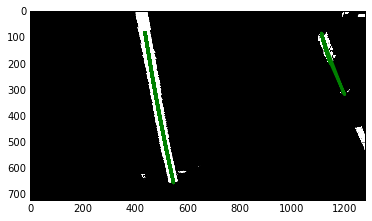

In [22]:
output = 'project_output_22_50.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(22,50)
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [ ]:
output = 'project_output_11_12.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(11.88,12)
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))